# Temporal error evolution

> Authors: Alexander Geiss
>
> Abstract: Using AUX_MET data to determine the temporal evolution of L2B systematic and random errors for longer time periods.  


## Load packages, modules and extensions  
Note the line for interactive plotting function!

In [1]:
# enable following line for interactive visualization backend for matplotlib
# %matplotlib widget
# print version info
%load_ext watermark
%watermark -i -v -p viresclient,pandas,xarray,matplotlib

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.18.0

viresclient: 0.11.3
pandas     : 2.1.3
xarray     : 2023.12.0
matplotlib : 3.8.2



In [2]:
from viresclient import AeolusRequest
import numpy as np
from scipy.stats import linregress, median_abs_deviation
import netCDF4 as nc
import xarray as xr
import pandas as pd
from datetime import datetime, timezone
import os
import dask
import matplotlib.pyplot as plt
from base64 import b64decode
from matplotlib.collections import PolyCollection
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.colors as colors
import cartopy.crs as ccrs
from ipywidgets import interact
import ipywidgets as widgets
from tqdm.notebook import tqdm_notebook

# Create time-series of random and systematic wind errors by using AUX-MET data

This task can be divided into several steps:

1. Loading data
2. Collocating data
    - Temporal collocation (same orbits)
    - Spatial collocation (horizontal/vertical)
3. Filtering, analyzing and plotting data


## Load AUX_MET and Aeolus L2B data
For a detailed description on how to load AUX_MET and L2B data, please see the corresponding notebooks.  
Computing long-term statistics of Aeolus' errors requires a different strategy for loading and handling large data sets with the available system resources. One option is to create requests on a monthly basis and save the retrieved data directly as netcdf data in the user space. Because some of the data within one month can be incomplete this would lead to a failed request for the whole month. Therefore, we reduce each request to half-month periods.
The retrieved and saved data can then be loaded with xarray and dask functionality to concatenate and process the files. Here it must be taken care of saved but invalid data which could be empty.

In [3]:
# set dask scheduler to single-threaded since we only have one core available
dask.config.set(scheduler='single-threaded')

In [4]:
# create start and end dates (here for 6 months of data)
dates = pd.date_range(start='2021-09-01', end='2022-03-01', freq='SMS').to_pydatetime()
start_dates = dates[:-1]
end_dates = dates[1:]

### Load L2B data
Define fields

In [5]:
# Aeolus product
DATA_PRODUCT = "ALD_U_N_2B"

# define fields to retrieve
parameter_rayleigh = [
    "rayleigh_wind_result_start_time",
    "rayleigh_wind_result_stop_time",
    "rayleigh_wind_result_top_altitude",
    "rayleigh_wind_result_bottom_altitude",
    "rayleigh_wind_result_start_latitude",
    "rayleigh_wind_result_start_longitude",
    "rayleigh_wind_result_stop_latitude",
    "rayleigh_wind_result_stop_longitude",
    "rayleigh_wind_result_range_bin_number",
    "rayleigh_wind_result_wind_velocity",
    "rayleigh_wind_result_HLOS_error",
    "rayleigh_wind_result_los_azimuth",
    "rayleigh_wind_result_observation_type",
    "rayleigh_wind_result_validity_flag",
]

parameter_mie = [
    "mie_wind_result_start_time",
    "mie_wind_result_stop_time",
    "mie_wind_result_top_altitude",
    "mie_wind_result_bottom_altitude",
    "mie_wind_result_start_latitude",
    "mie_wind_result_start_longitude",
    "mie_wind_result_stop_latitude",
    "mie_wind_result_stop_longitude",
    "mie_wind_result_range_bin_number",
    "mie_wind_result_wind_velocity",
    "mie_wind_result_HLOS_error",
    "mie_wind_result_los_azimuth",
    "mie_wind_result_observation_type",
    "mie_wind_result_validity_flag",
]

Generate file names and paths for saving data periods as netCDF files.  

In [6]:
L2B_rayleigh_filenames = [
    f"L2B_rayleigh_{start.strftime('%Y-%m-%d')}-{end.strftime('%Y-%m-%d')}.nc"
    for start, end in zip(start_dates, end_dates)
]
L2B_mie_filenames = [
    f"L2B_mie_{start.strftime('%Y-%m-%d')}-{end.strftime('%Y-%m-%d')}.nc"
    for start, end in zip(start_dates, end_dates)
]

user_folder = os.path.expanduser("~")
L2B_folder = os.path.join(user_folder, "files/L2B")
os.makedirs(L2B_folder, exist_ok=True)
L2B_rayleigh_file_paths = [
    os.path.join(L2B_folder, filename) for filename in L2B_rayleigh_filenames
]
L2B_mie_file_paths = [os.path.join(L2B_folder, filename) for filename in L2B_mie_filenames]

**Request L2B Rayleigh data**  
This can take some time depending on the requested time period and region. 
For example, processing the whole mission time from 01.09.2018 until 01.02.2022 for the region of Central Europe took about 15 minutes.  
Here we repeat the get_between method for our list of half-months and save the retrieved (netCDF)-files to our user space right away using the to_file method.
The data for the requested period is only retrieved and saved if it is not yet available under the defined file path.
The list where the file paths are saved is then checked for files which are empty (have no groups in case of L2B data).

In [7]:
# Create Aeolus request
request = AeolusRequest()
request.set_collection(DATA_PRODUCT)
request.set_fields(rayleigh_wind_fields=parameter_rayleigh)

# Set bounding box for region around Central Europe
request.set_bbox({"n": 60, "w": 0, "s": 45, "e": 20})

# create list which will hold the loaded Rayleigh data filenames
L2B_rayleigh_file_paths_loaded = []

# loop over all half-months and request the data
for measurement_start, measurement_stop, filename in zip(
    start_dates, end_dates, L2B_rayleigh_file_paths
):
    # check if file already exists
    # if not, then request the data
    if not os.path.isfile(filename):
        try:
            L2B_rayleigh_data = request.get_between(
                start_time=measurement_start,
                end_time=measurement_stop,
                filetype="nc",
                asynchronous=True,
            ).to_file(filename, overwrite=True)
            L2B_rayleigh_file_paths_loaded.append(filename)
        except Exception as e:
            print(f"No data for the period {measurement_start}-{measurement_stop} available")
            # context is printed here because it holds the true reason for the Exception
            print(e.__context__)
    # if file already exists, append the filename to the list
    else:
        L2B_rayleigh_file_paths_loaded.append(filename)

# Check file list for empty files (no groups available) and remove them from the list
L2B_rayleigh_file_paths_valid = [i for i in L2B_rayleigh_file_paths_loaded if nc.Dataset(i).groups]

**Request L2B Mie data**  
Same procedure as above but now for Mie wind data.

In [8]:
# Create Aeolus request
request = AeolusRequest()
request.set_collection(DATA_PRODUCT)
request.set_fields(mie_wind_fields=parameter_mie)

# Set bounding box for region around Germany
request.set_bbox({"n": 60, "w": 0, "s": 45, "e": 20})

# create list which will hold the loaded Mie data
L2B_mie_file_paths_loaded = []
for measurement_start, measurement_stop, filename in zip(
    start_dates, end_dates, L2B_mie_file_paths
):
    # check if file already exists
    if not os.path.isfile(filename):
        try:
            L2B_mie_data = request.get_between(
                start_time=measurement_start,
                end_time=measurement_stop,
                filetype="nc",
                asynchronous=True,
            ).to_file(filename, overwrite=True)
            L2B_mie_file_paths_loaded.append(filename)
        except Exception as e:
            print(f"No data for the period {measurement_start}-{measurement_stop} available")
            print(e.__context__)
    else:
        L2B_mie_file_paths_loaded.append(filename)

# Check file list for empty files
L2B_mie_file_paths_valid = [i for i in L2B_mie_file_paths_loaded if nc.Dataset(i).groups]

**Read netCDF-data as xarray dataset (dask array)**  
xarray.open_mfdataset can be used to read multiple netCDF files into a single xarray dataset. Because data is stored in groups, they must be explicitly passed as parameter to the open_mfdataset method. 
The group names can be checked with the netCDF4 module and are depending on the requested fields.
The dimension which shall be used for concatenation, must also be defined. Data is then loaded as Dask arrays. (https://xarray.pydata.org/en/stable/user-guide/dask.html)

In [9]:
ds_rayleigh = xr.open_mfdataset(
    L2B_rayleigh_file_paths_valid,
    group="rayleigh_wind_data",
    combine="nested",
    concat_dim="rayleigh_wind_data",
)
ds_mie = xr.open_mfdataset(
    L2B_mie_file_paths_valid, group="mie_wind_data", combine="nested", concat_dim="mie_wind_data",
)

&#9889; **Please note that HLOS error is saved in m/s instead of cm/s for dates before 15.06.2019**  
With the reprocessing of these time periods, this problem should be solved.  
But for now we have to convert HLOS errors to cm/s for these dates which is necessary for further processing and applying QC thresholds.

In [10]:
rayleigh_hlos_error = ds_rayleigh['rayleigh_wind_result_HLOS_error'].values
rayleigh_hlos_error[(ds_rayleigh['rayleigh_wind_result_start_time'] < 6.14e8).values] *= 100
ds_rayleigh['rayleigh_wind_result_HLOS_error'] = (('rayleigh_wind_data'), rayleigh_hlos_error)

mie_hlos_error = ds_mie['mie_wind_result_HLOS_error'].values
mie_hlos_error[(ds_mie['mie_wind_result_start_time'] < 6.14e8).values] *= 100
ds_mie['mie_wind_result_HLOS_error'] = (('mie_wind_data'), mie_hlos_error)

&#9889; **Please note that there was a height offset present for dates before 26.02.2019**  
Check the following document for more information on needed corrections: [The NWP impact of Aeolus Level-2B Winds at ECMWF - Technical memorandum](https://www.ecmwf.int/file/288329/download?token=y9cKewWP) by M. Rennie and L. Isaksen (here section 2.4.1.2)  
With the reprocessing of these time periods, this problem should be solved.

In [11]:
rayleigh_top_altitude = ds_rayleigh["rayleigh_wind_result_top_altitude"].values
rayleigh_bottom_altitude = ds_rayleigh["rayleigh_wind_result_bottom_altitude"].values
rayleigh_top_altitude[(ds_rayleigh["rayleigh_wind_result_top_altitude"] < 6.04e8).values] += 250
rayleigh_bottom_altitude[
    (ds_rayleigh["rayleigh_wind_result_bottom_altitude"] < 6.04e8).values
] += 250
ds_rayleigh["rayleigh_wind_result_top_altitude"] = (("rayleigh_wind_data"), rayleigh_top_altitude)
ds_rayleigh["rayleigh_wind_result_bottom_altitude"] = (
    ("rayleigh_wind_data"),
    rayleigh_bottom_altitude,
)

mie_top_altitude = ds_mie["mie_wind_result_top_altitude"].values
mie_bottom_altitude = ds_mie["mie_wind_result_bottom_altitude"].values
mie_top_altitude[(ds_mie["mie_wind_result_top_altitude"] < 6.04e8).values] += 250
mie_bottom_altitude[(ds_mie["mie_wind_result_bottom_altitude"] < 6.04e8).values] += 250
ds_mie["mie_wind_result_top_altitude"] = (("mie_wind_data"), mie_top_altitude)
ds_mie["mie_wind_result_bottom_altitude"] = (("mie_wind_data"), mie_bottom_altitude)

### Load AUX_MET data
Define fields

In [12]:
# Aeolus product
DATA_PRODUCT = "AUX_MET_12"

# off-nadir parameter
parameter_off_nadir = [
    "time",
    "latitude",
    "longitude",
    "surface_altitude",
    "layer_altitude",
    "layer_wind_component_u",
    "layer_wind_component_v",
]
parameter_off_nadir = [param + "_off_nadir" for param in parameter_off_nadir]

Generate file names and paths for saving data periods as netCDF files.  

In [13]:
AUX_MET_filenames = [
    f"AUX_MET_{start.strftime('%Y-%m-%d')}-{end.strftime('%Y-%m-%d')}.nc"
    for start, end in zip(start_dates, end_dates)
]
user_folder = os.path.expanduser("~")
AUX_MET_folder = os.path.join(user_folder, "files/AUX_MET")
os.makedirs(AUX_MET_folder, exist_ok=True)
AUX_MET_file_paths = [os.path.join(AUX_MET_folder, filename) for filename in AUX_MET_filenames]

**Request AUX_MET data**  
This can take some time depending on the requested time period and region. For the whole mission it takes around 30 minutes.
Here we choose a slightly larger bounding box (1 degree) to be sure to have AUX_MET data within all L2B observations which is especially important at the edges of our L2B bounding box.

In [14]:
# Create Aeolus request
request = AeolusRequest()
request.set_collection(DATA_PRODUCT)
request.set_fields(fields=parameter_off_nadir)

# Set bounding box for region around Germany
request.set_bbox({"n": 61, "w": -1, "s": 44, "e": 21})

# create list which will hold the loaded AUX_MET data
AUX_MET_file_paths_loaded = []
for measurement_start, measurement_stop, filename in zip(
    start_dates, end_dates, AUX_MET_file_paths
):
    # check if file already exists
    if not os.path.isfile(filename):
        try:
            AUX_MET_data = request.get_between(
                start_time=measurement_start,
                end_time=measurement_stop,
                filetype="nc",
                asynchronous=True,
            ).to_file(filename, overwrite=True)
            AUX_MET_file_paths_loaded.append(filename)
        except RuntimeError:
            print(f"No data for the period {measurement_start}-{measurement_stop} available")
    else:
        AUX_MET_file_paths_loaded.append(filename)

# Check file list for empty files (here if variables exist)
AUX_MET_file_paths_valid = [i for i in AUX_MET_file_paths_loaded if nc.Dataset(i).variables]

**Read netCDF-data as xarray dataset (dask array)**  
AUX_MET data is not saved in netCDF-groups and thus no group must be passed to the open_mfdataset funtion.

In [15]:
ds_aux_met = xr.open_mfdataset(AUX_MET_file_paths_valid, combine="nested", concat_dim="off_nadir")

Add datetime and altitude bottom and tops to the AUX_MET dataset for the plotting routines.

In [16]:
# Add datetime
ds_aux_met["datetime_off_nadir"] = (
    ("off_nadir"),
    nc.num2date(
        ds_aux_met["time_off_nadir"],
        units="s since 2000-01-01",
        only_use_cftime_datetimes=False,
    ),
)

# calculate layer top altitudes
layer_altitude_top = (
    ds_aux_met["layer_altitude_off_nadir"][:, :-1].data
    - ds_aux_met["layer_altitude_off_nadir"][:, :].diff(dim="array_137").data / 2.0
)

# calculate layer bottom altitudes
layer_altitude_bottom = (
    ds_aux_met["layer_altitude_off_nadir"][:, 1:].data
    + ds_aux_met["layer_altitude_off_nadir"][:, :].diff(dim="array_137").data / 2.0
)

# combine bottom and top altitude to get layer borders
layer_altitude_borders = np.concatenate((layer_altitude_top, layer_altitude_bottom[:, -2:]), axis=1)
ds_aux_met["layer_altitude_borders_off_nadir"] = (
    ("off_nadir", "array_138"),
    layer_altitude_borders,
)

## Collocation of AUX_MET and L2B data

AUX_MET data is available with 3 seconds temporal resolution and 137 altitude levels with around 100 levels up to 25 km. That is much higher than the Aeolus vertical resolution of 24 atmospheric range bins.  
In the next steps a temporal and spatially horizontal collocation is needed to look for all AUX_MET profiles within one L2B group.
Subsequently, a vertical averaging to the Aeolus range bin size is needed.  
The L2B line of sight azimuth angle must then be used to calculate the HLOS wind speeds from the wind components in the AUX_MET data.

### Temporal collocation or mapping of same orbits

For collocation and low system memory purposes we want to do computations orbit-wise.  
This makes a separation of the datasets into single orbits necessary.
Instead of creating new datasets for every orbit we just determine the indices for each dataset where new orbits start.
Here we use a time difference of 3600 seconds for consecutive profiles (AUX_MET) or L2B-groups above which we assume orbits are separated. Note that one full orbit takes around 90 minutes and we are looking in this example only at a smaller region.

In [17]:
# create mask for each data set resulting in an array with a unique index for each orbit.
# The 3600 seconds are hard-coded here.
orbit_mask_l2b_rayleigh = (
    ds_rayleigh["rayleigh_wind_result_start_time"].diff(dim="rayleigh_wind_data") > 3600
).cumsum()
orbit_mask_l2b_mie = (
    ds_mie["mie_wind_result_start_time"].diff(dim="mie_wind_data") > 3600
).cumsum()
orbit_mask_aux_met = (ds_aux_met["time_off_nadir"].diff(dim="off_nadir") > 3600).cumsum()

Because we used the diff-method the resulting masks are smaller in length by one. This must be taken into account by inserting 0 before the first element of the array.

In [18]:
ds_rayleigh["orbit_mask"] = (
    ds_rayleigh["rayleigh_wind_result_start_time"].dims,
    np.concatenate(([0], orbit_mask_l2b_rayleigh)),
)
ds_mie["orbit_mask"] = (
    ds_mie["mie_wind_result_start_time"].dims,
    np.concatenate(([0], orbit_mask_l2b_mie)),
)
ds_aux_met["orbit_mask"] = (
    ds_aux_met["time_off_nadir"].dims,
    np.concatenate(([0], orbit_mask_aux_met)),
)

To get the indices of the single orbits we determine unique values of our orbit_mask.  
The counts of these unique values can be used to rechunk the Dask arrays to account for single orbits which are then processed orbit-wise to get the collocations.

In [19]:
# Put the data sets into a dictionary in oder to loop over them
ds_dict = {'rayleigh': ds_rayleigh, 'mie': ds_mie, 'aux_met': ds_aux_met}

In [20]:
for ds in ds_dict:
    values, counts = np.unique(ds_dict[ds]["orbit_mask"], return_index=False, return_counts=True)
    dim = list(ds_dict[ds].dims)[0]
    ds_dict[ds] = ds_dict[ds].chunk({dim: tuple(counts)})

In the next step we need to find the collocated orbits for Mie, Rayleigh and AUX_MET data.
AUX_MET data is available for the whole mission without any gaps which is not the case for L2B-data. 
Thus, we would like to map the corresponding orbits in an index-array.

First we have to calculate median values of the L2B-Rayleigh, -Mie and AUX_MET orbit times (divided already in chunks).  
This can be achieved very fast with the map_blocks-Function for dask-arrays.

We need to define a function which calculates the median values, which can be passed to the map_blocks-function:

In [21]:
def calc_median(block):
    return np.array([np.median(block)])

Apply this function to Rayleigh, Mie and AUX_MET orbits.
This yields an array with length corresponding to the number of orbits (chunks) with the median values of the orbit times.

In [22]:
for ds, time_param in zip(
    ["rayleigh", "mie", "aux_met"],
    ["rayleigh_wind_result_start_time", "mie_wind_result_start_time", "time_off_nadir"],
):
    median_time = (
        ds_dict[ds][time_param].data.map_blocks(calc_median, chunks=(1,)).compute()
    )
    ds_dict[ds]["orbit_times_median"] = (("orbit_no"), median_time)

Determine the corresponding AUX_MET orbits for L2B Rayleigh and Mie orbits by calculating the time difference between these orbits and choosing the minimum value.

In [23]:
# map the AUX_MET orbits (by index) to the L2B orbits for Rayleigh and Mie
rayleigh_aux_idx = np.argmin(
    np.abs(
        ds_dict["aux_met"]["orbit_times_median"].values
        - ds_dict["rayleigh"]["orbit_times_median"].values[:, np.newaxis]
    ),
    axis=1,
)
mie_aux_idx = np.argmin(
    np.abs(
        ds_dict["aux_met"]["orbit_times_median"].values
        - ds_dict["mie"]["orbit_times_median"].values[:, np.newaxis]
    ),
    axis=1,
)

ds_dict["rayleigh"]["orbit_aux_met_idx"] = (("orbit_no"), rayleigh_aux_idx)
ds_dict["mie"]["orbit_aux_met_idx"] = (("orbit_no"), mie_aux_idx)

We can now check if the time differences between these collocated orbits is smaller than the overpass time for our chosen geolocation box to see if we have found the correct orbits or if there are any outliers.

Text(0.5, 0.98, 'Collocated Rayleigh and AUX_MET orbits')

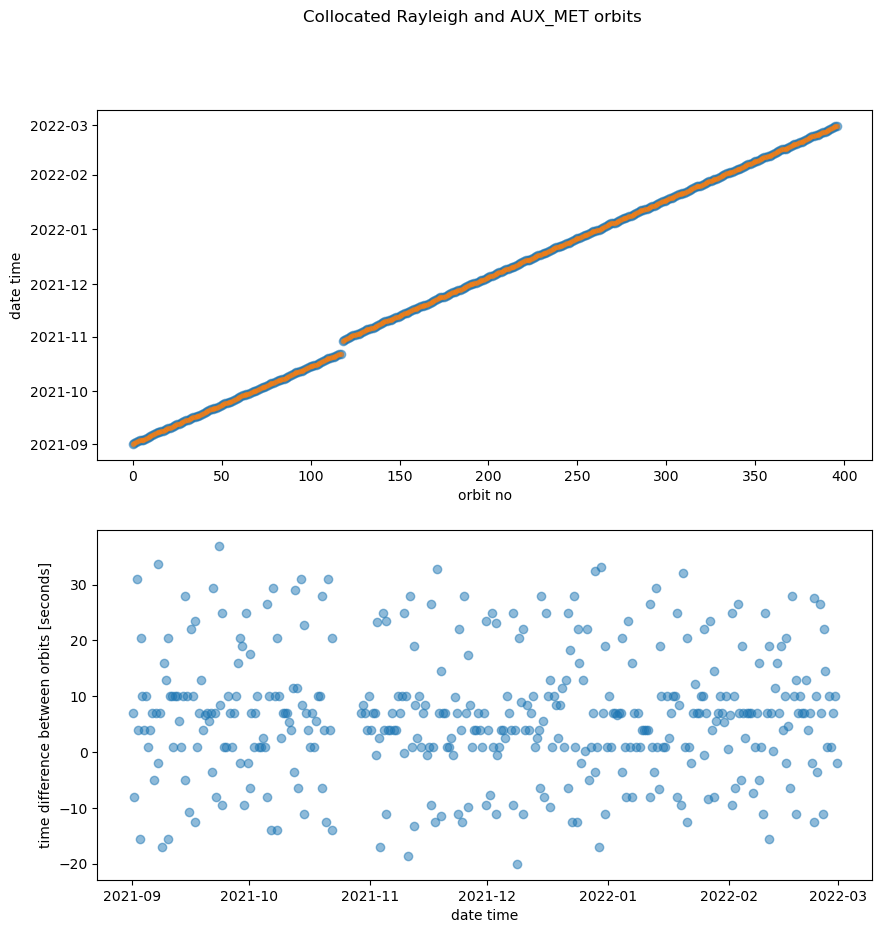

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
ax1.plot(
    nc.num2date(
        ds_dict["aux_met"]["orbit_times_median"][rayleigh_aux_idx],
        units="s since 2000-01-01",
        only_use_cftime_datetimes=False,
    ),
    "o",
    alpha=0.5,
)
ax1.plot(
    nc.num2date(
        ds_dict["rayleigh"]["orbit_times_median"],
        units="s since 2000-01-01",
        only_use_cftime_datetimes=False,
    ),
    ".",
    alpha=0.5,
)
ax1.set_ylabel("date time")
ax1.set_xlabel("orbit no")

ax2.plot(
    nc.num2date(
        ds_dict["rayleigh"]["orbit_times_median"],
        units="s since 2000-01-01",
        only_use_cftime_datetimes=False,
    ),
    ds_dict["aux_met"]["orbit_times_median"][rayleigh_aux_idx]
    - ds_dict["rayleigh"]["orbit_times_median"],
    "o",
    alpha=0.5,
)
ax2.set_xlabel("date time")
ax2.set_ylabel("time difference between orbits [seconds]")
fig.suptitle("Collocated Rayleigh and AUX_MET orbits")

Because all time differences (second subplot) are smaller than 3600 seconds, we have all L2B data with collocated AUX_MET data per orbit or precisely the necessary indices to obtain the AUX_MET data corresponding to the L2B data.

### Horizontal and vertical collocation of L2B wind measurements an AUX_MET data

To see the differences in spatial resolution of L2B and AUX_MET data we have a look at curtain plots of one orbit.
We define a plotting function where the orbit number and several other parameters can be passed.

In [25]:
def plot_wind_from_collocated_orbits(
    L2B_parameter="rayleigh_wind_result_wind_velocity",
    L2B_channel="rayleigh",
    L2B_obs_type="clear",
    L2B_QC_filter=True,
    L2B_error_estimate_threshold=800,
    orbit_no=0,
    vmin=None,
    vmax=None,
    max_altitude=30,
):
    # define L2B dataset where only the orbit with orbit_no is filtered
    ds_L2B = ds_dict[L2B_channel].where((ds_dict[L2B_channel]["orbit_mask"] == orbit_no).compute(), drop=True).compute()

    # get orbit index for AUX_MET data and select the subset
    aux_met_orbit_no = ds_dict[L2B_channel]["orbit_aux_met_idx"][orbit_no]
    ds_aux_met = ds_dict["aux_met"].where(
        (ds_dict["aux_met"]["orbit_mask"] == aux_met_orbit_no).compute(), drop=True
    ).compute()

    # ------- preprocess L2B data -------------------------
    # define necessary L2B parameters for plotting
    X0 = mdates.date2num(
        nc.num2date(
            ds_L2B[L2B_channel + "_wind_result_start_time"].values,
            units="s since 2000-01-01",
            only_use_cftime_datetimes=False,
        )
    )
    X1 = mdates.date2num(
        nc.num2date(
            ds_L2B[L2B_channel + "_wind_result_stop_time"].values,
            units="s since 2000-01-01",
            only_use_cftime_datetimes=False,
        )
    )

    Y0 = ds_L2B[L2B_channel + "_wind_result_bottom_altitude"].values / 1000.0
    Y1 = ds_L2B[L2B_channel + "_wind_result_top_altitude"].values / 1000.0
    Z = ds_L2B[L2B_parameter].values

    # create a mask out of different filters which can be applied to the different parameters
    mask = np.zeros(len(Z), dtype=bool)

    # mask where validity flag is 0
    if L2B_QC_filter:
        mask = mask | (ds_L2B[L2B_channel + "_wind_result_validity_flag"] == 0)

    # mask dependent on observation type
    if L2B_obs_type == "cloudy":
        mask = mask | (ds_L2B[L2B_channel + "_wind_result_observation_type"] != 1)
    elif L2B_obs_type == "clear":
        mask = mask | (ds_L2B[L2B_channel + "_wind_result_observation_type"] != 2)

    # mask where wind results have error estimates larger than a given threshold
    mask = mask | (ds_L2B[L2B_channel + "_wind_result_HLOS_error"] > L2B_error_estimate_threshold)

    # mask all necessary parameters for plotting
    # tilde before mask inverts the boolean mask array
    X0 = X0[~mask]
    X1 = X1[~mask]
    Y0 = Y0[~mask]
    Y1 = Y1[~mask]
    Z = Z[~mask]

    # -------------- preprocess AUX_MET data --------------------------------------
    x_am = ds_aux_met["datetime_off_nadir"]
    altitude_array = ds_aux_met["layer_altitude_borders_off_nadir"] / 100000.0
    ymax = np.mean(np.argmin(np.abs(altitude_array.values - max_altitude), axis=1)).astype(int)
    y_am = altitude_array[:, ymax - 1:]

    # To make AUX_MET model winds comparable to L2B winds we have to account for the horizontal line of sight (HLOS).
    # The model winds u and v component can be converted with the LOS azimuth angle from the L2B wind product.
    # Here we take just the mean los azimuth value of all L2B wind results of the orbit within our bounding box.
    # If you are looking at whole orbits this would need to be modified.
    los_azimuth = int(np.mean(ds_L2B[L2B_channel + "_wind_result_los_azimuth"][~mask].load()))
    z_am = -ds_aux_met["layer_wind_component_u_off_nadir"] * np.sin(
        np.deg2rad(los_azimuth)
    ) - ds_aux_met["layer_wind_component_v_off_nadir"] * np.cos(np.deg2rad(los_azimuth))
    z_am = z_am[:, ymax - 1:]

    # -------------- create L2B patches ----------------------------------
    patches = []
    for x0, x1, y0, y1 in zip(X0, X1, Y0, Y1):
        patches.append(((x0, y0), (x0, y1), (x1, y1), (x1, y0)))

    # define min and max value for the colorbar
    if vmin is None:
        # if L2B_parameter == "wind_result_wind_velocity":
        if "wind_result_wind_velocity" in L2B_parameter:
            vmin = -np.amax(np.abs(np.asarray([np.nanpercentile(Z, 2), np.nanpercentile(Z, 98)])))
        else:
            vmin = np.nanpercentile(Z, 1)
    if vmax is None:
        # if parameter == "wind_result_wind_velocity":
        if "wind_result_wind_velocity" in L2B_parameter:
            vmax = np.amax(np.abs(np.asarray([np.nanpercentile(Z, 2), np.nanpercentile(Z, 98)])))
        else:
            vmax = np.nanpercentile(Z, 99)

    # ---------------------------- plot L2B and AUX_MET orbit ------------------
    fig = plt.figure(figsize=(8, 12), constrained_layout=True)
    gs = fig.add_gridspec(3, 1)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1, sharey=ax1)
    ax_map = fig.add_subplot(gs[2, 0], projection=ccrs.PlateCarree(central_longitude=10))

    coll = PolyCollection(
        patches,
        array=Z,
        cmap=cm.RdBu_r,
        norm=colors.Normalize(
            vmin=vmin,
            vmax=vmax,
            clip=False,
        ),
    )
    ax1.add_collection(coll)
    ax1.set_ylabel("Altitude [km]")
    ax1.set_title(
        "L2B {} - {} \n {} wind results \n orbit_no = {}".format(
            L2B_channel.title(), L2B_parameter, len(Z), orbit_no
        )
    )
    ax1.grid()

    locator = mdates.AutoDateLocator(minticks=4, maxticks=8)
    formatter = mdates.ConciseDateFormatter(locator)
    ax1.xaxis.set_major_locator(locator)
    ax1.xaxis.set_major_formatter(formatter)
    ax1.autoscale()
    ax1.set_ylim(-1, max_altitude)
    ax1.tick_params(labelbottom=False)

    ax2.pcolormesh(x_am, y_am.T, z_am[:-1, :].T, vmin=vmin, vmax=vmax, cmap="RdBu_r")
    ax2.set_ylim(-1, max_altitude)
    ax2.set_xlabel("Date [UTC]")
    ax2.set_ylabel("Altitude [km]")
    ax2.set_title("AUX_MET {}".format("HLOS wind"))
    ax2.grid()
    locator = mdates.AutoDateLocator(minticks=4, maxticks=8)
    formatter = mdates.ConciseDateFormatter(locator)
    ax2.xaxis.set_major_locator(locator)
    ax2.xaxis.set_major_formatter(formatter)

    ax_map.stock_img()
    ax_map.gridlines(draw_labels=True, linewidth=0.3, color="black", alpha=0.5, linestyle="-")
    ax_map.set_extent([-10, 30, 40, 65], crs=ccrs.PlateCarree())
    ax_map.scatter(
        ds_aux_met["longitude_off_nadir"],
        ds_aux_met["latitude_off_nadir"],
        marker="o",
        c="g",
        s=5,
        transform=ccrs.Geodetic(),
        label="AUX_MET",
    )
    ax_map.scatter(
        ds_L2B[L2B_channel + "_wind_result_start_longitude"],
        ds_L2B[L2B_channel + "_wind_result_start_latitude"],
        marker="o",
        c="r",
        s=5,
        transform=ccrs.Geodetic(),
        label="L2B {}".format(L2B_channel),
    )
    ax_map.legend()

    fig.colorbar(coll, ax=[ax1, ax2], aspect=50, pad=0.01, label="HLOS wind [cm/s]")

Now we plot an example orbit (here number 80)

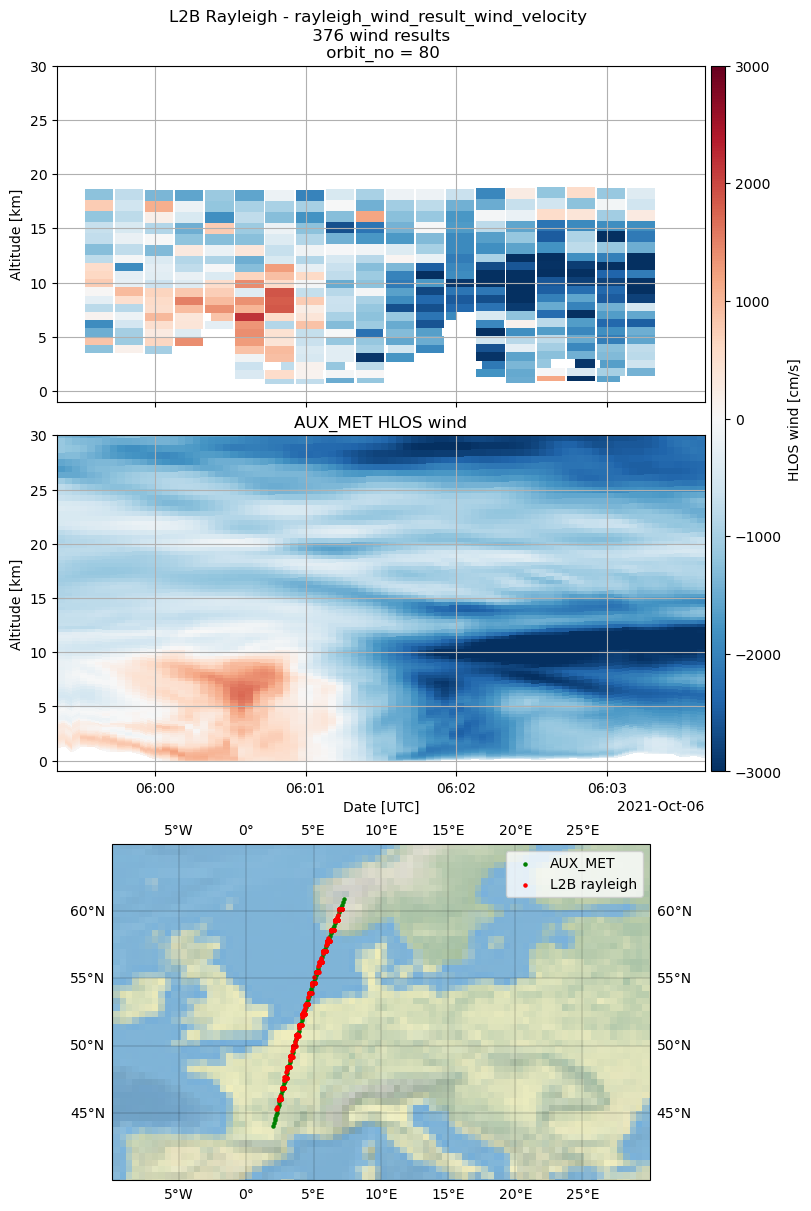

In [26]:
plot_wind_from_collocated_orbits(
    L2B_parameter='rayleigh_wind_result_wind_velocity',
    L2B_channel="rayleigh",
    L2B_obs_type="clear",
    L2B_error_estimate_threshold=850,
    L2B_QC_filter=True,
    orbit_no=80,
    vmin=-3000,
    vmax=3000,
)

It is obvious that the spatial resolution of the AUX_MET model data is much higher in the vertical as well as in the horizontal domain.
The easiest way to find collocated AUX_MET measurements for each L2B wind group would be a nearest neighbour approach. This, however, would not account for possible wind gradients which are covered by the highly resolved model data but not by the coarser L2B measurement grid. 
Thus, we average all AUX_MET wind data (here we use center locations) within one L2B measurement group.
This is done for the AUX_MET u and v wind component which are then used to calculate the horizontal line of sight winds by using the line of sight azimuth angle.  
$HLOS=-u*\sin(\phi)-v*\cos(\phi)$  
with $\phi$ as L2B azimuth angle.

In [27]:
def spatial_collocate_L2B_AUX_MET_fast(
    L2B_aux_met_u,
    L2B_aux_met_v,
    L2B_lat_start,
    L2B_lat_stop,
    L2B_altitude_bottom,
    L2B_altitude_top,
    L2B_los_azimuth,
    aux_met_lat,
    aux_met_altitude,
    aux_met_u,
    aux_met_v,
):

    # create mask where aux_met data is in between one L2B observation
    # We have to distinguish between ascending and descending orbits
    if (L2B_lat_stop - L2B_lat_start).mean() > 0:
        AM_within_L2B_mask = (
            (
                (L2B_lat_stop[:, None] > aux_met_lat[None, :])
                & (L2B_lat_start[:, None] < aux_met_lat[None, :])
            )[:, :, None]
            & (L2B_altitude_bottom[:, None, None] < aux_met_altitude[None, :, :])
            & (L2B_altitude_top[:, None, None] > aux_met_altitude[None, :, :])
        )
    else:
        AM_within_L2B_mask = (
            (
                (L2B_lat_stop[:, None] < aux_met_lat[None, :])
                & (L2B_lat_start[:, None] > aux_met_lat[None, :])
            )[:, :, None]
            & (L2B_altitude_bottom[:, None, None] < aux_met_altitude[None, :, :])
            & (L2B_altitude_top[:, None, None] > aux_met_altitude[None, :, :])
        )
    only_one_meas_per_group_mask = np.all(~AM_within_L2B_mask, axis=(1, 2))

    # average where latitude difference is large enough and thus aux_met data could be found within one L2B group
    L2B_aux_met_u[~only_one_meas_per_group_mask] = np.average(
        np.broadcast_to(
            aux_met_u,
            (AM_within_L2B_mask[~only_one_meas_per_group_mask].shape),
        ),
        axis=(1, 2),
        weights=AM_within_L2B_mask[~only_one_meas_per_group_mask],
    )
    L2B_aux_met_v[~only_one_meas_per_group_mask] = np.average(
        np.broadcast_to(
            aux_met_v,
            (AM_within_L2B_mask[~only_one_meas_per_group_mask].shape),
        ),
        axis=(1, 2),
        weights=AM_within_L2B_mask[~only_one_meas_per_group_mask],
    )

    # We have to account for cases where one observation consists only of one measurement,
    # which results in an observation which has the same start and stop latitude and thus don't allow us to find collocated AUX_MET data with the procedure above.
    # These cases have to be treated extra. We just apply a nearest neighbour approach for them.
    # create mask with size where we have only one measurement per group and the number of AUX_MET profiles and set all to False
    AM_nearest_L2B_geolocated_mask = np.zeros(
        (only_one_meas_per_group_mask.sum(), len(aux_met_lat)),
        dtype=bool,
    )

    # Set the nearest AUX_MET profiles to True
    AM_nearest_L2B_geolocated_mask[
        np.arange(AM_nearest_L2B_geolocated_mask.shape[0]),
        np.argmin(
            np.abs(L2B_lat_start[only_one_meas_per_group_mask][:, None] - aux_met_lat),
            axis=1,
        ),
    ] = True

    # Combine the mask with the vertical collocation
    AM_nearest_L2B_mask = (
        AM_nearest_L2B_geolocated_mask[:, :, None]
        & (
            L2B_altitude_bottom[only_one_meas_per_group_mask][:, None, None]
            < aux_met_altitude[None, :, :]
        )
        & (
            L2B_altitude_top[only_one_meas_per_group_mask][:, None, None]
            > aux_met_altitude[None, :, :]
        )
    )

    # determine indices where we now have found AUX MET data for L2B groups.
    # However, we still have L2B measurements, where no data could be collocated. These muss be accounted for when we now assign the collocated AUX_MET data to the L2B data variable.
    # The L2B measurements where we couldn't find collocated AUX_MET data will now be set to nan.
    idx_valid = np.all(~AM_nearest_L2B_mask, axis=(1, 2))
    idx_aux_met_nearest_L2B = np.flatnonzero(only_one_meas_per_group_mask)[~idx_valid]

    L2B_aux_met_u[idx_aux_met_nearest_L2B] = np.average(
        np.broadcast_to(
            aux_met_u,
            (AM_nearest_L2B_mask[~idx_valid].shape),
        ),
        axis=(1, 2),
        weights=AM_nearest_L2B_mask[~idx_valid],
    )
    L2B_aux_met_v[idx_aux_met_nearest_L2B] = np.average(
        np.broadcast_to(
            aux_met_v,
            (AM_nearest_L2B_mask[~idx_valid].shape),
        ),
        axis=(1, 2),
        weights=AM_nearest_L2B_mask[~idx_valid],
    )

    L2B_aux_met_hlos = -L2B_aux_met_u * np.sin(
        np.deg2rad(L2B_los_azimuth)
    ) - L2B_aux_met_v * np.cos(np.deg2rad(L2B_los_azimuth))

    return L2B_aux_met_hlos

Now we have a fast collocation procedure without any loops.
This has now to be applied to all collocated orbits.
Since indexing operations on dask and xarray-datasets are very slow, we extract the necessary parameter arrays.

In [28]:
def apply_spatial_collocate_L2B_AUX_MET(ds_dict, channel):

    # First load the dask arrays to obtain the xarray datasets.
    # Here we just use the necessary parameters to keep the memory usage low.
    ds_aux_met_loaded = ds_dict["aux_met"][
        [
            "latitude_off_nadir",
            "layer_altitude_off_nadir",
            "layer_wind_component_u_off_nadir",
            "layer_wind_component_v_off_nadir",
            "orbit_mask",
        ]
    ].load()
    ds_L2B_loaded = ds_dict[channel][
        [
            channel + "_wind_result_start_latitude",
            channel + "_wind_result_stop_latitude",
            channel + "_wind_result_bottom_altitude",
            channel + "_wind_result_top_altitude",
            channel + "_wind_result_los_azimuth",
            "orbit_mask",
            "orbit_aux_met_idx",
        ]
    ].load()

    # Create a list to which we append all collocated HLOS values
    L2B_aux_met_hlos = []
    L2B_aux_met_idx = ds_L2B_loaded["orbit_aux_met_idx"].values

    # In the following we loop over all orbit.
    for orbit_no in tqdm_notebook(range(ds_L2B_loaded.dims["orbit_no"])):
        # Instead of a whole xarray dataset, only the parameter values are used.
        L2B_orbit_idx = (ds_L2B_loaded["orbit_mask"] == orbit_no).values
        L2B_lat_start = ds_L2B_loaded[channel + "_wind_result_start_latitude"][L2B_orbit_idx].values
        L2B_lat_stop = ds_L2B_loaded[channel + "_wind_result_stop_latitude"][L2B_orbit_idx].values
        L2B_altitude_bottom = ds_L2B_loaded[channel + "_wind_result_bottom_altitude"][
            L2B_orbit_idx
        ].values
        L2B_altitude_top = ds_L2B_loaded[channel + "_wind_result_top_altitude"][
            L2B_orbit_idx
        ].values
        L2B_los_azimuth = ds_L2B_loaded[channel + "_wind_result_los_azimuth"][L2B_orbit_idx].values

        L2B_aux_met_u = np.full(L2B_lat_start.shape, np.nan)
        L2B_aux_met_v = np.full(L2B_lat_start.shape, np.nan)

        aux_met_orbit_no = L2B_aux_met_idx[orbit_no]
        aux_met_orbit_idx = (ds_aux_met_loaded["orbit_mask"] == aux_met_orbit_no).values
        aux_met_lat = ds_aux_met_loaded["latitude_off_nadir"][aux_met_orbit_idx].values
        aux_met_altitude = (
            ds_aux_met_loaded["layer_altitude_off_nadir"][aux_met_orbit_idx].values / 100.0
        )
        aux_met_u = ds_aux_met_loaded["layer_wind_component_u_off_nadir"][aux_met_orbit_idx].values
        aux_met_v = ds_aux_met_loaded["layer_wind_component_v_off_nadir"][aux_met_orbit_idx].values

        # append the collocated HLOS values which are returned by the spatial_collocate_L2B_AUX_MET_fast function to the list
        L2B_aux_met_hlos.extend(
            spatial_collocate_L2B_AUX_MET_fast(
                L2B_aux_met_u,
                L2B_aux_met_v,
                L2B_lat_start,
                L2B_lat_stop,
                L2B_altitude_bottom,
                L2B_altitude_top,
                L2B_los_azimuth,
                aux_met_lat,
                aux_met_altitude,
                aux_met_u,
                aux_met_v,
            )
        )
    # Add the collocated and hlos-converted AUX_MET values to the dataset
    ds_dict[channel]["L2B_aux_met_hlos"] = (
        (list(ds_L2B_loaded.dims)[0]),
        np.asarray(L2B_aux_met_hlos),
    )
    return ds_dict

Add the collocated and hlos-converted AUX_MET values to the datasets by applying the collocation function.  
This takes around 3 minutes for all Rayleigh wind measurements for the entire mission and around 16 minutes for all Mie measurements. 

In [29]:
ds_dict = apply_spatial_collocate_L2B_AUX_MET(ds_dict, 'rayleigh')

/opt/conda/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


  0%|          | 0/397 [00:00<?, ?it/s]

In [30]:
ds_dict = apply_spatial_collocate_L2B_AUX_MET(ds_dict, 'mie')

/opt/conda/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


  0%|          | 0/397 [00:00<?, ?it/s]

Now we can test the spatial collocation of AUX_MET and L2B wind groups by using the plotting function from above and passing the 'L2B_aux_met_hlos' wind parameter

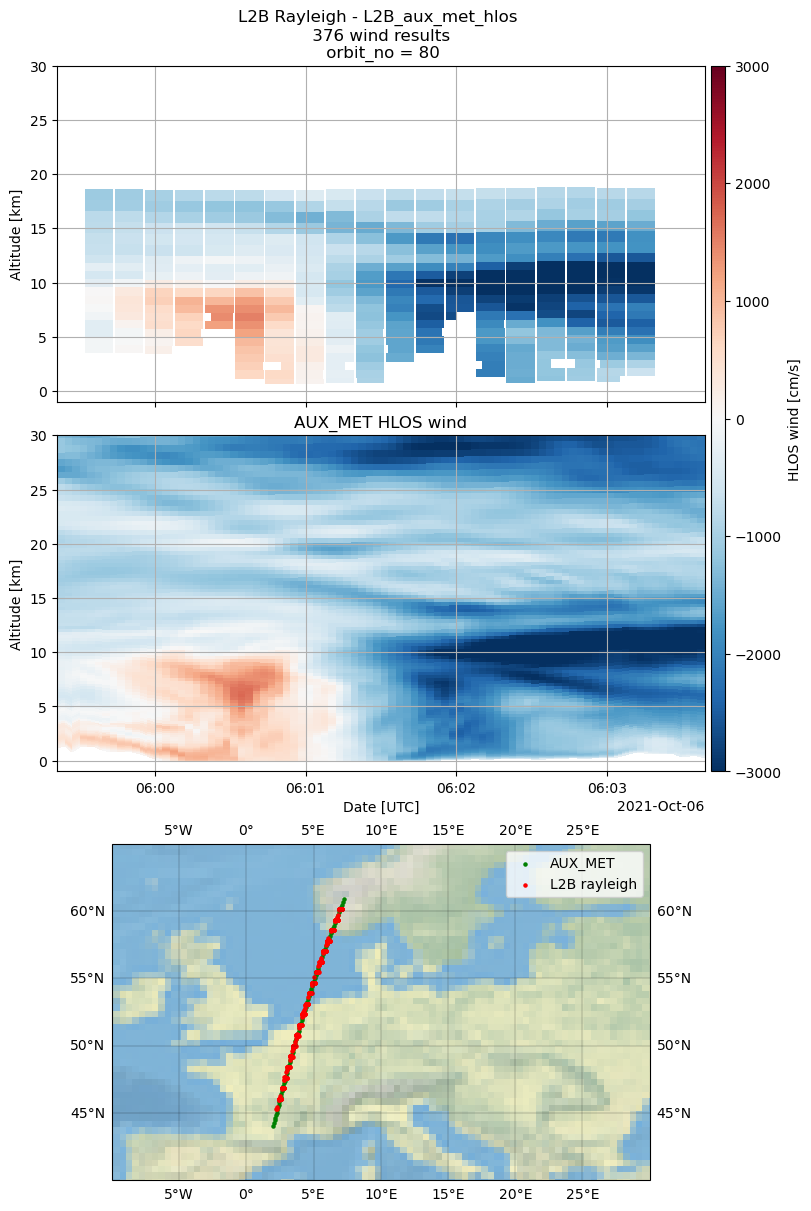

In [31]:
plot_wind_from_collocated_orbits(
    L2B_parameter='L2B_aux_met_hlos',
    L2B_channel="rayleigh",
    L2B_obs_type="clear",
    L2B_error_estimate_threshold=850,
    L2B_QC_filter=True,
    orbit_no=80,
    vmin=-3000,
    vmax=3000,
)

#### Save datasets with collocated data to user space
This allows analyzing the data further without repeating the collocation process if the notebook kernel is started again.
This will save a lot of time.  
Just uncomment the cell where the datasets are saved with the 'to_netcdf'-method.

In [32]:
# Define file paths
user_folder = os.path.expanduser("~")
results_folder = os.path.join(user_folder, "files/results")
os.makedirs(results_folder, exist_ok=True)
ds_dict_rayleigh_folder = os.path.join(results_folder, 'rayleigh_aux_met_collocated.nc')
ds_dict_mie_folder = os.path.join(results_folder, 'mie_aux_met_collocated.nc')

In [33]:
# # save to netCDF
# ds_dict['rayleigh'].to_netcdf(ds_dict_rayleigh_folder)
# ds_dict['mie'].to_netcdf(ds_dict_mie_folder)

If datasets have already been saved to the user space you can use the following to Load them again (uncomment).

In [34]:
# ds_dict = {
#     "rayleigh": xr.open_dataset(ds_dict_rayleigh_folder),
#     "mie": xr.open_dataset(ds_dict_mie_folder),
# }

## Filter, analyze and plot data
### Interactive scatter plot of L2B and AUX_MET comparison

Add timestamps for further processing to the datasets.  
Create a new variable based on L2B start times by adding the time difference between 01.01.1970 and 01.01.2001 as seconds.

In [35]:
# add datetime timestamp
datetime_difference = (datetime(2000, 1, 1) - datetime(1970, 1, 1)).total_seconds()
ds_dict["rayleigh"]["rayleigh_wind_result_start_time_timestamp"] = (
    (list(ds_dict["rayleigh"].dims)[0]),
    ds_dict["rayleigh"]["rayleigh_wind_result_start_time"].data + datetime_difference,
)
ds_dict["mie"]["mie_wind_result_start_time_timestamp"] = (
    (list(ds_dict["mie"].dims)[0]),
    ds_dict["mie"]["mie_wind_result_start_time"].data + datetime_difference,
)

Now we define a class for filtering, analyzing and plotting the data.  
The filtering can also be done with an interactive scatter plot.  
Based on the filtered data we can create a time series of the systematic and random error of L2B wind measurements.

In [36]:
class Analyze_and_Plot:
    """
    Class for plotting and analyzing colocated data with scatter plot and ipywidgets-interact
    """

    def __init__(self, ds_dict, channel):
        self.ds_L2B = ds_dict[channel].load()
        self.channel = channel
        self.mask = None
        self.wind_difference = None
        self.orbit_type = None

    def filter_data(
        self,
        obs_type,
        validity_flag,
        orbit_type,
        filter_hot_pixel,
        filter_blacklisted,
        err_estimate_range,
        time_range,
        altitude_range,
        which_range_bin_range,
    ):
        """
        Method to filter L2B measurements for different parameters.

        Parameters
        ----------
        obs_type : 'str'
            obs_type can be clear or cloudy
        validity_flag : 'int'
            validity flag can be 0 (invalid) or 1 (valid)
        orbit_type : 'str'
            orbit_type can be ascending or descending
        filter_hot_pixel : 'int'
            filter_hot_pixels can be 0 to not filter or 1 to filter for hot pixels
        filter_blacklisted : 'int'
            filter_blacklisted can be 0 to not filter or 1 to filter for blacklisted data
        err_estimate_range : 'tuple' of int or float
            err_estimate_range is a tuple consisting of two elements with (err_estimate_min, err_estimate_max) in cm/s
        time_range : 'tuple' of int or float
            time_range is a tuple consisting of two elements with (time_range_min, time_range_max) as timestamps
        altitude_range : 'tuple' of int or float
            altitude_range is a tuple consisting of two elements with (altitude_range_min, alttude_range_max) in meter
        which_range_bin_range : 'tuple' of int or float
            which_range_bin_range is a tuple consisting of two elements with (which_range_bin_range_min, which_range_bin_range_max)

        Returns
        -------
        mask : numpy boolean array
            mask with same length as self.ds_L2B

        """

        if orbit_type == "ascending":
            azimuth_range = (180, 360)
        elif orbit_type == "descending":
            azimuth_range = (0, 180)
        elif orbit_type == "both":
            azimuth_range = (0, 360)

        range_dict = {
            "wind_result_bottom_altitude": altitude_range,
            "wind_result_HLOS_error": err_estimate_range,
            "wind_result_range_bin_number": which_range_bin_range,
            "wind_result_los_azimuth": azimuth_range,
            "wind_result_start_time_timestamp": time_range,
        }

        # create mask based on filters
        # mask all nan values
        mask = np.isnan(self.ds_L2B["L2B_aux_met_hlos"])

        # mask invalid data
        mask = mask | (self.ds_L2B[self.channel + "_wind_result_validity_flag"] != validity_flag)

        # mask cloudy or clear values
        if obs_type == "cloudy":
            mask = mask | (self.ds_L2B[self.channel + "_wind_result_observation_type"] != 1)
        elif obs_type == "clear":
            mask = mask | (self.ds_L2B[self.channel + "_wind_result_observation_type"] != 2)

        for key, value in range_dict.items():
            mask = (
                mask
                | (self.ds_L2B[self.channel + "_" + key] < value[0])
                | (self.ds_L2B[self.channel + "_" + key] > value[1])
            )

        # filter Hot pixel
        hot_pixels_rayleigh = {
            "1": (
                11,
                datetime.strptime("2018-09-07", "%Y-%m-%d")
                .replace(tzinfo=timezone.utc)
                .timestamp(),
            ),
            "2": (
                5,
                datetime.strptime("2018-11-04", "%Y-%m-%d")
                .replace(tzinfo=timezone.utc)
                .timestamp(),
            ),
            "3": (
                15,
                datetime.strptime("2018-11-24", "%Y-%m-%d")
                .replace(tzinfo=timezone.utc)
                .timestamp(),
            ),
            "4": (
                20,
                datetime.strptime("2019-01-27", "%Y-%m-%d")
                .replace(tzinfo=timezone.utc)
                .timestamp(),
            ),
            "5": (
                1,
                datetime.strptime("2019-02-20", "%Y-%m-%d")
                .replace(tzinfo=timezone.utc)
                .timestamp(),
            ),
            "6": (
                11,
                datetime.strptime("2019-03-17", "%Y-%m-%d")
                .replace(tzinfo=timezone.utc)
                .timestamp(),
            ),
            "7": (
                3,
                datetime.strptime("2019-05-08", "%Y-%m-%d")
                .replace(tzinfo=timezone.utc)
                .timestamp(),
            ),
        }

        hot_pixels_mie = {
            "1": (
                16,
                datetime.strptime("2018-08-22", "%Y-%m-%d")
                .replace(tzinfo=timezone.utc)
                .timestamp(),
            ),
            "2": (
                24,
                datetime.strptime("2018-08-22", "%Y-%m-%d")
                .replace(tzinfo=timezone.utc)
                .timestamp(),
            ),
            "3": (
                13,
                datetime.strptime("2018-10-21", "%Y-%m-%d")
                .replace(tzinfo=timezone.utc)
                .timestamp(),
            ),
            "4": (
                2,
                datetime.strptime("2018-10-24", "%Y-%m-%d")
                .replace(tzinfo=timezone.utc)
                .timestamp(),
            ),
            "5": (
                5,
                datetime.strptime("2019-01-09", "%Y-%m-%d")
                .replace(tzinfo=timezone.utc)
                .timestamp(),
            ),
            "6": (
                20,
                datetime.strptime("2019-03-31", "%Y-%m-%d")
                .replace(tzinfo=timezone.utc)
                .timestamp(),
            ),
            "7": (
                10,
                datetime.strptime("2019-04-26", "%Y-%m-%d")
                .replace(tzinfo=timezone.utc)
                .timestamp(),
            ),
        }

        hot_pixel_correct_date = (
            datetime.strptime("2019-06-14", "%Y-%m-%d").replace(tzinfo=timezone.utc).timestamp()
        )

        if self.channel == "rayleigh":
            hot_pixels = hot_pixels_rayleigh
        elif self.channel == "mie":
            hot_pixels = hot_pixels_mie

        if bool(filter_hot_pixel) is True:
            for key, value in hot_pixels.items():
                mask = mask | (
                    (self.ds_L2B[self.channel + "_wind_result_range_bin_number"] == value[0])
                    & (self.ds_L2B[self.channel + "_wind_result_start_time_timestamp"] > value[1])
                    & (
                        self.ds_L2B[self.channel + "_wind_result_start_time_timestamp"]
                        < hot_pixel_correct_date
                    )
                )

        # end filter hot pixel ###

        # filter exlusion list
        # Especially for the newest baselines including the reprocessed datasets, blacklistet periods are already flagged as invalid.
        # However, for older baselines with laser FM-A, the following filtering helps to exclude measurements which can be of bad quality.

        if bool(filter_blacklisted) is True:

            exclusion_dates_list = [
                ["2018-09-25", "03:00:00", "2018-09-26", "15:00:00"],
                ["2018-12-13", "02:00:00", "2018-12-13", "16:50:00"],
                ["2019-01-21", "00:00:00", "2019-01-21", "23:59:59"],
                ["2019-02-18", "14:00:00", "2019-02-20", "09:20:00"],
                ["2019-02-26", "12:50:00", "2019-02-27", "16:37:00"],
                ["2019-06-16", "19:00:00", "2019-06-28", "13:54:23"],
                ["2019-07-01", "18:17:00", "2019-07-02", "12:15:23"],
                ["2019-07-08", "04:00:00", "2019-07-08", "23:45:00"],
                ["2019-07-15", "04:00:00", "2019-07-16", "01:00:00"],
                ["2019-07-23", "00:30:00", "2019-07-23", "05:47:21"],
                ["2020-01-15", "11:08:59", "2020-01-15", "11:30:38"],
                ["2020-03-04", "00:32:00", "2020-03-04", "05:47:21"],
                ["2020-03-06", "06:45:00", "2020-03-06", "09:32:35"],
                ["2020-03-09", "21:00:00", "2020-03-12", "03:59:47"],
                ["2020-05-25", "07:54:00", "2020-05-27", "20:26:30"],
                ["2020-07-06", "04:00:00", "2020-07-10", "23:59:59"],
                ["2020-09-21", "00:04:00", "2020-09-24", "03:05:00"],
                ["2020-10-05", "01:59:00", "2020-10-07", "04:00:00"],
                ["2020-10-08", "23:59:00", "2020-10-10", "01:00:00"],
                ["2020-11-17", "16:00:00", "2020-11-20", "15:00:00"],
                ["2020-11-24", "16:00:00", "2020-11-26", "23:59:59"],
                ["2020-12-04", "08:00:00", "2020-12-08", "10:00:00"],
                ["2020-12-04", "08:00:00", "2020-12-14", "08:30:00"],
                ["2021-01-14", "01:13:00", "2021-01-14", "07:26:00"],
                ["2021-01-22", "10:02:00", "2021-01-27", "23:59:59"],
                ["2021-01-31", "00:25:00", "2021-02-05", "12:30:00"],
                ["2021-02-12", "10:05:00", "2021-02-15", "12:30:00"],
                ["2021-02-26", "06:00:00", "2021-03-01", "12:30:00"],
                ["2021-03-09", "08:45:00", "2021-03-11", "23:59:59"],
                ["2021-03-16", "08:45:00", "2021-03-18", "23:59:59"],
                ["2021-03-29", "00:00:00", "2021-05-06", "12:00:00"],
                ["2021-05-11", "12:58:00", "2021-05-11", "18:20:00"],
                ["2021-05-17", "15:00:00", "2021-05-22", "23:59:59"],
                ["2021-05-24", "19:00:00", "2021-05-28", "23:59:59"],
                ["2021-06-21", "14:50:00", "2021-06-26", "12:00:00"],
                ["2021-10-05", "00:00:00", "2021-10-05", "23:59:59"],
                ["2021-10-18", "11:20:00", "2021-11-02", "11:20:00"],
                ["2021-11-22", "15:00:00", "2021-11-27", "12:00:00"],
                ["2021-11-29", "15:00:00", "2021-12-04", "11:00:00"],
            ]

            exclusion_dates = {}
            for i in range(len(exclusion_dates_list)):
                exclusion_dates[str(i)] = (
                    datetime.strptime(" ".join(exclusion_dates_list[i][0:2]), "%Y-%m-%d %H:%M:%S")
                    .replace(tzinfo=timezone.utc)
                    .timestamp(),
                    datetime.strptime(" ".join(exclusion_dates_list[i][2:4]), "%Y-%m-%d %H:%M:%S")
                    .replace(tzinfo=timezone.utc)
                    .timestamp(),
                )

            for key, value in exclusion_dates.items():
                mask = mask | (
                    (self.ds_L2B[self.channel + "_wind_result_start_time_timestamp"] > value[0])
                    & (self.ds_L2B[self.channel + "_wind_result_start_time_timestamp"] < value[1])
                )

        # end filter exclusion list

        return mask

    def return_masked_hlos_winds(self, mask):
        """
        Return masked L2B and AUX_MET HLOS winds in m/s
        """
        L2B_aux_met_hlos = self.ds_L2B["L2B_aux_met_hlos"][~mask].values / 100.0
        L2B_hlos = self.ds_L2B[self.channel + "_wind_result_wind_velocity"][~mask].values / 100.0

        return L2B_aux_met_hlos, L2B_hlos

    def analyze_and_plot(
        self,
        obs_type,
        validity_flag,
        orbit_type,
        filter_hot_pixel,
        filter_blacklisted,
        err_estimate_range,
        time_range,
        altitude_range,
        which_range_bin_range,
    ):
        """
        Interactive plotting of collocated L2B and AUX_MET measurements

        Parameters
        ----------
        See filter_data method

        Returns
        -------
        Matplotlib plot
        """

        self.obs_type = obs_type
        self.orbit_type = orbit_type
        self.mask = self.filter_data(
            obs_type,
            validity_flag,
            orbit_type,
            filter_hot_pixel,
            filter_blacklisted,
            err_estimate_range,
            time_range,
            altitude_range,
            which_range_bin_range,
        )
        L2B_aux_met_hlos, L2B_hlos = self.return_masked_hlos_winds(self.mask)
        self.wind_difference = L2B_hlos - L2B_aux_met_hlos

        # calculate statistics (systematic and random errors, regression line)
        slope, intercept, r_value, p_value, stderr = linregress(L2B_aux_met_hlos, L2B_hlos)
        linreg_y = intercept + slope * L2B_aux_met_hlos
        wind_difference_mean = self.wind_difference.mean()
        wind_difference_std = self.wind_difference.std()
        wind_difference_median = np.median(self.wind_difference)
        MAD = 1.4826 * np.median(np.abs(self.wind_difference - wind_difference_median))

        # create string to show as text box in scatterplot
        textstr = "\n".join(
            (
                "bias = {:.2f} m/s".format(wind_difference_mean),
                "stddev = {:.2f} m/s".format(wind_difference_std),
                "slope = {:.2f}".format(slope),
                "intercept = {:.2f} m/s".format(intercept),
                "1.4826*MAD = {:.2f} m/s".format(MAD),
                "r = {:.3f}".format(r_value),
            )
        )

        # clear axis and plot data
        self.ax.clear()
        self.ax.scatter(L2B_aux_met_hlos, L2B_hlos, s=5, alpha=0.2, linewidths=0, zorder=2)
        self.ax.plot([-100, 100], [-100, 100], "k", label="1:1", zorder=1)
        self.ax.plot(L2B_aux_met_hlos, linreg_y, "r", label="regression line", zorder=3)
        self.ax.grid()
        self.ax.set_xlabel("AUX_MET wind speed HLOS [m/s]")
        self.ax.set_ylabel("Aeolus wind speed HLOS [m/s]")
        self.ax.set_xlim(-100, 100)
        self.ax.set_ylim(-100, 100)

        # place text in scatterplot
        self.ax.text(
            0.03,
            0.97,
            textstr,
            transform=self.ax.transAxes,
            verticalalignment="top",
            bbox=dict(facecolor="white", alpha=0.9, boxstyle="round"),
        )

        self.ax_hist.clear()
        self.ax_hist.hist(self.wind_difference, bins=np.arange(-25, 25, 0.5), density=True)
        self.ax_hist.grid()
        self.ax_hist.set_ylim(0, 0.1)
        self.ax_hist.set_xlabel("L2B - AUX_MET wind speed difference [m/s]")
        self.fig.suptitle(
            "Aeolus {} - AUX_MET comparison \n {} measurements \n {} to {}".format(
                self.channel.title(),
                len(L2B_aux_met_hlos),
                datetime.utcfromtimestamp(time_range[0]).strftime("%Y-%m-%d"),
                datetime.utcfromtimestamp(time_range[1]).strftime("%Y-%m-%d"),
            )
        )

        self.fig.tight_layout()

    def create_figure(self):
        """Create matplitlib figure"""
        self.fig, (self.ax, self.ax_hist) = plt.subplots(1, 2, figsize=(10, 5))

    def plot_interactive(self):
        """Interactive filtering and plotting of data"""
        # Define the time range for the available data
        time_range_available_str = np.arange(
            np.array(
                self.ds_L2B[self.channel + "_wind_result_start_time_timestamp"][0],
                dtype="datetime64[s]",
            ),
            np.array(
                self.ds_L2B[self.channel + "_wind_result_start_time_timestamp"][-1],
                dtype="datetime64[s]",
            )
            + np.timedelta64(2, "D"),
            dtype="datetime64[D]",
        )
        time_range_available_ts = (
            time_range_available_str - np.datetime64("1970-01-01T00:00:00")
        ) / np.timedelta64(1, "s")
        time_range_available = list(zip(time_range_available_str, time_range_available_ts))

        # Create the matplotlib figure
        self.create_figure()
        self.analyze_and_plot(
            obs_type="clear",
            validity_flag=1,
            orbit_type="both",
            filter_hot_pixel=1,
            filter_blacklisted=1,
            err_estimate_range=(0, 800),
            time_range=(time_range_available[0][1], time_range_available[-1][1]),
            altitude_range=(0, 30000),
            which_range_bin_range=(0, 24),
        )

        # Use the ipywidgets interact functionality
        interact(
            self.analyze_and_plot,
            obs_type=widgets.Dropdown(
                options=["cloudy", "clear"], value="clear", style={"description_width": "initial"}
            ),
            validity_flag=widgets.RadioButtons(
                options=[("valid", 1), ("invalid", 0)],
                value=1,
                style={"description_width": "initial"},
            ),
            orbit_type=widgets.RadioButtons(
                options=["ascending", "descending", "both"],
                value="both",
                style={"description_width": "initial"},
            ),
            filter_hot_pixel=widgets.RadioButtons(
                options=[("yes", 1), ("no", 0)],
                value=1,
                style={"description_width": "initial"},
            ),
            filter_blacklisted=widgets.RadioButtons(
                options=[("yes", 1), ("no", 0)],
                value=1,
                style={"description_width": "initial"},
            ),
            err_estimate_range=widgets.IntRangeSlider(
                value=(0, 800),
                min=0,
                max=5000,
                step=1,
                continuous_update=False,
                style={"description_width": "initial"},
                layout={"width": "400px"},
            ),
            time_range=widgets.SelectionRangeSlider(
                options=time_range_available,
                # index = (0, -1),
                value=(time_range_available[0][1], time_range_available[-1][1]),
                continuous_update=False,
                style={"description_width": "initial"},
                layout={"width": "400px"},
            ),
            altitude_range=widgets.IntRangeSlider(
                value=(1000, 30000),
                min=-500,
                max=30000,
                continuous_update=False,
                style={"description_width": "initial"},
                layout={"width": "400px"},
            ),
            which_range_bin_range=widgets.IntRangeSlider(
                value=(0, 24),
                min=0,
                max=24,
                continuous_update=False,
                style={"description_width": "initial"},
                layout={"width": "400px"},
            ),
        )

    def create_pandas_dataframe(self, data, mask):
        """
        Create pandas dataframe with L2B start time as index
        """
        pd_df = pd.DataFrame(
            data,
            index=pd.to_datetime(
                self.ds_L2B[self.channel + "_wind_result_start_time_timestamp"][~mask].values,
                unit="s",
            ),
        ).sort_index()

        return pd_df

    def create_time_series(self, statistic_window_length=1, averaging_window_length=7):
        """Create time series based on the interactively filtered data"""
        swl = statistic_window_length
        awl = averaging_window_length
        min_number_days = round(awl / swl / 2)

        pd_df = self.create_pandas_dataframe(self.wind_difference, self.mask)

        fig, ax = plt.subplots(
            3,
            1,
            figsize=(8, 6),
            sharex=True,
            constrained_layout=True,
            gridspec_kw={"height_ratios": [3, 3, 2]},
        )

        # If resampled to one day, we can set the rolling window to 7 if we want to apply it on 7 days for example.
        # This allows us to set center=True which is not possible if setting the rolling window to "7D" (7 days) for example.
        # In this case, the results would be shifted because the rolling window computations would be not centered.
        # So be careful when doing these calculations.
        pd_df.resample(f"{swl}D").mean().rolling(
            awl, min_periods=min_number_days, center=True
        ).median().plot(kind="line", ax=ax[0], ylim=(-6, 6))
        pd_df.resample(f"{swl}D").std().rolling(
            awl, min_periods=min_number_days, center=True
        ).median().plot(kind="line", ax=ax[1], ylim=(0, 9))
        (pd_df.resample(f"{swl}D").apply(median_abs_deviation) * 1.4826).rolling(
            awl, min_periods=min_number_days, center=True
        ).median().plot(kind="line", ax=ax[1], ylim=(0, 9))
        pd_df.resample(f"{swl}D").count().rolling(
            awl, min_periods=min_number_days, center=True
        ).median().plot(kind="line", ax=ax[2], legend=False)

        ax[0].axhline(0, c="k", lw=1.0, ls="--")
        ax[2].set_ylim(bottom=0)
        ax[0].legend([f"{self.orbit_type} orbits"])
        ax[1].legend(["stddev", "1.4826*MAD"])
        ax[0].grid(which="both")
        ax[1].grid(which="both")
        ax[2].grid(which="both")
        ax[2].set_xlabel("Date")
        ax[0].set_ylabel("Bias [m/s]")
        ax[1].set_ylabel("Random error [m/s]")
        ax[2].set_ylabel(f"Counts per {swl} days")
        fig.suptitle(
            f"{self.channel.title()} - {self.obs_type} measurements \n Number of days for moving statistics = {swl}"
        )
        fig.align_ylabels()

    def create_time_series_with_orbit_types(
        self, statistic_window_length=1, averaging_window_length=7
    ):
        """Function which creates a time series of the systematic and random error for ascending and descending orbits"""
        swl = statistic_window_length
        awl = averaging_window_length
        min_number_days = round(awl / swl / 2)

        if self.channel == "rayleigh":
            obs_type = "clear"
            err_estimate_range = (0, 850)
        elif self.channel == "mie":
            obs_type = "cloudy"
            err_estimate_range = (0, 450)

        mask_ascending = self.filter_data(
            obs_type=obs_type,
            validity_flag=1,
            orbit_type="ascending",
            filter_hot_pixel=1,
            filter_blacklisted=1,
            err_estimate_range=err_estimate_range,
            time_range=(datetime(2018, 9, 1).timestamp(), datetime(2022, 3, 1).timestamp()),
            altitude_range=(0, 30000),
            which_range_bin_range=(0, 24),
        )
        L2B_aux_met_hlos_asc, L2B_hlos_asc = self.return_masked_hlos_winds(mask_ascending)
        wind_difference_asc = L2B_hlos_asc - L2B_aux_met_hlos_asc
        pd_df_asc = self.create_pandas_dataframe(wind_difference_asc, mask_ascending)

        mask_descending = self.filter_data(
            obs_type=obs_type,
            validity_flag=1,
            orbit_type="descending",
            filter_hot_pixel=1,
            filter_blacklisted=1,
            err_estimate_range=err_estimate_range,
            time_range=(datetime(2018, 9, 1).timestamp(), datetime(2022, 3, 1).timestamp()),
            altitude_range=(0, 30000),
            which_range_bin_range=(0, 24),
        )
        L2B_aux_met_hlos_desc, L2B_hlos_desc = self.return_masked_hlos_winds(mask_descending)
        wind_difference_desc = L2B_hlos_desc - L2B_aux_met_hlos_desc
        pd_df_desc = self.create_pandas_dataframe(wind_difference_desc, mask_descending)

        fig, ax = plt.subplots(
            3,
            1,
            figsize=(8, 6),
            sharex=True,
            constrained_layout=True,
            gridspec_kw={"height_ratios": [3, 3, 2]},
        )

        pd_df_asc.resample(f"{swl}D").mean().rolling(
            awl, min_periods=min_number_days, center=True
        ).median().plot(kind="line", ax=ax[0], ylim=(-6, 6))
        (pd_df_asc.resample(f"{swl}D").apply(median_abs_deviation) * 1.4826).rolling(
            awl, min_periods=min_number_days, center=True
        ).median().plot(kind="line", ax=ax[1], ylim=(0, 9), legend=False)
        pd_df_asc.resample(f"{swl}D").count().rolling(
            awl, min_periods=min_number_days, center=True
        ).median().plot(kind="line", ax=ax[2], legend=False)
                
        pd_df_desc.resample(f"{swl}D").mean().rolling(
            awl, min_periods=min_number_days, center=True
        ).median().plot(kind="line", ax=ax[0], ylim=(-6, 6))
        (pd_df_desc.resample(f"{swl}D").apply(median_abs_deviation) * 1.4826).rolling(
            awl, min_periods=min_number_days, center=True
        ).median().plot(kind="line", ax=ax[1], ylim=(0, 9), legend=False)
        pd_df_desc.resample(f"{swl}D").count().rolling(
            awl, min_periods=min_number_days, center=True
        ).median().plot(kind="line", ax=ax[2], legend=False)

        ax[0].axhline(0, c="k", lw=1.0, ls="--")
        ax[2].set_ylim(bottom=0)
        ax[0].legend(["ascending", "descending"])
        ax[0].grid(which="both")
        ax[1].grid(which="both")
        ax[2].grid(which="both")
        ax[2].set_xlabel("Date")
        ax[0].set_ylabel("Bias [m/s]")
        ax[1].set_ylabel("1.4826*MAD [m/s]")
        ax[2].set_ylabel(f"Counts per {swl} days")
        fig.suptitle(
            f"{self.channel.title()} - {obs_type} measurements \n Number of days for moving statistics = {swl}"
        )
        fig.align_ylabels()

Create the time series for Rayleigh measurements

In [37]:
L2B_validation_rayleigh = Analyze_and_Plot(ds_dict, "rayleigh")

Interactive filtering

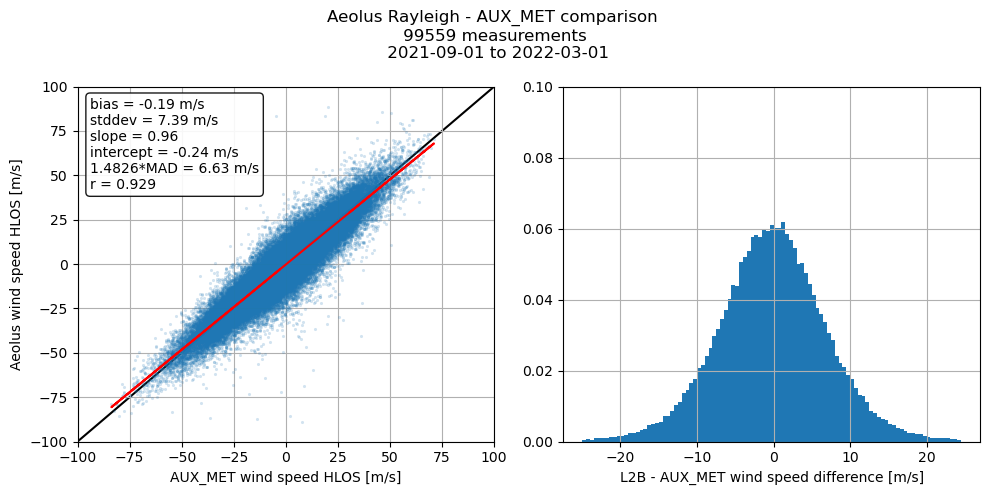

interactive(children=(Dropdown(description='obs_type', index=1, options=('cloudy', 'clear'), style=Description…

In [38]:
L2B_validation_rayleigh.plot_interactive()

Create time series based on the interactively filtered data

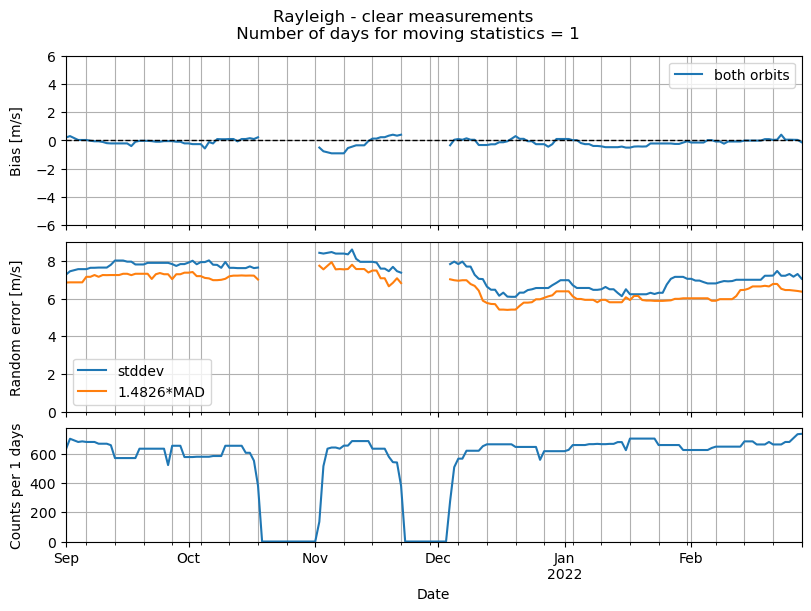

In [39]:
L2B_validation_rayleigh.create_time_series(statistic_window_length=1, averaging_window_length=7)

Create time series for ascending and descending orbits (not based on the interactively filtered data).  
See and adapt filter thresholds in the 'create_time_series_with_orbit_types'-method above.

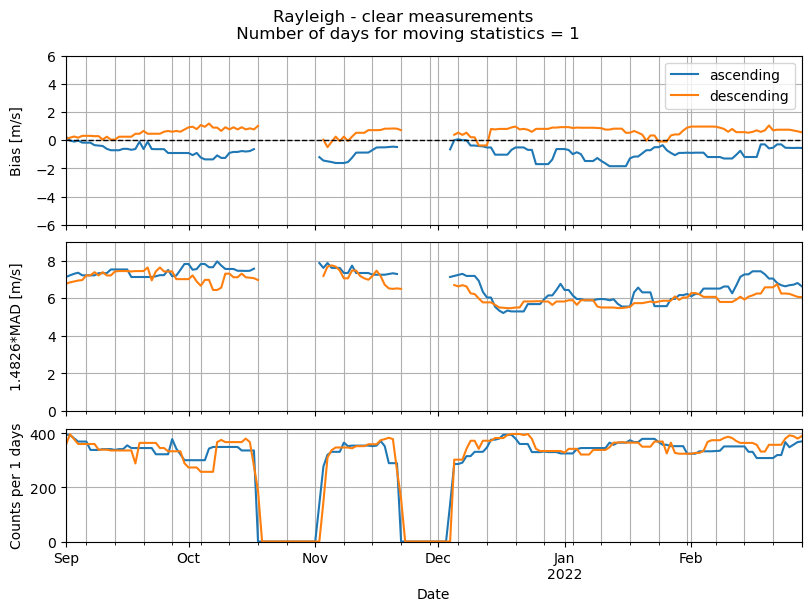

In [40]:
L2B_validation_rayleigh.create_time_series_with_orbit_types(
    statistic_window_length=1, averaging_window_length=7
)

Create time series for ascending and descending orbits for Mie-cloudy measurements

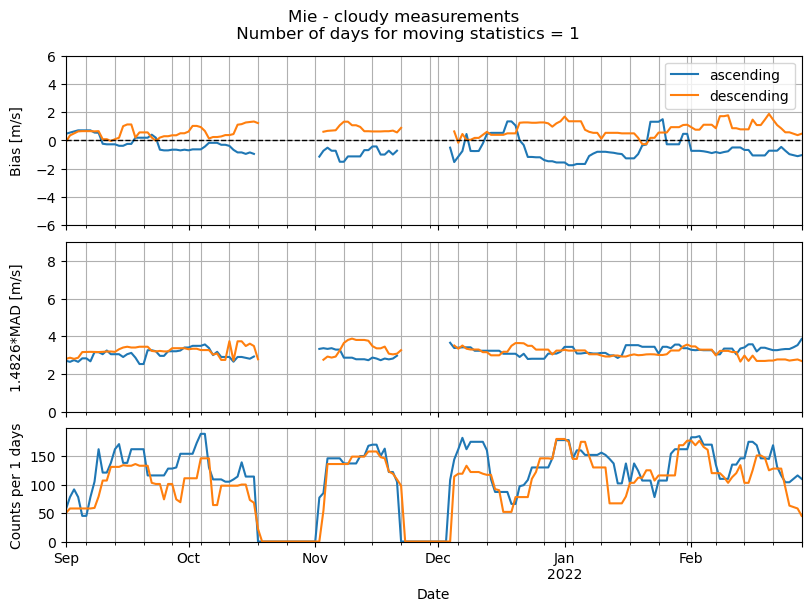

In [41]:
L2B_validation_mie = Analyze_and_Plot(ds_dict, "mie")
L2B_validation_mie.create_time_series_with_orbit_types(
    statistic_window_length=1, averaging_window_length=7
)

#### Time series for the entire mission
To show the capability of this notebook, we defined a time period from 01.09.2018 until 01.02.2022 at the top of the notebook.
Results are shown in the following plots for Rayleigh-clear and Mie-cloudy measurements.
Keep in mind, if a applying such a long time period, this will take some time to run (about 1 hour for the entire mission).

In [42]:
Rayleigh_time_series_encoded = b'iVBORw0KGgoAAAANSUhEUgAAAyAAAAJYCAYAAACadoJwAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjQuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/Z1A+gAAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOydZ3gUVReA391N741UQhICIfSAdJAiKCAozQ8FFQQUVBRRUFBUBAsq9oqKFFEUUQiCgHSU3nsvSSgJCQnpbbN7vx83u8lmE0ggEKL3fZ59dvfOzJkzs7Mz99xTrkYIIVAoFAqFQqFQKBSKW4C2qhVQKBQKhUKhUCgU/x2UAaJQKBQKhUKhUChuGcoAUSgUCoVCoVAoFLcMZYAoFIpyM2fOHDQajfllY2NDQEAADz30ECdPnrzp+9doNLzxxhu3fNvQ0FB69+59XdveDN544w00Gk1Vq6H4F7BlyxbeeOMNUlNTq1oVhULxH8KmqhVQKBTVj9mzZxMZGUlubi6bN2/m7bffZv369Rw7dgxPT8+qVq9Utm7dSs2aNataDYXitmLLli1MmTKFxx57DA8Pj6pWR6FQ/EdQBohCoagwjRo1okWLFgB07twZg8HA5MmTiY6OZtiwYVWsXem0adOmqlWo9uTk5ODg4KC8L4Xo9XqzJ1ChUCgU5UeFYCkUihvGZIxcunTJ3Jabm8u4ceOIiorC3d0dLy8v2rZty5IlSyy27dq1K5GRkZSsCC6EoE6dOvTq1euq+05ISGDUqFHUrFkTOzs7wsLCmDJlCgUFBRbrlRaCtWnTJtq2bYuDgwNBQUG89tprzJw5E41GQ0xMjNW+Vq5cSfPmzXF0dCQyMpJZs2Zd69RcFytXrqRr1664u7vj5ORE/fr1mTZt2jW3W7BgAW3btsXZ2RkXFxe6d+/O3r17LdbZtWsXDz30EKGhoTg6OhIaGsqgQYOIjY21WM8Ubrdq1SqGDx9OjRo1cHJyIi8vr9R9b9iwAY1Gw/z585kwYQIBAQG4uLhw3333cenSJTIyMhg5ciQ+Pj74+PgwbNgwMjMzLWQIIfjqq6+IiorC0dERT09PHnjgAc6cOWOx3urVq+nTpw81a9bEwcGBOnXqMGrUKC5fvmyxXlJSEiNHjiQ4OBh7e3tq1KhB+/btWbNmjXmd0NBQHnvsMavj6dy5M507d7Y6vnnz5jFu3DiCgoKwt7fn1KlTAKxZs4auXbvi5uaGk5MT7du3Z+3atRYyTaFzBw4c4H//+5/5f/HCCy9QUFDA8ePH6dGjB66uroSGhvL+++9b6ZWens748eMJCwvDzs6OoKAgxo4dS1ZWlsV6Go2GZ555hnnz5lG/fn2cnJxo2rQpy5Yts9DnxRdfBCAsLMwcWrlhwwYA1q1bR+fOnfH29sbR0ZFatWoxYMAAsrOzrfRSKBSKiqCGbRQKxQ1z9uxZACIiIsxteXl5pKSkMH78eIKCgsjPz2fNmjX079+f2bNnM2TIEACee+45+vTpw9q1a+nWrZt5+xUrVnD69Gk+++yzMvebkJBAq1at0Gq1vP7664SHh7N161beeustYmJimD17dpnbHjhwgLvvvpuIiAjmzp2Lk5MTM2bM4Mcffyx1/f379zNu3DgmTpyIn58fM2fOZMSIEdSpU4eOHTtW6Hxdje+//54nnniCTp06MWPGDHx9fTlx4gSHDh266nbvvPMOr776KsOGDePVV18lPz+f6dOnc+edd7Jjxw4aNGgAQExMDPXq1eOhhx7Cy8uL+Ph4vv76a1q2bMmRI0fw8fGxkDt8+HB69erFvHnzyMrKwtbW9qp6vPLKK3Tp0oU5c+YQExPD+PHjGTRoEDY2NjRt2pSff/6ZvXv38sorr+Dq6mrx+44aNYo5c+YwZswY3nvvPVJSUpg6dSrt2rVj//79+Pn5AXD69Gnatm3L448/jru7OzExMXz00Ud06NCBgwcPmnV89NFH2bNnD2+//TYRERGkpqayZ88ekpOTK/y7mHj55Zdp27YtM2bMQKvV4uvry48//siQIUPo06cPc+fOxdbWlm+++Ybu3bvz119/0bVrVwsZAwcO5JFHHmHUqFGsXr2a999/H71ez5o1a3j66acZP3682ZCrU6cO/fv3ByA7O5tOnTpx/vx5XnnlFZo0acLhw4d5/fXXOXjwIGvWrLHwTv3555/s3LmTqVOn4uLiwvvvv0+/fv04fvw4tWvX5vHHHyclJYXPP/+cRYsWERAQAECDBg2IiYmhV69e3HnnncyaNQsPDw8uXLjAypUryc/Px8nJ6brPoUKhUCAUCoWinMyePVsAYtu2bUKv14uMjAyxcuVK4e/vLzp27Cj0en2Z2xYUFAi9Xi9GjBghmjVrZm43GAyidu3aok+fPhbr9+zZU4SHhwuj0WhuA8TkyZPN30eNGiVcXFxEbGysxbYffPCBAMThw4fL3PZ///ufcHZ2FklJSRa6NGjQQADi7Nmz5vaQkBDh4OBgsZ+cnBzh5eUlRo0aVeYxV5SMjAzh5uYmOnToYHHcJZk8ebIofvuOi4sTNjY24tlnn7WS5+/vLwYOHFimrIKCApGZmSmcnZ3Fp59+am43/dZDhgwpl+7r168XgLjvvvss2seOHSsAMWbMGIv2vn37Ci8vL/P3rVu3CkB8+OGHFuudO3dOODo6ipdeeqnU/RqNRqHX60VsbKwAxJIlS8zLXFxcxNixY6+qd0hIiBg6dKhVe6dOnUSnTp2sjq9jx44W62VlZQkvLy+r4zYYDKJp06aiVatW5jbT71byGKOiogQgFi1aZG7T6/WiRo0aon///ua2adOmCa1WK3bu3Gmx/W+//SYAsXz5cnMbIPz8/ER6erq5LSEhQWi1WjFt2jRz2/Tp062u9+Iy9+3bZ3VuFAqF4kZRIVgKhaLCtGnTBltbW1xdXenRoweenp4sWbLEKhZ+4cKFtG/fHhcXF2xsbLC1teX777/n6NGj5nW0Wi3PPPMMy5YtIy4uDpAj3CtXruTpp5++ar7BsmXL6NKlC4GBgRQUFJhfPXv2BGDjxo1lbrtx40buuusuixF/rVbLwIEDS10/KiqKWrVqmb87ODgQERFhFbpUEoPBYKGb0Wgsc90tW7aQnp5+zeMuyV9//UVBQQFDhgyx2JeDgwOdOnUyh9QAZGZmmkfWbWxssLGxwcXFhaysLIvfxcSAAQPKrQdgVS2sfv36AFahdPXr1yclJcUchrVs2TI0Gg2PPPKIxTH4+/vTtGlTi2NITEzkySefJDg42HxdhYSEAFgcQ6tWrZgzZw5vvfUW27ZtQ6/XV+hYSqPk+diyZQspKSkMHTrU6nfu0aMHO3futAqPKu0caTQa83ULYGNjQ506dSyur2XLltGoUSOioqIs9tW9e3eL0CkTXbp0wdXV1fzdz88PX1/fa16zIK93Ozs7Ro4cydy5c63C4BQKheJGUAaIQqGoMD/88AM7d+5k3bp1jBo1iqNHjzJo0CCLdRYtWsTAgQMJCgrixx9/ZOvWrezcuZPhw4eTm5trse7w4cNxdHRkxowZAHz55Zc4OjoyfPjwq+px6dIlli5diq2trcWrYcOGAFY5AcVJTk42h/QUp7Q2AG9vb6s2e3t7cnJyrqpj165dLXS72jElJSUBVLhalyn3pmXLllbnYsGCBRbnYfDgwXzxxRc8/vjj/PXXX+zYsYOdO3dSo0aNUo/FFJZTXry8vCy+29nZXbXddC1cunQJIQR+fn5Wx7Bt2zbzMRiNRu655x4WLVrESy+9xNq1a9mxYwfbtm0DsDiGBQsWMHToUGbOnEnbtm3x8vJiyJAhJCQkVOiYilPyfJjO/QMPPGCl93vvvYcQgpSUlGueIycnJxwcHKzai/9XLl26xIEDB6z24+rqihDC6nq/3msWIDw8nDVr1uDr68vo0aMJDw8nPDycTz/99JrbKhQKxbVQOSAKhaLC1K9f35x43qVLFwwGAzNnzuS3337jgQceAODHH38kLCyMBQsWWIzml5bE7O7ubu4ojh8/ntmzZzN48OBrlgX18fGhSZMmvP3226UuDwwMLHNbb29vi6R5EzfSOS2Nb775hoyMDPP3kjkWxalRowYA58+fr9A+TDJ/++03syegNNLS0li2bBmTJ09m4sSJ5nZTvk5p3KqKVz4+Pmg0Gv755x/s7e2tlpvaDh06xP79+5kzZw5Dhw41Lzclg5eU+cknn/DJJ58QFxfHH3/8wcSJE0lMTGTlypWA9GSVdk1evny51N+q5PkwrfP555+XWWmtLKO2ovj4+ODo6Fhm8YOrXVvXw5133smdd96JwWBg165dfP7554wdOxY/Pz8eeuihSt2XQqH4b6EMEIVCccO8//77/P7777z++uv0798frVaLRqPBzs7OosOWkJBgVQXLxJgxY/jqq6944IEHSE1N5Zlnnrnmfnv37s3y5csJDw+v8PwjnTp1Yvny5RYdTaPRyMKFCysk51rUq1ev3Ou2a9cOd3d3ZsyYwUMPPVTuzn/37t2xsbHh9OnTVw2Z0mg0CCGsOvgzZ87EYDCUW8+bQe/evXn33Xe5cOFCmWFwUGQAlDyGb7755qrya9WqxTPPPMPatWvZvHmzuT00NJQDBw5YrHvixAmOHz9erg59+/bt8fDw4MiRI+W6Zm+E3r1788477+Dt7U1YWFilyDSdx6t5RXQ6Ha1btyYyMpKffvqJPXv2KANEoVDcEMoAUSgUN4ynpycvv/wyL730EvPnz+eRRx6hd+/eLFq0iKeffpoHHniAc+fO8eabbxIQEFDqrOkRERH06NGDFStW0KFDB5o2bXrN/U6dOpXVq1fTrl07xowZQ7169cjNzSUmJobly5czY8aMMsOZJk2axNKlS+natSuTJk0yh4CZ4vW12lsfoeri4sKHH37I448/Trdu3XjiiSfw8/Pj1KlT7N+/ny+++KLU7UJDQ5k6dSqTJk3izJkz5rycS5cusWPHDpydnZkyZQpubm507NiR6dOn4+PjQ2hoKBs3buT777+v8kno2rdvz8iRIxk2bBi7du2iY8eOODs7Ex8fz6ZNm2jcuDFPPfUUkZGRhIeHM3HiRIQQeHl5sXTpUlavXm0hLy0tjS5dujB48GAiIyNxdXVl586drFy50lxVCmSlrEceeYSnn36aAQMGEBsby/vvv2/2Rl0LFxcXPv/8c4YOHUpKSgoPPPAAvr6+JCUlsX//fpKSkvj6668r5RyNHTuW33//nY4dO/L888/TpEkTjEYjcXFxrFq1inHjxtG6desKyWzcuDEAn376KUOHDsXW1pZ69erx008/sW7dOnr16kWtWrXIzc01e16KV6tTKBSK60EZIAqFolJ49tln+eKLL5g6dSqDBg1i2LBhJCYmMmPGDGbNmkXt2rWZOHEi58+fZ8qUKaXKePDBB1mxYkW5R5IDAgLYtWsXb775JtOnT+f8+fO4uroSFhZm7oSXRdOmTVm9ejXjx49nyJAheHp68uijj9KpUycmTJiAu7v7dZ2HG2XEiBEEBgby3nvv8fjjjyOEIDQ01CLcqDRefvllGjRowKeffsrPP/9MXl4e/v7+tGzZkieffNK83vz583nuued46aWXKCgooH379qxevfqa863cCr755hvatGnDN998w1dffYXRaCQwMJD27dvTqlUrAGxtbVm6dCnPPfcco0aNwsbGhm7durFmzRqrIgGtW7dm3rx5xMTEoNfrqVWrFhMmTOCll14yrzd48GAuXrzIjBkzmD17No0aNeLrr78u8xotjUceeYRatWrx/vvvM2rUKDIyMvD19SUqKqrUOUauF2dnZ/755x/effddvv32W86ePWuen6Nbt26EhoZWWGbnzp15+eWXmTt3Lt999x1Go5H169cTFRXFqlWrmDx5MgkJCbi4uNCoUSP++OMP7rnnnko7JoVC8d9EI0SJ2b8UCoWiihgwYADbtm0jJibmmvNN3CzuueceYmJiOHHiRJXsX6FQKBSKfzvKA6JQKKqUvLw89uzZw44dO1i8eDEfffTRLTM+XnjhBZo1a0ZwcDApKSn89NNPrF69mu+///6W7F+hUCgUiv8iygBRKBRVSnx8PO3atcPNzY1Ro0bx7LPP3rJ9GwwGXn/9dRISEtBoNDRo0IB58+bxyCOP3DIdFAqFQqH4r6FCsBQKhUKhUCgUCsUtQ01EqFAoFAqFQqFQKG4ZygBRKBQKhUKhUCgUtwxlgCgUtzExMTFoNBo0Gg2//PKL1fI33ngDjUbD5cuXq0A7OSnczZ58rbLIz8/nySefJCAgAJ1OR1RUVIVldO7cmc6dO1e6bpVBTEwMvXr1wsvLC41Gw9ixY6tapVvKY489dl1laG8V77zzDtHR0de9fXZ2Nm+88QYbNmywWjZnzhw0Gg0xMTGVotOGDRvQaDSl7ut2Z/fu3YwePZrGjRvj6uqKn58f3bp1Y926dVWtmkKhKIYyQBSKasKkSZPQ6/VVrUa15euvv+abb75h0qRJbNq0iXnz5lW1SpXK888/z/bt25k1axZbt27l+eefr2qVbimvvfYaixcvrmo1yqQyDJApU6aUahT06tWLrVu3EhAQUCk6NW/enK1bt9K8efPr1Lbq+Pnnn9mxYwfDhw9nyZIlzJw5E3t7e7p27coPP/xQ1eopFIpCVBUshaIa0LNnT1asWMGMGTNuaZWo2wGDwUBBQQH29vY3JOfQoUM4OjpWG49NRTl06BCtWrWib9++lSKvss77rSI8PLyqVagyatSoUe6Z28uDm5sbbdq0qTR5t5KXXnqJDz74wKLt3nvvpXnz5kydOpUhQ4ZUkWYKhaI4ygOiUFQD7rrrLrp3786bb75JRkbGVdcNDQ0tdfblkuFDpjCL+fPnM2HCBAICAnBxceG+++7j0qVLZGRkMHLkSHx8fPDx8WHYsGFkZmaWus9vvvmGiIgI7O3tadCgQanhYgkJCYwaNYqaNWtiZ2dHWFgYU6ZMoaCgwLyOKeTs/fff56233iIsLAx7e3vWr19f5vHm5uby8ssvExYWhp2dHUFBQYwePZrU1FTzOhqNhpkzZ5KTk2MOaZszZ06ZMoUQvP/++4SEhODg4EDz5s1ZsWJFqfseN24cUVFRuLu74+XlRdu2bVmyZInFel27diUyMpKSRQeFENSpU8diFvKvv/6apk2b4uLigqurK5GRkbzyyitl6mr6HU+dOsWKFSvMx2cKx4mLi+ORRx7B19cXe3t76tevz4cffojRaDTLuJ7zbgq/mz17NvXq1cPR0ZEWLVqwbds2hBBMnz6dsLAwXFxcuOuuuzh16pSVjFmzZtG0aVMcHBzw8vKiX79+HD161Lz8k08+MR9bSSZMmICdnZ05/LC0ECyTjvPmzaN+/fo4OTnRtGlTli1bZiVvyZIlNGnSBHt7e2rXrs2nn35qDnG8Fnv37qV3797mcxwYGEivXr04f/68WY+srCzmzp1r/n1M/8WkpCSefvppGjRogIuLC76+vtx11138888/ZvkxMTFmA2PKlClmGab/eWkhWDeiU1khWNu3b+e+++7D29sbBwcHwsPDLUL9kpKSGDlyJMHBwdjb21OjRg3at2/PmjVrrnkOKwtfX1+rNp1Oxx133MG5c+dumR4KheIaCIVCcdty9uxZAYjp06eLffv2CY1GI1577TXz8smTJwtAJCUlmdtCQkLE0KFDrWR16tRJdOrUyfx9/fr1AhAhISHiscceEytXrhQzZswQLi4uokuXLuLuu+8W48ePF6tWrRLvvfee0Ol04tlnn7WQCYjg4GDRoEED8fPPP4s//vhD9OjRQwBi4cKF5vXi4+NFcHCwCAkJEd98841Ys2aNePPNN4W9vb147LHHrI43KChIdOnSRfz2229i1apV4uzZs6WeH6PRKLp37y5sbGzEa6+9JlatWiU++OAD4ezsLJo1ayZyc3OFEEJs3bpV3HvvvcLR0VFs3bpVbN26VSQmJpZ53k3ndcSIEWLFihXi22+/FUFBQcLf39/iHKamporHHntMzJs3T6xbt06sXLlSjB8/Xmi1WjF37lzzekuWLBGAWL16tcV+/vzzTwGIP//8UwghxM8//ywA8eyzz4pVq1aJNWvWiBkzZogxY8aUqWtaWprYunWr8Pf3F+3btzcfX25urkhMTBRBQUGiRo0aYsaMGWLlypXimWeeEYB46qmnrvu8CyHM1067du3EokWLxOLFi0VERITw8vISzz//vOjTp49YtmyZ+Omnn4Sfn59o0qSJMBqN5u3feecdAYhBgwaJP//8U/zwww+idu3awt3dXZw4cUIIIURSUpKws7MTkyZNsth3QUGBCAwMFP379ze3DR06VISEhFjpGBoaKlq1aiV+/fVXsXz5ctG5c2dhY2MjTp8+bV5vxYoVQqvVis6dO4vFixeLhQsXitatW4vQ0FBxrcdkZmam8Pb2Fi1atBC//vqr2Lhxo1iwYIF48sknxZEjR4QQ8vpzdHQU9957r/n3OXz4sBBCiGPHjomnnnpK/PLLL2LDhg1i2bJlYsSIEUKr1Yr169cLIYTIzc0VK1euNF+TJhmnTp0SQggxe/ZsAZh/rxvVyXRvMO1fCCFWrlwpbG1tRZMmTcScOXPEunXrxKxZs8RDDz1kXqd79+6iRo0a4ttvvxUbNmwQ0dHR4vXXXxe//PLLVc+h0WgUer2+XK/rQa/Xizp16ohmzZpd1/YKhaLyUQaIQnEbU9wAEUKIhx9+WDg7O4v4+HghROUYIPfdd5/FemPHjhWAVae3b9++wsvLy6INEI6OjiIhIcHcVlBQICIjI0WdOnXMbaNGjRIuLi4iNjbWYvsPPvhAAOaOj+l4w8PDRX5+/rVOj7lT9v7771u0L1iwQADi22+/NbcNHTpUODs7X1PmlStXhIODg+jXr59F++bNmwVgcQ5LUlBQIPR6vRgxYoRFZ8dgMIjatWuLPn36WKzfs2dPER4ebu6YP/PMM8LDw+OaOpZGSEiI6NWrl0XbxIkTBSC2b99u0f7UU08JjUYjjh8/LoSo+HkXQv72/v7+IjMz09wWHR0tABEVFWVhbHzyyScCEAcOHBBCyHNs6vwWJy4uTtjb24vBgweb2/r37y9q1qwpDAaDuW358uUCEEuXLjW3lWWA+Pn5ifT0dHNbQkKC0Gq1Ytq0aea2li1biuDgYJGXl2duy8jIEN7e3tc0QHbt2iUAER0dfdX1nJ2dS/1flsR0DXXt2tXiGkxKShKAmDx5stU2JQ2QG9WpNAMkPDxchIeHi5ycnDLlubi4iLFjx151n6Vh2l95Xlczisti0qRJ5TofCoXi1qFCsBSKasRbb72FXq9nypQplSazd+/eFt/r168PYBEWZGpPSUmxCsPq2rUrfn5+5u86nY4HH3yQU6dOmcM9li1bRpcuXQgMDKSgoMD86tmzJwAbN260kHn//fdja2t7Td1NlW1Khpz973//w9nZmbVr115TRkm2bt1Kbm4uDz/8sEV7u3btCAkJsVp/4cKFtG/fHhcXF2xsbLC1teX777+3CCXSarU888wzLFu2jLi4OABOnz7NypUrefrpp81hPq1atSI1NZVBgwaxZMmSG65utm7dOho0aECrVq0s2h977DGEEFaVgcp73k106dIFZ2dn83fTtdOzZ0+L0CVTe2xsLCDPcU5OjtXvFhwczF133WXxuw0bNozz589bhPHMnj0bf39/8/VzLR1dXV3N3/38/PD19TXrkpWVxa5du+jbty92dnbm9UzhiNeiTp06eHp6MmHCBGbMmMGRI0euuU1JZsyYQfPmzXFwcDBfQ2vXrrW4hipCZehUnBMnTnD69GlGjBiBg4NDmeu1atWKOXPm8NZbb7Ft27ZyF82444472LlzZ7legYGBFdJ95syZvP3224wbN44+ffpUaFuFQnHzUAaIQlGNCA0N5emnn2bmzJmcPHmyUmR6eXlZfDd1wspqz83NtWj39/e3kmlqS05OBuDSpUssXboUW1tbi1fDhg0BrDra5a3mk5ycjI2NjVUCrkajwd/f37z/imDa5mrHZWLRokUMHDiQoKAgfvzxR7Zu3crOnTsZPny41XkaPnw4jo6OzJgxA4Avv/wSR0dHhg8fbl7n0UcfZdasWcTGxjJgwAB8fX1p3bo1q1evrvBxmI6ltHNp6sSVPD8VraJ0vdeOab9l6VZcr549exIQEMDs2bMBuHLlCn/88QdDhgxBp9NdU0dvb2+rNnt7e3JycszyhBAWRrSJ0tpK4u7uzsaNG4mKiuKVV16hYcOGBAYGMnny5HJ1wD/66COeeuopWrduze+//862bdvYuXMnPXr0MOtYUW5Up5IkJSUBULNmzauut2DBAoYOHcrMmTNp27YtXl5eDBkyhISEhKtu5+LiQlRUVLlexY3EazF79mxGjRrFyJEjmT59erm3UygUNx9lgCgU1YxXX30VJyenMhOTHRwcyMvLs2q/WXOFlNa5MLWZOn8+Pj7cc889ZY5qjhgxwmL78iT+muQXFBSYO0gmhBAkJCTg4+NT4eMx6Xy14zLx448/EhYWxoIFC+jbty9t2rShRYsWpZ5/d3d3c+csJSWF2bNnM3jwYDw8PCzWGzZsGFu2bCEtLY0///wTIQS9e/c2j9hX9Fji4+Ot2i9evAhgdX7Ke95vFNM5Lku34nrpdDoeffRRoqOjSU1NZf78+eTl5TFs2LBK0cXT0xONRsOlS5esll2r42yicePG/PLLLyQnJ7Nv3z4efPBBpk6dyocffnjNbX/88Uc6d+7M119/Ta9evWjdujUtWrS4ZrGJm6lTSUwGvsmjWRY+Pj588sknxMTEEBsby7Rp01i0aFGpRTGKs3HjRqvBibJe5Z3rZPbs2Tz++OMMHTqUGTNm3LJrW6FQlA9lgCgU1Qxvb28mTJjAb7/9xo4dO6yWh4aGcuDAAYu2EydOcPz48Zuiz9q1ay06bwaDgQULFhAeHm4eMe3duzeHDh0iPDycFi1aWL0qGlZhomvXroDsxBXn999/Jysry7y8IrRp0wYHBwd++ukni/YtW7ZYGQEajQY7OzuLzk1CQoJVFSwTY8aM4fLlyzzwwAOkpqZetSSws7MzPXv2ZNKkSeTn53P48OEKH0vXrl05cuQIe/bssWj/4Ycf0Gg0dOnSpcIyK4O2bdvi6Oho9budP3+edevWWf1uw4YNIzc3l59//pk5c+bQtm1bIiMjK0UXZ2dnWrRoQXR0NPn5+eb2zMzMUqtlXQ2NRkPTpk35+OOP8fDwsDjvxb0uJbcpWer4wIEDbN261aLNtE5FvSLXo1NJIiIiCA8PZ9asWaUa16VRq1YtnnnmGe6++26r668klR2CNWfOHB5//HEeeeQRZs6cqYwPheI2RM0DolBUQ8aOHcuXX35ZamnYRx99lEceeYSnn36aAQMGEBsby/vvv1+p8wQUx8fHh7vuuovXXnsNZ2dnvvrqK44dO2ZRinfq1KmsXr2adu3aMWbMGOrVq0dubi4xMTEsX76cGTNmXDO8ozTuvvtuunfvzoQJE0hPT6d9+/YcOHCAyZMn06xZMx599NEKy/T09GT8+PG89dZbPP744/zvf//j3LlzvPHGG1YhWL1792bRokU8/fTTPPDAA5w7d44333yTgICAUkPkIiIi6NGjBytWrKBDhw40bdrUYvkTTzyBo6Mj7du3JyAggISEBKZNm4a7uzstW7as8LE8//zz/PDDD/Tq1YupU6cSEhLCn3/+yVdffcVTTz1FREREhWVWBh4eHrz22mu88sorDBkyhEGDBpGcnMyUKVNwcHBg8uTJFutHRkbStm1bpk2bxrlz5/j2228rVZ+pU6fSq1cvunfvznPPPYfBYGD69Om4uLiQkpJy1W2XLVvGV199Rd++falduzZCCBYtWkRqaip33323eb3GjRuzYcMGli5dSkBAAK6urtSrV4/evXvz5ptvMnnyZDp16sTx48eZOnUqYWFhFiWqXV1dCQkJYcmSJXTt2hUvLy98fHxKnf39RnUqjS+//JL77ruPNm3a8Pzzz1OrVi3i4uL466+/+Omnn0hLS6NLly4MHjyYyMhIXF1d2blzJytXrqR///5XPYeurq60aNHiquuUl4ULFzJixAiioqIYNWqU1SBNs2bNqs3cNgrFv5qqzIBXKBRXp2QVrOJ8++235sowxatgGY1G8f7774vatWsLBwcH0aJFC7Fu3boyq2AVL5crRFFFnZ07d1q0l1ZxCxCjR48WX331lQgPDxe2trYiMjJS/PTTT1b6JiUliTFjxoiwsDBha2srvLy8xB133CEmTZpkrqR0teMti5ycHDFhwgQREhIibG1tRUBAgHjqqafElStXLNYrbxUsIeQ5nDZtmggODhZ2dnaiSZMmYunSpVbnUAgh3n33XREaGirs7e1F/fr1xXfffWc+V6UxZ84cAZRamnTu3LmiS5cuws/PT9jZ2YnAwEAxcOBAc/Woq1FaFSwhhIiNjRWDBw8W3t7ewtbWVtSrV09Mnz7doqrU9Zx3029fnLLklHWtzZw5UzRp0kTY2dkJd3d30adPH3NFtJKYrndHR0eRlpZmtbysKlgldRSi9EpxixcvFo0bNxZ2dnaiVq1a4t133xVjxowRnp6eZZ0CIYQsozto0CARHh4uHB0dhbu7u2jVqpWYM2eOxXr79u0T7du3F05OThbV1PLy8sT48eNFUFCQcHBwEM2bNxfR0dGlHs+aNWtEs2bNhL29vQDMx1CyCtaN6lRaFSwhZOnenj17Cnd3d2Fvby/Cw8PF888/L4SQpYKffPJJ0aRJE+Hm5iYcHR1FvXr1xOTJk0VWVtZVz2FlMnTo0EqvoqVQKCofjRAlZsZSKBQKxU1jwIABbNu2jZiYmApVnFLcWvR6PVFRUQQFBbFq1aqqVkehUCj+VagQLIVCobjJ5OXlsWfPHnbs2MHixYv56KOPlPFxmzFixAjuvvtuc+jbjBkzOHr0KJ9++mlVq6ZQKBT/OpQBolAoFDeZ+Ph42rVrh5ubG6NGjeLZZ5+tapUUJcjIyGD8+PEkJSVha2tL8+bNWb58Od26datq1RQKheJfhwrBUigUCoVCoVAoFLcMVYZXoVAoFAqFQqFQ3DKUAaJQKBQKhUKhUChuGcoAUSgUCoVCoVAoFLcMZYAoFAqFQqFQKBSKW4YyQBQKhUKhUCgUCsUtQxkgCoVCoVAoFAqF4pahDBCFQqFQKBQKhUJxy1AGiEKhUCgUCoVCobhlVCsD5MKFCzzyyCN4e3vj5OREVFQUu3fvrmq1FAqFQqFQKBQKRTmxqWoFysuVK1do3749Xbp0YcWKFfj6+nL69Gk8PDyqWjWFQqFQKBQKhUJRTjRCCFHVSpSHiRMnsnnzZv7555+qVkWhUCgUCoVCoVBcJ9XGAGnQoAHdu3fn/PnzbNy4kaCgIJ5++mmeeOKJMrfJy8sjLy/P/N1oNJKSkoK3tzcajeZWqK1QKBQKhUKhUPwnEUKQkZFBYGAgWq3WYkG1wN7eXtjb24uXX35Z7NmzR8yYMUM4ODiIuXPnlrnN5MmTBaBe6qVe6qVe6qVe6qVe6qVeVfQ6d+6cRR+92nhA7OzsaNGiBVu2bDG3jRkzhp07d7J169ZStynpAUlLS6NWrVqcOHECLy+vCuug1+tZv349Xbp0wdbWtuIH8S+XUxmybqoumUnYfNcRjSHXvI7hrtcxNh9WNfpUkYzKlqXkVB85t9v1c7vpo+T8d+VUhqzb7ZiUnOqn079RTkpKChEREaSmpuLu7m5urzZJ6AEBATRo0MCirX79+vz+++9lbmNvb4+9vb1Vu5eXF97e3hXWQa/X4+TkhLe39w3/oP9GOZUh66bqErMUbPKgZhMI7QjbvgTjFbjKtXA7nZvbUR8lp3rJud2un9tNHyXnvyunMmTdbsek5FQ/nf6tcgCr1IdqY4C0b9+e48ePW7SdOHGCkJCQKtJIUe048Zd8r98HHAqt8NTYqtNHoVAoFAqF4j9ItTFAnn/+edq1a8c777zDwIED2bFjB99++y3ffvttVaumuJ0RAjITQWOAMxtkW0R3SL8oP6fGVZlqCoVCoVAoFP9Fqo0B0rJlSxYvXszLL7/M1KlTCQsL45NPPuHhhx+uatUUtzENL/yM7adDixpcA8G/MWgLL32TASIErHoVLu4D30joOR201WqeToVCoVAoFIpqQbUxQAB69+5N7969q1oNRXWhII+Q5I3ys0YLWlto+zRoNOARLNtzrkBuOiSfhK1fyLbYTdB8KAQ0qRq9FQqFQqGoZhgMBvR6fZnL9Xo9NjY25ObmYjAYrns/lSXndtSpOsqxtbVFp9NVWHa1MkAUioqgifkHG2MOwsUPzQvHLD0a9q7g6AU5KZB2Do6vsNw4I14ZIAqFQqFQXAMhBAkJCaSmpl5zPX9/f86dO3dDc7FVlpzbUafqKsfDwwN/f/8K7UsZIIp/J2f/RvebDL0y1uuFrrRwKo9gaYBciS3dAFEoFAqFQnFVTMaHr68vTk5OZXZCjUYjmZmZuLi4WE5IV0EqS87tqFN1kyOEIDs7m8TEREBWrC0vygBRVH/+ng5bPpd5HDo76PA8rJmMxlgAgIgsI2zPIwTi98Mvg+R3jQ7q94YjSyAj4RYpr1AoFApF9cRgMJiNj2tNb2A0GsnPz8fBweGGO8WVIed21Kk6ynF0dAQgMTERX1/fcodjqSxbRfVn9w+QmwZ56ZB9WSaTFxofRwP6I0LuLH271k9KI8RE3XvAt3CuGeUBUSgUCoXiqphyPpycnKpYE0VVYvr9r5YDVBLlAVFUbwwFkH5Bfn74d/jpAUDIRe3HcSK7KXXKikkMbQ9j9sHl41CQB771Yf/PcpnygCgUCoVCUS5uNBdDUb25nt9feUAU1ZuMeBAGWeEq/C4Ibm1eJGp3vvb2Wq00PAKjwMYeXAOK5CoUCoVCoVAoKh1lgCiqN2nn5Lt7kDQmIu+V3+1cEEEtKi7PxU++Z1yqHP0UCoVCoVAoKoGYmBg0Gg379u0DYMOGDWg0mmtWILsdUQaIonpjmkjQvXBejyYPgW9DaPsM6GwrLs/kAclKlOFdCoVCoVAoFLch7dq1Iz4+Hnd396pWpcKoHBBF9Sa10APiUUu+u/rB01vk5wokQ5lx9pHVsIQBspLA0ady9FQoFAqFQqGoROzs7PD3969qNa4L5QFRVG/SSnhAbhStrlgYlsoDUSgUCoXi38rKlSvp0aMHXl5eeHt707t3b06fPg1Afn4+zzzzDAEBATg4OBAaGsq0adPM26ampjJy5Ej8/PxwcnKibdu2LFu2zLx8y5YtdOzYEUdHR4KDgxkzZgxZWVnm5aGhobzzzjsMHz4cV1dXatWqxbfffmuh344dO2jWrBkODg60aNGCvXv3WiwvGYI1Z84cPDw8+Ouvv2jdujVubm706NGD+Pii/kxBQQFjxozBw8MDb29vJkyYwNChQ+nbt29lndZyoQwQRfXG7AGpJAMEpBcFlAGiUCgUCkUFEUKQnV9Q6isn31Dmsoq8ypIjhKiQrllZWYwePZrt27ezdu1atFot/fr1w2g08tlnn/HHH3/w66+/cvz4cX788UdCQ0MBOT9Gz5492bJlCz/++COHDh1i8uTJ5jkwDh48SPfu3enfvz8HDhxgwYIFbNq0iWeeecZi/x9++KHZsHj66acZPXo0J06cMOvWu3dv6tWrx+7du3njjTcYP378NY8pOzubDz/8kBkzZrBhwwbi4uIstnvvvff46aefmD17Nps3byY9PZ3o6OgKnbfKQIVgKao35iT0SjRAvOvAxb1wcR+E31N5chUKhUKh+JeTozfQ4PW/qmTfR6Z2x8mu/F3bAQMGkJ6ejpubG1qtlu+//x5fX1+OHDlCXFwcdevWpUOHDmg0GkJCiuYNW7NmDTt27ODo0aNERERgNBrx8fHBzc0NgOnTpzN48GDGjh0LQN26dfnss8/o1KkTX3/9NQ4ODgDce++9PP300wBMmDCBjz/+mE2bNtGiRQt++uknDAYDs2bNwsnJiYYNG3L+/Hmeeuqpqx6TXq/n66+/pkaNGri5ufHMM88wdepU8/LPP/+cl19+mX79+gHwxRdfsHz58nKfs8pCeUAU1ZeCPEg7Lz9XpgcktHDiwph/Kk+mQqFQKBSK24rTp0/z+OOPU6dOHdzc3AgLCwMgLi6Oxx57jH379lGvXj3GjBnDqlWrzNvt27ePmjVrEhERUarc3bt3M2fOHFxcXMyv7t27YzQaOXv2rHm9Jk2amD9rNBr8/f25fPkyAEePHqVp06YWkzy2bdv2msfk5OREeHi4+XtAQACJiYkApKWlcenSJVq1amVertPpuOOOO64pt7JRHhBFtWHzqcvM3x6HvY2Wsd0iqBW/AgpyZeWq4jOa3yhhhQbI+V2gz648uQqFQqFQ/MtxtNVxZGp3q3aj0UhGegaubq5otdc//n01OY62ugrJ6tOnDwEBAXzzzTfUrFkTo9FIo0aNyM/Pp3nz5pw9e5YVK1awZs0aBg4cSLdu3fjtt99wdHS8po6jRo1izJgxVstq1apl/mxra1mtU6PRYDQaASocTnY1mSVllZw48Hr3dSMoA0RxW5FfYCQ2A04lZhIZ6GH+k5xLyebJebvJyJOlcd2dbJmcMldu1OxRmTxeWXiGgVtNSD+P5tyOypOrUCgUCsW/HI1GU2oYlNFopMBOh5OdzQ0bIJUhJzk5maNHj/LBBx/QtWtXtFotmzZtsljHzc2NBx98kAcffJAHHniAHj16kJKSQpMmTTh//jwnTpwo1QvSvHlzDh8+TJ06da5bvwYNGjBv3jxycnLMBs+2bduuWx6Au7s7fn5+7NixgzvvlIOtBoOBvXv3EhUVdUOyK4oKwVLcVoz99QBfHjJy3+d/8+fBoiTwCb8fMBsfrmTT8+hEOLsR0EDzRytXCY3G7AXRnLuxP7tCoVAoFIrbD09PT7y9vZk7dy6nTp1i3bp1vPDCC+blH3/8Mb/88gvHjh3jxIkTLFy4EH9/fzw8POjUqRMdO3ZkwIABrF69mrNnz7J69WpWrlwJyHyOrVu3Mnr0aPbt28fJkyf5448/ePbZZ8ut3+DBg9FqtYwYMYIjR46wfPlyPvjggxs+7meffZZp06axZMkSjh8/znPPPceVK1esvCI3G2WAKG4Je+OucN/nm7jv8028uHA/51JKD226J/YDjjs8xn77JzizZy0AaTl6tp5JBmBa/8ZMtPmZVtl/yw06PF80B0hl4iNHNDSmJHeFQqFQKBT/GrRaLfPnz2f//v00adKE559/nunTp5uXu7i48N5779GiRQtatmxJTEwMy5cvN3tdfv/9d1q2bMmgQYNo1KgRkydPxmAwADK3Y+PGjZw8eZI777yTZs2a8dprrxEQEFBu/VxcXFi6dClHjhyhWbNmTJo0iffee++Gj3vChAkMGjSIIUOG0LZtW3N+iikx/lZRbUOwpk2bxiuvvMJzzz3HJ598UtXqVAu2n0mmhqs9tWu43PJ9Z+UZOHghDYCDF9L463ACq57vhL970QVvzM3kfsNa0ICzJg/Xi5uBR9kTdwUhYJD7IR7Y+hq2NrJGt+Hhxejq3nVzFHavKd8zLoLnzdmFQqFQKBSKqqNbt25s27bNXAULLPMhnnjiiTK39fLyYtasWYAMCzNV0zLRsmVLi8T1ksTExFi17dmzh/T0dPP3Nm3asG/fPot1iuvXuXNni++PPfYYjz32mDmPBKBv374W69jY2PD555/z+eefm3WvX78+AwcOLFPXm0G19IDs3LmTb7/91qJ6gOLqXEjN4aHvtjFi7q4q2X+DQDdmD2vJN4/eQR1fF9JzC/hlZ5zFOplHV2OvKTZ7eXYKKVn57I65AsAo7RJsr0jjY7GhPfE+bW6ewm6BAGjSL9y8fSgUCoVCoVDcQmJjY/nuu+84ceIEBw8e5KmnnuLs2bMMHjz4lupR7QyQzMxMHn74Yb777js8PdXQdHk5m5SFEBCTnIXeYLz2BpWMl7MdXer50r2hP8/eJZOyFuw8h8FYZJUbj62w2MZTk8HeuCvsik0BIKBAGgO/2/bmFf0IYpNvYoWqQgOE9HioguoQCoVCoVAoFJWNVqtlzpw5tGzZkvbt23Pw4EHWrFlD/fr1b60et3RvlcDo0aPp1asX3bp1q2pVbh/0OXB8BRxbDvmld8ovpecCsi99OTPvVmpnRfeG/ng62RKflsuao5cwKeYUK3M+VtAeAE8yeWb+XrafTcGNTOz1qQCs9h9JDg431wBxLfSAFORga8i6eftRKBQKhUKhuEUEBwezefNm0tLSSE9PZ8uWLXTs2PGW61GtckB++eUX9uzZw86dO8u1fl5eHnl5RZ1tU1ydXq9Hr9eXtVmZmLa5nm1vphw2vgfbvwDA0GoUxrvftlo3PrWos34hJQsfp6KfvrL0Ka8sHTDwjpp8889ZPll9gs51vNDmXMYu9zJGoWG37R30LNiMhyaTnHyZ0NXBMxVyQLj4UcPbC05mciYp46r7ubHj0mHj5IMm+zKO+pRbdm5uhYzKlqXkVB85t9v1c7vpo+T8d+VUhqzb7ZhuhRy9Xo8QAqPRaJF3UBqmPATT+tdLZcm5HXWqrnKMRiNCCPR6PTqd5bQIZV1/GlEVs49cB+fOnaNFixasWrWKpk2bAjL5Jioqqswk9DfeeIMpU6ZYtc+fP99iZsnqTuvTH+Kfvh+Ayy6RbK77itU6v5/V8neCdHiNqGegiVfV/uyZepi6R0eeUcPwCAOdHU7S8cRULgovvnR+lrezp5Bh68P82h8BEJWzhdZxM7jsUo93XF5lUYyOcFfBsw0N3KzKcZ2OvYZHTizbar/AJfeom7MThUKhUCiqKTY2Nvj7+xMcHIydnV1Vq6OoIvLz8zl37hwJCQkUFBRYLMvOzmbw4MGkpaVZJOlXGw/I7t27SUxMtJgu3mAw8Pfff/PFF1+Ql5dnZXW9/PLLFjWd09PTCQ4OpkuXLnh7e1dYB71ez+rVq7n77rutZpqsSjm+DgYoLJrgrcvm3nvvtVp3+c/7ICERgOC6Dbm3dVHp2otXMtm1+W96dr8xfYrrVJ5jO+twgpmbYkhyCKJd/Uw4AXHCD2xllS4XTS7DH5DHov37EMSBV3gLRrbuyNIvt3A6A9bnBOPnZo+/mwMPtwrm4MV0Iv1dsbfR3vB51mX+BCdjcdCn3PBvBZXzu1fWtVOZspSc6iPndrt+bjd9lJz/rpzKkHW7HdOtkJObm8u5c+dwcXG5ZhlXIQQZGRm4urre0JwTlSXndtSpusrJzc3F0dGRjh07Wl0HycnJpW5TbQyQrl27cvDgQYu2YcOGERkZyYQJE6yMDwB7e3vs7e2t2m1tbW/oz3ij21e2HE1WYtHn9AvYajWgs/xpkzLzzZ/jruSx93wGRiHYcTaFj9ecoKGHlvt7V44+UL5j6xLpx8xNMeyJS8Mm6LzUzeiLxl4aIJr8TGw1AmzsIDUGAG2NukQGejCxZ33eXHaEJfuLJivcfDqFtccSeaxdKG/c37BCupRKYSlex/yUSvutbkifSpZR2bKUnOoj53a7fm43fZSc/66cypB1ux3TzZRjMBjQaDRotdprzkpuCuExrX+9VJac21Gn6ipHq9Wi0WhKvUbKuvaqjQHi6upKo0aNLNqcnZ3x9va2av9PIYyQfbnYd4Ocu6L45HxpF5hw+RXmajuy3NiGWZvPMmvzWQsxh65o0RuMVNL9u1xEBXug02q4kJpDVsJJnIFY4YetvRNCo0UjjJCTAq7+kCLL7+IVDsDw9qHY6jTEJWdz4HwaO2Kk8QHw+57zTOwZickkTc/Rs3ZfAj0a++PmUIEDLKyEVfPKNnS/D4eAxtD+ObCxNmoVCoVCoVAoFOWj2lXBUlhiX5AuO+oaLXiEyMZUy9m7xU8P0Nq4j6/sPrNoD6/hTP2Aoni8U4m3ttqTs70NjQLl/nMSpYFxTvjiaqcBBw+5UnYKGI1w+aT87i1L+Go0Goa0DeXV3g14+d5IC7kZuQVsOF7kFRr320Fe+v0A05Yfq5iCNaRc5/xEtMf+gPVvw5xeUJB/jQ0VCoVCoVAoFGVRrQ2QDRs2/OdnQXcoLE2Lcw3wDJWfUwsn+MtNg21fo0k8YrVdqLcTa8d1ZsVzd9K2theAeabyW0mLULnvgstnAIgTvrjbAU6ynZwUSDkDeelg4wA+EVYyooI9CPJwBDAnpEfvvWhevuGE9BD9vvt8xZSr15OC/rPYX3MIhrsmg70bnN8JZ9ZXTI5CoVAoFIrbns6dOzN27NiqVuO6mTNnDh4eHubvU6ZMISoqqsr0uRrV2gBRFDNAXPyKwq5MBsif42DlRPO6+UKHBhnP176Oj7m9cZD0Qhy8mH7T9S1J10hf7MnHXyNnO3f2D8fLHoRjoQGSnQwX98rP/k2scltAekOGtQ9Fq4GJPaTXYsOJRHLyDeiLVY0L9nKsmHJaHaL+/cTU6Iax7bMQVlgn+0psxeQoFAqFQqFQ3GLGjRvH2rVrq1qNUlEGSDXHNDkfrv7mECyRGscX605y+egmALKFzFmw0xjwIgOAlqFekJcBmz6mlbs0PKrCA9Kujg+rhshcC6OtC7OfvButBnAsnOU+O6XIAAlsVqacER3COPFWT0Z2rE2QhyO5eiNbTidzvlhUmZPdDaY8mUPclAGiUCgUCoXi9sbFxeW6qr7eCpQBUg0RQrB0/0UenbWTLbHSeMh1qAEewQCcP3ucL1cdwKdAVojqkPcpSUJ6OZp75mKj1dApogb89QqseYOOe2Wp4uMJmVzJypeGyc7vYcsXkB5figaVS0jGPgC0wS3QmKosOBb+YYp7QK5igGg0Gmx0sgrD3Q38AFiyP55DKUWXePKNzgBf0sOkUCgUCoWiWpKVlcXQoUOpWbMmQUFBfPjhhxbL8/PzeemllwgKCsLZ2ZnWrVuzYcMG8/LY2Fjuu+8+PD09cXV1pW3btixfvty8/PDhw/Tq1Qs3NzdcXV258847OX36tHn57NmzqV+/Pg4ODkRGRvLVV1+Zl8XExKDRaFi0aBFdunTBycmJpk2bsnXrVgsd58yZQ61atXBycqJfv35WJW9LhmA99thj9O3blw8++ICAgAC8vb0ZPXq0xWSB8fHx9OrVC0dHR8LDw1m4cCG1a9eu9JSHalMFSyERQvDR6hN8vu4UAL1sUkELRzOdaFaYoO2cepQIjcx3SMadx+5ugePhYEg5zCf3+pEd2hVPZzvY8wMAdslHCHISXMiGpXtjGXLyOYjdLHe47WsYuQFcaty8gzqzQb7X7lx0nE6FHpB1b4JNYehUUPNyibungR9ztsSw4vAlitvYlzPzEUJcf01sswGiPCAKhUKhUJSKEKDPtm43GmV7vg5upHzu1eTYOlHe2YlffPFFNmzYwLx586hduzavvvoqu3fvNnfYhw0bRkxMDL/88guBgYEsXryYHj16cPDgQerWrcvo0aPJz8/n77//xtHRkV27duHiIqcRuHDhAh07dqRz586sW7cONzc3Nm/ebJ6k77vvvmPy5Ml88cUXNGvWjL179/LEE0/g6OhIv379zDpOmjSJDz74gLp16zJp0iQGDRrEqVOnsLGxYfv27QwfPpx33nmH/v37s3LlSiZPnnzN416/fj0BAQGsX7+eU6dO8eCDDxIVFcUTTzwBwJAhQ7h8+TIbNmxAp9MxduxYEhMTryG14igDpJoxd0uM2fh4vEMoEXuvgAF2J9vRLKAp+TonvAyZPOW1B7LAK7QJY7rWhUvSAHHOS8TZ1bqM7CybaZyxdSRtc23I2Qx2ruDkKUf7fx0CQ5bI+TgqG0MBxMhQseIGCC5+RZ8LcuT3QgPrWrQK86JLvRrsP59Kfl4+Hq5OnL+SQ77BSEZeQcVK8RbH0xSCpTwgCoVCoVCUij4b3gm0atYCHpUg/qpyXrkIds7XlJGZmcn333/PnDlz6NKlC25ubsydO5eaNeX8X6dPn+bnn3/m/PnzBAbKYxk/fjwrV65k9uzZvPPOO8TFxTFgwAAaN26M0WjEx8fHPNP3l19+ibu7O7/88ot5HoyIiKIiOm+++SYffvgh/fv3ByAsLIwjR47w3XffWRgg48ePp1evXoD0ZjRs2JBTp04RGRnJp59+Svfu3Zk4caJZ/pYtW1i5cuVVj93T05MvvvgCnU5HZGQkvXr1Yu3atTzxxBMcO3aMNWvWsHPnTlq0aIHRaOSzzz6zmAS8slAGSDViV0wKb/15FIAJPSJ5vH0trhxKBQPsSrajX46Rk5qGtGEnPbKiAdD41pcbu/rL94zCkKr0ixay6+Ufop4O0rMPgwa4dzoE3QEzu0LcFpnM3vujyj+oi3tlhSsHD5lkbpBZ48ZGA9GlxclKXr4NoMmDoLWebLI0bHRaZg9rhV6vZ/ny5dx77500e2sdmXkFXM7Iu34DxF2GuJFzBXLTwcHt6usrFAqFQqG47Th9+jT5+fm0bdvW3Obl5UW9evUA2LNnD0IIC6MBIC8vz5xTMWbMGJ566ilWrVpF165dueeee2jXrh0A+/bt48477yx1Er6kpCTOnTvHiBEjzF4HgIKCAtzd3S3WbdKkiflzQEAAAImJiURGRnL06FELYwWgbdu21zRAGjZsaDF5d0BAgHmi7+PHj2NjY0Pz5kURJ7Vr18bT0/OqMq8HZYBUExIzcnn6pz0UGAW9mwTwZKfaFBQU4GJIBeCS0YPnftlH3ZxI2tjuLNqwcC4LXAtHI0wGyIU9pe7HTZONQIOmXk9w9MDQ9xu0Cwaj2fU91O8N4XdV7oGdWi3fwzpKA6PQAMHZB3p9WPZ2FcTbxY7MvAKSs/Kpfb3RZA5uMjk+54r0gvj/hyfAVCgUCoWiNGydpCeiBEajkfSMDNxcXW94du4y5dg6lUuGEOKa+9DpdOzevduisw6Yw6wef/xxunfvzp9//slff/3Fu+++ywcffMCYMWNwdCy76qZpdvHvvvuO1q1bWywrGSJe3IAxLTNtf61jKIuSRpFGo7mmzOvd19VQBkg1YfrK4yRm5FHX14X3BjSRF6IQ2BfIylWJwoMLpy5zSdPYckPfBvLdTVrO7PkBDi0GQ9mT6Z23q80f2y6TlHGB5Qft6K9/EIBB7q0IqewDO7lKvkd0r2zJFvi42BObnF0JieghhQZIrDTmfOuDe83KUVKhUCgUiuqORlN6GJTRCLYGuexGc0BuUE6dOnWwtbVl27Zt9OjRA4ArV65w4sQJOnXqRLNmzTAYDCQmJnLnnXeWKSc4OJgnn3ySkSNHMm7cOGbOnMmYMWNo0qQJc+fORa/XW3X4/fz8CAoK4syZMzz88MMlDs1Ienr5pkRo0KAB27Zts2gr+b2iREZGUlBQwN69e81hV2fOnCE1NfWG5JaGMkBuI84kZbLm6CWc7W3o36wmjnZFVveReHlBvti9Hs72hT9bzhV0QiY0vfpgFz5aH0PfqLsQxvFoLuwEn7oQ3Equ6xpQtKP8jKLPNo4yx6IYa7LrMP2v4+bvvzo/wIDmQdjbVvLlknGpqMJVnbsrV3YJvJ1l/kpS5g3OYu5RC+L3wYFf4Ug0hHSAYX/esH4KhUKhUChuDS4uLowYMYIJEybg6OhIWFgYr732mtmjEhERwcMPP8yQIUP48MMPadasGZcvX2bdunU0btyYe++9l7Fjx9KzZ08iIiJITk7mn3/+ITJSRp0888wzfP755zz00EO8/PLLuLu7s23bNlq1akW9evV44403GDNmDG5ubvTs2ZO8vDx27dpFSkoKI0aMKNcxjBkzhnbt2vH+++/Tt29fVq1adc3wq2sRGRlJt27dGDlyJF9//TU6nY7nn38eR0fH6y/gUwbKALlNMBoFj8/dxZnLcuIKfYGRx9qHmZfHp+UCUMu7mHsx8xIAwtGTns1C6NnM5J94zXoHnkWyePAn8GsgE823fgGbP7FYdadRxkB2qOPDoFa1uLuBH3Y2N6Fisyn8KiAKXP2uuuqN4lOYeH/DHhCfuvL9WKHRkXBAVvyo5D+mQqFQKBSKm8f06dPJyMhg8ODBuLq6Mm7cONLSiuZDmz17Nm+99Rbjxo3jwoULeHt707ZtW+69914ADAYDo0eP5vz587i5uXHXXXfx+eefA+Dt7c26det48cUX6dSpEzqdjqioKNq3bw/I8C0nJyemT5/OSy+9hLOzM40bN2bMmDHl1r9NmzbMnDmTyZMn88Ybb9CtWzdeffVV3nzzzRs6Lz/88AMjRoygY8eO+Pv78+qrr3L8+HEcHBxuSG5JlAFym7DxZJLZ+AA4fqnIS5GTbyAlS47cB3oUxRVqCg0Qi4pRZeFTB/rOkOFCYcXciTZFF5SxQV9OH9rJJmNjtBr48fHWpQiqRM7+I9/rdLu5+wF8Cj0glwsNkMSMXM5fycHd0ZbwGi7lF2TKqTEW1szOS4esyze3TLFCoVAoFIpKxcXFhR9++IH09HTc3NzQarW8+OKL5uW2trZMmTKFKVOmlLq9ydiAotApUxUskAnkf/31V5n7Hzx4MIMHD7ZoM8kJDQ21yrvw8PCwahs+fDjDhw+3aBs3bpw5p2Py5MkW+s+ZM8dKj5LzewQEBJjnMzEajRw9epTExETq1ClfJdLyogyQ24Q5m2MA8HSy5Uq2nriUohraF9NkiJSrvY1lBSeTB8TFj3KNv0cNsm4rNreGod9MfrQ/Tua2WGY91rKih1Bxzu+Q77Xa3PRdebtID8hP2+NYsPMcekPRn/ibR++ge0P/8gmqUc+6LeW0MkAUCoVCoVBUe9atW0dmZiaNGzfmwoULjB8/ntDQUDp27Fip+1Ezod8GGI2CTacuA7K8LkBscjEDJFUaIAEelu6vCnlAyqLuPRTc9wXrIt8B4NXeDdj2clc61/O9fpnlISsZUs7IzzVb3Nx9AXeEeGKn08r5kQzCImLq0IW0sjcsiXddKGnuJZ8udVWFQqFQKBSK6oRer+eVV16hYcOGDBgwAB8fH9atW1dqSeEbQXlAbgMy8gowGOWIfIe6PoA0OvQGI7Y6rdkAKR5+BVh4QK4bjQbR5CEyzkt3m61Oi69b5cb5lcr5wlLBPhGytO1NplGQO7tf60ZGrkzad3e0ZeY/Z/l4zQlzWFa5sHOSiejFZ0NPUQaIQqFQKBSK6k/37t3p3l1WJi0ttKyyUB6Q24C0bJlP4GSnI8jDEQdbLUYBF65Iw+NCqkxAL2mAaDIT5Afnm+ytuBmYwq9qtrplu3R1sCXQw5FAD0ec7W3wcS2sjJVRwcpYpjwQE8oDolAoFAqFQlFulAfkNiA1R3aAPRxt0Wg01PJyIv1SLP6z7oDsBMYCfe38WO/8o+WGWYnADXpAqopzJgPk5odflYVPYV5IhTwgADUi4ORfRSWMlQdEoVAoFAqFotwoD8htQGqhB8TdSY7I1/JyZpjNShyy4wGBFkFtbQLtkn8v2shoQHP5pPxc3QyQgryiEKyQdlWmxnUbIA37gVdtuHOc/J58ppI1UygUCoWi+mCquqT4b3I9v7+FB6R///4VFjBjxgx8fW9+CNC0adNYtGgRx44dw9HRkXbt2vHee+9Rr14pVYmqGak50gDxcJQJPuHuGh7SrZcLB3zPtKX7eDn/c+of/xqmzoTeH8HG6WiyZeJ6tfOAXNgNBbngXEPmgFQRNQoNkKSMPIQQ5Z9kJ+gOGLMXclJh/Vugz5JGlY39zVNWoVAoFIrbDDs7O7RaLRcvXqRGjRrY2dmV+Sw1Go3k5+eTm5trnvDveqgsObejTtVNjhCC/Px8kpKS0Gq12NnZlVu2hQESHR3NwIEDcXR0LGt9C+bPn09mZuYtMUA2btzI6NGjadmyJQUFBUyaNIl77rmHI0eO4OzsfNP3f1MQAo4uJe9KIAAeTtIA6aT/G3dNNpdsAnGv14fv59szyPZXQrWX5PwTS58DIa3NFKdwXD1Dq+oIro/YzfI9pF2VTuBnygHJKzCSmVeAq0MFKzzYuxZ9zk1XpXgVCoVC8Z9Cq9USFhZGfHw8Fy9evOq6QghycnJueFbtypJzO+pUXeU4OTlRq1atChk7Vjkgn332WbkNit9++63cO7pRSk4vP3v2bHx9fdm9e3el1ya+VWjOrIcFj9BPY8eLzMa90APSIF1O0LdYdKJdYhYFQsurNs8zr8kBNPvmm40PQ7ep/JMcyr3aapLKIwRs+hjWvSW/h3SoUnWc7GxwttORlW/gcmZ+xQ0QrU7OJp+fISckVAaIQqFQKP5j2NnZUatWLQoKCjAYDGWup9fr+fvvv+nYseMNlXStLDm3o07VUY5Op8PGxqbCho5Fz3X9+vV4eXmVe+MVK1YQFBRUoR1WFmlpcu6Giuh7u6G5uAcAG5FPN+0e3J3CQZ+De/wWAKKzm2I4WRhmFdgMTd+nID8bjkSD1hZj44dgw7aqUr/iJByEtaYZOTVQu3NVagOAj6s9WcnZXM7MI8znOjxp9sUMEIVCoVAo/oNoNBpsbW2v2tnV6XQUFBTg4OBwQ53iypJzO+r0b5VTGhYGSKdOnSq0cYcOVTOCLYTghRdeoEOHDjRq1KjM9fLy8sjLK0owTk+XnUS9Xo9er6/wfk3bXM+2pckx6nPRFba9YTuXw6leGDbnoCvI4ZLGh2MimPzd5wCo5+uCXq9H0+JxdEeXIpo8hN7WtVL1uVE515KlPfg7OkBodBgGL0R4hEGJ9W6VLia8ne2ITc4mITUbvd7Vavm1ZNjYu6LJgIKsFMQ1dK6MY7vV50fJ+XfJud2un9tNHyXnvyunMmTdbsek5FQ/nf6NcsraViOEEKUt2LNnD7a2tjRu3BiAJUuWMHv2bBo0aMAbb7xRoUSTymb06NH8+eefbNq0iZo1a5a53htvvMGUKVOs2ufPn4+Tk9PNVLFcNImbTVjy+lKXrbDtxlMZw83fHw430MpX/lR2BRnodU4Ija7UbW9LhKDrkRdxyU9kZ+jTXPRsU9UaAfD9cS0HUrQ8EGbgTv9S/wpX5c7jU/DKPs32sOdI8LjjJmioUCgUispGZ8jDM/s0yS71qtezVKGoZmRnZzN48GDS0tIsJjQsM3lg1KhRTJw4kcaNG3PmzBkeeugh+vXrx8KFC8nOzuaTTz65FXpb8eyzz/LHH3/w999/X9X4AHj55Zd54YUXzN/T09MJDg6mS5cueHt7V3jfer2e1atXc/fdd99wTN3q1asJ9nKAZJjvMpT81Hj61IiXeSD2rlzxeRr+yTVvM7B7exoEuJUqp7L0uVE5V5WVcADbfYkIGwei/vcSUXYuVadLMbYbjnBgx3nSHALoendj7G11FZKhS5sDZ05zR6O6iCb33rA+lXFMt1qWklN95Nxu18/tpo+S89+Ro1v4KNpTKzB0noSx/fOVolNVH5OSU/11+jfKSU5OLrW9TAPkxIkTREVFAbBw4UI6duzI/Pnz2bx5Mw899NAtN0CEEDz77LMsXryYDRs2EBYWds1t7O3tsbe3Lo1qF7sB23mvyWTunu9B4wcqpMu14hzLizYnBYBTBn9mFXQnoldr2tXxAaBebAr8sxUAZzsdkYEe2NqUPkpTWfpUlpxSZWUngos/muBW2Dp7Vq0uxfB1kxXfVh9N5K6PN3Fv4wDq+rkwuFUti4SqMmU4ugNgo8+CcupbGcd2q86PkvPvlHO7XT+3mz5Kzn9AzokVAOi2fYGu80uVqlO1Pzf/MTmVKUvJKX3b0ijTABFCmCcWWbNmDb179wYgODiYy5cvX5cSN8Lo0aOZP38+S5YswdXVlYSEBADc3d3LXTbYhPbECvMs4hz8rcIGSGVhmsfjfL5MfnZ3KvqRmtfy5KuHm3PhSg53hHpiX4bxUW2o1xPqdofc1KrWxIIejfz580A8CWm5JGbkMWdLDACh3s60LzQGTVxKz2XL6cu4OdjSKaIGNjptUSnevIxbrLlCoVAobpj8rKrWQKH4T1KmAdKiRQveeustunXrxsaNG/n6668BOHv2LH5+t37iO9P+O3fubNE+e/ZsHnvssYoJy8ss+pyVdGOK3QiFBsi5XGmAeDgV5dVoNBrubRxQJWrdNLRacLq9qpZF+rux+oVO5BUYiN57gcl/HCZXb+SHrTFWBsiTP+5mb1wqAB8/2JR+zWqCfWFYXF7aLdZcoVAoFDeMsaCqNVAo/pOUaYB88sknPPzww0RHRzNp0iTq1KkDyLk/2rVrd8sUNFFGrvz1kV9stLoKDBDNnrl0O/wumnzZaY03yHwI00zoiluPvY2OB1vWolktT+75+G9WH7nExdQcajjLv0hGrp5951LN65+9nC0/OMgQLOUBUSgUCoVCoSgfVgbIiRMniIiIoEmTJhw8eNBqg+nTp6PTVfNwIAsPyK0PJ9Pt+g7nfGn4CI2ONJyx1Wlwsqvm5/VfQISfK3eEeLI79gr/nEyif5T0Qu09l0ZxG/hKVr78YArBylXzgCgUCoVCoVCUB6s505s1a0b9+vWZMGECW7dutdrgZkxGcqvR6IsZIPqsWxsDmpsOScfNX9O1bgi0BHs6VXgWScXNoWGgDKsyezmA3bGpFutcyTYZIKYQLGWAKBQKxXVRmG9aZehzr71ORcjLgMun5MTBCoWiVKwMkOTkZN5//32Sk5Pp168ffn5+jBgxgj/++IPc3Er+k1YVeSUMjpvlBcnPhmN/WobnXNyLhqKh9Hi9CzZaDW/1LXtCRcWtJdRb5uTEXC66TnbHXQGgdZjMYTEbIA4mA0SFYCkUCkWFyc+ED+rAz4NuXYe9pMGTeena2+RcsRg8LIsa6Yew+awxfHEHfN5cJbkrFGVgZYA4ODhw3333MXPmTOLj41m8eDE1atRg4sSJeHt706dPH2bNmkViYmJV6Fs5lBytvll5ICsnwi+D4cvW8OtQsn58hNxfR1is4mGTxzeP3mEuv6uoekJ95CSVMcnywWEwwv7zMl/n7gayAMOVrMKZPVUIlkKhUFw3mnPbITsZLh0Cu1s0QXB+puX38hggCx6Fr9rAxb1lr5N8itZnPkZjkp8RDydXX7+eCsW/GCsDpDgajYZ27drx7rvvcuTIEfbt20fHjh2ZM2cOwcHBfPnll7dKz0pFY8iTH7xqy/dKMkAKDEZeX3KIQd9u4+Fv/iZ330K5IP0CHInG+dRSHHIt9+VvTKRr/VtfVUxRNiYPSGxyNkIIzmdBrt6Ih5MtLUJLeEBUCJZCoVBcN5qYv+WHsE63bqclPdYZ8VdfPz0eYv6Rc4cdWlTmatrYTeiEHuHfBFo/JRuPLLlBZRWKfydXNUBKUrduXcaNG8fff//NxYsXueeee26WXrcGz8LJDCvJAFlzNJEftsay9UwytrH/4GDMJt/GBfp8xdFmr/Nlwf3WG93Km66iXNT0dEKn1ZCjN5CYkceZDJmb0yLEE29nWSrZ2gBRIVgKxb+Kglww6Ktai3892ph/5IcqNUCu4QE5uaro84m/yl6v0BMufBtA4/8Vra/PuQ4lFdUeIWDxU/Dr0Op3L4l+Gt4OxOb9ELoffBZN7OZK30WZZXgBLly4wObNm0lMTDRPSgjSM/Lss8/i7e1d6QrdMmydwLVwno1KMkB+3hEHwDuh+xmc8D4A2126cWezh/n1/GFmF0TiXLcjj9YtYM0FB7q5n0XX6vFK2bei8rCz0RLk4UhcSjYxydlmA+SOEC88Cw2QXL2RnHwDjsVzQIxGOdeJQqGo1tgWZGHzRXOoUQ8eW1bV6vxrsS3IhITCapthHW9MWNIx+OMpWeWy2SNw5zgoq7BLSQPk7+kQ2QucfEtfv7jRcfk4JJ8G7/BS5MpQXWHvDkHNwS1IRkDEbYPwLtdxUJVE2nn4+124501wKeMYFTdMQOpOdD98JT1lOlto0Bf2z5cLfepCx5fAxu6qMm4LctNh308AaAAHwLhrJtTpXKm7KdMAmT17Nk8++SR2dnZ4e3tbVGgyGSDVGntXcC7Mu6hoErrRAPMfhXPb5UXV/zvOU4O/TyZhTz6DEj80rzonoyUdhGDLqWQAfJv3xhjpQ27ScoxdHkFXzSuK/VsJ9XEmLiWbyUuPcjpFGhUtQz1xttNhq9OgNwiuZOfj6FxogCDk/DKmeUEUiv8AWqMezZHFYNRDnW7g+u8IJ/XMOoUmKxGyEmXysaNnVat0/RgNsGsW1OpQ1ZpY4ZN5VBZlqRF5w9eO9sDPRcbMujfh0mEIaQd3DANdia5OfgkDJCsRFo+ChxdbCzYUwJkN8rPJoPjuLmg5Ato+Yzm5bk6qfHdwl8ZPQFO5fvKpKjVAdCtfhFOrpSfn3unQaEDZxpniuqkf/zva3ItFDbFbij7/PR22fA5Dl0Fwy1uv3NUQAgrywNZBfr90WL67BlLQ62NsfnkQzem10pNn61hpuy1zuPb111/n9ddfJy0tjZiYGM6ePWt+nTlzptIUqDLsXcG5hvycWcGE+kuH4MQKyEmRRsgP93P42FFe1c3jJZ8taApnVh1Q8DZrs8L4eM1Jjl+SN7w2taux1+g/RHgNmQdyOkkmotvZaGlc0x2NRoOnU7EwLBt70BYakSoM6+aSm17uUAZ7fSq62ffAx43k68cH5A1WUalEJCzBZvETsORpmD8QKnPC2CrEPSe26IvpYVwahgK4ElM+obFbYPu38rV/gTQMKpOsZPj8Dlg71bJ9/y+wfDy6P8eWT05exi2r3FQj44j8UAnhV5qLe+QHU2j14UWwfDz82A+2fwPHlsPpdZCdUnSv9gwD34by8+WTpQtOOS3L9du5wEM/yW1yU+GfD2FOb4v7iqbQA2IeiDJ5SZJP3/Dx3QiGTq+AX2PZZ/l9BKx+rUr1+VeSm45LbmEuUR9TfnSJ+2FBLhz67cb3FbcdljwDy1+66rWlNeaXfU82GuHoUmkYfdsJpgVBTGGY1aVD8j2gCaL2XWTb+aDRZ8O6t66v4E4ZOpRpgGRnZ/PQQw+h/beGlNi7Frkik47D4eirV7cohjau8EdyDQSPELgSQ6vNoxhhs4IRmd/KZWEdcQyVVu5na+WNrVWYF17O1cD9pmBEhzAebl2LXo39CXERPNu5NvY2cqJIswGSpZejSKZKWMoAuXnkXIFPm8LnLcr1MA9J3oD24h5IOydfptG//yJnNkDCocqXa8gnJHlD0ff4fXDsFocrxWyGuffLORcqEfecuKIv53ZA6jnLFVLOwpE/YOZd8rr8phMsfAzO/l26wIv7YE4vWPGifC0eCRverVSd2fyJHGn/50PL9tNrAdCc34mN4SplboWQHZppwTCtJhyshI7SNfAxGyA3GH4ljGjiD8jPg36GB3+S3gkbR/mbrHgJfhkE8/pJo8F0r/auA4/8Lj9nJZZuFJo6Y74NILAZPLsbHvxRDmAmHpadMhOmHBAHD/ndy2SAVO71WWH8G8MT66Dji/L7zu+rfu6Vfxma+H1oEAj3WjIEMLBZ0cKHfoZ+hX3Ds//c+M7+fAH2zoMd30hv3Pld1utcPsm9B55C+9cE62X6XJjdExY8Iq/f+P1gLJCeUijyJPo1Ao2GePc75PetX8jS0hWp7GY0ol3/ZqmLyrQuRowYwcKFC8u/k+pGcQPk0kFYOFT+kInHrrmpORmnzVMQ9TAAnpklRk/8GvFU53AaBbkR6e/K4x3C+HJw88o8AsVNpKanE2/3a8wnA5vwQmMDT3aqbV7m4SQ9HuZEdJNLsuBfMk/O7ciJVXL0Lv28vAF+EFF2p1MIaqYUTqLa9XVo9qj8fJXqNWVhW5CFZv982WE5tAjWT5OvffNLH9XJToHlL8L0uvB+eNENvapIOw8/9IEZ7Su9w6E5sQKHgnSEsy+0HysbN75/7Q0NBXBqrRyRNoWsXA9CwJx74exGWDvl+uWUgltOMYNj7RRpZFzcJ7/nZ0uD49dH5YMbpPF1eDFEjy7qxGbEUy9+sXz4Lh4l48L9GkHd7nL5Px+We9CrXKTGWrcZjXBmIwAaYcAn8yrPt50zZYcGIXW92QZIRjyuefEIjRZCbyw8zDX3Ihp9Ftg6g08E1O8N3d+Wne62z0D9++S5B2k0XNgtP5siITRaecyl5YOaPGB+DeS7Vifl9f5Yft/yGSx9Tl6PuamyzZQb6F1Hvle1AQIy96DTROmx12fLgZl/M7fYG2vywAmT4WH6nwMEt4Lwu+TnxMPSW3m9ZCUXGcUeIfKa+2uS1Wra/T+hE3p0u2dZn4szG+DcNvl/aTq4SLcTK6VxYpLvL/8zZ2p0wxjUApx95X9kwSNSj9w02PSJvO+X5kEUApaMRrdndqmHUmYOyLRp0+jduzcrV66kcePGVrOff/TRR2VtWj2wd4Na7eTJT42Vo6qZCXD0D/CNtF7faISkY7hnn0UTV9i5Ce0g65eXhl8j2tfxYdmzd968Y1BUCV4lK2HZ2Mt3FeJz8zixwvJ75iXYPkN2Mla9Kkeo7V3AvzGaGo1kx8bGAU3LJyD5pBwtOrwIwu6U/3lTrCvIDuXFvTJevERcdP34hdgcXAdrJ0svTHE8wyCkrWXbH89aegFWT4a6vSrhBFwnqcVG8q+cBbdaFdt+/y8ybllrAw36QKuR8jwD2sPSoDM2fRhdu2fkCHzCAWmEFY+LL8mmj2D92wDoAqLQ+I2pmE4mTHH5ULlzOeVn4ZKXYNkmDPIaCoyCyyfMycY07A/tn5NekhUvQlocnFoDEd3RbvqQyITFYBJl7w6PLJK5Dr8OhSPR8OsQGPiDHF033Ueul+KhxELIaznxMGQX5TgGpWwtNJBK5B4a9DJvAqD+/fI5eH5nkZxrkXoO/vlA3gNbDJcdrmugKax+JfyboHH0KH2l2K3yfGZflsZCjUhw8YfanWTom4MH6ByKPHGBUdJAMOHXQN4jTMzrLz1CptK49i4yP8S5hrynlDYfiNkAKTFZcP37oNsUaaDungMtn0CTWzIEq9AASY2DgvyqT0DW2ci81cQjMvLDM+Tm7EefC0vHQM2W0OqJm7OPq5F6DmZ2k56Irjc53Cw1DrKT0cQWXs9Bhd6CBvfL8KaApkX5xjXqQ9JRiN0sl18PpgHwGvXh0UXwUX1pTKRfBLfAovVMFTpBGgc1Ioq+mwyMyF7Q72v5P/+4kRzgWzqm2DXfGIBsez8Mj61EqzHCt53l9XNsmRx4MQ2yHV8OIzdY6np+J+yfj0BHaZRpgLzzzjv89ddf1KtXD8AqCb3aY+8qbwb9vpbf9/wgOw/Hl0Onl6zX3/guthvfo7N5ezfwbyItwNLwa3gTlFbcDngUD8ECsCnszCoPSOVjNELcFjm6DDBijRxNjH4SDv4qO8Y7vi1a/+BC801NRPRA4+AGgc3BM1R2WJY9L8ORehcbQIl+SnYG+8+EJv8rahdGwi6vk59NxkfDfvLBnXhEjrwXN0AMehljDjDge2kYZcSjWzWRuik6tBv2Qcvh4BEs1zmzUcrxrQ+1O1fG2bKmuIch4UDFDZBNn8gHJsiHTcoZ6PMFAJrCh5gI6ygfsKZzHL+/7ITb/GzY9pX5qzZ+H03yf4ArTcC3bsV02zmz6PO15nGoAJqkYzKUQmeHxpBftMAUOmEa6avVDv5XOLIXGIXhSgy6bV/C/IFs8exLG1dpEBjr3IO2RgRE9i5KtO79sTyfV2LkAz3oDjlafyMU7zznZ8pnXKH3AzsXyM+kZup2xLft4amtlp3huK3yWebkA/2/hXdXyk7/lbNF82WBNC71pZQT3fql7IQDxB+Ap7dYr1MCTYL0HongNqWvsHuu7AyVRrNH4cACcPVH5xpIeNI22V487KU0IrpLA8Q0cGjqpLn4QeYlNFc1QEp5pncYK+PoL+yS5yqvRAiWq78cZdZnyYFOnwpe4zeDGvXkfefycYi4SVMpHFkif5+z/9wcAyTxCC3PfApX6oNvhPXyM+vlgPKh32+uARKzGeb2BmE0hxOJwMJIF7+GMOrvolxjkIPWSUchZtONGyChHaTBEdxa5iIfXQqtRxWtZ/LGgTRQLAyQEte0RiMHmLZ9KX83kP8NrzA5E7MJG3to/IDMM9vxraXX4+JeaYx5FHvGJB0HQIS0BUoMInKVEKyPPvqIWbNmcfToUTZs2MD69evNr3XrbvBGeTtgits3EdED0MiTuO4teaM1YTTCnnkA5Nq4I9yC4M4XCkdOvC1PuIkapXhRFP8KvJxLhGDdRh4QUZ2TgPOziIr9Du3O74rads+WsfMg3b9Bd0CTB8E9WHaYthcOIHSaCN3ekO1AsnMEhq6FI7oaDfT+RI7GmWSaQmfSL0rjA2Dr5xbqaIqHx2i0cMdj8MBsaFlYOjtmk6X+lw7J0AYHdzky3vsTQHoKGsQvRLf5I5kkfH63nHdgXj9YOVG+p52/njN2bYp7Bkwx8qVxfpc0mIonGBqNslMF0msERQ+/vEw0hSE/wrcwNCUgSr5f2F0kJydVytnyOWz7WpZ2zLkiQwf6fQNAaPIGbL7tIEOcLu6DuffB1+3la9EoSLtQus6mOGWAK7HXNwCQlwm/PyFDp0wFDpLlQ1UEt5Z6mrh8nFnL1rF1u/SAX7QNthC1z68/eUKav+2uRKM5vwMAY/uxchS+uLHq5CXjwk0J0Bd2y2vxejEaLM+TyfA0dTRaPo6oUR8ATfIp63AtU5nZuvfIkNKApvL7uZ1F62z/Ft4Pw/bjCGonrrTc3jSiCtLrUo48LXNn372m9cK47fDnOPk5sjd0mQQtn0AWBUV6owz5kBqH9pw0PoRPBEQNvvpO61p2uK8Y7OU901SSP7OY58tQIMPkTKFKpuu8JKbn/5VYyypYIO893oUGXBUnopsx9U2Srh1uft0cKsyrKTnjfCVhM6sbgWm70S0toxqrqWOcdk7+jjeL9e/I0D1HT4RbEAluTRGBdxQt929kWd0trDAipuSz41rEbJJhnx81gF2Fgx6msMUGfeX7gV8tQq00xTyfxG23lJdYmHtV3KvXcTx0miBDFts+Iz2z2lI8Fw37y/dLh8CQJ5/JtdrJtmN/Wq5b+PwQpfWRuYoBYm9vT/v27ctaXP0paYC4+ELNFvLz39Ol+850wzi3DTIuIuzdWN3wIwqe3Q8dni/attDi/cfQiAve7eSPVzzEQ/GvwttZGhyJGYUdntvEA/Lzjjiav7mavXFXrr3ybYhu1SuEpPyDbtXLcLxwtOTAr0Ur3D1FzrOi1UKbp4vaox6BLi/L/+To7RQ8topNdV8Bt4CidcK7wONr5M1TGOGn/8nOxYpi3s60C0U38OMrsJkjY3iN9fvAyxfgvk9lh8J04z+/09LoPCc7nNRsJXWs1wP+NxdjnXvkg8knQt6wz6yXXhxRmCsgjFLW9XJuB/z+uEzG3jjdMtfDwgDZX/RZCJlEvfVL+PsDmNlVGgnbvylaJyNeXtNaG7i7sLJSyhk5OFPYecm1cQenwsp+gVHyfd2bML0OrHoN3g+Dnx+Uxs3KibDxPblO29HQ5EEK7vuSVMdQNAW58MvD8MP9Mmn40iH5OvALfNPRckAIZIc7vbhhIirewcvLlNfBwV9h34/wy2AwGtGYjEH3WjBiNTx3gFhXObIet3UxyXGysz3nuC1JGUW//8YkV+7Nn2b+bqqGKNzL8Dr5NZCeAlNnP/baXoMySY2T15YJk2e+0JgiMIqCkf+QaV/YGcooEWJm+r/V6yHfaxaGUBUaUYAs5FCIf9q+onYhijo0joWhd+WZ/bvQABEuJcrvpl+U+TVGvQwHe/BHGZXQ6wN44Uipoo4GPEDBqC3XjjzwCpM5IoV8sTmBxXsvmDuJFh6Qje8WVRTziYCywsRMnaukY2iMhd6h4uEv3oVej8SrVFO7lZiOv3B0utLJTinyBOdnVX4uhqHA7JnUXC7jGEw5N8aCm5PrUpAHmz+F2E2gs4MnN1Pw7H62h4+T83+URUhhnzrxcPmnfzi9Xg7KxO+T9zxDnry+TIUbGvYDnb30whWfr6a4/EIjHZDhcSYDrfj/xckLurwiB0u6v122F9srzNJj32mCDEcE6YUpjqlCYPGBnGKUaYA899xzfP7552Utrv6UNEBA1seOegTcasrSe1+1kaM+hcmrot695GHLa38c4Y0/DvP77vPsibsCTQYC8KuhMzs6fGcZc6r41xHi7QRAbHJhRZnbxAOy/GA8V7L1rD9eifHwt4qz/6Dd/1PR9+in5KjwucKRm+ePWI5utn1atj13AO4vdp+yc0YENZcei9Lo8a4cycy8JDsXxW+Y2Zch8ahMOF/4mLnZWK8X2DkVrecTId3qBblwYU9Ru8kACW5d1NawL4YH57M9fBzGyMKbdNo5a4/HxX1ytPrjxjCtlnz9NPDapVqPLoPv74aDC2VI2Pq3YMM0aYSc32XZSY/fh+bkX3hnHENzNFp28v56pSj2H4pGLqHI++FRC1xqFIXiXNxjHllPdyzmBTB5QEA+JLd8Jo2r4tXHspIKEx8HgUaDaPIgW+q8hHANlPHHuWkQ3AYeXQyDfpHzLmRftu6cZyTIzoXWRo7AAZrkE6Wfo9JGQLNTZNnguC3yYW7jKDtNF3ahSZe/jXCvKTumniFsQHrP7rfdSQsXGb5zwhjA8oNFoV/bzqRwWgTxu6EoodqgsZXhPVfD1Cm5EQPkcoljz02THT9TR6OwE5xrWzifSfGO9vld8nmns4PahZ2OoMIwkuJG65Uir4lLXrGQt6ykwpAmTVGVpf0/y//RqbVyQK+UpFuNKWel+PkRQv73Mi/J/2nfry1zUNwCLaMLPGphDO3IKd8epZyUMijmBcnEiVcWH5R5JVB0XpKOy/BDkAMbj/xOmZgMkEKPnBGtDHkzYbofVEb1o8rA7AE5fnMStY8tk8YjyEGWyp4B/GKxe66tc+nrFE/6T7kJ00aseg1Wvy4/txgO7kHl287Zp8iTVt6ZxffNl/fRiJ4yx2LkRnhuf1GenVuALIgEUqfCAShN8cGn5FNFgw6Xj8vfxdFLhgheDw//Ds/sgheOybDGyMIohbitloZPSqEHxL10A6TMHJAdO3awbt06li1bRsOGDa2S0BctqnhFmduK0gyQwGbQ90s5ArP4SflAXzXJPMJnjLyfvZsN/HK6qPOg0cDfL3ZhjO9y9salcp/dVSeXV/wLMBkgccnZCCHQ3CYekPNXZAjJ+ZSrlNq8XSl0SV/waEmAox5t/D5ZlQ4gqEXpN/jy3vSL4+onPSGbPytK0PYIlobOmQ3SO+Hsa/4t9wc/RgOTi9uERiM7FceWFSavt5WhF6YSrGVMMmUeCU89B+4lRuXi98nQpLRiSeMn/5Kd4rp3WwvLTpH3KdMIbb1estTmxnfh7/dlpz9+X4ltkrH59WE6AJiez7XayhAYJ2+Z1J90VI641e5c9OA2zasQ1EK2Xdhj9kikO9TEPEWfaST/WjQeUFQlCNDbuFDw6BJsz6yT9+WG/YoMvsPR0guSdFRWNjJhGtV0C5Q5NBd2o7l8Amhsua/T62DhMPLq9OBwy2l8+/dZPOJW8ab2G2zzrkjj49FoWDdV/v6XT5iNNuFWFBr0S1ZzhgLNOQqFkVpnRCAJO+IY0jaEvAIjuws9jxnOtSFXXs/Zdj44XCtnslZbmRdzIwZI4lHL77mp8jcyxYEXGo+5Nh7ye3EPyJZCA77x/4p+F1Mn9fJJ2UkVwiJsy1F/BX1eBth6FXk/vMKg6UPy+rt8At4LK+qIHvwdhv5hOQu3yQPiXKxNo4HOE2X41UM/mQseWFC7i/TAOfnAmP0YDAaMy5df+xyZiOguy4kCWcKBXL3R3BHTZCSAC+jWvCp1j+gJXSdfPRHflMhdaIDodU5oi69fu3COk7htcvS5ZHREwiFztaFbgnc4aHQyXyUjwdJTXB6ykuHsBhn6c2oNOPkwdY8Dfxy4iLezPUvcf8PiCPVZlZd8H38AFjxa9D39gvXkeIYCc8cXKBpIqQTScvQgwN0UntvuWXl9VITQDvI/E7NJ5l1cDSGKDJU2T5aZ43S+0VME7ZwpPUIX98honuIhWCD31/iBokEzv4bXPxmlqZiBCc8QmROdcEDmUTcfItuvEYJVZm/Zw8OD/v37X59y1YHiLtKSuAXCkCWyukBGvHxpbRAh7di/1DJ2TwiISc4iM1eOsrk4KAPk305NTyc0GsjIKyAlKx/vW+gBydUbyNJDgcFI8TEBo1FwodAAOXelYgaIEILjCRnk6A1E+LngZDKi9bky7MJokB3SskIQKoNCV/oVpzr49n0B7fddzQmd17xJVxQ7ZxmyVZytX8kO6KZPzJ0RQ/txxGQ3pUFp3hTPUPmeXhi2tegJOY+AW01LD0hxCvNTLDwgET1k6cNzO4vKvA74Xg5+7PkBfnpAyus3A1zl9tqtn8Pf7xUZvPbuspiGg7t82G/53Nr48G0Ato4YhUBzca+cfdo1QI7s2hWOIqackYbLvL7SE+xSmDxp8nwE3SHDlXbNlt4HSnhAnLzkrNMpZ6RX+O8PoNnDMk7ar6HsGFw+Yc6hydUb6PvFFo5dsuHb2AQWPf2Eea6dIr0LO8IlO9imeTnca8lqMIDm3DbwLGaApMbBb8MhNxX7Q78QePAvhgtfWmhOoNUIcjwicBz4rXyoe9eRv3/yqWIhWNLAvZyZx9FsN3bb1eUObWF+iM6OC9TAkJBB3UkrKDDKkWQ/N3scAyKhsM+TbVeDEt1Na0IK46eTjiIyLpk76Vct9pJwsLCyTaQM5SruqQDpATGFX7kHS4NOryfXtjA3wTTSn3ZeVrwCGRZnwjsc0BQaMslyFLsgFzQ6hIMbmpwrMpfEpRVcKjRAfBvIa2DwQhlKZ8qH0tlJA/LvD+DewjLN+VloTPkBJT1E4XfB6J3Ws5ebaDJQFiCIGixDHQ0VnNCxVlv5/M9LJxPZcRUufjK7JPMSNYwH0Z5ZL8vV9phWaictLUdPTr7cbw23WrLGT2FIpV7nhEU9sxqR5iR3zu+wnPNk2wxYOQF6vCc7mLcCG3vptblyVo6MV9QAWf26DFmsH22+dl4QDtwvgngr62Hs0krkN+Rng6OntZxipGXrMQhx9XnS9DnyuipWjVCDkPeb4qFEqbFFhi9YGiM3QIHBSI9P/qbAKNhhFyOvl0YPXD3kqjRCO8gE7vLkgaTGyWeM1qYoh7EEJy9lcPenu/nR/Q46sFH+JkF3mD0Rxvp90B5dIp8pjR+AvT/KDU2ldyuL+vdJA+TArzJnMD+z6LfyCC51kzJ7y7Nnl163t6r56quvmD59OvHx8TRs2JBPPvmEO++8jlK3VzNAoCjW+2DhXCiBzckUDhxLlTejlWPvZOrSI2w5nUxyZj5ZeYUGiL0yQP7tONjq8HdzID4tl9iUbLxvkQckauoqUrP1gA1vHVjPG/c3ZGAL+ce+lJFLfmG1inMppcwWnnVZ3njcAouViJSdu3nbz/HmnzKm38vZjgk96vFgy1oyP2LPXLluw37wvzlF8jIuyRCbO4ZBGe7VClEYj5zhEChH3B9fIytf2btCixE3Lv9atBgujzXpmDQkAGODPrArpvT13Qq9L2nn5UP85CrZYXnoJ8vRuGIIU7Jt6jnwKOxA171bjtLrs0CP7Kg07CeTA/f8INc5t13e1NuPw16finbdVEDIh5KxANo/W/SbdpsCyWfgeIlkwHvegjpdMej1/PP7t3S2O4S2xWNFxgfIDujZv+V1vH++ObfNbICEFoYKZRQlS19xLlYhCeC+T4o+N3tEvtfrVdjJFPI6LDQqTl7K5Ngl2Qk9fDGD4wkZNKnpYSmv0Liwmp/JNBrvESwffKtfQxvzD24OxWrv7/kBcq6Qa++DQ95l/DVX8NfIB+K8gm7s83+ZD00jiqZyqZdPWnlAThbq+Ld9F+7Qy069xr8Jj/rVZt62WLPxAfBQy1oY8oxFBoi9D1cpSCxx9pFG0MW9vP7uNOYZ7sZWp2Fqn0YMalXKyGFGgqycZSyQ+WfPHSgyQBw8pNGQk1oUhmI6NiDP1kN+MBkgF3bL8I6AKMtOnK2jPLepcfKcmDrh7kEItyBZij7lFIS0KsptMIWWBLeEpzZDZpIM5dr3k5wno3jie+H+9Ro7ftmfSkSAoHVt76LlZRkfIGW+fF4aNteDzhb9nS+x66/57DLKfIhkrSc+gCYjnoaphVWAWj0hvTolWHv0Eo//sMscvdQiyIHiM6bobZwtDRCNRs70fvBXGcvf8SUZa79vvjQ+wLJi0a3Ap26RARJWRv8pZrMssdrxRfAML2o3hcWaDFfARZNLlOY0v9kXemQDm8n7UF6aNESvwrxtsbwWLfOqnulSh/Hd65W+4tFl5g6toeVIMg+uwD33nLw+/RrKfJOzf1vPvVQOA+RyLnyy9hR6I/RqHEDTYA+5wGiEhP2gz+VKVj5paakIQONQGD54PWWMQzrIPOHQcvRbTd6PwGaW9+pi/LRdes1/zmhKB7uNMjelfh9zPpKxQT9pgJxaJw3eC7vks8p0f64sInvL8uox/8AHdeQxgowoKB6SWIxq1VtesGABY8eO5auvvqJ9+/Z888039OzZkyNHjlCrVvnLSwqdPdQqo/RfcYobIKEdWH0kkQKhIdTbiXp+rni7yNvM5cw8MpQB8p+ilpcT8Wm5xCVn09zsAbm5Boi9TdFIfHa+gYm/H6CGqz1d6vlyLiUHO/TcqT2AJgvyclpj71jsT//3B0UVowrRae2w8x7K0Z1beUBnxCg0/JPVmAm/52N3+Sh99/xgqjmDOL4CTV6mDIkQQs7kfGaD7MA8WiLxrKIYCsyx6hkOhXXMa9SToRi3ClsH6P9d0QhbnbsLO78xpa9vCv9Kv1iU/OwbWZSIXRomo6Ugp6gilVdt6bq+sEt+b9hPVh7xjYTGA2WnBcwz3Qak7ZGjfoHNpZc28ajlnAtanTSCEo/A1+2K2ouVgsxwrInh3pFoS4TVUrszvHpJJrOf3Vikk8kA8W8Mj/1pzgUocKtJ5qHUso/XhGkCNyiqhw9cSrf8v5y9nGVtgJg8IMkn5XWSsB/S44s6QR61ZCegQR84vJjwxJVA4UhyYQLkRu+B/BFjw73htvRq3ZCjWS68tliP27Fk9AYjtjptUaLw+V1oTB2mwpr6pxLlrNlHgwZAi7ZyZK92F97wCObleyO5lJaHRiONd2d7G37bYUOB0GKjMZJtV6wE51XQ1++H7cW93KfbwjzD3egNgt92ny/dAEk6bvZAUZArQ9RSCq/B2p1kAnhuWpGRUcwAyTUZIKYQLFMYonexDqYJ77qFBsiJojw3jxDwCIW4rWgun5LVzkyVb0x5IyCvGdN1Y0pMLz6PTobULV3nwWtLj9IqzItfR5WYU+dq3GCRl4v1hzNoWZHxfDLbBR+ArCRO1XqC5rmb0ZjyWUrw47ZYhACdVoPBKNh1IReDty+6woELvc7JeqMmA2V+lTDIELXkU0XV99qMlom8txLvOnLQpOQEidtmyBAeYSzq+1w+AcMKCxDos4uutUL2NprEy7tdmW7/PY2R93F91KPY/jNdGiD5WQCkZOXz5boTHD2tZdsfR+hQ15duDXz5bG1RKdf5O+J4/u4IdNpiXichZH7dksLCI51fxth+HGmnj0gDJH6/9DL9Msgy38NkjJcIwbqSlU9GbgGBHg7Y6LSsOnKJaft0aMQJhuj+YulOJ8I6BuNmUyDDUQvnq6kBzLGrxyR94YCYg/s1PTul4uxd/jzho4VzSoW0K3OVc4Uh1xuMTRE6ezSGPJgpvRt6raM0fjU6mWNnMnjr32cZDlkZ+NaX4ZFn1sv/uim3sBQj3oRFb7l58+asXbsWT8/yndQOHTqwYMECgoKuIxb7Ovjoo48YMWIEjz8uXfiffPIJf/31F19//TXTpk27xtZFiHr3li+cpJiFmluzHR8vln/WvlGBaDQavAvdhclZygPyXyPE24ntZ1NkIrrZA3JzQ7CWjO6AnVaw6a9oRNIBCi4eRPvb13BPXy4aO/GT3du01Mpk1AvLMvHuOw0H28KQlmLVbPYbw3EjkzAu0TPpO3oWu2RjXZvRKelF7Ld8gEYn+NPQioaaWEILLskHVkaC9HyY5l2I24rmwAI0ovRR/1JJuyC392soR1qvxIBRj7B1IsfO+5qb3zQCmsCLZ2QnQWdb+nwHJkz5AekXih56XrXLXh9kJ87FX5b6LOys4FZTzkmy/xd5HZlGjUDOx9B6lKxQdWE35KQSllTYEWjQh1ydM5syQzEcuUSHOj44m+49Go0cjbZ3L5owz7l8HWEAWhfmv5ko3jkN7WCuAib0ejhUgdj7EiRmWP5fTidlWa/kXgtsnWTH5/fh1tWVTGFtLUbA4cXUyChWaaiwLO2eVGf+NDbj3pbNoVEAEUaB96o1JGfls/1MCh3q+hQdY2EZ1lwbd+JSDSxYe4TvN8kOTG0/D2hkOXBlb6Ojlrdlh9PH3YVY4Ue4Jp6sYgaIwShkDDngaKvD0a4o3GybY2faCw2ttMc57vsK9yc9yaELWvTFa/CbKFmud8O75nNR4BGGDbB81zF6BhfIAYTiHhCbEiFY5jyoUgwdn7pyzozkk2BXmDPpGYooNNY0p9dAepzsbHjXtSpxa8b0rC0+J03h/lM1clmg+62tGpmQZmn8jl12kXWh3XD0COCiaEGTXm9ia2ftYUnNzuefkzK05a+xHRn5wy7OXM4i0zEI96sZIHXvhglnYcd3smNWOIknzR6VndFbPbea6Xov3mFPjy/qoBYn4QCagwsADzSJx6RxUox/NC04JnJY1Gw2Uw7s5lK2kfe97qeZ5nMZflho0H/3zxm+3xwLaNmSeJ6fd57H1cGGjNwCfFzsycmXIc07zqbQNrzYc2DL57DaNJeHxlyMJNO+MHRs00fyBXK0PTBKFka4Y5icRyblrHlCzV0xKQz8ZitGAe3rePPT4234bN1p7EUun3oupFvOShBAsdsfNo5ywCn5FK20x2miMeXGhVbkjJcPoxHt8nH4pXmhOZgpPdkabVHp21KILTRAsnAku80LOG8u6gvn2bphb+8qi6+YJsi1c4G7Xq183TUaWTwkLwOWjC7ykF1lsN+it7xv3z7279+Pl9c1ncbm9fPybk3ln/z8fHbv3s3EiZajovfccw9btpSevJeXl2ehX3q6jCnfpYnCbUdRh8zDw4OwsDByc3M5erRYrLEQaGlEc+88Ju91Ie7MAVw1OTSxc2PHjjQyzp/HkJNPXHIW+qw0CtKTOHrQkxhbeVpdXFyoW7cuBoOBAweKavDr9XpOnz5NdnY2Tk5OnD592qybicDAQPz8/Lhy5QoxMTEWyxwcHKhfvz56vZ4zZ86wY8cOiyIBkZGRODo6EhsbS0qKZflKX19fgoKCyMjI4NSpUxb67N27l2bNZEjCwYMHKSiwrB5Tp04dXF1duXDhAomJiRbLvLy8CAkJIT09ndOnT1vpZJJ79OhRcnMtb/6hoaF4enpy6dIlYmNjLbZ3c3MjPDwcvV7PoUOHKEmTJk3Q6XScPHmSzEzLmuN+fjK2+NKlS1y8aPnQdnJyMk+yuXfvXkpSv359HBwcOHnypNXx+Pv7E+zhgDEvm+07drDTLRldvAHDkTPYeu2jYUMZynDgwAEMxeKT9Xo9OTk56PV6zp8/T1KSZbUqb29vatWqRXZ2NsePW5YX1Gg0REVFodfrsd0/D7/Ev83L9szcQHsvB2rY60nINHIxQ7Dv/Er+PNaECd0jcHd1JiLhEHqDYFbIR0zZlIUNBiY5LqK+4TiOgRHUC/Tk0sENZCTspU9EMm7H97IHA585dKGf6xEeyF1C3OdDLHRy9vSlnkMy2j+exv2KHztq+GObHot210wwFNCg33hsG/TkzJkzpKUVdoSPL0e36UOCXMEvsBaX+//K2R1/YRNvwOjlx+kzZzlw4ABNmjQB5D2m5Nwm9erVw8nJibi4OJKTLavr1KhRAz8/P3JycqyuQZ1OZ5Z7+PBh8vPzLbYNDw/Hzc2N+Ph4EhISzP+LHTt2UKNGDct7RFYSNvEGRPw5jPxNS8DgEcrRQ4fIzrYMOQgMlCPpFy9eJCnVHW1SUWUqh4sZ1G3QBEPnyfIecfg0UDTC2CiyLo46O85cuEzai0UjSQU5tVj22xZ+2J+OITeTe2rCqI5Fyx0cHGjs7I0mL4298Qb0h8+A7pz5mNLT03Fzcyv9HlEjkuA2z5AZd5ATBYGI0ylwRt4vbWxsaNxY5lns3bvX6r9RnntETk4Ox44dY+fOc+QlyHwLjUbD6UR/9Hq91T1Cmx1AeMEpPI8s4VKmkQsZRddDQWwWbk7HCA+oCwbB0fjL5Gz5B1tHF3SHT6LJNLDLU3Zu3fMusWOHDH1rZHeZVacTWfiPE61DO5CSZ8/5BA0aIe95sTjy7OsLsPGWhmZewilIgh07iu7TpnvE2bNnSU1NNbdfSsrih9TuDPI+zhWbOuh37ACNjucXHuDclRw0Oluc/EJ5uHUw9/jnYKuB79af5vCF2rTSnSAi/yzD7NcxPrE3C1dsIMTT3nye/f39Cb0SR55ecEQTiTbpCCA9NNgH45ZpQx3gxOkYfC6nYJNqoOCCHnbsoGbNmuTaepCQaeRCchyGHTvQ7tmHNt6Aa7odoXo9+fn5HD4sjThNog26eAPG7VuIigjBBjia5kBqnsA+3gDxe4A91HLX4NHnBZIuJXLunGVxBWdnZyLcXdEJwd6T8RgKn7uaw9vQxRvICZSh0LZZiewo9kwGCAgIwN/fn9TUVM6etRzFtre3p0ED6VnbtWuX1XV4rXvExSs6jPk56FPkfzEO6JnZk+n9G2NMSEBfUMDhI0es7hEHMhwpMArCHPNIiTmCe9Y58hJSeOWyH+OdjYR5atHn5Zl1SczI5fyVHJoFe9C8eXNoM4YTifnkxO5HeIYi/PrCzp2EhITg5eVFUlIS58+ft7j3eHp6ltqPMNGoUSNsbW1L7UfUqCEN4MTERC5cKFYR70IBrkkGIr1PUqDXy2dg0jF5T7NzxRj1MJENm5AcfxbNxg84N/sVYsKeYdeVndjFG/Bz1hDkpiXdLoDle+PIS0jDJtWITmPL6cRUpiw9zIepRoxJBi5t2s6FfTks23SWvKQsWtbxp15EBD9vPMDlBPm/ubttCHFXstmYlMexLUtolOHN0ctGtHt/QHNqjZwY1K8RUfcMxugcwMGDB9mR4kNOijOawlzBkMgo3Ib8xKUcnXze5+vRxQs0ZOK0ZxPhTdrw99GL5MTLfs+6hFN86nKFOodmsjxoNbocDSeTDRzP9SJO+NK8tj82GiOBvSdQI7IdcW9FkZYQS0PDCvboDBjtXXA4dMjcj9ixY4fVdVjWPQJkPyIgIMDcZwLQHP0D3ZZZONno0MVKA3hv4KPoz+dbDCLWrVsXFxcXTpyJ4ejBfZiiQJcXtOaOe+ZRe9WjZOsFu1MENjt2YGsbBfWjzP0IgCP791v138PCwvDw8CAhIYH4eDnIaLoWT5w4QUREhMU9ojhNmzZFq9Vy4vQ5skKfAffe0lPrFo5zQoLV+gCIYmg0GqHVaoVGoynXS6vVitOnT4tbwYULFwQgNm/ebNH+9ttvi4iIiFK3mTx5skDas1d9derUSURHR4uvv/661OXDP/1DhExYJuwD61kt8+49Ttw5danwuvtJq2VRUVEiOjpazJ8/v1S5c+fOFdHR0aJly5ZWy4YNGyaio6PFiy++aLWsdu3aIjo6WkRHRwsbGxur5Z999pmIjo4W3bp1s1o2YMAAER0dLd58803rY/H2Nsv19va2Wv7mm2+K6OhoMWDAAKtl3bp1E9HR0eKzzz6zWmZjY2OWW7t2bavlL774ooiOjhbDhg2zWtayZUsRHR0t5s6dW+o5nD9/voiOjhZRUVFWy0aOHCmio6PF2LFjrZbVq1fPrFNpcr/++msRHR0tOnXqZLXswQcfFJNnLhG+/5titczf398s183NzWr5u+++K6Kjo8X9999vtaxnz54iOjpafPjhh1bLHB0dzXLr+TpYLV/ykKPIer2GuLfzHVbLOraOEmKymzjzgvVvCoiFCxeK6OhocWeotdzRTz8lnnn7U/HdfdbLmjSIEJlvh4vcSa6lyj053l8s+32+6BkVaLXsra5OQkx2E788ar0sODjYfKyOjo5Wyz/88EMRHR0tevbsabXs/vvvF9HR0eLdd9+1Wubm5maW6+/vb7V88uTJIjo6Wjz44INWy651jxCT3cSe758X9epZ3yPGjh0roqOjxciRI62WlecekTatgbgvwvp/HnnvcBEyYZnw6TPRalnt2rVF8nvNhJjsJux01nJvt3sEOhvRfurSMu8RvzzgJPRv+Ijx/2trtaxly5Zi0aLFIvbFGqWew1ZjvxJ3TF5a6j3C754nxa+/l36PsAusJ+599w/R570/SpV7tXuEe/tBInTCUvHq69bPIBuPABEyYZkImbBM2Dlb3yO2DHcSMW/UF64t+lgt69mzpzjzeV+xe6Sz1TJnB1sx9/2xQkx2EyE+TlbLX3nlFfHnbz+Kd+6yt1rWpWVDER0dLWbOnFnqseZOchVisptoXi/YatnUh9uKnxcuEt0fHW21rGHDhuKvX2eWeY+YNa6nCJmwTEQ0b2e17JFHHhHR0dHilVdesVp2o/eIMV8tEf6PTLdadq17RJvhb4iQCctEi54PWS17uLGtEJPdxOrJvUs91sWLC+/fN+EecT39iGb+WmF4w1MsWfx7qf2Itz/8TES9ukgMjLK+Rl/sIO/fPz/TxmqZzsVbhExYJna81kIEuWqslk+cLO8RHe+1vkf4NOkkxGQ3cegp6+v7RvoR7ZrVl8/dN+aVeg7TJsrru20D6+vb1I94+YHmVstutB8RHR1daj813FMjxGQ3ceHjrmX2Iz6YG136PaJHDyEmu5V6jyjejwgOtj7WV155RURHR4tHHnnE+hy2a3fVe4SpH9GwYUOrZU888YQ8z2lpFn10jRBFw4uxsSVmRy0HNWvWRKcrZbbESubixYsEBQWxZcsW2rYtihV9++23mTdvHseOWc/qWZoHJDg4mL/++gsPDw9ze5kekELGrc/k3JUcRjW2xf7SIVq3bo2trS3bzqQwfWsq3l5eJCdfxj4vhfkjiuKxr+YB2b59OyNGjLhhD8g333xDq1atbtgDsn37djp06FApHpC5c+eaz5GJinhAtm/fbt7+Rj0g+/bt44477rghD8jKlSstjsff359MnSs9PliDLvMSC+44js3e2Rgj7sWm6ytX9YCcO3eO+++/n0uXLl2fByQ7nTOv1Ca/wMCGZp8xfVsGDuRTy9OGK/aBkJnMHP1LGIWGAfmTmdovirZiLxH73iI3sA1DEofwz6nLDG1Ti/sa+7J9+3ZGjhyJvb09p78eTPbhFQgbRzQFORiD2xA0Yh4JeXZM++wznNJOc0YE8vrQPrg52srRzYgI+K4rB/fvIf/Oidju/h5NtjyuRr5a7HQazlwxkpprvs1gqN8X/y5PUPPPwaSlZ3DminTp61s/y+bUGnTq1OmGPSB//PEHwcHBN+wBMV2LVh4QQLdgkHnisuYBOgoeWcKxXJ9SPSC7d+8mKiqKxGVvoTvwMwDCqw6Oj86/5uimw8rnObthPml5gn/qTqJF247Y2toybvl5zuXaY8jNJMw+gw8GNDFv5+DgQKN9b6A9s1Z6QEasM1+D27dvZ+jQoWYPSELiZfIKDLg6yHNV2j3CREkPyKZNmyz+GxXxgLz551F2xabS0kewK1mLR3AE+169i2PHjlnfI2oF4+nlxaXEJPlfPrESTV46ovFA3NzcuGB0x+un7ojLZ5iif4STxpr8aP8uRqFhiM883hrQnEjHTPM9wmgUjPppLykaN6YObE2Qo4FDM4bTWbsPgD+4i+YPvkzPO1uYj7UkZY1uGo2CB+efROPkycTIdBrXrcXqY5f55p8YmgV78M6ApiRoa/Dk/H3kJ55FpzFSYBAEuDvweb9QmqwaiKsdNEl8i8a1vOnV0JfNuw8y+O5W+Pv7E7Z1IrlH/+JQvbHgUw/N2Q0yTK1Rf9Zt3cKEjHdZeckLX2MSAg2GoSvAxo6aNWuyc8cOWm15nPi0XAoGzke3aASaghychv1OYONO5Ofnc+LYEWx0WtBno1s8Ek3GRaL8tWhc/NjVdgY/7E7mTNxF/tehPg2CPAkODub9jf9n77zjoyjTB/6d7Wmb3nsIvbfQkY5i59SzYe9d7/T0vLOcnnf27tn92bBjQUFBAZHeOwHSQ3rvu9kyvz9mawokEJIA7/fzySfZ2XmffWYyO/M+79OK+HpdOqNCrDw8z92nw8/Pj36J0aifTWJHsR3rVT+B1gfV6mdQHfqZ9RGX8KzlTzx6RjCDQ73DlzvjAVm/fr3XdXi0e8RHuxt4b1U6ZyfYuXp8Ipe/t5kmi41XLx2O1lzD7NmzOXjwYKt7xF1Liik2qXnx7Hhi9SZWHyrj+eXKdyTKYOU/AzOxhI8kJHEQ5Q1Wblm4wzX21dsv4PwRMazctBOLqYnwAHeqelseEOe953g9ILt27SK+31DeWrqZC0fGKpWmZDv+n57DoBALctQwNg94CAq2oln9NPbYMdjPfIalh9V8sKmYaaaV3NX0ppdcaeY/GBYfxA7DOM55eTUqCT67IQ2DVs03O4r5IkvNR9r/EFy+g/+a/8QKu5IfFBdk4C/jAznvvPMoLS2l7Pd3UKX/BE2VSE2VhPpIJAapaLLI7CuXkZCxTvoL9J8HkuQ1P1m1apXX/9xzHuF83quW3o+qcCt+Zz1Kytn3cPk761mzaTvT+oWx6mA54dTwf/pnGB6pwnz3PnJKanng881szavm5qnJzBsSRVxcHOHh4bz+/GNMzX7ZdQ5sE+9BO/LPLC/UUFZnJsZSgL34gJdOnfGAbMuvYsX+cvqG6phY+H/MmTgCpj/Mrr37veYRoHhAHlycwU8b9mFrdMu9f3Zfzh/fn+SVt2LK3sCaplT8/vSqSx8vD8i+fR32gGzcuJG5c+d2zANy8CANDd7htH5+fgwZMoSamhqMRncBKK9vfGJiYiuhvYWwsDDUajXFLVw5paWlrlCbluj1evR6favto0ePJjS0day5VqslLS3Na5vFZqfwu58BuPLMCWxb0+Sa8KsiKlHvWE91kwW1byDh0ZGtxrcl12KxUF5ejq+vL1qtlgEDBrQa4yQiIoKIiPaThVJSUloZIE5SU1PbGKEQEhLi0smpz8iRI11yRo0a1e7YpKQkkpKS2nzPaTC0p5NzAtgWcXFxREZGUl5e3mp8W/8bT5wPI08sFgs7duwgMjKSuLi4NkYpHElu3759OXToUCt9bHYZ/4AAGvW+JKWYiShWQ3IQOL7coFxnLfUpLy9Hq9WSnJxMcnLbyVmBgYHt6iRV7GNIOMh+0fS9+kpW2zaTXd5AbpMFrVriLxeNJnXlvzBKTfQ1B2CvyqJfzpMAGBLHUN+UgD4qiFlTx5DWN4Ty8nL0er1yHU46GyqXAc2AGmacD9HRRANP/u2vzHlRCfsyJgwkLVkJ08worSMudiyjSndiV+1BFVgJwXo4/w0lUR1ICVYpzQKTz1ByPpzJb4kbCMpcwSi1DkJSsESNpHjpUoYNG+Y29voM5r9L07nljD4MjQv0Ohd9+vShT5/WybMWiwUfHx/S0tJYm1VFkK+OEc6qJg5GePyfWpKQkEBCQoLr/+X5v/e6Dvf0hTx3rXVNeF+GtNGbxOLIJYmJiSHx0gchsFIpTTnhNhg4qLXclpzxAH2a67GOv4P8naWkpaWh0Wgo/aECsKM2+KMJa33vsdn/DFm/kZwUx/8qAhgYZeTskRGUl5djNBqV6zClD39bXsr+ojq+uXUiA6PdDwfPe0RbjBw5kqKioja/60e6RziPVd5oRm+uZUw/G3szNDQ226hssh/1HhEXFwct9Prs+z2kqSI5OzqXB/pEczhgCKN2qGkyRLD2znkEt1He8/qGEF5YfpDHf1QWr4JC78An+hAzBsUwsiaAs6aMcR3Xkc5Dv379Wm2LWlFHSa0Zi9aXtLQ0FhXsQx+lYdaUVEaMUBY+LjpQztdblf3VwGs3jmNinzDYPxRKdjM1qIT92qG8vtdGgakf5wYk8fmmUp6rOoyvViJtwhRHj5grAKWU6as/rgcdnBlZCaip1ETQNGg0sUE+ynUoSURFRxHtmw/xBghXvusXblSz/bvfACWP8ZXLRvDsLwe58qJlXDHGURhCpWHn2hwWF5lA2xfyffjpQuW8fLtjG2rfQHaa2jhXsgxqLaOirTAkVYmn398M9WoW2ZTn8LjhQxgU03ZlyvDwcFcoUVuMGTOG0tLSNq/D9u4Rpeu3odL5MGbMIMaPT2b4Nivb86rRRPSB/G1otdpW94jqxmaKFyk5WDPGDCTQR4sxoZbXlPYfVAGvq9K4wa+StLQ0PtyQjz7KvSi2PL2MqQMiuecX5Z7xwiV9GZkQRKTRnf8SExNDTEzM0e89bdDWPMJisbBr1y4+3lnNL6X+BFUYWdAvkVB/HdEjxig5fMW7SOu/E5IC4ZAaBveFtDTeP6BcnNMvuQNb1SAO713PQNM29NY6FmmnED5gJI98vBV9VCpzBkUydZJirI8dK3NBViWpK6MIV6tJtgSjtylzkQlDQhld+RKGn34hqbmBpOxfQI/yE+ReyPbRSoyOduTFXHCzqyCEk6FDh5Kfn++6FxbWmCipb6akpJEAQzBpaY7nfekokHdAgAm0WgprreijUrn3sgmofjtIXM4iRmnUlPn0IcgYyaDQOKZMVLGnOZPm4ATS0txlvXfoRnJPtMdi++QZLK4P5fVVyuJEgEHDkyPbnvu0dY9wEhoaSmhoKBlyHps270YfFUramJtg1jy0Wm2reYSTPYV1aIxhXDFjJFnl9WzOqSIsZRB9+iRB7Nfo1/8PuTyCtLQ0nvs1gx93FhEWoOed/jYijAaGDx/erk7x8fHExyv5dc5rsV+/fmi12qNeh84FWE9aLgI4OWkypnU6HaNHj2b58uVceOGFru3Lly/n/PPPP2GfW1jdhM0uo9eoiPD3NmZCW7wWCeinD2qVxJCYQDblVHK4zk4EdEsjQskRByrHpRHgo+O725XSqGV1ZmRZJjxAj2VvKpTtZqCUxyXZ7+AsZWWPHUPWGuWBmBrRRlm8xMnerz2KMPSLDGBa/3BWHSjjUGkdackhrMso54r3NnJvZCh3AaqDS5Wdo0coVV8kSamYFJ/mbsblSVA8jL7a/bqNpO+nf07np91FFNU0sei2SR06R0425VRyzQdb8NOp2f7IHHQeVcS6BKOHsaExKH01jkZonyN3VW5vzKWfklVUTXZdKXUmC1bZhtnqTgatNbXu9r1KdwafNf+FXaYUSn9XEif7hHlXGvpySz5bc6sAeHzxXj67cfyR+090ISW1yupbqEEmPtiHnIpGMkrriepkQrIsy6w8UEa0rCxEjQ+uRZ2igh3gE5qATzu9BS5LS+C7HQUUVitlq8OCo5l/7QWE+KhJ70xjuzaIDvShpNbMoRrlXO46XA3gLu8JPHTWABqbrVQ1WJg5MEIxPkApi1qym4mqvfxY5v5/3b9oD3UmK//1K1DKvLaYlO04XE2V7F2q82BzKPf9bx2rH5ju2iYHxiHV5Cs9fgCrTzjbi9wrofVmK/d9uZPqRgtvrc7mivFJrvecJYkBimvcY/Qalet6lGXZ+xqSJKUiUWO5UpXIP1IpqgBstSqLMDFB3ZuEXuJIQo9yTP77RwawPa+agyX1tFMElj0FjlyDUF8CfZQJZnKY9/nOKK3H7qiLsHyf4h29cGQs324vYF1GBd9uK6DR0T/klk+2Iknw1c0TGJPUsbzbY0GW4Y8MZQL4xZZ8vtiST2yQDytueR/9oushbx3kb1Cq8YGrYEVRjfK9iA40MGLsAgqtoeT2eZybP9kOG6t5deNKQHkW/u0st/EjSRIT+oQi7wiGwzA0XMt/Jw7l7dVZ/DU5h4TlS8HTOTr5PsWQXvFk6+7g+sB276vFjTD52d+parC4StA7efPK0Zw5JMpdGKQqm2ar3XVMSaG+fHrDePjmXdgNlcbBBDnGDohSCi6kF3l7k3bWG3nDeh4TVXup1scyLXEyW3466Hq/zmTF6q1Gp+gXqTyTD5XWKyW32sFstVFYbaKguglJgn+cM5CnlqSzOaeKinqHx85gxD75PkxLlmCzy7z7RzY2u0xBdROfblQqjfUGuviJfGK57777ePfdd3n//ffZv38/9957L3l5edxyy4lr4JPnqDAQH+KLSuX9YA71936wiSaEpxfDHCvyeTUO92g3NCKUDm8GQI4b47U9PEBPhNGAJEnoIpTVpms0v+AnKTp9Hn43BVGzMFns6NQq4kPaqNQSlgpnvwCjrlYaY7UoKdvXYbRklCqTkP/9noksw5clLR4QiROUScewS+CM+yHljFZhVB2hrM7ML3sVj+e2vGoufXs976zOOuIYs9XG5pwqDtVIPLdMKe/Y0Gxjp2MC2KV4eDvk4CTkEzhx/21/CXNeXstLezRc9NZGV+UTJ7Wm1sZbVnkjv9pHExQZ73qoLtnj9iCbrTaeX+YO9duQVcnvB8tayTkRWG12yuuVa9OohSGO1e9NOZVHGuaiptFCmaOKVnZ5A3mVjRxGMUCkqhxXLw/a8Eg5CQ/Qs+Iv00h/4izSnziLX+87w2s1+ni4fJxSVWp5gYrDVU1klCnfGc8yw6H+et64YjSf3TSeG6Z4VFBLUYyFmdpdKCHUCnUmK3qa8bM5Cjq0MEByKxqoxft7nWePoLDGROrDS3lrtRLGJMcq9476LZ8D0OiryEmN8OcfZyt9V5R+Q8rzzzlpA8iucIdWVDdZsDuyX309KnodrmqjD5GjXGldValSSrm5HpvOSLocj49W5ZrQdxfFjhLQUYHKImJ/x/fjYImS0F9UY2JdZjnrMstparaxM7+aN39XEoWHxLo9sXqNmsvHJTDUsa3JYqfKDI3NVrY4DPt7ZvUlxE9HndnKf5Z6h4rLMny15fAJPFIobITyeu9QsoLqJr49aIV5zyobDm9xV0bzC3Xso5yjmCB3hcOpqaFeCzmRRj33ze5Hn/DWC1qSo2/Fn0eEcmlaAiv+Oo1YmxIaZY8ZBXP/o1RNmvWoUmb2zP9gV3nPqczBfdutELazUqKk1kyzzY5GJREdaCDIV7mOFm5yVHcLdkQZVGZRWN2EXVaM5fAAvVL1y1FCutTo9nQMcniB04vrXNd3U7ONqkYLz1gv5YLmJ7jPfhdodGzLq/bSydTJnpie9I1UrsHiWjNNrdeTXFzy5nqmP7cKgJQwPwIMWldF1sqG5lb7l9ebsXn0KvpuR8ExPY9PBCfVjPnPf/4zFRUV/Otf/6KoqIghQ4awZMmSExo6lluhPOgT25iwBeg1aNUSFpvyzxQekNMLZ0hQVrVHTf4TiSwjOXozyHHtu0AJUUIOnF2b37Sew9OHxxH+ltI7ITnMD7VKwt7WzXJs+03/Uj0MkPTiWlc5ysNyONn2SJJVygPM3mcWKpRYeJVK4r4vdvDT7iKSw/zw0akZnRDMTVNTiDjKZO/LLfmu7xYoE+QNWZVEBRqYPSgStUpSejh48OA3u/l2ewFKUEuNa/v6zArGOlYZZVlmc04V0YGGtg2xDrIzeA4aFhPnZ+etutl89Ngy4oJ9iAo08PKlI7tsUlVvtvKP79z5T1nljSzdrRgSg6KN7Cuqpdlqx2y1eXUSP1yl3LtmDYykf1QAd3++g5/3lNDf0fJifWYF5fXNhAfomdYvnK+2HmZtRjnT+ndxffg2qGhodvVS8NfChLgQftxdzLqMcu47yuqcyWLj3NfWUNNk4f1rxvLXr5QmfD6RfaACpOKdbsPD2H7o5YnkT6PieO+PLA6U1PPXr3cjy0qpWc+4/3ZJngIaHyKt5QyQ8kmX3SVyoyTFQJO1fkiGIK9heRWNVMreYUy5sjs8efGuIm5LATlW6ajsb1dWeKt0igESH+zD6MTWJfg3ZlVywUjlfGaXuw0Qm12m1mTBoFVT1eg2gPcW1ri+V3UmC6sOlDG8SUcC8PYv2/nLGOU5WR0+GrlWRXSgodu8bqB8/0sd3jenwek0QH5NLyMzQE32eneVwfEpIWzLq6bZsbw9JMY7FPSpC5XJ65kvrSa9uI7iJon9RXXY7DIRAXoSQ/2Y0jeM73cok2+NSmLTw7NIL6rl8nc38su+Yp60DWl1L+sqnM2TW/LGqkzOu2sivo6u8GQr/S7wDcNstbkWCDwNEI1axQNz+/Pi8oM8eu5gLhnbdodrwN04r9kjH8DRm0dOnq6EoHoSPRzb7Zv5y5uLeNHyOAC/lAXxx1c7UUkSF42Jc93DAQoalOO6ZmISD80bgF6jJqe8gWnPrWLNoTJK60xEOD0gldnkO+6HCcE+SFv/T/G4WBqxx6VR6ee+5ySH+aHTqGhstvHW6iw+WJtNk0V5WDp7v1Q2NFPTZGF/Cy/J8RgggT5aIo16SmrNFLdhw4PSw2TnYfdzzbmgEXIEA6TYca0H+mix2OzkVjSyLa+K0Ynuc2m3yxTWNKFTq476XO5KTioPCMBtt91GTk4OZrOZrVu3MnXq1BP6eU4PSMta74CjF4j7gSIMkNML50pYdlU3eUCqspEayrBLauSo9uPkW/ajqEw8C1l2913wqrHeCVIjlIf0oZJ6XluhJF4OjwtEJUlc0vwINzbfx8XWxxnxsZnHftjLxP+uIOnBn1i0vQCz1U56cR3b86p5d00213+45airMN/vUFaxLx+X4LXqdudn2xnwz58Z+M+fWbTtMM1WOzWNFjZlV/Lt9gIkCaJ8ZPpH+rtyGtZnKiEIjc1WbvxoC5e8tZ6ZL/zOkz/uY2tuJXa7zIasCkyWjj9B/rVZxdmmJxle8RRvVE+g3mwlvbiOVQfK+G1/ScdP7FF4f002RTUm4oJ9GBikTII+WKesZnvmbNS1CMNyrkTHBvswc2AkOo2K7IpGch1RNM4QkVkDI11dqHfm19AdOJsQhvnrUEkwoY/yMNyRX+3qqQSK8fXb/hI2ZlW4ViO/31FAXmUjNU0Wrnl/E9nlDUQZDVw4XQnRkxrKlK72cEQPyIlErZK4YXISAFsdq6SzBrWdq9gKrY/SFBL4Wf8gy3X3s1x3P0t0D/G9TumHUCQH8+PuIq9huZWN1OHL/tDZrm0xSf1ZcpcSSplT0YhdhsqQEV7jdvkroZexwT4MjDaiaeHp/3JLPo3NVupMbq+Tk8qGZopa9NR4bWUG2/KqqDNZuH3hdu78bDsZdYoxXlxahDVHCbPJD1ASijsbcne8VDW6Q3YiApTPHhwdiM5hAGTXSahVEhEOY3FDVqXL+AAYmRDUplznAk1RI+wpVCamTi/5xaPjXfIvGRtPiJ+OtOQQQv10VDda2JjVMc/fsZDuCAOcOzgSSVL6mIUH6MmrbOSuL3YhxykGKXWOQi1+4ZQ4wuv0GhXBvt4LKTdMSWH3Y3OPbHyAUhgBvDqhS9VKoSO5nR4a2tAknrzzWtfrnaYovtp6mC+25HP/Vzu9nhkFjcpxzRoY6Vp4SQrzY0R8EHYZfthR6O7VYapm134lXOpcnx3w4z1KSCBgn/WEl5dFo1Yx3nE/fPrndErrzK576xn9wtGqlX3f+j0Tq10m0qgn0qhcK0fyXHSEfk4vSGPbRqPTk+qkryNsyxmNU9HQeg7ivNcmh/kx23EP+v2gO3fx5z1FTH9+FZOfXknaU7+x0NFZ/VgpqTXx5eZ8vtySz5acSi/vS0vanTHn5+cjSZIreXfTpk0sXLiQQYMGcdNNNx2Xgr2Zsjozn2zI5aLRccSH+JLrcDm35QEB5R/vdOf6CQPktCLEV/nS19nUyoL7ifaA5CvhV9U+SQRojvDQTp6idGk11UD8eO5bcClnFSuhBTqNigFRbSd7Hg3nA7a41sSPu5TJz3/mD6Om0cQ7SzayvHAM2AGrlf9bl+M1dtbASK4cn0BNk4UHvt7F7oIatudXMyohmEMldXy+OZ9rJrgfaBml9RwsqUerlvjb3AHcN7sf/noNC97byOYcJbTBape578ud3PflTq/POn9YNNN985k3byK5VWZmvfA7W/OqMFlsvPdHNr/uVwKQm6123l2TzbtrshmZEMT2vGpunJLMw2d7FzSw2WV+2l5ArcnClL7hrrhvdYuJ2kWj41ifWUFBdRM5Fd4hUseK1WbnM0c4wb0zU9m2fQf7q5XQDVBimQP0GurMVmqbLIR55KU5DZC4YF/89RrmDYniux2FfJapps/eEpcBMmdQJHHByirn7oIarDa7UgXpBOL0LCuTvAbig32JD/Ehv7KJjdkVzBgQSWVDM+e+uoYCR47G4Bgjg6KNrMlwPzzrHMbKu1ePoW+4gWLjcCLrdiPJdqW5XnvN8bqB2QMj0Klkmu3KdXLhyE4YQ/3mgiOnqq+qoNXbe8yR3LFwO+cMc4dh5TnOafXEh2Cxkt9hiOpPv0h/dGolR6PKDL/ly1zmIet39TiglNggXwxaNQOjjewuqEElgV2GdZkVTH1mFS/9eQSgGI2yxUyFWaKyodm1OuzSraCW+W+4e3PpNCp8jaHQAEHUI+euB2C/TvEcxAR6NzH9dGMuG7IqiQkyUN1gISbIh/NGxLTKtwDYnFPJxsxyisskzjrKgoYsy7y6IgO7Y79QP51rYSPQV8uXt0xg6a5CsrIyefTyacSFBnDHwm2ue92dM1LpE+7PuOS28zVGJgTz464i9lapUDvyRYbGBgEwuW8Yux+fg9Umu+YJGrWKOYOj+GxTHj/tLlIaYp4Akv1B7RPA/XMH8MQFQwj107Mjv5rL3tnAr/tL2T64P6P4zT3AL4xCR9hdTJBPm96pluHobaJzzJmaPQwQhweE4PajVvyMwcp3tzqPMWmTCTH25+XfDpFT0cih0nr6RQbQYLZS4XjcDogO8Bp/0eg4duRX8/bqLC4fl4BvpFLUYejmv3GOahqX1ziamfoEw7znkGNHw07vnK85gyJZ7QhHVaskvrl1IkaDhsRQP6Y+s5KC6ibeWKWE5I1KCOZQaT0ltWZMtuPz5PWNCOCPQ+UUNbUtxzMHK9Ko51zH978jHpDoQIMrjLqo2u1ieeLH/a57LMDW3CpXCOmxcN+XO1ib4U46v2JcAvdNjWlz33ZnzJdffjk33XQTCxYsoLi4mNmzZzN48GA++eQTiouLeeSRR45Zwd7Mu2uyeOv3LF7+7RAfXZfm+oe35QEB5QHqLEgW1M1xrIKeRa9VHl5mHHGrJ9oDkq+EUFX6pRJwpP2CEuD+TGXlSW/EIEmMTGgdWtFZPF3EAGcOjmJQjBGLxYeSBDv51gAOlTYwNDaQvYU1jE8JJbOsHp1GxXMXDyPIYbD9frCMRdsK+O/SdCanhvHaygwlQbC6kbE6aDBb+XmP8tCflBpGoMcK3Jc3K54GGbj1k61eNzpQbsr3zkplxzqlIVqfcD9ig3woqG7iq62H+XqbEm/9zEXDCNBr+GrrYVakl7LdsUr9zh/ZWO0yUUYD101UbsJfbDnMo4uV0rv9Iv1Zdq+SUF/usRqsVUs8dNYAvtxymKd/TifPI1b+eFh1oIyiGhPBvlrmDo7ElCMjSW4DJCHUV+kmbLZ6eUBkWXaFYDmNi3+eM4i1GeUU1zdzx+eK0earUzOhTyhatQp/vYZ6s5UDJXVszq7kUGk9/aMCuGJcYitj63j5aqvyf0hLCga7svo7pW84Czfm8fbqLCakhHH359spqG4i1E+H2Wpnb2EtewtrW8mKD/FhcIwRq9XKxj5/Yd7cWWglO+iP+C054fjpNQwLkdlSLpHsWJntMEPmY9+/mOW5dlYZZlJVb8LcbCZZXYbVLvOLTVm1bmq24aNTI8uyy1sflTiAd+OeornkAJfPmINGrSIx1JdDpfWUmiQO7S/FYJvEheq1/KQ7izxHCGms4zoZER/E7oIazhseQ05FIzvyqymvN/PEj/sAxegtqzBTYVYmPM5Jz7C4QEL9dJTXN1NaZ3LdJ+6f05/x9amw6TdGqDLQNteAxsBmUyxQTnywtwGyLrOCn3Z5e3c+WJfNhodmYtC6QwxrTRYWvLcRk8UOqEnbW8J5I9tfld9TUMsLy91Jwy3zfUbEBzE4yo8lSw653rtjRirL9pYQH+LD3TP7HtEwP3toNE/+tI+sOolixyLH0Dj3Yo9eo6blGuX8UbH46tScN7ztCVpXMC/Bzrx5E7wqM41ODOaf5wzin9/t4dVDoXzgeVi+oRTlOQ2Q4/BOaR0Go8VxL7RZoUa5L8tBbVeAdCv9POSt46wZl4BKzdbcKlakl7JsbzH9IgM4WFKPjES4v85r0QXg4jFxvLU6k/zKJsY8+Stphmt4S36QqerdTFXvBjOg1sFtGyAgqs3iJ7MHRbrCXienhnl9d++d3Y/PNuUhyzIGrZqbz+jD44uVWWDTcYRggTsRvbid9StnjlLLhbIjGSBOD0ik0UCUw9h3LppbbO7E/LtmpPLKigxqmlrL6CjNVrtrgTAu2IfDVU18teUwV49qO+qiXQNkz549rlJbX375JUOGDGHt2rUsW7aMW2655ZQ1QDZ4uEKvet/deTIhpPXqC8CdM/viq9egV6u4cnzvLWMs6HqcLnWz7Lixn3APiHI9Vvr15ahXmloL6sCj7dVp/jKnPws35uGnV/OQR71/SYI3Lh/BtvxaLhwZR5PFhtGgwWaXsdhkfDySVK8Yl8iibQVsyq5kU7b7+7ZkTwlL0PBmxlokR+mueUO8E9wlSXL1q3j50pG8+tshRiUGM29oNBLKapXVamWHx/43TknmscX7+KfjgeKnU3POsGh8dRpmD4pkwXubWJ/lNmQ+WJsDwAjH5OHbHe4eMgdL6qkzWfDVaVwxxQBXjk8k1F9PkmOhois8IDa7zKsrlVC3i0bHodeo8NfCX2b1ZcWBMiICDMwcGMn/VmVSWGPySkSvbrTQ4Ki2E+uI4Q711/PKpcN59KuNBASGYHfIdU7qhsYGsj6rgrNfWeOlx6/7SxmTGMzVE5K8jMFjobjGxGsrD7H6YBmSBJenxbNng7KSeOsZfVi07TAbsioZ+IhS+lyvUfHpjeMI9dOzeGchJqtyTGMSQ1jw3kbMVjtnDo7yXqVV66CNEuA9waxYO/WaQO6c0bdzeQ6GQFQLFjHLLnOGxcJf3v2Z9cVaLvjTMB74ehdmlJCg0joTiaF+lNWbabLYUEnK//uGG273EpcS7qes0jbBxqIqtlqu4g/bUNapz0DtWP10Xie3T09FRubWaanEBvnw7fbD3PvFTg44Jj9JoX401lQCigfEuXo6JDbQlQ8hyzLrsyooqTVx/vBY+D0IgGkqh7cyegT7SpT7Zf8o7wTmK8clMjwukMJqE4E+Wj7dmEd5vZlVB0o50+N+sGJ/qcP4UHh/Xe4RDRDn5M1JR0K/BkQZWX7fVIwG7VG9glGBBsYlBbMhu8pV6cozYb0txiaFeOU1dCdXpCXww44CNuYkYzOoUDuuKfzCKaxWDKjoFt6pTqF1jHV6QGrykWQbNkkLAUcJR+w3R/lxMGdQJCvSS1m4MY/04jqXV8pZXMMTvUbN384cwB0Lt9PYbGNVczQ3qP7Co5FrSdVXQ/FuGHujYny0Q6TRQFpSCJtyKrlotHce2UWj41ptcz6T2ihG2Cn6Hi0Ey1EApm+E93E7UwHK65uZ8swKgn11vHix8l0s8fCARDuueWfYZHGNCbuszGX6OyIjnAUoXl+ZwU+7igj313FmUMf031tYQ7PVToifjj8emM78/61je141X25p7cWFIxggFovF1UPj119/5bzzzgOUWtPOBiWnGrIsu0KuQv10rri6obFB9An3a9WYDxT326jLj391WXDyoVGr0KgkDwPkBHpAmhuhTFmFr/Jrv7/LieaSMfFcMqbth3xSqB99o4IAXKENGrWER140AKMSgnj8vMGuBL4Io4G1GeWucrDOG2ZKmB/zhrVf2jbMX8/j5w85qs6XpiXwxqpMVw7MvKGK8aHop+Kj6xVP54u/HnSFJQE8uSSdcf4SO/KVcBSVJGG1y6QX1xFlNGCxyejUKvY/cabLQ+D0lOa1qFJltSsJuSGdmBi/+0cWO/OrCdBruH6yO6/n5qnJ3DHTnTQZ4Ki+5+kBcU4Kw/z1XqvGYxKDuX2QnXnzWteqH5UY5DLEdGoVl4yN44vN+aw+WMbqg2Vsz6vi/WvGHlfC8N+/3c2KdGVyM6N/BAkhvjjT6+NDfLl3Vj9XpaAQPx3/u2KUK2Twusneq6bnDY/hh52F/Gl0zySad4RoX1h8+4Q2eyJ1BLVKwq6SmBMn89JNs9BqtcwbGs3sF34np6KRkloziaF+rvCr6ECfNstNp4T7AyXsqFBRb7YCASyyT4UGGXCG6ikTxqhAA09e4K4KdM6wGJ775aDrmuoX6U+espBNZWMzBVXe40Ex/F1lhcFVBctZlc8SPYrMLOVZ23ISOaFPqFeemsmiJAMv3lnkZYAsceTA/HlMHF9vzWdHfg1bc6vaTKQHyCpv0ai2g8m2iaFtLz62xQUjYtiQrdzHkkJ9XTkmvRGVSuI/84cy7+Ua9tkTGKrKQVbpONygJtMx0Y05nvwcXYsckColb61RH45B6lyI56xBkRgW76WwxkShh3dsSGzb4cTnDIshyEdHUU0Tqw6WIRFN3MUPgFYNTVVKed+j8PJlI9hTUMusgUcvyuG8B7fnAWkwW3n2lwOsSC/l5jNSuDwtoc37qNMDUmORqG2yEOpx37DbZdKLlWdmaqS30R7mryPKaKC41kR+ZRP5lU38uKuYJDwrvhlcRnexwwBxfqdjggyuXJ+aJguyLPPSrwddRWDiUyUuOupZwFUVbGR8EJIkcf3kZO5YuJ3vdha2uX+7BsjgwYN58803Ofvss1m+fDlPPPEEoHQkb6uJ36lAUY2J6kYLGpXEuodmeFWUEQjaQqdRYbY4bhKWdkpXdMkH+cIDWVjzt2DaV3/0/XsxkiRx9cQkr21zBkVy7QebGOhvolEfgl1Warl3RWEHg1bNq5eN5Ist+Ri0au6c4W3AadUqBsUY+dOoWJbvK8Fo0GCxyewuqGU3yj1gUmoYOrWK39JL2VdY60pKjQ/x8QpPck5WKhuaqTVZMBq0yLLMm/tVPLJ9NYtum+SquHMklu0t5umflYn4P84ZSFSgwdXQsCVGx+pbncMD4qx0At6TwqNxw+QUVJJEU7ONc4fHMDw+iItGx7N4ZyEfb8hl5YEyznh2FWnJIZwzLBpkO/n1eCWGVjU0k1lWT7CfrlVpznqzlTWOymmTUkN59NzWDatumprC0NhA6s1WxiSFuEIL2uI/84fy6HmDT7viH1pHpZqcikb2FtZQWN3kqkiX2E6ocIojfyK7TrlWp/QNY2NWpSsZW6dWEd4ilMXz8969egw/7ykmwKDhopHRbNipLIZU1jeT6aiMlXCkinItKnatbkzCYpMxqOWjTnLPGRbDW6uz+C29RKlsFGCgtNbkKhl9RVo8Obl5bCyT+HRjbrsGSGapd1hk1Amo9nPhiBj279lFcv/BTOnfwaIDPUhqRAC3T09ly6r+DFXlUGzzZ8qzq1zvRwcdjwfEGYLlMEAqFE9ngy6Czp75MH89S++eyq/7Smiy2Aj31/LHll1c1+I54okzp+bilgtmPh1bMI4O9OmwB8joMEDaq4J1yydbXd/Rh7/dwx8Hy3lzQesGgwEGLdGBBopqTBwqrSfU6FjQqmjkzJdXuzxrLft4adQqfrl3Kpll9SzeWcgHa3M4UFJHUoB7QS/SaHBd8/VmpaiEswdSbLCPy7td3WShtsnqVYGytJ2clJZsy1OM71GO7+CsgZH4aNWU1rUdEdDunfvpp5/mwgsv5Nlnn+Xqq692dU384YcfjtgF8WTGGV+cGuEvjA9Bh9B7GiAnOgfEEIicNBX2HV+TtN7IkNhA1v1tGkuWLGlzdf54GZcS6qr01B5zB0fx8qUjGBkfTFm9ieeXHWBzVgV+Bh03T+3DhqwKfksvZX9RLRpHJZSWq6P+eg1h/kocfF5FI0NiA1lxoIxDtSrAxn+X7ueDa498/2wwW7n3ix3YZbh4dFy7HicnztW32iYrDy3a7Upah84ZIMF+Ov4yx7sN24j4IEbEBxEf7MNji/eRV9lIXmUjX2919i7QkDyklLOHx1HTaGHeK3+43PvvXjXGq/LT6oNlNNvsJIf58cn145AkqZVRJUkSE1M7loyrUavwP8HJ8r0V5+r944v3eW0f087kO6WFMZiWFEJ2eYOrUEFMkOGIicUDo42uimsWiwV/jTI5Ka0zuzyZg2OOsKrcYtL3zB5FnxhfjupRGxJrpH9kAAdK6rjinY38Z/5QHlq0G7PVzoCoAAZE+TMh0s7GMhVLdhfx+HmDXSExnrT0gDh7gHQlKpXEqDCZeeMSuvwedqK4dVof/qiZCbt/oYxgfBwe0/AAPVOOJzHeMwndZoXN7wJQ5ZvCsSxhJ4f5ceNUxRNssVjwLd7p6vvR0zgXQZqsra/l7PIG/jhUjkqCm6b24f/WZTOtf/udBvtG+DkMkAbGO9bKFu8qdBkfU/qGuRadPAn00TIqIZjaJovDAKlnjr/bAxIdaMBPr1FyBk1WSmpNLu9lTKCPq2x8TZOFsnrvuUxpB6LLZVlmmyOKwVkpzqBVMyk1jGU76toc064BMm3aNMrLy6mtrSU42H3zuOmmm/D1Pfba+b2ZfYUduJEKBB7oNWrMsjMJ/cR3QhecOCRJ4vwRSqWihFBfPrxmjMMgmo5Wq3XlWKzPqnBNmtpa9U0I8aW8vpmXfztETZPFK89l5YEykh78iX+cPdC7+ZwHazLKaWi2ER/iw3/mDz3qBM3oeHBUNTazaJu7qZlaJTFjQNf09LhmUjJpyaGU1Jn4aks+WWUNVDU2U1JrZsnuEs4eHseTP+3zKsl68ydb+euc/lwwMoYV6aU8/K0SbDVrYES39n04FYlo0U+kf2QA98zqy9zBbce1D48LZFB0APuKlInA2OQQfj9Y5jJARrVjuLSHn2P+szG7gmarnQCDpt1KkQDEp0FoKraqPH61DOOARXnGxvgevSGaJEm8tWA0l769gUOl9Vz0plJFK8po4K0Fo5EkiSR/peBEZlkDl7y1gUAfDRNSwrhjRqqrd0NOufcqbHf2O+jN6DQqZl5wPQSXM6zPdPYnTuwawZ4ekO0fQ1k6sk8wWeGz6bkg4hODKwekDQ+Is5z85L7hPHjWABZMSDyi169vhD+rD1UoHdEdrHVU/rtvdr9WHvyWOBcKsssbqIzDlSflXLSIDjRQZ6qnqMbkqnYWG+zjKhLTbLV7VcUCKOuAByS9uI6iGhN6jcoraX/GgAiW7chuc8wRfddqtdrL+ABISko6qiInK0730aCYYytTKjj90GtVVON4Gss2ZaVHfXqFhJwuODvk5lY0kluheBn6hLeOD08K9WNbXrVXPomfRubckfF8vlkxEJ78aT96rZoFHoUr6kwW3l6d5XLVzxwQ2aFyuE4PyK7DNZitdnx1atY9qISQeib/Hy+DYowMwsh0R6PCTZllXPLOJv7IKGdDVgVfbT2MJMGn14/jH9/vIausgad/TufF5QddoT4AZw5pP/lT0DGcfQcAfLRqltw95YiVyjRqFe9fPZo/v7YSg18AIxOCvHIg5nS0R4kDf8ctzhneMSQm8MilWX1D4M6tNDfbuOeJ5YCjQIJfxzoyJ4X58dUtE7jzs+3syK9mRHwQr142kvgQXywWC5IEl42N48klB1wemQ1ZlWzPr6JPuD/FNSavaxAgshfnZ3Q7ag3MeLhrZTo9II0VsPxRAOyT/4q1vOM5NScLAS1CsDJK63nyp31cODKW77YrBsgFI5RKZ7FHCWvzbPgLSg7UFodn4exh0UddvIkI0BPsq6Wq0cIb+5X7f59wP1cuYFSgDwdLFAPE1SsqyAc/nRqNSslzzHL0G3F680tNuPowtcfPe5TmuFP7hbtyLAGmD2jf23PEmdLXX3/Nl19+SV5eHs3N3qW5tm3bdkRlTjZKa02u+vJn9Gv/hAkEnujUKsx4uEOtJlD7tz9AcNKSEOLLuOQQNmZXYjRoOHd4jKtDtCdXjE8gs7yBZqudmQMimJgSTOaO9Vx63iD+duZAPliXwyu/HeLF5Qe5ZEycK9zzqSX7+WxTvkvO9A56L5yrbxuzlQTyAVEBrtWsE8mwuED8NDK1JiuXvr0BgEvHxjMxNYw3rxzNO6uz2F1QQ3pxHSoJrp+czLC4IK8OvIJjw9N46BcV0KEyyaF+Ou4dYmPevAnoNGqvqmlT+nbumeev9Z6MOBvuHQ0fnZqnLxrGkl1FBPlqGCnldPgz40N8+fqWCaQX1zEgKqCVcX7luAT6RBppMFsprG7i6Z8PsOpAGasOlLn2SQnzI8uRs3K0iaDgOGnZiDBmFPYx18PPy3pOpxOE8x7cZFVKY9/26VYOltS7rr0Ag4Y57XgnW+Ls1eH0gGzJqaLZaifKaHDlch0JSZIYEGVkfVYF5SYJf72GVy4b6Xo/2uhORC/wqIAnSRKBPloqHHl8AMPjgvj9YBkWO5TUmUnQt/9c+WWvYoCc2eI4owN9OH94NK+1MaZdA+SVV17h4Ycf5uqrr+b777/n2muvJTMzk82bN3P77be3N+ykpLzezN+/3YPNLjM6MbhVgo9A0B56rYpmLwPEDHpx/ZyKqFQSn980HrsMKqn92PXRiSF8f/sk12uLxUKZI1Q/2E/HXTNS+WJzHiW1Zu77YicRRj1Wm8znm/O95LTX8KwlznhgZ9Jgd3lw1SqJQUEym8uV8+CjVXPvLKU6V7/IAJ69eDhmq42FG/MYFG08ag6OoOOEe4RgDYo+elEDJ5LHdTsyPog/DpUToNd0uomuf4sQ9KOVm/XkvOExnDc8BovFwpIlOZ36XI1a1e5nqVWSyzsHSmPAlemlyChJvEv3FDFncBQXjozFZLEdd0lpwVHQeUyW1Tq44H+gOjWjA9weEIn31+VysMQ73+i/84d1uFhGqsOrXlbfTE2jhU05SgjvxD6hHQ5dHRAdwPqsCrSSzFtXjvBKK3BWwvp4Q66rb4izB1Cgr8MAcRRsiDAaSAjxIau8kazyBhLC2r7XFNU0kV5ch1olMbONqmGPnTuwcwbIG2+8wdtvv81ll13Ghx9+yAMPPEBKSgqPPPIIlZWV7Q076TBZbMx5cbXrH3HJmN5b0lHQ+9Br1NhRYZe0qGSLyAM5xZEkCfVxpi9o1CouHh3Paysz+Gm3d0nzWQMjUEkS41NCvcrnHgnnw8/JoOjuy2GbHmPH5huCyWLnmklJreLq9Ro11046StMxQafx9IA4Y747y63TUjHo1J3r0O4gUAchfloqGyzoNSrSOmgsdycte2w0NdswaFUi/6i78DRApj0EEQPabPp3KuBZhteZ8/fAmf3JKK1neFwQZx+hnHxL/PQagnQy1c0SmeX1rpLInfmeX56WQGZpHYM0paS16DPjlFPmKEsf7Kt1VftyJqI7CzaE+etICvUjq7yRGz/ehk6t4orxifx93kAvmc6qiwkhvp3yvrdrgOTl5TFxopKM5OPjQ12dkry2YMECxo8fz2uvtWXPnHwcrmpyGR8zBkRw7gnsSCo49dA7au7b1DpUVmGACDrGn8fG8+6aLOx25W+jjwaDRs1Vx9Dsz5mE7qQ7c9hi/eCLi7u+apngyHgaIJ3pU+GJj07NbdOOLR1Yq4Jf7prM4RozsUE+J0VCd1fmQwk6gNYHJt2j9N2YeFdPa3NCCdC7Q7D2OnKQpvYNP+bvV4SPwwAprXeFQ/WJ6Pj3vG9kAO9dNZolS1pXzJwzKJKvbplAlWPeOzDa6OodFOR4ljhzu0L9dEztG8qKA2VYbDIWm43/W5vD3TP7enlNneV8ozvZN6ZdAyQqKoqKigoSExNJTExkw4YNDB8+nOzsbK+67yc7zhPXPzKA968Z28PaCE42nF9cm0qPloYTX4pXcEoQH+LL0runYtCqjq/bMHhVHwowaOgf2fGQHMHJib9ew4CoAMrrmxmb1DONcIN8tYQHnpoVMQVdxOzHe1qDbsFVCt0igcWKTq2i33HchyMMcLAGMsrqyXbkLLXsq3SsqFSSl2fQk8AWi1mh/nrOHBSOqmgPk6ZO45oPt5Jf2cS6zApmexSucFY/jOlkXlW7BsiMGTNYvHgxo0aN4vrrr+fee+/l66+/ZsuWLcyfP79TH9KbKfToBCkQdBaXB0QlSvEKOkdyBxIKO0JSmB/f3jaRvMpGBscEipXe04Tv75iEzS57VZwRCATdT8sw2P5RAa7FyWMhwkdZ5P/jYDlmqx2dWkVc8Ik39luGT4U6GsEG6pTwqhn9I/hwfS4rD5R6GSDujupdZIC8/fbb2O1K2bpbbrmFkJAQ1qxZw7nnnsstt9zSqQ/pzRQe44kTCABXBSOrywARHhBB9zMyIZiRCT2zEi7oGUSzXIGgd9Cy8WVnijK0RaRjOrrPEc6VFObboUp3x0tbHhBPpg1wGCDppciy7Mqncs2juyoES6VSoVK5LbhLLrmESy65pFPCTwYOCwNEcBw4PSBW6SgekH3fo1l8D+c1VWH3uRvmnB6uaYFAIBAITmV0GhUGrcrV9G/ocRogTg+Ik5Sw7qms2doA8faITEgJxU+npqjGxPqsCib2CQOOfSHfywDZtWsXQ4YMQaVSsWvXriMOHDZsWKc+qLdS6FEHWSDoLE43q0VqxwNyaDns+gL2/YBkU95T7fgYZj+m1MQUCAQCgUBwUnPTlGS+WJ9BUlTIcTdbDdLhZdB0JgH9uD7XowCKJEGwrw67zeraZtCquWBkLJ9uzOPTjXkeBkgX5ICMGDGC4uJiIiIiGDFiBJIktZlwLkkSNlsbPedPEDk5OTzxxBOsWLGC4uJiYmJiuPLKK3n44YfR6Y6v4daxnjiBANxhEC4DxNl0CaC5Eb65AUzVANj7zEKV+StSYwVU50FwIgKBQCAQCE5u7pzehz5NB5g3b+xxVwVUSUofqN8PKs2xJ6SEdYWKR2VYXBA6jYpmq52xSSGoVRL2FlP9K8Yl8unGPH7ZU0xBdRMBBg31ZsVI6WwutZcBkp2dTXh4uOvv3kJ6ejp2u5233nqL1NRU9uzZw4033khDQwPPPffcMcu122WKakQSuuDY0WsVD0ilLpp4dsD612HguaDWwp5vXMYHF7yJrf+51L4yiaCmHCjcJgwQgUAgEAgErXjz8hHkVTdj9NEcd6XEjpIa4c/Wf8yipsnS7mcOijEyLjmEjdmVPPjNLi4ZEw8o3pPOFsTw2jsxMbHNv3uaM888kzPPPNP1OiUlhQMHDvC///3vuAyQ7flVWGwyKsm7rrpA0FGcOSDLIq9neP06KNgCW/8P0m6Eze8oO83+F4y4DCwWqnyTFQOkYBsMvrDH9BYIBAKBQNA70ahV9I/q/pLqAQZtq6T6lvz7wqHMe+UP/jhUzh+HFC/NsRhJ7ZorFRUVhIaGApCfn88777xDU1MT5513HlOmTOn0B3U1NTU1hIQcufuq2WzGbHbH5NfWKhUFLBYLv+0r4vqPtgEQEaAHuw1LS19TCyyOLp6W4+zmearK6QpZvUmXjsjQONI4ignDNuEO1Kv+jT1rNba+89AW7URGwjrkUrBYsFgsVPulQMVK7AVbsTVUQ1U2RAzucD5Ibzs/Qs7JJae3XT+9TR8h5/SV0xWyetsxCTknn04ng5zEYD2PnzuQN3/Pxma3o1JJLBgX3+5ntbddklskeezevZtzzz2X/Px8+vbty+eff86ZZ55JQ0MDKpWKhoYGvv76ay644ILjOqjjITMzk1GjRvH8889zww03tLvfY489xuOPt642tHDhQtZW+fFjnhK/f36ijRkxp05zRUH3sapI4tscNaNC7fw1ahcTM5+hXh/J7rgFTMh8jjp9NCsGPe3aP6ApnxnpD2OTNJi0Ifg1l5IdNpNdcQtAOva64QKBQCAQCAS9jcbGRi6//HJqamowGo2u7a0MkLPOOguNRsPf/vY3PvnkE3788UfmzJnDu+++C8Cdd97J1q1b2bBhw3Er1Z6B4MnmzZsZM2aM63VhYSFnnHEGZ5xxhkun9mjLAxIfH09RUREfbK3krT+yuWp8Av88e0CH9LVYLCxfvpzZs2cfV5LRqSqnK2T1Jl06ImPhpnweXbyfOYMieP28WLQvDURGwj7xHtTrXsQ++E/YLnjLLWvZMs6p/Qh11m9ecmxnPot99LXdckxdLUvIOXnk9Lbrp7fpI+ScvnK6QlZvOyYh5+TT6VSUU1FRQXR0dCsDpFUI1ubNm1mxYgXDhg1jxIgRvP3229x2222uniB33nkn48ePP8ZD8eaOO+7g0ksvPeI+SUlJrr8LCwuZPn06EyZM4O233z6qfL1ej16vb7Vdq9XS6ChvFuSr6/RJ1Wq1x33Rn8pyukJWb9LlSDJ89co2i01GGxQD/pFI9SWod38BgCp2JCrPcZKE/ZKPUa/6N1Tngk8wbP8Ydelu1J3QsbedHyHn5JLT266f3qaPkHP6yukKWb3tmISc7pMl5LQ9ti1aGSCVlZVERSk1jP39/fHz8/PKtQgODqauru6YlGhJWFgYYWEdKy9WUFDA9OnTGT16NB988IFXk8Rjoc6kxKQdLdlGIDgSzj4gZqti0BI1FDJKoK5QeR09vPUgtQ7OfEr5e9tHsP1jqCvuBm0FAoFAIBAIep42Z/FSi4TYlq+7m8LCQqZNm0Z8fDzPPfccZWVlFBcXU1x87JM2Z91if0PnyoYJBJ44+4C4DJDIId47RA09soCAaOV3XVEXayYQCAQCgUDQO2lz9n3NNde4QpdMJhO33HILfn5KJ0bPnIruYtmyZWRkZJCRkUFcXJzXe201SuwItSbFAAkQBojgOHD2AWl2GiBJk2HtS8rfkUOVEKsjEeDomCo8IAKBQCAQCE4TWs2+r776aq/XV155ZatBV1111YnTqA2uueYarrnmmi6VWe8wQPz1wgARHDt6VwiWo4Rz6iy47hdorIS4sUcX4PSANJSBzaI0MBQIBAKBQCA4hWk1+/7ggw96Qo9up84sckAEx4++ZQ6IJEFCJ4o0+ISASgt2i+IFCYo/AVoKBAKBQCAQ9B5O28YD9SIES9AFuHJAHFXVOo1KJcKwBAKBQCAQnFaclgaILMvUCQNE0AU4PSDNtmM0QEAkogsEAoFAIDitOC0NELPVjtWuJK+LHBDB8eD2gNiOXYjwgAgEAoFAIDiNOC0NEGf4lSSBn04YIIJjx1kFy5UDciwID4hAIBAIBILTiNPSAGlodlTA0mlQqXq2x4ng5EanVr5CVruMzX5sJaGFB0QgEAgEAsHpxGlpgNSZlHAZkf8hOF6cHhDw6AXSWVwGiPCACAQCgUAgOPU5LQ0QpwdElOAVHC9ODwh49ALpLH4Ryu/G8i7QSCAQCAQCgaB3c1oaIK4mhMIDIjhONGoVGkcY3zHngfiFKb8bhAEiEAgEAoHg1Of0NECaRQleQdehczYjPNZeIC4DpAzkY8wjEQgEAoFAIDhJOD0NELPDAyJK8Aq6AINWKcXbaLEemwBfhwFit4KpumuUEggEAoFAIOilnJYGSIMrCV3kgAiOn9ggHwByKxqPTYDWAHqj8rcIwxIIBAKBQHCKc1oaIP9bnQ2IECxB15AS7gdAVlnDsQvxDMMSCAQCgUAgOIU5LQ0QJ4E+wgMiOH76hPsDkFlWf+xC/MKV38IDIhAIBAKB4BTntHQBTEoNJTQ4iAtHxva0KoJTALcHpCsMEOEBEQgEAoFAcGpzWnpAXrt0OK9dPooYR+y+QHA8OD0g2/KqeWjRLnLK2w/FssnwyA/7eOW3Q95v+IYCUFFacML0FAgEAoFAIOgNnJYGiEDQlSSH+bn+/mxTPnd8tg2rre2SvOtLJD7bfJgXlh+kpsni2l5oVYyYpRt2U1FvPrEKCwQCgUAgEPQgJ50BYjabGTFiBJIksWPHjp5WRyBwleF1sqeglnfXZHttK68384/v9/FVtnvffYW1rr+X5SgGy7AQC6H++hOorUAgEAgEAkHPctIZIA888AAxMTE9rYZA4MX5I5RrckpfpZrVi8sPku0RivXhuhy+2HLYa8zewhoA1mWUs7VcMUz6+5u6Q12BQCAQCASCHuOkMkCWLl3KsmXLeO6553paFYHAiycvGMKPd07mo+vSmNI3DLPVzj+/2+N6f1N2JQDRPjIXjogGYG9hLbIs8/zyg5QTCIDeXNn9ygsEAoFAIBB0IyeNAVJSUsKNN97Ixx9/jK+vb0+rIxB4EWDQMiQ2EEmS+PcFQ1FJsCajnJzyBpqtdnbkVwNwbX8b84ZGAfDt9gKmPruSrblV1KmCFEGiCpZAIBAIBIJTnJOiDK8sy1xzzTXccsstjBkzhpycnA6NM5vNmM3uhN7aWiXm3mKxYLFY2hvWLs4xxzL2dJDTFbJ6ky7HKiPaqGVSn1D+yKjg6y15TO2neESCfbVEGKz0C3dXX8uvbAJg8tjRWAd+g+wbBkf4rN52foSck0tOb7t+eps+Qs7pK6crZPW2YxJyTj6dTkU57Y2VZFmWj1nqcfLYY4/x+OOPH3GfzZs3s27dOr744gtWr16NWq0mJyeH5ORktm/fzogRIzotf+HChcKLIjihbCmT+DjDOzl9aLCdGwYoyeZPbldTZpKYEW2nT6DMgEAZzUnjjxQIBAKBQCA4Oo2NjVx++eXU1NRgNBpd23vUACkvL6e8/Midn5OSkrj00ktZvHgxkiS5tttsNtRqNVdccQUffvhhm2Pb8oDEx8dTVFREaGhop/W1WCwsX76c2bNno9Ueexf1U1VOV8jqTbocj4ymZhtnPL+aqka35f/Q3L5E1e5n9uzZlDfaqGxoZnCM8QhSuk6fEylLyDl55PS266e36SPknL5yukJWbzsmIefk0+lUlFNRUUF0dHQrA6RHQ7DCwsIICws76n6vvPIKTz75pOt1YWEhc+fO5YsvvmDcuHHtjtPr9ej1rUuaarXa4/qHHO/4U11OV8jqTbociwytVsuPd01hXUY5JbUmjD5aLhwexYrl+9FqtSSE+ZJw9Eu/y/TpDllCzskjp7ddP71NHyHn9JXTFbJ62zEJOd0nS8hpe2xbnBQ5IAkJCV6v/f2Vpm19+vQhLi6uJ1QSCI5KbJAPF4+Jd73uinhVgUAgEAgEgpMdEXUuEAgEAoFAIBAIuo2TwgPSkqSkJHowdUUgEAgEAoFAIBAcI8IDIhAIBAKBQCAQCLoNYYAIBAKBQCAQCASCbkMYIAKBQCAQCAQCgaDbEAaIQCAQCAQCgUAg6DaEASIQCAQCgUAgEAi6DWGACAQCgUAgEAgEgm5DGCACgUAgEAgEAoGg2xAGiEAgEAgEAoFAIOg2hAEiEAgEAoFAIBAIug1hgAgEAoFAIBAIBIJuQxggAoFAIBAIBAKBoNsQBohAIBAIBAKBQCDoNoQBIhAIBAKBQCAQCLoNYYAIBAKBQCAQCASCbkMYIAKBQCAQCAQCgaDbEAaIQCAQCAQCgUAg6DaEASIQCAQCgUAgEAi6DWGACAQCgUAgEAgEgm7jpDJAfvrpJ8aNG4ePjw9hYWHMnz+/p1USCAQCgUAgEAgEnUDT0wp0lG+++YYbb7yRp556ihkzZiDLMrt37+5ptQQCgUAgEAgEAkEnOCkMEKvVyt13382zzz7L9ddf79rev3//HtRKIBAIBAKBQCAQdJaTwgDZtm0bBQUFqFQqRo4cSXFxMSNGjOC5555j8ODB7Y4zm82YzWbX65qaGgAqKyuPSQ+LxUJjYyMVFRVotdpjknEqy+kKWb1JF6GPkHOqyelt109v00fIOX3ldIWs3nZMQs7Jp9OpKMc555Zl2fsN+STgs88+kwE5ISFB/vrrr+UtW7bIl112mRwaGipXVFS0O+7RRx+VAfEjfsSP+BE/4kf8iB/xI37ETw/9ZGZmes3RJVluaZJ0H4899hiPP/74EffZvHkzBw8e5IorruCtt97ipptuAhTvRlxcHE8++SQ333xzm2NbekCqq6tJTEwkLy+PwMDAY9J57NixbN68+ZjG9lY5tbW1xMfHk5+fj9Fo7HGduurcdJUsoY+Qczx05ffrVLx+eps+Qs7JJedUfX4JOd0jpytlnYpyuuL7VVNTQ0JCAlVVVQQFBbm292gI1h133MGll156xH2SkpKoq6sDYNCgQa7ter2elJQU8vLy2h2r1+vR6/WttgcGBh7ziVSr1V1yk+ttcgCMRmOv0Kkrj6krZAl9hJyuoCu+X6fi9dPb9BFyTj45cOo9v4Sc7pHTlbJOVTnQNd8vlcq78G6PGiBhYWGEhYUddb/Ro0ej1+s5cOAAkydPBpS4tJycHBITE0+0ml7cfvvtp6ScruR4derKY+oKWUIfIae3cCpeP71NHyHn5JPTlfSW55eQ0z1yulLWqSrnRNGjIVid4Z577uHrr7/m/fffJzExkWeffZbFixeTnp5OcHBwh2TU1tYSGBhITU1Nl1mFpwLivAgEJw7x/RIIThzi+yUQnDi64vvVnoyTogoWwLPPPotGo2HBggU0NTUxbtw4VqxY0WHjA5SQrEcffbTNsKzTGXFeBIITh/h+CQQnDvH9EghOHF3x/WpPxknjAREIBAKBQCAQCAQnP6qj7yIQCAQCgUAgEAgEXYMwQAQCgUAgEAgEAkG3IQwQgUAgEAgEAoFA0G0IA0QgEAgEAoFAIBB0G8IAEQgEAoFAIBAIBN2GMEAEAoFAIBAIBAJBtyEMEIFAIBAIBAKBQNBtCANEIBAIBAKBQCAQdBvCABEIBAKBQCAQCATdhqanFehO7HY7hYWFBAQEIElST6sjEAgEAoFAIBCcssiyTF1dHTExMahUbr/HaWWAFBYWEh8f39NqCAQCgUAgEAgEpw35+fnExcW5Xp9WBkhAQAAA2dnZhISEdHq8xWJh2bJlzJkzB61We8x6nKpyukJWb9JF6CPknGpyetv109v0EXJOXzldIau3HZOQc3LpVF5nZtpzq5CQ2fz3GRj0uh7Vp6vkVFZWkpyc7JqDOzmtDBBn2FVAQABGo7HT4y0WC76+vhiNxuP+h56KcrpCVm/SRegj5Jxqcnrb9dPb9BFyTl85XSGrtx2TkHNy6eTjZ0el9wXArvXBaPTrUX26So7FYgFolfogktAFAoFAIBAIBIIeRKtWEeij+AWqGpp7WJsTjzBABAKBQCAQCASCHibYVwm7qmwUBohAIBAIBAKBQCA4wYT4KQZIVYOlhzU58QgDRCAQCAQCgUAg6GGCfZU8C+EBEQgEAoFAIBAIBCccZwiW8IAIBAKBQCAQCASCE06In+IBqRIeEIFAIBAIBAKBQHCicSWhCw+IQCAQCAQCgUDQMWRZ5uP1OWzIquhpVU46TicPyGnViFAgEAgEAoFAcOJYdaCMf36/F4Cc/57dw9qcXIgyvAKBQCAQCAQCQSfZklvZ8Z1NNbDlA2huPHEKnUQ4q2CJJHSBQCAQCAQCgaCDlNSaO7Sf3S5TtfTf8OM9VC5/DlmWT7BmvR9nH5DCGhO/7ivpYW1OLCeNAWK1WvnHP/5BcnIyPj4+pKSk8K9//Qu73d7TqgkEAoFAIBAIgNI6twFit7dvVDz83W4ytq8EYOeGX/nv0vTj+txdh6v5+7e7qajvmAHUGwn10yGhnLMbPtrCzvzqnlXoBHLSGCBPP/00b775Jq+99hr79+/nmWee4dlnn+XVV1/tadUEAoFAIBAIBEBprcn1t9na/iLxyv2lDJDyARigymdLbhUAVpud/UW1HK5qPyzLp7kc9f+dBa+OgVVPA/DaigwWbszjux2FXXEYPYKfXsMlKe5ztiajvAe1ObGcNEno69ev5/zzz+fss5WEpqSkJD777DO2bNnSw5oJBAKBQCAQCMDbA9JksdFstbNsXzE2mw2syvaKejOa+nwC9E0AREuVNNWUAnDLJ9v4db8SfvT+NWOYMSCy1WckVKxGVbxZebHqKeg7m7xKxWDJrzy580kmRsr0GziAJ35KZ0NWBbdPT+1plU4IJ40HZPLkyfz2228cPHgQgJ07d7JmzRrmzZvXw5oJBAKBQCAQCOrNViob3BWcmiw2nv4lnfu/3sWD3+7l+1xl2rm/qI5BUq7X2ND6DGRZZlO2u3zvsr1t50GE1bcI1/rpPnRVhwCO6Dk5WUhLCgZga24VVtupmWpw0nhA/va3v1FTU8OAAQNQq9XYbDb+/e9/c9lll7U7xmw2Yza7LfHa2loALBYLFkvnKww4xxzL2NNBTlfI6k26CH2EnFNNTm+7fnqbPkLO6SunK2T1tmPqCTmZJbVer+sazRwsdm/bUSHRYDKz63ClK/zKSV85h8ySWmpNVvpIBVyj/oXw/Tbsn2ixD78cecA5ih5NdQQ1ZAKwZvzbpG28C13hdr5mF7OlZzlc6d/hY+6Kc/TppnxCfNTHLcdzfHKInkAfDTVNVub/by0vXDSMxFDfTsvpDddQe2Ml+SQpO/D5559z//338+yzzzJ48GB27NjBPffcwwsvvMDVV1/d5pjHHnuMxx9/vNX2hQsX4uvb8X+kQCAQCAQCgeDI7KiQ+OCg2vX6r0OtvH9QTaVZcm27cYCNgtJS7qp/iQGqfJrVfuhsDXxlncqOxBv5NFPN69qXOVu90TXGpDGyfPCLgExwQyaTM/5DqRzEbPk1Yi15/E/7EomqUu5qvp1l0kSeTrN1y/FWmuHxbRr0Kpmn02xI0tHHdJT3D6jYWal4jJIDZO4e3LXyu4vGxkYuv/xyampqMBqNru0njQfk/vvv58EHH+TSSy8FYOjQoeTm5vKf//ynXQPkoYce4r777nO9rq2tJT4+nunTpxMaGtppHSwWC8uXL2f27NlotdpjO5BTWE5XyOpNugh9hJxTTU5vu356mz5Czukrpytk9bZj6gk5BWuy4eAh1+sRY8dTu3crIDN7QDjL08v4LFPFz6r/EKcqx6Y2oJ5yL6x6klRVIVuCE4ACButKwAZb7P0YozqIwVrLuTuvR5ZUSLISkrTBPpAai4oaklhnH0yiqpQ+qiJMVonJ02dj9Dn6MR/vOdqcUwXbNmO2SzRa4YJ5XXeuR0228eH6PN5dk0N2nYQueQyzB0V0Ws7rq3PJrWjk+YuGolJ1zoLpimuooqKize0njQHS2NiISuWdsqJWq49Yhlev16PX61tt12q1x3WBHO/4U11OV8jqTboIfYScU01Ob7t+eps+Qs7pK6crZPW2Y+pOOQXV3iVwi2qbsdpl1CqJ26b14bf0UtJs24lTl1NJAJprl2PU2mHVk6RIhWzLrQZkYuxFAPzFcgvPxK1jXNnXAC7jw4SOr21TXZ+TKccA0EdSKmAV1zUT6q8HlZqssnqW7inGbpfRqFXMT7ERGREJhsBOHVtbVDZZXX/XWLr2XMf7+vKPcwaj16p5fWUmn2zKZ97w2E7JUas1vLU6G6td5u5Z/egbGXDM+hzrcbU3zssAeeWVVzot+NprryUg4NgOqDOce+65/Pvf/yYhIYHBgwezfft2XnjhBa677roT/tkCgUAgEAgEgiOT16ICVcz2F1mi+5V7DE8yJLCJx0dZOa9xD+SA35gr0McNBEsTdiQCpUYqywqJwI5ONmOX1BTIYXxmmsA4FAOE89/AFJTKqLcLaJTdC8xZcjSgGCDxUgl9PxoJ5krsqbO5pfBGDlYqhsIQKYsb9I9DRD+4+ffjPl7Ppou1zScmPuqMfhG8vjKTguqmTo+tbFQMQFB0PVYD5ETgZYDcc889xMXFoVar29vfi/z8fM4555xuMUBeffVV/vnPf3LbbbdRWlpKTEwMN998M4888sgJ/2yBQCAQCAQCwZFxlsBVqyRsdpnBxd8RpKrgIdX/oX15AeMiz8VY9hsA+jELlEFaH+r1URjNRSRLRagdjfjsgfFYmzR8Xx7Nf855Bh9jKAy9iNzCahpl7/4YTg9IslTEZeqV6MyVAKgylnOzzcSXvudzQWg+55S+jRYLlO6FbR/BiKs6f5BFO2H7pzDtQa+eJ7XNRxjTEQq2of7tX4yubELaZ4bCrTD3KcL8le7o5XWdb7DoaSCVeOjaG2gVgrVlyxYiIjoWY9YdhofnZ7300ku89NJL3faZAoFAIBAIBIKjY7PLjlV6mbuC1rGhOpAgmxL/P92kGB39ShYrOwcmQNQQ19iGgGSM5iJSVEWubZrQPqRY/cgqb2B96AWufiCHSutbffZhOZxmWY1BsnCzWvmMNb6zmNj4G39S/8Gf7H9AGeDppFj1Xxh2eecP9PdnIP1HCO1DSW2aa3PN8RZikyRUWSsJ1wSgXvZ3aCiDvrMJizsDgIZmG03NNnx0HXMSAJR5dIUvPQYD5kTilVTx6KOP4u/v3+HBf//73wkJCelypQQCgUAgEAgEvRBzPTQ3tNpcXGvCYpOZoDnI3Y2v8Znu3+3LiBzs9dIW0geAFKmIJMnR+yO0D2OTlDnmGysz2VNQw56CGpbsKQZgYJSyCJ4S7sdN0/pRpFa8IGpJplHWc3PV5dzdfDv5cjgyEsSNpVoK5GnLpdglDTSUQn1pm+plltXz4vKDvPl7JjVNLSyLmnzXb89JfUaNxKLtBVhsdj7blEdRTSdDpsL6IyOht9YhNZQp20r2EqDXoNMo0/Xy+s4ZEaUniwfk0Ucf7dTghx56qEuVEQgEAoFAIBD0Uja+DUsfAEmC816FkVe63sqrUMKvRvhVwtHmyZGDvF4aYwfBQegjFSFptCADISmkRYbwxZZ8tuRWcc6ra7zG3DYtBX8fHfHBPqRGBEB9GuxRjINVjKJBNrBYnkhu6Gx+uHUcaH146uudfLnlMLdrfsXfUq54Gdrg0e/3siZDCfOyWO3cObMvFGwDZKhVEt2pLfSa1KfXqPjbor18va2QzTlVnNEvnA+vS2tDejvofCEkGSqz3NtK9yNJEuH+egqqmyirNxMf0vE2EiV1nh6QXmyAeNLU1IQsy65+Gbm5uXz77bcMGjSIOXPmdJuCAoFAIBAIug6rzU5ORSN9wv2QTsbGAoKeI3MFIIMsQ+ZKLwPEmf8R62PpgAHi7QExxg0EYKZ2F5KkAhsQnMy85GjWZVaw83A19SYlkTzIR8PkoBrOHBzpXWFp5iMQkgKSiu/3DQWHo2JwXAhofQAYGhfEl1sOU0Eg/pS7PQ0tyC53e3gOlNRBfRm8M917p9pCLw+Dk805VQCsyyyn1mTBaOh49Sg5fBCSpwFSsheAsADFAOlsHoinh6akDV17knYNkPPPP5/58+dzyy23UF1dzbhx49BqtZSXl/PCCy9w6623dqeeAoFAIBAIuoBHf9jLpxvzeO7i4Vw0Oq6n1RH0NFU58NZUGH4ZnPX0kfdtqnL/bar2estZAStR6729TSK8DRDix0H8eFT5G5TXsaMhcSI+OjXPXzLca1eLxcKSJUtaywxOghn/ACCuYR/kZwMwJNZdbnd4nPL3YYs/ieDwgAR6ibHZZcpqG4ikmhJCaCrNhD0baYm9poA6s7XVdpeeNplhjy1jQkooH12fhlatandfJ3LEQDjwo3tD2QGwWQl3JqLXdyzT3WqzsyRfxZYqd4hZbwvBavdsbNu2jSlTpgDw9ddfExkZSW5uLh999NExlesVCAQCgUDQ83y6MQ+Al3492MOaAHYr1JWAvXs6VwvaYP9iMNXA3m+Pvq+nAdJU7fVWfpVigMRIbTeecyKrdRDax3ujzheu+xluWQM3r4YbfgODsW0BHWCoh9ExLDbI9ffAaCM+WjXFNkV2Wx6Q0tom3lQ/x0bDHXyue4L3qm+Anx9stZ9UV4RE+73onGzIKuO6DzZxw4eb2V9Ue8R95Qjv0DRsZqg4RLif4i8o66AHZNH2Qn45rKKiwW2wlNaZkWW5Q+O7g3YNkMbGRleVq2XLljF//nxUKhXjx48nNze32xQUCAQCgUDQ9YT6t27U2+1U58Hz/eC/iT2tySlJbj28uiKT6sZm/jhURnVjGyvoeQ6vQ30JNFYeWaCXB6TGW4zDAxJibTusyYkcMRjUbYQlSRJEDYXo4crfx8Hw+CAA9BoV/aLcxZW0ahWjE4Mplx3GTaOHrrWFULgdy4Z3maHeAcB41f52P0OyWwiljtggH9c2P71SoWrWwEjXtpe1r/Ny/p/Ysf8Ql7+zgb2FNa1kOZHDB7hf+DiKPL0xnqf2TOdezdcdTkLPbdGPBaDZam+dUN+DtBuClZqaynfffceFF17IL7/8wr333gtAaWkpRuOxW6UCgUAgEAh6hjqTO2QkzE/Xg5ooSI2Ofg6+J0dFTYvN3qFQmt7Cwgw1xbszSS+pZ9m+Es4dHsOrl4107yDLbgMElJCfxAltC5Nl77CrFiFYzhwQP7N3ZSm7LKGSZOzDr2B3pZZBc69tf/W7i0gO8+PZi4YR4qdDr/EuWzs2KYTybMVDIjWUgRYo3QfvnAHIJDj2q5f8qcafz5uncFvELnyrDrT6nCipgpCIVEL9tRworOHH2ydyoLSBmQMjWZ9ZQTTl9F24HoCzffbwYeMkHv1+L1/dMqHt/KvgFCr8+hIcFIRqwDz47XFFT2TOV63l6fo7WJ9ZwVdb8/HVqbluUjIp4a2r17bMTXH2ZSmpNRPk2/PfeziCB+SRRx7hr3/9K0lJSYwbN44JE5QLctmyZYwcObK9YQKBQCAQCHopnsm19hMQjmGzy5TVmWm2Hj00BVCSewH8O9Z/rCf5cF0OQx79hQ1ZRw4x6k0MClL+x8v2KaVt1xwq8w7DqciERo+mfmXtr/hjaQSbhwelqVoxSoAGs5Xy+mZU2NE2lngNy1AlASAHJ5MTNqNVAvqJ4uIx8cz08EQ4GZscTLnsCNFyXH+qvA2ADFpf6vVRrLYN5bHUr3gw9iNes13IT5O+4eCs/2slK1qqZGrfMD6+dgyPjrIRF+zDmUOi0apVTO0XTt/SX1z7PjTZyIUjY3njilHtF39QqVnT75/YrlkKU+6DB/Phjq0AJEilFFdUcedn21i0rYBPNuRx/mtr2Zrb2muV08IDkhzmB/SuPJB2DZCLLrqIvLw8tmzZws8//+zaPnPmTF588cVuUU4gEAgEAkHXkeVhgHR1OEaD2cq051Yy9t+/Mv25VZgsR8/rkBocq+V+vd8AefSHvZitdh5atLunVekwg4K9jcyqRouXEUreeq/3rSX7MVls2Gx2d7lZJy08HtgtilECHK5Sel70MdQjyTbskoZ3rWfxoXU2C43XQ8p07IMv7JJjOl5GxgdTJQUBYK1TjCW5IkN5c+z1PDd4EVdZHiI0JJjEUKUS7IOLdnPdT61Dp6KkSqb1j8BXp8HPM6rMboMlD8Cv7vYWhupMXvzzCCKMho4razBCaB+sukBUkoyp+KArEX14fBB1ZisvLj/UaliuoyRygEHDZWnxRAcqn9nRHJLuoJUBEhMTw6233srSpUsJCQlh5MiRqFTu3dLS0hgwYEDLYQKBQCAQCHo5RzNAZFlmX2Et2/KqMFs7lxieXlxHfqUyES2obvKe6LaHMwnYP7xTn9WT9KZE3qORHCDj16Jz9tZcjzwOR/iVzT8agI0b1jL0nz+y5Inz4IWBsOgmsDmuE2f+h184qBwR/I5EdGf+x3Cj8j83+0TwpHUBj1qv5XDIBLjqOwjqHXk+Pjo1AaHK8drry9hfLbF20yYAFuX6uBoIxgb5uDwHNrtMgRzaStYAnxr6hPu1/pCcP2DTW97binfB5nePnmfTEknCGtoPgL5SAQAv/XkE/50/FIAd+dXY7O5rsqbRQlWj8j/7469T+c/8YYQ6wi0rGnqxAbJw4UJ8fX256667CAsL4+KLL+bjjz+msrKTJ0wgEAgEAkGvIrvcHZpR09S6hOjCTXnMe+UP5r+xjr9+tatTslsmyOZWdMIA8Tt5DJCWOQW9GY0KJvbxnjh/teUw9c7ysY6yt02DLwdgknovhwxXcS5/KO/v+gL111ehtpuRHAZIsy6IOhyTbodXxGmADPBVqjw1+0W7Pi/Mv3fkHHgSHatkeujMVWwolkmkCIAvs3X8slfxikQH+nDu8Bim9gtnWFwgD5w5CDlxEgCvWC8A4FxpLZK1jbCm4j3uv//0nvK7LB1++gssub/T+uqjlD4ps8KruHFKMucOj6FfZAC+OjX1Zgv1X94M398OskyO43tn1Mr46RVDMcxRcKKjZXy7g1YGyLRp03j++ec5dOgQ69evZ9SoUbz++utER0czbdo0XnzxRTIzM3tCV4FAIBAIBMdBToXbAKk1tfaA7C10lwldsruI0k7EjLc2QFpX4mmJqwxqLw/Bqvfo96DTnDxJ6AB3TE9hWv9w7p/bH4BNOZVMf24VNWUF4Ag98p14I/Zgd2ncWtmHj9TzkTUGVBnLGZn7tsvY2F+tpszqqPzkqITlTEBP1in72DwMkNBeaICkJCYqyfHYqaypJl5SQgGz7G69owMNRBoNfHRdGj/cMZlbp/VBWvAddXfuI/VPj9HkE43RUgqb3mn9AY4Ggkz7Oww63/u9PV93Wl8pQok8Oi+mjofPHoRaJaFWSQyPCyKUWgLTv4Dtn0BjhcsACfeI9Ap1GSC92APiyeDBg3nooYfYsGEDubm5XHHFFaxYsYKhQ4cyZMgQfvrpp+7SUyAQCAQCwXHimYTabLW3ytOo9Fghtdllvtp6uMOyy+u8V1fbKgXaCmcCdC8PwSp2hOUAHcpt6U0Mijbyf9emcc3EJEYmBAFKLsDyX75XdggfiCowGtWdm+GBbEz3ZTJVfodHGi4ic9a7AETVbEdqUP5XpVZfap0ekBYhWDEqJVrGZox1fX6oXy8o99yCoQmhVKFUj1qtuwu1JCNr/eifmkp0oIEZAyIYEBXQeqBGR0BoLPNGJuMzR2l6yKa3Xcn4LkocHpDIdkoOV+V0TuEwxXhk/w/w899dfXNGJgQRJXmE1NUWkuPwcoYZ3DqFdbKRYXfQYTM+KiqKG2+8kcWLF1NeXs4TTzyBXt/7LiqBQCAQCAStsdpxxYY7aZkHUunoEzGtv2IQfLu9oMPynaurMY6E17wOeUBOjiT0wmq34ebZ3O1kwk+v4dvbJvHBtWP5u+ZTLsp4SHkjYbzyW6UG3xAMxjCmDIwD4Na1/tg1PqhlK7VZmwGowZ8aWTFAZEdY1qHSOgDC7YqRInkaIL3QA9IvMoADsndOimSM5uMbxrP+oZm8f81YNEcrtzzkT6D1g5p8pMLt7u02qxJuBe6KX0lTvMdmr+6cwtHDQOUwZDa8rjSPBEYmBBPl2fixrojCasVYDtF7GCABDg9Ib05Cb0lpaSl79uxh165drp+MjAwuvPBCZs2a1R06CgQCgUDQe6ktgsrs1qugvYwax7xZp1ER5KtMZloZII7J9dlDlVCUvMrGDiddOw2QUYnBAORWdiYJvXcbIEUeHpCqxmavpN+TjWkxdq7XLHVvGHReq33umdWXKKOBQ2WN7LPGAFBzQJk018h+1Dg8IA01FdSZLK7iA0EWxaBUBbkNkLDe0PCyBVq1isWDnmNBs0eH84Do9ge0KcQH+s0FQNr9OT7mMsWzkfOHUq5Y5+9OvL/gDZj3HExWeup12gDxj4AblkP0COX1mhfAbqNvhL+3B6SuiELHtRrkcdrDHF6oXp2E7mTr1q0MGTKE6Ohohg0bxogRI1w/og+IQCAQCATA7q/hhQHwyghY+ree1uaIVDsMkCijgUAfxQCpbccA6ROhhKc0W+00Nncs5MhpgIx2GCAFVU1H7AeisjcjmZWVc/zCOnYQPYSnB0SWFSPkZEXa+Tlq7GTbIxlvf4/q6Mmt9ukT7s93t09iSKyRfVbFG5IkFQOQHB9Ho0oJT6qpKuNAsfI/jA40oKlXkrk1QfEuWc5rrbfxn0sn8NKDd/Nbn0ewJ0yAM47h+zv4AgDUW99nzr6/oH1jDHysbCNiEDiryAYlQNqNkOpYuM/f2PnPihkJVy4CrS8U7YRnUoit3kq05FEkqraIohrlWg32cDyFBTiqYNU3Y+8lxnO7Bsi1115Lv379WLduHVlZWWRnZ7t+srKyulNHgUAgEAi6n7wNcGj50fdxkrv2xOrTAUwWG2+syuBfi/e1ylWoaVaan0Ua9a5JoacHxGaXqXZMrOOCfdA7kq0rOxhy5IwvHxBlxEerxi4r5XjbQ291JLyrdWAI6tBn9BSeHhBQJnInHc2N8ME8V2+K7/0vobjZh4/X57a5e1SggS9vnkBY8nCv7TNG9sfXqHSub6wpZ7/DABkU6Qv1ipGiC+39BgiA0UdLvTEV24LFkDzl6ANa0ncOxI5G1hiwqnTIWj/QBYBPCIy+uvX+cWPhqh/g9k3HprBfKMx7FvRGMFWjXf8iSTqP/iR1hRQ7DJAgjxCsEEcZXqtdbrP4RE+gae+N7OxsFi1aRGpqanfqIxAIBAJBz1OVAx+eqyR7/uVA+0nSzhAiaN247QSzPa+KTdmV3DglBZVKwmqz8+e3N7AzvxpQjIvnLh7m6rrsDMGKNBpchoenAVLTZMG5OBrsqyPET0dRjYmqxmbiQ3yPqo8zvjw8QE9iqC/pxXVklta7eim0RG9xTJz8wqG9ztBdTGmdCZtdJjrQp1PjnKvKTpRQljaSlHszeevcRrJfOH2nXQXfHOL/1uVw49QUDNrW5YV9dRqmTp4Cn73i3ugTjNY/BOqgub6K/UWKITk61Ax5dlBpMQRGceOUZEwWe4eunZMWrQ/cuAKrxcKSJUuYN28eWu0RDC6NHlLOOL7PHHklJE5SvK6ZKxmhjnO9ZakudFVsC1ObXGGheo0ao0FDrclKeb2ZIN+ez8tp1wMyc+ZMdu7c2Z26CAQCgUDQK1CvfEKJ45ZtUJ3X/o6OykAANFWCpf0V/67moUW7+c/SdFakK3H3+4vqXMYHwDfbDvP7QbeBZDKbCaSeKKMBYxsekEpHfHigjxatWkWqoZbR0gHqyo9uWJksNuocE59wfz1DYgMB2Hm4ut0xLg9IN/UAsdjsXPDaWs56+Y9OdYE3WWxe5YnhJPWAOEvDhvWDO7cyd1QqsUE+VDQ0H7HamRzeovm0IQj/QKW3iE/lPv7Yr1wfQ/zrlfeN0aBS8fDZg3jigiFdfhgCICTZkdguE2fLd2221ShFI0YYSjl/322oP7/EdU9yJqKX1fWOa7ddA+Tdd9/l/fff5/HHH+ebb77hhx9+8PoRCAQCgeBUorTWREVDM8H1h1Dt/979Rl1R+4M8PSDQbV4Qk8XGwRIl9GXZvmKu/2AT6d/9lxFSBmf0C+fCkUoS8K7DDi+DLPPvmvv5XX8vsf4yRkNbBojyd4ifDuqKebf2Zr7RP87Yn+aCyXsC3hJn/scwdT5GS6mr3OsOD4OoJS4DpJsS0HcdrqawxkR1o4WNWRVHH+Dgh52FVDY0c2HAPpYHPcVk1W4qelE/hQ7jNECGXQKGQDRqFTdOSQZg6e4jXOP+URQGjkbW+kL4AIgbQ2hYJAAp9lzeNd2HFiv9fRzXmjGufVmCrmNU6xAvVZ0SAjfZNwe1bEWVtRK+vAqszb0uEb3dEKx169axZs0ali5d2uo9SZKw2U6uOtgCgUAgOMUw10PGchhwTtvvW83w+9NQX6Ls0/+sdkU9v+wAr684yCjpIB/4vOL9piOuvU0ay71f1xZCaJ+297XbYccnSglNlQZm/MNdptN5SJX5FH7zd+TmBkqMQ/EbfBYaW+tytgdL6lzhUl9uOcx5qrVcrHuDi/XwcsIWNGolpCmn3FGJqraAULkKJEiWiijxUSaJtR7d0J0ekBA/HWT9jl5WXusstVC0A5Kntnsayuub6SMVsEj7d6S3n2P0/F8A2JFXjd0uo1K1DrHyCsHqAPuLavn3T/t5+OyBDIw2dmiMJ+sy3EbHuswK5gyO6tC4D9flAHBn4FpSyvfwiW4Pb+03Yp9wa5vH1RY1jRaaLDYijXpXSFy34zRAIt1eiUvGxhPsp3NVPWsTSWJzyt1e4UUDxs2ldlsixsZc+qsOs3zAYiI3rFP2N8acqCMQeDLwHDAEuppBAuiaq9DTTJy+EZy3jUPL4NubCQu4A+g9pXjb9YDcddddLFiwgKKiIux2u9ePMD4EAoFA0FMU15jIrWiAr6+Dr66B9a+3veOBpfDH80qH4O9uPaLMFemlXKP+ha/1/yLAXqMkkzoNm7p2DBCbFRodFWgiBim/j+QB+fEe+OFOZUJwYAks+2creTUfLyC54AdSyn5jQuZLDPthLnP23APV3onC+1qEBI1UZbj/Tghy5V1kOQwQqWy/6/0oTUObSejO/hYhfjrI90iuByjc0eYhfbe9gDkv/s6tn2zlPPU6NNigoYx+mx7BR6uizmxla15Vm2OPFILVVunft1dnsSajnLdXH1shnHWZbgNkfWbHPCCe4VdxBvfELSn3G+76fHt7w7xYdaCUkU8sY/x/fuMvX/VQaLu1GcoOKH97GL2+Og3nj4g9es+LFqgCIjA+sAvOfh6ApJyvoNbRMyY48QgjBV2G1geGXgJAneyDGSWv4zntmySqFM+sPWaUstixdxF9tcq23tLHpt0rrqKignvvvZfIyMju1EcgEAgEgnax2OzMf2Mt819eDoeUVXY2vNH2zp6T9qYqxWPSBna7TGZZPeeo17u22c58xl1zv70QrKZKQAYk96pybTuN+2RZKdkLMOQi5Xfmb1CR6d5n45tEVG2nVvbhfZ9r2CMr4TFau4nf3n/Eq6KUM/HXiQ/uyfGIhCCSQhUDJKdCMUDsJftc74fLVQQ7+oBUe5STrXIaIL46yFPKhO60pyhvFu1odUjNVjtP/rSPgyX1FNU0ca7Kff5UB37kmjBlwnvxm+t5Y1VGq/EuD4hHCNbji/cy5slfWbSt9Xnc5jBktrVj0BwJk8XmZQgdKKljT0HNEUYoOMvtalQSWtl9jhOlEpbtLaGx2dreUBdrM8pd3qofdxXR1MGyxl1KxSGwW5TqSYHxR9+/o4y6Wrn2JRX0nQtjroMx13edfMGRGXs9strANntfsuzKfP1c9QYmVHwLgNx3LoQo3+EElXL9l/eS8MF2DZD58+ezcuXK7tRFIBAIBALsdhmTxdbmKvjmnEoKa0xMsnqUsVS1E03c0hvRjiejsKYJX0s1IyTFGBhneo26/n+CgKgjjnPlf/iGgrPvQXsekMZKsDjCoc5/HVJnK39ved+9z8GfAXjBejEBM//KnQEvcWnzPwA4s+knzAsXwOpnYcObJGZ8zDjJ7dXwldyTCqNWIjX7E9bp72C57Xrsz/ZDt+oJ1/vB9gpXFZxKDwPEuTIabTBDqWKw/J91ruMk7Wh1SD/vLaa8vpmIAD0/XBRIiqoYWWOAsTcAcHvze+hQPCxvr85qVRbY7QFxGyAmi53yerPLcHJSXm8m19FZPbeisdOTqP1FtTRb7YT56xnlyE85//W1rMsoP+K4KkdeTJCvFskj1CVZVYLFZmVDB3JJnE36QDHaNmQ7xmx5H96dBZvf7dSxHBOu8KvBXVtxTK2F65fDA1lwxZdwzosQGHv0cYKuIWIg9ju38Xzww9xjub31+z4hrgaL0SrluustSejt5oD069ePhx56iDVr1jB06NBWZcXuuuuuE66cQCAQCE4vSutMnPPKGkrrzIxODOarmyd4xdn/uk+p+HSeep17UG0B1Je2FtbSG1FXCGGtS8vnFBTxoOYzVJLMAZIpIYRDJfWkOTsj15W49rXbZa75v81szq5kkmoP70qQ2ejD1+tq+RuwN30/ybOtaFvO8WoclbT8I0FrUHoEZCyH9B9h7r+Vcr+FSkjPOvtgzg33IzbIhzXlA9lmT2WUKoOU0uWwQulLch2wQKdmgvk1ygkkwmADZzTV1g/QLX+IGKcODd7eElV9MSHxigFS3eiZhO7o42FNB2Tq/RJYZXL0gKjMhDUvYTv0O7G5JfzccJiF9aMAuCwtgWGS4v2QEifCrMdg3/f4N+Sx/zp/pi5SUVDdxA87C7lkjHv13Z2E7g7BurD+cy7S/cKWnKuA/srG2iIK1//MeFU5G+wDAYntedXMHtTxCA2n8ZIa4cfzl4zg/q92si6zgnfXZDMx1dEE0d7am+H0EAX56rxi7fU0E0kVvx8oY8aAI+uRX6V8dkSAntI6M78fKGN6/wish7ehObwZUqZ3+DiOGacB4gwV7Ep0vsApXGq3l6MOimXR3dGU1zdTt6mWgLVPud6TfUPBqBiEofZKILlDSeg/7yniu+2FFFY3YqpXMWBsA/1jgtrdv7TORH5lE/HBPkQYDR3S+4hVsPz9/fn999957bXXePHFF10/L730UoeECwQCgUDQGVaml1LqSJLcmlvlmryBkhewfH8xIDNKdchrnHR4M0PzP0L93kwlN8TajNwRD4jdzqCf/8wlmt8BSDeOV36X1EGAY2LpEYKVU9HA6oNlNFls+FqUkIYSWwCHmpSkaGtNIbe9vQy5zFs/VynfoATld8o0xXNTlQOV2VB+EJrraZD1ZMixJIX6ERNkACTuaL6Lf1suZ5FxAQy/nKb+F1Ap+6OVbHw0T8vUfuGMCPXwLix9AIAlfhcw1/xfygxJLc5DESF+yqKiZ5NBp1ch3qSETjWGj6QKIyWSw0D49VEMuSsYw176pb/hqrB17vBotwFojAV9AMSPA0BdlcmV45WcgC83u8uFQttJ6LFyMaNVh/CrSnfv+MmfGLb+Hj7XPclU1S6g82FYTo9KUqhi2DnLw249mEtlzi745kbUX1/TalyVw0AL9tG4DRC1Uk0oWVXsVea4PQ5XKR4Q53lYdaAUWZapzNkDwPcF/p06lmPC0wMiOOXQqFVEBRoICE/wfsM3VCmLDARble/o0byHdSYLd32+g5/3FrOroJaDNSq+29F+bltVQzPTn13Fn/63jhnP/96qQtynm9ouY96uAeLZ+bzlj+iELhB0MU1V8OIQ+GIB2HpHl1KBoCfYmFXp9doz2Tq/son8yiYS1VWESPVYZDUVifMA0HxzNSnlv6Iq3gl7vuH77z6nrCBbGRjWT/ndVi7HgSWE1CvGQkHAMPISLwYgvbjOFbpAYzl8djlUZJJRquSR9I8M4NGZSujQkH59ePDPMwEYKmXzVtkCtO9MIqjBI7+j2jH5dsbf6wOUrsgAWaugYCsAu+UU/A1KE8DYIGVVuZAw3rGdw0vWP8GF/2Pz6Of4wz4MgEHk8tF1aRiaPCbCsh2AXfFXckBO4NW6Fo3P6ooJdoRg1TRZsNrsrvMLEN2onA971FAA3pD+DDEjIX48SySlW3SIVEejI5chOtBHqTQGiocHlD4FAJXZLk/F3sJa7M5kCJsFvc2Rk+MRgqWP7KucpsZcJQTPZnGFgwHMDFFCpnYeobxvWzg9IAmhyjnt49fMh4Fvs1N3PSH/NwV2f4l06Bf8Td4TLWeIWoQPSl8YgFjF85MolZBT0UhNY/v37FqTxZXof+nYeHy0anIqGlm+txhDtXKepfD+nTqWY6KNCliCUxCjdzUzxQOiVCXzNzsMkKOEYK08UEazVbknDI9T+vmUHKFy1s7D1TQ47gX1Ziu/7Xd7owuqm3j5t8w2x3Wu7EEPU1BQwJVXXkloaCi+vr6MGDGCrVu39rRaAkGHkGWZ3ZWSazXMi8LtUJMPxbuUmFqB4DRlY7ZigFwQkM4Zqp3s80i2PlytTCKnBiihVYfkOLIDRrnet0ru7r6Z238nTFZWyW3Ryj4lBdk88eM+nvvlgDJplGVYp5TcfcN6HptmfEZCsmKsfLOtkJ+zPB7UB35C/v52Djl6bwyMDiAUZUXcGBpD6pBxMOAcVJKMXrIiyXZil+XhlQABAABJREFUqre4x9c4DJCgBOx2ma25VRwOUbwtbP8Edn4OwA57H5LD/ZEkidhg727dh6saabbaySitZ6/dUWmoeLdyHG0YVzNGDSQ2yIef9Wex1Hgxe4yOUJ+6YlcVLIBqhxHiTHI3VisTfl3sCAA+bJzI7nnf81LiqzzRpFTdCaQekPHTqfHTa6DBMelwJpQHOwyQ3DWk/HoD4zWHaLLY3Pc/R/limyxx66Jsly6BcQMBiJcLKas3O47LnQs0I0YJk9pfVNtmjlB7eHpAAFj5b84wr3LpsFYeRsNVy6g3eJeQrXbmxegdEzBJBQ7DbIhBOYaMsrp2Pze/UrlmQ/10RBgNLJig/N/+/slKjNRjR2LO1MkdPo5jorFSCT8EiBh4Yj9L0LMEtCiB7Bvq2qZvUhYJmiy2IxZP+GWv4im+dVofLhurlOsuPYIBcqDY+/pfts8dsvr275lYbG1/T70MkPvuu4+GhoY2d2yLhx56iMrKyqPv2AVUVVUxadIktFotS5cuZd++fTz//PMEBQV1y+cLBMfL9rwqqg6t5dUvl7R+s2Cb8jt2dPcqJRD0EmRZZkNWBQXVTUSpqnnB8m8+1D3N2F2Pwub3wGahpNYEwEit4tLfa09krf9cOOtZbGf8ndX9HuVZ+5UATFfvQCXJWGQ13xYpXZu37N7He2uyeW1lBu+tzYZDyyF/I81o+MA6lz7h/sweFMGQYDtmq51bF3qXWZXy1pP1q5IwnBrh705C9wsDtQYu/ZQ7w97lDet5AETU7XYPdoVgxfP0L+n86X/ruGujsrpIwRbI+QOAHfZUUhwldJUQLDd2WcknOFRazz45SdlYvFuZYNpbrMJrfUnrF8faB2ew6ZGzmHXn/yiMP1d5r64YjYTLCKlubKaoxoTNLhOqaUJTq+jqm+g27s59bQ0v/XqIahTddJINX8zueO/6FgaI0wNSvBvVwaX81aA0djzgMOCc564SI7KkdqsdoRiAyVIxOWUNUOPdoTtGVYlKUkKjyjrRz8DpAUl0eECc+TaHpz5LH/OnXGF+kM8Ph3C4AcweyfLOEKwIvXLtYQiEUCWPaJa0mSc078PGt9r9XKdXKc5hTN40NQUfrZpUlWJE1xliMfie2BAsqczhQQpKBEPn+6cITiICWvS28Ql2eUVU9UUYtMq0vz0vSHGNiVXpynf5zMFRRLi6p7u/axX1Zq8qfE4DZN5Q5bPXZJTR1GyjvN7MZ5vzGSB5lxB34mWAvPzyyzQ2tm541B6vv/461dXVHd7/eHj66aeJj4/ngw8+IC0tjaSkJGbOnEmfPu00fBIIehmmfUt5XvcmL5Tf3PpNpwESM6r1ewJBOxwormPWC7/zxeY8bvpoC7d8vNUd4nKS8c4fWVz6ttJ74uqQvahQJoFT65fCT/fBlg8oqlEmgf1lJQx4j5xMXq0M427CPvk+irXxbLMqK8zOvhglBPNboVJvJVJSPCJG6knc+SIsVMKtPrDOpYxg+oT7o1WruK6/ncvGxiHLsMI2AoD9diW2+hntW7ynfZaZNd9AjSPJ3S/MdRy24BTesyoNDwOb8tyhSY4QrEPNIa4+Fod0A3nWcgkrdWewOWAWb1rP4Vf7KMW4AeKCWif25lY0kFla79KHykzIXdv6hPqGtdpk0gQpf9gt0FSp9PtA6YDuXKmfGuDwpAQlYDCGctaQKFQSBOg1TOwTypSB8Zhl5XwGUU+4Y4LSKgTL6QFxMNB+CJBd3dulBsV7UC4H0jfSYwIenIwdiUCpkcLCfOQWBoi6vtjV42R/cfueB09qmiyuXJfEUD/FY1ShXB9xgydz10wl7OvJJQd4dpeGkf9ewfmvr2VfYa0rCT1c42GAOBK5o6wFLND8yuh9/4Witvt7HHbkMMWFKP/LMH89710zhmv6KRO6gLgTkBTeAskZwibCr059WhqYKo0rCV2qLyXCVzH2y9tIRK+oNzP/jbU0NNtICfdjWFygywDx9IBc/+EW5r3yh6vJabrje3j+iFhig3wwWZRKb9vzqpGtzXysf7pNVb2qYMmyTL9+/TrcpbMz3pLj5YcffmDu3LlcfPHF/P7778TGxnLbbbdx4403tjvGbDZjNrtPWm2tYrFZLBYsls7H2TvHHMvY00FOV8jqTbp0tT7qcnfJTHNNOSrfQNdrTcFWJMAaOQz5CJ/V286PkNOzcl5cfoCM0noe/nYPVofhsS6jlHHJISdUl+OVVV5v5raFOyirM9PUpGZx1TZKPVbk5hu2Qj1ssvenv5RPoNSIfcenFEWMR4uVRLOSJL3HnoSmqsF1T68w4w5NcqAOjGVczCBIhwF+9Sy5cRyVb5/H5HolJt6iD+E104VEGfXoVDIWiwW1BP84M5WhsUbW5jzKazt3sktO4UnN+1yqWcVM9XbYuR1ZrUMCLJEjwHEeQn21VBBIkW9/ohsPIP3yd6zJU1FXZSEBL28xIct6LhwZw+3TUrjwfxKv1yrhEGqVxPzRMfxpZDQWi4VQXzUSSgCSTq2i2WZnd341h0rrqCKQZt9IdI0l8OWCVufY7hOMzeN/Y7FYkFUaZN9QpMYKLFX5BPkoU4Cy2kZXnsJYfR40gT1yKDaLhVf+PAwY5iWn/hk/9NQQKDUQ7qfDYrGgqS9VzoU+WDkXflF4BpP62euYq9pCRa4ViyURe20RGqBcNpIS6uNxHamp10YSbCmmJHsP6fpDDAQy5Rj6SIXINQX0j/Qns6yBfQXVjI3zc+nVHlklyrM/zF+HXiVjqS1B60gotwTEcd5QmddXZmCzy+hVMmabkmPy4bpsV8WgIEmZ78h6I9bYcUhnv8y+9P34HvqBVFUh1rzNWAL7ttIlt1zJc4kN1Lu2j00IRBVWDTkgh/VtpXtX3zPkIiXZ3RY+ALuY+/RqnbpCjuf3zmKxgC4QjUqLZLeQ6ltHXo2BkupGLNHenrfvth+msMZEXLAP7y0YhdVqJdhH8VNUNVqobzIjAbsLapS2RoeriPTXkFGmXON9wnwYFmukoLqJA0U1SMAwKdOrR5EnkuwRRPnhhx92+kAvuugi/Pz8Oj2usxgMipv3vvvu4+KLL2bTpk3cc889vPXWW1x11VVtjnnsscd4/PHHW21fuHAhvr6iZJzg6KjszUzMeAZ/UyGVfn3ZlHK3EgN8DJj3/8glpi8BWJH4V+pClIe6obmSuXvvQUbip2FvY3NUWBEIjkS1GR7fpsaO94LRhAg7l/ax95BWHeOPYomvs9WttsdQzrfBrxLZpCTnni+/QL7Zl82G21Fj40ndvYQ3HuRmzU80qgIY2fgq/notj4xSvCU7KiQ+OKhmneFuYlBCfA4HjWNfzCXM2fcXAPKDJxJftY4GWc/ukLPYpBnDC/kp9Au0c/ugts/bmmKJH3JVmO0wRbWbj3X/db3XpA1m2eCXXL0VfjkssSRfzd+DfuMm03tecuxIDDa9R7Ok57FRNow6+ClPxbIC5Z4yJszOgr7eOjy5XU2ZSWJ0mJ2t5e57j4TM90nf079siTuZ24OSgGFsSP1rq+1npP+ToKZcNiXfxePFaeytUvHnFBuVZonlBRIrfR8m2Z7DntjLyIw4q83zMWrHg8TLhVzW/DC6yIFcHN/EObuUxcCfhr2FVa2EG52/vfWzuQEDO1LvYXzm86hlC9/aJlE08GZiPaYRg/Y9Q1/zHu633MQwKYsFml9Zoz+DyebfsaPi7rD3WXxYx9gwO1f2Pfq1vrlM4pMMNckBMvcMsRFcf4iph56gURvK8iEvApBRo+SC9AuU2VAq8XmWmkR/ZXqUWy/xQtwa5pe/QZn/INb1fRCA7DrQp3/FrZrF5IROZ2fCta0+++10FXurVFySYmNSpNs7OeXA44Q0ZrI94QbyQqce9RiOh4Cmw4Q0HKLaN5ka36QT+lmCnsfze/f9yI8AmL3nXnwtFTyk+zuf1Q7hzyk2JkZ6e8vfP6BiZ6WKs+NtzIlT3pNl+MtGNTZZ4tFRVsw2+O9OZeFibqydWgusL1WhU8k8nWZjab5yP5sYYUeSYFT5d9xo/4rA/9ZRU1OD0ej20Hh5QK6++uoTcza6ALvdzpgxY3jqKaW+8ciRI9m7dy//+9//2jVAHnroIe677z7X69raWuLj45k+fTqhoaGd1sFisbB8+XJmz57dqi+KkNM1snqTLgC27LUYdh4EILp2O3PHpKKOHHBMslZnLgKHF39ISDPB85TqPdKBJbAXiBjI3HMvPKKM3nZ+hJyek/PaykzsZKJRSS7vB8DeWh0z50xDr2ltKPeW62ftd3shu4A/jYwmM7eAHZWKrlf4rncZH/bYMUTohrFzfymHQyeSWPEH/2h+0fXUapz1H8w/6LBbJeaeOQe7zcqKD38FIMc4lphaJdcqeuQcItMuBYcBEl+1Djsq7rfczJBhC6hrsEB+DuMGJjFv3oA2j2se8BTwW3opt3wq8bTuDv7W/BoA+sFnM+/ss13HVr/lMEvy97E2/BIGGSIZrz2AyqrkAXxT25+mHAPnDY3m0guURObxDc2sffEPTBY7/7psMn0jvFclE4ZV8eOqDdw2fzr/+SWTb7YXIMuQlhzCwOuUDvC2Da+jWvEvJNmduxCe2J95jnuM5//Lr98U2JnL6AgL/Q1x7K0qJC6lP03FNcwv+oZkew6yWk//Sx6jv2/r56TFYqFg95NghUAaGDq0P3OHSLALZI0Pc86Z7250t73VcPwwMSnDbcAVymFcfcFc9Fq3QSpJq2DbHpKlYqIlpXnayClnIa9Yi8puZX5aIosPF1GnNjJ79liWL19O7JDx/HXRPhrMijdpev9w/n2BUnJ26ec7gRJmDU9m3tx+SDs/g0NgiBvS5jm68swJfP7GJkrNakL99UATI1IioBxCY1NcY2qaLDyyTyk0EKepIGL27FbXzmuZazFQyXUxefQZfz4ExkHFIbTbM5ElFUMuuJshAd6Vi7r6njH+vGt75T2sp+X0Rp26RI7H984pR137EWT+yj9sr7FHeoDo5DnMm5bi2k+WZR7ftQqwcOXc8YxJDHbpY9y2AltzAxeXvEphSBr/ZQYAvxS4nzFD4oI55+w05K05FBT+QqQulFJdEhMr90E7awTtNiLsbURHRzNokHes5MCBA/nmm2/aHaPX69HrW68ma7Xa47pAjnf8qS6nK2T1lC4ZpXUU15iZ3FeJn5ZM3l1ucw5sZ0Dc0GPSw2B2y4rY/gqM/RPEjIASJXZYih3VYT170/9KyOkZOXlVijV7/ZRkNmVXMjYphG+3F1BWZ2ZvUT3jUtpfZOnp62efI2Z4Wv8IQpoOs8NRy2SsbynUA4mTUf35Y4asq2D5/lK+C7iUu1VlFJZVYJdlDIPnEZR2Oeoff8Fik6k22ZXQJ5My8d044G9M7Hc9qHWoEyagVmthxBWw9zsIiGRpwgMs2WCkYG+pK4ehX2SA13G0dVxnDo3l4+t1JPmNgvfeBlszqv5nofLYL8qRt1HRYKEibADyvPtQabXUm63888nlgJ2rJyW7ZEcGaVl06yQam60Mig1uda6GxAWTFyJj9DXw3CUj+PvZg6gzWYgL9kXtbNA45R4YdyOsfwNWPgmAyj/CSy8nUtJk2PkJ6rz1hMUri44frM/jteZHmKhTcgWkoRehDYxqNdaJWaW4K4KkeqKDfNGalQpLkn84Wp27EhnznlN6kgy/HHZ84iVjtz2JX22jWR14Lrf7tmhcFjMUtsGNkQexyUAl+EWmgn8U1B5meKBi0KWX1FPeqBhdH20sIKfCncP65dYCHj57MBq1xCpHr47zR8ahLd8PexRPtCqsb5vnKDUyEINWRZPF7qraFSgp3zeVb5BrTJhWS6n/AGgGVdl+tCplIcB57ciyzOEqE9eqf2HAls9h2xNwxt9g/2LlfKXOQhuS0OrznfTWe8+pJqcrZfUKOZFDoGQPFrWvW87Zz8KXV+NXvIsntB/wbcM0L/mHSuqobLCg16gYlRSKVqMsCEj7vmWR6jFWaobiX7GLpOpMJKYhe6SQ69Qq/nX+ELRaLTP33M98/Uooh32qVAapM6htp+DWSWOATJo0iQMHDnhtO3jwIImJie2MEAg6z/UfbiGvspEnLxjC88sOMt+ymn94LCQXHdzKgJlte9xcWEzw/e1KrfgJt7s2+zZ7GzO8MwPu2Oyq/y8qYAk6gzNmPyXMj4fOUkprHiqpY+WBMg6VHtkA6UmarXZX1ZTBMQGYsmR8HJO9PjhK1U68A3xDGBSjHOPS6gRuv3M9k/+xFLsMm86ciUajJspooKC6iYLqJkJ9/al0hBpHhYVA6gjvD77gDeUHSKszo9+ygp2H3Z2t+0R0rBLRlL6OpnlnPa0kHved4/W+06Apa9GMa/m+YkwWOylhfoxKCPJ6r39UQIc+GyDET+dKHvdC5+edgOrbdh6QnDBJ+aN4FwkJZXype5w95mQmahTjw+obgWbSPUfUwaLxg2bFAxIRYGidgO4k7UYYfY3SYdxqwp58BmvT8zHl7+Av1RdTix8j/QJbyWfwfFj2T7QV6e549sA4pZ9B7WFCbOWMTQpnc04VP+8tIdimeKcA3vjzQF76aTuH6nW8tyaLN3/PotlmJzHUl8FZ78Nvj+Mq6+uoZtUStUqif5TRq9eIj90R5mYI8to3td8Qanb7EmhvxFaW7vVeRUMzTRYb03Q7lA12K6z8t3uHEVe0+fkCwXFxyUfYf32ctfbRTHJuC0mBK7/B8uIwRpDJ2oJlgHsx1Vn+fFRCMHq1CvI2QsFWNL88RDKQrFEKbuhsDcRLZeTJ7u/6x9enMSQ2ELJXE3h4pWv7ILtS6MHqFwm0Lhhx0vQBuffee9mwYQNPPfUUGRkZLFy4kLfffpvbb7/96IMFpyXSoWUMz3sf1conwdJG740WmCw2cisakWV45bdDVDY0E2L3LjNtLtzLlpzKI1ca2vYh7Pkafvk7ewuqkWUZWZYJtCsVeHbYHZXbZJuyEuYoBykqYAmORE2ThXITrqZxzuo8gT6OyWhjJVN9c4mkksyy1jkB3UbRLlj/Otjb9rsfLKnDYpOJNZhI3PAoQ8q+56pxMUQHaAhpcpRrDFfCHAdGKxPzzLJ6impM2GVlcqiExeDqk+HsX1FhVjwC8cFHzvELD9BzWZr3ynNqeCdLoY65Ds59GTTexoDTAKlsaMYuKxPj73cU8PF65djOGxHT4UIvncbgMZlvI3wKUEpyBieDbGdW5lOkqQ5wneZnAGqM/dE8cAjC+x3xY+watwckwqhv3wABpa+R1gcueg/V6KuYcsXDzPrbl8wYrkz+5w5uY4xPEIxskVhvjHU1VOOnv3BpqnJ9/bS7mH3VEuZmM8/4LeSsH8ezzHod3+v+yasrDtLs+L7c2LcB6bfH8OwpQnsNAGU7M4OKvfY12BwTKIO3wTR7cBR77ErFL6loh9d7+ZWN+GBilKMiG5PugQHnKF3i/5+98w6Polob+G+2pvdOChBa6EjvKIKCDbuCvVy9+tm99not6LX3ilixoKLYASmC9N47IQnpvWyydb4/zmxLgQAhBDy/58mT3dmZd96ZnZ0573lbvyug21lIJC1OdDrOC6Y1zPcJiaO89w0A9Cr4kbIab+GPrXmVJFLCyxV3wktd4aPx8MeDjYrPqFdWt1t8MMy+DWZeA8A3ypkMq3ud1x2T+NQ1AfXsNxqVc8IYIAMHDmTWrFl8+eWX9OzZk6eeeopXX32VKVPkDIKkEWw16GfdSPuSheiXvgrrvzjkJrnlXiOloFLMXo5NFg8vR5pIEuyqZHHRu8v4eVMjHZU1LDu9MwBT3vidIVP/ZOT/FhBDOQD32G/m91QtN2nZW1BXgao38+xqHX9sycfubNsJxG2ZaquDP7YUsKFEodbmPPQGJwibD1Qw5LmFPLXOwBUfiZhztwckPNAINgu8NZhrt93AYvMdlOU23nnWl8LKOi5+dykXvP03qzNLPWVKj5r3RsIfD8Gmb7A7XdTanH4N47bmVhJLOd/rH0a/djoZed9xf/EjLLsxFcVpBWOQ6FcAtIsIJCzAgN2pMm+bGOTGhZo9oUfJEcIAWbu/DJdL9XhAkus18GuMf49Jp2NMMAFGHeO6x3vLyR4l0cFCjt2p8lOWjpu/WM8dX61nbVY5AOf2STrI1keJ2ccD4lMauAEdxP0soXiZ3+LwjNOatRvVJAyQcKpFmc6qfG2fsc3aXlEUnr+gJ/f0cnDVkCZCkIbdBpHtQW+G7ucJ705ke/FZTRHnZD2HToENORV8tUfHZP2fXOL8WVxDQG/dPvoootzxs+f34rIYrdlh+liY8i2c9ih0GN1wv4Bu0XPcvus6HjaI50ZogAGdVet74HuOgeGdYtiuiFj68r2r/T7LKatlsG47RhwQngqnPwGXfQHXz4Hz3pJNZyWtTuwAkWfaS9nDj+u8Ja73FFZzr/EbEmu2iQkFQwB0Ho+z/3UNZHTXeQ2QAKOO8NzFsPZTsJSAOZx5sVeSSwwvOy5hRtQtkDKwUV0OGoKlqiolJSUoinJESdstzdlnn83ZZ599vNWQnAhs/wXF7lMmetc8GHjDQTfJLa9rsCxOKQdAST8V9v9FmlJIIHWsyyprfCBhq8G8b77nbSdDMasrQwnASliAMHCK1AiWG1M4Ezzdgy3R3Xl/aTaha/JY99i4wzpUiZcnZ29h5pocQE/Nbzt4/qI+x36nqupNuj1GfLRknyfRfG12OQ6ny2OARAQZYc98z7VkUpxEFq0Gzm1SXrnFzkXvrWBkxWxcKFz07lh0Csy4cQhDjiZ0y+L1GGbv3sjYmeHYHC7CAgyc0yeJpyf1ZHNuBTcbfiLemYca1g5ndQmGzL/gF5EkTkwX0Im5MUVR6J4UxvK9pTz5kwgRSgz35guc0yeJ79cd4OOlmazPLsPuUgg26UmKOLQBEh8WwPx7xxz5sTaByaAjIshIucXO/FxxHP1SIwgy6RmWHkPHw/W0HA5+IVgH+R4H3yw8tfVp37yO3Hqz1qckwCoM4J1/iA8Smt9nQqdTSA0Bo76JedDwdnBHvd4aQ/4t+nds/xlTznIeGvccT8/ZT61TYWTIfnAAw24jc+8O2ufPYbx+NXlBPbh8UArKV0uFjI6jofM48dcIAbYSdBvfAuBGw6+0M1k40PVq0Mr21veABBj1WGN7QclPqLkbiUjsAkXbIb4b2WUWRus2ePd7jO8TEskhie+JUzESSTXL1qzhmhHCeHYW7mCSbolY56yXoecFEBiJy24ne+tK2tdu9ojobz4gfmtAiNkIG78Wb9KGw6Wfkzg3F7KEkXKw8NJGf/n5+flcddVVREZGEh8fT1xcHJGRkVx33XUUFBQ0tolE0iIo679g4N7XwHaUISQbRZLhX4i8Cte+ReDwxmT/vjmPR37YhM3h9Tb4ekDcBNtEsyw1vicExaBTVDopuewtaqQHzoav4dkk9C7vfj69MI77zuxKjCIeXlbVSCVB7KyLhARv/OUeowg5GdwxGkNTD2TJQXG5vLPkAN+vO0BhZUOjskUpzxbu6gXPHrtdWGx+HjdVFeE9fgaIltTqJqFuNzllFh75YRPXTF/JNdNX8vTP3gpBby7cQ0lpCU8Zp/OMcTpBiPCmBTsKj07Z7BWel8t25nt+X5V1Dv5YsYnc3APsy87hMr0w0p0TX2Zzu8vFBu5menEZfiJvH9vZUxmqQ0wwt53W2fPZqd3iPCE867MrUFB56rzumBqpANaaxIZ4vSk9kkL57uZhfHHDEG49tfGcgxbDLwTrIB6Q+O4iDAj8upCTNqxZu3FqIVgj2ulRirZD/kbR8Kz7wav4HTWhCXDp58Kb4LJzQ0o+L1/ci5EJLsZEatdu6lCs6aJ88DjdGk5JjURRVdivGSBpBzeyuuV9L7woOq0CmmshN+Y90aQBAuCIFxMdsZWbGb3jCYzvj4Bnkzh75ZVca9CMs4xzju7YJZKWwGDGpTWkNBeup9xio8Ji5wLrD+gVFUeXiTDwetFBXcPdMsARLApTjHCu5F/6nwCV5BAVtv8iVjz9SQiK4raxnbnvzK7cO74L95/ZdNXQBh6QyspKhg0bRnV1Nddeey3dunVDVVW2bt3Kl19+yZIlS1i7di0hIcdwFkfyj0W/+AWSKnNw7Pwd+l1++AIqcsAcirpnPgrwuHUyX5v2EGcvh6xl0HEMAE/+tJW8ijqGpccwsZcogZhTzwDR6xSMFvFQU0PiIaYzZBWTphSwsbieAeJ0eKrP+BJUnc1Noy5m3h9igFhEOKBQVGWFS16FNdPBEMiHOUKv4Z2Ov6fxRGVLbiVlFjvBZj3RBgdZNfDhkn08NNF/QFtrcxJoatiD4ojIXCLc1Vt/hFMfahmZ9Zi5Ogebw0W3hFBySiqptivsL7VgdwqPSLhJhZ2/iZX7XA4bviRDyeLsN5ZQbvE2s1q4o4jfNucR4NSzvyabBKUKHSqgMvWMBO74o5ytuZVHp6x7kAf0ql3FX+YlJAfUUWO1E4oF9QMdD6hpBCtWrFHd0HU8jf3ba+ljW41SsElsmDLIT+Sw9Bjm3DWKyjoHYQGGBvkTT0/qRUSgieo6O4n2A5zT27+k6fHgqqFpvLtoD/a6Wp44OwOdrpVmvo0+uS8H84AAXPwJzH8aZeB1ULRT5Gk0kbheH5tmgOis5bDhS7Gw83gIboX7l6IIb8K6z2DvAs45bTSG7FUYNml5FnHdiYweiG3JvXTWHeCBkkdg6XioKwdjMCQexCvqchLg0AyNK76Fzd8LT1H5frBrFbYaCW0LSuhE1ZZAQhXxDHEpBnROG6kW4bUrDe9BVL1iBRLJ8cKYOhDy19Fb2cOKfaXEmZ2co18OgGFYw7zqfTGn071HLwzpo+H9MeC08ZDxSzJ1KTzUpx0sqhF5ZckDAIgJMXPLGO9kS4lPdTpfGkwTvfbaa+j1erZs2cIrr7zCTTfdxM0338zrr7/Oli1bUFWV119/vSXOgUTij7UapVLEJO7e8DdWhzeG/60Fu/m/GWuptvrXc9tdWM23a3L4e3exGAS+0gNm3YyiOilSw9mnJrLIKaz3yi1zABH7nlchZsY35lSAS+ynvgckJUyPUquFlIQkeOLSU5QicsosHv1UVcWy6QcozwJzGGeYPuFVxwViu7JM9DqFgbFC72JVzJ4VVlnFj/W8t7Ce8TxzcsSAeHing8xaSg7KX7tEqc2hHaIYr+XufLB4Ly/P2cEnSzP5bVMea/aX0euJP3ht3q6j3t+a/WVM+3UxALaynEOsfWTU2Z18uETEsV85OIUwLWR8T6HwEJr0OgJ3zhazs8FxIjEayNBlUW6xE2jU8/Sknjw9qSexoWYOlNexp0r0DRnf3ps83T1M5H9sya30y9doLhUWO+8+dzcs9T4bMnRZpCoF6KwVhCIeQAoueij7sKpGDGc+IwaTig7H5G/hks/giu+hX8Mqc4qiEB5obDR5OzbUzPMX9ebVS3vTK+rwdT8WXDm0PQvvGcXD/Zz0TYlovR2HxHlfBx5iv2GJMOktUX2v7+XQY1Kzd2PXa10Di3bAKq3ZYt/Jh6XqUZF+qvi/dTZYSgi2FqA4bcLAiEgjNiaWFx2X4FB1pJUthXlPiPXbjwD9QSLPdXqWp9+L/YaFYrLqnNfApE221oj7iycPxYeU6BCP8QHQv/ZNzrU+RZEajktVqBz2oAy/krQdtIqb/XS7ydmwgPRZZxGq1JJvSBJhVPVQdQZcA2+E+B5w+VciLwt4t+9+2ueKfkv0uviwr/EGv8RffvmFhx56iNjYhslkcXFxPPjgg3zwwQc89NCxme2T/IMp3ul5Wb53Nc/9tp3Hz+nBltwKXvhDlGBWgX+PTqdHUhguFS55b5kneXZ5vwUkAOwUFV1y1Fh6RbooNQ+E8r8o3voXYedoRodGxI5vYO07cNoj3LrzI841BnKV/QFAoUdYHdSBUzEId2SESJbsYCjGZYWsEgv5lXU8/eN6Xq98nK462N5+Cjs2GOmh0wYCZSIO8o7BoTAXwkLDoUQkEJfW2IgKNrF2fzl1dhcxIeYGTcgkzWexZoCM6BRNRHEeUwal8MXKbF6fv9uzzugusThcKsv3lnAHnZsSdUhcLpVHf9jMZEs+GMDkqIa6Sv8Y/KPk8+X7mfrrNmpsThLDA5jUN4lPF24GFHZrBkh0ACjusp5D/g3xPVBRiFUqGBhj56aJAzi9uwhROrt3In/vKmT1mrUM7N+fU01bwR26G1iHXqdQWmMjv7KOxPBD51AA7K6EC99dTl3eVuaYpjW+0oi7+SvodP5v9gHG61czTreGubFX82KX03HZNQ9NUDR0bzpnRdJMzKFwywqR3KxrIS9fI9gN2n3KaRN/7fpD11as6NTpdGFwV2RheKMvY7VGj8RlgE6HApxy+eN8uf9irjDMR8leKTxrQxvO7jaKFqKCooiJp8It4r0xuNFE+9SoIF5znM8dhlksNQ2jrC6Mnp06sq7vHKJdJfQf2HBQJ5EcN7RQy37KbrruvJsQbYJoc9y5JBzKiOg0Fq6eDR+dgW7T197lvS85bDUaGCA7d+5k2LCm40CHDRvGvffee9g7kkgORXHmJtzz/z2UTKYs3YteUViZ6U5sVVmwcR+/bMzjyXN7MK57vF/lnooDO4UBoorZ7xw1hg6hKiNGTIDvXyLZspXf3r6HUGsBbxqLiKKSYeXCRc4fD4la13pItJeSRzRdgsSP0moIx6goHgMk3VQKVvh5Yx4LFs7lWmUOXQ05lKihXLqhHwB1ISlgA8oywWknaINI+HSEtCNNDWJ/qYWtuZWM6BzD0j0iz2RYevSxK895MqKqkLkYEnpjN4WxTqsyNKRjNDtK4NGzupEcFczm3ArW7S8jt6KO1dq1VFyvR4Nauo/q2fcTrLOhG3wzdD3zoLv+aWMuW/MqSTB6k66dFQfQt5ABsnhXEY/+uBm3M+KWMemYDDpC3R4QrczuWabVwvMWmigSi01BKNHpULKbmWGvwuqPQXcjdDuLiCAT47vH48hUGdc9DuN2bwUkk7WUTrEp7CioYsuBymYZIFV1Dj7dpafCVsm5uizP8srTXyRsns8zov1wusX3p3J2Od86R/OtczRXy/5Nx464pmOuW4o6QwSqKRjFVgMocMZUT+GAViEgHK75BT473+M1B/zK6p7ZMxF6JgJjj25fkT4GSFSHRmd5U6KCeMdxLltdaaxwiGfAlMGpjO95/MMBJZIGRKRiSxuNaf8ij/Hxkv0iUntd37ztkwdBaBJUiQakJPYVIeqHSaM5IBEREU1uEBERQWXlUcYJSySNcGDXeo8BEqrU8prhTb5YOpbeSi4J+khuTc2he+53THVMZvueIDIS/Qd75qpMf3lqLB1CVbp060O1PoIQZzkTCj8UHx5kcvBF0/tEUEmlU8Ts1hkjRDMszQBJVsRM+2d/rmGZ+XHMipjF/Tb631TkipnB6JSusAcRO/y/dLBWoAZGsTvuTDJCQoUBklfBiM4xInwMmf9x2Gz9EWZeDX0uZ8eg57Fq1ZY6WreTuuVuzNtu498A3c7hkYyb+Xx5FjU2Jzpc3Fj5Jnz6skhIHf0fNs9+lV6ZWrKotfKgBojLpfKG5lXpHVYDWjpQSe4+4uIzmtyuPmU1Ng6U15IcGUhEkDccyu50ce/MDaiqqPJ0wSntGNMlFofD4TFAdmsGSAe9FhaSPhZMWvx/6hBRKcjdX6ZkD3Sd2HDgVFvmfW0ppkdSD3YUVLExp9zjNQH4e3cxj8/egt3pYkyXWG45tRM2h4t7Z66nwiZkdnUbIP2vJWzoNeBrgMRmEBcaQJf4EHYWCL0HtG9eroGkbeLUm3FcNw9jyQ7hIWh3HHoYxXaB29dhz99K7eeTCas70Owk+sMiwqdMcCPhVwAhZgOBQSH8YRkELjAbdIzq0rySxBLJ8cA06DrYvwiA3zo+TGj7CzlnQPvmbazTwYi7YO5jwtM64s4j0qGBAaKqKrqDzGQoinJEMcISyaGw52/ze3+2fjlna4lRKjqUPBco8JjxM9jzGdv0NwOj6JsSwfa8chJdBeAzxirQxdIjBFAUzO0HwR6RA7LXlcAXztOpNkRywB7Ck4aPSdd5qwwN12nJsNkfAFARlEYoiJkwINpegIKLYbotHuODc17n2t5XkL6rGKvDxYhOUTCtM5TsAqsI+XKOexp7dggZCaH8vqWALbmVVFsdnm7Mw9Jl/sdhsUcrd7xnAevihSeib2ok+h0/YNKqlwGw/nPSBl3hedtX2c0lzIG9wN6F0G8KRXvWe41Sd6x3E8zfXkhpYS7nm3cS4/SuW16QSdxBtvOlotbOqBcWUFXnIDTAwJL7TxPlTBF5GAWVorzpCxf1JsDotZZDjeLem10qQk5idVpzNN/k3zOfg85niKpvs/8PKrKgcKuI3/Wlttz7uqaYIR2j+X7dAWauyeH/TuvsqST11apsT8jXJ8v2M3drAS4V8ivrMCoqn1w3iMErP4FdiH3U722gNY+bdvVAlu0tISLQyNiMRprPSU4sojtDQvfjq4PBBPE9+KvrE5zZMwZDx1Etv48IH29dVIcmV0uNCqLMIu7lozrHEGQ6aJcDieT40u0sTy7IhMl3gOEw+yAN/pf4OwoaNUC6dOnSZCiIND4kxwKXSyWqNhMUyA3sRlLtduHWy98IqguFhs35wvOWAqPoEh9CZ3MZ5hz/BPWxg/tToi0yJvXyGCB3R7xCpSuIyYNT+ebXbewNHUB6zU80hhoUw/aEC0gG0YlX0WFQbVzdK4jTCvZCJTDkVuh/NSbwmznm5iXCAwJgCkYNiofsX+meJOpib82tZOW+EpwuldSoIFKiDt69WVKPA2vE/+p89u0VSeX9UiJQSkVIhnP43eh3z4GCzXS3rgfETGa8UuYvJ28DnZUD3veWep/XY9qSfbxkfIdTlQ3gU+XXUpTV9Eb1WJ9dTlWduDir6hxsOVDBMK0AgTtMbGD7SALsFbD5N3A5UFwq7fQA3pnVaDRvtG9cujnUm0+xaSbs+gN2/NaIAeINH8NSyrmnJvHinB3kVdTx/docLtM6he8vES6eSweksHxfCfu1iiYdY4KZnFzBwPaR6H/RJg/iGvEAac+SFHmNS44RTp0Ztf3IgyeYHynN8IAA2JzesdEdp6W3vB4SSUuiN8KN8w+93jGkwa91+vTpx0MPyT8ci9VKKqKHw9q0m4k980yMEYlQUyIG8R+Iqie2s97giu8L+cb8FPq6EgCSI4MYE+eCeoWIBvfry6+rtI7QQ26B/E3Q70q+7XomOkVBp1O4fkQHlO0qfP2TKGHpLrUYGAmhiTjHPoltu5bgqDcKI6QimydGhcIsbdDVoYlZN2OAX0wyWsJthtaYZ1dhNbfNEGEyMvzqMLFWi1l9jbytS4DB9EuNgL3CEFAT+oDLBgWbaV+5BrcB4u7J4qZ65yJSdD5eD1sVOGz4udM07E4Xa7LKONWwocFnzgofI8ZeC4tfgp4XQWTDwciWXKFDGDX00GVSuMcEnURjtJX73AZIFPxwi6fErgG43pjENKZiE0GBRKjasTTV86HrmcIAmf8U5K2HUx9DUZ2i8lu9EKwAo55/jerI079s48Ml+7h0YAoA+7SS09eN6MANIztwwTtLUYB3Jvdl+6pFYK0SeSgAccd5RlwiaWkifTwgkU17QC48pR1P/1LJ8HjXQZuvSSQSQQMD5Oqrrz7kRg6H45DrSCSHQ21pLiGKC7uqx2GO8NZaD44Wf6c9AkU7MPW9BP2cr8AOAbZyAJIjA+nlKmkoNDwZkYiBkDdlJuB/0SuKIuLjJ7wg6sN/pNVqH/8M9JuCarfD9l+9G0SkQkU2zL4dSveCooO0oYd1rHGhZpIjA8kpq6XG5qRTXIhfzWxJM8hb7yk2ANBXt5t5yhD6pkR4klLViBQwB8GyN4kpXgGIJmn1DRDDlm8BKFFDiaAavaIK70CA1yhUVZXZG3Kx2l3YHM5G7pxgrPaG8bFqGvz1AuRthEu+8F+xqoDCzG0M023lTePrRCnVsAzImENZdD/mbBWG+PDICljwG6BAlzNRs1cQU5vLLYYfedVxEQChLu1YGulNAIhr+/eHwFEL237CuO0nzgXUDXpQvWWuqREha5cMTOHFOTvYXVjN2qxyOsYEU1dXx1DdDtpXBGDuOIy//nMqigIhe34madvDGPZoIbuhid4+EhNegN/+I0rrSiQnMs0Mwbp6WHtOSQlj//q/W0EpieTE57D8lVu3bmXatGl8/vnnsiO6pEWxlmYDUKhEoTSWgzTqP56XIVHxUADhSg0GHCRHBqHsEr0SapUgAlWLmBE2BTdv5zqdN5bxtEfFzHqvixpfN7GP6NhcpHk/Uoc12hn3YCiKwifXDWL53hIiAk2M7xGPUXY/PzxyVgNgw4gJO4ONe/lo8kAijE5vDkd4CsR1AUWPuSqLeEopIIpYygFYpvZiqLKJgDqx/g5XCl112URTBRZ/A2ThjiLu+Gq9EOvOOq9HiNXnnuhuyJdXz1Oy5QeYeTVPAJj8P8pZ/i0j1gpDwGzQkZGjlTjsPA4mf4Vzw0wMs27gOv1vvOa4ABUdwQ5xLE02nQtNgFuXQ/Fu+PtVUTUMhBfEF4vYb1iAkbN6JfHd2hy+WZXNZYNSuN3wPbcZfoAvgQHXEXn2KwC4lr1JaF2uNwytvU+H6cH/Er0lzHImWHKCExAG/a8VvXYO4gEx6nX0ahdOdkPnqEQiaYRDGiDV1dV89dVXTJs2jVWrVjFkyBAeeOCB1tBNchKxp6iaz5aJfIih6dGc0SPB73OH1sitRDl0dZyY2ARc+Qo6RSWSapIjA6FgMwCB/S4WnWsTex+ZoqMOUWL6tEfFQMthFd4P30HXYZAeG0J67HHq+VGRI0LMFNOh122rFAoD8CfnEC7UL6aPbi9K+1DhnQIcugAIiACTCSJSoCyTFKWQAjWKWEXkTcx39GKwYTM6RcRu71STiVfLiFaq/PMjED053KQqhY2qlOrKYe9HN9Cxc3fPQJ/qfP+k9n2i6ohVNWDDiDV1FK/uTeJp43SsuxcBYwC4ckgaend38wGiNKLa9Sxc6AlTakmgjDyiCLRpejblAQERtx7ZHjqfjr2qhOWzP2Lkrqf917F4j/eyQSl8tzaHnzbm0is5nPG61d71ds0T/x1WT+dyx4WfYIhMhoR6vzlpfEhOFs559XhrIJGcdDRpgCxZsoQPP/yQ7777jg4dOrB161YWLVrE8OGyoY7k8Mkrr+PjpZkAzFiRxYbHxxNo8lb3UStEPelS/aErQaXFhlFGCNFUEaevIj5YB1miWhaDb4IB1/q7zVsSU5CoHnGiUpUPr/UVM+bXzTvk6vkVdThcLtpFBLatHiVl+wBY4OzLWNMWIpylkLNSNEUDLKYYAt36hrWDskw6BVSyutYbgrVfjWevoSOdnCJML6jDQMr2ZwJ5YBEhfSV1cNtXG/hzu9fo8BggIQmim/3o+9j53VN0KZ5Lx6yZUC8XXSnY4nmtlu5FAR5xXMfi4DNZeNUY5j/2BTCd9tadhFHDT/85i7TIQHhaq7HuTh7XG6kxxxFqzaOjLhebLhidqoXDNpUDUp+AMMqDOqAqen8viLVSGNUGMwPSIukYG8zeohq+nL+KK3Q+yVUVWcKArcpHcdqwGkLRdZ0oDD2JRCKRSJpJg7iP//3vf3Tr1o3LLruM2NhYlixZwsaNG1EUhcjIyOOho+QkICUqkNtOE3kONqfLk4TrRtEa2pQbDl3IdHCHKEpV0QNkaCLo89aL5PGgaIjNgKR+3lh0iT9FO8Blh+p8DO8OZuSOJ0UH70b4dFkmQ6b+yYjnF/A/rRN9m6EsExBGRGncELFs32IoFx4Qi8knJCmsHQDp5nIAYhXxv1gNZ16vF+Gc1+DiTyjtcB5lqjZrr3kEfsnW8fsWEVqVGB4AQIrbAOk4Gi77AhL7kP7vb3jA+ADLnA2TsD/6/heeW69nxP8WkbNHJM5nuhIY1SWGAKMec3Qqe1yJ6BWVG5P2khYdLAwglx1QRBiVRnWAeP3WGaH8dWsvsdAY7O0B0gxcOmPj1Xy0c6ooCpcOEAno6dVrASgK6Sp+VwD7l3lC4MqCOjbamE0ikUgkkoPRwAB56KGHuPDCC9m/fz8vvPACffr0OR56SU4y0qKDuWd8V07X6v9vzPE3QPQ1IoG3ynzo5k39UiNpnyoGSA+OivWGu6QNb91uvCciPqFFiq2GKMse6nYvanTV79Z4Z74X7zp4b4wmUVVo6dLdthqoFkbBfjWOwC5jxPI1H8NO0Uyw1uTjEdD6UKQYygGVGMS1V0Q43TJ6Qv9roMckUmLCKFO1sLjaUhxOF9vKxOB6fPd4vv33MCb1TWJUrJYD4jOI1+t1FCefzuX2hykLEVWvanTCmDm1dg41tTWUVtWQhDiPFYEp3Hem6Fg9ZXAqy3RicH9r+YuiZK67w2xwrF9fjWqz6KwcUbPfm/8RfPgV1NTwFO8bs9bQ861BsPl7sFZzVcmrfGt6kgeMX4r9Jg4X+U4Am76BbaJsdVmwLJ4gkUgkksOnwWjtv//9LzNnzqRDhw7cf//9bN68+XjoJTlJ6Z0sErY3HfA3QEyWfABqzM1rUGYMFYaKvq4UMpeIhU2Vw5V4cZdeTR+LGisGwG98N5cFO/zzGoqqrJ4GiQCZxZbm9wBSVVEhbM98eGeYKKG8ejq80FlUhTpaykQ+RrkajBIYSXxvrXJZTaGnZK3FzwARHpBEpZQQagnQmkcWq+H0T/N6dfukhFOGMEDsVSWszS7H4lSICDTyzhX9aRcRyKuX9WNYlNb8r54XoVNcKKDwTvs32dLvMR6suwqAzroDLA3+D7MuikSvqNQpZh69bAwxIaLx0w0jO3LFA+9C5/HoXHZY/jZUahW1whL99lEdoL0v2eWpXNXs8CtfQnx+Z/2vAb3WhOrHW+HjiQRu/JQBuh0kKcJgTR5ygeiwDrBrDuwXv7myINnvQCKRSCSHT4MckIceeoiHHnqIRYsW8dFHHzFkyBDS09NRVZWysoM36JJIDkUvzQDZkFPutzywVsxo1wU2s0Oye9BVXegJByH18Mrh/iNxJxuHJeJK6Iu+aDtpFHDt9FVkPncWFG6H4h2syxchPV3iQ9hVWE211UFxtY3Y0EN0Sy3cDt9cBcX1QrYqckQy9pbvj7xAgBst/yNLjWNg+0h0Ue1h8M2w/RewVeOK6cqBsMF0ca8fLgyQZF0pcTphVNWoAQzrlkpogNe7kBwZhCsgEhxQWpzHAlcxqUoBz4YtQP/rbzDgOlGGOVf0biGqo59aXeKF8bKhRKEoYixzXXvIDD2F9lVrCXFW0F2rahUQ24mRXeqFGgaEw+j7xeC+aKfXAxKa5LdatVkLxyre7U1uP1gCehOovnLHPwWnPwGfnS+S5PM2gDkcJjwnEslD4jGmDBI5Ir0ugao8MATgjO5EkVX2/ZBIJBLJ4dNkEvro0aMZPXo0b775Jl988QXTp09n9OjRDBo0iIsuuoi77767NfVsWZz2463BP5be7YQBsreohqo6uxgAulwEW8UMvD0oAbAcWpB70JW1TDSOMwY33oVZ4o/bAxIYharVtE9ThPeppCCH6A9Gg6OO09CTrLzEmT06UWM9wIHyWjJLag5tgMx9TBgfepOotKWFSnkGy1r1KoD52wv4c5v43oPNBq4d6hMWVLQDindBxtkN96HlKmSp8fRLjRQ5CBOeF3+A026n9lef3i1aCFa0s5hfr+sKn0NgVCIfXDWggeiomETIh/LiAr7LPMAbhg8ZUbEFVgObv4PYbqIcZ2w3SB7ot23nOBFytbOgij1F1dQSQN6kb0nZ9RL65W+hW/+5tpMmSnnGdBb/q/OFEQINPSBaCBYV2ZC9Qrw+Ag+Ia9C/0G/4HDqfIRbo9CKfZf2XIiG9+ySIqRdeZTDDhR94Zdjt4HueJRKJRCJpJocMmA8NDeXmm29mxYoVrFu3jkGDBvHcc8+1hm7HDvfsoqTViQ4xkxIVCMCqTG023lKMXnXgVBVcQYfpAXHnfyT1E4MoycFxe0CCoqgMFAP+9jphJDz+2rvgEE0dDDg527Cac/u2o1O0iVv0P1K35ZeDy66rEGFXAP9aCPfuZH3suf7rFIgkbIfTxe1frueLFVl8sSKL9//ay8dLfcpHfX0lfD3FW93Ml1LhAdmvxjWvlHFYsvhfXUCA5mnThcSj0zVMnk5KEt6S6vJCOtRuYYReq2AVmiiOzz3oP/XhBtdbepzoO1NmsVNcbSPYpKd/WiRqxnn+O6nnOfEQEC4qa4GnXC+h/gaIzRCKGt0JUGG91uDwCDwgBMfCPTtg0lveZeZQ0b9j1L0NjQ+JRCKRSFqQw8rY7dWrF6+++ioHDhw4Vvq0Ckp51qFXkhwzRnYW+RuLdmiz4lnLAMgjmsDAQ8ywu6k/6Gp3Skup13bZ8Ru61dOOToY7CT0wkj0uYewlUYIZG4N1wjvhVMXA/JrorXSKDeZOy+vcZ/yaEatug60/Nila2fm7qNwU2w3ie7D5QAU/5tZr0liRBXWV7C4SYV3BJj0TeopB9+ZcrRpXZa4nhGvn0tn8sSWfWpu3ZKzqCcGKJz22Gc0mg6KFRwYVVrwnlkU2Xqa5S/tUAHoomTxp/BgAV58pcPPf0ON8iO8lmpJlnNNwNyaDx7gGGNYpBpNBh5rYj2rf3KaEXk3rGqsFjhUKQ62+AYKi4LjkC+gwWrw3BEDHMU3LOxjSYJdIJBLJcaJBCNann356yI0UReHKK688Jgq1BkrFP88A2VlQRVp0EGbD8R90jOkSy4wVWSzaqRkgy98FYJZzBMFmA000mvanfpnd5IbhNCcVZfvh2+vR22voGTseXGcAxkNu1gC3ByQwip3lZrqpgYQqtfw0JZl2c/dBJcxJuZ0JOa+RUL4W3h1BvzJRiEJBhW+vh9P2ill8RQ/x3SEkGaOjBv0KbTa9x/kAfLUqiz1qakMdCrexoUAMrHsnR3DT6HR+25zPtvxK1FhQspd5Vi3esoCb1g9nQs8E3p5yCoqi4CrahR7YryaQGt2M8rM6nQjDKssUvUJQYOj/NbpqfIII1wpQ7PRSMrHqQ9CNuBtdcDRc/PEhdzWhZyLv/7UXvU7hov6a50VRWJ5+L6emquhDYqC+R8SXmC6w7y/v+3ohWABEpcPVs8FeK74Dg+zBIZFIJJITiwYGyDXXXENISAgGg6HJqjcnugHi7hXwT2HlvlIueW8Zp6RG8O3NwxoNPWkUe63orbDzd8jfBNfPaZGa/8M6xWDUK2SWWMjdtoKkrKU40POZYxz3mJtpIPmWEUVpEI9/0hGRKkJj/nyS9KI5uGZeARdNg4BwMotr+G1zPnuKqgkPNHL7aZ0JD9KMk93zPKVpMQVDsZZbEBTF3j0W9qvx9FQy6VK3ASr3AAoTJt8Jny6A/I1QsBmnPoB7a69lYuBmxjkXw7wn/FTT95nCkD3LUSx7hLeh3xXU2pz8uC4XoyuF+rz25Y+8UiYamvZJiaBrfCg6BUpr7FTawbJrMVphWAbodxPodPLb5nzeXriHqwclEFwpfr91EenNN6hjunhyRzjlyqYT4aPShZejYBNqdCf+jr2ekYfR1PKhiRncemonjHqFIJP39lpjjsfVfyJ64yGMxpiu/u/rJaH7YQxs+jOJRCKRSNowDQyQjIwMCgoKuOKKK7juuuvo3fsoK9a0Qf5pIVjuXIu1WeVM+XAF/x6Tzqguh+i3kbUcZlwKdeXeZfmbjr6CERBiNjCoQxR/7y7h7z9/4GJgnWkAhXWRBJsMOA8pAZGwe87rYkCd1M+TaHzSoigw8m4c4akos25Gv3su6luD2WHMYH9xFZ1UJ+FqOE87riQxPIAbRnYUBuQ3V4OtuoG4l5cU88cBG93VFHqSCb/cIz5I7CO8S+e9CetngN5EdffJzPswi1k1I3g0uivXRW9BAdH8MX8Tug1fEAWoAeEoV/8M4cks2pxPldVBu4h4VH0cSk0h+cZkEuw5JFVtAjQDJDmcQJOeDjHB7CmqEZ3Cy+Z79DRh44kBVu5fGcQLf+xg7aq/maa6qFSDiIg5jO/87FdElSy9EXpf2vR6BhPcvBhcThxOF1W//db8fWiEBx6BZ8pNbD0D5GS/riUSiUTyj6SBAbJlyxZWrFjBRx99xKhRo+jUqRPXX389U6ZMISwsrDEZJxxtOQTL7nShUxT0zfVSNIOiKqvn9bK9JazKLGXVw6cTGdxE6EZVPurXV6HUlYsZ2K4ToMuZYha5hbjvjG5cuHcp9vxtYIBdSntAVENqvC93I/S/usX0OVFQM87j781ZDC/4BENFJt3Io5tPJleQYuXvvKkAuHbPR2erRg2JR0keCNt/9qz35eZqijDyMhcxMSqXwIo9EBwH57wqVkjsI/6AcOCrfyVx0TvLeKrkNIZf+TidYkOYt62AiOUvMCRH5KWUjHiSmHhRlvXPbSLZe3yPeJTkJ2DfX8T3uQw+m8R5hqX8z3EpRUTSOyUCgO5J4SjFO7gy70l0qNhVPQURfUmuWMPFoVupmHgF7y3ai7F8L5hgr5pIx9jQ5p+48GQYfFPz1lUU0Bu0TuStTPsRMORWUWq4/UgIjGh9HSQSiUQiOcY0WoZ38ODBDB48mFdffZWZM2cyffp07r33XiZNmsRHH32E2dzMROG2SsVxCsHK2wh5G1DCG4mLB57/fTvvLNxDsEnP9GsHMahDVKPrHS655bUAJIUHkFtRh8OlcqC8tkkDZMcvr9G1poAdrmRmd/mU/5zdv0X08KVP5ULmxL6DoiUU73SJ6kPBZn3zDZB/GDsLqnj2l62s2tuFpNDn6WlbSKzJxnmnpNIjRo9r7uNM0i9lV/Zv1Nl7sfC7DzkT+LKmP6agy7gIrwEyvHcXOsaFU5TpRH/JHNj9G3QeB6EJje67R1I4/VIjWLqnhPVZ5fy9u4Snft6KkdE8Z9xJsRrGq3/Es6BXHXGhZk9jw9Mz4qHTFOg3BUVVIXUopqxlzA54nFp9KElz+8H575KRGErK5jXoUNnpasczjit4ekAq/LkG3aZv+Nedj5IQHsiOb74BYI+aRMfmJKCfaOj0cOazx1sLiUQikUiOKU32AQEIDAzkqquuon379jz++ON89dVXvPnmmye8AaJYK0U/hMDIQ6/cUthq4KMzwG7BAIR2m9pglT82a93AbU6W7CpqOQOkQhggT03qyWt/7mJjTgX5FXX0bBfe6Pr79+2iKzDbOYx3lxVw4ZBqOjan3GlzUVWY+xgdK/Z76rBtc4iBb4jpoJfkP5b8ijomvrYYh0sFFHaVOSkJHsu3Nw/1fDdlJUVEr3mNsyq/Zu2uyxhsXwkKzLaewrqlDi4K8MqbelF/DIqLX2u2owSGi7yIQ9A3RRgg67LK2V0kwrriI0P5Lf4x5m0vAlQe+WEzq/eXUm6xE2o2MLC9zzWsKKLZ3meTSKQYnMWwZR+068+5fa6jYslmcMBP5rOI7jmR5CFd4e+HoDIHMv/inN6jiZtXBlVQbE7lrK6HCCOUSCQSiUTSJmmyDO+BAwd49tln6dy5M5dddhkDBw5ky5YtREa24qD9WFK2v3X3V5UvYuY1Yqq3NFil1GLzvC6psTX4/EjJLRe9HZIiAokLFaPQ/Mq6RtfdmlvpqZQUFBGL06Xy8tydLaYLAEXbodx7/l2qwvpa0Rk6uLlJ6P8wEsIDOLdvEuMy4ri0o5OJPeP59LpBfoZh6OjbqVVNdFf2MXDmICKVasoMsZx99gUM7drOT16g6fDPc18tXGretgLWZomGhjNvHso7U/pxcQen57NyiwhdOqNnAiZDvVtM+qmipO2Vs2DMg2LZnIdJ/vkKejjEb+L2f93Ey5f0RTEGQo8LxDqz/o2St4EhoSUA3HTBmSRHNqMClkQikUgkkjZHAwPkm2++YcKECXTu3JlVq1bx0ksvkZ2dzf/+9z+6det2PHRslKlTp6IoCnfeeeeRCShvaIDU2Z0s3V3M8r0l2J2uo1OwPu5O0BrR1Tv83jucLs/ADaC0mQaI0VGFsmEGzH8aFkxtUOGr1ub0yEqKCCQhXHivCpswQL5elUWEIma3zx3aE4CfN+axJbeiWfo0ix3+3ZMrCcKKCAcLNksPSFM8f2Fv3p7cl2HxKq9d2qeBB8sUFsMc01gAjKqNWtXEmsGvccWwdD6+dpBodHcU9E2NAIRxrKrQq104ieGiElPfaP+KeR9eNYCnJ/VsXFBCT0g/DUb9B+JEzgh7/gSgypwIvlWnRt8nco+qcmHWTaJDOrRoPpJEIpFIJJLWpcFo77LLLiM1NZW77rqL+Ph4MjMzeeuttxpsePvtt7eKgo2xatUq3n///aOr0FWZ12DRYz9u5pvVOQD8e0w695/ZggZXTbHf2+jqnSIUSaPM4p/wWlLdPANk4L63MGza6l2QtUz0CNBwh1+FmA2EBRiIP4gHZH+JhS9XZnOFXhggKUntOKdPGD9tyOWlOTv56JqjLHWbvQp+vQfyNvgtjlC8jT+Cj2Bm/p+CUa/D7jp4jbAFSTeRs8dIAHZ+cA7n7f6nej9sN8Az0D8S4kIDSIkKJLtUXFPju3ub64UY4ZzeCfyyKZ/3rhzA6T6fNYlOD1Nmwo7foCIbdfd8dgQMp4/vOmFJcO1v8FJX4TkDCGsnDRCJRCKRSE5gGhggqampKIrCjBkzmtxIUZTjZoBUV1czZcoUPvjgA55++ukjF1Tp381dVVUW7PB6KT5Zmsm/RnZsulLU4WLRDJCOp6Lu/5sARwX20j2QkAE09HiU1FjrS2iIw0pUjRYeldBb9G3Yt0iUy9W6LXsS0CMCUBSF+HC3AeKVX1Rl5b1tOrYuWwJAnLkGXEBQFHeP68ivm/KYv72QNftL6Z92hHkp676A2f8HquZZCogQFX+2/8xbjnMBMBt0GPRNRgVKmkG7pERe2HEZIIoOJEf69Io493X47gYYfPMRy3/5kr7MXp9LSICBa4a39/ts6vk9eXBid5IiDqM/RXgyDLoRAMeYRznw66/+BgiIrvcdRnuNp4xzRXNBiUQikUgkJyQNDJDMzMzjoEbzufXWWznrrLM4/fTTD2mAWK1WrFbvQLuy0ltfyVWRg9Pu9TpklVooqrJi0CmkRgWxt7iGj5bs4fbTOnnWsWvr2+2HX55TV1WIHnCGJEBiX/Q5K3FlLsUeLeQXVlj81i+tsR1yP87cjRhVB2pgJI7r/kT/w43otv6A6+83cJ77Fla7kx/WCY9OYngAdrudmCDxlRdU1GK32ym32Lnk/RXklIsBXYBRIUytEsdpDCc5zMQNw9sTHWKia2zQIXVq8hylDsdgCkbtMhHn8LvEzLbOyNK5M3n9b1HeOSrYdFTnuNm6tLKM1tTnwn6JbM2toMbqZMqgFBwOh/fDoHi48ie3oCPSp2+7UPq28/aqsPvI0alOYoONR3x8B9NH6XoWBs0AcXSZiHqQfbTUd3YyyjnRrufjIUvK+WfKaQlZbe2YpJwTT6eTUU5T2ypqI+3Oy8vLCQwMxGw2Y7PZsFgsREREHPHOW4qvvvqKZ555hlWrVhEQEMCYMWPo27cvr776aqPrP/HEEzz55JMNllc8EIotqht/d3nYs2xVkcLnu/WkhaiMSnDx2W49iUEqD/RpPORleaHC/iqFuECVMYlqkw3Cs6vh4516blc/4yrd73zG2fSPVele9AuZ0WPYkHodAOuKFT7epScuQKWwTkFB5aUhTvSaXKcLCuvApINorZpRh6J59M75lIKw3ixPv5eImj2M3vkkLkXP3B4v835mNGuKhWExPN7FJR1d5Frg+Q0GggwqUwc6WZCr8MN+PZEmlSmdXCSbqrls+78B+KnPh7h0LeQBAgJspdSZ/D0oNif8kaOjxgF9olUyIhpcjhIJJkcVp217AKshjAXdngFFekAkEolEImnrWCwWJk+eTEVFhV8/wUYzfmfMmEFBQQFPPvkkzz77LPHx8fz73/9uNWUbIzs7mzvuuIM5c+YQEBBw6A2ABx98kLvvvtvzvrKykpSUFACijXVMnDjR89ny2VuBHMb2bs+1w9P47IW/KKzTcerpp3sqBtntdubOnUvGgBHc8cZyz7bXTBxCj6TGmzTe8Olaiq3FhBqFVyHLHka+vSPd+YUUpYB2mg5lK7Jg13Z6tY9j/o4iVFVh6OixxISYWbCjiCd+2kZuhcjbuGFEe+4/owvKD7MhB6J6jmPiqUKO69M/0GUvZ3Tl9zxTeiEQQ3JEAHdN6kOf5HDKLXae37AAi0Nh7NixrHxvGiEkMbadmVsuOh1jdQ5sB9UYxJlnT2rWefbFfY7GjRuH0di8jtC+ezmS7VtSl2Mh42TWp1XljBtPoM7ARPPBGxCecMfVinLa2vXT1vSRcv65clpCVls7JinnxNPpZJRTUlLS6PJGDZBbbrmFCRMm8Mcff7BixQp+++23I9ppS7JmzRoKCwvp39/bFM/pdPLXX3/x5ptvYrVa0ev9E5jNZnOTPUuUqjyMBgMq8N3aA/y6WXRuHtghmuSoEGJDzRRVWdlVbGmQ9/DXnjK/91nlVvqmeb+YvIpabA4XdXYXi3aJ3I+RSQoUQLkSxsL8RP4TALri7ehddWAOpbxOeFriwgKJCDRSZrFTaVWJDtVzz8xNVFkdBJv01NicfLgkk+6JYZy2dyURwH0rA1i+5i/0OoU7253HRSwnIGsRc41LuTPmXd657SyPbjGhOmINFmwOFyWfX8MzVXPpbjwdoq/CaDRitAlDSQmMOqqL1mg0HtftW1qW1KcNyDHGtS19TmA5be36aWv6SDn/XDktIautHZOU03qypJzGt22MBgbItddei6IoOBwOzjnnHMaMGcN114kwoY8++uiIdt4SjB07lk2bNvktu/baa+nWrRv3339/A+PjYLhQwGnDVlnE/b/nMmudSEjvHBfCyC6xKIpCn+Rw5m0rZEN2RQMDZMEO/4pW2aXe/A2XS+Wid5ZRWWtnbIYYME3slUBMlShje934gaxaEU1OdQzJSjG2rNWYOp/qSUKPDjYRFWyizGKnpMZKYVUdVVYHMSFmltx/Km8v2M3r83ez/7dXiHBkYVUNzK9OowLhHbmvLAWDcRiT9EsxK3ZujV4HXCSUs9ehTBvHKsNG8c2Lvoecb1jKXONV4k2t6AFC0EnS70UikUgkEolE0qZoYIA88cQTALz77rvY7XYGDBjATTfd1Np6NSA0NJSePf37CgQHBxMdHd1g+aEoVcOIoJLXZi1k1vZg9DqFu8d14YaRHTAbhCHTq10E87YVsumAf/+LOieszBSD9PP6JvHj+lw/AySr1MIBrfLUL5tEqd8JPRNhnnBBZaR34JeBPVnyXDrJFGP6YhIMuJ4Ldu5gtLGGA+Y3iQ42s6eohtIaG6szhbfl9Iw4Aox6rhnega/mr+JW+8egwFTHZKbfPBaT0ciB8lo+/juTt2seYJftT/5T+xrdS+eA+rToQv33q6JSVj2CVAtGhyi9625CSGDLdGGXSCQSiUQikUh8aWCApKWlsXfvXv7++2/mz5/P2LFjufHGG+nQocPx0O+YkKdG0pFKtu/cjkE3gA+uHsCpXf3DO3qniKZtG3LK/ZZvLlWwO1U6xAQzqnOsMEDKvAbItjxvpS27UyRUd08M9ZbhDY7FZNCRGT4EW8VqTIoTVk+jL4Aecrc/xvJg0SG6uMrK3K0iNGxshuirEBVs4vzoLEw1Tra60siMHUevduEYjUZ6tgvnjB4JYj91feGFd9AV74R3hoHTBiW7xWcXToPu54lE3jcHQukeIi17xWceD4g0QCQSiUQikUgkLU+jpWSWL1/O888/j8Fg4MUXX2Tp0qWtrVezWLhwYZMVsA5GgSrCi7qainnl0r5e48NeCzYL7JrHyPkXMVn/J3uLaijz6dGxuliUpXo8ZiGnbriHBw1fcKCkyvO5rwECEGjU0z7UJQwAgKAYAMqjB9DH+gH3BTwOiX1YY+iLVTWQlP8nF1R/CcD0JXu5vfo1Fpjv4fTfRsMbA6BkD6eFim7nq11d6BLRxEEGhAsjA6Bwq2Z8KND/Guh5IeiNohFcsmguGFmjGSduD0hQ9GGcUYlEIpFIJBKJpHk0moQ+efJkz+uBAwcycOBRdsBuYyR1GQg56/lP4E8orkFQMhTmPgbbf/asYwDuNOUwo3Ysv27Ow2zQU2u1s71cIYpKxmS+AsBNBthdlYLDORaDXse2/Cq/fXVNCEVfLbwYGIPAFAR2O8nBKrUE8E15Vx67az43v7iQMY4/eMH4PqcXTGOz+Qv+qB7IhYbFYlu32BXv0s25C4BNpDMw7CBla899A065GlwOEYIV1wNCYv3XSR4AG7+iW/4PuL6sghBhIMkQLIlEIpFIJBLJsaCBAZKTk0NAQAAxMWIgunjxYt59912ysrJIS0vj1ltvZejQoa2uaEvS+Zy7YNYKlPyN8OOtTa4Xp5bQjiIenrXZZ6nCqQl1UO5d8i/dT+SVP0pKdIjHA6LgIo5y/mVYAm+9LVbUvB8AIUZICDOTX2llya4iSmtszHSN4YlhJoJXvUmIUseFemF8uDLOQ5c+Bn6+CzZ+Q5itBoABQ8didtQ2faDGQOgw8hAnYzyqKRjFVoNu75/e5TIESyKRSCQSiURyDGgQgnXJJZewatUqAH788UfGjBlDdXU1w4cPx2KxMHr0aH7++ecGgk4oDAFw+ZfQdwok9PIuv+RTeCgXHimEdgMAGKLbBkCwSc+YLjH0jnJxUz+tD0l0J6oJprPuAG+//xaj/reAnLJaFFxMN7/MioD/Y2Le2175XSf4qdE9UfQOefD7TThdKn1SIgia+DSuu3diC/AaK7pBN0K/qyA4FurKUVx2MIVywbjRR38uItNw3LmNJZ0eQjUF+yxvf/SyJRKJRCKRSCSSejTwgGzevJmMjAwApk6dyrPPPsv999/v+fzNN9/kscce4+yzz249LY8F4ckw6W1wuWDzd2AKhm7exoR0GAkHVjNEt5XvXKO4alh77h6bzq+//kq6ScvziOnKUkdfxld8ywjLPCqd1djpzHWR6xlTuxYAZ0AU+tMeEsaOKchPhe6JoczfUUSZRbSpv2FEBxRFQQmLx3Tm0/DDzRCeCmnDQaeD3pfCsjfFxqlDWq4btDGIktBuOG5YiHH/X8JT03l8y8iWSCQSiUQikUh8aGCA6HQ6KivFAHvfvn1MmOA/az9hwgQ/g+SER6eD3hc3XN5+BCx5hbMNK8EUzDnOdHRLQjE406BKlNclLIkefS6Eb77lLP1KztKvpDquP8FlwmvCWS+jH3h9k7semh7FmwtF9an20UFM6Jng/bDPZYAqPDQ6zdAY8wBEdQCnHTLOaYGDr0dkB4jr0vJyJRKJRCKRSCQSjQYGyOjRo/nyyy/p3bs3/fr1Y+HChfTu3dvz+YIFC2jXrl2rKnlcaD8K0kYQuH8JF7t+AxGVRofEi1FUzSAIS6RdxhAwh4NV9AsJKVyjfdYOBlx30F0Mah/F73eOpKTaRvfEMAx6H4+GokDfyf4bmENh4A3e93b70RyhRCKRSCQSiUTS6jQwQJ577jlGjhxJbm4uI0aM4OGHH2bVqlVkZGSwY8cOvv76a959993joWvrYjDB1bNh8/eQvwEKtsKeP4m07IaqULFOWDthKIy4E/580n/7zuPEZ4egW0JYy+sukUgkEolEIpG0URoYIBkZGaxYsYJHHnmE//3vf9TU1PDFF19gMBgYOHAgX331FZMmTToOqh4HdHoRntX7Yti/DPb8SYQlE8WgJYiHJor/w+8QIVtbZsFyLem807jjo7NEIpFIJBKJRNKGabQPSHp6Ol9++SWqqlJYWIjL5SImJgaj0dja+rUdEnqhKjoC7WVQUiaWhWmhaDo9pAwCu0UYIDojdGyBClUSiUQikUgkEslJRqMGiBtFUYiPj28tXdo25hCI7gzFO7zLwhL912k/CobdDtHpIl9DIpFIJBKJRCKR+NFoHdfa2lqWLFnC1q1bG3xWV1fHp59+eswVa4uoiX28bwLCReleX3Q6GP8U9L+mVfWSSCQSiUQikUhOFBoYIDt37iQjI4NRo0bRq1cvxowZQ15enufziooKrr322lZVsq3gSh7sfRMjy9VKJBKJRCKRSCSHSwMD5P7776dXr14UFhayY8cOwsLCGD58OFlZWcdDvzaF2udy1qTdhHP8c3DBB8dbHYlEIpFIJBKJ5ISjQQ7I0qVLmTdvHjExMcTExDB79mxuvfVWRo4cyYIFCwgODm5Mzj8DvYmcqOH0HjgR/T85IV8ikUgkEolEIjlCGhggtbW1GAz+i9966y10Oh2jR49mxowZraacRCKRSCQSiUQiObloYIB069aN1atXk5GR4bf8jTfeQFVVzj333FZTTiKRSCQSiUQikZxcNMgBOf/88/nyyy8bXfnNN9/k8ssvR1XVY66YRCKRSCQSiUQiOfloYIA8+OCD/Prrr01u8Pbbb+NyuY6pUhKJRCKRSCQSieTkpNE+IE0hPR8SiUQikUgkEonkaGhggFitVu655x5Gjx7NCy+8AMDTTz9NSEgIISEhTJ48mcrKylZXVCKRSCQSiUQikZz4NBqC9dVXXzFw4ECmT5/O//3f//HBBx/w3nvv8eGHH7Jq1SoeeeSR46GrRCKRSCQSiUQiOcFpUAXr22+/5ZNPPuH000/nlltuoXPnznz//fecd955AMTExHDjjTfy+uuvt7qyEolEIpFIJBKJ5MSmgQekuLiYLl26ANCxY0f0ej2dOnXyfN65c2eKiopaT0OJRCKRSCQSiURy0tDAAElNTWXZsmUArFq1CkVRWLlypefzFStW0K5du9bTUCKRSCQSiUQikZw0NAjBuvnmm7nmmmv48MMPWbNmDS+99BIPPfQQ27dvR6fT8c4773DPPfccD10lEolEIpFIJBLJCU4DA+TOO+8kNjaW5cuXc8MNN3DppZfSs2dPHnvsMSwWC3fddRcPP/zw8dBVIpFIJBKJRCKRnOA0MEAApkyZwpQpUzzvx4wZw19//dVqSjXG1KlT+f7779m+fTuBgYEMGzaM559/nq5dux5XvSQSiUQikUgkEknzaXYjwoULF1JbW3ssdTkoixYt4tZbb2X58uXMnTsXh8PB+PHjqampOW46SSQSiUQikUgkksOjUQ9IY4wfP54NGzaQkZFxLPVpkt9//93v/fTp04mLi2PNmjWMGjXquOgkkUgkEolEIpFIDo8GBsgpp5zS6IoOh4MLL7yQgIAAANauXXtsNTsEFRUVAERFRR1XPSQSiUQikUgkEknzaWCAbNq0idNPP50hQ4Z4lqmqyoYNGzj11FOJi4trVQUbQ1VV7r77bkaMGEHPnj2bXM9qtWK1Wj3vKysrAbDb7djt9sPer3ubI9n2nyCnJWS1JV2kPlLOySanrV0/bU0fKeefK6clZLW1Y5JyTjydTkY5TW2rqKqq+i74+++/ufrqq5kyZQqPP/44Op1IEzEajWzYsIHu3bsfsRItxa233sovv/zCkiVLSE5ObnK9J554gieffLLB8hkzZhAUFHQsVZRIJBKJRCKRSP7RWCwWJk+eTEVFBWFhYZ7lDQwQEJ6Cm266ib179zJjxgzS09PbjAFy22238cMPP/DXX3/RoUOHg67bmAckJSWFvLw8oqOjD3vfdruduXPnMm7cOIxG42Fvf7LLaQlZbUkXqY+Uc7LJaWvXT1vTR8r558ppCVlt7ZiknBNPp5NRTklJCYmJiQ0MkEaT0MPCwvjyyy+ZPn06I0aM4Mknn0RRlCPTvoVQVZXbbruNWbNmsXDhwkMaHwBmsxmz2dxgudFoPKov5Gi3P9nltISstqSL1EfKOdnktLXrp63pI+X8c+W0hKy2dkxSTuvJknIa37YxDloF69prr2XEiBFMmTIFh8NxRDtuKW699VZmzJjBjz/+SGhoKPn5+QCEh4cTGBh4XHWTSCQSiUQikUgkzeOQZXg7d+7M8uXLqaqq8nOdtDbvvPMOIJoi+jJ9+nSuueaa1ldIIpFIJBKJRCKRHDbN6gOi0+kIDw8/1roclEZSVSQSiUQikUgkEskJRrM7obu5+uqrOe20046FLhKJRCKRSCQSieQkp9md0N20a9fOU5pXIpFIJBKJRCKRSA6HwzZAnn322WOhh0QikUgkEolEIvkHIF0ZEolEIpFIJBKJpNU4bAMkOzub66677ljoIpFIJBKJRCKRSE5yDtsAKS0t5ZNPPjkWukgkEolEIpFIJJKTnAY5ILNnzz7oBnv37j1mykgkEolEIpFIJJKTmwYGyKRJk1AU5aB9NxRFOaZKSSQSiUQikUgkkpOTBiFYiYmJfPfdd7hcrkb/1q5dezz0lEgkEolEIpFIJCcBDQyQ/v37H9TIOJR3RCKRSCQSiUQikUiaokEI1n/+8x9qamqa3KBTp04sWLDgmColkUgkEolEIpFITk4aGCAjR4486AbBwcGMHj36mCkkkUgkEolEIpFITl5kI0KJRCKRSCQSiUTSakgDRCKRSCQSiUQikbQa0gCRSCQSiUQikUgkrYY0QCQSiUQikUgkEkmrIQ0QiUQikUgkEolE0mpIA0QikUgkEolEIpG0GtIAkUgkEolEIpFIJK2GNEAkEolEIpFIJBJJqyENEIlEIpFIJBKJRNJqSANEIpFIJBKJRCKRtBrSAJFIJBKJRCKRSCSthjRAJBKJRCKRSCQSSashDRCJRCKRSCQSiUTSakgDRCKRSCQSiUQikbQa0gCRSCQSiUQikUgkrcYJZ4C8/fbbdOjQgYCAAPr378/ixYuPt0oSiUQikUgkEomkmZxQBsjXX3/NnXfeycMPP8y6desYOXIkEyZMICsr63irJpFIJBKJRCKRSJrBCWWAvPzyy1x//fXccMMNZGRk8Oqrr5KSksI777xzvFWTSCQSiUQikUgkzcBwvBVoLjabjTVr1vDAAw/4LR8/fjxLly5tdBur1YrVavW8r6ioAKC0tPSIdLDb7VgsFkpKSjAajUck42SW0xKy2pIuUh8p52ST09aun7amj5Tzz5XTErLa2jFJOSeeTiejHPeYW1VVv+UnjAFSXFyM0+kkPj7eb3l8fDz5+fmNbjN16lSefPLJBsu7dOlyTHSUSCQSiUQikUgk/pSUlBAeHu55f8IYIG4URfF7r6pqg2VuHnzwQe6++27P+/LyctLS0sjKyvI7CYfDwIEDWbVq1RFt21blVFZWkpKSQnZ2NmFhYcddp5Y6Ny0lS+oj5RwNLfn7Ohmvn7amj5RzYsk5WZ9fUk7ryGlJWSejnJb4fVVUVJCamkpUVJTf8hPGAImJiUGv1zfwdhQWFjbwirgxm82YzeYGy8PDw4/4ROr1+ha5ybU1OQBhYWFtQqeWPKaWkCX1kXJagpb4fZ2M109b00fKOfHkwMn3/JJyWkdOS8o6WeVAy/y+dDr/tPMTJgndZDLRv39/5s6d67d87ty5DBs2rNX0uPXWW09KOS3J0erUksfUErKkPlJOW+FkvH7amj5SzoknpyVpK88vKad15LSkrJNVzrFCUetnhbRhvv76a6688kreffddhg4dyvvvv88HH3zAli1bSEtLO+T2lZWVhIeHU1FR0WJW4cmAPC8SybFD/r4kkmOH/H1JJMeOlvh9NSXjhAnBArj00kspKSnhv//9L3l5efTs2ZNff/21WcYHiJCsxx9/vNGwrH8y8rxIJMcO+fuSSI4d8vclkRw7WuL31ZSME8oDIpFIJBKJRCKRSE5sTpgcEIlEIpFIJBKJRHLiIw0QiUQikUgkEolE0mpIA0QikUgkEolEIpG0GtIAkUgkEolEIpFIJK2GNEAkEolEIpFIJBJJq9GkAbJ27Vo2bdrkef/jjz8yadIkHnroIWw2W6soJ5FIJBKJRCKRSE4umjRAbrrpJnbu3AnA3r17ueyyywgKCmLmzJncd999raagRCKRSCQSiUQiOXlo0gDZuXMnffv2BWDmzJmMGjWKGTNm8PHHH/Pdd9+1ln4SiUQikUgkEonkJKJJA0RVVVwuFwDz5s1j4sSJAKSkpFBcXNw62kkkEolEIpFIJJKTCkNTHwwYMICnn36a008/nUWLFvHOO+8AsG/fPuLj41tNwZbE5XKRm5tLaGgoiqIcb3UkEolEIpFIJJKTFlVVqaqqIikpCZ3O6/do0gB55ZVXmDJlCj/88AMPP/wwnTp1AuDbb79l2LBhx17jY0Bubi4pKSnHWw2JRCKRSCQSieQfQ3Z2NsnJyZ73iqqq6uEIqKurQ6/XYzQaW1y5Y01FRQURERHs27ePqKiow97ebrczZ84cxo8ff1THf7LKaQlZbUkXqY+Uc7LJaWvXT1vTR8r558ppCVlt7ZiknBNPp5NRTmlpKR06dKC8vJzw8HDP8iY9INdccw3XXXcdo0aN8lseEBBwRAq0BdxhV6GhoYSFhR329na7naCgIMLCwo76Cz0Z5bSErLaki9RHyjnZ5LS166et6SPl/HPltISstnZMUs6Jp9PJKMdutwM0SH1oMgm9qqqK8ePH07lzZ5599lkOHDhwRDuWSCQSiUQikUgkEjdNGiDfffcdBw4c4P/+7/+YOXMm7du3Z8KECcycOdNjzUgkEonkOFBdCHsWwOFF0EokEolE0iZo0gABiI6O5o477mDdunWsXLmSTp06cdVVV5GUlMRdd93Frl27WktPiUQikbj54Rb4bBJkLjl+OhTvokfODHR/PAi/Pwj5mxquU7AF7LWtr5tEIpFIDs3+ZfDb/bBgKthqWnXXBzVA3OTl5TFnzhzmzJmDXq9n4sSJbNmyhe7du/PKK68cax0lEklbIW8jLHwOVrx3+ANLhw12/9nqN7mTDlWF7JXide7aY7ab1ZmlvDJ3JzNWZOFyNfS06Oc+Qqei39Gv/gCWvw1zHvVfYeM38M4wmPPIMdNRImmzWKvE4K4863hrIjkYhVvpfuBrqKs43pocH366A1a8C4ueg41ft+qumzRA7HY73333HWeffTZpaWnMnDmTu+66i7y8PD755BPmzJnDZ599xn//+9/W1FcikRwvXE74ajIsnAq/3Qebvzu87Rc9B59fALNvPzb6/VOoPABW7WFZvPOY7eamz9ZgXfgS5/06AMf/OkHWCu+HLidKjnjv6jROLKup16D2t/vE/1UfHjMdJZI2SVkmvN4Ppp8Jr/aG0r3HWyNJEximjaVz4S/o5z58vFVpdVRVRa0u8C7I39yq+2/SAElMTOTGG28kLS2NlStXsnr1am6++WZCQ0M965xxxhlERES0hp4SieR4k7kYKrK976vyDm/7xS+J/5u/bTmd/oEohVu8b4qOjQFSZ3dSUmPjAv1ighUrprpi2PWHd4WCLSi2auy6QFzD7hDLbFX+QmrLjoluEklbRlGdGL69GmqKtCUqlOw5rjpJmkZxaRWa9i89zpq0Li6XysXv/I2r1sfzU7S9VXVo0gB55ZVXyM3N5a233qJv376NrhMZGcm+ffsOuZP27dujKEqDv1tvvRUQJX/rfzZkyBA/GVarldtuu42YmBiCg4M599xzycnJOYxDlUgkR8X6L/3fW6saX09yTFEKfAyQ4p3HJBG9zGIDIEEp9S6sq/S+zloOQGlwJ1SzKGleU13BDZ+s5rV5uxpeG5ZSJJJ/AqG1B8QkgTEYwlPFQpkH1fZx1B1vDVqV4hor27Py0Cs+z4/Cba1a2KRJA+TKK69ssZ4fq1atIi8vz/M3d+5cAC6++GLPOmeeeabfOr/++qufjDvvvJNZs2bx1VdfsWTJEqqrqzn77LNxOp0toqNEcqKgqrAjv4pNORU468Xml9XYWLqnmFpbI7+LukqoLoKaYl6ft5PJ01bx7S4bzs0/wtbZB8/NcFhh20/idfpp4v9JaoDYnS6Kq63Yna7jrUqj+HlA6sp9ZlpbjrIaOyFYCFN8Bk5WzQDZuxB++w8ApSGdwRQMgM5Ww7xtBbwybyf525f5C2zLIShOB7ja5nctOfFQXMJ4L3CFkkmCWCgNkDaP017X4Hl6MlNcZSMMi+e9igK1pYf1PNlXXMP1H6/i8veX8+2aw3cINNmIEIThMHPmTLKysrDZbH6fff/9983eSWxsrN/75557jvT0dEaPHu1ZZjabSUhIaHT7iooKpk2bxmeffcbpp58OwOeff05KSgrz5s3jjDPOaLYuEsmJzpIChTvfEgO8a4a154lze/DavF18sHgv1VYHALed1ol7xnf1brRxJsz6F6hioNXBOYSX7bfzuGEmAT9qoTXD74RxTza+05zVYK+B4DhhgOyZ3/IGiKrSvmgeunnLQKeHyPYw8Aao17zoiKjKhx2/gjEIMs4FU1Cjq9XZnZz+8iJyympJCDNzV7ej3/Wh2JZXyQ/rDmA26Lh2eAcig02Nr6iq9Nv/PrrSepWvindCSFyz9qXkrGLkjicx5L4Ao++D7uc2ul65xebv/QBhwNos8MUlnkUlwd3oZAoBIFCxocfJ2bplJMx622/T+96fxZaYWs7tk0RSRCATeiZg0DerBsqxxemAd4eD3gT/WgS6Y6CTqlK75B2sRXsJCTBgiO0CA649LBHBdfno/n4FYjtDQDikDgVjoOfz/Io6nv99O7U2J5cOTOHUbs27HiQtT1mtuAdX2xX2ljpprwcc0gBp69itdbz75y7uGtfleKvSKpTUWAlThAFSpIYTEBxGqCVbhGE183ny3Zoc/txeCMCyvSX8uP4AgUY9CeEBPDQxgwCj/qDbN2mAfPXVV1x11VWMHz+euXPnMn78eHbt2kV+fj7nn39+c4+xATabjc8//5y7777bryviwoULiYuLIyIigtGjR/PMM88QFydOwpo1a7Db7YwfP96zflJSEj179mTp0qVNGiBWqxWr1ep5X1kpZvDsdvsR9TJxb3O0fVBOVjktIast6dJW9cm3eH83O/MrsdvtzFqX4zE+ALYcqGDellxCA4zEhZrRrfqZNNU7yztUtxWAVKXQs8xVuA1nE7rp9ixED7jShuEyBGMAXLUVOO127NZaTI4q7HUWIIhdhdVc+dFqrhuexr9GdhACHFZ8e6g2dg6ce/+iT86n4DOR4ojvjZp0SrPPj69s333of7oT3c7fxH6qi3ANurnRbfcUVJFTVksgdSRU7aasLNQrx2kTRldAhDCQDoa1SqyPgt0Q0kAfXx7/cTMrM0W+RFmNlUfP6sbL83azNquc5MhA/ntud8wGHY6iXaRqxodqDEKNzUCXuwY+PgvHhZ+gdjvrkOdGWfc5UZY9YAF19m042g2CoOgG6xVX1ZJYzwBx1pbjqsjD6BT31NpRj7A+tzOGXCvugNlg6rje8FsDeUmuXL7JrWRLrrgHv35pbyb0TPD7rn7bnM+rf+7B4XLxwBldGdf98AbRR/T7KtuHUYt7tpfsg4jUFr+v5m/5i5R5DxDo+1m7QRDTvIGO3W6nR+5X6Ld5K565el2K89y3AJFIeu/M9SzZXQLA/pIaRqRHNqlPW3letDU5LSHLbrfjdIr7sA0Dddpdz1lXjeswZLa1c3OyylFVFfd0T6Bi45vV2dwyqj063eFPejWmk7J1FkqpSFNQI9uj9rjgiOQcCYeSU1BuIQwR9VCpBlEd2IFQSzbOvC24koc2S05Rlb9hvXiXtxDJsA6RjM2IO6gOiqo2HvDVu3dvbrrpJm699VZCQ0PZsGEDHTp04KabbiIxMZEnn2xipvQQfPPNN0yePJmsrCySkpIA+PrrrwkJCSEtLY19+/bx6KOP4nA4WLNmDWazmRkzZnDttdf6GRMA48ePp0OHDrz33nuN7uuJJ55oVM8ZM2YQFNT4DKhE0taZsVvHiiIxU9shVOXOnk4eW6OnwqYwLN7F0gIdUWaVciuY9ZASonK/5SXG6texPWES3fJ/wKoa6Gr9lK9N/2WwTgzAygPbs6hb41XtBmyfSrvabTzmvA6XPpineYPikK4sS7+PU7c9SIitEIsxivkZzzMzO5BFeUK/R/s5iAmAIGsR47be45E3NfUjukYZUED8KdAz53PSi+ZQGpROoL2UQHsZKzreSX744RkgjTF6+2NE1GYCsCd2PJuTr2h0vd0V8MZWAz+ZHqKXTqy/oOtT1JqiGLvtAcyOKqrNCSzo9jQuXeOeitSSRfTN+ggFcWvNjhzG2vaNGzwAj63WU2EXD7wgvcrlnVxM2+E1cK7p4qRftEq4JZMxOx4DYE6Pl0kqW0nP3K8AyAvvx8qOdx3yPAzY9ybtyld63u+LGcvGlKsbrLckX4GsxbxgfB+XqqBTVErMKXwc8i/uKXmUMiWS011vUmIVeu80X4lJcXJT0Gs8Uv00KboiPjZfQWG1nfuMX7M7bAivm29hdraY85qY4uSMZO+jZ0eFwrvbdLhUIa97hIubMo4+LMroqKJv9sfkRA4hL2Jgg8+jqncwctczACzreA+F4X2Oep/1qd6/mimlr5OrRmHGTrRSxZJOD1ISmtFsGadtvZ9Qq7foQ2lQOou7Pk5s5WYicheQVQ1WjLzrOIdicyqP9PtnhCYvK1DYWq4QboLz0lwE2MvJ2PEqf+sGsC76HMYktn5IjTV3A5cUvMRGVwe2u1K5xLCIrYkXsyvhnFbX5Wgx28s5Zf/7mByVZEWPYl/s+ENv1BKoLoJtRdh1gdiMYcdsN7k1Lv698xrP+/Z1M7izp4MOoU1v01xCa3M4bftDfsvmd3uWqsDkoxfeAszPVbBkr+MD08usc3UiLziDibU/sT9qFOvTbmiWjGk7dGws1XFRBydJQSoFtQpL8nUcsChc1tHJ0Hjx+7NYLEyePJmKigrCwrzfZ5MekD179nDWWWJGzWw2U1NTg6Io3HXXXZx22mlHbIBMmzaNCRMmeIwPgEsvvdTzumfPngwYMIC0tDR++eUXLrigaYtRVVU/L0p9HnzwQe6++27P+8rKSlJSUjj11FOJjm4463co7HY7c+fOZdy4cRiNxkNv8A+T0xKy2pIubVWfT3f96XkfGBLGxIlDeXXdD6QpeUwafh5Lv99MqTYwrHXCzgqFaJOodNFxwOnw8w+YFQdDUoIILfDOYITra5k4caLf/hy1lbgWTCW4dhsASxzdSXYWgQmig02cOSQD4wbhRQmyl3Jm//bMrlYgTyx7ap2B8/ok8uLACNjqlfv9zlqKELO00cEmZv5rIO1niH4RwWc8gnHDp7B3Af17dkHt5a9Tc85R/fNsyH4atEPtkBhF6sTGZf6xpQBl6zq6K/s9y4Z1ikAf2Q7DJhFyFmLNZ2JiGa7+jYfR6L/82GN8ACTXbWctNPq92xwu7lw+DwCzQYfF4W98AFQEpzBxYk+c+/6GHeCK6MCpk64C9Uqci5LQ//0y8ZGhDb67xtB9+QmUg73TmRh3/05o5Xbs7fpxXp9Ev/UyF+7FmfWjeK1PpaNrP067lXV5FjBBgTOEEptCoF4lKjSQurpATFQzsFMcYRvErNqGsFHUVokvvVPlcl5tb6TdqOd5569MIhPbM3Fihue7WlkdhUutIDTAQFWdAzUgnIkTh3I4NPa962ffgq58FUnlq7A/XNxgG2WrFbR+uoM6hOEaMrHF76shwYFQCttdqUQplUQrVQzp1wO1y5nNk2OzYV4vdHec9RqGX+4gMlDHxIkT0X/0Mrra9XTXLhkHOl4OuJuJE0c1qU9beV4crRynS+WeJ+fh0OL2x/TrxilbH6Kjcy/pzr08lnke54zuz8hOMa2mk91u56eP1ojXGKjT5te7pqfReXTz72Nt5RwrG77EsFmUZtXn/kSnyS+0ij76WTeg2/oDAJUXfk1gt7FHJOdQfLZoM/gUEjRhpyQknVsnHn7sbX2dlF1zYDuoQTHgcqDUlTOqfzfU9g1/mweTU2N18OvmfE7rGkt0iPmI9QFECHahuCdv1hkozf4bEB6QwoTRsO8nUh17SJowwRP6fLBz/XneKigt5bwODobGO1DbDeC+PyuYtS6X5PRuTBwlIiBKSkoa1bFJAyQqKoqqKvHAbdeuHZs3b6ZXr16Ul5djsVia2uyg7N+/n3nz5h0yfyQxMZG0tDRPp/WEhARsNhtlZWVERnpdy4WFhQwbNqxJOWazGbO54RdmNBqP6qI92u1PdjktIast6dLW9HH4TAzXOVwYjUaeVV9hqHkLm0yND9piFBH6ct3sEj7Xwtwv6hFGaIH3t6zUFGHUKby3ZD87C6oZ0TmaZd+/xf/0HwCQRwzdevQjf8tisb6tCqPNv3mTwVrG9nx/z8CPG/J4rH0ZviZ/ckAdRVrRkVDLfiK+egpdRRZOxYiu02nodojBr8FeDUd4rvzOs91b4URnrUTXhMwqm4tg6vwqgxicteid/hVS9CveRj/o+oahWKrqbQ44eSbMuBhqy1BUR6Pfe25lDaoKAUYdN47syBvzdwMQbNLzv4v6cOuMtSzeVYxeb0BRtXKRpiCvnOT+4pgctU0eky8uuzAOdrsSyQBs1loe+H4z5/Rth9ngPZZKq5NOinhoFAWm07FmP2ZnNRFUAxAYHsPDA7sSXryF888ZhfHNSKioJjnIQahm6e2qNJLv6orDFIbBVokuczHtO4hcwuIam9+5KLWIsJW7Tu/Cf3/eSmGVVXxeVwkH1gCqqCqUPOCQ4W+e86yqsNNbOtjoqgNzvanNGm8NfH3pLvQ+Oh3yd7ryAywrPibPHkzUlGlExqc0upqlUpxHU0gUlmpx/AZnXfOv6+pC9KodVdFhSOwJgGKrFudBqy62ytWFgbqdBGPF4VK9eteUwOppYLdA94uad1zNxGg08twfu/hmtSjNHWwy8PIlfRh2GAP+o9Gnrs7uMT4AFqxczfU1czzvkyjh8Z+28efdYzAZDi+352jOkeoS3ic7Bmo1A0TvsvpdW62hR8vI8XrSTM4adAZDo3KemL2FrbmVfHHjYIzNyO06pD656zwvt/z9I0N7NW6sH+352bA31+99JFUs3VPSMmMXm3jmKgm9RLGQ3HUYVEezf/duOZ8vzuTFOTsJNRu4b0I3hnaMplNcyOHrA6Lj+Yp3ARgWfTl/KcIEqCSITYaeoDejVB7AWJEJsV0ayFmeWU5WqYU+yRH0bBdORa2dwcp2Ri59SqwUnkJUJ9HMsMrq9Oy3qfPZ5JUycuRIT7WqSy65hDvuuIMbb7yRyy+/nLFjxza12UGZPn06cXFxHs9KU5SUlJCdnU1iopiV69+/P0aj0aMPiO7smzdvPqgBIpGcjNh9DBCr3YWqqiSqYoY0SddwlhdUohE3w/32MKpUEY3ePRpCfKscqS7UmkJembeT79bm8Ob83cS4vDMXbyc+zY2j0qlChC+q1iqw+M9s1JblkVUqjJpfbx/pWV6al+m33syrurLu0XGM6x7PVfq5RJVtAGCzqQ+P/JbJynzx4Ptw3jpOf3kRf+9u7LgOA7vPpMlBOt6WWfwrgwDYLBWehPuqmH7UGcKgbB9//DEbm6NemFDpXvGw0ZuhwyhQ9Cio7CqsZtOBhvs9UC7Of1JEIP8a1ZEbR3bgsoEpvDXlFMb3iCfUbKC42sbGAxWeY1CNPuGj7mR6W/MmhRSt0tniA0JvIw4cLpU6u/9xlFlsnhwQY4IIFQqhlrFpYvCf1q4d1wxNw+y2BbRE9GR9OTrNeNtVqaeYcEpv8VbtamcQ57Gwyj+ctsYmDJB07cFaUmPD5nDh+uJi+GwSfHY+fDQedekbDQ/K5YK9i1C2/YjJrlXqqsyF7//lbdgIkLu+4baVPr1sinY0/PxgLH6JoJLNpFeu4N3336KqrvE459oqkd+TlpxEjSJ+e2Xljc8INobi7r0TmghBUQCodZWc9+bfVFcIOatdouCEGRt2p0/Y0eqPYMEzsOQV9D8fvAFond3JppwKzzV5KBxOF58t309VnYOqOgf5lXX8sSW/2cd1tFh8Kv3dbPiZz2v8wxwHB2SRXVrLtrzK+pu2CA6ni7u/Xs/zv/v3TlBdWg6I6vWA+E6AnFCo3nNsVhz+91H3KqrKx0szWZlZyrI9zb+uD4pPSdyg8l0tI7MR8gsL/d7HKJXsLa6hxief8oip1XLogqLAoFWUPYJSv0u1c1pldfDoD5u5atqKQ2zRBHsWeIwPgHbVGz3Puko1mBKbHtK0CczFLzWo3LazoIorp63k4Vmbuez95dTZnZTW2DlF5/P9VGTTUUviLLccOoelSQPkzTff5LLLLgNEKNO9995LQUEBF1xwAdOmTWveAfvgcrmYPn06V199NQaD1/FSXV3Nvffey7Jly8jMzGThwoWcc845xMTEeJLdw8PDuf7667nnnnv4888/WbduHVdccQW9evXyVMWSSP4pOHzGF7V2J1aHC5MifuxBOidR9aooBWElUBEzr5/ddjaBIREAJJpthOB/k6kqyvEMRvcU1RCpiAHje46zcMT2pHdyBIo2i+ywVDJjwTq/7UsKxM0nISyA7klhnNMniTG6dXTe+ILfegZrBZHBJmJCTJ591EV04rqK6/l69QHWFoqDdNVWsruw+ohK/PnhezM9iAFSbrETrviXI957oJA3fhNejWWFBlZY2wOwYMkSZqzY7y/ggOb9SOwNxgDUYDEbPH9fNRe8u4K9RdX+q5cJvdpFBBIaYOThs7rz3IW9GdM1DqNex3BtNnn53hLvw9+n+hHGYO34DlJC2Reb2P+uauEZNqMNlnwNqcJtJJUsp4MiBuenDBCTPHpFZVJ7bT1tIOzBLAyHWJco4WhRzVhVAwFGHbHhoRAjBshxOvFdF9UzQNwFFFIiAzFpM6iFVXVYckT4R4kqrrm9W1c1PKbtP8Gn52L4/noGZr4pls19HDZ947/egTUNt63ymQEt2tF0DXyXU/Q+2b8UnNqD1acvilJXRq8n5nDnV+v8yjdbHGDQZkLjYuMxBIjjKCg+jIFaRRYAangKaD1XFHsNO/NKCVHFNVGshgNgwoHd97v0mSDQ5a4h0Na0IX/ltBWc8+YShj83n9WZh+7bkl1Wi83hIsCo4+bR6QBU1bXAwK2ZuAeJoQEGxgV6jUeHImZbhwWK81bf2G0pfpr/FwUbfuerhevwTaX19YDUqeJ3ptotbMqpYOnuJkqkt1Xqlad21DRsLlrlM1hviYKFIM6XmzRnVssIrYfd6cJm8TdO04MtqCrNMlrzK+rILrVwoLyW+qnUFRY7C9cLw3R9iY4ym7in5RSVNVj3YLiy1zDlwFO8YnyLMZHi3ppbcYTlghdOFf+T+gEQZc/3VMGqJIiKWjuka86FjV/BNP98n+353mdXtdVBbnkt5RYbnXX+z+b02k2At5fUwWjSAImKivLkaeh0Ou677z5mz57Nyy+/7BcG1VzmzZtHVlYW1113nd9yvV7Ppk2bOO+88+jSpQtXX301Xbp0YdmyZX5d11955RUmTZrEJZdcwvDhwwkKCuKnn35Crz9ENRqJ5CTD7vLe5evsTmptTkzaQNKk2omtFycarWgDbmMQ7ZPiMASKQUyIoxSjIh6GtsjOAFQU+t/sozTjoEwNJTE8AL1O4ZTOItTEiJ3CXP9GpPNWiQFjRqL47XaJC+Exw2cND0Lrkh0WYPTMwuztdA0lhBMfZqZPJ7GPvloF7+LqxgcRdXZnkzPPHlS1+R6QmoYekHW7s6muLAegUg0k1yCSCDsqefy62WfGN3e9KHUM0E6ERjkCxQHEKmL7nQX+pYvds83tIjSjwmEVYTVZy6Esk94pYmC5JbeycQPkMDwgG3PKqa4Sx16uCoPBqF03nkFzzhp4ewj3FtxPmk6bHYzuBDoxqFMqNIMrsN4zQPOAhNtESFMFwjBKjQoSeXpaWcdoyhmm28zvlsnwRDjGZ2IYsPd1z2x2aICRuDBx/WYVVxKiiofeJ4gEXkdVIwP3igOel0FWTeeqPK+eA64Xr9d8DLXl/tv6ekCslfBab6g8QAMWvwQfnQHTJ8D8p4RB4mP0uY3WH9bn8ugPmym32NiQU0GexfuZOSQKc7D4PsvLyoSM9V/Cklep27+GzQcqKKxsOEOqlGsekPAU9td4H9nxlHm8TeW6CABMih2776Cx3oxrYvlqf+G2GvjkXFyv9uHFvKuZZnwBAw42N+Ktq8+uQvHddIoLIS1aXIeVh/ottiDuaybIpCfNJHTJGvs2ugnPAXCKaxN6nBQ0ck6PBqdLZc/PL3H+3+fxhWkqs02PYnN4jQpF84DYfapg5RaXcc6bS5j84Qru+Gpdo3LbJKq/sWSpaGjAFvsYeA7nEQyMG9utj8cowl7g3wS1hSiorCO43gRc70jx3R3q+n9rwW6GTP2Tkf9bwPDn5vPoj5v9Pv99Sx7ZB8TkxqJsB2sOiPvz63M2s3Bn8/ts2H6+h7NYwvn6v5kW+j56LSSu+nA9NPZa7+TYxBcBiHKVEqONDSrVYGGA9L7U2zwzf6MoU66RU1bfI1KNw6XSRdEMkPheACRXrQegvNZ7L1iXVd6oWn45IO4ytc3BN5O9OYwfP75Ryy8wMJA//vijkS38CQgI4I033uCNNxpxwUsk/yD8ckDsTmrtTkIQP3a9aicuzMwOn4FuLNrNVJuNJ0CbRdUGaS5VoTIolZiyXVhKcoDOnm0jEXJKCSU9XLiR7zt3ALwkPk83iAeSCx06XERRDkDv5AgAOscFk6yIG+5U++UMCshhrHOxxz0dFmgkTBugVbjEwDo9Npih3dMhEzqEOACV9mVLYY0W6hDbDVIHs2BHITd9ugab08Wkvkm8elm/Jk6YFfB1G5U3vh5QZrETrvh7KcxOCyGKOPZqNYDY5AzI/pWOSi6rM0spqbaK5MAvL/f0WaHdAABsATEYEQbIJN0SRs2+HX5xgqKHnhdQUC16aiRFBIoHxMdneQ2NwCh6nivybbYcqEBJ1R4AviFY7teNhEbU59lft/GRvQYUaJfUDopF0iX4eEDy1ovjJJhsVxQxnQcRG9tVXDOWEijL9Ojmh9aM0GwR11SlKvRKidT0CxaGWJirjDN0q/xC/9pVrKYne9lER0LMBuLDAsgpq2X9jn24A2x79OoHm2cQYC9veGAu70PS4LLy57ZCMvIKSQPKz3idiPBIkQdRtg9e7wt3bfUabpWaB0RnEHLKs9DtmgPE++/DfdyAPX8bu/bn0t3n42v6RdCxW39u+mwN3689QG5FHX/tLGJwrI5TtFKXBEYQEhoBZVBdVQ67/4QfRNiQg2Aur3uNGiWIOXeN9o/x9nhAUvl6bSF3qEbMip0kLUfHqhoxBEWAVfOA+A4CndosZFgyVOaQVF7Pg5SzCvYtQgekKZCmL6SHI5NSy6ErdO0uFMfVJS6UsAAx0K48Dh6QYJMes0Pcp1LbJXu8cenWbSwy38Ws8u+AtBbb79J53zNytbdaYIquiMo6C2Z3tSaPB0RPLcKYttZ67yn7S44sh/a44PI3QA7k57NDKfbL8ymu9s50H/bAuDGcDnQucV+yatc6RTsgpWEVu6Mhv6KuQQRA52Bh+Dzx01ZKLXZuGZPeaC+LNfvFBJpep+B0qazO9PcMlVnsJGvPkbi4RMxVhWAHM3ayS5v5/ZfuJaDAa6zqC7fwuek54Q1evAnGP9DsYyV3PbjsEBIP7fqjGgLROWrpqojJjUqCqKy1Q2g83LEe/hsNqOKeHyDu9Tn1QjO35lagw0UnRZuwGXAt/HI3scUruFSfQFh5BDhOocqh4+6ZGxtVy88DEhERQWRkZLP+JBLJ8cHXAHGpIuzBHUqDw0psaH0PiDaxoA0C3Ym4ijb4qiaAEp1IEbeX+yfl+XpAkrRZ+qjQQM+Md+/gcgB2uIRXIJpKHpjQjeu1/h/dQmowKU4cqo4PnRNxBWk6eDwgBk/ScplLDAojAo2i2RoQ6KphgLKDp6qfgJ9uh59uxzV9Ap/NWc7dX6/Hps3c/7o5H0dTncvrD85tVX4zO76UW2wet7SbEKXW86CqJpCEjmKmJ8NYgEuFedsKxIPaHc7T7wrofh4AFpM4rzFUMtnwJ0G2YnHslmJY+T7PbB3HbNPDJIfpYf/f/rrWltLLLDwK+0pqsLkHMX45IFoIlq2m6fAhjcqaOoIUMVt59zmDABFWpcPlOY9uz8GvDGOC7XnKxr8m4iq00B+vAVLvGeC+pirEbJjbA5ISpemqeUCMtcV01IzWomGP48oQ5+lGwy+YdU4CjDoSwoSxt3m38K5VKyEeT1KQs5GZSZd3ps3gquOJn7dhrxXX7VNzsiiJ6gudtFDd2jKv0eFyeT0l/17mCRNr1EPmMxDblpnDLR/95fdxgLOasd3i0OsUbE4Xy/aIY9xQqngMbAIiCIsQ562uugLKveF7IdRwuf5PXCpsOlDus18XSqGoQKdGpDB/eyGVWkeRdorYRyWBhIWI823CjtOl4nKHaGgeEJcWWmGoyeXObzZ6Qzi030FVcHv2uETOZbhSQ1mNf/jE63/u4oxX/qKwyjsz7faAdI4PJTRAS2atbVkPiN3poqrO3ujkpdcDYsDo0H4bQVFiJjahNwDJSjHV2Vt4a8FuypsREtIcdAeEF+lPZz9P2WhbTbl3BXcOCAbqVBEOq3N6vQS2pu5TbZF6HpD35qxl8ocr/EKUfL3TLWKA+DRt3KB2FC8Ktzax8pGTV1FHaL17/ejMVzlNJzwFr/+5iwvfWUpFI7kMbuP3hhHiOVdR77qvrnMQoU3eXT66LyMzxPPRrP0+m8OSH0R7iUXO3vya+h8Ahuq2cLZ+OeFLp0Lh9oNt7k+2ljeSMggUBVe4iDDoptMMEDWIylqH+J3p9N7eUD5d0d2Gk7ugw+bcSpKVIgIUu8hx6XUx6AyYawt53vgBD9e+AKum8cFfeymvbfy68DNAFixYwPz585k/fz4fffQRcXFx3HfffcyaNYtZs2Zx3333ER8fz0cffdT8A5dIJC2Kvd79q6zGKmaJAJzNMUDcHhAxc1FNIDkOMeBXK/2TSD0eEDWUBM0DImSIAWeSS6y/UxU32F4RVm4ene6ZEU3WiVnafKJwoscYqt3YLA09IKVOIT880OjR0eyoprNO6KmGJFBFEDrVye8LF1JmsdM9Uaxnc7jIbGJm8eVfNzRcaG3c29tYEnoItYTpxMDLQiBde4i+JImuAow4RPMlX3lnvQwGMfCoNorZoziljG7abJPtki/5Jn0qVfoIdKj01u0jXcnzxusPuB5SBgMQWbOP+DAzqgol5eXiPDTmAUHVPD1N4xtXHRge63ltwu71gGghSdmOCAAigrTqJZpB6Bmc188B0QxS3AaIGoxepzCqizZT6r72qotI1YmHWkFgOi4tPOpc/TLWmP6FUrSDeM0AKSwQulhNEaiB4roJdhzcONCpTkorqwlSxPe1s0zlw2UH4IrvhBcAvN+VpUQzXhSI6gCdx2nHWN7IPrwPUKO9Gr3DP+dGqSvHoNeRFCF0d3sh6pwK4T4ekOgocd5c1irs1eL7VnVi8H694TeMOCiotHqP6/3R6HLE4KFEH8/2/CqqtSISSW4DRA0mPEScf7Pm0fKEYWnXRIFdbKNXnfyyKZ8tuRV+x1WlBFOoCuMonBpK6w3WX567kx0FVbz+pzfhdLfbAIkLISxQXCctmQNSWFXH4Gf/pNcTc7j0veUNjBB34YIgow6TxwCJFr+9m/6iMkh4PTbuO8ALf+zg7YV7WkQvl0Ocm4iE9lRrxqBvboSiaiFYqrcKlsHpHVRb7SdSDoi/rsEu8TzILPZe/yW+BkgLfP/vzN3keb3JpRkgh1sgohnkVdQ28IAAPGL8AkUR974tuZV8sHhvg3Xcxm+7SPH910+4rrY6iFR8jGItCf1wDJCEvPkAzHYOI/bUf8NFH/G66UbPRAH5mw6ytQ9VebD0dfE6ZTAVFjubq/0jmCoJxuZ0eYuRuO/XPgaIOwRrcIcoQrFgylnKBJ3WUyqms/CSn/UytR3PYKtL/PZs+5by4RL/MG1f/AyQ0aNHe/4+/fRTXn75ZaZOncq5557Lueeey9SpU3nxxReZPn168w5cIpG0OPULL1XU+AyGHFbiQgP8PndXwKrvAXHHulepQeyoETOo7Uv+4mPj8zxo+AJQPQniZYSSFO6Te6DJMNaKmHtLYDsAQp3+rmhDpRiQHlDFQDQ2LkF84JMD4vaAFDmE/IggrwfEYK8kQRHrVqWdzkqnmKU+L9XG5MGpvH9Vf/qkRACwI98/vwLEDOova8UDxGkK8yZtNzbIxD8JXQ3VZoT1Voa20+r5pyYREpsKxmB0OElRClmfXc66XVqYjN7MnB3eRMMKnRjU9dLtI0yx4EDP73UZ3LcljVNqXqdc1XIlAmq8BkhoordLdvFOeiSJczF3Y6ZY5pcDEuxzsAd37StaAroLnV85WhMObE4XJdVW9u0TA8x8bTAaEagVNAioF3LbwAOiGSA14noY2asT6x8bx2ndtFAmzQNCdQGJLrFOrhKLmjKUrMAeYhVq4e/XiNdyQNwPcDUgElUzeILUGnDUm8l2+Q96gqgjGDEoqiHAm/jv1tFaJR7eL3YS74NjQW8UHe4RxkQDfGaCQxWL55r1oG2TGhVEfbwekHARgoXoGL98iyi5XJhxNUVqOPFKOSN0m7w5C9UFIg4byFFjGDdTyHFXoWunhWBVEURYqOYBUdw5Pf4ekEKrMBDcIXcr92lJ5tq5s9hFGAY09IC4Z3vN2AjJWoiy41fiytdSWiK8c118PSAtmAOy5UAlpZoeKzNL/UJ9ACxW8Z3EGOvQod0U3aGBioKqXaOh2oRCc/JamoPbAFEMJqoUcd4dFh/ZbgMEA1Z3Gd6TxAPiNqZLfK6PIp/vpeooPSDVVgdf/C0ac9SqJnJV7fv0GQgfNi4XWKvFn88kTZ5PCFZW1Egc54gCFh2VPBbe0pvnLhCe7k+XZbIpp4Lt+ZWeXDn3byJReya6i8G4qapzEOE2QAK9BkiAYmuWAeJwQaRaDsB/rrqAgR2ioeeFzA2dxFKXuF9SsLlpARoGZy2Gd4Z4ny0pg5m94QCbasL91qvWrmOPJ8cdrl1TDA4r0RUb6Va1jCDqGNIhihmmp3nX8RgPGr8U68VqfVP6X43r0hk87ZgCgC1nPRabkw4xjTf+bjIJfdmyZQwYMKDB8gEDBrBy5cpGtpBIJK1BfQOksqq+ASIGcClRgRh0iifRrIEHxBOCFcjiCvFZqLOMMfoN3GT4hb7KHsK0WH1HQBSBJp9Y2Hr9FDq2EwUrFEupf3iTNiOe1qEL3/17KBkdtVjsbbPh57sJM0Ooto8Cm9DbNwRLqask1SAMkCx7BNmq0POSdCfPnt+L5MggusWH0lnJwbDhC8hc4qfXgbJazKoYhNl15oYz+T6oqkp5rZ0w7SGrhgmjqleMQlKgOKbzBncTIUnRourPfPO9RJZv4aEvRUOnEoeZf322RnhFgFIlAoABOvFQzVKS2JgrjndQp3hqo8SNO1Kt9HiFCIqEWC0cqGgH/TQDy+zSHp6+HhCdXpT8BRGG5T0YyNsAmX+Lv7oKDFrStF0XAHpvpTQjDmwOF1+vzsZWJozSfDWK2FCzt3+Cub4B0ngOiJuA0GhCA3xqvwdrBkjBFkzYcKoK+x1RoCh8lXA/l1ofFZ9v/pY0szAk3Q9wY2gM+qBInFq4i9t49VDPAAlR6gjWPCA1agB5FdqA3n3NWqtgz3zvBumnaccUIf4fIgQrFAvBSj0DRMsr8uS8eFC9HpAAbwW5EKWWwkLh4SnXRfKLU3i8ztYvo9DtAdESby2YGWl91ZNXo5o076PHAxKEVRXn2u0B8YQjagOu3DphIJgUJ6CyKtPfAKm2C68VQBg1noE/wD5ttvtOw3c8UPoIhm+vYui+V3lNeYXIICPJkYEej2e11eEN/zpKaut5CvbUqyDn9oDE6rXfqzEIjN7JF51mNLsHmdvzqw6rAlGN1cHU37axMafcb7nbANEZTNRoRpur1nvN6LRz6kBPrVYFy+DTR8ha/wZ+nNiWV8nLc3cybcm+pitz1auC5f5N+l4fxS3oASmqshKgTR6ohgCPsd2Ux7pJrNXw9ZXwwWnwv/YwtZ34ey4VlotStPkVdZ5cNJshBLX3ZaLgBpBWu41x3RPoGBNMZZ2Dc95cwpmvLubGT0X4nfvaSwgLQKfdlnzDD6utdk/PJAIjwOCuOmjH2YxrsMImJlIA4mO8HbRCAwxsV7Uk8YItjW3qh9legeIultHzImjXn6xSCzlqrN96LpP4rXgmENxjBUsxur9fYcTeF/nQ+ALvml5jlHEbvXSZWFUDO13tyDJ3gYHezulBJj27FOG5CrFkE4qFXu0azxlv0gBJSUnh3XffbbD8vffeIyWl8YZLEonk2FM/BKvK1wPitDGgfSQxISYm9krk2k41XGvQijy4byru2WzNAKkhkGXWDhRMmsn/Au9ku0v8vgfpROy5U1UIDvNtI0gDA6Q6IAFV0SES13wqpWg9DBJSO9M/LQpdUl/vZ6unEYl3UFFgFYPicB8DhLoKkvXlAGy3hJKtagNZn/j5jPgAvjU9wRl7nhJJ3MXeMJH9pRYCEA/LOszUGkI9cutTWefA6VK9OSCaASJmzzTvinsWPWWQZ7sp+nmeWVb3IHFtlhgkF6kRfvvY4kwRPT2ASX3bkZiohQVZSryzVEHR3nyE4p1cM7w9Vw9NI0ArpezQ+3u4PAnVvh6QdZ/Be6Pg44nib9oZ6Bw+BoiieCpbicRlFxW1dhK03h/jBvfl3Sv6e+UF+B9HwypY9Rr8uQfzbkK0a0/Lk8kjmoJqMbixuhRWqBlsN2SA00aPEtFMzh3+FxQei9looJwQ77nyxek/6x5ONQatWoyFAHLdyZO+Boj7++9xPpz/rv8xNuoB8Q7EQvCGbri/b7e8lHoekECs2qAfcU40HYKpI0IzTMrUEH52DgHgQv0Seud/J6rWaDIL1QhUdPx4yxDWPzaOjsnCM+fNAQmiV5o4v56iAh4DRAxi9td4680YcbIqU/PSuT0gDm/eTrhS41dC0z3wz1CEl68yUNwfBuh2cM3gRHQ6xeMBUVWotrVMGFb9QbE75MuNOwwmWucOcfM3io1axTH3ILO0xkZRE9X0GmPetgLeW7SX1+b596FQnW4DxIxFJ86ZnwGi+uSAaFWwDC4fD0gbMUAe+G4jr/+5i6d+3spPG3MbX6kpD4jPefStglVtPToPmDBANA+TKYgqz+/La4Bsy6vkmV+381OWzs8T48euP8Qk14E1/vd6Rx38fj+sn0FuRZ3Hk2nXaV7lZC3RPWcVep3CI2dnkBwZ6Clt7/ai1Wjet5AAg3he4V/1yVpXS7CWb+cfgmVrloFeblUJ1gwQxf3MQRgg21zNN0AUdyPJwEi4aBro9OSW1zUwQBTteev1gIjPrRUFlO1a7llvlG4Dvf68EoBvnGMYb3uBD7tPh9QhXlmKAkGR5GhRD92V/XRuonFikwbIK6+8wttvv03Pnj254YYbuOGGG+jZsydvv/02r7zyyiEPXCKRHBvczy+9NvVSY/EZeDqsJIYHsurh03nwjC48XPKQ97NQLfzJnTCsJfu5Z2XXGXrzee0wVmlNzQbpRJJbGaF0iKs3wKxngFgN4d7EtWqf5k4+JUQBESt6r/eBHlErDAmLaqakVtyYhQfEXVHGTgoiz2RtWQBZbgPEpypRjwg74T7JhEqlty55VqmFQO1BkGdR2KSNXdVGKmG5k1QjdVrDv3DNOLBVefpneI57/NPQ7WwAopUqTzKjO4zFPctZ4PKf+dnmTPGEv/RsFw5BPq5ujwck2tuFtmQ3oUaFJ87tQbhe6JdfW68qizuszNcDkik8Mh6js2gb4aoY0DvdBow2K2dUhAfEZbV4zuNV44fSP83HyGhuCJZn/Qj/924PiEa2K87Tn6FOe0ZuDhIP/2TbXh45K4NRyeI4jaExmA16yrReIA0MkHpx6u6SxyC8B8XVNqwOp78B4v7+Y7p4mxe4vW6NVUnz2YdeUYnT9nFA1a75ugpQVZIjA/028+QTKXqRJ6PlynQM84Y3FjuDWaN2oUgR18JNVW/C+i88Ayd349D0mGAigkyEhouBdiez0KFPpzQGdxZGibsct6NeCNa+Su+jPsTgorTGxh9b8nnxd5Hc61B1VLkNEM0D4vYW7C0S15XbOL21YgrFahhGxck1HcXvIsCo93jLmpMHsjGnnBfm7MR6kHSIOocTBRevGN/iv4bpDT0gWhiMu1BG/WvSFKQZIHi9D42FaTaFu6JX/bAy1aFVHDSasCgNDRBF9fYBcVfBMrq8OticrsPyxBwrfHvxNFk8oN5vK0JpGILVkknoxdVWAjUDRNU37gF59tdtfLwsi3kHdMxYoT1fnA4xoeYuR+5+PgREwL8WwkO58HA+DBPNOO2LX2NDdrnHU+qZ1HEbIH/9D3LWcFq3eJbcfxo/39yPmaYn+M1+PeqXl1FnE8ccbNJ7DBDfRHRF89Kqig7M4f4ekGbYnzVWB3qtxLavxzs0wMgOVXuWVuWKxrcHQXFfZ4r3mXGgvJZtbi8KgDkcJUj8djwJ99pzY+XmHdTmifybRc7efrI/dYo+IRFB/n3HACKDjJ48kKsNf9AtuvF2GU0aIBMnTmTXrl2cd955lJaWUlJSwnnnncfOnTuZOHFikwcskUiOHS6X6glFcd/4aup5QECbhchb74nJZ/C/oesE8bpeOI0xOAKAR37YTGWdg12qmPkfZRaGgiEkhgcn1CvL6SNDVXTY9UHewe5Xk+Gd4aILsxaC5TFAQOQDaAnBIZUiMbSSIPK10JOIIKMYqCni9pTgFKEqq0oDGzVAuoTUmwWzeQcqWSU1ngdaHWbPjPVLs1fy1vxdYK/FabWwp6Dc06k8SqfNmHuSlqu9M3DuQawxEHqLEroRSpVnJs09Y1eghf0ccPif6+3aw8Ns0IlZId9kP18PSHgqGALF9/lUNErRdmIDxGAgq7Le4KUxD0iR8F5x9iue2beOipjl9Bggem9egM3hwqzl89h1AV4PlBvfa6ZeqIsQUt8Aqbd9sP+MW7Ya66mo5B6ElgW2B0Ap2c0NIzsyIkkzDIKiMBt1lNKUAeI/6HEbB6ohAKNRHGN+RZ3nuyssKWbdLmH4ztlTy6+b3D1DIsT/RkOw/Pfh7hKfq83yoTrBWtUgByTcJ/9DVBMT58nktHhmkwscQajo+CblYc92atl+z6CrUg3GqFMxu8uBat+FTgutSEmMR/FJcgXV29dFC8HKsng9IJ2jxDm5+fO1FJSLAbkDPVatjGyYYsHuVD2Dyb1aCFaKFgoZHp/GLp0IsQgv3QhLXoFnEtlkuJJt5mswLX6+4fmrx6vzdvH+4ky2lDXdua7W5qSzcoDz9X9zlWEuJfV6Drk9IO5qQ2q9wgieECyfcLntec03QOo0+fVDwdz3WL3RTK1eu+7rGnpAnIq3E7pB9Q7SVRUcLRSmdjT4GgtN6qNd96Va3yB3eKp/CJZvGd6jS7AvqrJ6PL0uY6Cn4IKvB8S3r0tuRZ0wkt4bCS9n4HqxC6/PWsi6jevFCkP+LRrvmYLFPXvEXaiKDmPJdpIo9ngyHXptPz6ebT4a7ynKEV60hoG6ncQqFSg7fuNi3UIAgs0GwrUBuK8Boq8T9weHKQJ0Oq8HRLHjdB3aAqm1+XjqfMJbQwMM1BBImVnzzr/eD7b/2qQcxe251Xl//7nltexR27H37Jlw3ttw3e8EBYn71s2fryHj0d/5K1dcD2ZLrsfTOiPhXnJ6/Bt6XcJU3Y3s0grPRLkLlfgQEWhis0tUCJuoX8kpq+5tVL8mDRCA5ORknnnmGb7//ntmzZrFM888I8OvJJLjiG8Co8cAqecB8bB3ofjf9SyY8Jw3ebme9yIyUsziumeyqkJFfoO7skxEdEKD0BI/GYFRoOhQtUZEVGSLBLmf74JCzU0cUe++oXljjKVidqVKDfLMiIcHGsVgrd4gtkCN9IZg1ZZ5ZrHD1XoDRh9PwP4SC4FaTHGtavKEmTirSxix8BJ4JgH91EQS3+7CtC9F5+xwtwdEC8FSUEVCMPiHGmken/9n773j7CjL9//3tNO2Jtuy6T0kJPTeW0IREERQ+InwETugiNg/fsGKYgHFgiiC5YMoCoqCQKiCtBAIgZCEkN42m2y2nzbt98czM2dO2z2bnG3JXK9XXtlzzpxnnpkzz8xzPdd9X/fEUIIrDhMrSD3Oil2L85DclorwO2MhO9VxLNUO57/WfAAOaK5GVWRfst9OrzYKsTrx0Jrtq0T77pOM0cRkYG1nzmTB/V3d1T/Lgp0i54SGuSKpHZjhEBBDdgmIWJVzk9CjSXGMveHG/JLG/t8iN/8D8hWQ3BAsLSJWAh0IApKtgHRXThV/tInkbC/XIzqWSJ8KSPbqbaNTi0YKVXjW0Vs7Et7E/Znla+nYLZJaF69P8vm/vCFCSvoMwcqeWLlqQJtdjSmHvO+JcWKjYlAZVj0y5J0Ph6gpRq+ngLzb7RDBmafwA12Q2nT3Lq8f3cSI+RcQc8YvkRovp0eWbFTMPAKSsMOYzuM+qvrUHCd520Qh7RAQVwFs79XZ3pngn29sE4n9lrgf3HrVWdQ2Oe5EK/8JT98MepwwOlEpTcPSW+GN+6A353fywVUbe/tYME/qpnfNAlTvyi7g5yogNbgKSGFnNr/T0aoBKCBmooOxdOWFgkkOAVG1MEnZNTbITJAVh4DIatiz4dWs7FpEwx2GZdu2R+CA4onRznW/2xbXhpsD0tZTRAHZSxMCoYA47akRuh2XMVKZe7x/or+zJyVUAMemV053s37Jo8RbHMezMVOzdxAbS2e9cDE8TXmd6dXid/BCsJrmw4mfF39bhpfoHe3akNXMzdpd/Fa7hWhiR0EFREt3iCYijio3wByQVCrl9Css8vwcuHl1r459T2bjjf8t2o4XguW0kTJM775bO/cUOPT/g6Z5HD1NjB3DsknoJk9vFn2cZ6xGlmxScoyffexsJl78Pbjo1zSc+mmmN1RwxJQxLDxwXN5+a2MaD1rH0+qEIIdaChff7JOABAgQYGTBn8DoWl8mkz4CYhYgINNPyW4kZwIzY+I4Hv7MCdz38WO47+PH8I2PXJS9fa7lKmSviDufm++5FT7yGFz5MJzsK5IUroHaydnfdwiItEtMlN3QJfBZv/r20WuH6SJGnAh6xAl7eeZmQTZyJqSSj4Bs2h33VtQShEk7OSAXhF/hYDkjX8ekFP9f5L80VIVpVBNeH22cibg7Ac0lXkCz1suhjeJWevhsITu7BKQzoXOj8T/cOfEH/HHGDz1XnMMm14o2XALStjaTZ+BOpC7+nVdPhPguqhXxgHtmfS+fve/1zKTBCcFav72V1ze1s3vbGjAS6JLGJx9uo1MT6sN0Sazmme5qnzNpDTlJ6G4V8UQkO1wKEBa19XOEknH4lfmf5ykgtfnbTMyYmrxqz/FCQJKmOMeJqqniw0S7mLx6IWmOAuISEJeouchRJ7wQrFCF59y2vSOjgCR7Or08n067goRu8r1/r+K5reL8SqmurJwPsY/sSeg0TZCjXiIYoUy+Ul1M46HoN/lP+Hp+U38vfwzdnH0+3PBHPc5YZzL3cov4HZtrI6SdtgQBcRWQGDF/yeDccLhIrbfCCjnFCB0CkkLDkNxE9cyxuLkyBjKms++xDgF5e3snp/zgGSBDuAhVQbiKjphY3WTDc+KeM/k4rhpzD382ThHvP/gJ+NnhIpelANzJb7HcZxDKg1dlGZiWWMEPHlslwuksk3RStF1lifNk5xIQX8L/5ceIcbmto3B/ciG9/Xc+/uLpvBb5JP8Tvyf7Q8sNwQqTUsXYk30ExFVAZC3kKSAKFprvvA93InrKsLJUj6J5Cc5qvas+uqrd6h3dXHff61x1z5IsIrO3IVgiB8SZyGvRTI5Vqturc+Sf6O/qSXlOcS7myRuZJIl7WXt4fN4+NtWdAMCXw39lWkosgHkKiCTB6f8P5p4nXjuLIXK7UN9+a5xFb5Ug36cpy5Bf/50IGQY6EwaR9G6kVQ8TcQiI7S48OItEpYZg6Wnx/DCV7IW/aifX6l81l8HCb4k3/SHPOfAUECcEq8VR5iOazBifcnHNabNY8rUz+L+PCjOMtXGxX1c97AmPy1qU+uiJ03nq86fw108dx4Ta7LBTgLrKMJvtJo5N3Y6BiuSfl/igFnw3QIAAIxLug0uWoCoshm8y4XuouhalegI2OcljM07NbiRHWZDCVZ7VKyBu9JEaX82HnAR0ELGykgy2hTXpWPGeEsoko009AeaeK0Klmg7Mto4Fb1Xe9Xf3kg3Bc9Tx97PFHgsOGbDHTodtbfDyHVA9XoQq+WClHPtW22bT7jhH4hKQEHa4BpIwxxLk4w/GGbxgHcgvQz/h/TWref9nT4ebHVedSC2GEkUzfQTPT0Dc85Ls8Farw5VixaulMylctZyY2grV5iNnzubgSWNQZInzDnYejG4OyC7H5z5U5dUQQZJEQbW3/wG9O72kxoQd5pll2/if46dxyKRaLwTrziff4h/Uc+2ENXwKeNds5tGVu/hQTZQTgBmyq4A4rlnOfjRnwlqZEqpAKppTBRxE7s41fbgf5hKQXAUE4LI/w87VdMtVvPjjtyBpkNRNLwQrEqsUoXqdm6FtTYZoRMcSVmXavRCsXAKSmwPiXLehKq8ux/bOBFa4EhnxUHVj2ZNKFVhw/9It/H2pwRpnHp/1m0MeIZkd7YZemDGxmZAxFpI7IdGB1LmZg+zVIMH4tr9nvuApaPnJmFuSYqf1lWFBPuNg9u72xl8XOQSkkAKiZmr/hNB9CogT5oaGLWtgphyrXrG9XwExwzXQk4nz//OSzd795v2zZNiEGG9Ae8UMbDWC5LTP6f+P1GKZb26/nJPHm4xrfc4puNkGbi6VD66LUMosHoKV1C0OlTME5HD5HS54ei3HS8s5btlX+El8F+doR1BpThUbFCmO+Z45lYw5oJE/vLSx5AmytHWJZ+37HvNJcY05q8hulW4tFCKlOuFw6RwFRAJVDXsEBCBCGt2Zcg23AhJPm8yWNjNP2sjfreOLh2AVUUAA/r4sP3F9b12wdvWkGOvc5yQtmskBsS1I95BSYplaFcCu7rRXD8OWNSRL52B5HROc+lNXPtjKVz7QxjHTM8+wt6pPYa59O5VWN1gihLgnnLOKXzfL2YGTr7hbKCpr7Ak8duSXqF38OU5TlsH656itOx8QxOiU1V9HXdHNpYg8Stl9RviT0EtQQHTdDUPLJiCu2UN30shYm/f2QUBce2rn2t3qEPDxtVERpu2D3/VwYyrm3iIAiEfGUdjHqjCuOG4Ku3tTmJaNvnsqtK4puF2ggAQIMIrgPrjCqkzEiQlPpfwExJkQtK4UscqxOs9a0EPOBMbOtViVJCFFu3DJgh+zF8EX1sLn3sY6+4eFOztugVhJGjs9/zM3Id6pRO0qIGHFzli/+gjIDqcuxZiYhnbmNzPttK7Kdt0CdraJh8/OnjTxtOlV/04SpnpMfda226e/n+nHvldMzjo2igeOm0MSqRX5EC4kOZtIucqQbUGHcAiKVYt+xtMm3SnDW62LKmKCeeXx07j82KmZxD1XAXEnuLlqkxei1YbiWHmazsPMKybnPKRUM0EyrdPcIixm3RjdbZboU5OjDHgJl44CIpLQTUKGkw8QyZnIlYIxUzIhVtEx2Tk/LhQNxs2nsmEyEU38xq3dKS8EqyKsZq7VXWuyFJCIpmQUkO7sYpm5CkiT7BKQCs+nf/WOHl52FI5aOcnkmPj7unOP4MPHTuHgiTU01FQSd2xT8whIbkE2J1ztpPnTPAcZkh2wZUnB08NUseqKGs6Kx+61w6Qdp6T6yjBKlfi9pfhuXl29QRyuHSOq+iYtueM1XC0mGM4qZxg9TwFJo3k5PxEpc75cBURH8X6/Sltc/0+vFoT0y2cfwKcPc657h4DoaiXm5f+E82+HK/4FU46lOiri0x8/9GeZa6FIcUw3rCnVxzw8VwE5UNrAndqPOOLlz3pj/kzlVSa2PiM2yF0oce5zYaPXN3ErMUTIF6c/hi7Y+pr3OkNAwuiqIJRyOhPaJTuTdjUUJo0q6u6AZy8Lw09AelMGj4e/xG2hX3CC/FbxSbHlEhBxLqtIcKS0iv9RRNHMS4+azPcvWsCdlwvHvL2tA5LrgpUkhG47IUjdLXT2ZBcA3dWbxt4uCMjmyRcAwjxFwSJpayzvDPPhu15hY1vme++aTZyR/gH/d8DP4Yp/YnzqFRLh7Bw16h0C0uYSELFgtcEex4ZkBd80hBMUW1+lLiTOUWdCJ+zcQ4+SxYKSUu0s5jgLBBFJzxhE9AFTz3fAgkwIVndSzzwbeorXSMnkgIhzuK1DtFtItQChsMRCCm129j2mJ5IfZtUXDhhXza8uP4LfXHEk0eYDim4XKCABAowiuCuSIVX2JnGpZBJcNdWJT/YqxzbOy4/nz5vA5KyoApx1M7z+R7Fyc+RVhTvjTpb1PYj7zSE1rtRe4b8j+VbRJ02dyVdmHsCxM+qQJtbC+34ND3xMrJaHsleJ2trboQHe3CImouMrgBSMranhqBNOgvtFwSmaD+GL//NBcX7ajhHhJPddlmkoUi2keffwwlXZ51LRxLlMdXlJ8VqsluqISlfSYHtH0nPQiRW70+YkZ+dNovxJ6k6S+aKDp/Hqq77Cak6SYpQUv9J+zEJbTJamHHAYvAlbzdqsJg033tmfhG5ayI5MLqmFH059IlwF170hiFjtlPycEB8kSaKxKsKm3XF2dqc8BaQyrIoH/7qn4aFrMl9wFBDPhnfFA4IMvv8u8TrHhvfAqjj0IEKwHAXkn29sw5bbOTYEs2tttF4xUThs9lQOO1qE5zy3Ziedf6wgRgo1p9J5LsnxQh3DlZnrNNGRKQ7WfDDmnHNZvKuJhfU7UBZc5B68+L0cdcM7JqChMkykqh52APE2tnXtAKWAApKb4O++VsOgxwlJjgJi29hGEglI2RqyGoZ0xilLkkBxCIiJghQTx1Fh9yJjeRPn0w5ohNWiPoxnTQ3Y4w+FKZmk3aqwuJ66ErroS4rMgkgOXBvTvkKw0qkU0ySHbMoqmmWwSFkKJjDtJJ7danNy+jkiKUFG7DwFxLnPpbqpppufa7cxrrcHXvsUHPbh4juGvN/bfudRpEnCIUm2dJBBC0XQNfH7qY4CYlq2R+q0UBiQMOQwISshQkGduWfa3Ltk7b1FbyqTwzFN2t6vAtJGNWlbISSZ3B8WC0AqJhcf9Q1mj5HZ2Z0kRpLeVATbtvNW10vFrp60R0CUUBSQ6CbKWHrgZ0dQ3bCAQ6SLOSf0Gr9OLWSnNQZ7+xtIwHPRU7jEfgDNsb3ujU1EM1TSpsWFv3iBL545h4uPmMSunhQb7XEkJsyFadOd59fb2R3xFJB3hcOWc3/faDUxsTPJBnscu6Q66s025iVeZSwxOgpYAivVznNuAAqIZdlgJkEGJZxdXylLAakoQQFxCEhP2uYb97/B6h3ivpdVVNi/vSQxribCup0GKTlK2HJDsPJD2UpG7gKoDwEBCRBgFCFliJtrWFU8BUS1fTc+d8XRDelxC9r5kUs4ChGQ5oPFv8FCVfaKiiu1Z020jvyYiG+VZCYtvJZPTJqR+cxdYe/Y5E3a41odMb2Nrs4OaIDXNncAMKVKghSctmAKHHgm1P1XhIY0H5whFAe8RxAQd8VrzFSQ1UzCNuQTNxAkLNUFuzeI15FqxtVE6Er28M6ObjdsuTgBiY5BhJa5G+YQEDdEK77Li6ef1lwP7OKtrU7Yh6OAxKQUx8ki6V+3FaR574U3d7LRqMnSujMKSCYJXTdtFMsNffBp7wNBdEx+GEwRNFSF2bQ7nqWAVIZVEXLmh6xBrI6wrfCqNTvz/mqf84tbTM+OUCklCaecnKBQBSfPbmRmYyU7u1PYjpPPeK0nMzH2kdwjp45lEzGa2U1vPIeAOBOxdrvSq9Au9lHlS17vhM1OmNpxn8E64L2kHnkE6/jLUDQt+zsuAXH6pCkS1VGVmromeBcqrG4v3r7Lrug/BAsyBARDrLKaujBQAAw5hBoKQxyvLklEVVCdlX7DllFimd+uijidVDJxTFS4tS1xwm2qi09EqqO+yZGbk6LnExDTMBhnbKGDClJWcaJaFd+IJpnoSgzt08/z6jMP8dfXtjBxXCPXXPZZfn3rA5yYeh7ZtSvNuaf4bZcbNj/ObMX5bZ76Tr8ERHKuqXXWOKbLLdjvPI50+tcxTAvVIXChUBjdSdzXdDGxS+gmmvO5ICDC9CFkJTw3Phj+HJB0x3bv7w67kljRHBBHqbI1Pq9/iv+n/cELcbxSfYzxv/sH6L00AG9HYItdT3LnAUQbZxRurw/Yts3O7owNr+wsLHXbMS9fKrLzTb6ldbNA2sDHI39npTUJOb4TkHi8fQKH2eOZKwlr3rqJs3hk4Qmcddtz7O5N8+UH3qSuMuzlnjVU9XGfq3cmzd3bYOcqsAx0SWM7Y538PomV4YM4Mfk0C5dfz8IIvLX50Px2qrIVEJED0jcBiesmUcc1TYlkj/WMAuILwYq3ZYUI+uGGYG3r1rl/aUZNnNFYkbeti+aaCOt29vLT2NXM7Xye2Njx9NYUOLZS4apJBVDwsfjGG2/wz3/+k7Fjx3LJJZdQX58JW+jq6uK6667jt7/97Z53KECAAHuEtE8BiWqZkAsPuQpIQwH5M1QBsxbBmsfpDdUTaj5kEHtcBHkKiLghxvyhJtNPFv8KwXXV6trqxZibNZNhVxvxXjExf21TBwATKoFdZPzUx80nD0d+TKx6uaEUE8XKrpecCAXj94nVidUx16UlXM24mijv7Ojh0bfE6m1FSEGVi4QmyIogMX4LXj88mb3Vi7efOaEB2MXqlm7ShkXIeVBPkkSeiGVLLEj/lv/OOhh4gs16bVY8r5cD4ktCTxkWiuU8+HPzdQYBjc7Df2dP2ssDqAyrMPsSMdmP7xbnZOIRoEUIWzYb7GaOSv6cVyJXCzXIfeg6k6ROKqgkieTaEYcqGVcT4YnrnWtoYxXcfTNylxu7LmW5mkU0BStcA+ktPLIuSfz1bVxylFBH3H102BXZBCRclSExr/wKOh2lwK0nUAg+dajTUUCOnDoWSZKobxTjQpUsxkvimugmmj0u8kiqo0QqmUmOblpYesLjnRMbxiC5v7cTghVSZZR0RgGJRmNijOhxDm2Q2GhX8OlTZiBtfllYakOfBMSdHHUl9UxOSgEFxP6/i3k6/BSGLXODflPR9iqTYvz0xiZSWzeD9MGXc9+Sl5mRruAaLcI7eiPX6Vdz44I2Wrt0Zrq5aC7c85zuIdqbmXzZei/9rs87K8fL7elMp8ULFY37CEYoHMEKie00xzEwqZve+VVDgoTpzniL+AjIcIdgWW0bvL9VzH5dsCxk/mkdx+OpIzhKXsUfQt9jgtQGOeL3RGkXPcsfgDO+0E8HDHDu08IiN0JXUrjxRVTHZcwlIGQr3AvkTN/nyoJsWBOO4JVNKV6y53nvMeFwZjZW8bPLDuWTfxSq8IptnZ5rV31lHwQkOkYs/sR3wSPCQrZNm4CdkNnuJHK/WH0WJ1pLvJDduak38tupdAlIxia7Pxcsw7S9sGEplE0UKsO+UMJYPSCJazW+O1Ps1QevJo0lrvjPnD6LhqowFx02IW9bF+Oqxf3/57sOAw7jiumTOYy+6430iYEoII8//jjnnXces2bNoru7mxtvvJG//OUvnHqqSGRNJBL87ne/CwhIgADDAC8ES8mEYLkhFUBGAdkpiggWVEAkCf6/+9F1nSceeYRzSly1LityFRBJPGQOqCnRH7+qWcTSW4ZXETbaMA12vY6i97IrCW86CkFT1HnY9zWxVlSYdUb2e7qeTUAKKUW5zjuRasbXiIfNw059CeE2UjgWHhBhVh4BKZID4qvxMaFhrBfm9Z6fPsdH9DYuBWY7K3/bGUt1ZaWXZ7KD7Da9Y/IloacNy1NA5D1VQAYAl4Dsys0BUcMFXbZkWSKkyHSavgdyulc4Qjkx+V12TEyKXOQ8vL3fzyWZkWphd+xDZW0DtIr6HX9ZuiVDQGyX5FQiYqTcNithrLPa6+QBMWaqcH0zipBOH5E9Yu5M/rPoVCY4BQwnNIwhboeJSSkmS2I/XVQw0f+krpsJp3xVWFxPOCIzllSfq5lp8aNHluNOA2c118Fu8XnYmSCblo0qOQoIsgjviNSCHueeS2eJ+gmWCd8/LrPvXDc7H1yHnj+9spmbJmqC8xYgIPJ2YcmpShZTjfV5n7uwdHE9Wk5IoGupvK0j6dnIPmQdx2dOPYF3Xn6GmbkrwD4FJNSzNfN+kbyU7J2Lc5RwcoLchZ1EOlvhMEPimN38Kb8C4hI+l4CMJAVE6tjo/R2V0kVDsGzLRALPwjlFiOesBXTZMc9Jjg/9DWaewc9v+hhX8xekzS/2uW/ZSqPecSw4zlJoFWx+/8OceLdYGKhWHTe6UIyQKmcZlPjxDfWzvBOP8cmTZ1I940gSv3mLn0Wu4IorPoOsqGJsAGfNb+Zr58zlO4+sZM2OHmHdSz8KCIgcxnVPwyZxPDsrZkJXxklqU+1R8OmtLH13K4f/cZ5n6JCFSndsOosDkt5vJXTDsoh5VdCz72HuGOtJGdiyguQuXvW2FiEgYl/u7/fpU2Z4kRPF0FyTXeOpoTIsQlr3FHUDUEBuuukmbrjhBr7zne9g2zY//OEPOf/887n//vs566yz9qIXAQIME4wUrHtSPESmn5JvYzmK4E9Cj6oyZ8mvcJDPThYzJUJ13EJ99QUIyEhAdIxYFXImKP970bFcP/M0nnvq8dK+LytiNbZjk+dApdZNBaBCSvKt11XAojamUaW4to6FH2R9ITsEq4gC4kekhg8fO5Wd3SkSuokkwfsOGQ9bC/ugAyJPxyWMjQUKPiqhjLKFcIc5bkY9j65oYU1rD+sVGzSY4xCQLXYDTdURFFmiMqyyI5VNMDN1QDIr4rrpV0ByigwOAhqrxT62diRJOPN0N765GMKqTLepYUuKWNnzCIhTsZocwlGMgLjIzaUAJjSPEwSEXi9PAfCSkt2Qqcw+KkWOVN0MYRUKophZXzHwvusoVDmWyXWZ63LSmBi7qSJGyiMK3XaMqH/OIElwypfy2/UpIIZps7FVWAWnbI0PHj0F+3ENCbwJctqwUKSMAlIVUYWa070tUym+a1umxsXJXxL3zyI+omMqMo5P69oN5kLhyb6RMc2I2MVtcW33u87q8ThnYpTQTdrjuuekFQsVmVC5IZN6HLk9c4+UzLT4PXPIZ/bOxXnxXKycnJ94Optg2E7eS9jsBcvKIigeAZHcBGRfDsgwExC1a5P3d5QUepFVedM0URET2CMbLCZOnMh7Foyn8291VLtGDdPF4vRS7QjQ/0J4+5I+z29NYjNSu4946r1sfPUR4BAAJlVKYsKrRYioMt1m/sJRWgrzVvgIlvQonBQ5AGmbOOeHTmtCnnZE3vazmsSYe3t7l+dM2NCXAgJw3m2w4u/iWlBCvNB2CGzv8pzUKhzyWV1ZhWHLHpnPgheClbHh7a8IpW7aVFBYAXFVRsuG9rjO2IpGQUB6WoXbZA4kn8udKkuE1T6ueQfjcghIY9VeEpCKOqwDzgPuzfso746/YsUK/vCHPwAiIeULX/gCEydO5P3vfz9/+tOfOOqoo/IaCRBguPD2lnbe2LSTcWNrOfWAAvULAPmVO+BpxzP74Mvgwl8OYQ/Li5RhESXJInMp71v9ElNCOUWIWlfBbQuELBupzcSJjjRIEpzyFXjrr1A5jsgBC1HUAaak1UzOrDqDcGICb/UI4IJDJiD1OpOcPQgt6oz63JwK3ODznXeqmVdXzV1XZkJwdF3nkb4IyHt/DodfIep5TDg8+zNJElJ7t2uhGwJJ5scfOJjLN01ha0eC5Q8uBjKx/ZusRpqcCX51RGVbSuXt6OHMSywlIVdkajgo2QqIZvmTPwcX7urjQ8u349orV4T7ISCaTHdKwtIqUdKdmYKTLgGx+yEceQSkNm8fkuMAViP1ZtU3sC0DCejIJTnhapHMP2thn33PwoKLYftycf7nnZ/1UX1liJW4MYMCnblJ6MXgrLK6SeiWk38hhyIcNW0slpfz4yaAW6iqq4Ao1IbVzDn5wwVw+YOZXI4xU+HUr4q/ixCQM+Y2ccLMep5/dxc9ptPhXAXEspB970Ws4gREMlxTBHGdRjSF+sowu3pSrNvZk8mvKkZA/CGTrSuzPzNTIPdxnbsKiBO7KDlGB/G0QcRVnJUQtrOYJWFDupuEblHhfq6KyWLKJSAjyAUr3J1NQBJFJsWmYSCWcmQum2Fx7nvmo2kaRH4Gf3w/nHNLxmEpOouedITKdJcoDFgo1BWoTDohkFNPhAmHwX9/grz7XeAQLjhkPCeqlfAWoMWIaEpBAtKhNVEVFveN1u4Um3YLMnTUtMJq/qwmMfbX7xL3DFWWvAKCRTFmKpxwnfdS/s86IGO3HAuL455UV0FcilFdaJbuhWBlFgf6U0BMyyYmOWMkJ+w3osmosoRh2Rz2rcW8PWOsCFDrLeyE5TqymcjEQkpJ5gB5CkhV2C0Iv8cwz/0pJRGQcDhMR0dH1nuXXnopsizzwQ9+kB/96Ed715MAAcqElK6j/OZkTrR7OTf1HX718YUcPb0ubztp66uZF7v3IpZxBCBtWFyl/JvPdd9feAMzlbkZTT6275XY4cYJ12Xd4AfsplU7CTb6XwsCMq9O4bsTDBYtWkh9dQx+76zU7YECsq7hTA4451NoMtnWxC5iOQ+8Aqvq/SIUyy8W6UdFhoCYchgZiIVUjp9Zj2nZvPZQ9gN6k91IU7V44FVHNbZ1Jvnfym+yrn0L7z1yJoepTjiKLwek17CEmYGUiV0fTBw7vY76yhC7nIrKc8dVMXFM38QnrIoHvqnFHALiKA5OfkZXTqz4niggbjjTBGkX8XQmhMoNRfGqsXttFk+iLopDPyT+FYAkSSS1GvxRlaIQYQmhiS4BIZuA2Iqb8+O4nkmZceYmVJvIYnV10lGw6QXx4Rt/ztQQ6iP0ykVFWOWW9x/Ecd97ioSlCeODXAUkh5BE7Ry7Yz9cVzafIjehNsKunhRrWjOTvWixkBI1lFFZ9Zz9GMm+FyQcxSvhVDKXbFH8MJE2qfIREDUUJWWrQq1KdpFIhxhTTAEhTVVYpTslQuSGE7F4JicmKqWKTopN0zkWWUH2P0qmnwJf35n1fIlFwrzWPouTlDfhjuPhnB/CUR/La7PKJSANB3jhOZU9GwA4eU4D0mqHlKoRQUAS+fft7sg4qjXR57uez6gpR04tUDQXGF8ToTKseupFfWUYWR7Ys9E1WXDh5mNENIVwzRjozCYgvXI1FW4ulM8Fy7T6/u1FCJYzbnLuYZIkcdb8cfxruWAEm9OVouJIsWKEtquAyF5/+0OuAtJQGfLRrvIiT4855JBDePrpp/M2/MAHPsBvfvMbPvOZzwxSVwIEGBjWvPUqc9jIRGkXn1UfYPHbOwpuJ7mOUJAprjdKkTIsxku7+t+waT5c9OvB79Bwwl9rIlTl5U/Ieg8VGpkVLn3PFRAkSYRFNR9UOKSggAJSdrh5IIAphbI+UmSJ+jG1We9tshsZ5yggbljTju40HVShhX3nwCMgYsKq2k6F5/DgKyCTxsZY8rUzWPWNhdx6jME/Pn0MmtJ3eEDYyXkyVWdC4iogzup0Z64CkktAFC27aGUhAtI4DxDhbNkKSCbRPXsfe0BA+oERyia1PaUqIDmuZu7kP0NAMoTT+woZBaQyrMIZN8FZ3xMf7lyZURhLICCAF+KRtIsoIAMgIBkFJBMq4+aB3P+qCDeMhZS+J5K+3ydFCMt2tu0vD8RRQPyFBDF1EYLlKI0oGmFVpgfnmkp15+SAZCsg8+UNnKitJEx6eBQQPQnP3wYPfpLxnRlFNkq6aBK6S0AKqtM5i1sXHDqBf5jHZ95YUzic1lNAGuZ4CcoNKfF7Tq2r8N2vY0Q1JS8JHSAZG8/MajsrpGhmYyXzJxReAJIkiZmNmWuhvipUcLu+4IY/uYiFMudEKnDf79Z8zwbnGlYk28tZKwbdtKlwFZACi2Y/u+wwvvleocavjTvXXhErXi8Ey5aJlUhAZjdVcdTUsVSEFI6aNpbpDcUds/YWeT361Kc+xX/+85+CG1966aUA3HnnnYPWoQABSsWut5/x/v4f9TF6X30ODvmncM5xIFt6Jh8CMvHMoxQpw6LacchYccBnOHDVTwtvOO+9hZOm9yX48yXGTs1MNtyJqQt39XMw3J1ciR3E/tWBP9j6ha9WiKmEyQ0cqK6uAR+v3mw3cnyNG4Iltt7RJR5oMU0Bd17tS0JPGiYhJ0lWG4IQLBCTAkWWkCVKCg1wFRBdqRBTvtwQrDwFpAA5CFdlchAKhGDRJAjIDGkbRjqZqWng7OMNeyZ29USkri1iFTiX5JQDMVENHaDbjmIhE1NLmLCq2YTSdi1w1WwFRPUREJVMiEZVRBWTylmL4NEvCyc9V/Vz1MX+EHaLo7pXae5EP0eJqOgjBwTPFCGzIju1Xpxv1+FubEU/4y1c5RUtbFMbqdV3itXlIvVJMvvODsECwBSFTVWfAhJW5cyxmimSeoagCOJkk5RE/z+mPgLGIzyuHU6H8bu+9z8YeOff8MSNeW9HSBUlIJZTr0RR+k5cBvjwsVP5fuf/8PXnknxLuyeveCeAYVoojiHAy931HD1PEJAmexdh0kyrr8j8NlqEiCYTt/MV2XTlBCZVwpKvnIrukMraWAilDzJ6wLgqljnW7E1VA1d5q3MISGXYd04KPGsTYV/RWzWzP8Xsm/wapp0JIy5yfzlhpmh7ZVeEcxSKFiOUfQpIfyGuLjRF5i+fzDjK6XtS56tE5PXowgsv5MILLyz6hUsvvdQjIgECDCciW1/Kel1BnHf/+zd2HjGN+ROqiShQkdqRqQYK+4ACYnryrB2tK578tq+TD4C558NFd0GiHWaclk1A/EmVvhW1smPG6XDkR6FrO8w9t/ztQ6YWCPkKCEBtzRjYnHm92UlCBxGCBXiJj5GQjJci40tC704anp2zOgQKyJ7AXe00XAXETfp2Jov9KiAgxoW7WuirAeKhegJ2uBo11cV0tpHULaIhxVNAepRapOveFImpsjooIY6R2gYvBaTbWV2PDkABCTs5IJKZS0DcHBG/AiKOy7CVjAnAmKmZ0KX1z4n3SlRAImrGLUk0nDPRz6kLUinFMUwLrUA4vmKmQAHFR0CuOmEamizRmxYhcYsO7KdCs+8+2B5qJqp3OASkHwXEiZ1P+em+mSaeNjIKkhIirCrotirSmIx0VpK6ompAmuerzibUtYEau5spciszpG28MBwhWL5n3+MNV1K740WOklcTldJFrWE9BUQpbfIaUmQ6XaOG3OKdwH9WbuUMcydIcN2Tcf5+RCX1oRqUdCfzo23Cuc8lqWqUsKYQkfJ/K6tKWK9HQwrVhS6eAvjoidOJp4Xl8EdPnFbSd/zINcnwKyCFnreyW4QQMmMQkPojIFkhWIUV1mn1FTTXRGjrqQCFovMad+5jIWcTphGCoBBhgFEJs2Mrx8SfAWD9e+5jxdP3cW7877zx1pt8/vWXOGBcFfd//CgSHULu3R2eyNjUFuHZbRrCdtXB5t1xelIG0xsqvFXWkYq06bfoq6SHKLX05m84GKFAIw2KCgven3mdEjG4EjaKnYbuFkh3QNIt2DcIE2stAu8Z5Ly4SUeCw7U7YtNyg4A444yzeG3FgcxQW1lbeTiheDOHTKwFMraNLrLi5X1J6H4Coo1QAuLaTqfd5GFHAbEsA5kCSeiFCIjfcrqQ/bQkYTfMRdryMnOkzfSmDaKhTK0RRdWcULz+3WT2FAfMPQjeFX9XNE7jjwuPoG3lS31/CXw5IL4QLIXM6qujgGi2XwHJCcECkVTcMAe2vwGdAwvBUhUZRZZI2qUpIFUkSOgm0ZwFacO0UNyQQF9OUn1lmOsXZTv79blC67sP9oSbSfU6J7YfBcQyxTWl26pXAdxVQDR8IViaTNpTQNL0ps1MpXk1DKR5K3wIP0l/i7ls4JHwV6mUEqT0YaiE7hKCuefzD+MKarfJgoDQhw2vQ0DUEg1CQqqM4Y4NvwKyZSk890PmbduOItl02TG2WzXc+8pm/qdiCrXp5VwUfV3k3rgkVYsS1RSqyFfJpDGToX1g53BmYyU/vXTPC+pV5yStZykKBQjI5Mk+kiNJmHIIxUp7dufFYGQloRdeNJMkiaOnjUV/07mf24XPheQb31mEaYRg8O6iPtx0001IkpT1b9y4zMqFbdvcdNNNjB8/nmg0yimnnMKKFSuy2kilUlx77bXU19dTUVHB+eefz5YtW3J3FWAfgm3b3PvyJn742Gr++64v72HzEpTbRKiEbitMPugkZhx8IgAzQh1UhBRWtXRz2V1LeGezSNZ6Nu4LIfCFYT22ooUTb3mas3/yHFf+dgl2P0WChhsp3fKKFMmRykz8cS72BwUkFz6FY2zPGtTbD4I7TsiseA+GAjIUOPBCuH4l+idf4o1JV+Z9PLa2hkP/33+p+dq7HPbZP/P8l0+jJiYelrlxy4UISAiD7qRO2ElOVocoBGugcBcH0koOATFEv9ulGkzJ95D1h8e5OPWrcMC5cNAH4eDCSr7t5IEcIG8m7ljxugqIWuJK8N4gdPAl8L5fwzk/pOay33L0tMKJtXnwOe2kDQvZzAlh8hFOF64Nr4FCpZ+sNuTYQZdIQAAnLKmYApI9mawkTm86f/KUNCyPECt7Y4ow/0JBQmL1rKk/naTt9qvvSaAbemQio7vrtGY6y2bXDcFKe5+n6EkamRwQJyQuqVvYdkbNqiQxPEnoLiGQRTK2m2AfpXgSuuUS7wEoICbOPcavgLx4O6x+hEndIvdkbegAQOI3z63jxU5xfV8W/yM8+qWskNmIJvM38yTxesoJrJam0WuHUZoKFNgdZOQu5lQUCcGyI7Uw7WSkgz+Qtb2piOtY9lmqF4Lhs+HtK8SzsTqCabtkr3DNIclXSLLUJPShxJD16MADD+SJJ57wXvtjCm+55RZ+/OMfc8899zB79my+/e1vs3DhQlavXk1Vlfhhr7vuOv75z39y3333UVdXx+c//3nOPfdcli5dWlJ84qDDMuGtvwk3gmkniaTVAHuFJRva+eqDbwLC6WL5TYtEour2Zd42D0Qu4APhCuYecCC8CIdUdXHHWQcRvfe9HLxrLYoTO73KmkxKXUrYTgoC4iQsv7xut9fWi+vaeOiNbbz3kOJVQocbaSOjgKiRKrrtKAXL+o7iWid7DFkWVrZ6L+M6XxPysxoVycbjFohaDaMV1eMh2gDSOwU/9udQ+P/OdW7JIiA+16SelEHYLZSm7sWEbxDhhmClZDcJXSheLgGxwlW8PO1zHD1eQmmcU7gI58zTxb++4OQWzXYUEMBbYdS0IXhkqiE46JLM61JjsH1J6D0p3ZvAuy5StquAkK+AICvZ6m+jb4Inq6LwZ4mIaAqpVBEFxMm/cUNHq6QEral8ApLwKQnK3tSlOfKj4h+w64l3SK12+9WfAiLOXYaApEQSesryJaGHCKumj6CI2iRuXo3ijC/XTa3HFgSkQkoNalx9UbiTVFklnjaIkalPUjwHZGAKiKZIPgXENymOi+fs39WzeCo+g4vOu5QJi3eytSPB743jOTv0jNjuzb+C5HxfixLRDFbYU/nT8Y9w0mHzed8PnyBmJ/l7wzg2rMpepB5s1EQ16ipCtPWK++SUsT5y4Ccg005G+sDv875vyoLwufWWisFfiLAvk4uKkEqLS/bMwteTRKYQYVG76mHEkBEQVVWzVA8Xtm1z22238bWvfY33ve99APzud7+jqamJe++9l0984hN0dnZy11138Yc//IEzzhDViv/4xz8yadIknnjiCc4888wB9WVLR5y6uny71r3Cu0/AA47lXHQMXL9yj0M+4mmDe1/eRHfS4Kz545jbvB9OJoGNbZnQooRusr0jKYp29Qo15P+M03l00if4AAhLVoCubZxYuR3kzETNkjWesxbwcR4jTDIrXjK1fSW3a3eyOHImD3XP4ZZHV49sAmJankPGpKZ61mpVmaRiP/ZHBQSELarey1g31OL4z8KpXxnePg0jchMnIyElUyXFm5CaIgTLtWf1xSuPJHgJzpKrgDgExJnoxMIhdlYvwDrpHJQS48ILwXYm22OknowVrz8Ea6TCl4TenjS8XI+MAiJ+V43MZMXNAVFzj2vmGfD0zcIKd/qpXq2HUhBWZVLJIhN9RwHZSS3N7KaKOBtS+au3Sd30CLFUpsKYlWE1k9Oh901A3NAjEyVDMIwUKb9ao2iEVDsr4T6e1DNJ6Jr4PVw3tV6/Wp3am8puewgfAelJmVSQUUCKERD3updL/P1DquJTQHyTYifq4F+JA3nCOpyvTJ/Gg5+exfItncARvKhdwTF/OxIpkVkQRI0S1YQa0qY08rdlrfTaERZMHy+K4w0xVEXmX585gRVbu5g0NpZVQDTLUa8IaXDr8PQbgmXaXpRDX6p9Rdh/rouEYNluCNYoUkB0XWfOnDn861//Yt68eWXZ0Zo1axg/fjzhcJijjz6a7373u0yfPp3169fT0tLCokWLvG3D4TAnn3wyL7zwAp/4xCdYunQpuq5nbTN+/Hjmz5/PCy+8UJSApFIpUqnMj93VJQbBRT/7D3/73FnMG+DE3l21KLR6IbeuwhuiiXaM5X/DPugDedv11w7A/Us28+2HReGkx1a08M+rjy24XX/tlIpytVOOtvzfb+nIjhdev7OL5moNuWcnCtBGFfWVIfGdSB2qpCBZOuaqh1EAc/LxPFF9CdOOOI2373iTditKnQRG727sVBJ2reYT27/OZGUr55ivM0G5kP90LqAnfpw32RlJ5wYgkTaIOvKsEo4xd+p4WPt2/r6UWL8rpyPt+ilHO6oWQwJqExsAMOoPwC7Dtbg3GM52Ylq2PBaSbJJOGzIKCqIuRDxtEg477dtKSavu5TiugbThLuDFnZVbM9mNpevYjgISDYf2uj8AphxBBSpIsCUuVqvdUAZVVUpuf6h/d1nSUBBJ6J3xNA2uoqU490hJ/N7+FVhXAVFVLbv9ugPg+tUi0b9yXNb10F9/QkrGGcpKJzB920nJHlSg1a6lWdqNKln09nSg69n2qd2JlEeITUnF6uPYSz0/MS3TLyPVW/C+4LbhJl8bZEKsjFScZCITOqXbEgqWGC+AkU4QT2SeWZITDuiS2DQahqSh2jp2srPP/g7GtSPraRTAQqI3pZN0xlGUNIZpFdyX7ZEWuaT+yFgYzkzINg0MZ3s12YkEdFkxKlWbmrCMpimcPCsTXmhPPw3p7QczfZc0NEXcv374eGZB8aJDxw/bc7k+pnp99m8vqzFv/meq0axr3oXlKCCykexzX6m07ikguhwuei8O+9Qmy9Tz9um/b1nIhFVpj85XOe/zuShIQDRNI5VKlWSNWAqOPvpofv/73zN79mx27NjBt7/9bY477jhWrFhBS0sLAE1N2fG6TU1NbNwoqoy1tLQQCoUYM2ZM3jbu9wvh5ptv5hvf+Ebe+9Ok7dz64AtcOHXP4jAXL17s/b2qQ2LxVplPmi/iS4dl1b9u49pHa4koNu+fZlFfYBHH344fz27IJDm+s6OLh/71CGof2TrF2hkoytVOOdpavHgxr6yXkYFfardxqPwu3Q808+jcGzh041tMRBQF69qxhUceEYmSC7UxxNK76H31PqqBtamxJLUxvLXsdWRJocsJV1r636eZ2P4dJnQswY1sVqwUX9Lu4+P2v/jN3yayPSFzdIONW5pgpJybdRtlKpyb09PPv8y8tm4mFtjuyedfIaUVDtcpZ39GWjsnJ01qfa+fWbmT3nWPDFt/hrudVR0SZJZGWP76q0ytEm1M2/kuByFCchRMz01t8dPPoaul28uW47hKaaNlq7gvbt7Vw1HA1vWref2RRzgtLcZDMhEHxu51f2p713EyEJNSPP/iErrfsTnbCXHo6e7hkUcGdj0N1e8+b+sWZiEUkPVbtjPRUTq27NjF6488wtxtW5kNxDszq8yuAlIpG2U7rnRS8Sb62zavY6mv3UltL3MY4t7thmG99vJ/aVuXHU6zqQemOSFYK1avZf3u/vvW3/lZ0yYx2UmOX/bqS2xdV/yh2tvdSSUidCXtuFy98Px/2LB9vLfNI489weZemXnOsb75+qtsac2MtdeXvwlE6eiOAxKKZJMgQhU6LRvW8MgjBcxDBnhMpWLx4sXMbnmbucDGLdvY3R1njJsDIqVoaW0t+Psf1CuUmo7ObsZN6L8/b++SMJ25S3dXB087bZ7esYtKoIsKmmN2wXYm9jZyuL/PzzzHtq01+FOVY6oNm5exeFvmuMqFvWlrctt63PT2dVtaWVXgXB6VsqgCEp1tfY615W02ZzqLjE8+9xIpbVXB7d7ZKXkKSMfuXTxXoM0Zbh0QZDatfYdHEqvztikVe3N+4vHC9X6KajLXXnst3//+9/nNb35TcvxfMZx99tne3wsWLODYY49lxowZ/O53v+OYY44B8n3gPf/1PtDfNl/5yle4/vrrvdddXV1MmjSJGdI25sw9l3NO9cWEx9uQti6FWB32+MMK2ivqus7ixYtZuHAhmiPx3/+7pbzb1UZYawcFUkdejfLKL5nPGlLdbaynnrbqmXz4jJl9tuPHE/cvh+2CWFm2xNyjTmJWY76s1187paJc7ZSjLf/3H/nrCg7Y8QpnKqKSeWO6gymHNCN3hqADdttVHHPIXM45ViSYK22/hE27qE4Kn/Epx76XlRvhrEUL+emal+nqEpOqw+fPQnnqXm+f/2N8hV8f24665A7GSD083hLm7TaLU445hJNnjhkx5wbgiT+/RqRLTCxOPfNclKeXwbKX87Y7/ZwL+k26HmnXTznaUXb9AjYLQmprMU6+4IpMTPEw9Ge425m4pZNfrsxcHycffywbl7/IwoULCb25E7b8gTAZByyAhWefW1L4aDmOayBtLPv3av67YyOxhkmwESY21NJ8zjkYb14LFkwYJ0Kn9vY8Gy0r4J2bqCDJ3AUHc84h45GXiRCVhoYGzjnnrLIfWznakZ9dDq0PE8IgXDWGcI/4TSdOnk7zOefA02/ADqirjnl1Y9x8hY8uPBj74HPK0p+7Nr1EqkVMbsc31tF0TqZdeWkLbBIqluvgd8D0SZx64olZbbyyYTfxVT8BYN5BhzL30OJ9K/X8VL/bRmq96Nch8+dy8CH5bbptxaIRkfbhC8E67ujD+ddzaegBS1I45z3nsmZHD5udWkwHHXgAVckqz+b6yKOP4ZfvvOEYI5iENRUzXA3JbiY2VHHOOXt/TP3B3074heWwHZTaZvQdilfjJEKasXX1nHPOEXnf3/3uLaBD7VgRst7vNbhiByvfXQNAVSySOcbXRehdtx3lsFq7cDupE7Huex2pfT32lONZeN4lvPLv1bBN3M+//p4DOH5GHTMaKkbUnAVAWmXCpt8AMG3OfKafmP/b9mz4EbRvpLYy1Odvz2vvIm8S95vTzzqvaDh1eFUr961bDkBtdWVem7qus/6PDwPiOj7ikAWcc0Sh5cq+UY7z09bWVvD9oszi5Zdf5sknn+Txxx9nwYIFVFRkr4g98MADe9QRgIqKChYsWMCaNWu44IILAKFyNDdnEt1aW1s9VWTcuHGk02na29uzVJDW1laOO+64ovsJh8OEw/mxgjPlrfSmreyT+ecPwjanOuiH/iZiYItA0zTvu2294ibfJLWLPlXPpcOezAJpA1fPaudra+rZ1J4o+MP52/FjZ092ktKG3UnmTShgGdlPOwNFudopR1uaprGzJ81B8rqs99XeHaLuA7CbasbVxDL7qZ0Mm170tpUnHg4b30TTNKbWV9DdJSZVarwVencCcFDy19Q3NKKeczLGkjtRsdjdthOoY0d32mt7pJwbxczELmuxWogWrvyqRatLrlEw0q6fvWrHnwzYOA8ttPexwiPiuPawncaabBI6tirKRqcNNSw+0/AloANapLJw1fcy9Gdv2nAr+SacHBBZjyNrGqYTZlBTGQXSe9+fWC0gQrCSpuib5awkhkOhAbc9ZL+7417mmQo4IUxyKCbOk/N5oUKEaihCwWIce9CfiKaScpQG2Uwh+7dxwr+ShOi2Y9RKvdjpnrx2dEsi5NWlqSipb/2dn9qKMNsdtUK19b7btPJdsFQsdF3035LEviqiIS9ES7FNDO9zhUhEhD3EHctdTZExVLGQqBrxkq6Jcl47W9t7mAw8sXo3KcMiIflcsGwK7se1cXVdsPrrTyyseQqIZJtiWz0Jzm951ekHMbZ3c+F2tLHw0cXOfoXucf6hE1m8ciefOX0mHzgy34ltpDyX3XsGgBKpLpiDZjvmHqqV7ns/ViYyRwvHil6n1bEwhnPtybaVPc4cuDkgpi1THQvv9ZxsT79f7HtFnzK1tbVcdNFFnHnmmYwfP56ampqsf3uDVCrFypUraW5uZtq0aYwbNy5L3kmn0zz77LMeuTj88MPRNC1rm+3bt/PWW2/1SUCKYaa0nZ09vkSgdBy2Lcu83pktUz37zk4+/vtX+cQfX+fu1TJvbc3YuLY57YxDyNob07W8bs0C4PjoBgA2+JKpS0FrVwoVgx9W/h+/1n5IdNndA/r+voLW7hQHSdkEhK6tEBdserddlZ2MVjMp83esDqozbH9qXYVXJ6B74zIA0moVXVQwta4CJIleSTwcqiSxWtMe3/v40rLDtR5FFsnCxZLNB6FA2qiAr/iTPf6wYezIyMCksTG+fPYBnHfweL56zgE01/hiQX22rK4CYqAOiHwMJVyXpl63MrIzFiQnTr0yVib3LieJNCSZJBPiXiB7LlgjOQk9U4jQX9cltxK6Pwnd74JVLoR9uRb5dUDE+UzaIXokQYDtAkXUkrqZMUVQ+ql2XiKqIlrxfuXAtV02bSXLhldPiQUgWxbvhVXFVwckRdrJObVlTTg2kqmJmkVA9KFPQu/qFX1XVI2DJ9Vy8dGzAZEDYhazBXaue6nE60NTZC8HxEuM9tneHzx9woAeTYdNHsN/v3xaQfIxouCrN2MXsc61nHGo2X27YFl+m16l+P2mIqR6ZK+oDa8XgiWNrkKEd99dvknvDTfcwHnnncfkyZNpbW3l29/+Nl1dXVxxxRVIksR1113Hd7/7XWbNmsWsWbP47ne/SywW47LLLgOgpqaGq666is9//vPU1dUxduxYbrjhBhYsWOC5Yg0EM6St/KXbdwPatRrwuUDEs+WiHz++mje2uDdJiVf//VsOveg8rPo57O5NAzZNUgcAL+8Ks9WawYdZTFPXW8BCNuyKlxRS5mJHV5Jj5JW833gYFDDXLgPzC31ejPsabNsWBMRRQDZajUyRW6Fzq+eCtduuprHaN+mYcza8epdInDzsiqxJ+JS6GN2IB17rO0uokuHd9FjvM4CEXEGN2UW1U9ivMzHyCIhsiFhKU40hS9L+63ZVDKd9HbN+LiveXsncE7/AyLvlDj0+eXIm1DQrGdCrhJ6pAaJLoRFbnda14e3xCIiYxLnkoCYWga6ugt8dEHwTCD3RlbUiGRoKG949hWfD6xKQHFtl5/dWfIUI3TogyOU7rrCq+Cb6hV2wkoRIKhVggZ0oREAsTwEply10VSSjzNhGsqB7uQfLdcGSfHU+0qQdAuI+i0OqkyMCWEYa3XXXklVUOccAQpEwNVcBGXoC4iaET66v4h9XHy8KtC4DWbKRi0yKJffaL/H6CKn5dUCsRCcyIvyqoSbGPlm9zf8cDhd2wbKd8an244LlmmpYSH26j1WEFQy7QM0VHzwFZIQWIuyzR4Zh8Mwzz7B27Vouu+wyqqqq2LZtG9XV1VRWFvcnzsWWLVu49NJL2bVrFw0NDRxzzDG89NJLTJkiYve/+MUvkkgk+PSnP017eztHH300jz/+uFcDBODWW29FVVUuueQSEokEp59+Ovfcc88e1QCZJO3yHLEAaM1J8onvznrZ4UxET5ldz8y1v+NjO/4P/voAXVc+i2HZjKHbe4A/sMYkbIt8j0jrMsKSTk8KdvakaKzq/0bakzLoTZtMUlq99xQsMamOlViQarTDtuluWccUcxNzlM0APGYdycflh9FbVqI59n7tVNLgV0AmHgFf2pB57ZtsnTG3iceerYU0zJBFccLNdgMAB00Uil5SqQJzO9VSHGxoj/e9UjEcUFwCokTFIz4gINmobMQ68mOs3/kIcwtVug6QQQEFRJdCxUpbDjsyBMQZ8y4BccKIqiqi9JSBfyCrpNEIoWMmurOqDGtqeVbjBwW+SugJ3SSsFlZAVDs/BKusBEST6e6HgCQIoauVkAYp1Z3XRkI3fQpOuRQQ1eeClaCv5TzJWb2XFNUjGJg66bSjcDhjx1+I0NKT6Ok0SOJzVwFxoakypqOuacbAoiLKAcMxUlDc8+nL81LNZKGveC5KUomFCIUCkr0q3925mxpEIca6ihE8fvYG/uewVlgBMSIij6bWbO+zKdeBzULps1J4LEsBKbxY6v5+5miy4QXYuHEjZ511Fps2bSKVSrFw4UKqqqq45ZZbSCaT3HHHHSXv5L777uvzc0mSuOmmm7jpppuKbhOJRLj99tu5/fbbS95vMciSTWWPL7SnNcfGNEcB6UkaTJFa+H/mfUzXHvK+094mEsWnR8RTr82uYmuPhcQ4dK0aTe9idfgKLkt/lQ27ji2JgOzoEjeCqVr2RfrO5u3MnrOPE5C2tUibXuG4d39C3bKVLHa5RayelfG5wMP0bnqdWiBuh5FDsZIH1aSxMT56xsHwyB+892bPOZD/O+ZojpkubgxprQrSeArI9o4kP3j8Hd54V+Y/D77FkVPr+OBRwysFa6Z4gJuqE9sfEJAAewpnQupPQjfkkTtBiDjW2N2WLwTLssQCDUIBKde6ckqKELJ1zFRP1upiKDSCVWhfJXTAqwPiKgjuCqxiZyYriheCVb7jiqgKu4pUHDf1OAoiBItwNaRB1gsQEF8hwnIpIFFNQXfyHtL9EBCXdMbCYfR0RgExdHE8ko+AuCFahp4Sn4fE53kERJGx3PA+c+gVENemVXXqk6BoWLKGbOmoVpG6KM4Keql1QMKqPwRL/H5dHW3UAL1SJQ192XmOZvifw0VCsPQKUQevztrVZ1O2WwRTUvtUCCrCapblcSFFzy1EaI3QQoRFr4bPfvazHHHEEbS3txONZpjyhRdeyJNPPjkknRtMzE8vJ2U4qz+touYGU04Q/yeyJ//dKYNPKv9k+taHst5Pb1gCwKyIuIHusAVBsJFJHnCRt92VymNs2FXaiseOTnEjmJZDQD77++c58ZanSm5nj/Hqb+F7U+AHs0RxxaGCacBdi1D/8UkaelZiSSoddgWdUhUc8ylmzxaVeWttIdfvpsor8FQyIrVZL6fNnMvxM+tRHKnc0EQcZ7UkVIZXNuzmzuc28PJOmb+9to0vP/Cml/MzXPAIiBYQkAB7CTcm2ZeEPpIJSFgTj6sn1zqTtxxyUFNRPu0mJTuT9lR3VpGv0EjOAfFC6sQ5yYRg5Sog/hwQVwEZrByQ7Iltb494VppKBCUmlOdQgXyIlGFl+q+Up+icJEleMTg9leh7Y+c3r4iGswoRegTEURFURUaXxLGmkkk0R12SVA1VyZ4SaoqM7RIQo7At6WDCre6u+cIILUVc51p/CkjJhQjzc0B6HNvnlFK6tfeog1aB7VCAYjkgeoXITxxrFXaEcmG5IVhS3+c8FsoUIrSLhGDhFSJURqQCUpSAPP/88/zv//4voVD2A2nKlCls3bp10Ds22DhTWUKb6za10wnBmnq8+N+ngKQMk7Rh0SyJQbTamsh/zAUAKFsFAZmiiUlxiy1CPkKqTOzCW+EjjwFwsvwG3/rbSzy/pm/mC7CjW9wIJsrZF2nUirN5d4KnVrUW+loGm5fAm3+FXWv63VdBvP5/kOyA3lZ4o2/lqqzYvRbi4vw8rx7H5+p/xSGpX3P1hL/BSTfw/lOPzt7c3oOJdySn8GRttpphOZP5KrIfDlMrbaojYvBu6+i7gu5gQ3UIiOUpIAWKaZYpaTPAPg53woruTVrNEUxAmpx8rx43SMxMoacyCzI1VX3bTg8EuuQSkJ7sEKyRTEByFJBwbg6FlwNSSAEpZw5I8SR0l4BUV9dgOrVmVDN/Mm6Ylk/BKWPVa+dcGP0QEHfiXRENeyFWup7yDA8k3z3WdtSjVCqBRuZzLcfMIaRI2CHxjAlbQx+CZRqib6ovpM1SxVjSiigg7nkoVQHRlPwckHi3mDsZ2j68WCbLUDNJmMNUNhXcxKwUBKShHwXEJSBmPwREU2QvNK4YAXHNFCxkz0VwJKEoAbEsC9PMX2HesmVLVm7GaMXh0hp61r8qJuudIs+AKY6jli8HpDclzkG9JEjGz/ggj1lHAlC142WmSC0cZ74CgFw9ngPHV3PDotliVX3S0XRWTCcsGSyUX+WaP71Gb6oIU3Wwo0vcsBtzLtJTpoobxZb2Pm6crSvhrjPgb1fBr0/Ly2UpCR0bM39vf2Pg399T7BCFqFars/lQzzX8Y7M4XjdBvKFpouOnLpAOj+WWiw4a2D4iOe5ttVOyX4fF564C4uLAMZbXj5au4SUgYcshIH0pIGVaMQywj8PNAZEy8famPHKvnWOm1fHzyw4jTiYkp7M9s1BTEy2TCxZOBWJA0nuzFBB1D3IOhwxqJgkdKOqCpQx2DkgfSeiJuJh419VWe6vvcoGkXN2y8wlUGSA558JM961AuBO6qfXVnsuVnkp5YWGybxLvkvZ0KonmkiYlVFABce/X4QKka7DhKiD+RWWPgNjFCIggqFKJ131IlTHs7ByQVI+I5rBCo3/e2BeMS//Mf2d9FSoaCn9eKYpYNth9KyDutWdJ/Y9JzQ2nMwvPKy0r44IV00bevasoAVm4cCG33Xab91qSJHp6erjxxhv7LqIyCvCuPANZspn9j3PFZB3g0MthrOMWE2/zvPN6kuKHrZdEnkdaq+E1x2a3qf01ng1fz8Hxl0BWOeXiq3n4Myfy8ZOcdiSJisNEffTTlGV0xHXuW7K5z77t6EoiYVFriDoVrrXswY3i4tnc3seNa/f6zN+pLlhyV/Ft29bCwzfAQ9ciP3I9Y3tWi5hqpz4GIFSU9BCt1Dh5OKssoUp86OhJ/O975vK5hcIqEFlGqclUoT1i7kwuOXJSXjN9Ysy0TKxzuAbGTsv6WHJqarg5IC5qwzDOWX1t6XQIoG3D8r/Acz+GTfmFAAcLIYeA2H3lgJRzxTDAvgtPAcnkgFgjmLzKssR7DmqmqiJG2nF/6e7ILNTIavnUCV0WEzMp3euFMUCmHsKIhJKjgEi5BMTJAbH8Ckj5CUhEkz23qVwFRE+Ke2v9mNpMXQQzn4AYplX2JHQAWRP7tPS+F5LcJPT5k8aiO0novYl4RuHw9SkSdpS53t5M3oqiFcwBkRzFOmoPvQJiO5NUv4pnOb+BVsSZybVxLd2GV8oLCzJ6HZez3AiEfQ11s9hdObvox6YTglVFrwgfLQI3B6S/ECzwkUkrXyyADAGRFA1ZHnnW/EXvOrfeeiunnnoq8+bNI5lMctlll7FmzRrq6+v505/+NJR9LDueqn0fk3vuJCbrIMnsnvZeJp57G7j+y5YuHFbCVXSndMCmziEgVqiK1b31bK47nob219FNGzMyltqLfwpTT8jblzpZhA6dWN0KbfDb59dz+VETivattStFPV0iTleSoX4WdG6mMSIuys27+yAg6ZyL+uU74KiPQbQ2f9snboKVIqdFAQ4Nj6Or5XTqADNUgxyKIPXsEMrEpKOK77Nc2CEIyNuWqN1x+dGTmTM+p981k6FDVEUttsrQJ6qa4JpXYPc6aDggL1lMds5TtRRHxuIQ6V3Ckk6DOg2pWjy8W7qSdCd1Hn/0H1y07GPii1oFfOFdCPURAmKk6IPvl4yQI5Vbbt9DBdzoAgISoBT4VszdeHtrBCsgLpprIiTbwoSI09Ply5Xbw4r3heAqQYrem7FktSVUdeStInpwJpP5CogbguUqIBl3P3VQQrAUkrhJ6EmxWCNJdCV1kvEekGFc3Rjak4I8KgUmv4Zll92GFzIExO6DgJgWIuxOgjkTxrLVWYnu7o2juam+vhCsmqpKSEJXT9xTlIQLVo4CosrIziQ8ag29AuISAr8CYvcTguVaXAviXaRWiA9hRfFcsCTbAsvCSnaINooUzd1fIEWq6LKjVEsJ6N4O4VkFt/NseEtQQMKhEKQoasNrOYsnmjoyF06K3rHHjx/PsmXLuOGGG/jEJz7BoYceyve+9z1ef/11Ghsbh7KPZcfuSQs5InUH8xJ3MS/+ay7cdBG2rIgJpHOz6+0QuRY9SYMaer2VD8LVWMj8fvoP+fyMh1mQuosHT3q4eOX0RpE8XZ3YREQ22dqRYIevBolpCaXFtm1My2ZHV5LxkrOqV9XsJU7Xq+I7W9oT2LavZokfLgGZdaZY7Y/vgns/AC/fCf5iT5YJ6/8j/j7q4wBUplq48y//AGBlcgzvytMB2Lbq5Uyy/mCiVYRgLU8LclYVKTBgTvo8TD8FZp8Fh314z/Yzdrr4rWom5n0UqhA5PNXE+Yjybx4I38SfQt/h4tYf01QpHt4tnSn++NIm/vvKkswX9V7Y+ELxfb74c/hOM9K6p/eszz6E3QdXoRCsOY4yeeL1e72fAPsB3MJ0UqZqtj0KyGtzTZSEM8FNdncATgHFMhbfNNzwICOeVRU7d1I5ouBMrt3fMj8ES5wz2TdZydQBKWMSuj8HBMBMs3ZnD4d/a7FHdMc3jPVW3wsSECONKllZ/S4HlLBT/DDXHtiHXalMaFpjVRTZCXPp7vXNA3w1ucZUiUWguE8hQdFQlfwcEDkqCEjMHgYC4oZgafkEJFRMAXFDsEokqJqaUUCcnYp6I4BWsX/boiuyRItjVERX8TxqyxmfdgkExCWTkt13CJY6QglIn72KRqN85CMf4SMf+chQ9WdI8PETp3LIjAkkdJOb/72Snd0pVu/o5oBx1SS0WqJGCx+87RFOPXURB0+q9fI/7HA1FWFx49nemWSX44hUV9nHQ7t6AoSrkVJdHFvTztPt9ax3nKzWtPZw8a9e5qoTpvHKht20dqfoTRkcJjkxgjUTvaI2taq4cfekDDriOmNy/LQ3tvXy/H9W8P8BG+Mhplzye7j7bNj8kvjXuxNO+5rYuGW5SDQPVcGZN2O/8zhSxwaOiD8HCmyyG1m3u5FZKjz77JM8uO4I/vKJY8tw5gsg1QP//hK0bwBglSXCqgoSkBmniX+DhFClQ0CkOEfLmdowE+Jvc/76b6KoKpFtU3kl+V4mSTkFB9Y+BbOKkNDHvgqA+qeL4dDf71Ufw7bzoHC9xmUFblgDpg6VjbDrHWict1f7CLCfwBeCFXEmhvYIDsFyMb42ImxcJUjGxb3ZkpS+C8sNEG5+Qsjo9ZLQLWTUEVolHvAWzzJJ6LmFCMWzS/YloWuDEoKlkML3fDKS/GXJNnTTJqqI+1dNdQ0ofYT/6L4aTGVUQJSQY2DQRyX01oSE7Kz2y6qGooYhDb3xBCF3UugjRXU14hltG2kfAQnlFSLUFNkjIFG7HxeuwYBlgASRsI+AOLVAQsVyQJzrQ1YVSBfcJAshfyV0Z5+qY7McrgwISIs9ltlsha5txTccQA5I2CUgxRQQj4CMTPOMPu+mq1ev5pprruH000/njDPO4JprrmHVqlV9fWVUoCqiccmRk7jiuKkcNU3UgHh+zS5s22ZbSgzIsVI3T65qpSdlUI8z2ayop9Z5Pj+xcgevb+oAoL6v4jqSJMJ9gGMqdgCwbpdY/bjlsXfoTZv89Kl3eWndboxd6zi39wGuU/8mvjt2uiAJiMJFbtG9Qnkgdzy7ll27RdL5slYDmg+CK/6Z2aDtXfG/bcOqh8XfU48HRcUefwgAC5XXAJhzwHy6KoUCMlXawZod+T7tZcM7j8KyPwJg1EyhnWoUyfaKjg0lItVidaKKOLMkUa/1EVOEn03Z9gifVh/iIx0/RdrykheSt9UW1w9r+7CmVjP2oCF97yqlRdwHlz98rLIRaiaICUbTgWVdCQ6wD8NdEccmhlNgbdQoIKKf6Z4OoLR46YHAdCbHYTuRrYCM5DoGzm/nkslcFyl7iHJARG0MBcuhhFY6yUNviAlXU8xR79UItqPYqFb+zFby28KW8ZrUwk5uTx8EZEfCF5omKSghsf9EMpFFMFw01ApSESKjJFKkDojqEJCJ0k7+52vf5qjvPNF3WHWZYJiWl9eSHYIlFKFihEgeoAuWIkuY/lBIyyDqOH5JuSYw+xlkqTQFxMsBKWFMegQEG6z8EDnbeW+k2ocXvZv+9a9/Zf78+SxdupSDDz6Ygw46iNdee40FCxZw//33D2UfBxUnzqwH4LEVLdz7yia262JA1tJNa3eK7qRBnauAVDQyqcJGliCpW6RNi5AiM7Oxn6rwThjWgZq46FwFpK03c+NdIK3jX6Gv8XXt/5gjb8GuaoYTP58JsUn1MGlMYSespG7yr+XbqUC8v1t3bjATDoP33y3+7hbVv/ndefCfH4i/p50MwM6q7BXzGbPm8dX3CUewSimObhYJ+SoHfDVXtpx9DwARRZgeDDViVWKFpklqZ7IkQvD+n/4/LJ94ObsXXMVGS4QeVvRuosG5Jv5pHodpS8LKuWt74YbDmevj7LeuQXrrr3vcx7C7UtVXvkmAAKUgVAHOJLFJEuOwdhQ4HI6vjZB0nYkSzr25jBNoAMOpAxK1E14SuomCNgITOT04SkFEEnmLxWx4ZWuQc0A0GZDQHRXk/J88yfbOJFUR1afgxpDcJHQ7nwzYhuijKSllDQ8LuQSkQOK7i9a4jSw5zzxZRQuJfiYTyYIhWI1jnOrmkkElmQUiRZbwXy6aIjO2fpz3+m7tB6jdW3l14x64VQ4Q8bTpkc2wj4AY1SIUeaJVeEVedgsRluiCJUkSiu/cYBleuJm8ryeh9wNFlmjBUYG6W4pu55oF2CUsqvjVrEJ5IF4OyAglIEXvOl/84hf5yle+wje/+c2s92+88Ua+9KUvcfHFFw9654YCJ8wSBGTJhnaWbGjnZ45X9Vipm7aeFJ0J3QvBoqKB+gg8ff2J7IqLH3vimBiN1f1IxE5IzEFdz/BNdSvS+pkw9Ri6k+4FY/ML7SdUS3HetqawTJnPZVd9H2onZSavqW4mjY3x2qYObnxoBQdNrPHyEp5ctZPupEF1SNxUdxshLMsWrgfVjnNU1zZhy7vhOQCscDXy3PPE97smcJm/v2OmeSvslSRIm/0nn+0JWruSrHhzHacCHXMupi06FdhOZJjyPKNVYnWiUhKT/F12NbuoYX3DQiafvoiXXl/LFLmVZtqYGOoFEzpiU9meqmMiu8SqRnVzdqOmDr3ZlsrK8z+EQy/dsz4i+iYVSj4PEGAgUMMwZiq0r+dDk3fDNqirGfkEpLkmStJRQLa2iIUCWSnvA9YNwYrYiUwSOnJeXP+Igk8p8Dub5drwygUVkPLddCNOon5a0gjbKeLxXqCGCw6ZgPSms4CiRTJJ83YBBcTJ0bDkEOV8HIQiYuGmUN6Ji66073kny4QcBSSdKqyAhJ28khC6pyS65iCqIpM2nFVoVUKrbsQ8+4co/74BEMR/UBf4HPSkDI9sar4cEKNezE1msang91wXLHkABDXLKc4yM+pKeP9+ZqmyRNJ2xmIfOUg4CkgpiyrhsE8dtAwgOxrHVUBGKgEpejdtaWnhwx/OT/T90Ic+REtLcfY22nDAuCouPWoSsxormdVYiVopCMkYqQfLFrkVbriNHROfja+NcviUsRw+ZaxXHKtPNB8MQHXvBj6sLubyjl8STWxls6NkVJFgkizsby9Nf43f13xSkA/IuByle5gzTkwOdnanuOiXL7B56aNM2vRXVj/yM8Bmfr34OXvtCF1J5yFT5UyIu7d7Nr09chWzun7BT15N8tK6Nn67bgzttrMfJQzjFnjKS6WUwBgkAvKHlzayYr1QhZZs0+lyCFl0mPKl5By3sDXWRMY57lcVYZU2Rfz+zdJumlURltY8YTId7rkrVHelpxWwQZIxzr1dvNe+sahtXn+IOAqIFA4UkABlgLM4ou1wav6MihAsJwcEkBzjjdyCuXsL0wlXipHCNP0EZOQrICDyQPIqiXsKiL8SupvoXb4JiluxPu1MhsLoXH7MFL529uyM06QW85LmC+WA2M525a5LEy6BgGD5CIGsEo4459XSCbmEzX++nL9DmFRKjk26s4DnV8zckCzl6I+JZyxQJcXRB+n56kdPyvAZDmQesEaDQ0DsjV7pAT9cBWQg9tMhVcmqBaI6pE0JlS+XZzRCliWvqKVLMgpiAEno0TwCkg3b+f3CI5SAFD3CU045heeee46ZM2dmvf/8889z4oknDnrHhgqSJHHz+3wF7f7zCjz1L+ZorWCIcKlDyCggFLdvLo7Jx8J7f05v63p6X/gNjVIHq3d0eg5YjU74Q5cdpZNKDq3xDVQvBKubq06YRn1lmF89u5bWnTsZ/+9PMV3SOQzYWjuJWbUS7IYeIrTHdWpjoQwBMdOwdSkAbxvjMW2ZW594x9vN2fItPHnFJCqaZwq7WoehV5HAsoVbl1Lm8IO23jSznBX9trRGzCEgEWXwV4QKIlSJhewlICbHzua3lxzOmleFY5he0QxxaJbaGOtcE7OmTaX9XUFAOne3khfl2uOQ9cpx2AsuwXr4OjEB6NqaV4m9P9i27a3AyWVMzAywH6NpHqx+ODMxHAXX1biaCCucya0b8lKqS0+pcBWQSimBYYi0Wgs5r7r1iIISwkZCwiZKipA74cwNwbINwAakQcoBEZqF64Q1TdrOZ7iXyOO+XActiqSJyZNWILtZNjMKSDkRiQoCUijvxIVt+xUQ1Qvb0jAKKiAuaZ9UrXB2YyWsI0sBwTnHWTkhTtHbKhLoxlAQELOg4YBVN4u0rYjiu51bMgufDmTnO6XWAQGnGrqhCHJrGai2SH5XtZG/uDGYUCQJ3SMgfWT0W6UrIJF+CIgbPhoKjTICcv755/OlL32JpUuXcswxxwDw0ksvcf/99/ONb3yDhx56KGvbfQYTRdLx4awCbNbt7PWFYNXvGQGRJDj0Q8Rsm5UvPkwjHaxqzeRxNEodAOy0awFoqvJNAnwKSFhVuOSISRw/s57/+82PifRkWPRXjqtAWytu8L12lPZ4mmlUiCJOFQ3CBWuTsIrdbItchnnN1SK8yrY5uMIkNP1YcJmyQ3wiko6GgW5aKGWU6QESaZMKh4DsTGvUuQrIcFnty7JQQRJCyTj1hJPQGytZ43x87olHwmOwoLKbipQgjfNnz+bZxeI3uu2fLxHpOIJT5zQiSeL8VrixnlXjQFaIhxqoTLUINWqABMTwVQdW9vObeYAyoXFu9utRoIBoiszkpjrYBVMqTUhS1gk0ZAhIjCS6oRNmFCggkiTIhpGgSvJN9nNseEGEaKVRM1a3ZS5ECJB0ihH+IvRTWObbIFQFShjZsRIvHILl1KUpowUvQCQm9qnZfaxA2z51WlKIRtz6KkZWpXMPjsJUpZpUVDjn01VAlHwFBPCer1WDnWPpoDdlUFcg30fRwqy1JzBX2iRqfuUQEIWMjWthn6V8hFQZIyWLIEkrQ9qUEerENFSQZXwEpC8FpPRFgVjYn2+TH1XhKSBlVojLhaJH+OlPfxqAX/ziF/ziF78o+BkIBcE0h6BOxFBh4pEgq9RbbUyUdrKlt5H6UCYJfW8gSRJNTc2wYyW1UsZZqoEOAFptkaBUV+m7WHwKiIsJtVG+OGUNrMhs1qzFvW16idAR993Uq5qhdyc97/yHSmCj1cT/vmcuHz1ROF3pus4jjzyS3VlffYkKEuimRUQrLzPoTRnE3HyLtIbs9Hm4ckAAOPWrosJ5RQMceGHWRzNmzAGgPrHOe6+6bhzN48bDTqiVern1mbX88pm1AHysaTVfG/sMAE9tlbn2W0/yQKyRObRA+3rg5AF1zTD9CsjIvKEEGGVoPDD79ShQQADmTW6CXXD0hBCsZdAISAVJTGOU1AEBQTaMBDX4Km3n2PCCWM03/RHYZa0DItpabzYwXRFugvaEI5BcC/VpJ4IsI7khWIUIiDU4IVgVMbFYFHJyNZZv6eAj97xKd1Ln6lNn8qmTpnrWpQDIKpFIIQUkPwQLU4e0c96dhUM/6Qj5rx0nIbuKOHoB96Jyoydl0FQg30eRJFbak5nLJtjxFsw5K/MlX79KTUKHnGroZuacqdrouLcMFoQC4pwXI13cNnwAOSDRsIpuK2iS6SknWXBISWS0KSDWEAyKEYlQDMYfCluWcJS0ii12o6dQUNkE7Nyr5ieNHw874P0TujnkyPmYtsSafwhb3FZqgUxxQsCXhN4jqoU/9lXQ47BtGQC7YzMYG18rEp2deOgeO0J7r+9irB4PLcup1EV9ka3SOC49KCdZOheKhq1GkYwElVJiUFZp4mmTSkcB6SXCup3i5l2oBMiQ4aiPiX8u9Jzz6Ee4GrQIR8ydATvh/NkRHu+oJp426dm1hS91fAs6xTjabtbQa5i8Lo9jDstFNfYBQreszGpSoIAEKAfqZoCsZR5eo4SA4NQv8BZmykxAXBveCimJ6Toy2SO8Dgh4zlIXznVCgSQF3Ph936q9hpFdr6HMNrwA1+lXc5S5kroxtdzykU9n+uHu0pmQRkh71dK9z5wQLLvMCkjMDcHCAtPg+Xd3efW8HnlzO586aaqXeC06IlMRc2plYGTCmAqEYGGmvGew7YVgFVNAHAIixdGNoUpCz19ZV2SJtdZ4UMDevT57UuxTggZCQEJqphq6aegZAjJCV+GHCqosk7bFubctvTgBcYsKyv2ThpAii4URTBGC1fKmKLMQq4MFH/TyesKjjYDs15h8LGxZwpHyah60TqAJEW5jV49nbwkIUaFyVNHLBYeMZ3VrnE6H4LQ6IVjNNYVDsHjp5+Crpm2PmUZr+CBBQOJtgqQAvYgQLA85E+dPXng6zTVR+oMUrhJyvqOAlBu96YwC0mtH2L5T9H/YQrD6Q6RaPDhSbl2YBvG/85tOi6V4+MMnYts237/ps5nwBmCHo26t1ptAwzMEGAhMvwKi7d838wBlgqKJFem1TwHS6CliOdgExMk9iJIiaYySJHTwJsOXHzpGEBA/oZQVL8ctjE7aX628zIUIAbqJ8aR1OKfWN+SRDwBZ8z2DjJSXlA4gu6vAZS6MWVGRqZ9k6omsyb/n9mibIIkkYAmIRR0FRDLQCk0OXTJSSAHxEdYsBzVPAUnQNiRJ6GZRApJ08qlsI5k9KfaF9CgDMCkI+RQQM0sB2b8XzWQZDHfKbRTPAZFM9xrrfyIUUt3Cj7ogIH//lCAhgKRVihwQKSdXZAQhICCFMPFIAObJG6mjG00ysZFgL0OwAIjUAqAZYrJ94PhqaDKgDU45fD7rmcylR/tyA9xQqHQPbHhe/H3KV6FpHkbTwaQe+KF4L97mrb6IECzfyn1VNgGZNWdBaX0NV0FvK5WDREDiqWwFxK2PMmxJ6KWgegLszCUgTnEhp6aJJElcpL2AP2i2lVoWzWtkwyrhA79h5av8/he/5UvvP4lwY7bRQzHoliWkVgE4MqYAAD3hSURBVEAJQrAClAuX/QV2rhZEumbCcPemNKg5BGQALj2lwJJdZyODXjNTCT23uNyIg0s4kh3O6+yJh6lEkM04FVKShO37bBAUEBcTxhRe7JLDfgKSzCYg1uAoIJWVGSvY3t5e0r7wcdcu17YsoQjIChJQGROkJVQ0BMvpo5HyXNncHJDaWGa7Mb6/XQWkWorTMlQuWIVyQGTJMwuwcyfFtp+ADEQByVRD19MJws5CnLqfu2Apsi8Eq48kdMl2Q7BKV0AAQRh72zLtxNuQHDIdGaHqU0BACqFuBgBTpB00SSIh2YjWl8eq0FktD5kiSVCSJOZXJ6ANZk2fyXcPziEH/noP7RsACY7+BERrQddJqw5B6WkVoVkINSFLAamZ6P2ZkmOEK+pL66uzSjNYIVi9aYMYGQWkMyEG3rCGYPWH6vGwc6X42z2Pzm/q2fBuXsIsYw2GLXsqiBKu4NMnT+eGlYLETmUb/6/1c/AL4KonYNKR/e7aMG1CzgOw3CuDAfZjKBqMmz/cvRgYPAXEmfCVOwfEscAMYWD4FJDQiCcgzn0h6Rin5ITUGXIEzYwTI4mK79lSxkryrg2viwm1hS3DVSWEaUsokp1XF8G1CrbLbIoQDoW8+3Iqmf1ccxfZJNcFyzknrg2vhkGVZgoDsawkdFcBSXuLgO5z+zsXLuCRN7dTHdE4/xDfQqA/B2SIktDVAja8YlLshAXlToqzFJDSx5fmmxRb6YzZjhYKlZzIvi9Clvw2vH0QEPe8lzDf1BQ5k9huGVntit9TXMuRcBCCNXowZiogkornSJsBsKqaixdNGQicyapm+uy0uneI/6ua8rfXouJG6K5GNM0X5MNByiUgnZu993qIZisgB5zDy1ULSXW0IM27iBNLrTLuOnUMlgKSNqlwfNN7yayGjdgQLIDpp8DaJ8XfU08Q/8ccBWT3enjhdnhVVJ//h3Ucy+1ZHC8tZ8O40zhwfDUfPrSB9uT5pDa9SqW+WxQ93L6sZAISLWQDGSDA/gaPgDhq5CAREFmysXRxjzJRUEdyJXTInBePgGRP4A0nqbuClGfBa0syUhlzW9wkdBfFFBBVlUkSooIU6ImszxSnUvlgLLSk0VBJoaeTnuoBGQXEtS51rynJudce0BBm7pgwvAtEfIbrnhpte+fdzQGZ21zN3OYCFcDDmRCsoagDktQtnwLiS0KXJS8vIS8syK+AqAOpAyJj2ApIYKYybmzSfr5o5id7pdQBKcX6OKT6FZBsAmKkk8gIchuNjMxzHxCQQghVYFc0IfXu4Ch5FQBa7UTMfr5WElwFxPC5lPQ4BKRyXP72kiQS0d0HypRjsz72FJDu7QBYkkIKLVsBidTw3cjneEPv4FcHHl56X8N+BWQQckBSBhWKeND0kFmpG1YXrP5w/GfgoEsAKUMY3RCsVCc8/r8AJCMNfLPjw3RSye9YyGVNdQDUhGUqL/wt//fcBiqf+ipXqo+LKvUlwJ+EXs7CYQECjDp4+QPO6nHZCUhmfFlpMYkykUZBCFauApJDQLzk+gSqnR+SUw4ossRxM+p4YW0bNVGNI6eOKdxVJ/yngpTIAfG34drkDsKkVZdUIIWeSpIyMsfuEhDJnXi7E0CHgCiW7j1ns0IVfX2UXEIcyuSaFIT3bB2aQoRp08rkgPieHf7aFHbOb5DtgrVnCoiZ8s1zFA2G4FhHKhRJQrdLUEDs0p/xmpIJd8MyssZROpX0fvPIaCtE+Nprr6FpGgsWiJCgf/zjH9x9993MmzePm266qeyVZ0capLFToXcHFzduht0g14wvKwHRTGdg6slMvG4hBQSgfg5seUX8PfvMrI88AuLAVCsAifZ4NsPe1iFWmCbU9p987sGthj4IMrFhWuiGQUwVAyZuZwhIVB3BOSAganr4Ec15wMbq2Hbm3XT+qct7a0ZDZdYmB06o4RXbIS5urZB+4LfhDRSQAPs1tJz7WLkJiK8921NARkMSunMfTXQ4r3MVkIy9cKHK2OXC/330aLqSBlFNIaQWJm2qkkmAxiisgAxGXRrdyXkw0kl0MxMe5j3jcgmI6ksy7xS2wlT7CUiBe3GoMv89P3xJ6OmhICCGVbDopCL3ERbkU0DUAVVCz0yK3RAsAxlVVvZrAiLLkkN+6VMBkd2CgiWMy5AqY9oySICZrYCkU0mvqHK5C7WWC0WXcz7xiU/wzjuiUva6dev44Ac/SCwW4/777+eLX/zikHVw2DBmGgDKblHTwasovrfwFBAnBMtVP5Swl6Cehw/9DT78D/jEczDzjKyP0mr2jc6Vfv11QJK6yc5ucUMfvycEZBAUkLhuevkfIJLQXYxoBaQQfCFxAFy1mOa5x2WFa8xpyiaK88fXsMNxPTM6t5a0G90wCUuBAhIggJeE7qLMD1gbGcvxBDKTQgEZ8ZXQoaQcEICYlPJWR6USkl0HCkmSqIlqRckHCFvSpO1M3vXsHBBPARlEAmLqOSFYpoVhWl7YipcX4xKMZEdmsTCLgKgg5RxniQrIUBUiTBuWsB6GrLEiSRK6q/YVyQEx7IERb5EY7RIQMXaMINgGyIR29kVAXAVEKuEZH/IrIEYSTxEGDD1VMOxuJKHo3eGdd97hkEMOAeD+++/npJNO4t577+Wee+7hb3/724B2cvPNN3PkkUdSVVVFY2MjF1xwAatXr87a5sorr0SSpKx/bgV2F6lUimuvvZb6+noqKio4//zz2bJly4D6UjLGTst+XV0mdxhnsqrYuoh7dV1cIjVZPuhZiFSL3IPmg/I+siUF20dcJOfGt70zyeV3vUwibdLSKW7uEU3OduLoD4OYAxJPZaqg207YmItRR0ByB/fY6URDCrd+4BAuPWoSNyyazXEz6rI2aagKo8eE4rVu3bu8umF3v7ux/DG6gQISYH/GICsgSFJmpTzlhmCNIgWkSAiWqbg5IMlhn5xoit+BKZuAqJZYMJMGg4BIGQKS+1xL6GbmvOTWT/ESzKs8BcOD735sSlr/C0S+JHTDGPxCzqksBST79zZdApIbgmVnCnAqA8h9EpNiNwldjB09ICCA71yXkIReimqhqRnLY88C2oGRHv4x3h+KEhDbtr1ihE888QTnnHMOAJMmTWLXrl0D2smzzz7L1VdfzUsvvcTixYsxDINFixbR25t9ws466yy2b9/u/cutzn3dddfx4IMPct999/H888/T09PDueeeOziV2J1EdA/VZVJAwtXY7spKsiMz6PemSmgsM7lVolXUO5XUn1uzi9/+dz0fvPMlQIRfSaUmoIMvBKv8Lli9aYNKJwGdcCWHTh5DVVjl5Fn11IzmubVW4RHJ8w4ez83vO4hrTpuFXOAGPmWqcFtrktr5zXP91wUx/Q+IQAEJsD8jl4CU2YYXMhNVy3mwW6OCgJSmgFSQKFgXYiihyjIpJwTLnah6n3kKSPmtWw1J7NPUU1kKCIh6GUpu2EruvTa3IC1k5YEYpVRvdxSQkGTmOYANBkQOSOGcH8ObFOesylt+++nSr/usSbHuhmAFBAQyBEQqVLXcgav+la6AONN4PXs+bek+AlJGl7tyouhVccQRR/Dtb3+bM844g2effZZf/vKXAKxfv56mpiK5CkXw6KOPZr2+++67aWxsZOnSpZx00kne++FwmHHjCiRiA52dndx111384Q9/4IwzRBjSH//4RyZNmsQTTzzBmWeeWfB7e4wxOQpIVYGbzp5AkoQKEm8TcbruzWcvbrR2rB7JCRWTw1U8+flT+NQfl/LC2jZ+8FhGaZqdEwbUL/whWEb5FZAYzipXqJIHP308ALqu5xHPUYVc5awPXHfhSfADqJHivLJmC0n9EK+IVyEYeqCABAgADL4CAhju6rxjb27YyigIwXKeI24ydLEcEClVdEI6VPDngJjphL8uO6ot7nWDoYCYHrFM5uVfxNNmvlKQe68tSEAyk0VDidDv3TlUiY2EhI3qhmMPIkQIVuHcAtdwQTJzk9Az9tMDU0AyldC9sSMFC2bgq+3RZxK6o4CUmITem0P2vH0ZupcDMlxjvD8UvZveeuutvPbaa1xzzTV87WtfY+ZMUSztr3/9K8cdd9xe7bSzU6zOjB07Nuv9Z555hsbGRmbPns3HPvYxWltbvc+WLl2KrussWrTIe2/8+PHMnz+fF154Ya/6UxDNB8PEo4TcOu1krzZIWeCETEnJdh8B2Ysbbcx3HsNV1EQ1rl84O2uTj580nW+898CBtes6dZDAsMpMQPwKSH8Je6MBh18p/j/zuyV/RY3VYmsiCbJK38WL69r63N5yCIiFNGJXNAIEGBIMcg4IgOnEa9tOIq0lyQWVzBGFvBCsHAXEccGKkSyYlDyU0GSJlO2EQ6WzVQDNJSB7ExlQBIbshmDlKyC9voJ9GQUk59lcKBzb9/w25RL6LMsYmlMtXe8used7Dt0wRL0VyPu9dbmIAuK4pFnIqAMg3tlhQUEOiB/uPaUvBUT2CEj/5yysynnnOrOzlE/lHJnzhaJHePDBB/Pmm2/mvf+DH/wAdQCe0LmwbZvrr7+eE044gfnzM8Wvzj77bC6++GKmTJnC+vXr+frXv85pp53G0qVLCYfDtLS0EAqFGDMm23GoqamJlpbCLkKpVIpUKsPqu7rEqpCu6+h6Hz7MAChwhW8l3rS87/T/3b4hR2pRALNnF6gaKmApYcwBtuv2w6ybg8y/xd9jpmHpOvObM5P6SWOifGHhzKJ9L3ZckhJFBaqkBLtSpZyz4m0BYJkof3wv8uaXmF81jUbOFm9rMe/Yy3WOy9VWyW0s+j4c9znxcCqybaG21MomaF9PE+0sXrGdE6YXtqwESDuWhjoqpmEUzxkqEeU610E7o6edUTu+ciFp+NcHLeSyn2d31dZ2Huy2bx8DaWcof3dZDonpiLPCasmhrHur6dYBkTIhWLasYAzDcdmW6SkgerIH1X9ftHWQxIpxf/sZaH9cBcRIxUnn5F90xVMoTvFYW5LFebGlrGvNrByHlbMvVdZw78aGEimpL4ZagaZ3o+ndedsP5rWjm3bWM8qWNJG7bKay95cWGTomMrajhpTSH1USieuQGTuGpGbNu0bCvbDcbZXSjimpYINkGejpdMFnuJuEbksl3G9sM1N1PtGVdZ1iZK5lw7Sx9/D4ynmfz0VRJjF9+nSWLFlCXV128mwymeSwww5j3bp1e9SRa665huXLl/P8889nvf+BD3zA+3v+/PkcccQRTJkyhYcffpj3ve99RduzbbtoXsPNN9/MN77xjbz3n376aWKxwtVZS8HixYv3+LsAx3TrNAFvL30BQw5zJNDW2csLexh69O/EQYyd+RUkbNoSs7Gdds6cIPPUdon3T+guKawp97jquldxAkIBefX1ZchbXi+5T4XOUSS9mzM3i3yUiu71vEd5GYC27lTese/tOS53W6W38caA2jpeD1MPjJPaWbp6E48oG4p+b8uOVk4EDBSeGGHnJ2hndLUzeseXQEjvcpYvBDZva2GZ00a5ji1piUlUT/tOQNQB2ZPw0KH83We3bGSu7/XGrdtZ7uvzVEUoR6IQoZic9MSTPDVMx+VO7VevWM623Zk+hBwFZM26jbQkSutbqf0ZbwglYNP6tezsngRk5g//fWWpR8y6euI888gjyFaa83zff3NjGxtzztdpyTRugLMhR0rqy7GGShQwOncUva7Kde10O1EnAI8/8SSGklEQ4wagCKXP34/K+GZORxCQ5//zHyq10vqzfovEUc6kuK1lMxOBtCVntT2S7oXlbquvdhKGjStY/Pvhf2IXUB9lUwcFNm7eysv9jMukCVOdQKY1by9nnu+zeHcHNc4Yf/7Fl+iMlWb3Xwx7c37i8XjB94sSkA0bNhRM7k6lUnvsPHXttdfy0EMP8Z///IeJEyf2uW1zczNTpkxhzZo1AIwbN450Ok17e3uWCtLa2lo0JOwrX/kK119/vfe6q6uLSZMmceqpp+YRq1Kg6zqLFy9m4cKFaHtR2EW6/z7oXs6Bc2YgR6phA9Q1NnuJ/gPtzxmLzkbTzs/7/BzAsux+wwaKHlfLRHj3u1RJcQ6cv4BzDu/7N+uzLYDd62BF5uUiZSkAdc2TvWMv1zkuV1uD3R/l73+HFatolNrZVjuWc845quj3n3/xv7BN2EiOlPMTtDO62tlnxle6F966xns5cfJUGhYuLOt5lrQIpKEmqkIakNUB3aOH43eXX1oH2zMulZOnz2biwsy9deWf/wuIECzVqQNSWV0zbMf18Kt3ATBr2iQOOU30wbRsnnv1JwDMnX8Qhx3dd98G2p+3Vt0BCZjQ3EjMqoLeTA7G7HkLeHeNiPyorqkV58W2sN9UkRwVYP7xZ3PgjNOy2lS3/QCSoqCsIUdK6kvv5ttg1xbGRsg7/+W+dsKRMK7r/aKzzsnKofrNmw+AAYpkZfXD2PoGrBbq4umnncLLzz1TUn+2Pr8eo0XMshtqKqAXUMOcc845I+peWO62SmnnR28+jpuKc/ai0wqGnz+29A4Aps+YxWGn9X3tpw2LZa9/H4Bpk5ohk7VAZURDTQkCcvyJJ0HT/EJN9ItynJ+2tsLh5XkE5KGHHvL+fuyxx6ipqfFem6bJk08+ybRppSfaglAprr32Wh588EGeeeaZkr7f1tbG5s2baW4W7lOHH344mqaxePFiLrnkEgC2b9/OW2+9xS233FKwjXA4TDicn1uhadpeXWh7+33LscpVrDSKczXKWhR5D9vc2/4UbScqfvsoaUzkAe2jYJ9cZ5McyJHqvGMv1zGVq61B64+TtH6QvI6XDbvPfbixoQYqFSPs/ATtjK52Rv34UrJtUBU15H2/XMdmOm5JipmxC9+Tdof0d8+pP6GEYii+77hJ6JW+ECxJ3rP+leO40o4CIhlpry1TNwkjFBAtUlHyPkrtj+UklUtWGt3KdndMmraXGyMpvvbOvgXefQJqJqLOOi3fGcstVggYSrikvtjOb6VZiaLbluvasX35HVo4luUaZzo5ILKlIysKOPkephNZYiITC4dK7k9E07xK6LIzdiwp+3sj6V5Y7rb6bEcJeQREk2wosJ3shGCpoXC//VFV2zvXucU8ZSvtJaFrWrjgvgaCvTk/xb6XR0AuuOACQBSoueKKK/IamTp1Kj/60Y8GtPOrr76ae++9l3/84x9UVVV5ORs1NTVEo1F6enq46aabuOiii2hubmbDhg189atfpb6+ngsvvNDb9qqrruLzn/88dXV1jB07lhtuuIEFCxZ4rlijBm5ioJ4Aw1mJGAS3j72GkwAYIVUeFyw34T5Wh5noRHEGGuF9IAl9TzH7bHjuR5wuv8avcpPIcmA7NrxBQl+A/R6yLJKDXeeeQbCldidmiike7PZoMH7IfY4UTUJPFa0LMZRwCYjls6I1LJuQ5C7MlT8J3SUgGIWS0H11QPzhMUdeJf4VQ5YNb4nFflURBu7WPBlMmP4E85zf25B9nl2WDk6ekGn6XbBKT0L3V0KXnUmxOUJdmIYatixj2RKyZBcsRmhZtrcwIJdwT5MkyStuaKeybXglUy98LY8g5PXKrf0xbdo0lixZQn19/V7vxLXwPeWUU7Lev/vuu7nyyitRFIU333yT3//+93R0dNDc3Mypp57Kn//8Z6qqMtaxt956K6qqcskll5BIJDj99NO55557UJRR8GDwwXblTyNZFhveQYPj0BSSTEx/Ebw9hWsTF6tjizqNKV2viteVA7N13qcw8QhSlROo6NnKoaklwKKim7qFCI3RMBEKEGCwoUUyBGQQJtGWQ0BUTwEZ4Ra8kG9PnFuI0KsDkhx2G16AtORWQs+s3hqmRRgxOVO08i/M2c6E2zbSBWx4jT2rneBzokxpNX1s6IPzW6nW4NcBsUxTJPVLSn7OrOyb6Bop75oxDUFALFtCHYgNryp7q/KKTwEJAIoso6OK67uAFa9h2d71p6ilnTPTvU5zChGKCJvhX2ToC0XvPOvX918YrVTYdt9F7KLRKI899li/7UQiEW6//XZuv/32cnVteOCSDSORKUQ4EhUQHymy9TLcJH1k6+9NX0Rfdj9HzGzmlKM+vvdtj1ZIEt3TzyO8/A6O11/qc1PbJSCBAhIggFggce1mB2ESbTkTVXeFep9QQHwuWN7kZBiLmuperZUMAdFNm5BLQEIlqgkDgO0qIGbaU0AimkxSt4inzT2zLl30bRh/CKaksb61kZmlfMchIKGhUEAMHTQKjhPTT0B8q/LZCkjpBCSqKQUUkICAAMiyRNolIAWseA3LQnPD8kskIO59ya254u3L9ikgI3TxpM+79pNPPsmTTz5Ja2urp4y4+O1vfzuoHdun4YVgjXAFxNcnK53oY8MS4T5ktChbGMf95oV8cdocTomN7ft7+zjMpgUAjLF397md7ayYmAEBCRAg+545GHVAHAKiuSvUI/QhnoXc50huIULFVUCGvxAhQJpMOJQLw8ooIINRiNByw6XMFLqjgFSGVZJ6mt606SveNgACMnYanPQFLF1HL9VRbIgUENsmM9ktcEyKoqDbCppkZhRFwHIroQ+QeMdCCu0uAXEVkICAAKBIErprg1UgBEs3MwpIKSFYgAjBsgGXgGgVoPc6Csjwj/G+UPSO+o1vfINFixbx5JNPsmvXLtrb27P+BdgLODceyUiObAVEltEl0S/J6Ds/oSQ4ZMtSIyzb3AFARWhkDoyhhBoROTCRfh5EngIiBecsQAA3RBTIDiMpE9yqxSFb3KOt0TDu+lVAxOuwpBNxEr2HNQfEDcEy/CFYGQVkUBbm3CR0nwJSERa/bW/KGDJiJrkhzvbgKiCmTZ/HJEtiVR7IIoJeCFbxaWJBRDXFqwOiBgQkC4osZSIYCoRgmZbtudOVGoLlKiCSS0DCIm1B8Ssgoy0E64477uCee+7h8ssvH8r+7B9wq/jqiZGtgCAke81MCbK0t3AUkNe3p1jTIawPo6GROTCGElrUISCkMC27uNxtBQpIgAAeaiZCq+PrXVX+PDI3VMebII5KBSSU9dLwVemulpyY8WFcHXWLPfqfL7ppUSE5BEQJFfra3sFTQNIYjguWuxAWT5tEpKEhILITXjbYBMSw6LPqvapI6KhAKmtV3nJCsOyBEpCQ4lXnVpxFNTsgIIAgIOk+CIhhZkKwpBIVEFtWwfITkEroAdXS9yyfaQhRdISl0+mi9TUC7B1szZ8D4hKQQbjRlgG6EiFqdmXF6O4xnGPdmRQT7JAic/zMvTc5GO0IRYUdY4wkKcMkVkwVChSQAAEyeO/PhDVqqBJmnyXCEMoINwckwuAlupcd/SggtqxiyxqSpVONM2EZRgKSksKiMrRfAbFsLwRrUBbm1EzY11RpO7dod9LUneJnyiI2py6k0Z2sD/KkTQoNjQJi9KOAKJLkuZFlh2A5CsgAiXc0pGCQrYAEBERAkSV0WxG1LwuFYPmS0Esdl64C4ubbuLVFNDst3LYG0NZQo+iV9dGPfpR77713KPuy/8BLQk96k8qRqoC4rimyUb4ckF5T3Iye+9KpTKgtf5LhaEMoIiTTqJQiqfdhd+zcsMwRupoRIMCQorIRDrkM5p0/KAs4rgLiJiWPjiT0vnNAAM/2vFoafgKSlJzniy+BVjctQm6xhEEITXbzSmwjxdnyEo6SVzPF2MBHlH8TT5tDFraiOAQkQhrTKjN79sGvgEiFQrCKrMq7haj3JATLVUBUp/aXLY/MBdahhiy5ahMFCYhQQAZoDuH8pnJOCFYIn8IyABvloUTRO08ymeTOO+/kiSee4KCDDsorJPLjH/940Du3z8ILwfInoY/AHBDAdJIWpTK6YCVscS3FgvArAOSwq4Ck6NDN4hu6SeiBAhIgwOAjZwIgjQoFJJeAFFjY0iog0U6NF4I1fMeVcgiIomeqkRum7RUiHEwCIplpKqUM8amSEvSkho6AyGExD4iQRjctlEHan1BA+gjBkiXStipW5X12+14I1gCJt1BAsr9jD6PT2kiCIvsJSH4Ilu4rhFnq9Wc72ynuInG4On+jEbp4UnQms3z5cg455BAA3nrrrazP8nykAwwMBZPQR6YC4rqmyGb5FJCk43xSNNRof4NTETdKmpa0UXw7zwUruJkHCDDYsJXsye/oVEAKPFec+00Nw58D4hEQn8mJYaRR3NCRwSYgZJ5rlSToTRt9TtbLCVcBiSLqkUS0QSIgFn2SKjkrBMtPQMR5MBkgAdGUTHVuB0EIlkA2AclXQExfIcKSjTXcSvaO2lSwsPMIDcEq2qunn356KPuxf8HNAdHjIz4J3VJdAlKGOFXnWJOEiGrKgLzF92k4biiyZJNK9gJVBTeTAgUkQIChQ24C9GhQQKK1EKqCdLdImq8en7eJHapEAuolp4aKOnxhsCnHZVHRM0XUzLRPbVcGj4DIZppKKbOvCpLE00bGhneQCadHQKQUutFH6O1eIksBKaBEiCR01xrWR0AsVwHZAxesXNIyGGYCoxDZNryFFBCLqBt+WGoOSO59KVSIgIzMe1cwkxkOZOWAjGAbXsBSyp8DkrRDVERG5oAYFvjsRPVET9HNJCvIAQkQYMiQM2kaFSFYWhQ+/gzseBPqZhYkIEREiMZ4aVfW6+FA2lFAVCMuClZIEpbuW+wahOei7FRXl600FWQIiCaZ6KkEqjxULljivh8m48Y1GDAsUPpw9spSQHw2vJbh5j4NjICoipxP3gICArhJ6H24YFl2n79VQeRu5yicWRihc4aiR3jqqaf2GWr11FNPDUqH9gfY7oqTMcILEZJRQJRyhGD5FBDXdz0AIMskCREhjdEXAXFuWKOiHkGAAKMceUXwRuhDPA/1M8W/YnBixBtwFJBwYcV1KOCGYElYYoEqFMN0FqoMFNRBIH0uAVHsNBVkP9didnLPChHuCTRfCNYgKiC6JXnWrgULERbJS7BdBWSAIVhQwEI2yAEBRMJ/XyFYSd30ktBLzZvJMxZQw0I59EetjNDFk6IzGTf/w4Wu6yxbtoy33nqLK664YrD7tW/DC8Ea+QqIS5YUqwwhWI5LQ5JQkP+Rg5QUIWKnMVKlKCDBuQsQYNCR66w1Qh/iA4ZDODyLzkJJq0MEt9AtAOleCMWwHQVEl0KDEqIhO89fzTayQrAAKqSELwZ/sAmI6EdUStFrDm4IVl/Wrl4SOhTMARmoDS+ApKjg91MJFBAAFImM45iVT0A6E3qfNVsKInc7JSzmkw4BsSV5xOZtFz3CW2+9teD7N910Ez09xSdJAUqAp4D46oAMQqxrOeASELUshQhFGyk0KgIHrCykpAjYXRjJ3qLbSM6KiTVaVmIDBBjFkPJCsPYN4m/nEo5hDMGSFZleO0yFlBJ5KzRgO88JHY3ByE5RNKfAJDoq2aYflSRRpKFJQncVkAhpOszBDcHqK7E+qxJ6IQVkD543cg4BKbWo3r4ORZb7dMHqSugZG94Srz9JySUgGraiIWU22LPODgEGTG0/9KEP8dvf/nYw+rL/wHXBsi1IdYv3RqwC4sToWuWz4U3aQQhWLtKyuCbMvhQQ2yUgwbkLEGCwkReCtc8oINV9vx5CKBL0ujQjLRZfLOc5oUuDs2quugoIBhW5CgiJoaserWXb8A4W+lVAlMI5IG4dkIHmgADIuRbWI7TQ8lBDkekzBKssCogazlacRvB9a8BX1osvvkgkMjLzFUYN/PkeyY7890YSnFUatSwhWBkb3orwyB0UwwHdSfa3UvGi28hmQEACBBgqSFo2ARkVSeilIDfnYxgVEEWCXts5z87iixuCZUiDs2quhMS9NiQZng2vrggyUCklh6wOiBsJEZYMdD1/Mlou7K0CsidETFFzV+UDAgL91wHpSuh9OpYVQi7ZQwllW4iP4PtW0ZnM+973vqzXtm2zfft2Xn31Vb7+9a8Pesf2aSghbCQkbLAGr+JrWeCuFpVRAUkQpjbIAcmC7iggdqp4CJZsBQQkQIChgqyOQhesEpAXghWuGZ6OAHIBBcQjIINUPVt1CQi654IVDzdQE99EBck+1YKyQssEmJnpMpi8FIG/EnqhyahaxJnJtvZcAVHU7Elx7ljaXyFLErpd3Ia3K2kMOASL3BAsNYwlhzLqwggOwSp6hDU12TclWZaZM2cO3/zmN1m0aNGgd2yfhiRhyhqq5bsAR7gCotllVEBsLQjByoHhrMDZ6eIERLEDF6wAAYYKspqrgOwj424E5YCIECzn2ZcW4ci2KUiBMVghWA4BqSKO6lieJiONgoAMZRK675lv9XHf31uIOiB92PDK/hCs/CT0Pc4B8b8OCAjQfyHCrngqYw5Rag5IXhJ6CMtfxHAE37eK9uzuu+8eyn7sdzDlcA4BGZkKiOSs0oTKEYLls+GNBUnoWTBdYwK9fwXEHsE3lAAB9hXk5oBIyj5yz4rkhGANdw6I7RIQ597n5CGYg1Q9W/NCsDJZ0ulIA+AkoQ+VAiLLpAiJOiCDrICE+kisV4qGYO05EVPVIAekEPojID0J33VQ4vUvFwh3s+TRkQPS7whbunQpK1euRJIk5s2bx6GHHjoU/drnYebGt45QBUQeDAUkqAOSB8shIJJe/EEkB0noAQIMGZS8HJB9Y9yNKBcsCeKuAuIacBhuCNbgLMq5CoiLpBTBdKpHVw5lEjqQlsKE7TR2H7l/ewvDhli/SejupNj3nC9rCNbIXGAdaohK6MVzQHoTA6/dIecSFTWcTd734PcbKhS9o7a2tvLBD36QZ555htraWmzbprOzk1NPPZX77ruPhoaGoeznPgcrN751pA7QkJMoVw4C4i9EGCggWbBUQfSkPhQQxbNF3DcmQgECjGTIWk4OyL6igPgIiImCMoyLX4oEPZ4Ckk1A8hbpygQtnG3um5Jj2JogIBVSos98iXIjLYXB7sbWB5GAZOWAFE5CL7Qqb+1FErqq5RAQLVBAQCggabewYwEFpNevgJSahF5AATGzFJCRO18oSo2uvfZaurq6WLFiBbt376a9vZ233nqLrq4uPvOZzwxlH/dJ5F0gI1QmUxwCEtpbAmLbngKSskPEAgUkC5ajNMlGcQVEsYMQrAABhgqKlj0xl0foPXrA8BGQlFIJw1ikTPErIA4BkUw3BGtwFuXC4ezfNSXHsD0FZAhdsIC0c4x2H8r33sKwpD4Tm0Uhwnwb3kwS+t6HYAU5IAJykYR/F/GEz+ynxOd8IResrGLFozEJ/dFHH+WJJ55g7ty53nvz5s3j5z//eZCEXgZkre6M0PArACVUAZRBATHTgEiuShKiMiAgWbAdAqL0SUDEilQQghUgwOBDzSEg+4oLlt+GN6lWEhvGriiSTQ+Fc0CsQbJuDeUoIGklBuGMAmK567JDsNDjVoK304MbgtWnAiIXzgHBywEZeAiPlkM4csMZ91cokoTRRw5IIpUCBSykkkOnZDU/BCvLwnoE37eKHqFlWWhavgSkaRqWNXhFc/YXZK3ujNTwK0AKu9Va95KA+FZ4giT0fEiaIHqKWfxBlFFAgnMXIMBgIz8Eax+p5qyG0R3Xo7RSMaxdUWSI29k5IK4CYg2SAiIrSsYKFYeAhAQpG1IbXkD3FJAy2NwXgagDUvyYiuUleEnoe6KAhAIFpBCyQ7CyFZCUYWI69WAGEmZdSAHJcpAbwfOFogTktNNO47Of/Szbtm3z3tu6dSuf+9znOP3004ekc/syspKERrACoro5IOTLhQOCk/9hIqOjBApILhylSTWLP4hUh4AQKCABAgw6cpOVlRH8IB8oEg7xSKmVw9oPRYIerw6IICCyMzGzBskFC3zVqAFdqUCK+EOw9nziPeB+yOIa68t8ZG+RrYDkH5OiSKQKVELfGxes3MVrNVBAgBwXLCtbAelKGCjSwBP/cy2P/QsMwIgOwSp6lD/72c/o7u5m6tSpzJgxg5kzZzJt2jS6u7u5/fbbh7KPWfjFL37BtGnTiEQiHH744Tz33HPD1pe9QVYOyAhWQNSweFBFSGNZ9p435OZ/EAIkYkEhwizIjtKkmcUfRCpOEvo+NBEKEGCkQgvl2vDuO/eshCwm3GlleAmILEHcrYSekwNiKYP3XEz7QlR0NYbkhKWJOiBDlwNiOAQEY3CT0NV+bHgLWsPuhQIS0oIQrELoy4a3M6F7uTrWAM55br4NSgjdv0g5gucLRe+okyZN4rXXXmPx4sWsWrUK27aZN28eZ5xxxlD2Lwt//vOfue666/jFL37B8ccfz69+9SvOPvts3n77bSZPnjxs/doTWH6JbAQrIIoTLxshjW6ahPdUlvYVIQSoCI/cQTEckB0FJGT1nwMSuGAFCDD4yEtC31dcsICkLO43ulrVz5aDC0WC7pxK6LJTH8sepBwQIGuF2FQrUCKFQrAG//c2FVcBGcQQLJs+w8pEEnq+De/eKCChHAUkICACch82vJ0J3fudbEmhVGuIXMtjlNCoUUD6ncksXLiQhQsXDkVf+sWPf/xjrrrqKj760Y8CcNttt/HYY4/xy1/+kptvvnmYezcwjBoFxJGmVckiqacJa3s4+XWSqxOI4w7qgGRDcc5zyCr+INLcEKzABStAgEFHrgIi70PjLumEYKW14Q/B6s2pAyJ7CsjgLczpkuZ6omBoFcgOAamUEih2cbWg3DBcAtKH+che78PCV929cBJ6wVV59zzsQR2J3LGT+3p/hSLjI3vZBKQrqaO5UQ6UThqUXBteNZwxFUBETAyfz13fyLsan3rqKa655hpeeuklqquzCxR1dnZy3HHHcccdd3DiiScOWScB0uk0S5cu5ctf/nLW+4sWLeKFF14o+J1UKkUqlWH0nZ2dAOzevXuP+qDrOvF4nLa2toIJ+gNppyMl0ZUSd0ArJWO2tQ1rf4q1Y+op0k4/l99ybr+WfDY2lak0Ly67Hcl32VdYXcxM2+y0FKx0nGR3J22p/LbKdUzlamuo+tObtuhK2VTYW3juG4UJ/wHJdrokm3hKHzHnJ2hndLWzv46vPWmno7MbPZUJO+2JJ2kbwH16JP3uue3sSodoTtnsTqsDOqZy98dIxulIQpdtk9q8hlXfWEhTci1d2HSnzJL6tif9aU/KVDoMpDOtUpEU91/V7mIa79Jl2BhdCexBPjedzjygdvVfee4bL3vvF3uODhQ2Nh9PpJlmb6XLtDF701g5x5Tq6aYnZdJl2/S+8xrvOs+fhuQ6urDpSRq0tbUN6LgSyYQ3vwHo7O5FbmsbcWOinG2V0k6qp5te51x3r3qVdb5nvWVYfN7qpCtlEzclKLE/PfFk1rn+wj0vc0RrJ1N18Z6ZsPJ+83IfV39w59y2nRPGb+fgvPPOs3/84x/nvu3hJz/5iX3BBRcU/XywsHXrVhuw//vf/2a9/53vfMeePXt2we/ceOONNmKdI/gX/Av+Bf+Cf8G/4F/wL/gX/Av+DcO/tWvXZs3R8xSQN954g+9///u5b3tYtGgRP/zhD4t+PtiQcoom2bad956Lr3zlK1x//fXe646ODqZMmcKmTZuoqanZo/0feeSRLFmyZI++O1Lb6erqYtKkSWzevDlP9RqOPpXr3JSrraA/QTt7g3KOr33x+hlp/QnaGV3t7KvPr6CdoWmnnG3ti+2UY3x1dnYyefJkxo4dm/V+HgHZsWNHnzKLqqrs3LlzjzqxN6ivr0dRFFpaWrLeb21tpampqeB3wuEw4XB+7GFNTc0en0hFUcpykxtp7QBUV1ePiD6V85jK0VbQn6CdcqAc42tfvH5GWn+CdkZfO7DvPb+CdoamnXK2ta+2A+UZX3JOUcu87KIJEybw5ptvFm1g+fLlNDc371Un9gShUIjDDz+cxYsXZ72/ePFijjvuuCHrx9VXX71PtlNO7G2fynlM5Wgr6E/QzkjBvnj9jLT+BO2MvnbKiZHy/AraGZp2ytnWvtrOYEGy7eyskGuvvZZnnnmGJUuWEIlku1AkEgmOOuooTj31VH76058OaUdB2PBefvnl3HHHHRx77LHceeed/PrXv2bFihVMmTKl3+93dXVRU1NDZ2dn2VjhvoDgvAQIMHgIxleAAIOHYHwFCDB4KMf4KtZGXgjW//7v//LAAw8we/ZsrrnmGubMmYMkSaxcuZKf//znmKbJ1772tT0/mr3ABz7wAdra2vjmN7/J9u3bmT9/Po888khJ5ANESNaNN95YMCxrf0ZwXgIEGDwE4ytAgMFDML4CBBg8lGN8FWsjTwEB2LhxI5/61Kd47LHHPNssSZI488wz+cUvfsHUqVP3uCMBAgQIECBAgAABAgTYf1GQgLhob2/n3XffxbZtZs2axZgxY4aybwECBAgQIECAAAECBNjH0GeJyzFjxnDkkUdy1FFHBeQjQIARDEmS+Pvf/z7c3QgQYJ9FMMYCBBgcBGNr/0SfBCRAgADDgyuvvJILLrhguLsRIMA+i2CMBQgwOAjGVoBSEBCQAAECBAgQIECAAAECDBkCArIfIFiNGN2YOnUqt912W9Z7hxxyCDfddNOw9CdANoLxNfoRjLGRi2B8jW4EY2vkYrjHVkBAAgQIECBAgAABAgQIMGQICMh+hkcffZQTTjiB2tpa6urqOPfcc1m7dq33+YYNG5AkiQceeIBTTz2VWCzGwQcfzIsvvjiMvQ4QYHQgGF8BAgwegvEVIMDgYDjGVkBA9jP09vZy/fXXs2TJEp588klkWebCCy/Esqys7b72ta9xww03sGzZMmbPns2ll16KYRjD1OsAAUYHgvEVIMDgIRhfAQIMDoZjbOVVQg+wb+Oiiy7Ken3XXXfR2NjI22+/zfz58733b7jhBt7znvcA8I1vfIMDDzyQd999lwMOOGBI+xsAZFkmt1yPruvD1JsAfSEYX6MTwRgbHQjG1+hDMLZGB4ZjbAUKyH6GtWvXctlllzF9+nSqq6uZNm0aAJs2bcra7qCDDvL+bm5uBqC1tXXoOhrAQ0NDA9u3b/ded3V1sX79+mHsUYBiCMbX6EQwxkYHgvE1+hCMrdGB4RhbgQKyn+G8885j0qRJ/PrXv2b8+PFYlsX8+fNJp9NZ22ma5v0tSRJAnhQXYGhw2mmncc8993DeeecxZswYvv71r6MoynB3K0ABBONrdCIYY6MDwfgafQjG1ujAcIytgIDsR2hra2PlypX86le/4sQTTwTg+eefH+ZeBSgEy7JQVTE8v/KVr7Bu3TrOPfdcampq+Na3vhWsII1ABONrdCEYY6MLwfgaPQjG1ujCcI2tgIDsRxgzZgx1dXXceeedNDc3s2nTJr785S8Pd7cCFEBrayszZ84EoLq6mj//+c9Zn19xxRVZr3NjbAMMPYLxNboQjLHRhWB8jR4EY2t0YbjGVpADsh/AXY2QZZn77ruPpUuXMn/+fD73uc/xgx/8YLi7F8CH9vZ2Hn74YZ555hnOOOOM4e5OgBIQjK/RhWCMjS4E42v0IBhbowvDPbYCBWQ/gH814owzzuDtt9/O+ty/+jB16tS81Yja2tpghWKI8JGPfIQlS5bw+c9/nve+973D3Z0AJSAYX6MLwRgbXQjG1+hBMLZGF4Z7bAUEZB9Ge3s7L7zwAs888wyf/OQnh7s7AUrAgw8+ONxdCFAigvE1OhGMsdGBYHyNPgRja3RgpIytgIDswwhWIwIEGDwE4ytAgMFDML4CBBgcjJSxJdmBNhkgQIAAAQIECBAgQIAhQpCEHiBAgAABAgQIECBAgCFDQEACBAgQIECAAAECBAgwZAgIyD6Cm2++mSOPPJKqqioaGxu54IILWL16ddY2tm1z0003MX78eKLRKKeccgorVqzI2ubOO+/klFNOobq6GkmS6OjoyNvXa6+9xsKFC6mtraWuro6Pf/zj9PT0DObhBQgwbCjH2Nq9ezfXXnstc+bMIRaLMXnyZD7zmc/Q2dmZ1U57ezuXX345NTU11NTUcPnllxccgwEC7CsYyvH1ne98h+OOO45YLEZtbe1QHF6AAMOKoRpfGzZs4KqrrmLatGlEo1FmzJjBjTfemFdJ3Y+AgOwjePbZZ7n66qt56aWXWLx4MYZhsGjRInp7e71tbrnlFn784x/zs5/9jCVLljBu3DgWLlxId3e3t008Huess87iq1/9asH9bNu2jTPOOIOZM2fy8ssv8+ijj7JixQquvPLKwT7EAAGGBeUYW9u2bWPbtm388Ic/5M033+See+7h0Ucf5aqrrsra12WXXcayZct49NFHefTRR1m2bBmXX375kB5vgABDiaEcX+l0mosvvphPfepTQ3qMAQIMF4ZqfK1atQrLsvjVr37FihUruPXWW7njjjuKziUBsAPsk2htbbUB+9lnn7Vt27Yty7LHjRtnf+973/O2SSaTdk1NjX3HHXfkff/pp5+2Abu9vT3r/V/96ld2Y2OjbZqm997rr79uA/aaNWsG52ACBBhB2Nux5eIvf/mLHQqFbF3Xbdu27bffftsG7Jdeesnb5sUXX7QBe9WqVYN0NAECjCwM1vjy4+6777ZramrK3vcAAUY6hmJ8ubjlllvsadOmFf08UED2UbjS2NixYwFYv349LS0tLFq0yNsmHA5z8skn88ILL5TcbiqVIhQKIcuZSycajQLw/PPPl6PrAQKMaJRrbHV2dlJdXY2qCjf0F198kZqaGo4++mhvm2OOOYaampoBjdEAAUYzBmt8BQgQYGjHV2dnp7efQggIyD4I27a5/vrrOeGEE5g/fz4ALS0tADQ1NWVt29TU5H1WCk477TRaWlr4wQ9+QDqdpr293ZPYtm/fXqYjCBBgZKJcY6utrY1vfetbfOITn/Dea2lpobGxMW/bxsbGAY3RAAFGKwZzfAUIsL9jKMfX2rVruf322/ssdBgQkH0Q11xzDcuXL+dPf/pT3meSJGW9tm07772+cOCBB/K73/2OH/3oR8RiMcaNG8f06dNpampCUZS97nuAACMZ5RhbXV1dvOc972HevHnceOONfbbRVzsBAuxrGOzxFSDA/oyhGl/btm3jrLPO4uKLL+ajH/1o0f4EBGQfw7XXXstDDz3E008/zcSJE733x40bB5DHaFtbW/OYb3+47LLLaGlpYevWrbS1tXHTTTexc+dOpk2btvcHECDACEU5xlZ3dzdnnXUWlZWVPPjgg2ialtXOjh078va7c+fOAY/RAAFGGwZ7fAUIsD9jqMbXtm3bOPXUUzn22GO58847++xTQED2Edi2zTXXXMMDDzzAU089lUcGpk2bxrhx41i8eLH3Xjqd5tlnn+W4447bo302NTVRWVnJn//8ZyKRCAsXLtyrYwgQYCSiXGOrq6uLRYsWEQqFeOihh4hEIlntHHvssXR2dvLKK69477388st0dnbu8RgNEGCkY6jGV4AA+yOGcnxt3bqVU045hcMOO4y77747K1e4EILsrH0EV199Nffeey//+Mc/qKqq8thsTU0N0WgUSZK47rrr+O53v8usWbOYNWsW3/3ud4nFYlx22WVeOy0tLbS0tPDuu+8C8Oabb1JVVcXkyZO9ZKKf/exnHHfccVRWVrJ48WK+8IUv8L3vfS/wVQ+wT6IcY6u7u5tFixYRj8f54x//SFdXF11dXQA0NDSgKApz5/7/7dxPSJRbHMbxZ5yrQqMSSqSJoVDKBf9kCwWhqDAYZGonBUOTEoW60ShctDEQlCQlbGObxgQhDCJXumnGhS6EinDCFhGpiGP+w0JBbWbeu+gmzFW5dmnOXOL7gXdz3vMefr/FWTy8nPOnnE6nrl+/rkePHkmSbty4IZfLpYKCgvg0D8SYqf0lSTMzM1pZWdHMzIzC4bDevn0rSTp27JhSUlLMNw/EmKn9NTc3pzNnzujo0aO6f/++FhcXt2v48Zdlh/1d3IX/O0m7Pl6vd3tOJBKxWlparMzMTCs5Odk6ffq0FQgEotZpaWn513WuXLlipaenW0lJSVZxcbHV19dnqEvAvF+xt35ca73b8+nTp+15y8vLltvttlJTU63U1FTL7XbvuAob+J2Y3F9Xr17ddY7f7zfXMGCQqf3l9Xr3nLMX298FAgAAAEDMcQYEAAAAgDEEEAAAAADGEEAAAAAAGEMAAQAAAGAMAQQAAACAMQQQAAAAAMYQQAAAAAAYQwABAAAAYAwBBAAAAIAxBBAAgBE1NTWy2Wyy2WxKTEzU4cOHdf78eT1+/FiRSGTf6/T29urgwYOxKxQAEFMEEACAMU6nU8FgUFNTUxoaGtLZs2fV2Ngol8ulUCgU7/IAAAYQQAAAxiQnJyszM1PZ2dk6efKk7ty5o8HBQQ0NDam3t1eS1NXVpaKiIjkcDuXk5KihoUFra2uSpJGREdXW1urLly/bf1Pu3r0rSdra2lJzc7Oys7PlcDhUXl6ukZGR+DQKANgTAQQAEFfnzp1TSUmJnj9/LklKSEhQd3e33r17pydPnsjn86m5uVmSVFFRoQcPHigtLU3BYFDBYFC3b9+WJNXW1mpsbExPnz7VxMSEqqur5XQ69eHDh7j1BgDYyWZZlhXvIgAAv7+amhqtrq7qxYsXO95dvnxZExMTmpyc3PHu2bNnqq+v19LSkqTvZ0Campq0urq6Pefjx486fvy4ZmdndeTIke3xyspKlZWVqa2t7Zf3AwD4b/6IdwEAAFiWJZvNJkny+/1qa2vT5OSkvn79qlAopI2NDa2vr8vhcOz6/Zs3b2RZlvLz86PGNzc3lZGREfP6AQD7RwABAMTd+/fvlZeXp+npaVVVVamurk6tra1KT0/X6Oiorl27pm/fvu35fSQSkd1u1+vXr2W326PepaSkxLp8AMBPIIAAAOLK5/MpEAjo5s2bevXqlUKhkDo7O5WQ8P2Y4sDAQNT8pKQkhcPhqLHS0lKFw2EtLCzo1KlTxmoHAPw8AggAwJjNzU3Nz88rHA7r8+fPGh4eVnt7u1wulzwejwKBgEKhkB4+fKgLFy5obGxMPT09UWvk5uZqbW1NL1++VElJiQ4cOKD8/Hy53W55PB51dnaqtLRUS0tL8vl8KioqUlVVVZw6BgD8E7dgAQCMGR4eVlZWlnJzc+V0OuX3+9Xd3a3BwUHZ7XadOHFCXV1dunfvngoLC9Xf36/29vaoNSoqKlRXV6dLly7p0KFD6ujokCR5vV55PB7dunVLBQUFunjxosbHx5WTkxOPVgEAe+AWLAAAAADG8AcEAAAAgDEEEAAAAADGEEAAAAAAGEMAAQAAAGAMAQQAAACAMQQQAAAAAMb8BZmudTWItiEzAAAAAElFTkSuQmCC'
widgets.Image(value=b64decode(Rayleigh_time_series_encoded))

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03 \x00\x00\x02X\x08\x06\x00\x00\x00\x9av\x82p\x00\…

In [43]:
Mie_time_series_encoded = b'iVBORw0KGgoAAAANSUhEUgAAAyAAAAJYCAYAAACadoJwAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjQuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/Z1A+gAAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOydZ3hURReA391N771BSKP33jsCUhQFFcUGoqKi2D/s2EWwV2wUFRAQCF06iPTeayCBkEJISEjPZne+H5PdZLObkGAgAed9nn12d+69c89tc+fMKaMRQggUCoVCoVAoFAqF4jqgrW4BFAqFQqFQKBQKxX8HpYAoFAqFQqFQKBSK64ZSQBQKhUKhUCgUCsV1QykgCoXiujB9+nQ0Gg0ajYYNGzZYLRdCULduXTQaDT179rRYptFoePvtt6+LnFfDhg0byjyu60FNPz+Ka8/y5cvVPaBQKG4YlAKiUCiuK+7u7vzyyy9W5Rs3biQmJgZ3d3erZVu3buXRRx+9HuIpFDcky5cv55133qluMRQKhaJCKAVEoVBcV4YPH878+fO5fPmyRfkvv/xCp06dqFOnjtU2HTt2pHbt2tdLRMV/jNzcXFRCSIVCobh+KAVEoVBcV+677z4AZs+ebS7LyMhg/vz5PPLIIza3seVilJSUxJgxY6hduzYODg5ERETwzjvvUFhYWOUyHzt2jPvuu4/AwEAcHR2pU6cODz30EPn5+eVut3jxYjp16oSLiwvu7u707duXrVu3WqwzcuRIwsPDrbZ9++230Wg0FmWXL1/msccew9fXFzc3N2699VZOnDhhsc6mTZvQaDQW59fEr7/+ikajYefOnWXKbHKVW7dunXlfHh4ePPTQQ2RnZ5OUlMQ999yDl5cXwcHBvPTSS+j1eos6CgoKeP/992nYsCGOjo74+/szatQoUlJSLNabM2cO/fr1Izg4GGdnZxo1asQrr7xCdna2xXqnT5/m3nvvJSQkBEdHRwIDA+nTpw/79u0zr1OWG1p4eDgjR460Or5Vq1bxyCOP4O/vj4uLi/lazpkzh06dOuHq6oqbmxv9+/dn7969FnWOHDkSNzc3jh07Rv/+/XF1dSU4OJiJEycCsG3bNrp27Yqrqyv169dnxowZVnJV5P6NjY1Fo9HwySef8NlnnxEREYGbmxudOnVi27ZtFvJ8++235vNg+sTGxgIwb948OnTogKenJy4uLkRGRpb5rCkUCsX1wK66BVAoFP8tPDw8uOuuu5g6dSpjxowBpDKi1WoZPnw4X3zxxRXrSEpKon379mi1Wt566y2ioqLYunUr77//PrGxsUybNq3K5N2/fz9du3bFz8+Pd999l3r16pGYmMjixYspKCjA0dHR5nazZs3i/vvvp1+/fsyePZv8/HwmTZpEz549Wbt2LV27dq2UHEII7rjjDrZs2cJbb71Fu3bt2Lx5MwMGDLBYr1u3brRq1Ypvv/3WrOyZ+Oabb2jXrh3t2rW74v4effRRhg4dyh9//MHevXt57bXXKCws5Pjx4wwdOpTHH3+cNWvW8PHHHxMSEsILL7wAgNFoZMiQIWzatIn//e9/dO7cmbi4OCZMmEDPnj3ZtWsXzs7OAJw8eZKBAwfy3HPP4erqyrFjx/j444/ZsWMH69atM8sycOBADAYDkyZNok6dOly8eJEtW7aQnp5eqXNYkkceeYRBgwbx22+/kZ2djb29PR9++CFvvPEGo0aN4o033qCgoIDJkyfTrVs3duzYQePGjc3b6/V6hg4dyhNPPMHLL7/MrFmzePXVV7l8+TLz589n/Pjx1K5dm6+//pqRI0fStGlT2rRpA1T+/v32229p2LCh+dl48803GThwIGfOnMHT05M333yT7Oxs/vzzTwsFNzg4mK1btzJ8+HCGDx/O22+/jZOTE3FxcRbnV6FQKK47QqFQKK4D06ZNE4DYuXOnWL9+vQDEoUOHhBBCtGvXTowcOVIIIUSTJk1Ejx49LLYFxIQJE8z/x4wZI9zc3ERcXJzFep988okAxOHDh6tM7t69ewsvLy9x4cKFMtcxHc/69euFEEIYDAYREhIimjVrJgwGg3m9zMxMERAQIDp37mwue/jhh0VYWJhVnRMmTBAlm+gVK1YIQHz55ZcW633wwQdW58d0rvfu3Wsu27FjhwDEjBkzyj1e07bPPPOMRfkdd9whAPHZZ59ZlLds2VK0bt3a/H/27NkCEPPnz7dYb+fOnQIQ3333nc39Go1GodfrxcaNGwUg9u/fL4QQ4uLFiwIQX3zxRblylz4HJsLCwsTDDz9sdXwPPfSQxXpnz54VdnZ2VsedmZkpgoKCxD333GMue/jhh62OUa/XC39/fwGIPXv2mMtTU1OFTqcTL7zwgrmsovfvmTNnBCCaNWsmCgsLzeuZruXs2bPNZWPHjhW2XummOtPT062WKRQKRXWhXLAUCsV1p0ePHkRFRTF16lQOHjzIzp07K+USsnTpUnr16kVISAiFhYXmj8kasHHjxjK3NRqNFtsYDIYy183JyWHjxo3cc889+Pv7V1i+48ePk5CQwIMPPohWW9zMurm5MWzYMLZt20ZOTk6F6wNYv349APfff79F+YgRI6zWve+++wgICDC75QB8/fXX+Pv7M3z48Artb/DgwRb/GzVqBMCgQYOsyuPi4sz/ly5dipeXF7fddpvFeW7ZsiVBQUEWmcJOnz7NiBEjCAoKQqfTYW9vT48ePQA4evQoAD4+PkRFRTF58mQ+++wz9u7di9ForNAxlMewYcMs/q9cuZLCwkIeeughC7mdnJzo0aOHVYYzjUbDwIEDzf/t7OyoW7cuwcHBtGrVylzu4+NDQECA1TmqzP07aNAgdDqd+X/z5s0BLOosC5O165577mHu3LmcP3/+itsoFArFtUYpIAqF4rqj0WgYNWoUv//+O1OmTKF+/fp069atwtsnJyezZMkS7O3tLT5NmjQB4OLFi2Vu++6771psExUVVea6ly5dwmAwVDoAPjU1FZAuMKUJCQnBaDRy6dKlStdpZ2eHr6+vRXlQUJDVuo6OjowZM4ZZs2aRnp5OSkoKc+fO5dFHHy3TZaw0Pj4+Fv8dHBzKLM/LyzP/T05OJj09HQcHB6vrk5SUZL42WVlZdOvWje3bt/P++++zYcMGdu7cyYIFCwAZGA7yXlm7di39+/dn0qRJtG7dGn9/f8aNG0dmZmaFjsUWpa9NcnIyIDvspeWeM2eO1T3l4uKCk5OT1bkofX7KOkeVuX9LX3PTNTSdo/Lo3r070dHRZuWqdu3aNG3a1GaMkEKhUFwvVAyIQqGoFkaOHMlbb73FlClT+OCDDyq1rZ+fH82bNy9zu5CQkDK3ffzxxy1G98vrkPv4+KDT6YiPj6+UfKYOY2JiotWyhIQEtFot3t7eADg5OdkMZrfVCS0sLCQ1NdWiQ5qUlGRThieffJKJEycydepU8vLyKCws5IknnqjUcVwNfn5++Pr68tdff9lcbkqzvG7dOhISEtiwYYPZ6gHYjOsICwszp24+ceIEc+fO5e2336agoIApU6YA8jraOo8mZbA0pQP8/fz8APjzzz8JCwu7wlH+O/7N/Xs1DBkyhCFDhpCfn8+2bdv46KOPGDFiBOHh4XTq1KlK96VQKBQVQSkgCoWiWqhVqxYvv/wyx44d4+GHH67UtoMHD2b58uVERUWZO/IVJSQkpMIdPGdnZ3r06MG8efP44IMPzJ3UK9GgQQNq1arFrFmzeOmll8yd3ezsbObPn2/OjAUyS9OFCxdITk4mMDAQkFmkVq5caVFnr169mDRpEjNnzmTcuHHm8lmzZtmUITg4mLvvvpvvvvuOgoICbrvtNpspjquawYMH88cff2AwGOjQoUOZ65nOSWkF8Icffii3/vr16/PGG28wf/589uzZYy4PDw/nwIEDFuuuW7eOrKysCsndv39/7OzsiImJsXLPqmr+zf1bFiWtIqYgf1vr9OjRAy8vL1auXMnevXuVAqJQKKoFpYAoFIpqw5S2tLK8++67rF69ms6dOzNu3DgaNGhAXl4esbGxLF++nClTplTZvCGfffYZXbt2pUOHDrzyyivUrVuX5ORkFi9ezA8//GBz4kStVsukSZO4//77GTx4MGPGjCE/P5/JkyeTnp5ucdzDhw/nrbfe4t577+Xll18mLy+Pr776yio2pV+/fnTv3p3//e9/ZGdn07ZtWzZv3sxvv/1WpuzPPvusWQmoysxg5XHvvfcyc+ZMBg4cyLPPPkv79u2xt7cnPj6e9evXM2TIEO688046d+6Mt7c3TzzxBBMmTMDe3p6ZM2eyf/9+i/oOHDjA008/zd133029evVwcHBg3bp1HDhwgFdeecW83oMPPsibb77JW2+9RY8ePThy5AjffPMNnp6eFZI7PDycd999l9dff53Tp09z66234u3tTXJyMjt27MDV1bXKJvq7Fvdvs2bNAPj4448ZMGAAOp2O5s2b8/777xMfH0+fPn2oXbs26enpfPnllxbxNgqFQnG9UQqIQqG44QgODmbXrl289957TJ48mfj4eNzd3YmIiDB3HKuKFi1asGPHDiZMmMCrr75KZmYmQUFB9O7d2xwXYYsRI0bg6urKRx99xPDhw9HpdHTs2JH169fTuXNn83oREREsWrSI1157jbvuuovg4GBeeOEFUlJSLDq8Wq2WxYsX88ILLzBp0iQKCgro0qULy5cvp2HDhjZlaN++PeHh4Tg7O9OnT58qOyflodPpWLx4MV9++SW//fYbH330EXZ2dtSuXZsePXqYO8q+vr4sW7aMF198kQceeABXV1eGDBnCnDlzaN26tbm+oKAgoqKi+O677zh37hwajYbIyEg+/fRTnnnmGfN6L7/8MpcvX2b69Ol88skntG/fnrlz5zJkyJAKy/7qq6/SuHFjvvzyS3Pq5KCgINq1a1el7mvX4v4dMWIEmzdv5rvvvuPdd99FCMGZM2fo0KEDu3btYvz48aSkpODl5UXbtm1Zt26dOeZEoVAorjcaIdT0rwqFQnEzcuDAAVq0aMG3337LU089Vd3iKBQKhUIBKAVEoVAobjpiYmKIi4vjtdde4+zZs5w6dcocc6JQKBQKRXWj0vAqFArFTcZ7771H3759ycrKYt68eUr5UCgUCkWNQllAFAqFQqFQKBQKxXVDWUAUCoVCoVAoFArFdUMpIAqFQqFQKBQKheK6oRQQhaIGExsbi0ajQaPR8Mcff1gtf/vtt9FoNFazZl8vNBoNTz/9dLXsu7IUFBTwxBNPEBwcjE6no2XLlpWuo2fPnvTs2bPKZasKYmNjGTRoED4+Pmg0Gp577rnqFum6MnLkSMLDw6tbjDL58MMPiY6Ovurtc3JyePvtt9mwYYPVsunTp6PRaIiNja0SmTZs2IBGo7G5r5pOyTaz9MdWG6pQKKoHNQ+IQnGD8PrrrzNs2DDs7e2rW5Qbku+//54ffviBr7/+mjZt2uDm5lbdIlUpzz//PNu3b2fq1KkEBQURHBxc3SJdV958802effbZ6hajTD788EPuuusu7rjjjqvaPicnxzwvTGkleNCgQWzdurXS17wsmVq3bs3WrVtp3LjxVclaE3jmmWcYMWKERVm9evWqSRqFQlEapYAoFDcAAwYMYMWKFUyZMsVi8rX/AgaDgcLCQhwdHf9VPYcOHcLZ2fmGsdhUlkOHDtG+ffur7uCWpqrO+/UiKiqqukWoNvz9/fH396+y+jw8POjYsWOV1Vcd1KlT54Y/BoXiZka5YCkUNwC9e/emf//+vPfee2RmZpa7bnh4OCNHjrQqL+0+ZHKzmDVrFuPHjyc4OBg3Nzduu+02kpOTyczM5PHHH8fPzw8/Pz9GjRpFVlaWzX3+8MMP1K9fH0dHRxo3bmzT1SEpKYkxY8ZQu3ZtHBwciIiI4J133qGwsNC8jsl9YtKkSbz//vtERETg6OjI+vXryzzevLw8Xn31VSIiInBwcKBWrVqMHTuW9PR08zoajYaff/6Z3NxcszvG9OnTy6xTCMGkSZMICwvDycmJ1q1bs2LFCpv7fvHFF2nZsiWenp74+PjQqVMnFi1aZLFenz59aNiwIaWTDgohqFu3LoMGDTKXff/997Ro0QI3Nzfc3d1p2LAhr732Wpmymq7jqVOnWLFihfn4TO44Z8+e5YEHHiAgIABHR0caNWrEp59+itFoNNdxNefd5H43bdo0GjRogLOzM23btmXbtm0IIZg8eTIRERG4ubnRu3dvTp06ZVXH1KlTadGiBU5OTvj4+HDnnXdy9OhR8/IvvvjCfGylGT9+PA4ODmb3Q1suWCYZf/vtNxo1aoSLiwstWrRg6dKlVvUtWrSI5s2b4+joSGRkJF9++aXZxfFK7N27l8GDB5vPcUhICIMGDSI+Pt4sR3Z2NjNmzDBfH9OzmJKSwlNPPUXjxo1xc3MjICCA3r17s2nTJnP9sbGxZgXjnXfeMddhes5tuWD9G5nKcsHavn07t912G76+vjg5OREVFWXh6peSksLjjz9OaGgojo6O+Pv706VLF9asWXPFc6hQKP5jCIVCUWM5c+aMAMTkyZPFvn37hEajEW+++aZ5+YQJEwQgUlJSzGVhYWHi4YcftqqrR48eokePHub/69evF4AICwsTI0eOFH/99ZeYMmWKcHNzE7169RJ9+/YVL730kli1apX4+OOPhU6nE88884xFnYAIDQ0VjRs3FrNnzxaLFy8Wt956qwDEvHnzzOslJiaK0NBQERYWJn744QexZs0a8d577wlHR0cxcuRIq+OtVauW6NWrl/jzzz/FqlWrxJkzZ2yeH6PRKPr37y/s7OzEm2++KVatWiU++eQT4erqKlq1aiXy8vKEEEJs3bpVDBw4UDg7O4utW7eKrVu3igsXLpR53k3ndfTo0WLFihXixx9/FLVq1RJBQUEW5zA9PV2MHDlS/Pbbb2LdunXir7/+Ei+99JLQarVixowZ5vUWLVokALF69WqL/SxbtkwAYtmyZUIIIWbPni0A8cwzz4hVq1aJNWvWiClTpohx48aVKWtGRobYunWrCAoKEl26dDEfX15enrhw4YKoVauW8Pf3F1OmTBF//fWXePrppwUgnnzyyas+70II873TuXNnsWDBArFw4UJRv3594ePjI55//nkxZMgQsXTpUjFz5kwRGBgomjdvLoxGo3n7Dz/8UADivvvuE8uWLRO//vqriIyMFJ6enuLEiRNCCCFSUlKEg4ODeP311y32XVhYKEJCQsTQoUPNZQ8//LAICwuzkjE8PFy0b99ezJ07Vyxfvlz07NlT2NnZiZiYGPN6K1asEFqtVvTs2VMsXLhQzJs3T3To0EGEh4eLK70ms7KyhK+vr2jbtq2YO3eu2Lhxo5gzZ4544oknxJEjR4QQ8v5zdnYWAwcONF+fw4cPCyGEOHbsmHjyySfFH3/8ITZs2CCWLl0qRo8eLbRarVi/fr0QQoi8vDzx119/me9JUx2nTp0SQggxbdo0AZiv17+VydQ2mPYvhBB//fWXsLe3F82bNxfTp08X69atE1OnThX33nuveZ3+/fsLf39/8eOPP4oNGzaI6Oho8dZbb4k//vij3HNoNBqFXq+v0OdKmO5lX19fYW9vL5ydnUWXLl3EokWLrritQqG4figFRKGowZRUQIQQ4v777xeurq4iMTFRCFE1Cshtt91msd5zzz0nAKtO7x133CF8fHwsygDh7OwskpKSzGWFhYWiYcOGom7duuayMWPGCDc3NxEXF2ex/SeffCIAc8fHdLxRUVGioKDgSqfH3CmbNGmSRfmcOXMEIH788Udz2cMPPyxcXV2vWOelS5eEk5OTuPPOOy3KN2/eLACLc1iawsJCodfrxejRo0WrVq3M5QaDQURGRoohQ4ZYrD9gwAARFRVl7pg//fTTwsvL64oy2iIsLEwMGjTIouyVV14RgNi+fbtF+ZNPPik0Go04fvy4EKLy510Iee2DgoJEVlaWuSw6OloAomXLlhbKxhdffCEAceDAASGEPMemzm9Jzp49KxwdHcWIESPMZUOHDhW1a9cWBoPBXLZ8+XIBiCVLlpjLylJAAgMDxeXLl81lSUlJQqvVio8++shc1q5dOxEaGiry8/PNZZmZmcLX1/eKCsiuXbsEIKKjo8tdz9XV1eZzWRrTPdSnTx+LezAlJUUAYsKECVbblFZA/q1MthSQqKgoERUVJXJzc8usz83NTTz33HPl7tMWpv1V5FOeUiyEEAkJCeKxxx4Tc+fOFZs2bRIzZ84UHTt2FID46aefKi2bQqG4NigXLIXiBuL9999Hr9ebg1GrgsGDB1v8b9SoEYCFW5CpPC0tzcoNq0+fPgQGBpr/63Q6hg8fzqlTp8zuHkuXLqVXr16EhIRQWFho/gwYMACAjRs3WtR5++23VyjYft26dQBWLmd33303rq6urF279op1lGbr1q3k5eVx//33W5R37tyZsLAwq/XnzZtHly5dcHNzw87ODnt7e3755RcLVyKtVsvTTz/N0qVLOXv2LAAxMTH89ddfPPXUU2Y3n/bt25Oens59993HokWL/nV2s3Xr1tG4cWPat29vUT5y5EiEEObzZ6Ki591Er169cHV1Nf833TsDBgywcF0ylcfFxQHyHOfm5lpdt9DQUHr37m1x3UaNGkV8fLyFG8+0adMICgoy3z9XktHd3d38PzAwkICAALMs2dnZ7Nq1izvuuAMHBwfzeiZ3xCtRt25dvL29GT9+PFOmTOHIkSNX3KY0U6ZMoXXr1jg5OZnvobVr11rcQ5WhKmQqyYkTJ4iJiWH06NE4OTmVuV779u2ZPn0677//Ptu2bUOv11eo/jZt2rBz584KfUJCQsqtKzg4mB9//JG7776brl27MmLECP7++29atWrFK6+8YuHyqVAoqg+lgCgUNxDh4eE89dRT/Pzzz5w8ebJK6vTx8bH4b+qElVWel5dnUR4UFGRVp6ksNTUVgOTkZJYsWYK9vb3Fp0mTJgBWHe2KZvNJTU3Fzs7OKgBXo9EQFBRk3n9lMG1T3nGZWLBgAffccw+1atXi999/Z+vWrezcuZNHHnnE6jw98sgjODs7M2XKFAC+/fZbnJ2deeSRR8zrPPjgg0ydOpW4uDiGDRtGQEAAHTp0YPXq1ZU+DtOx2DqXpk5c6fNT2SxKV3vvmPZblmwl5RowYADBwcFMmzYNgEuXLrF48WIeeughdDrdFWX09fW1KnN0dCQ3N9dcnxDCQok2YausNJ6enmzcuJGWLVvy2muv0aRJE0JCQpgwYUKFOuCfffYZTz75JB06dGD+/Pls27aNnTt3cuutt5plrCz/VqbSpKSkAFC7du1y15szZw4PP/wwP//8M506dcLHx4eHHnqIpKSkcrdzc3OjZcuWFfqUVBIrir29PcOHDyc1NbXK2k2FQvHvUAqIQnGD8cYbb+Di4lJmYLKTkxP5+flW5ddqrhBbnQtTmanz5+fnR79+/coc1Rw9erTF9hUJ/DXVX1hYaO4gmRBCkJSUhJ+fX6WPxyRzecdl4vfffyciIoI5c+Zwxx130LFjR9q2bWvz/Ht6epo7Z2lpaUybNo0RI0bg5eVlsd6oUaPYsmULGRkZLFu2DCEEgwcPNo/YV/ZYEhMTrcoTEhIArM5PRc/7v8V0jsuSraRcOp2OBx98kOjoaNLT05k1axb5+fmMGjWqSmTx9vZGo9GQnJxstexKHWcTzZo1448//iA1NZV9+/YxfPhw3n33XT799NMrbvv777/Ts2dPvv/+ewYNGkSHDh1o27btFZNNXEuZSmNS8E0WzbLw8/Pjiy++IDY2lri4OD766CMWLFhgMylGSTZu3Gg1OFHWp7JznZgQRQkgtFrV7VEoagLqSVQobjB8fX0ZP348f/75Jzt27LBaHh4ezoEDByzKTpw4wfHjx6+JPGvXrrXovBkMBubMmUNUVJR5xHTw4MEcOnSIqKgo2rZta/W5kltFWfTp0weQnbiSzJ8/n+zsbPPyytCxY0ecnJyYOXOmRfmWLVuslACNRoODg4NFxz0pKckqC5aJcePGcfHiRe666y7S09PLTQns6urKgAEDeP311ykoKODw4cOVPpY+ffpw5MgR9uzZY1H+66+/otFo6NWrV6XrrAo6deqEs7Oz1XWLj49n3bp1Vtdt1KhR5OXlMXv2bKZPn06nTp1o2LBhlcji6upK27ZtiY6OpqCgwFyelZVlM1tWeWg0Glq0aMHnn3+Ol5eXxXkvaXUpvU3pVMcHDhxg69atFmWmdSprFbkamUpTv359oqKimDp1qk3l2hZ16tTh6aefpm/fvlb3X2mq0gXLFnq9njlz5uDn50fdunUrvb1Coah61DwgCsUNyHPPPce3335rMzXsgw8+yAMPPMBTTz3FsGHDiIuLY9KkSVU6T0BJ/Pz86N27N2+++Saurq589913HDt2zCIV77vvvsvq1avp3Lkz48aNo0GDBuTl5REbG8vy5cuZMmXKFd07bNG3b1/69+/P+PHjuXz5Ml26dOHAgQNMmDCBVq1a8eCDD1a6Tm9vb1566SXef/99Hn30Ue6++27OnTvH22+/beWCNXjwYBYsWMBTTz3FXXfdxblz53jvvfcIDg626epRv359br31VlasWEHXrl1p0aKFxfLHHnsMZ2dnunTpQnBwMElJSXz00Ud4enrSrl27Sh/L888/z6+//sqgQYN49913CQsLY9myZXz33Xc8+eST1K9fv9J1VgVeXl68+eabvPbaazz00EPcd999pKam8s477+Dk5MSECRMs1m/YsCGdOnXio48+4ty5c/z4449VKs+7777LoEGD6N+/P88++ywGg4HJkyfj5uZGWlpaudsuXbqU7777jjvuuIPIyEiEECxYsID09HT69u1rXq9Zs2Zs2LCBJUuWEBwcjLu7Ow0aNGDw4MG89957TJgwgR49enD8+HHeffddIiIiLOIV3N3dCQsLY9GiRfTp0wcfHx/8/Pxszv7+b2Wyxbfffsttt91Gx44def7556lTpw5nz55l5cqVzJw5k4yMDHr16sWIESNo2LAh7u7u7Ny5k7/++ouhQ4eWew7d3d1p27ZtuetUlBdeeAG9Xk+XLl0ICgri3LlzfP311+zbt49p06ZVyG1PoVBcB6oxAF6hUFyB0lmwSvLjjz+aM8OUzIJlNBrFpEmTRGRkpHBychJt27YV69atKzMLVsl0uUIUZ9TZuXOnRbmtjFuAGDt2rPjuu+9EVFSUsLe3Fw0bNhQzZ860kjclJUWMGzdORERECHt7e+Hj4yPatGkjXn/9dXMmpfKOtyxyc3PF+PHjRVhYmLC3txfBwcHiySefFJcuXbJYr6JZsISQ5/Cjjz4SoaGhwsHBQTRv3lwsWbLE6hwKIcTEiRNFeHi4cHR0FI0aNRI//fST+VzZYvr06QKwmZp0xowZolevXiIwMFA4ODiIkJAQcc8995izR5WHrSxYQggRFxcnRowYYU5L2qBBAzF58mSLrFJXc95N174kZdVT1r32888/i+bNmwsHBwfh6ekphgwZYs6IVhrT/e7s7CwyMjKslpeVBau0jELYzhS3cOFC0axZM+Hg4CDq1KkjJk6cKMaNGye8vb3LOgVCCJlG97777hNRUVHC2dlZeHp6ivbt24vp06dbrLdv3z7RpUsX4eLiYpFNLT8/X7z00kuiVq1awsnJSbRu3VpER0fbPJ41a9aIVq1aCUdHRwGYj6F0Fqx/K5OtLFhCyNS9AwYMEJ6ensLR0VFERUWJ559/XgghUwU/8cQTonnz5sLDw0M4OzuLBg0aiAkTJojs7Oxyz2FV8ssvv4j27dsLHx8fYWdnJ7y9vUX//v3FypUrr5sMCoXiymiEKDUzlkKhUCiuGcOGDWPbtm3ExsZWKuOU4vqi1+tp2bIltWrVYtWqVdUtjkKhUNxUKBcshUKhuMbk5+ezZ88eduzYwcKFC/nss8+U8lHDGD16NH379jW7vk2ZMoWjR4/y5ZdfVrdoCoVCcdOhFBCFQqG4xiQmJtK5c2c8PDwYM2YMzzzzTHWLpChFZmYmL730EikpKdjb29O6dWuWL1/OLbfcUt2iKRQKxU2HcsFSKBQKhUKhUCgU1w2VhlehUCgUCoVCoVBcN5QColAoFAqFQqFQKK4bSgFRKBQKhUKhUCgU1w2lgCgUCoVCoVAoFIrrhlJAFAqFQqFQKBQKxXVDKSAKhUKhUCgUCoXiuqEUEIVCoVAoFAqFQnHdUAqIQqFQKBQKhUKhuG7cdArI+fPneeCBB/D19cXFxYWWLVuye/fu6hZLoVAoFAqFQqFQAHbVLUBVcunSJbp06UKvXr1YsWIFAQEBxMTE4OXlVd2iKRQKhUKhUCgUCkAjhBDVLURV8corr7B582Y2bdpU3aIoFAqFQqFQKBQKG9xUCkjjxo3p378/8fHxbNy4kVq1avHUU0/x2GOPlblNfn4++fn55v9Go5G0tDR8fX3RaDTXQ2yFQqFQKBQKheKmRAhBZmYmISEhaLVac+FNg6Ojo3B0dBSvvvqq2LNnj5gyZYpwcnISM2bMKHObCRMmCEB91Ed91Ed91Ed91Ed91Ed9rtHn3Llz5v73TWUBcXBwoG3btmzZssVcNm7cOHbu3MnWrVttblPaApKRkUGdOnU4ceIEPj4+lZZBr9ezfv16evXqhb29feUPQtVzQ8hRE+upKlmqsq6adFyqHiWLqqdm1lOTZKmqepQs/616apIsNbGetLQ06tevT3p6Op6ensBNFoQeHBxM48aNLcoaNWrE/Pnzy9zG0dERR0dHq3IfHx98fX0rLYNer8fFxQVfX99/fdFVPTVXjppYT1XJUpV11aTjUvUoWVQ9NbOemiRLVdWjZPlv1VOTZKmJ9ZgoGdpwUykgXbp04fjx4xZlJ06cICwsrJokUlSalONw8E9w9YcOj1e3NAqFQqFQKBSKKuammgfk+eefZ9u2bXz44YecOnWKWbNm8eOPPzJ27NjqFk1RUS4chb8nwZ5fq1sShUKhUCgUCsU14KZSQNq1a8fChQuZPXs2TZs25b333uOLL77g/vvvr27RFBWlTkf5nXwI8jKqVxaFQqFQKBQKRZVzU7lgAQwePJjBgwdXtxiKq8U9CLwj4NIZOLcT6t1S3RIpFAqFQqFQKKqQm8oCorhJqNNJfp+1nblMoVAoFAqFQnHjohQQRc0jTCkgCoVCoVAoFDcrSgFR1DxMFpDzu6Ewv/x1FQqFQqFQKBQ3FEoBUdQ8fOuCiy8U5kHi/uqWRqFQKBQKhUJRhSgFRFHz0GiKrSBxW8pfV6FQKBQKhUJxQ6EUEEXNxByIvq165VAoFAqFQqFQVClKAVHUTEwKyLltYDRWrywKhUKhUCgUiipDKSCKqiM3HU6trZq6gpuDvQvkXoKLJywWOegvo9n7q1ymUCgUCoVCobihUAqIomJkXaB+0mJIO217eUE2zLoHZt4NB//89/vT2UPttvL32RJxIGmn6X7iHeyWvwC/3wX63H+/L4VCoVAoFArFdUMpIIorIwS6RWNolPgndtP6Wls5CvNhzgNwbjs4uoF/g6rZr8kN6+9PYMdPcHY7dr8OxrUgRZaf3wXRTyoXLYVCoVAoFIobCKWAKK7M0SVoYzcBoMnLgJl3weYvITUGMpNh/qMQsw7sXeH+PyGoWdXst+X94BYIl8/D8pdgaj802RfIcK5D4Z0/g9YeDi+EDR9Wzf4UCoVCoVAoFNccu+oWQFHD0efCqtcBOBkwgKggb7QHZsHqt+THhM4B7p0Joe2rbt/eYTBuH+ybCVu+hvQ4jHU68Y/Xw/RrfAcY82HRWPh7MhxbLmdQj+wJDQaBVunWCoVCoVAoFDUR1UtTlM/WbyD9LMI9mONBQzEM/hIGTAavMHD0ADTg7A13TYOoXlW/fwcXaP8YPLMHHt+AYcQCCnUuclmrB6Dna1KGC4dh58/SFeyPEZCXUX69hgJax05BN/se2D0dslOrXnaFQqFQKBQKhRXKAqIom4zzsOkzAAy9J2A46ygnCezwuPyAjL8QRtBd41tJZwchrUCvtyzvOR7aPiID1WP/gd0z4MQK+Kk33PmDtOCkHAMnL2g6FLQ6ALSrXif00ha4BJxeB0tfgGZ3waBPwdH92h6LQqFQKBQKxX8YpYAoymbDh6DPgdCOiCbD4OwK63W0WqrdkObmD42HyE+L+6QVJPUU/NzHcr2Dc2HYz3BsGbo90xBoMLZ7HN25rZB0AA7MgYS9MHwm+NevnmNRKBQKhUKhuMlRLlgK21w8Cftmyd/93peWj3IoKDTy4fKjHE/KvA7ClUOt1vD4RojqDRoteIdDvX5g5wQnV8GPvWDp8wAcD7oDY78P4IlN8MhKcA+Rc4781BtOrKz8vpMPw9p3r+z+pVAoFAqFQvEfRllAFDbJWfkuLsJIjE93wmu1BUNhmeueTc3h6dl7OBCfwfpjF1j+bDfsddWo27r5w4MLwWgwu1yRsBf+uB/SYgAwRt3CcfchRJm2qdMRxmyEeaMg7h9Y8Bg8dwicPCq2z8T9MHMo5GeAvTN0f7nKD0uhUCgUCoXiZuCmtoB89NFHaDQannvuueoW5YbhfHouX/w2H5eTizEKDWMTB/LK/AMYjcLm+isOJjLoq00ciM/A09me/93asHqVj5KYlA+Q8SOPrYd6/SGsC4YhU6SFpCRuAfBQNPjVl1aMXb9UaDceuWexm32XVD4AYjZUifgKhUKhUCgUNyM3rQVk586d/PjjjzRv3ry6RblhEELw4M/beT3ja9DBP07dOVFQh2O749Eg6GRvuf6vW2N5a9FhAFrX8eLrEa2p5eVcDZJXEPdAuH+u/F06mN2Ezh66Pi8nONz6LXR4Qlo0yiL1JJ1PfYymMBP8G8qA9/gdcmZ4B9eqPwaFQqFQKBSKG5waMlRdtWRlZXH//ffz008/4e3tXd3iXDOEECw7kMiFy3lVUt+Zi9k0TltDH91ehEZH98c/5/PhLdFqYO7u8/x+SsuFzHwA5uw8a1Y+RnUJZ86YTjVb+agMze4GrzqQnQJ7fit3Vd2at3AszMQY1ELGkXiGgqEAzm69TsIqFAqFQqFQ3FjclArI2LFjGTRoELfcckt1i3JNWXogkbGz9vDivP1VUl/Gxm/5yv4bADTtHwPfKIa0rMWn97RAo4HdF7X0+XwTz/2xl1cWHATg0a4RvDW4cc1xu6oKdPbQ5Vn5e/OXGPX5fLbqOO8tPYIQJVzRUo6jPbUagQbDnT+CsxdE9pDLTm+87mIrFAqFQqFQ3AjcdC5Yf/zxB3v27GHnzp0VWj8/P5/8/Hzz/8uXLwOg1+vRl+WmUw6mba5m28rWs+nEBQA2n7pIcno2Pq4Olasn9xKaiyfkd+wmWh36ATSwy/9OWvR+x+ymNLhpIL5OrXhr/h5is4xE70sAYET72vyvX10KC8sOUL+a47qW21e4nqbDsdvwMZrL8Sya8RlfnZKufLc1C6RJiAxM123+Ci2Q6NkaL/c6oNejqdMVu72/I2LWU1gJGaviuKrq3FRlXTXpuFQ9ShZVT82spybJUlX1KFn+W/XUJFlqcj0l0QiLId0bm3PnztG2bVtWrVpFixYtAOjZsyctW7bkiy++sLnN22+/zTvvvGNVPmvWLFxcXK6luP+aD/fpSM6V6XHvizLQMaDil9Ir5zSdT07E3mjpvvWJ/m6yI2+jpZ/1NkLA4XQN6xM0hLrC7WFGtOVn572hiUpeTtOEPzhprEXfgkmAhjvDDfQMFjjq0+l7+AV0opBN9d4gzU3OG+Koz+DWQ88g0PBXs28osFOTGioUCoVCofjvkpOTw4gRI8jIyMDDQw7i3lQKSHR0NHfeeSc6XXH2I4PBgEajQavVkp+fb7EMbFtAQkNDSUxMxNfXt9Iy6PV6Vq9eTd++fbG3t7/yBldZT3qOnnYfrTf/79XAjx8faF2xevIzsfulN5pLZxCuAQiPWhicvHnhRBOWGDrxz8vdCfRwqpbjutbbV6aeOZsPM3R9P1w0+bzq+RGzk8Po2yiA70a0RLvhI3SbP8UQ0oalAePo26+fuR67H7uhSTlK4dBfEI2GXLfjqqpzU5V11aTjUvUoWVQ9NbOemiRLVdWjZPlv1VOTZKmJ9aSmphIcHGyhgNxULlh9+vTh4MGDFmWjRo2iYcOGjB8/3kr5AHB0dMTR0dGq3N7e/l+d7H+7/ZXqOZCQBoC7kx2ZeYVsPpVGvlGDm6PtS2pRz9LX4NIZ8AxF88QmNM7ebDt1kSVHt1PLy5navmWP2l/r47pe21+pHqNRMHnjBbSGzoywW8/LPpuZnRzGzrhL6IwFaPdMBUB0ehpOayzrieoFKUexi9sEze+67sdVVeemKuuqScel6lGyqHpqZj01SZaqqkfJ8t+qpybJUpPqsbXtTRQ5DO7u7jRt2tTi4+rqiq+vL02bNq1u8aqUXXGXABjQNIgIP1cKDEY2HL9w5Q0PzIP9s+UcGEN/AmeZJWzvuXQAWtbxukYS31jEpmaTkatnrqY/AN5xKwl1yCQ9R0/qms8g9xJ4hyPqD7TeOEIFoisUCoVCoVCUxU2lgPyX2B0rFZC2YT70axIIwF+HksrfKC8Dlr0gf/cYD2GdzIv2FCk0revcvGmLK8P++HQAdCEtoHY7NEY9z3hvo5P2ML47P5Mr9XjFcrJDE+FdQKOTVqZLcddPaIVCoVAoFIobgJvKBcsWGzZsqG4RqpyCQqO5g9wm3Jt6gW78sPE0649dIE9vwMneRqcY5Ih8/mXwiYRuL5mLhRBmC0jrGmgBKSg0Mua3XdjptHw9/PpMLLn/nJzVvEVtLwgdDfE7GZC7nF72eWgxQosR0OJesJUBzNEdarWG+J3y4x12XWRWKBQKhUKhuBFQFpAbkEMJGeQXGvFxdSDSz5UWtb0I9HAku8DAlpiLZW8Ys1Z+1+sPumLdMy41h7TsAhx0WhoXpZitSfy+LY71x1NYfSSZdcdSrss+TQpei1BPaHInOHvjXpCMvyaDE4QhBn0CmnJSgHmHy+/LCddcVoVCoVAoFIobCaWA3ICY3K/ahHkXZfjS0L9JEAAzt53FZmIzIeDUOvk7qrfFoj1nZX1Na3ngaFeG9aSaSM8p4Mu1J83/p26Jveb7LCg0cjhBzgfTMtQL7J2g5f0AZApnHs8fR0y6sfxK3KRbHFnJ11BShUKhUCgUihsPpYDcgOyKkxmw2oYVx2vc3yEMO62GtccusPRAovVGaTGQcRZ0DjJGoQQmBaQmxn98ufYkGbl6Iv1csddp2BWXTlzmv683K7+QQ5c05OkNVsuOJ2VSUGjEy8WeOj5Fc8F0exFaPcjnfu8SK4LZejqt/B2YFZAKJAZQKBQKhUKh+A+hFJAbDCEEu4sCxtuGFysMDYLcGdurLgATFh8mNSvfYjvt6Q3yR52O4OBqsWxPXDoArWqYAnI6JYvftsog7neGNOH2FrUAWJ/4727b3AIDD03bxU/HdAz4egurjyRbWI32FblfNa/thcbkZuXiA0O+waNRTwC2n04tfydmBeQKiQEUCoVCoVAo/mMoBeQGIzY1h4tZBTjYaWlay9Ni2dhedWkY5E5adgETFh/mbGoOC/cmsCpegyHGtvtVRq6eo0nS3aikQlMTmLjiGIVGQe+GAXSr58/orhEA7EvVEH8p96rqNBoFL/25n4Pn5THHX8rlsV93MXrGLi7n6QE4YEpJXNvTavuOkXJyyu1n0jAay5nD011ZQBQKhUKhUChsoRSQGwzTyHuL2p5W8RoOdlom39UCnVbD0gOJdJ+8nv8tOMSqcwJx5h+5UlQfi212nElDCIj0c7Wa/bw6ScnMZ9URGT/x2sCGADQO8aBzlA8CDb9uO3tV9X659iTLDiRir9MwpqGBMd0isNdpWHfsAh+vOAaUDED3stq+ZagX7k52pGTms/JwOdYNFQOiUCgUCoVCYROlgNxgbI6RCkjnKD+by5vV9jS7YtnrNET5u9JacxJHYw7C1R8CLSdk3Fak0HSM8r2GUlce06SKzWt7UjegeGb20V3CAZi3+7zN+I3ymL3jrDmg/Z3bGtHYW/BSv3pMH9UegFk7zrLtdConL2QV7dvLqg4nex2jOksZvl53ynbAPxQrILmXoDDf9joKhUKhUCj+m1xOgMKC6pai2lAKyA2E0SjYckqm2e1S17YCAvD8LfVY80IPDr7dn0VPdqS33X4ALgZ0Bq3lJTcrIJE1SwFZd0wqIL0aBFiUd43yxctBkJVfyIbjFUvJK4Tgk5XHeXXBQQAe6xbB3W1qm5d3qevH7S1CEALGztyDEFDLyxl/d0eb9Y3qEoGLg44jiZfZcKKMtMfO3qC1l7+VG5ZCoVAoFIqSLHwCPg6HY8urW5JqQSkgNxDHkzNJzS7AxUEn08OWgUajoW6AG072OhztdfS1lx3vtQWW1o/0nAKOJMpYiI4RPtdM7spSUGjk7xNSuejTyFIB0Wo1tPaVVoclB648x0ZBoZEX5u7nm/WnAHimd11eG9jIar3XBzXC1UFHarYcjWgRah3/YcLb1YEHO8rJBb/dcJrSRpDLeXrGzt5LrmORkqgUEIVCoVAoFCb0uXB2G+izwbdudUtTLSgF5AZic5H1o32EDw52Fbx0ifuINJ4B4If4OhZuS6b4jyh/VwJqUPzHjjNpZBcY8Hd3pGmItSLQ2k/OwbH2aDLZ+TZmIi8ip6CQ0TN2snDveXRaDR8Pa8aL/RoUZ7YqQaCHE+P61DP/t+V+VZLR3SJwtNOyPz6DExmW9S3cc55lBxI5W+AmC1QciEKhUCgUChNnt4EhH9xDwK/elde/CVEKyI1C8mFCd7xHHU0yXcqI/7BCCHSrXgNgpbY7Z/LdWXu0eDR+W9FcFjXN/WrtMdlh790gAK3WWlmo7QphPi7k6Y2sOWq7c5+Rq+ehX3aw6eRFnO11TB3ZjuHt6pS731FdImgQKONNrnSOA9yduK+9rG/VeUsZTYpivL5oVnmVilehUCgUCoWJMxvld2RPsDEo+l9AKSA3AulnEb8OoX/mAuY7vE1vn4rFPnDwT7TxOyjUOnCi2YsALNx73rx4a1H8R6caFIAuhDDHf/Qu5X5lQqOBQc3kzO9L9ltPupiRo+e+H7exK+4SHk52/P5oB3rU97/ivh3stMwd04mlz3SlmY0UvKV5vHskGg2cuqwlMSMPAINRmONqko1FdSgXLIVCoVAoFCZMc7NF9qhWMaoTpYDUdPIzYda9aLJTMAoN/poMIpfeA+d2QNoZOL4C9vwGp9bCxZOglx1hCrJh9VsAnAy8nT7tWgCw8cQF0rILSM8p4FjR/B8dImqOAnL6YjZxqTk46LR0LSfQfnCRArLxxAUycvQWy77dcIojiZfxc3Pgj8c70Sas4vObeLrYW82vUhYhXs60KorFWVukNB06n8HlPOkWloJcplywFAqFQqFQAJCTBgn75O+I/64CYlfdAijKQRjRRY+BC4fJtvdhaNb/+N7zNyLzDsMvfW1vo9GBX30523lmAsKzDqcCbuXWQDcaB3twJPEyd32/hVubBiEE1A1wKzPbU3WwrshFrEOkD66OZd+e9QLdaBDozvHkTFYeSeKetqGAtH7M3CZnT/94WHMah3hcU3n7Ngpgz9l0Vh+5wKiuUWyOKc6KdUF4yR+ZSgFRKBQKhUIBxG4CBPg3BI/g6pam2lAWkBpMVMpKtKdWgc6R993f5Liow+7uU6HuLXIFnYOc1yOqN/g3Agc3EAZIOQrndwFguOVdjFoHAN67oykB7o6cvpjNdxtiAOhUQ+M/+jS07X5VksHN5YM7d+c586zkM7bGkl1goGGQO70rUMe/pW+Rm9j22Etk5OjZckq6X3m72JMiTC5YSgFRKBQKhUIBnC4R//EfRllAaigFeTnUOi9zQ3/lMJq5SUGAoEODOtB5vowrcPYBXYlLKARkJkLSQUg8AK5+iAaD4PQKANqEebP6hR58sOwIc3fFA9C5BsV/5OkNHDov3cJ6Nwy84vp3tKrF1+tPsSvuEpNXHeeZ3nWZtllm/HqyZ5TNbFdVTZivC8HOgsRcWHEokZ2xMrD/nnah7PjbS66kYkAUCoVCoVBAcfzHf9j9CpQCUiYGo+D9pUeI9HdjRIfysyddCw6v+IH2ZHBe+PLVpY4YENQPdKOOr4tcwc3G6L5GAx4h8lO/vyzTW8ZHeDrbM+muFtzZqjaHzmfQr0nQNT6SiuNkr2Pn67ewO+5S8XGWQ6iPC5OGNee5Ofv4fkMMh85ncClHTx0fFwY1u35mzeY+gsTzGr5Yc5L8QiMB7o70axzE0o1ecoWsJKkc/kczXSgUCoVCoQDSz0JajHSXD+9S3dJUKxYKyNChQytdwZQpUwgIuPauLhXho48+YsGCBRw7dgxnZ2c6d+7Mxx9/TIMGDSpd1+aYVH7+R46mh/u50LmiqW+rAEOhnlpHfwbgYJ0HmdqtM3l6Q7mTD1aWTlG+NSr7lQlnBx1d61X8XN/RqhYnL2Ty7foYNp2U8RdjekRip7t+3oXNfIysPK8l6bJMANA5ype6/m5cpMgFy1AAeelydnSFQqFQKBT/TUzuV7XagFPFEt7crFj00qKjo3FwcMDT07NCn2XLlpGVlVVdsluxceNGxo4dy7Zt21i9ejWFhYX069eP7OzsSte17lhxqtuX5x0gM09fztplk5iRy/TNZ/hzdzzrj13gdMqVz9e+v6ZTSySTJtzpOHQc3ev7069JUI2aLLAm8WLfBvRvIl22AtwdGda69nXdf21XCPEsvjad6/rh6WKPm6sbGaLIkqPcsBQKhUKh+G9jnv/jv+1+BTZcsL766qsKWzT+/PPPKhfo3/DXX39Z/J82bRoBAQHs3r2b7t27V6qujSdSAAdcHXScT8/l/aVH+fiu5pWqQ28w8sj0XRxNvGxR/sfjHS0n/xNCptXVaBAeIXjv+QaAf1z7McDt2mZxuhnQajV8PrwlP2w8Tdd6fjjZ667r/jUauKVRAL9uOwtAl6L0wZH+rlxI8MZTkwOZSeBfeUucQqFQKBSKm4Tzu+V3WOfqlaMGYGEBWb9+PT4+PhXeeMWKFdSqVavKhaoqMjIyACp1TCbScwvxcrHnp4faotHAnF3nWHesctmMfvnnDEcTL+PuZEe3en7U9nYGYMrGGMsVN38JU/vBL33RfN6ESGMs2cKJgvBbKi33fxUXBzue71ufduGVv9ZVgWlixAaB7tTyktc5yt+tRCYsZQFRKBQKheI/S36WnL8NIKhyA9o3IxYWkB49KmcS6tq1a5UKU5UIIXjhhRfo2rUrTZs2LXO9/Px88vPzzf8vXy62VvRu4E+7ME9GdQpj6pY4Xl94iNXPeuJYzgi7vijoOyb5Mp+vPgHA6wMaMKx1LeLScuj7xT9sOJ7CkfOXqBfghub0enRr30EDCPdgDJkXsMPAzpD7sXd0Ndd3tZi2v1nqqSlylK6nWbArM0a2oba3s7kszMfZPBmh4XICxnL2VRXyVNUxVWVdNem4VD1KFlVPzaynJslSVfUoWf5b9VSkDk3iQewQCNcACh08rZIEVZUsNbmekmiEEMLWynv27MHe3p5mzZoBsGjRIqZNm0bjxo15++23cXBw+FfCXGvGjh3LsmXL+Oeff6hdu+yYgLfffpt33nnHqjz0ubk83tyRZj6CAgN8sE9HeoGG2+sY6FPL5ikzIwR8d1TLiQwt9T2NPNXIaE6A9MtxLQfStHQKMPJI7UR6HH8bB0M2cb49+Np+NAtitXhqc3mhlSMeNfsUK67AoTQNATGzecxuOScDBnCk1n3VLZJCoVAoFIpqIOziOlqem06yezO21X25usW5ruTk5DBixAgyMjLw8JChBWWm4R0zZgyvvPIKzZo14/Tp09x7773ceeedzJs3j5ycHL744ovrJXeleeaZZ1i8eDF///13ucoHwKuvvsoLL7xg/n/58mVCQ0Nxstfy7PB+5ngCQ63zvLLwMBsuOPLm/d3wcrG3WZ9er+fDWWs4kaHF0U7Ld6O6ElYipWxAk0vc9/NODqUZ6ekwFXtDNsaQ1hQO/IllP+zBiJGxt7ZmWNsQVq9eTd++fbG3t72viqDX62+qemqKHBWpp9HFbP78Rs7lEunvRvjAgddUnqo6pqqsqyYdl6pHyaLqqZn11CRZqqoeJct/q56K1KH9awOcA78mPRjYx3Z/oCYdU1XWk5qaalVWpgJy4sQJWrZsCcC8efPo3r07s2bNYvPmzdx77701UgERQvDMM8+wcOFCNmzYQERExBW3cXR0xNHR0aq8a11f3F2KMxvd3S6M6VvPciwpkx//ieX1QY1t1qc3GFlxTobWjOtTj7pBlmnWOkb506K2J3UTlmB/8Si4+iPu+Y3/zY4hV2+kU6Qvj3SNwmAoBMDe3v5fdyZvxnpqihzl1RMR4EGaRqbe1Wcm41SB/VSFPFV1TFVZV006LlWPkkXVUzPrqUmyVFU9Spb/Vj3l1nHhCAC6kBborrCfmnRMVVGPrW3LnCxBCIHRaARgzZo1DCwavQ0NDeXixYtXLcS1ZOzYsfz+++/MmjULd3d3kpKSSEpKIjc3t9J19arvb/Ffp9UwfkBDAGZsiSP+Uo7N7RbvTyQ1X4OvqwOPdLFWgDQaDY90jWCAbjsAa1wH89SSJHbHXcLN0Y7JdzdHq1UT1t0M2Ou0aN1lemBDRmI1S6NQKBQKhaJaEAKSD8vfgU2qV5YaQpkKSNu2bXn//ff57bff2LhxI4MGDQLgzJkzBAYGXjcBK8P3339PRkYGPXv2JDg42PyZM2dOpevqVs96kr6e9f3pFOlLgcHIC3P3k55TYLG80GBkyt9ncCOHaUHzcN4wQd50pRhYz4XuuoMAfHyuESsPy+xabw1uTG3vK88ArrhxcPaVWeJ0OSlXWFOhqCHo8yCzchn/FAqFQlEO6XFQkAlae/CrX93S1AjKdMH64osvuP/++4mOjub111+nbt26gJz7o3Pnmpm/uIx4+qvC3cnaXKTRaHhzcGOGfb+FHWfSuP2bzfz4UBsaBsmAmqUHErFLO8Fix8+JPJ8I54HIXlC3j0U99qdWAYWku0RwW9deZBcYqO3tzN1tr+8Eeoprj09AKMSDkz4dCgvATmUWUNRw5o+GEyvh0TUQ0rK6pVEobki027+j7ZmlUNAd7L2rWxxFdWOyfvg3BF3VuEjf6FgpICdOnKB+/fo0b96cgwcPWm0wefJkdLrrO9FbTaJxiAcLnurM47/t4mxaDkO/28KDncLoUc+fXat+Z5HDp7hq8hEaLRphhK3fWikgHFkEgFfbuxnXW2nCNzNBQUHohQ57jQGyL4DnVSqZBj3kZYCrX9UKqFCUJD0Oji2Vv/f+rhQQheJquJyAdt271DIWYtg1FXq8WN0SKaqbpEPyO6jsaSH+a1i5YLVq1YpGjRoxfvx4tm7darWBk5NTlQW43qg0CvZg8diudKnrS06BgR82nmbkz//wv5zPcdXkk+zaCMPDf4FGCzFrIflI8cZ5l+HUGvm78ZDqOQDFdSPIy5UUTJMR/gu3lvN7YHIUTB1QNYIpFDbQHijhrnokGoqSYSgUikqwezoao3x2tNu/gwLbMaM3EgajIE9vqG4xblySixQQFf9hxkoBSU1NZdKkSaSmpnLnnXcSGBjI6NGjWbx4MXl5edUhY43E29WBGaPa8/V9rRjauhZ9XU7hockl28GX7fX+h6jVGhoOlitv+654w5OrwJAPvnXVjfgfINjTiURRFE90KfbqKzpbNBjgUj0zvSv+Awgj2oMlFJDsFDizsfrkqcls/wGix0J+ZnVLcv0wDZ5VoavzTUlhAeyeDoBBY4cm56L5/42KEII7v9tM7882caGiOX12/gJTusGluGsq2w2DWQG5ASwgaadh63ewYAx2P3aj/enPwVBw5e0qiZUC4uTkxG233cbPP/9MYmIiCxcuxN/fn1deeQVfX1+GDBnC1KlTuXDhQpULU6PQX/kps9Npua1FCJ/d05Jv2snMYE6N+iM0RS5qnZ6W3wfmQlZREPKRaPndeAjm2QkVNy2BHk6cMEq3K33ikSusXQ5nt8nvOp2qQCqFwhrfrBNo0uPAwR1aFE2aeWhB9QpVE8m6ACtfg32/w5wHZIezKqjpHfs/R8Hvw2DXL9UtSc3m6GLISka4BXKo1ghZtuUrmdzhBiUlM58D8RmkZBXw4zEdGblXmBU7Nx1WvwVJB2DnT9dFxhpNfhaknZG/a7oCos+DqbfCylfhwB9oUo4SnLEX7a6fq3xXZWbBAhl03blzZyZOnMiRI0fYt28f3bt3Z/r06YSGhvLtt99WuUA1BbtfB0LsPxVeX3NyFQCibr/iwtD2UKuNtHiseBmWvwwn5Ho0vqMKpVXUVDyc7IjVhgJQkHj46ioxGuGcUkCuKULU/A7gNaZO2ib5o+md0OpB+fvoEijMr3RdmiML4avWsHpC1Qm49TuY/xjkXqq6Oq+GA3OgyL2G0xsg+kn5jP4bdvwEH4XCvtn/WrxrwplNxa7DW74p+3jXvgfftIcfesC0gbDug//ec7VDdriNrR7mrG8PhHsIZCZKhfUG5VhSsaUvJU/DM3/sR28o557fNRUKsuTvw9H//vm40blwFBDgFghu/ldcvVo5NF+6i7v6Q8/XMHQaB4B202Q5+FKFlKuAlKZevXq8+OKL/P333yQkJNCvX78rb3SDorkUC9MHwZJnr2xmT42BtBjQ2iMiepSoRAOdxsrfhxfCjh+lMuLfCIKaXTPZFTUHjUZDqksUANqLx66ukosnZKfLzhmCm5e9XtYFmp+dBtk1c56ea44QkLC38iPShQUw+174tAFcvgbztcRuhu86VWpA47pTkEVI+g75u+UDUtF1D4H8jOKOZ0XISaXtmW+wW/iYbBM3fyGD2f8taadh1etwcC78fpd0B6oOhIC9M+XvZneD1g4O/Qmr37z6Orf/CMtfkik6a+JosRCw7r3i/5fOwMmV1uvlpME/n8HF45C4D+I2w9+TIOUq270bkcQDcrBIa4ex1UMYtfYYizpw/POFTCZyA3K8SAFpEuKOo1aw9XQa7y4pw6Kvz4PtU4r/Z5yD+J3XQcoazI0S/yFE8bXr+BT0HI+x1xtccolAk58Ja9+p0t2Vq4CcP3+euXPn8s033/DVV1+ZP19//TW+vr7Uq1evSoWpSRiaF5lOd0+Xikh5efGLrB+EdQJHd8tljYZA8+EQ1hU6joWhP8HIZcr96j9ElqfMdOZ0Oa5Crn1WmOI/arctN32fLvoxIlLXo1v37tWIWfMx6MsfTf37E/ixJ0wbAAXZFatTCFgyDk78JUd9DlR+zqArsvotOQPutu+rvu4qQnNsKXbGfIRPpLTcarXQdKhcePDPilUSvxu7H7tRK30HQmsHkT1l+bIXIck6o2Kl2PwViKJR1PO7YNY9Fb/GVUnCHkg5CnZOMOhTGFIU37f1m+IsN5Vhx0/SOm7i/G7ITKoaWauKk6vh3HZ5zM3vlWUl4xqL0MRulNfItx6MmAehHeWC4yuuo7DVzM4iN5VGt4N7EADGlveDi6/siNfkQYhyMFlAbmkYwEP15HP427Y4kjJsuJUdmCPbUo/a0OROWXb4OrtyCiFH8pe9WDPmNErYK79ruvvV2W3Sbc7OCdqMlGUaLQdrPyB/7/0d4ndX2e7KVECmTZtGZGQko0eP5pNPPuHzzz+3+NzsGPt9AA8vBRc/SNwPv9wCF0/aXvlE0WhQvf7Wy3R2MPRHGLUMbv0Qmt8DrtaTHCpuXly8g7kk3NBglNaMylLB+A9jzzcA0B6YVbxNdWE0Vqk1waEwE7uvm0sFw1a9yUdg48fy9/ldMG9kxUYbN34M+0u4vRyaXxXiFnN+t5QHIHYTGK9dFpnUrHxOJl9dULT26GIAjM3uLR4caTpMfh9fIX2Yy+PYcpg+CE32BS471aJw5F/wwEKo2xcK82DuQzKN9NWQmQT7iqwOt04ER0+plM++7/pn6TJZPxrdBk6e0GJ4cTbDysZGxKyTlg+AzuOkuy7UrA670Vhs/Wj/GPR+AzQ6OPO3lcKljVknfzS4Fer3k+86KH4/3uwIIQcyANo8XFxu71yckObokusvV2XJuwyzhsNPfWDWvbDoaTTntgPQINCdpj6CVqEys+PaY6U690ajjHcB6PSUHHyFIjes65RBK34X/NIP/nxEKoSLxlavG2DSQdg3S/4O71Z9clQEk/Wj+T0WCW8uudbD2KzoWv71SpXtrkwF5K233uKtt94iIyOD2NhYzpw5Y/6cPn26ygSo0UR0g0dXg08kpJ+FX/rChVLm5PwsaWoGqHfzuqQprp5AL2dOiKL5P0rfPxXBZAGp07Hc1UTtdsT5FrkALnvx+nTOCnJk5zPleHFZ8mGY2g8+a4h2zZtV0vgHZexFk50iXTt+6QcXTxUvNBpg8dNg1EOtttJV7eQqWDyu/H0fmAcbPpK/+0yQ7jRJB8oeaChNQZYcwZ42sHjkszQ7SpTnZcj6rwFGAQ9M3UX/L/5m08mUSm+vKXIREGFdigtDWoFXGBTmFrdxttj5M8y5HwpzMUbdwt/1J0BwS2lFGfojeIZKF6q1V2mZ2/adzMAS2gE6PAEPzAcHN5mha/t1tCrpc4utQS3vLy5v96j83j+ncq5hu6bK7xYjoO+70GCg/F+TFJCji+U96+AOXZ4Hr1BofLtcVvLcC4HmdJECUvcW+V2/aEAufgdkp1rXbSiU5yBh3zUT/1+TnwkbJ1Usg2HaaTnyr3Motv6YaFR0zo4trfnxENt/kIrU+V1wYgXs/Y1XL7+HB9nUD3IDoHcDGcew9mipmIDjyyH1lFTOWz8EUb3l76yk4vfYtSIvQ7b5P/eR95y9i7wWp1ZX/cBSWQghXQ5NbsCFBbDwCfluajgY6vWtfJ2Ho+U9uHuGVOZz0qpUZDMZ8cUKcvsxVosNvd6U5zN+R/Gkiv+SMhWQnJwc7r33XrTaSoWJ3Hz4RMLo1RDSWvrhL37GsgE5s1G+HL3Dwe/mdUlTXD3Bnk4cN8pAdC5UMhPW5QQ5OZxGC7XbXXH1IyH3IJy9pc/ptfQnF0LGNX3TDv64D75tT8z7bdj6+X2IH7qbfX5127+nYWJR41+QA/98Lkem0s9WancBl4s67hotZJyVCs7BPyHjvHRtOr8bHD1g+G9w93Q5Srt/Fqx523aFOWmwvGhysC7PQrcX5MsSrpz5SQgaJC7E7qvmcgQ7brPsXJe2uGRfLH7xeYfL79PXJq3t0XQNp1KyMQp4Zf5BMvMq4Wuem44mMwEA4d+ouFyjgYju8ndZCkhqDCx7SbretH4Iwz2/Y9A5FS938YGBk+VvUwKOsrBlscpNh51FHfWuL0iZQtvBrUWK47oPirPLXGM0J5bLmBjPUCgZ6xfeDfzqgz674i58uenFloFOT8njMikgpzdUj3uZLXZPk98dnyi23Hd8Sn4fmGfO7uiRdw5NVrLs9JkstZ61ZayjMBa7KZdkw0ew9HmZWasiiltmEuz59crWuCpEu2kyrP+gYskU4rbI71ptwd7JcllEd9k+ZSXX7HiI/CzYVpRcqPvLcNuXFHhF4qu5zEuOCwj1cgagd0OpgPxz6iI5BSUGukzWj7ajpTu6nSM0vE2WXUMlQHNyFXzbEfbMkAUtRsAze6D7/+T/FeOvXce9BA2SFmL/Y1f4roPszP89Sb6LnX1g8OeVd71POgTzHpb34JJx0vX0q5bXJjvhzp9BGGR7ZmuyRPeg4kH2irrlXoEytYvRo0czb968KtnJDY+rHwz/XY66xe+Avb8WLzOZXOv1U3EdCpsEejiVsIAcrdzGJleqwKbg5HHF1Qvs3DEUuWKx7oNr40+eewl+HSLdnC7Hk2XnhV7oiCo8RaeM5XICroaDpbsG0CB5MbrFY+HrNlIhODQffulfcWuQsRD/zKIRl+G/y9H1nFSYPxo+byyDkwH6vQceIdIF5PaiF+HmL2T2pNJsmChHzAKbSusHFLscHfqzXMuJ5vhyGiYtRJN/GXyipEtQXob1CN+eX2XSiZBWxSNKZ/6u2DFXkr8Ti9ue8+m5fLi8Epa2onsyx97H+h4zWURMnavSnFgJCLnebV9JK1JpwrsWK44Z8bbr2TgJPgiCI4sty3f+JIOzAxpbWphbPShflIW5sPS54utVkC3nHbhwFBL3oTNUTepTR306ui1fyj8t7pPWHRMaTbEVZOcvxbJcPFV2Qoiji+XAlX+jYr/wgEbS4mTIh5j1VSK3mYzzUumpDNmpMvsVQMsRxeW12xVnd9z0KQABl4tifMK7yU6nifq3ym/Te9JEzDrztuRcRPvP5PJluRQHP/eVA4B/PnJdXGo0xkK0B+fKP2e3XnmfpmckzIarrJ1DsUXoWA12w9r1i2zffaKg56vQZiR7m8j29X7NSnMilXpecK/HAXSFOfxzsugeP7tNxgrpHKSl0kTTojiQI4ur3iovBI0S5mE3dwRkJsgB45HL4c7vwSNYDi4FNIaci7Dy9ardd2mSDlI/qaj9SjstU3T/XXRfD/4M3AIqX6dpENG/oXTx9w6X75o/R8GCx6/erbU0F47CtiL3qw7W1g8z5nfk/Cp5BstUQD766CM2btxIz549eeaZZ3jhhRcsPv85PGtBr6IbePUEmY5s85fFGV5MjYtCUYqgEnOBXLUCUon0u6LVg7KDUJBpmY2kqlj5OpzZiLBz4lfHEbTN+pz2+d8yWfcofxq6MytiItw7E7q/jKHP2wBygrvMBDl67FtX/p52K5y78migJmEPDoZshJOX7NCMXCoTOgQ2k5YOkAHPrUv4Xbd6APq8VSTvq5YjNhdPFLtM3foRaIvqaDAQdI5yeTkmZu1OeU4N7R6Hp3dBw0FywfESnSyTewlA+8chsmjE/OzWqps3oojTKdkcy9Ci0cCkYTJL2uwdZ4s7BleiyCqX6VzbellYZ/mdsNf2qLxpZLvBwLIHYBzdIagoe5ut2KTkw1IhNBbKrIPZRS5kF0/Cps/k767PW3f6b/tSBkue3iCVkF/vgIlh8GVz+K4j9lNvod/h59Fu++bqkj+YSDpA9+Nvo7lwBJy8ioMzS9LiXjn6n3JUutlEPwXftIEpXW27Hx0o6tg2v7v4vJW0ghxffvXyWsl/EL5uLZMzVMb959gSOSIa1Fx27ExoNObBBXb+BGmnixWQun0s66g/QH6fWlt832cmy84TQrrVAdqdP+GWl2BbjktxMH2wVGBBZuDaansKAO2mT+h99BV0v/SBaYNg1ZtX/bwFXd4rJxEEabm4ktX2rEkB6Wx7eaMiS8DRJTUzNbE+F7Z8LX93e8HcLv4jmvGXoR06jOhWvULIpe3Y/9CFiQUT+dH+M9YdKRrk2lxCQXcPLK43ooe0AORclC5dVYXRgHbFS9RPLlLoOo6FJzZDeAk3UjsHuP1rQCMt4mVYoA+dv8zc01riUq9yxnpDIXZLx6HFiLH+QGk9siuygjUZWhyMXxnyMorbiUGfwf1z5fum+//kgM6BOfDn6KuTtyQFOXIwsTBXegE0GFT2uvVvlQPx6XEy1qaipJ1Gu+kTq+IyFZAPP/yQlStXkpyczMGDB9m7d6/5s2/fvorv+Gai/eOyMc5LlzN8rn6ryPXgYYjqc8XNFf9Ngj1LWEAyzlZu9uQKxn9YoNHKkR+A/X/8q1Eno7HUizL2n6KAYA07uk3lrYzBODq78e2jfekw/BVe0j/BpLgoCgplR8fY8WkOhdyH8ImCvu/JBnT0aummYLKkpMaUfzgxawEQkT3lS9HRXSZ0ePIfePUcPL4R7vvDugPc9YXikbiFT6DdOBEH/WV0a96SHasGg4pdjECO/tcvGmUvy10g8QDas1sxosPY8WnZKW5Q1Mk6vry4Y3F8ucx64+wjX0D+jWRCC31OcVB6FfH7jnMA9Kzvxz3tQnmoUxgA4+cfILegAoGfRUrxZadQ62XeYVJpNBbCuR2Wy0rGv11pAMbUKSttSTEaYekL8noA5KahW/kKWmMBdgsflecrogc0vcu6Tt8o6FkUELl7OpxeL32t7ZzBxRfh7I2DIRvd2rel9c00ml+EwSjM92mZnFqL3a+DcdGnIXzrwmPr5GBUaZw8ZVpekCOfpqD5zERY+qxlh/NyQnE2JNM2JhoWKSAn/qqaoF0hpItcYZ5UNMuL5SnN4Wj5bavzFNVbxnoYC9Gteg3f7KIYMFP8h4mQVuAaIAdD4jZLN5j5o6WSGdAYHloE9W9FYyyk6flZ1vu5nAAzipQPnyjo+ZosXzPBOhtPwj60f3+Me14C2qT9EPePdAla8uxVdfjrpJayVpa+/0vLeSm2yFW2ve116t4iO6WXYiH5EFtOXeTpWXtYtO/8le/D68HuGfK6eNUpDh5HZsB6v/ABCrWOaOM20y72W7PLZjfdIfyPTseYfKxIadZA52cs69XZFyvtGyZWTQxMYQHMH41u7wwEGgoHfibfCQ4u1uvWbltsoVz5mtVztSs2jQem7mRzspbHftsj3VePLpExXRV9d279Gk3yQQp0rhgGfCIV9Gd2w50/wB02LPAVQHtgtmz/ApoUt586e+j9ukyQBDJFemXT7l+Kk9uZ5vRY8T8Zt+IWCHf+aDnQUxoHl+JBkkOVcMPaNgXddutBgzL39NlnnzF16lSOHj3Khg0bWL9+vfmzbt26iu/4ZkJnB7d9AWhkUJVGBwM/kSNxyv1KUQa+bo5kaj1IFl6yoGTAtgmDXroulSTvcnH+8MooICBHHp19ZAco5uqe10VxWjp+vIHlB4uyThXmS59tgDYj+eaUHwD3ta9D57p+dKnrR4C7I+k5etYfLw5OjAkcQOGT26HLOOkb7eLDzAZfs8vYAPTZZC1/o1w5TAqIMdKGku/gCiEtZaYZqw010P8jaTY26tH98wn9Dj+HNmYNaO2ly1ZprmRiLrIoJXi1k+5eIDtjOgc5P8LFE3K7vyfJZW1HyWPWamVSC6hSN6ys/EIW7D0PwIMd6wAw/taG1PJy5nx6Ln/srECsTZEF5LItCwiUrTyUjH/zrVv+Pkz3b2kLyL6Zct4Ee1e4dzZodGiPLqLLqYloLhyWk2EN/ansl2Knp2UnPrwb9Hsfnt4NbyTB/05T+Nwx9tR5DOFRGy6ft+iI5hca6PPpBgZ+tYms/DI6GULA8pfQ6HO44N6UwpErpdJTFqZODshOw+1fS5e0o0vkQEAR2sPzASGtml7ymhUajBiMRWVOntLFsCpiBfb/UTyJKRQrRlciO7X4Pm1yh+11+r4HGi3amDVohQHhFWZpKQF53UxK/dp3pf967CZpLbp7unxu+3+I0NoTePmAeUJfM/98Li0PPlEyfX2P/8lJfI2F8OfIYr9+IWDVG2gQJHq2pnD4bBgwqTgW7G/r0ddyuZxIoCnuzOT6d86G9c6E6dkIala2q6yDa7GCdnQJE1ccZfuBoyyaO5VZH44m4cs+iNn3VU7OqiInrdiC0fV5i3Tvx5MyiRf+JDR7EgCDxh5Dt/9R2PdDAJ42/E52dNF7oeEg27GwnZ+RMTDJh+BItG0ZDIUVUxRz0uC3O+DwQoTWnl3hTyFaPVT+Nr1ek9bL5EOw9zdz8c7YNB6euoPsooGaM6k5TJy9CjHnQVj4OPzUS1rpL56Cv16DSVHwx/2WcUjn98B6GZN2qNaIYlcrz9pFllEb76YrIYxoTVn12j9m3b8M71I0l5ywHV9VmrwMOWD+bQdpIf59GHxSD75oVnQ+NDDs54pNktisaDDo8MKKDZLkppc5F1SZCoijoyNdunQpa/F/l1ptZMaSoGbw4ELbN4dCUQKdVkOgu2MJN6wSgehZKbDmbew+q0ev42/IEQ8TRxdLC5tXWHFnt6LYORSPYl3FDLwHz2ewLkHLpRw9T8/aw9yd5+RcDBdPgKs/51q/zKaTF9FoYET7OubjvKOVHB1euOd8mXV/u/4Ury8/w2v6RzAIDW4xy5n95zzyC200ZlkpaBP3ASAie1X6OGQmpp/hrmkYg1uhE0WdzQ5jbHcm6/UvNjEfW2olCwdlXNzpgBLxCI5uxZaU4yvkdkkHZT2dni5ezxS4XIUKyPzd8WTnGwhwEnSJlEHCro52PNVLHtsPG0/bPq8mhCh2wXKyMbIPZSsgphdfReLfTC6EF44Uz2SekyZfigC9XpWj/12fA8AnuyjL2Z1TLN05SqOzly/OkUtlJ8evbtFhCQqMGs75dqPwsb+lgpgWY06DfTA+g9jUHE5dyOLLNWWkxj67FdJOIxxc2RHxrFQMyiO4uVSWbvsSxmyUWYB6viqXLX9ZZgcSAq3JulaUpnZXbBpdP17PkG//waixK+7wHllU/v6uRG568QSJplTBRxZVzAJ7bKlt96uSBDa2yAZmjOxt+z4wuWEl7JEdoYAm8MAC8G8gy32jMBbFSGk3l0jxL0SxW2P/D6RPv0Yj47u8w6Vi8vswWefJVRC7CaFz4GCt+xF1+8pn3JQAYf37Mmi+gmgP/oEGgTG0Y3H8S1EqWpuY4z+u0GcqSscrtnzD7xfvYafTU0x1+ISRxgWEXNqFIWbj9UtXayIzuWiuswTwrGNxTbPzCzmbJt9Jbn1fpXDYDNY2moix+/+w6/wUB1074ajR455YdPwmy3tpXHyKJ2XeMBGMBuwMOWiXvyitkxPD4D1f+LKFvE4mK0n8LpnRcdWbcj6axAPw8y3SmubgjmH4LBK8O1z5GF18ip/Fte9BXgYH4zPMykfnKB+ebmzAXqeBU2vQUKQIJR2QUzB800YG5+dclM/G9EHSgnBgrnRtNORjjOzNOZ+ulT37NgnIPITm0hkZX2hKZ10a03NVkax5C5+UCmbKMamUe0cAmmK3wh7jLb0ByiOyFzh7S7fE2E1lrrbsQCJ/7o6XsZD6bIRvfat1ylRAnn32Wb7++uuKCfRfo8s4eOKfYr9uheIKBHo6cUKYMmEdky/X9R/KEYh/PkdTkCVdB0wTfBXmw4aieS1KjqxWhlZFL5Jjy237oZeBEIKJf53AkQIed9nIJLspNFoyGKMpZW3/j/h9v8xa072eP3V8i83eQ1vLTuzaY8mk5xRY1fvxX8eYvFJagLp36c4/btJ1p96BSUxeYSNw+rQMxk13rmOe2KvSFE2qZxi1in/qvoah30fQu4yZqx1coKMc6ZP+4/nFy3ZNBUMBxpDWXHItNeJvCrY9vly+YEF2gErkUjc38Od2SL/bKmDuLul+1S3IiFZb3Pm7q01tgjycSLqcJ18CZZGVDLmXEBotmU5lKLlhRS/V+J3F50MI2SEA2/MflcYtoMhKIuBsUUdu3fuQmyY7pCZXue7/Q/jJF5Wh0zPWLj0VICE9l3t+2EqHiRtIzUOOSJuUv2PLANgZe8m8/tTNsRxLspGFqWjOD9HoDgw6R+vltmh+j3Q3MY0gd3lOxjkUZGI/pSO37RuF5sIhaYFrfAeztp/lvp+2kXQ5j0PnL3M8OVO67IGMW/o3QbsbPpIuNb71pBLuV18OcBxeeOVtTaPUZVk/TPR6HWEvn39hyiJXmqhe8tq7h8Dt38ATm6wCtY3txyDQoD2/szhRQcox6XqlcyzlKukprWXOPlKp+f0usyJrbPc4uY4lRnHbjS4eBFj8dMWy7xmNaPdLdzBjyweKXaqSD5etvJldZa8Qq9fgVrB3QaPPxkOTgxENwrc+WzwGMF7/GD/U+0G6cV0vMuJlB/rCEXAPhgf+tEgicLxoXqEAd0d83JwQDQcVn1+NhrNdPyZFSIuPCO0kJzEti45PSivExeNoN7xPz2Nvots7QyrmeelynfQ4WPCotDz82Eum1N35s3Slm3kX/NBNDiR41oHRqyo3KNVutHwWci4i/v6U95YdIafAQNe6fvxwfyvqeQpeH9CAbloZz5TS5JESyphGtvGDv5CTSibuk9aEBY9J98Z6/TDc+VOVDUZHpBS1ra3ul5YzWzQoeufErLN8T5UmcT8cXybvqzt/gP/FwLP7YPwZOWHosF+kAlJR7ByKBzR2z7DZRqVk5vPM7D2Mn7eH3H9kn8bQ5hGr9cq803fs2MGMGTOIjIzktttuY+jQoRYfhUJRcYI8nDhuzoR1WI7qbPxYBn6FtMbQUY4Oabd+JSfa2/OrfPm6BUkr21XttBkEt5B+8aZsLiXZ+i381Bu+7wJft4WpA2DjZLb/s5rG52bzt+NzvGb8gbt0f9NMG4tWGDjk1Zvs+neYO74PdAyzqLJhkAeNgz3QGwRLDlhOGDh31zm+3yDjPV4f2Ig3Bjem++OfUah1oq32BMk755ORUyoVa1En94JH86s7ByXRaEh1b4ix3WPWaTJL0uU56Q976Qzs+FGWZZw3B64b2z1uvY0pDuTcdmnmd3C3tH6AHEn2qC2vx9ZvZOdQGKWL2bxRMOO2Yr/cCnDhch6HE2THuZWfpeuCo52OMT3kyPX3G2LQG8rwuzYF2/tEYtQ62F7HN0r68RvyZbpj03aXz8t4i/ArjPqaMLthbZVxP6aUmQMnFXfY7Z0ovG8+O8OfMk+sWRk2nkhh0Feb2Bl7iaz8Qg5eKuoQmGIrioK7d8dJ1x03RzsMRsEbCw9ZxjvlZ5k76sYWJTJAVRadnbTi+MnRfi1F16HpUD7++wKvLTyI3iBwtJOv4i0xqVLpcvGF7AsywP5qyEmTc9SAPL92DsUj+abJFEEqklkXpFVu9ww5WBG/qzhYt/Ed5e/HIxjDsGkcDR6GKEsRdXCFsTvhxaPQ+sHipA8lcQ8mzbXIdcc0F4Epc1ZEd+tOWGBjeChaKiPxO6Sy4uyNscvz1nX3fU9aJgrzpNJ7Jc5uQXPpDHqtE6LhbTLmxzNUWqNN939JctKKrdplBaCbcPaG0atZ3OBj+uV/zPgGK9E8s5P0vp8zx9CLxQme18+jIveSHMk3dehHLS+2ShVxvGgG9AZB7jar6NKiES/zAtuMjVgQMLb8/Tl5mi0kuq1f41qQgvAMhXtnwVPb4YWjcmDIwU128BP2SMtli/tkUhGvondN7Xbw2Fp5D1QGnT30l25jYtv3nDtzEgc7LZPvbo6TvbwnR7QJooe9vJa/57SX8RtPbYfnD8GIOdKldvRqaUHILXL/6/aSjEG8koW0olyKLXb/K2/wMbiVfE8VZBXHlNlA90+R+2HTu6RLmLO3/O/sLd0jm91VftyHLZoVWWUOL4CvW8H2Hy0Sffx9IgWjgAHaHTjnJmJ09kOYlJYSlLlXLy8vhg4dSo8ePfDz88PT09Pio1AoKk6QpxMnTS5YpzcUzZqskalLH1uHsffbpLnWRaPPgVVvFPssd3/p6nxITbR6UH7v/d3Sv3b3dBmQd3637DCnnpRZXNa/T8e1d/O2/a8EatIRHrURPcazoslkeuV/yuCk0fT7YhOXcvQEezrRq4G1z6jJCjJzWxz5RcGVqVn55tSwL/dvwGPdZedY41kLXRfZUX+emczdUsI9LT8LiuI/LrhXgQJSURzdii0kGyfDyTVSUcu+AF5hCNOkYiUxzXlgouMTltYPkB2LukWjxOs/wO6Lxgw4OBa7P4bLhvzM38V59EsjhLwn/il2Ufm7KMtV0xAP3O2tN7mvfR383ByIv5RL9N4yXOKKAtAt5v8ojUZTwg2rKIjZ5H4V2aPi92edojrObpXWP2OhnCk9vJTbgkcwCd4dbXdUy2HernOMnLaDSzl6XBzktqcyijpzJneF+F0YLyexK05aQCbf1RwXBx274i4xf08JS9GRaDmvh29dRFlBxRXFJxKe3oH+f+dY2fRL9E9sJfPWL5myUSrjL/dvwPN9pdVny6mLUlkwxSId+KOsWssncb90ofKOKJ7fpvm9chT03DaI34120yf0PzQO+y8bS+V3yTg5p8/PfYrdr8qLeSlCRPXhRNCQ8kfuK9DBSfAqOs+m4HfTvDFlJTgIbiHdoB2LYi56jLfdCdRqpQsXyMxBV5r4sMhFLsGrfbHiYxrZtxWIbopr8qsvU/YjU2E/NWsff57RsvxgEhcul0gHHdSUWZktOCFCaRUZDEDHIvfJ48mZpGSWM5pdVQgBi56WAfFeYfDICpuudiYFpGEZCoiXiwMDB9/FvQVv8so2HUcSrjCfS/vHZacZOO/VnsJHN8i4kYCG0s24+0uce3ALm+uMYXngEzwT/DtPZj9GRt8v4LkD8NJJeGTl1aW0BajXFxHaAa2xgD66PYxoX4dgz+L2S5u4B2djNmnCjV9iPOUcJwENZftuwjdKKiEdx8J9c6DPm5Vuq8rFI4Rd4U9KC3B5z59WW/xslE5zXYRnTizaEyvks9n95aqTMbwL3PqxTKySfhZWvAxzi+NwNp6QmQxH20n3sGVOAxE2rMhltgrTpk0r91OT+e6774iIiMDJyYk2bdqwaVPZfmoKxfUgyMOJk6Kkj71Gjq60eVh28DQaGcAGMrtEVpIMUC2ZWvZqaDpMjiIlH4IdP5GdVyCD6pYXNUadnpb+2COXweDPOevfkyzhRAL+7Ko1ksKndqDp9RoD7n6cVx8YjKuDHefT5UjHfe3rYKezbkLuaFULd0c7jiVl8kb0YYSAiX+dICNXT+NgD8Z0t3zRabo8S56DL5HaJLptHklBepJ0Gfv1dshJRbj6k+Z2hSDnqqblCKlQ5GfAzGHyegQ0hoeXyPNZRE5BIcmmzoWpk+voUezvXJpb3pG+yMEt0CBkemFnb7NvOLtn2J6Ube27sO49OY9K0aj430WNfLd6vjZ35WSv47Fu8lx/tOIY7y09wsYTKZYxIUUjt+UqIFCsJMRutpwxtzIz+5rcbuJ3FWdQMaVKLoPUrHzrTGxl8NOm0wgh3c+mjZSTdsZc1sjtPYLlZLIILu6JJj1Hj5O9lj6NAnm2jxx5/3D5UVKzijp/JitByxFVNyJt70yevTf41uNESi5CQKCHI2N71aVrXdlx3X4mjUKDUSoLAEeXVi5rXhHnjko3txzfJsWFHsHFLm0/90b390ScCjMQaIoUlT5yjh1HD0BT/nwA14AEr7ZFwm+D5CPFQd8l538pTa028PgGuGuqzdmbzYS0Kh61XfVG2cHORoP53j7vXULxNM1sbisOxKSUl7B+/LgxhtVHL7ApScuzcw/QaeI6lh6QmaMKCo3sPZsOQPsIORrt4+pAo2CpSG07XXF32atmx08ylkFrD/fMsOxgl8DkmtgwqOw5qO5uW5u+jQPRGwQvzN1Hnr6cGBZHNxi9msIHl7ArfKxNhfHF5Qncf6IHT8V1Z8mpQlYcSuLD5UXp690C/l1nX6Mh1kdabLvrDvFUT8sOvqZo/p29dq3IKhCsOpxsux43f5l1y+QGVZXoHEjw7oixdwUmvzTHgfxl855ukFQUR9Z0GPhbx2D8Kzo+IS1DAz+RyTZOroL43RiMgr9PptBac4JW2lMUCDveSezE8oPWc5JdR2fD68OcOXN47rnneP3119m7dy/dunVjwIABnD1bAd9PheIaEeTpRBYunLGLwqx8tLR07bjkWhejyf8boMcrcjT03+DiI83XACte5vCH3UifPlxmL2p0m8wcVLcPhHflQoMRDEp5iqb5v7Cm3yrOB/S26Gz3axLEwrFdiPR3JdjTiXvb20jbCvi5OfLt/a3RaTVE709k2gkt0fsT0Wjgw6HNrJUWJw90D8wjDQ8aitMU/HiLnCPk/G5w9sZw9+8IjY0J7q4lWp3MoGWibl858uZd7HKmNxi554etdP14ncz61fYRmY1p0KfFZu7SuPjI1LFj/kb/zAE21XudwnGH4J7f5Ahq/mWLLC2AdP3657Pi/2vfxWAwsumkVEC61/Mr8zAe6BhGuK8LadkF/PLPGR6euoOh321BmF5WJgUk4AoKiKlzdXo9fN5EukcAKUHdWbI/QWZwuhLeEXL005Ryt9ndMnC7DLafSaPN+2t4PfrQFavOyNVzIllmpnllQEPahHnj6qAjx6DheFG5yQ1Lf1jGgbSo7YWDnZZHukbQMMidSzl63l5yRLqHnd0iRw1bXJusRMfMri2yY9co2ANPZ3uy8gs5cD4DarWWcROFudaTM1aA2MOy8z4rzoOLWSVG1E0WUaTSuSvsSQr/d1b6hD+4QAbPv3IW3kgubjeuE3kOPhhN1qalz0uXJ/9GFs+cTXyjZAfrSlaWPm/KeJLYTWVnDorbDNkpCGdvLrqXcPExW0B2WqeRNcd/yGdECMHqI7Lj2szbSL0AVwxGGf9mMAoOns8gv9CIj6sDUf5u5mo6R8mBhC0x11gBSdhXYvLW96VyVgYni56dslywADQaDR8NbYafmwPHkjL5vKykDia8wxB1OtlU7FOz8tkZK12bnu1Tj/G3NgRgzq5zbK2C8yKE4Ns4+d7qbn+UADdL07HmtMwYWRghY0sWlGU5rilE9pSpnTPOWia3AUg+RHDGbjnAUJXWj5LYO0sXcVM68S1fcSA+nfScAt50nA3AyeBBXMSTiaus7wuLJ7Z169ZcunTJaqWy6Nq1K+fP16wL9NlnnzF69GgeffRRGjVqxBdffEFoaCjff/99dYum+A8T5CFjDsY5TJD5wUspHyYMvd6UwZUhrSxysf8rBn4C/T+kQONEe+0xvAypnLerQ87Ary1eAh8uO0pmXiHNa3txTxvbI2L1A91Z+0IPNrzckwD3suMoutf35/075AzP+9NkM/NAhzBahnrZXN++ThtWtJ/BWaM/bjnnZLYij1rwyEpErTZXeeD/kohuMpXqrROLfHwtRwF/3XaWQ+cvozcInpm1l2M5rjIbU1lZS0rjEUKaWwMZ9KnVFltNtk0pDuw7urTYWtXxKZm+9Pxuzm6Zx6UcPe5OdrSsXbZLrKujHUvHdeO7+1tzb7tQHOy0HE64zP74DNmRKpqNXvg3LF9W/0Yy8xDI0a7AZhj7vM0j0Rd4ZvZevrhSpwPkvWYK0tXaydSY5bDikOzEzd5xlgPx6eWuu/esfG+F+7rg5+aInU5L2zCpBG47U+SrXTTBVsDFbTiTR7tw6SJnr9My6a7maDWwZH8Cp9cUxf1E9a589rkKUtq1RafV0KnIDWfLqYvyXJmsIJV0wyooNBKYI7OIbckOYfT0nWSbUg03ug2GfAcj5lL42EbO+3SydqHTaCxnM7+OmN0bTdaP+uVYPyqLV51iq86at21bQYrcv0T9gZaDHoFN5bOXnwEXS6RRz88qdukqUtIPJ1wmISMPZ3stD9UzMn9MR7xd7DmXlsvqI0nmDnbbMG80JdpfkwKyNaaS8zpUhvxMOYu2oUA+D+VYuTJy9aRmy0QiEX5lBEIX4efmyPt3SBfUmdvOXvW8JmuPXUAIaFrLg+f71ufJnlHc30FmWXxt4cHyrSsVYMPxFBYk+XNZuOBkyLJwx7MvzERTlHGxcVcZr/DPyRRL97mahoOLVELAKhuWdr9UAETjIVaxPVWOae6Xo4vZu38vt2u30IrjYO9Cg+Ef0jLUi/6NrbMZWgwr7tu3j/379+Pj42O1oi327dtHfv518FesIAUFBezevZtXXnnForxfv35s2bLF5jb5+fkWx3D5sjQ57t69Gy8vL3O5l5cXERER5OXlcfSo9WzWrVrJUYTDhw8TExPDjh07sLeX2nVYWBg+Pj6kpKQQH2+ZkcbNzY169ephMBg4cOCAuVyv1xMTE0NOTg4uLi7ExMSYZTMREhJCYGAgly5dIjY21mKZk5MTjRo1Qq/Xc/r0aQt5ABo2bIizszNxcXGkpaVZbBsQEECtWrXIzMzk1KlTFvLs3bvXfKwHDx6ksNAyA0LdunVxd3fn/PnzXLhgGVDr4+NDSEgI+fn5VvKUPIdHjx4lL8/yoQ8PD8fb25v4+Hir8+vh4UFUVBR6vZ5Dh6xHS5s3b45Op+PkyZNkZWVZHE9CQgIhISGkpaURFxdnsZ2LiwsNGsgHd+/evVb1NmrUCJ1OR3JystXxBAUFERwczOXLl4mJiSEpI5f8pFMcSNGy71wYTTxksPWBAwcwGAxmeXb4+dF45N+4eXgTf/YcKSkpFvv09fWlTp065OTkcPy45XwiBoPBfGxHjhyxuK+Fti3vFn7As8zCNTueZy/dgccHCxl/a328XRw4fVkQve8iGPUMD89n966dFue5RYsWaLVaTpw4QXa25YzYoaGh+Pn5cfHiRc6dO2cujwLuCDMSHafFx9mOXj4Z7Nhh6UPdpEkTHBwcOH36NEFujtyROJpxYjYRPnZE3j2FIK9IUlJSrK65o6MjjRvLEcp9+/YVj+gX0aBBA1xcXDh79iypqakW1zw2Npbw8HCysrI4efKkxXY6nY7mzeWo/OHDhykobCiHaXbLEf+oqCicnZ2JTUrji6Urydcb8HV1IDWpgBGfprD01Ttwtxc224jGTZszadVJHLIS6VvPk8LCQvNx1a1bF59GQ7m06G3ij52h8I+JaNLPoj0wGw8HQVSfhyno8RYHY9LQHZjJpXlvob/8JPUjfSnIl8/K8ePHyckpyq51KRbtpk8I7v4QAb3G0DZQh19uHqePprHp1EWm/JnNU23daF6Yi9A5sjMmzeocW7URLSfJgGXvcAJCQtmfpmP/6W3oLyXw+R8xBBecJ8zbkdjYWPR6eX9btRGGRjTKX4hLjzGcu6zlwinL+6FkG7Fm2zby06S73wvfXeDDO5qU2UYs3HEOQ14hrUKDiY+PJyEhgcD8ePKT4lm6/iLdAwuJiqyLcA/j0InTNNavwvWyGzt2ZACyjRjdJZyfFm8kbt0M0jFQ2Kgj7NhBYKB8cSYnJ5OQYDlbd0XaCCcnJ86cOWNxH2/ZfoLCLDvq+jUlNTWVmJgYggoSyU+KZfHaC3T1yaZJ46HYr3+f/ds2kO/3KxQpiXq9ntzcXPR6PfHx8VZtxIVcwa2cJ0cvOJqqIzZhN8MvxPDagAbY2+lo2VIqyAcOHLC65hEREXh5eZGUlERiomUSCU9PTyIjIykoKODw4cPmctNzZWpvKtNGALi6uhIREYHRaGR7dihOicWdzMKcOjTJzja3ERkZGRbbBgcHExQURHp6OmfOnCluR3fswM3NzaKNMBqNxOd2oE6yHbrEg9Q9vgnnqE7FbYTRgG71PDR5Bjy6todsLN6tWn2UTAm+eg7N7pEWhCNr/sCQUIBwDcBwIhFIZHW8VCpa+Ro5FxvDwX276e6dydzT8XyxIIfg0DqIwgL88+LZsaO4o67NL0Sn1RCbmsO6rbtx0xW35zExMSQnJxMYGFipfoQJ0z164vA+cpO1aHJ9MNR6BHbuLLMfcTI5E/3Fc9SKqIuDVrBjxw6L82tvb2/RRnhlpeJyOY7UHD3TFmno36a+VT+iNHq93qKNmL3iOPlJaXTu0BW9Xs/58+e5xe8y0ZlnOZZUwPgpqTwzoAVhYWHk5uZy8OBBq3u4vH7E55tSMaJlv64Zrue3YFj+K6KlfP/mx/yDBkGBTwMSL6QRQRLHErP48g89fRsHsCbZhU0xl8hIPktBbjZBHk68MbABbk721K5dGy8vLzIzM636ApVpI9LT0y3OcWhoqEU/oiQODg40adIETVRfjmxaRsHqeRidirPFNTz+Nx7AGbd2pJZ679rqR+TqC3Gy06HVamnZsiUAR44cISsry+Icl9VGaLVt8EndSdihb+mj3c2eRAOG1ncjTibwUkstOdmZfFH64EUJNBqN0Gq1QqPRVOij1WpFTEyMqCmcP39eAGLz5s0W5R988IGoX7++zW0mTJgggCt+evToIaKjo8X3339vc3l0dLSIjo4WDRo0sFr23HPPiejoaPH4449bLWvZsqWIjo4Ws2bNslnvjBkzRHR0tGjXrp3VslGjRono6Gjx8ssvWy2LjIw0y2RnZ2e1/KuvvhLR0dHilltusVo2bNgwER0dLd577z2rZb6+vuZ6fX19rZa/9957Ijo6WgwbNsxq2S233CKio6PFV199ZbXMzs7OXG9kZKTV8pdffllER0eLUaNGWS1r166diI6OFjNmzLB5DmfNmiWio6NFy5YtrZY9/vjjIjo6Wjz33HNWyxo0aGCWyVa933//vYiOjhY9evSwWjZ8+HARHR1t8/4KDAwy1+vh4WG1fOLEiSI6OlrcfvvtVssGDBggoqOjxaeffmq1zNnZ2VxvaGio1XL/oW+KyFeWiAF3PWi1zLtxFxE2fqm4862pNo913rx5Ijo6WjRp0sRq2dixY0V0dLQYO3as1bImTZqIt35eJL6eMc9mvT///LOIjo4WnTt3tlo24v4HRHR0tHjttdesloWGhpqP1dnZ2Wr5p59+KqKjo8WAAQOslt1+++0iOjpaTJw40WqZh4eHud6goCCr5RMmTJDP+S33Wi1zbdxTdH9vifjqG9ttxNPfLhJh45cKh5Cy24g3hre3WtatoZ9YtHD+VbURk/q7i6V/zrTZRtSvEyTEBA9xaWKzSrcRdw4dJtpOWCIC7/vQatmV2ojJb70oohcuLLeNmPiZdRuhu0Ib4TfkFfHyD4tsthFti9qITR9YP1Mg24i586NFZFSE1bJr1UZ4drlPfDOzjDYiSLYRKZPbCz8XjdXy8tqITl27CjHBQ2x83M9q2ZXaiNdee038NDtaDLv3AatlnTt3FtHR0eLnn3+2eay//zFP/O+HRaJR48q3EdHR0WLevMq3EQ88UHYb4RkYKu7+ZLEY8dliYedo3UYsHN+37DbitsFlthE+rvbmc1jH391qeaMH3xFh45eKroNttxGRrywRIY//aPNYu7+3RISNXypqRdaMfoRDYJTo/f6SKu9HuHuV30aMe73sfkS3Xlffj/Ab8oqIfGWJGDesi9WyW5oGCDHBQ2ybOMTmOQx9bq4IG79UOIW3slpWHf2IoKI2YuWcn2y2EZsfcRVigoe4c1A/q2X/ph/x2muviejoaPHAA9ZtxF2N7YSY4CHOPe9m81gBkZGRYe5/a4QoHjosPQJcEWrXro1OV4UZAP4FCQkJ1KpViy1bttCpU3E+7g8++IDffvuNY8es5xmwZQEJDQ1l5cqVV20BWbduHR06dPjXFpDt27czevTof20B+eGHH2jfvv2/toBs376drl27/msLyNKlS6lVq9ZVW0AWLlxocX6v1gKyfft2hg0b9q8tIL///jtNmjQp1wIC8ODUnVzOK+S7B9oxuIcMki1pAdm+fTsdOnSgcePGuLm52RzdvJIF5MKFC/Tt25eTJ09a3NfLDyYy9WAenRuFMnlgKFsPnuKbjTGcTJYjlVonN4Jr12HJE+04d/qEhTxXawEBaamIjY2lT58+HDlSykcVSwtIRkYGWXl6nplzgLTsAh65pSVvD+9MSkoKf/zxh8U1v1oLyPbt27ntttsqbgEpsJzLJCoqir2JuYycsh6RncandzUj0t+NhPRcXl0eR66TL7fU8+LRJnYW83Jk5Op5fl0WWfmF6FPjMerz6F7Xl3bOF+jUsYO0gPj4kBJ3jMRPu6Mx6hGO7hi6vIhbs4EWbYR+9+8475tKgtEHzb2/0bVtSzZs2EBUVBQ5OTlo//4Y7cmVANRy1+A3YDypzR4nNjaWAr2Bh2fsJqfAwMzWx+idNgtjs3vYFjyKbdu2WZzj8tqIrYkGPt+ahqednvd6evO/+YfIyC3krlbB1CWRxx57DHt7+6tuIyb+toyftiYQ6u1Mxwgf5u05T4iXM39/9DAOdlqLNqLQYOSBqbvQu/qz4sW+eGlySEhIIK+ggAen7qLAqOGn0V3o37EFW9Ytxn3Bw+TgjMPDC80xVqY24uC7XeDCEWaLvgx95BU5iWhgIPv27aNNmzb/2gKyfft26jVtzeOz9uPg4cvhiXeRn5tNTEwMQghG/7qH1OwCPhrWkvtv7QyXYjn881MYzu5AUxQ7o2/3JGfc2nD77beTnJxs1UZsWjGbF8VUTrq04VLPiSw/mMgPm2LxdrHnxwfb0KFta0C2PRs3brS45m7+Idw17RC6vHS+uq0Oro7FThLlWUC2b9/OmYCuLDmUQnO3bF7vG2bhXnQlC8juS46s2n6YQfVdqXtxLbptX2Os1x9j9/FWbURJbFlANm7Zzp/xLiRlCxz8pPtOQfJphDDioNPSlkO8bjeTwMAAfF49TEJCAqmpqWg2f4Hu2GKM9QbgOeRDjhw5QqdOnYrfrSnHsFv8FDoHJxp/fBrsnTn2cW/05/ZS2Pl5aHQbyZfzGLssGTsnF/68P4oNq5abz++X606xITYXe68gnLQGpt4WYBUPt+6iG1P+PkOPgHzGdq1tcX7vueeef2UBKdlGlKSsfsTsHeeYuy+F+/t35IM7mrB3716r90LpNmL7mTQ+XHGcQHdHFr7Qn9q1a5v7EUaj4Lm5B4hLyyHc351XuvrSt29fjh07RmFhITtiL/HB8mP4uzmy/p278fDwsGgj/rfgIMeTsnj59tY8c1tHswWkpDxQdj/ig+XH2JPuyL1dGvBsw0wufDMAobXH8EA0+sJCvBc9SGOPbHLv+oODOb5cztUz6tfdFBrkuyWyQWNeHdCIwkvnORF/kc/XnkKrgU/uakaPVg3x8vJiwYIFRERE/GsLiOmYKmIBATjyehMMGQkU9v1Aurme20Hj3a+hcQsk4e7lVqEVvr6+BATXYsLCfcxZsx1TCF+4rwtf3dvSygJS8hyXaSUVAvslY2hld4YCg2Bf0wnSjbmI9PR0+vfvT0ZGBh4e0p3ZwgUrLCzM6uTcSPj5+aHT6UhKsoy2v3DhgtmMXhpHR0ccHa39Xdu0aYOvr3V2GXt7e9q3LzstY5MmTYiLi7Pq8IN80ENCbPsUl65Xr9dz8eJFXFxczA96WQQEBBAQUHZausjISJvygOwMlIWPj49ZJpM8rVq1MtfTunXrMrcNDw8nPDzcqlyv1+Po6FimPIC5A2iL2rVrExUVZXP7K10bU4e15PGEhIRgb29PYGBgmfcIUGa9er2ewMDAMo/H19fXfB9Fbs3naOJlvELrmtdt06aNhTwl64mIiCAiIsLmfj09Pa1k0uv1LF++3KwwlOSnY7vQOiXTrX4AoaGhhIaGcveAnuyOu8TPm86w7UwqH97ZjGA/L4L92tuUBzA3eLYIDg4mODjYSqbY2FjzNS8LUwMN8JlvFGN+280fR7IZkZJDfX//Mq85QLt27cqsNyoqiqioKLMsFy9eJDw8HHt7e7y9vcuVydQIl+br2f9g5+bDQ7e05N5Bxal3g+um8sAv21lzMp0GtaN4uX/xM/v24sNk5afTONiDx4cP5sV5+9meJdC5ePJsieMKqduMkLG/yHSfXZ+zmHzRdH//ZedLs6S5tNZkQKQWvYuL+RzaH/4TstZAiL3MCrT9e9jxAwGdxxJQdKxD4p1ZsPc8kQULAdAGN6ddu3akpKTYPMel24jcAgNPr14PwPMDWnB7lwjsAuvz1Mw9LE/W8GJTeX7t7e2vuo2Iy3PCMagufTvU4dWBjdgyeT0XswpYsC+RBzuFW7QRhxMyMPqm4uVoR6Na3ui0PtSuXRu9Xk/jfy5xNF1LssYXe3t7/i5owKNB/gRr0sDncvH8IADn99Badxx9kAOP59/Nw6ENaVrLE71ez759+wgMDKR2bduxUVB2GwFQv359IiIiZJteuwGOQdlE+bvi5uKEm4uTuY3oG+vIwr3nSXEIlNchoB4tX1st55rY/CVs/gJxaSEpPm3NnYGSbYQQgtPLPwXAI7I19dq3p2VrI2subiD+Ui6HC/zoWnR9mzdvTnx8vMU1//HvGHIKDKB157QmmNHtrdsfW++q3WcusuSQVIQOZLkSb1eLYUVxZKdTslgbk8pdflqbbcS5tBze/n09RmHHPyn59G14B2+ObEedVrdYxF2VbCNK4+/vj7+/P3n5BXywKY00Zy0Rwc482CmMPL0BIerRJsyb9hE+/H0knnoLFuGuSeXTmXO4967htI8Ih407IVgHQ8agDw/nyJEjeHt7F79bRTs4/jFcjifh4GpWFzTlPsMxHIJ1fOvckTFt2vLbtji0jpm0DfehWYMozsUUt1tvhDZk85cyI2fbyEA6d7Kewbvg5EWm/H2GE/metGvXDo1GY263AgPlPVGZfkTJa2Q6h2W9d0v3I2aetsfez4nIAHdzvWW9F0xtRNOWhXx9UJBeaETv4oe9vb25H7HqcBJJDhdxDIJEICmn0KKNWHDuAI5BhdzRKcz8PJRsI4ZlevPp6hMcz3Y2ty/t27e3KQ9Y9iNOJmeyPy8FO2d4omddavu5UrtBHTmXUWAhhiOL0XlkI9wCcW7Qi/ZF80Q9mObBrO1neahTGONvbVikkMv7+qxuD0sPJDIn1pHhA4IxGApxd3cvt29zpTbCdK1KH1PJfoQtWnQbALunE5sXw27dMIZ6pqJx0HDWrQHh4eHUq1fPapt3lhxmwcFU7APr0rthAOuOXSBJAw2atTTvt0WLFmVec1M/oiTTDj5Cq/g3iffpRPt7XrCIMTUNBJbkpsqC5eDgQJs2bVi9erVF+erVq+nc+QoTBCkU15ggD6noJmVc36C2QoORbUUZREzpPkFmL2kb7sOUB9uw761+9GtylTONVzH9mwQxqFkwBqPgf38eqHRAY0pmPg/+sp2xM/eQkau/8gaV4FxaDvvjM9AgeLKHZeesQ6QvE4fKl96362P4dWsseoOR2IvZ/L5NWtdeG9iIO1rV4vv75Ut3W4qmOI2viaZDYcDEMmd+X3Isg2WGorSg+0sEKKfHyQkuQWZQ6/+hTB2cfxm2FSfhGNQ8mLqaeMKz9iI0WmhyZ6XOwW/bYrmQmU9tb2fuKwoQHdgsmAFNgzAYBYvj/v1rJeayfHF1iPTFzdGOMd2lEvnXYetUjnuK5vRoWccLXQmrE0A9Dzm0t+10Kuk5BWyOSWO5oajjV3pG8KKJJne59eQinmw/Y2n1qSpMs0vbSm1qCkTefKrUy9rFB3q/Ad4RaLJTiEyxncUpJiWbSOMZAHyj5OCGg53WnGr4+40xZObZfiaEEMzfXZxUZtrmMzIl8BUQQrAgVnpBBBa1ce8tO8LFrHw2n7rIkG8280b0IV5beNDm9jO2xGIU4Gon0Ghg9bGLDFntRrbGxeb6adkFPPn7bmbvsM5s+eW6UxxJ1+Jop+WHB9vwRI8onrulPs/3rU/3+v442evo1yKMzHA5f4Jv7DK6TFzHt19+ANkXEE5ecm4bW2g0Mogf2Lp0OouWL8dBFJAq3Jm8R/D4b7tZVjT5aj8bAbeNgj3M7W+nKNudyTZh3jjotCRm5BGbmmNznevFmYvS0n2lAPSSuDjYme/hNUeLU9gKIfhmvfSmsCt6RvekFrcTRqNgzVFp6bilke2BwO715ZxTW06llj2xahlM2XgagP6Ng2TmMY2mOHh77bvo9kxHoMFw+3cWk9S+N6Qph97pz7tDmlpYAwHeGNQYVwcd+86lmyfmrTYi5D2bd2IdL87bT8IBmc0r1c126t09Zy8xfUssAFMeaMPUke2o4+OCEJhTRFeWPL2BrxMb0T9/IhcG/lKh9OU3lQIC8MILL/Dzzz8zdepUjh49yvPPP8/Zs2d54oknqls0xX+coKIJjxKvQgERQphfCJVlf3w6mfmFeDrb07SW51XVcb15+/YmeDrbczjhMgO/3sKuFA0Go+BkciYztsTy+sKDPDN7Lw9N3cELc/dx6oJ0rTufnss9P2xl08mLLDuYyN1TtpCQnnuFvRWzMzaNW7/4mx82xticf2L5QdnBqOsh8HOztpwOa1Obp3vJ0cC3Fh2mzXurGTltB4VGQY/6/nQtSpnbr0kQbcO8MAoNc3dVPJPgmiPJLDuQyEJjkWn7SDToZUdFt2mynDyvTmc5gaVWKydnA6mA5MqOerd6/jziKF9Ql2rfUuYcALYwGgW/b5Mdv3G96+FoV+x++8qAhtjrNBzL0PJP6Q70/9m77/Aoqi6Aw7/Zkl5JSIMUQu+99yYdFAsIFgSxICJWBPUDbIiKYgdEwQYodpTee+8JEEoCAVIgvWfLfH9MshCSQBICRDjv8/Cw2d25e2brnLn3nlsKadkmzuW91VvlVarqnLfg5d7TyYUOPvbkJSDNgwuXPq6Rl4BsOHaBVu+u4WhsGv/mJyDHll5avTfjIhzS1iaJqaWVqt0ZeWPKoUbEFl/aNP/9cfBsMokZBYf/oTfaKofVjF8KWcmFtt8VeZG6ivb6GAIu9YLe07QKoZWdSc408c3myCLjCjufyrG4NOwMOjydjJxNymJFcesgXObfQ7FEpSs4GnX89nQ76vm7kZxp4rF5uxgxbydpeRW4ft97jr/2F3yvp+eY+XmXdvA2vIaV5c+2x9vFjqRME4fPpRR6LFVVmfj7QZYdjuV/fx3mdMKl78TV4XF8tUHbt3furn/V77qADlqJ4bvtdlJfiWRk8mcAfGPuzeJ9scUnXnW19Xq66/bQz1Ubvpnu2xJ7g561R+NtC1zeVa/okwcfPdCYiX3qMLJ90T3bjnZ6mgZ5EOzlVPjExE10+e9NaRIQgO55CcSaI5eGV246fpGDZ1NwMOp4tY/WM7zvomIbOnvgbDIX03NwsTfYFmW8UoMq7ng6GUnLMZfqIPlsUqbtfffU5et+5CcgeZWvTvj0Ra1WMPnU6xRcrkg88vm5O9gWEH3n3yMsORhjK6y290wSj3y7k76fbGL43O0889Ne2+J8N0Q1bfJ5HV00AVzEO0Ubip7gXLjXMNds5dXfDqKq2qLBvRto79X8qoF7osp24uWv/edIzMgl1a0WzWuUrHrgbZeADBkyhJkzZ/Lmm2/SpEkTNm7cyNKlS//zw8vEf1+Il3ZG7/ttUew9k3SNe18Sfj6VB2Zv4+4vthQ+KCmBTXkrZrev4VXoDHFFVdnVnplDm+DlbMfpxEx+OKGnydtr6PnxRib/HcZPO86w5MB5NkZc4Pe95+g1cyMTfz/EA7O2EXkxgyoejvi42hMRl849X24p8mCmKB+sOMbR2DSmLTvK49/vJumK5/vfvASkqXfh5CTfCz1r8UzX6lRytiM120xUQiY6BSb2LTiMcljeOio/7z5bojN6Cek5vPq7Nr67Udve2grGuekox5binB2DcugX7Y53vX1psa66A8GnvtYLsk5b18TOkslg3UYA/rLrc83HvdzOqETOJGbiYm9gQOOCPzLBXs62ffpgZUSJFxC80p4zyagoBFVyxM9dOxtZo7ILHk5GskyWQq/lnjPFJyBVXcDF3kCuxUqu2Updfzceuu8+cA+E3HQ4ntdbvuUTsOSAfxOCG2sHITsjEwvNLSoPx66ytoK/uyN1/d2wqrDuaHyh22lwL2rluhgtmei2f1Ho5lPHw3BVsjArduB9adiFQa/jhbyDpbmbIpm94WShEyG/7tHmFfSs58vDbbTfy7mbT111X7JNFj5YqR2IP9kplKqeTky/VytpfOhcCiaLSv9G/jydd+D3+h+HiU68dGZ/8e5o0nLMhHo7UddDJbSyM82CtNfxUBGf2d/2nrMlRSaLyrSl2rzO5MxcJub1sHT2szKosX+hbQsI7QKOnnhYk1ni+h6OSi7blCa8m96fl389yANf7yS3iIqvamAbknDHQ8ngIbSyp8FNe7JgtFZqF6C2rytBXkX33vi4OfBk5+o42hU/b3beYy3Z8HLXYg/Eb4bEjFzSss1a5exKRe9LcbrX0YZx7T2TZFvYM7/3Y1irYIa0DMTeoCM+W+FIXjnqv/Zrc6s6166MnaHow1K9TqFjTe1ExMYSHsxb83rRzVaVdtW9CpaBvyzZsPo35UjAvSXfyTwj2oXQKqQSaTlmXlh8iG8jdLz86yEGf7mVjREXCI9JZcuJBP49FMNLiw+UbL2kMghLMRJm1T6zMwLWYa+YuaC6szTRr9B32FfrTxIRl46Xsx1v9Ls0LL15iPa5y0+irybbZOHMZT10VqvK15u05H9k+2oYi1iguCi3XQICMGbMGKKiosjJyWHPnj106tTp2hsJcYMNbRVEk0APkjNNDPt6u7Z43VWkZJmY/Ndh+n+2iV1RSeSarddcD6Eom/MSkA41Kpcl7Fuma20fNr7Slee718BRr5JtsmJv0NGhhjdju9bgjf71eP++RvSo64PFqrJw5xnOJWcR6u3M4qfa8scz7anl60Jcag6Dv9rK3M1RXO37P/JiBjsjE9Ep2rCVtUfj6ffpJk7Eaz+SZxIyOXg2BZ0CjSoV35BOp/Byrzrseq0Hi59qyzNdq/PxkCaFhtzcVc8XF6NKXFoOq8OvfqZZVVUm/XGIi+m51PJ14aXedWyL5OkO/ULt2D9RVCvU6g1VL1s3RaeDHpO1yztnayt8H/oFB2smp6x+fHTCn/i0SweisanZjF2wt9j3Zv5QgwGN/Ys8iBrTORQHvUp4TBp/Hzhf6PaS2BWl/QDm935ou6HY1u3YednQqPjUbKITs1AUilxjRq/Ah/c14MnOofw9tj1Lx3VgcPNAqH+3doew37Wej62fan93fJGGVT1wMOpIyjRxPK9nrbxYVDiZd2a5TjGLu/Woqx3ArTlaxHtCp8fSeaJ2cddsSC94IJZ15oD2v2ctrcfkMn0b+NM0yIP0HDPTlh2l04cb+TJcR2xqNrlmq+31uq9ZVR5uG4KdXse+M8m2HqaiLN4dzfmUbDzsVEa11w6AGlZ15/ketdDrFJ7oFMqnQ5vyYs9aNAvyIC3HzPM/7yct24TFqtqGgTzSNpj8cyMN83ourkxAziZlMuVvbfL7/c2rolO0IXk7TiXw5pJwLqTlEOrtzIDgEgzP0Ruh3iDtecxNA48gmoz/jVf71sPVwcChc6nsuVj4ZM2B8+msMGuTnO1z896HwW1pHuzJ72PaM6hJAK/1u8aintfgZHeTF10tQn7vR4C7Iw7G0hUZCvBwpJ6/G6oKH62KYMxPe9gZmYidXscTnUJxdTDSuZbW07f0UBzLDsXY3gd3N6ly1bbzh2FtPF6yBOTbLZFsPZmAo1FvW5fKxtVXW0nc1R/LPXPKtNitQa/jp9Gteb5HLQw6hYOJ2qK7oL1Hvx3RgplDmuDqYOBCWo5tvaLy9vGqCLZYtf1rk6IttLrDWoffTxsY/eM+ziVnEZ+WzbSlR/h8nXbCYPLA+ng6X1poOP8Ezv7o5GsOvXxp8QE6fbCORXnDINdHxHMiPh1Xe0OxCxQXpdgEJDo6ukClhZ07dzJ+/HjmzJlT4saFEJe4OxpZMLo1nWtVJttkZfR3u1lfzIHe/uhk+n6yie+2ncaqauP217zYmS61iy82UJS0bBP7opMB6HiVFbMrKmd7A2O6hDK5mYU/n27DwSl38ePjrXmpV21GdajGAy0CmftoSxY90YZWIZVoE1qJn59sS4CHI1U8HFn8VDu61fEh12xl+ooIPg3Tczqx6LHV+QfXnWtV5s8x7anm7cz5lGzG/LSXbJPF1vvRplolXIueY1iAPu+g+eVedRhUxA+rvUFHWx8tkflhe8EKbKnZJlaGxTJt6RHGLtjL4K+2siIsDqNe4aMHmmgHBY21hSqVyPVUTcpbuK2oxf1q9YJOr2iXlzwHG7VJyutc+5OWY+W9ZdpZZKsKLyw+xD8HYxi/aH+h3ra0bJNtCNr9LYr+kankbEePKtqP17RlR/h2cyRHYlJL1RuyMy8BaRniUeD61tUKJyD5PYm1fV1xdSj6Relex4eJferSqKrHpcpM9Qdr/x9bBn+O0S63fw7qDcTOoLP9GJf3PJALWdoQCCc7PYGeRZ9Zzh/CsjHiom3+U0aOmSl/hzFq/i6GbPDiCKEopkzYM8+2XVxqNpUztQUh7as2LtSuTqfww6jWvH13A1pXq4SiwLEUHYO/2s7na4+TmJGLt4s9HWt6U9nVnrubaj1cczcV3wuyJO9gq4u/tcCB6rPda3J4Si8m9a2LTqdg0Ov4ZGhTXOwN7D6dRLv31jJu4T5OJ2Ti7mjkniaXeiwa5i2seejspQTEalV5afEB0nPMNA/25L17G/FgK23+0bhF+/h93zl0Crw3uD7Gkp5WzV+92eAAQ37E0d2bJzpVZ1w3redoQ6yu0Nnjv/efZ7n1sqIXdq7gqxWiqObtzCdDm9oOkv/Lyjr8Kl9+Ev3TjjMsPaTN23q8YzVbj2a/vGE/v+07xwu/aEnziHYh9Cxi7szlOuX9hh06l2LrXSnOkZhU3l+uVYp8o389Qi9bdd5m2CIYfxg8ix4SVxJGvY7netTkt6daU81VpW1oJf56pj0f3N+YbnV8ubtpFVuv0Ioi5rBdr/3Ryaw+Es82VSsQo1i07223mh3RKyobIi7S86MNdJi+jtkbT9l6JQc0KthLWMvHFVcHA5m5Fo7m9UwVZ/sp7XvxtT8PszHiAnM2at8RD7YOKvZ7uCjFflSHDRvGunVapZPY2Fh69uzJzp07mTRpEm+++WaJH0AIcYmTnYG5j7ZgQOMAzFaV1/88XGB1V1VV+WFbFPfP2sq55CyCvZz46fHWfDGsGQEejldpuWhbTyZgsaoEezkRWMqu9IrE0QD1A9wKzDm4XJtQL355qi2LnmhLZddLczPcHY1882gLpt/bEGc7PZFpCoO+3GabLJrPbLHyW94QlCEtA6kX4Mbip7S2IuLSefvfcNvBd58G5TdZv52vFZ2ivU5/HzjPx6siuPerrTR9cxVP/LCH2RtP8c/BGNuY55d71b40tr1SKAS2QVGtKKhYa/cD/8IHngB0magNx7KaIPUsGBxpdc84QBubv+d0EmvOK7beh5QsE9OXFSxb/s/BGLJNVmr4uNC0mBXtATr7qVTxcCAuNYc3/wmnzyebGPTFFtJzzMVuky8z18zhc1q58ZYhBYdUtcpLQHZFJdoSmp2RxQ+/uqqAptrK7uZsbehV7b7QffKlxwrxymv/6glIfFo2n6w+zmdrjjN/SyTLD8dedZhFTKaWANX0dS1Qpvlyjaq4U9nVnvQcMzvy5qF8tvYE87dGseZoPHuiU5iV2xsA885vwKJNKt8VlUg9RUtk7ao0KbJtF3sDD7UJ5ucn27Lyufb4O6pcSM/l07XaEJm7mwTYSsOO7KAdlK0Kjys0FBG03qddp7Xnp6lX4X2+socssJITcx5uTvXKzqRlm20J/YOtggqc9c/vATl1MYPUvAnzO6MS2X4qEUejno8eaIxep/B8z1q42BuIS9UOREd3DL3q+7KQkA5wzxx45O8Cn5sHWgTiaNQRk6nYkmEAi1Xln4Pn2WptgNmQd2Ae2Ar0t77Hoiyyci3sOJVQ5NnuqLy5NSHeZfvNuLd5Vbxd7Ait7MzTXarzx5h2vNzr0nyELrW9sdOpXEzPJctkoVOtyrxegp4jHzcH6vi5oqqw+UTxK8bnmC2MX7SfXIuVHnV9ePBqZ+XL6fWr5+/G+AYWvn+sBY2veB/2yivwsiIsrtyGdcanZfPj9tO8tFhL4HwbdgXdpX1p27UfExpbaBHsQWauhVyzlWZBHnw7ogWfPdi0QJls0E5Q5A9/3H2VeSBJGblczEv+LFaVJ3/Yw/ZTiRh0CiPahZRqH4pNQA4fPmwrGfbLL7/QoEEDtm7dyoIFC5g/f36pHkQIcYlRr2P6vQ3xc3PgbFIWX+edPVBVmLzkCG/8FYbJotK7vh9Lnu1A+xpl77lYkjesorjKIncCRVEY0jKIf8a2I9RVJSPHwjML9vK/vw6TY9aSv/XHLhCfloOXsx3d6mjPlbeLPTPu1w5Mftx+hkPnUtDrFHrWK10v1NVUsocueWdMxy3cxydrjrPndBIWq0o1b2eGtw7i9X51+ezBpiwd15EnOlUv2ECTB20XLR1fKf6BdDq4Z9alA62G99KwRjBD8noyXvn9MEujtZ+D/PH/P++OLjBXaXFeD9H9zasW+vG6nJ0efnmiNRN618mrPKTj0LkUvi1m8vPltp1MwGxV8bBTqXpFwl3P3w1nOz2p2WaOxaWRnmPmt71a0pg/NrzEFAUa3Kdd9m0Ag+dcmjfDpWRnZ2TCVQ8YPl97go9XRzBjVQRTloTz1I97bJOqi3I+LwGp41v08CvQDgTyz5iuORJPbEo287Zoz9247jX5bGhjjjm35oLqjiEjFkvY3yRm5DJ7/XEa6KK0RvwaFtP6JSFezjzf0ELPupfez/mlc0Gr0lXX3w2zVS2y+tiyw7GoKjQNdMejcD2GIrWr4c2q5zsz66HmNA3yoHplZ0a2DylwHy8Xe6rkvfZheclo/hDFPg39CPbSDv69XewZ200r+BBa2dk2IbhUGg+BoILlcN2djAzMm9/0w/ZLlbZ2RCYQn5aDg4MjSt5kdKp3Lf1jVhDvLTvCkDnbuferrUTEFTzjfakHpIhegxII9nJm9+s9WftiFyb0rkPTIM8C3xlOdgYaeOatr1HZmc8ebFpoTZTi5BekuNqk7m82R3IsLg1vFzveu7fRVb+vbobOtStjb9BxJjHzmr0LxTmdkMEnq4/zzIK93PXxBlq/u4bX/zxsG/r0dM/GUDWvzK+9G/jUw9cRfhrZklkPNePnJ9rw29Pt6FbHt9jnI/9EztXmgeQPS/Vzc6BNaCWy8k6gDmgcUOqTpMWmfvnrNQCsXr2agQMHAtriVAUWHxFClJqTnYFJ/eoybuE+vlx/kkGN/fg9SsfG2LPahOU+dXm8Y7Xr+uLMzDXbKpEMbFyyqhS3s6qejoytb+GYsSazN0Xy/bbTbDlxkbfubsDPeQfXg5tVKTAJslOtyjzRKdTWxdw21Auvy8bNlocnOoaw8fhFXB0MtKvhTcca3nSo6U3VYoboFNDgPqxHl3IszZkavsWv0QKAnTM89Dsc/AUaDwXgld61WXY4hjOJWYBCr3o+vDmoPlkmC7/uOcsbfx7mp8dbc+BsCnvPJKPXKdzT7OrjtAF8XO15ukt1nu5SnSUHzvPswn3M2XiKh9oEU+kqz9/cvImMjSuphd77Br2OZsGebDp+kZ2RiWw+fpGULBOh3s7XHLpRpI4vahXA6g4A+4IJQdMgD4x6hbjUHM4kFV9Fbf9lwxszcszsPZPMv4fOMyyvPPGVYvJG/xU1Af1y3ev6smhXNKuPxJFjtpBjttIi2JPne9TEbDZzMULh17CePM2vnF3xCaP03vRK+BF/YyJWgyM6vwZXbT+fvR4+H9qYn/eeR0ErFXu5AY39ORKTyj8Hz9uGPOX79/IeweSSVwzT6RR6N/CzVd+BS+tU5GtYxZ1zyVkcOpdM2+perDladInW0R1D8Xd3oHU1LxyMekym0pVnLc7DrQP5efdZVh+9wPnkLAI8HPk7b6J0nwb+6Pu+ryUfDUo/cbmiWHdMO4A/cDaF/p9uZnzPmjzduTqKohB5UXujVitjD0hJDAi20rxuKCM6hOLuWPJhO51rVmb2hlNsjLhY5NDO+LRsvsjr0ZvUt26R1QpvNic7Ax1rVmb1kTiWH44t9Dm7lhVhsbzw834yrqiM0DjQgz4N/BiYf/Af2gXObNUWI8w7oaJ93q5RlCFPfiWsvVdJQPKT1Tr+rnwypCn3zdrK6YRMnuwcWqp9gqskIPXr12fWrFn069ePVatW8dZbbwHaauNXWxBFCFEyAxr58+O20+yMSmTI1zuJSdEOfD+4r3GBM5FltSo8jiyThWAvJxpV/W+U373R9Aq8dFdN2tTw5uXFBzh5IYNhX++wlSwf0rJwV/1Ld9Vm28kEDp1L4e6m1z74Lq3mwZ4cmtILe4Ou2GE5xbJ3wfLAT0QsXUrxS4pextkb2o6x/enlYs+Ld9Vm8t9huBtV3hpUD0VReLVPHVaGxRJ2PpUmb15aV6lr7cr4uDoU1XKx+jX0Z9aGk4SdT+XLdSd4vX+9Iu+370wS204lYNApdAko+kCydbVKbDp+Ma+sZzIAT3WuXrbqbnZO0OKxIm9yMOppXNWD3aeT2BWVRFGHYSaLlaMx2o/x23c3QFWhy4fr2X4qkeTMXDycCida5/J7QK6RgHSo4Y29QcfZpCwW7tSS41f71LElZZXsQd/jKUyr/yA44wBdTD/zglErI6zr92GhhOpqdDqFR9qGFHnbgEYBvL/8GNtOJnAhLcc2vDE+NZtdecM0etf3Zd+WsCK3L6uGVd1ZHhbLwbMpnLyQTuTFDIx6pdA8Nr1OKXJ+1fWq7edKTTcrx1N1vL/8KL7uDrbe5IFNAsDRo0Dv439NTEoWZxK16nwda1ZmQ8QF3l9+DA9HOx5sFUhUXg9IiFfZ5oCURCV7eKhXrWIX7StO8xBPXO0NXEzPYUURxTs+XHGMjFwLjQM9rjmp/Wbq3cCP1UfiWBEWe9Xeuv3Ryey5qOB+MgEfNyeWH46xDZFsFuRBr/p+1PJ1pV6AG75uV3wXtx2jlWJvMrxMMeavpXQ+JduWeF8pv+R9LV9X3J2M/D22AylZJtv8ntIots9r+vTpzJ49my5duvDggw/aVlb++++/r7qaoxCiZBRFYfLAeuiUS2uDTBlQt1ySD7g0/Gpg44Bb3gVd0XSt7cOaF7vwSNtgFEUb/tYsyIMaPoUP3OwMWqWTeSNacm8Jzv6XhaOdvvTJRzl5uE0wH93fkLH1LXjmHTR7u9gXqObj7WJHq2qVyjTMRasKpo3//n776WLXZfly/UkABjb2p1IxJy3zK2GtPhJHfFoO/u4ONyQphMuGYUUVfTbweFw6uRYrrg4Ggio5EeLtTG1fVyxWlbVFlNA9EZ9OYo6CUa/YJloXx9FOX2DoZY+6PrS4rCoYwF2tG3PAVavw+LrxJ/RYoenD0PShUu3n1QRWcqJxoAdWFZYdvjTyYXlY3vCrIA/8y3DgcS3580AOn0thTd6Cdm1CvUo1wfV6dfTTzq7/uf88szecIiPXQlAlp1taHre87MibRNygijvzH2tpW6jys7XHiU7MIstkQa9TKuS8QXuDnlEdtflJH60+weVTWA6fS2Fx3ly+//Wvd8u+U4vSo64Pep3C0di0AuvXXOnP/TF8f1zPiPl76PvpJlvy8Vj7EH5+si1Pdq5O1zo+hZMP0E489HwTKhde/6MknOwM1MvrnSluGFZ+D0gNH214nqOdvkzJB1wlAenSpQsXL17k4sWLfPvtt7brn3jiCWbNmlWmBxNCFFQ/wJ0nO1fHoFMYFGxheClK2F1NcmaubYysDL8qmrujkTcHNeCvZ9rzSNtgpuWtYl4UNwcjXev43JaJnE6nMKCRPz5XnOwa0jKIbRO7cXhqL3a/3pNfnmxL/YCy9aR1rlWZ1tUqkWu28s7SI6RkFhxyExGXxqrwOBQFnuhYfEWaxoEe2F02Vnx0x9Bi1w24Xi3zEpD9xSx6dvi8VqWpfoCb7X3Rq742RKioajer8oZDtg2tVKID6e55czMUBV7uVafQ7Yqi0HDwy5eu8GsIfT+4ZrullV8tZ8llZZX/ySvi0K9hyYZ2lFZ+AhKVkMkf+7THzZ8Xc7M0qKTSrnolqng4cm+zqswc0oQlYzv8Z9ZSupr84gZaNTSFp7tUx8/NgZiUbKYtOwJAoKdjiddzuNke7xiKl7MdUQmZbL+gvR5mi5U3l4SjqjCoSUDpC1PcYB5OdrZKflerhhXs5UQNNys1fZzxdrHDz82Bjx5ozOQB9W/K69H8GsOwjl/WA3K9rjr9X6/X4+lZ8EUMCQm57gcVQlwyoXcdnuoYzPrVK8utzeWHYzFZVOr4uVKzHL4obmeNqnrQqKrHrQ6jQvJ3L33ltaIoisIrvetw71db+fdgDCvDYmlfw5uONStT08fFNgenVz0/qld25lgx7TgY9TQJ9GBnVCKVnO1KVXO+tBrnvSciEzLJLKKAV/6CiA0vW3H7rvp+fLr2BBsiLpCVaylQCSo/AbmrhPNVBjQOYOmhGNpV9y52zoh9tXZQoyfEhcED34OxfF6vy/Vr5M/b/x5hV1QSMSlZpGSZbMOv+tygBMTT2Y6qno6cTcriSIw2Eb37TS6koVfguxEtSj1E6L8gv4xq62pab46DUc8z3Wrwxp+HWXZYOzgOKWMJ3pvBxd7A2G41mLoknOXROp5OymLin2HsjErEwahjQu/CCXtF0Ku+H1tPJvDrnrM83iG0yB6ax9oF45scRt++7W/Jey9/uHbY+cILgSZn5nIhTauAld8Dcj2umoD8+uuv/PLLL5w5c4bc3IJl+Pbu3XvdDy6E0Fzv4lM5Zgt9PtmCr06HPiyO3/eeA/LGKwtRATQP9uT9+xrx7eZIjsamsf7YBdYfK1jJZkzX6sVsfUnvBn7sjEpkTJfqN3TRtkrOdgRVcuJMYibR6YUPFPITkAaXJSD1A9yo4uHIueQsNh2/wF155TfPJ2dx6FwqCird65SsYpebg5GfHm9z9TspCjz0K1itWqWzG8Df3ZFWIZXYGZXI8Lk7iLyYgapqr2cVD8dCE8jLS6Oq7pzNKwBQ29e1Qg4H+i+KT80m8mIGinKplw9gSItAZq0/ybm8IZJlXQPkZhnWOohvNp3ibHI2d32yGZNFxdlOz8dDmpSpZP3NcHeTKny48hgRcen8cyimQo5OyP8+CztfeP2m/N6PKh6OuNhf/3dvsd9Yn376KY899hg+Pj7s27ePVq1a4eXlxalTp+jTp891P7AQovzsjkri1MUMtsXrGLvoADvzzlAOaFTxvuDEneuBFoEsH9+J1S904qW7atG7vtbjYdQr3N0koEQ9USPahbDpla483rH0VVdKK/9s4JkrhmxbrCrheWfmLx+WpiiKrSLXyssmyK7MG3JRzZUbU5XnBiUf+QY01no6Tl3Qko8edX34+IEmN/QxG1bxsF3uXvfmDr+6nW3PW9umnr9bgepTdgYdz3a7VMqioicg9gY947tr8ZosKqGVnflrbHtb0l8RuTsZGZ33vTVzVcQ1Vxy/FUK9nXEw6sjMtRB5xVyV43FaAlIevR9wlR6QL7/8kjlz5vDggw/y3Xff8corrxAaGsr//vc/EhPLd3VYIcT1aR7sybePNGP+yt2cMbkQlZBJtzo+ctZQVEg1fFwZ2+3SsCJVLVx2tzi6mzg5tkmgB/8cjOF0WsHYTl1IJ9ukrWh+5YFar/p+2qKBR+IwW6wY9DpWhGnJSKNKFe+AoyTuaVaV7ZGJeDoZeax9NaoXtap0Obt8aNvNHn51O9txKn/+R+HJ9Pc2r8qsDSeJSsgs83yvm2lAI3/+3nKQ4OBgXulT96YWKSirx9qHMG9LJKcuZvDn/vPcV05FZ8qLQa+jrr8b+84kc/hcCkEel5L//AnotXxvcAJy5swZ2rVrB4CjoyNpadoDP/zww7Rp04bPP/+8XAIQQlw/B6OejjW9STtupW/fDiRlW/BwLN/1KoS4USrq5P78HpkzGQXjy5+AXs/frdCk5JYhnng6GUnKNPH5uhM83CbYNum3UaXyWQX5ZnOxN/DFsGY39TEbB2orwns4GmlSmhXOxVXtyOsBaR1aqdBtRr2OBaPbcCw2rcJN4i6KTqdwbzUrffvW/c/M1XF1MPJU5+pMW3aUT9ZEMKhJQIWb7N8gwJ19Z5IJO59K3/qXEpD8Erw1i6gWWRbF7rWfnx8JCdqXZnBwMNu3bwcgMjKy3JaSF0LcGD6uDjesOpAQd4oGVdzQKZCSqxCXmm27/nDeCt2Xz//IZ9DreLRdCAAzVx9n4OdbsKpQ188Vr/KvWHvbcnUwsubFzvzxTPvbovJURZCQnmM7iGwVUjgBAQjwcKTrTa44dqd5pG0I3i72RCdmsXj32VsdTiENqmilePPnueXL7wGpWU49IMUeoXTr1o0lS5YAMGrUKJ5//nl69uzJkCFDuOeee8rlwYUQQoiKysnOQM288c6H8pIO7XLhCeiXe657Tabf2xAHo842qbdnPTmoKy03B2O5THYVmvw1ber4ueLpLD3kt4qjnZ5n8gpu/LD9dIU7qZ8//O7wuRRbbClZJuLLsQIWXGUI1pw5c7BatfGqTz31FJUqVWLz5s0MGDCAp556qlweXAghhKjIGlV151hcOgfPptCnURWsVpXw8/k9IG5FbqMoCkNaBtEsyJNnF+4jKiGDgY38CdtRXIFhIW68XXkJyO2wmOJ/3YOtgsgxWxneOqjCDUGt5euKUa+Qmm3mbN4JlPyeswB3h3Kba1NsAqLT6dBdVlnjgQce4IEHHiiXBxVCCCH+CxpWcWPxnnMczOsBOZ2YSXqOGXuDjhrXmIxd09eVpeM6kmWyYKdTCbsZAQtRjA41vcmxqHSTIVa3nINRz1Odr112/FawM+io7efK4XOphJ3Xhl2duKBVxKpRjuuKFUhADh48SIMGDdDpdBw8ePCqGzZqVPyqwUIIIcTtoFHeMKtD51KwWlUOnk0GoI6/G4YSTB7V6RSc7Q03bL0MIUqqW+3K9GogpdnFtTUIcOfwuVTCz6dSh8tWQC+n4VdwRQLSpEkTYmNj8fHxoUmTJiiKUuTYNEVRsFgs5RZEeYiKiuKtt95i7dq1xMbGEhAQwEMPPcRrr72GnZ2MdRRCCFF6tXxdMCoqqdlmlh2O5c0l4QA0D6r4VYKEEKIs6ldxh13RhMWk4u8Gf4XH5F1f9LDTsiiQgERGRlK5cmXb5f+So0ePYrVamT17NjVq1ODw4cOMHj2ajIwMPvzww1sdnhBCiP8go15HFWeISodnFuwFtLkfly/aJoQQt5MGAXmVsM6nEh+vIznLRIMqbvRrWH49aAUSkODg4CIv/xf07t2b3r172/4ODQ3l2LFjfPXVV5KACCGEKLMgF5WodG2iaPNgT+Y91hK3/8CiZ0IIURZ189Y4SswwkYgOe4OOmUOalGt5/2InoSckJODlpVVKiI6O5uuvvyYrK4uBAwfSsWPHcgvgRkpJSaFSpaJrXefLyckhJyfH9ndqqjbR0GQylWnMbv421zveV9qp2HFUxHbKK5bybKsi7Ze0I7GUtZ36niobY6F9dS++HNYYR33p262I+1VR2qlIsZRXOxLLndVORYqlPNrRA9W9nYnIm/vxYo/qBHs6XPex2+UU9YpJHocOHWLAgAFER0dTs2ZNFi1aRO/evcnIyECn05GRkcGvv/7K3XffXaYgbpaTJ0/SrFkzZsyYweOPP17s/aZMmcLUqVMLXb9gwQKcnJxuZIhCCCH+I1JzwdUIFaxiphBC3BALT+rYHq+jjruVJ+tauZ71QDMzMxk2bBgpKSm4uWnDuwolIH369MFgMDBhwgR+/PFH/vnnH+666y7mzp0LwLPPPsuePXtsK6PfaMUlCJfbtWsXLVq0sP19/vx5OnfuTOfOnW1xF6eoHpDAwEBiYmJsPUClYTKZWLVqFT179sRoLHsXvbRTseOoiO2UVyzl2VZF2i9pR2KRdipmOxUplvJqR2K5s9qpSLGUVzsxKdn8te8sXikR3N33+uJJSEjA39+/QAJSaAjWrl27WLt2LY0aNaJJkybMmTOHMWPG2NYEefbZZ2nTpk2ZgyitsWPHMnTo0KveJyQkxHb5/PnzdO3albZt2zJnzpxrtm9vb4+9vX2h641G43U92de7vbTz34ijIrZTXrGUZ1sVab+kHYlF2qmY7VSkWMqrHYnlzmqnIsVyve0EeRt5qksNli6NKJdjtisVSkASExPx8/MDwMXFBWdn5wLzKDw9PUlLSytzEKXl7e2Nt7d3ie577tw5unbtSvPmzZk3b16BhRTLm8ViKXJMm8lkwmAwkJ2dfV2liqWdihmH0WhEr9eX+XGFEEIIIe50RU5Cv3JZ+Iq2THxRzp8/T5cuXQgKCuLDDz/kwoULttvyE6ryoKoqsbGxJCcnF3u7n58f0dHR1/W8STsVNw4PDw/8/Pz+E58LIYQQQoiKpsgEZMSIEbZhSdnZ2Tz11FM4OzsDFJgvUZGsXLmSEydOcOLECapWrVrgtqIWUyyr/OTDx8cHJyenQgehVquV9PR0XFxcrqsHRtqpeHGoqkpmZibx8fEA+Pv7l/nxhRBCCCHuVIUSkEcffbTA3w899FChjR555JEbF1EZjRgxghEjRtzQx7BYLLbko7gJ6larldzcXBwcHK77AFnaqXhxODo6AhAfH4+Pj0+ZH18IIYQQ4k5VKAGZN2/erYjjPyF/zoeU572z5b/+JpNJ5oMIIYQQQpTSjZulfRuTsf93Nnn9hRBCCCHKThIQIYQQQgghxE0jCYiokKKiolAUhf379wOwfv16FEUptvqYEEIIIYT4b5AERPwntGvXjpiYGNzd3W91KEIIIYQQ4jpIAiL+E+zs7GTtDSGEEEKI24AkIHeI5cuX06FDBzw8PPDy8qJ///6cPHkSgNzcXMaOHYu/vz8ODg6EhIQwbdo027bJyck8+eST1KpVCycnJxo0aMA///xju33r1q106tQJR0dHAgMDGTduHBkZGbbbQ0JCePfddxk5ciTu7u40aNCAOXPmFIhv586dNG3aFAcHB1q0aMG+ffsK3H7lEKz58+fj4eHBihUrqFu3Li4uLvTu3ZuYmBjbNmazmXHjxtn2ecKECTz66KPcfffd5fW0CiGEEEKIUpIE5DqoqkpmrrnQv6xcS5HXl/bf1dop7eKKGRkZvPDCC+zatYs1a9ag0+m45557sFqtfPrpp/z999/88ssvHDt2jB9//JGQkBBAWy+jT58+bNu2jdmzZ3P48GHee+89W/nZQ4cO0atXLwYPHszBgwf5+eef2bx5M2PHji3w+DNmzKBFixbs2bOHUaNG8cwzz3D06FFbbP3796d27drs2bOHKVOm8NJLL11znzIzM/nwww/54Ycf2LhxI2fOnCmw3fTp0/npp5+YN28eW7ZsITU1lT///LNUz5sQQgghhChfRa6ELkomy2Sh3v9W3JLHDn+zF052JX/57r333gIL7n3zzTf4+PgQHh7OmTNnqFmzJh06dEBRFIKDg233W716NTt37iQsLAw/Pz/c3NyoUaOG7fYPPviAYcOGMX78eABq1qzJp59+SufOnfnqq69wcHAAoG/fvowZMwar1cr48eOZNWsW69evp06dOvz0009YLBa+/fZbnJycqF+/PmfPnuXpp5++6j6ZTCZmzZpF9erVARg7dixvvvmm7fbPPvuMiRMncs899wDw+eefs3Tp0hI/Z0IIIYQQovxJD8gd4uTJkwwbNozQ0FDc3NyoVq0aAGfOnGHEiBHs37+f2rVrM27cOFauXGnbbv/+/VStWpVatWoV2e6ePXuYP38+Li4utn+9evXCarUSGRlpu1+jRo1slxVFwc/Pj/j4eACOHDlC48aNCyzw2LZt22vuk5OTky35APD397e1mZKSQlxcHK1atbLdrtfrad68+TXbFUIIIYQQN470gFwHR6Oe8Dd7FbjOarWSlpqGq5trgR6H0rpWO47G0q3APWjQIAIDA/n6668JCAjAarXSoEEDcnNzadasGZGRkSxbtozVq1fzwAMP0KNHD3799VccHR2vGeeTTz7JuHHjCt0WFBRku2w0GgvcpigKVqsVoNTDya7W5pVtXTlpvayPJYQQQgghyockINdBUZRCw6CsVitmOz1OdobrTkDKox2AxMREjhw5wuzZs+nYsSMAmzdvLnAfNzc3hgwZwpAhQ7jvvvvo3bs3iYmJNGrUiLNnzxIREYGfn1+htps1a0ZYWFiBYVmlVa9ePX744QeysrJsCc/27dvL3B6Au7s7vr6+7Ny507bPFouFffv20aRJk+tqWwghhBBClJ0MwboD5FeBmjNnDidOnGDt2rW88MILtts//vhjFi1axNGjR4mIiGDx4sX4+fnh4eFB586d6dSpE/fffz/r1q2z9ZQsX74cgAkTJrBt2zaeeeYZ9u/fz/Hjx/n777959tlnSxzfsGHD0Ol0jBo1ivDwcJYuXcqHH3543fv97LPPMm3aNP766y+OHTvGc889R1JSkpTyFUIIIYS4hSQBuQPodDoWLFjAnj17aNCgAc8//zwffPCB7XYXFxemT59OixYtaNmyJVFRUSxdutTW8/Lbb7/RokULHn/8cRo0aMArr7yCxWIBtLkdGzZs4Pjx43Ts2JGmTZvyxhtv4O/vX+L4XFxcWLJkCeHh4TRt2pTXXnuN6dOnX/d+T5gwgQcffJBHHnmEtm3b2uan5E+MF0IIIYQQN58MwbpD9OjRg/Dw8ALXXT4fYvTo0cVuW6lSJb755htSU1Nxc3MrNCSsZcuWBSauXykqKqrQdXv37i3QTps2bdi/f3+x8XXp0gVVVbFaraSmpjJixAhGjhxZ4P533313gW0MBgOfffYZn332GaANa6tbty4PPPBAsbEKIYQQQogbSxIQcds6ffo0K1eupHPnzuTk5PD5558TGRnJsGHDbnVoQgghhBB3LBmCJW5bOp2O+fPn07JlS9q3b8+hQ4dYvXo1devWvdWhCSGEEELcsW7LHpCcnBxat27NgQMHpOrRHSwwMJAtW7bc6jCEEEIIIcRlbssekFdeeYWAgIBbHYYQQgghhBDiCrddArJs2TJWrlxZLmVchRBCCCGEEOXrthqCFRcXx+jRo/nzzz9xcnK61eEIIYQQQgghrnDbJCCqqjJixAieeuopWrRoUWTp16Lk5OSQk5Nj+zs1NRUAk8mEyWQqcF+TyWQrBWu1WouNI///4u5TEtJOxY3DarWiqiomk8m27ZXvldLK3/562imPNsq7rYq0X9KOxCLtVMx2KlIs5dWOxHJntVORYqnI7VxOUS9fOKECmjJlClOnTr3qfXbt2sXWrVv5+eef2bhxI3q9nqioKKpVq3bNSejFtb9gwYJCvSgGgwE/Pz8CAwOxs7Mr0/6I/77c3Fyio6OJjY3FbDbf6nCEEEIIISqszMxMhg0bRkpKCm5ubsB/IAG5ePEiFy9evOp9QkJCGDp0KEuWLEFRFNv1FosFvV7P8OHD+e6774rctqgekMDAQGJiYvDy8ipw3+zsbKKjowkJCSl2NW1VVUlLS8PV1bVALKUl7VTcOLKzs4mKiiIwMBC9Xs+qVavo2bMnRqOxzPGYTKbrbqc82ijvtirSfkk7Eou0UzHbqUixlFc7Esud1U5FiqUitpOQkIC/v3+BBKTCD8Hy9vbG29v7mvf79NNPefvtt21/nz9/nl69evHzzz/TunXrYrezt7fH3t6+0PVGo7HQk22xWFAUBZ1OV2g18Hz5Q3Ly71dWN6OdLl260KRJE2bOnFkh4int9t9//z3jx48nOTkZ0Hqz/vzzz0Irqpd3HDqdDkVRMBqN6PV6oOj3S1mURzvlFUt5tlWR9kvakViknYrZTkWKpbzakVjurHYqUiwVqZ2itq3wCUhJBQUFFfjbxcUFgOrVq1O1atVbEZK4yV566SWeffbZWx2GEEIIIYS4itsmARHCxcXFlngKIYQQQoiK6bZbByRfSEgIqqrKKuh5MjIyeOSRR3BxccHf358ZM2YUuD03N5dXXnmFKlWq4OzsTOvWrVm/fr3t9tOnTzN06FC8vLxwdnamfv36LF261HZ7WFgY/fr1w83NDVdXVzp27MjJkydtt8+bN4+6devi5OREq1at+Oqrr2y3RUVFoSgKv//+O127dsXJyYnGjRuzbdu2AjHOnz+fkJAQAgICGDx4MAkJCQVunzJlSoHXe8SIEdx99918+OGH+Pv74+XlxTPPPFOgGkNMTAz9+vXD0dGRatWqsWDBAkJCQko0LE0IIYQQQpSe9IBcD1UFU2bB66xW7bpcPVzHXIlrtmN0glJMnn7llVdYt24df/zxB35+fkyaNIk9e/bYDtgfe+wxoqKiWLRoEQEBAfzxxx/07t2bQ4cOUbNmTcaOHUtubi7r16/H1dWV8PBwW2/DuXPn6NSpE126dGHt2rW4ubmxZcsWW4Wor7/+msmTJ/P555/TuHFjtm7dyvjx43FxceHRRx+1xfjaa6/x4YcfUrNmTV577TUefPBBTpw4gcFgYMeOHYwcOZJ33nmHnj17smXLFqZMmXLN/V63bh3+/v6sW7eOEydOMGTIEJo0acKoUaMAePTRR0lISGD9+vUYjUZeeOEF4uPjS/y8CiGEEEKI0pEE5HqYMuHdgAJX6QCPcmj6mu1MOg92ziVqKz09nW+//Zbvv/+enj17AvDdd9/Z5sacPHmShQsXcvbsWQICtP156aWXWL58OfPmzePdd98lOjqafv360bBhQ3Q6HaGhobb2v/jiC9zd3Vm0aJFtolGtWrVst7/11lvMmDGDwYMHY7Va8fLyIioqitmzZxdIQF566SX69esHwNSpU6lfvz4nTpygTp06fPLJJ/Tq1YsJEyaQmppKs2bN2LZtG8uXL7/qvnt6evL555+j1+upU6cO/fr1Y82aNYwaNYqIiAjWrFnDrl27aNGiBQBz586lZs2aJXpehRBCCCFE6UkCcgeIjIwkNzeXtm3b2q6rVKkStWvXBmDv3r2oqlogaQCtRHF+KeKxY8fyzDPPsHHjRnr06MG9995Lo0aNANi/fz8dO3YsssrBhQsXiI6OZtSoUYwePdp2vdlsxt3dvcB989sD8Pf3ByA+Pp46depw5MgR7rnnngL3b9u27TUTkPr169sqVeW3e+jQIQBb70qzZs1st9eoUQNPT8+rtimEEEIIIcpOEpDrYXTSeiIuY7VaSU1Lw83V9brL1V61HaNT4euu47H0ej179uwpcLAOl6qJPf7447Rr146NGzeyevVqpk2bxowZM3j22WdxdHS8atugDcNq3bo1VquV9PR0XFxcCiUsl/+dvzZH/vZlXa7mysdQFOWabVbwpXGEEEIIIf7TbttJ6DeFomjDoK78Z3Qq+vrS/rtaO6WY/1GtWjWMRiPbt2+3XZeUlERERAQATZs2xWKxEB8fT40aNQr88/Pzs21TtWpVnnrqKX7//XdefPFFvv76a0Drudi0aVOByd35fH19qVKlCqdOnbK1GRoaSo0aNahWrVqJ96FevXoF4gcK/V1aNWvWxGw2s2/fPtt1J06csK0rIoQQQgghyp/0gNwBXFxcGDlyJC+//DJeXl74+vry2muv2XpWatWqxfDhw3nkkUeYMWMGTZs25eLFi6xdu5aGDRvSt29fnn/+eTp16kSTJk1ISUlh7dq11K1bF9CGZ3322WcMHTqUiRMn4u7uzvbt22nVqhW1a9dmypQpjBs3Djc3N3r16kVCQgJHjx4lJSWFF154oUT7MG7cONq1a8cHH3xA9+7dSzT/41pq1apF9+7deeKJJ/jqq68wGo28+OKLODo6Xtcq60IIIYQQonjSA3KHeP/99+nUqRMDBw6kR48edOjQgebNm9tunzdvHo888ggvvvgitWvXZuDAgezYsYPAwEBAWwX+5Zdfpn79+vTu3ZvatWvz5ZdfAuDl5cXatWtJT0+nc+fONG/enK+//to2/Onxxx9n7ty5zJ8/n8aNG9O/f3++//77UvWAtGnThrlz5/L555/TqVMnVq5cyeuvv37dz8t3332Hr68vnTp14p577mH06NG4urri4OBw3W0LIYQQQojCpAfkDuHi4sIPP/zADz/8YLvu5Zdftl02Go1MnTqVqVOnFrn9p59+yttvv42bm1uRc1IaNWrEihUrin38YcOGMWzYMG1uS2pqgXby12y5nIeHR6HrRo4cyYgRIwps/+KLL9punzJlSoHSvPPnzy8UR/76HvnzQPz9/QusZ3L27FnbUDQhhBBCCFH+JAERd7S1a9eSmZlJw4YNiYmJ4ZVXXiEkJIROnTrd6tCEEEIIIW5LkoCIO5rJZGLSpEmcOnUKV1dX2rVrx08//VRkSWEhhBBCCHH9JAERd7RevXrRp0+fWx2GEEIIIcQdQyahCyGEEEIIIW4aSUDKQBaqu7PJ6y+EEEIIUXaSgJRC/ryAzMzMWxyJuJXyX3+ZJyKEEEIIUXoyB6QU9Ho9Hh4exMfHA+Dk5FRowTqr1Upubi7Z2dlFlqstKWmn4sWhqiqZmZnEx8fj4eGBXq+3lfMVQgghhBAlIwlIKfn5+QHYkpArqapKVlbWda+mLe1U3Dg8PDxs7wMhhBBCCFE6koCUkqIo+Pv74+Pjg8lkKnS7yWRi48aNdOrU6bqG6Eg7FTMOo9GIXq8v8+MKIYQQQtzpJAEpI71eX+SBqF6vx2w24+DgcF0HyNJOxY5DCCGEEEKUzW03Cf3ff/+ldevWODo64u3tzeDBg291SEIIIYQQQog8t1UPyG+//cbo0aN599136datG6qqcujQoVsdlhBCCCGEECLPbZOAmM1mnnvuOT744ANGjRplu7527dq3MCohhBBCCCHE5W6bBGTv3r2cO3cOnU5H06ZNiY2NpUmTJnz44YfUr1+/2O1ycnLIycmx/Z2SkgJAYmJimeIwmUxkZmaSkJBw3ZOkpZ2KG0dFbKe8YinPtirSfkk7Eou0UzHbqUixlFc7Esud1U5FiqUitpN/TH35Qs63TQJy6tQpAKZMmcJHH31ESEgIM2bMoHPnzkRERFCpUqUit5s2bRpTp04tdH2tWrVuaLxCCCGEEELcKRISEnB3dwdAUS9PRyqgKVOmFJkgXG7Xrl1EREQwfPhwZs+ezRNPPAFovRtVq1bl7bff5sknnyxy2yt7QJKTkwkODubMmTO2J6m0WrZsya5du8q0bUVtJzU1lcDAQKKjo3Fzc7ul8VSk56WitVNesZRnWxVpvypSOxXpM1VebdyOsUg7N6cd+UzdObHcru1UpFjKq53y+kylpKQQFBREUlISHh4ewH+gB2Ts2LEMHTr0qvcJCQkhLS0NgHr16tmut7e3JzQ0lDNnzhS7rb29Pfb29oWud3d3L/OTrdfrr/vLryK2A+Dm5nbdbV1vPBXtealI7ZTna3077ldFawcqxmeqvNq4HWORdm5OO/KZunNiuV3bqUixlGc7UD6fKQCd7lLx3QqfgHh7e+Pt7X3N+zVv3hx7e3uOHTtGhw4dAG3sWlRUFMHBwTc6zAKeeeaZ27Kd8nK98VS056UitVOer/XtuF8VrZ3ycrs9xxUpFmnn5rQjn6kb205FiuV2bacixVKe7dwoFX4IVmmMHz+eX3/9lW+//Zbg4GA++OADlixZwtGjR/H09CxRG6mpqbi7u5OSklJumePtQJ4XIcqXfKaEKF/ymRKifJXXZ6qodip8D0hpfPDBBxgMBh5++GGysrJo3bo1a9euLXHyAdqQrMmTJxc5LOtOJs+LEOVLPlNClC/5TAlRvsrrM1VUO7dVD4gQQgghhBCiYtNd+y5CCCGEEEIIUT4kARFCCCGEEELcNJKACCGEEEIIIW4aSUCEEEIIIYQQN40kIEIIIYQQQoibRhIQIYQQQgghxE0jCYgQQgghhBDippEERAghhBBCCHHTSAIihBBCCCGEuGkMtzqAisZqtXL+/HlcXV1RFOVWhyOEEEIIIcR/lqqqpKWlERAQgE6n9X1IAnKF8+fPExgYeKvDEEIIIYQQ4rYRHR1N1apVAUlACnF1dQUgMjKSSpUqlXp7k8nEypUrueuuuzAajWWOQ9qp2HFUxHbKK5bybKsi7Ze0I7FIOxWznYoUS3m1I7HcWe1UpFgqYjuJiYlUq1bNdowNkoAUkj/sytXVFTc3t1JvbzKZcHJyws3N7bpfdGmn4sZREdspr1jKs62KtF/SjsQi7VTMdipSLOXVjsRyZ7VTkWKpqO0ABaY2yCR0IYQQQgghxE0jCYgQQgghhBDippEERAghhBBCCHHTSAIihBBCCCGEuGkkARFCCCGEEELcNJKACCGEEEIIIW4aSUCEEEIIIYQQN40kIEIIIYQQQoibRhIQIYQQQgghxE0jCYgQQgghhBDippEERAghhBBCCHHT3FYJiNls5vXXX6datWo4OjoSGhrKm2++idVqvdWhCSGEEEIIIQDDrQ6gPE2fPp1Zs2bx3XffUb9+fXbv3s1jjz2Gu7s7zz333K0OTwghhBBCiDvebZWAbNu2jUGDBtGvXz8AQkJCWLhwIbt3777FkQkhhBBCCCHgNhuC1aFDB9asWUNERAQABw4cYPPmzfTt2/cWRyaEEEIIIYSA26wHZMKECaSkpFCnTh30ej0Wi4V33nmHBx98sNhtcnJyyMnJsf2dmpoKgMlkwmQylTqG/G3Ksq2089+JoyK2U16xlGdbFWm/pB2JRdqpmO1UpFjKqx2J5c5qpyLFUpHbuZyiqqp6Xa1WIIsWLeLll1/mgw8+oH79+uzfv5/x48fz0Ucf8eijjxa5zZQpU5g6dWqh6xcsWICTk9ONDlkIIYQQQojbVmZmJsOGDSMlJQU3NzfgNktAAgMDefXVV3nmmWds17399tv8+OOPHD16tMhtiuoBCQwMJCYmBi8vr1LHYDKZWLVqFT179sRoNJZ+J6Sd/0QcFbGd8oqlPNuqSPsl7Ugs0k7FbKcixVJe7Ugsd1Y7FSmWithOQkIC/v7+BRKQ22oIVmZmJjpdwWkter3+qmV47e3tsbe3L3S90Wi8rif7ereXdv4bcVTEdsorlvJsqyLtl7QjsUg7FbOdihRLebUjsdxZ7VSkWCpSO0VtWyAB+fTTT0vd6GOPPYarq2uZgypPAwYM4J133iEoKIj69euzb98+PvroI0aOHHmrQxNCCCGEEEJwRQIyfvx4qlatil6vL9HG0dHR9O/fv8IkIJ999hlvvPEGY8aMIT4+noCAAJ588kn+97//3erQhBBCCCGEEBQxBGv37t34+PiUaOOKknjkc3V1ZebMmcycOfNWhyKEEEIIIYQoQoEJE5MnT8bFxaXEG0+aNIlKlSqVe1BCCCGEEEKI21OBHpDJkyeXauOJEyeWazBCCCGEEEKI21uxK6FnZWWRmZlp+/v06dPMnDmTlStX3pTAhBBCCCGEELefYhOQQYMG8f333wOQnJxM69atmTFjBoMGDeKrr766aQEKIYQQQgghbh/FJiB79+6lY8eOAPz666/4+vpy+vRpvv/++zKV6xVCCCGEEEKIYhOQzMxMW5WrlStXMnjwYHQ6HW3atOH06dM3LUAhhBBCCCHE7aPYBKRGjRr8+eefREdHs2LFCu666y4A4uPjbcuoCyGEEEIIIURpFJuA/O9//+Oll14iJCSE1q1b07ZtW0DrDWnatOlNC1AIIYQQQghx+yi0EGG+++67jw4dOhATE0Pjxo1t13fv3p177rnnpgQnhBBCCCGEuL0USkACAgIYNGgQAwcOpHv37vj5+RW4vVWrVjctOCGEEEIIIcTtpdAQrAULFuDk5MS4cePw9vbm/vvv54cffiAxMfFWxCeEEEIIIYS4jRRKQLp06cKMGTM4fvw427Zto1mzZnzxxRf4+/vTpUsXPv74Y06ePHkrYhVCCCGEEEL8xxU7CR2gfv36TJw4ke3bt3P69GmGDx/O2rVradiwIQ0aNODff/+9WXEKIYQQQgghbgPFTkK/kp+fH6NHj2b06NFkZmayYsUK7O3tb2RsQgghhBBCiNvMNROQ+Ph44uPjsVqtBa6XSlhCCCGEEEKI0io2AdmzZw+PPvooR44cQVXVArcpioLFYrnhwQkhhBBCCCFuL8UmII899hi1atXim2++wdfXF0VRbmZcQgghhBBCiNtQsQlIZGQkv//+OzVq1LiZ8QghhBBCCCFuY8VWwerevTsHDhy4mbEIIYQQQgghbnPF9oDMnTuXRx99lMOHD9OgQQOMRmOB2wcOHHjDgxNCCCGEEELcXopNQLZu3crmzZtZtmxZodtkEroQQgghhBCiLIodgjVu3DgefvhhYmJisFqtBf5J8iGEEEIIIYQoi2ITkISEBJ5//nl8fX1vZjxCCCGEEEKI21ixCcjgwYNZt27dzYxFCCGEEEIIcZsrdg5IrVq1mDhxIps3b6Zhw4aFJqGPGzfuhgcnhBBCCCGEuL1ctQqWi4sLGzZsYMOGDQVuUxRFEhAhhBBCCCFEqV11IUIhhBBCCCGEKE/FzgH5rzp37hwPPfQQXl5eODk50aRJE/bs2XOrwxJCCCGEEEJwRQLywgsvkJGRUeKNJ06cSGJiYrkHVVZJSUm0b98eo9HIsmXLCA8PZ8aMGXh4eNzq0IQQQgghhBBckYB88sknZGZmlnjjL774guTk5PKOqcymT59OYGAg8+bNo1WrVoSEhNC9e3eqV69+q0MTQgghhBBCcMUcEFVVqVWrFoqilGjj0vSW3Ax///03vXr14v7772fDhg1UqVKFMWPGMHr06GK3ycnJIScnx/Z3amoqACaTCZPJVOoY8rcpy7bSzn8njorYTnnFUp5tVaT9knYkFmmnYrZTkWIpr3YkljurnYoUS0Vu53KKqqpq/h/fffddqRu97777cHZ2vq7AyouDgwOgDSW7//772blzJ+PHj2f27Nk88sgjRW4zZcoUpk6dWuj6BQsW4OTkdEPjFUIIIYQQ4naWmZnJsGHDSElJwc3NDbgiAfmvs7Ozo0WLFmzdutV23bhx49i1axfbtm0rcpuiekACAwOJiYnBy8ur1DGYTCZWrVpFz549C62dIu1cfzsVJY6K2E55xVKebVWk/ZJ2JBZpp2K2U5FiKa92JJY7q52KFEtFbCchIQF/f/8CCUixZXj/i/z9/alXr16B6+rWrctvv/1W7Db29vbY29sXut5oNF7Xk32920s7/404KmI75RVLebZVkfZL2pFYpJ2K2U5FiqW82pFY7qx2KlIsFamdora9rcrwtm/fnmPHjhW4LiIiguDg4FsUkRBCCCGEEOJyt1UC8vzzz7N9+3beffddTpw4wYIFC5gzZw7PPPPMrQ5NCCGEEEIIwW2WgLRs2ZI//viDhQsX0qBBA9566y1mzpzJ8OHDb3VoQgghhBBCCK4xB0RVVRISElAUpUwTsm+F/v37079//1sdhhBCCCGEEKIIRfaAxMbG8sgjj+Dp6Ymvry8+Pj54enoycuRI4uLibnaMQgghhBBCiNtEoR6Q1NRU2rVrR3p6Oo899hh16tRBVVXCw8NZuHAhmzdvZu/evbi4uNyKeIUQQgghhBD/YYUSkE8++QS9Xk9YWBiVK1cucNvrr79O+/bt+fTTT5k0adJNC1IIIYQQQghxeyg0BOvff/9l0qRJhZIPAB8fHyZOnMiSJUtuSnBCCCGEEEKI20uhBCQiIoJ27doVu0G7du0KrbUhhBBCCCGEECVRKAFJTU3Fw8Oj2A08PDxITU29kTEJIYQQQgghblOFEhBVVdHpil8eRFEUVFW9oUEJIYQQQgghbk+FJqGrqkqtWrVQFKXIDST5EEIIIYQQQpRVoQRk3rx5tyIOIYQQQgghxB2gUALy6KOPXnMjs9l8Q4IRQgghhBBC3N6Kn+xRhPDwcF588UWqVKlyo+IRQgghhBBC3MaumYCkp6czd+5c2rZtS6NGjdixYwevvvrqzYhNCCGEEEIIcZspNAQr3+bNm5k7dy6//fYb1apVIzw8nA0bNtC+ffubGZ8QQgghhBDiNlKoB+T999+nTp06DB06lMqVK7N582YOHjyIoih4enreihiFEEIIIYQQt4lCPSCTJk1iwoQJvPnmm+j1+lsRkxBCCCGEEOI2VagH5M0332Tx4sVUq1aNCRMmcPjw4VsRlxBCCCGEEOI2VCgBmTRpEhEREfzwww/ExsbSpk0bGjdujKqqJCUl3YoYhRBCCCGEELeJYqtgde7cme+++46YmBiefvppmjdvTufOnWnXrh0fffTRzYxRCCFub9E7YfssMOeWX5uJkWC1lF97QgghRDm5ZhleV1dXnnrqKXbs2MG+ffto1aoV77333s2ITQghbnvKoV9gXh9YPgE2l9PJnfXT4dMm8ONgSUKEEEJUOKVaiLBhw4bMnDmTc+fO3ah4hBDijlE9bhmGv8eA1axdsekjrefiemz7Eta/q10+tR42TL++9q5X7GH4sDZs/fzWxiGEEKLCKFQF6/vvv7/mRoqi8PDDD9+QgIQQ4k6g2zmLBucXan+0eQbiw7SEYdkEGPYzKErpG937PayYqF2u1RsilsOG9yGoDVTvVm6xl8quryE9VkuEmj8K9q63Jg4hhBAVRqEEZMSIEbi4uGAwGFBVtciNJAERQojrYLWg2/YZAJZOE9B3nQgXj8NX7eD4Cji2DOr0LVWTyvl98Pc47Y92z0LPt+Cf8bBnPvw2Gp7aDG7+5bsf12Ixw5F/tMs5qbB/AbR+8ubGIIQQosIpNASrbt262NnZ8cgjj7BhwwaSkpIK/UtMTLwVsQohxO0hciNKehy5emes7Z7Tejsq14J2Y7Xbl00AU3apmtTt+BJQoe4ALflQFOj9Hvg2gMyLsObN8t+PazmzVXvsfDtmgdV68+MQQghRoRRKQMLCwvj333/JysqiU6dOtGjRgq+++orU1NRbEZ8QQtx+Dv4CwDnP1qC3u3R9p5fBxQ9SzkDkhhI355CbiHJ0SV4br1wavmV0hH55E9vD/4SctLLHnBQF8UdKt03439r/9QeDgzsknoLjK8segxBCiNtCkZPQW7duzezZs4mJiWHcuHH88ssv+Pv7M3z4cHJycm52jEKIiizxFCRHg8V0ax4/NxNy0qGYIaMVTm4mHNEOzKM92xe8zc4ZavTQLp/ZXuImq11cg2I1Q3B78G9U8MbAVuBVA0yZEP5XGWPOgK+7w6yOJU9CrFbbftJkGDR7RLu846uyxSCEEOK2cdUqWI6OjjzyyCNMnTqVVq1asWjRIjIzM29WbEKIiu7Az/BpU5jZAN6qDB/Vh+Orbt7jn94G04NhWhV4yxtm1IX9C2/e4wNEboK02JLf/9hSyE1H9QgmyblG4duD2mj/lzQBMWURfHGddrmo+RWKoiUAUPbn5vBv2lAqqwlWTy3ZNtE7ID0O7N2hWmdo9QQoOm2ifVx42eIQ4mbLzfzvnNyoaCwm7ffgj6fhl0e1ExlC5Ck2ATl37hzvvvsuNWvWZOjQobRs2ZKwsDA8PT1vZnxCiJsoNdvEyrBYUrNK0JuRkw6r3tAuKzpAhdSzsO6dGxqjjdWqrZ1hyVu8z2qGtPPw99hS9R5cl7A/4bv+8G0v7fkoiYM/A2BtcF/Rla6C2mr/n9sD5mv3OCthv2NvSUd1qwq1+xV9p0ZDAQVOb9aGUpWGqsLOry/9HbEMTm+99nb5vS21+4DBDjyCoE5efHu/K10MQtwCysm18K4/bPnkVofy33NwMXxYE366Dw4s0IaAHllyq6MSFUihBOSXX36hT58+1KxZk127djFjxgyio6N5//33qVOnzq2IscymTZuGoiiMHz/+VocixH/CCz8f4Ikf9tDhgw0sPKkj7PxV5n5tmamd4a4USsJzUYx0m4MJI5zfB+f33/hgDy2GmANg5wrjD8ELR7S5BlYzLB4B6fE39vHNOair/qddToqC1ZOvvU36BTixBshLQIriVR2cvMGSc+3nUVXR75qjtddiFOgLFTbEZLGS7uALoV20Kw4sunaclzu3B2IPgt4e6t+jXbfqf1c/K6xeNvyq3qBL1ze8X/s/clPpYriV5Oz3HUt3WJurxfYvtYpuouQ2fgBZSeBcGXzqa9eV5MSFuGMU+rUaOnQoQUFBPP/88/j6+hIVFcUXX3xRaMNx48bdlADLateuXcyZM4dGjRpd+85CCI7EpLL6SBwAWSYr2+N13P3VdsZ2rcELPWuh0112tj7lLGzNKyPbYyrP/XqUzfEuLDO2YKB+m3aGO6DJjQvWlHWpqlPHF7Sz6wADP4O4MLh4DH4dCQ//WeRBeXnI2jobt+TTpOKMGxmwa65WgSr/QL8oh38F1QIBzcCrJnC88H0URRuGdfQfOLMNgloX3Zaqwtq3UOLDMOvsUJs8jP6ym9NzzMzfEsmcjadIzTbzsHMj3mId8Zvm8fjBdiRlmxnQKIBXel/jxNKuudr/DQZDjykQsQLO7tLOZtYbmBeKyszVx9ly4gKDvEE5twdSz4GdS8H1R/J7d+LDITMRnCpd/bEvl5UMeqM2T+ZmMGXDvy9gOL4S56CXbs5j3kymLEIurkW3ZgdkJ2vDY9o9C1Vb3OrIKgZVRYnKS5TT4yBy/aX5WeLq0uK072AUeGan1iO96EHt+0yIPIV+mYOCglAUhQULFhS7kaIoFToBSU9PZ/jw4Xz99de8/fbbtzocIf4TZm84CUC/Rv481Koq7/+xg30JOj5fd4KIuDQ+HtIEZ/u8r4w1b4I5G4Lb89GZmmw+cQqAhZZuWgJycLFWClZnX/SDWS1agnBmO4z4F7yLmAtxNTtmacO93KpCm6cvXW/vAkN+hK+7QtQmbQhAtY5aUlDn7tI9xlUkp6ej7JsBwFum4YyunkytM7/AX2Ph6a3g4FZ4o5x02DxTu5w/J6M4tgSkmKFkqqq9Bpu1CldhAUOp5+hhu/mH7af5aOUxkjIvDaVbnNGEV+wd8bHE4hizk4NqXb7acJIHWwXh52os+nEyEuDw79rllo+Dqx+0HQsb39cev04/0On5ZM1xPlmjJVOuuTqGH8j7/ajTH4wOl9pz8dESr4Tj2hyR2n2u/jwkRWkJUORGiDkIOgP0nqbFUpaFGksqIwEWDYPo7SiAX+r+G/dYt0LsYRLnP0Tj7EiIvuz6zAQY8c8tC6u0TBYr322NokttH2r4uJRr2y45sSjpcZeuOPBz0QlIVrL2Xq7WueB7vYzWHYsnNiWboS0DUW7ke/xGyk/c/BqyKx4m/5nLUoCLEZBxEezcb2V0ooIolIBERUXdgjDK1zPPPEO/fv3o0aPHNROQnJycApW98ssNm0wmTKbSV/XJ36Ys20o7/504bko7qefQr3odtVIo1nbjr7mC9PXEcjYpiyUHYwAY3T6YWpUdGVHLyv0+9Zj8zzFWhscx+Mst/DSqJR5x2zDkzWPYEjqeL5Zpycd9zarw616VM/gRlBuL+eBiTPWHFBmTbuP76MP/BMD6+xNYHv1XO7gsyX6lnsOwaQYKYO4yCRUDXN6+RzWUQV+h/3sMSlaiNhch/C8Ma96kumdvTJkdwKmIBKGEdp26iHp0Ca76DI5aA/nN0olsnTufeuxAST6NOrMhqk89VJ/6WFuOhkqhefv8Efr0WFSPEMwNH7zq66UEtMQAqNHbMefm5M2xuez5W/cO+q0fA5Db/S2iEoOpaTKhqiofrjrOnE1RAFTzcuLZbtXpVNOb0wmZXFjbF9fo35jr8wtP273L5ugcvt8ayfPdqhUZi27Pd+gtOah+jTD7NNKe51ZPY9g5ByXhOOZjK/juYm1mrr7Uk7M/LgfStaTF3HgY6hVt6gNbo0s4jiVyM9bQwgd0+TEkXTiPw7fdcTNfto6I1QRLX8J6ZjuWPjOu2htS5s9D8mkMC+5DSYq0XeWWdaZif1eUlGpFt2sOujVv4mvN5YLqTlxQP+oG+aPfMgP1zDbM6YmlWq2+PParrG18vTmS91cc59c9Z/l7TBvMZvN1x5K/vXeaVihBdfFFSY9DPfoP5owkrVcvn6qiX/ggujNbUd2qYukyCbXBfaDoyrRPsanZvPDzfpIyTSiqlXubVbmlz29Z29GfXI8OyAxoy9gFe4lLNRLlFEiINRpz5BZMoT1vajw3o52KFAuAKScLz4wTmHKyOJ+chYu9ATfHYk403Yx4ivqdU4tY7jw5ORlHR0fs7e3Jzc0lMzMTDw+P63rwm2XRokW888477Nq1CwcHB7p06UKTJk2YOXNmkfefMmUKU6cWruqyYMECnJycbnC0QhTNI+MUrU99jIM5BYBMgydhVR7kvGfrG3Lm99dIHZtiddRxt/J0vYILxUWlwdxjetJMCvd6RTMteyp2lkwiPDoz6MITZFkUOvlZuTvYyht79AxX/2GScSFJTqFsrD2l0GP5pB6kzckZKKhYFCN61cQR//uI8Bt4zTgdTEm0P/4uLjlxJDuGsKH2lEIH5xezYUOMDi87E/e4n6JyejiBiVtwydEqVWUZPdlVbSxJzjXL9FzNO5DKL5bnsFMsLPR9mYmnm+KoV/mq7hHaRX6MneVSpZccgytbq7+CyeBM9/AJ6FUTO6uNI8bj6sNcFKuZvgefwqDmsqbuNNIdqthuc8+Mossxbe7JoSoPccrnLgCsqvY6bonTno/+QRa6BajoL3u7OOQm0vnYZBzMKRxxaknfxOdwMihMaWbB7vLxWwCqlR7hL+Oce4F9QaM449XZdlP9sz9R48IKjjk2pVfSywD0rmrlUKJC+5z1vG/8mnR7P9bUnV7o/RqYsJlmZ+aQ6FSdTbWLnzfjF/YVrXO3cVr15WzgPaR71KVK0nbqnfsZHVZSHIPYWOt/WHV2xbZRFs2iZhGYtJVMO2+ivLpSL2YxyY5BbKhT8t50ndVEUMJGKmWcwCUnBuecONIcqhDp3Y0Yj5ZYdaU/ECgR1YpLTiyu2edwyY4hx+jOOY/WWPQOOJiSaHr6a3zSDgOwytKMV02jcXBy4+VGFnoceQWXnFh2VnuWGI+WNya+cmRV4a19ehJztPfX8w3MhJQ8b7qmFpGfUSV5F0f8B+d9f8SxN+gJor062O7jk3KAtqdmFNjugkMIv/u/TLrOlRAXMFy11uglVhW+CNdxIlVHVWeV5xtYSrxtRdM97CVccuOZavci81KbA/CO4RuGG9ZwonJvwqpeowdYXLfQ+JU0PPcjJ12a0zthPF4OOiY0tqC7RZ1qmZmZDBs2jJSUFNzctBOARZ5yXLBgAXFxcUydOpV3330XX19fnn766aLuWqFER0fz3HPPsXLlShwcStYVOnHiRF544QXb36mpqQQGBtK1a1e8vLxKHYPJZGLVqlX07NkTo7HsPzLSTvlvHx6TypyNUYzrVp1AD7sKsT9FtWN3cjn6v6ajmLNQK9cBcw5OSZG0PP0l6aYD2D/8CxgKD20qaywJ6Tm8smsTYGXS4Ja0DfUq1FbLqCSe/WY1z6V9iJ0uE2uVlkw2PU+WJZPGVd35alRL7Aw69qhH+G1nJ14xLsYz8xR3NfJn5cGYSzGlRGP45jkt+Wg2ArVqK/h7DHXi/qRG3zHgV3jOli2Wdk1xXDQYJScO1T0I50f+oq/bpQPzs0lZfL7+JH8eiMFiVQF72g6+n7ZNA8BqJmffAixr3sHJlEDHqI+wDP0ZNbANWHLR7f8RkqJQa/fTYiomyUvLNrFj5+vYGS3k+DTmnpGvMG3aOlKzzTi1G4Fy71OYLkagXDiKfucs7GMP0uX0h6g+9dCpJqzB7Wn64Bs0VZQiX6+ULBPztp6memVn1MQWEL2VztXsUZv2tcWg/+c5AKz17qHOPTOpbjKxbMUq1mVWYUtcHIoCbw6ox9CWVYvcB+VsLdQfBlE3cxf/c/6TXzObEaBacbp4itpDpmK0d9Tud2I1hv0XUO3daDB0Mg2Ml52QSagJs1ZQI+sAAVyke5tmvNG3Nn/uO0eNf7WkwtDmCfp2KKIqV3J9+GIOntmn6duzCxgLnugxmUwc/vktWuVuw6zqGJf7DMFOHZkxqCEwHOuZYSi/PYZ75hn6up/A2rHo+Rll/TwYvtTit7t3FjUrhcIXi3HNPk/Pbl0wOlz7pJRyci36lVNREk8WuN4rIwKvjAjUC79iuetd1PqDSxzT5YrdL4sJw7y7UOIOFbh/k7hfUOsMRDm5DCUrEdXgyJf2j/FBQntAgUwIaNQOR+Mg2DWbFu5JWPr2paTK4zuwLG2sCo8ncft+299n7IIY3bN2+Xwf5+ag/2gMADXvehwlshZsfI8m+mM07PuudifViuGbDwCwtHicaLMHlfZ9SeXsKHTH/+Uz80N09bfyxejuJYrl83UnOZF6Eic7Pd8+3oZq3lrv3q14fi1WlfQcM6nZJjyd7HDJG3pbonZSzmLcF49V0bM4tS5GvUIlZzt2ptdmOGsINcQR0LNnhf39vZnv4RvZjm7RDwBUT9/Ds/rf+CjrAQwhzeld3/eWxJOQkFDouiITkDFjxtCnTx9WrFjBjh07WLZsWZkf9Gbas2cP8fHxNG/e3HadxWJh48aNfP755+Tk5KDXFzzNZ29vj7194YM5o9F4XU/29W4v7ZTv9hk5ZsYuOkB0Yha5VpUvH2xcLnGUNZ5i20k/h+GP0Volp5p3odz7DTui09ky/w3GGP7C7OSDi+PVxzqXNpaf90SRY7bSuKo7HWv5Fhh3nN9WO18Lf3h+RlDWBc4pfvxd5R22bbyIs52eTx9sirOj9hm6p1lVftoZzWq1Jb2VbdjvmQ3GgVo7BgP8M06rjBLQFH3f97VVwI8vQzmyBOOfT8I9swpOgjVloZzbRp3zv+K4YLI2LMatCsqIJRg9Q2x3S8zI5b7ZO0jI0EryVq/szMkLGUz55wjNq3lRvbILpuaPsOq8K31Tv0cXtQnDwiHQdSLsmQ8JJ7SGdnwJ3rWh3Vho+nChROTAySQ66Q4CYKjTB729He1reLPscCzbI5NpFVoTAptr/+r1hx/vQzm7E+XMNlB06PpMR2dX8Iz95a/Xu7+H8fu+cwDE2PnyjA6yT23DpdUo7c5ZSRCmDW/StX4SndFIeo6ZOUd1HEuJQ69T+OiBxgxqUoViVWsP/T+Gv8fymOVXHrP/FfKOWS27fNF3fVX7Y998AJSmD2F0umLMtl89LlZug/eF7Yx03MBD/R7CzqhnYEAKDroTmFQ9fytdeKCo96F3dXANQEk7jzHuAFTrVPD2tBgaRn8PwGz1Hg5RgwMHYxjYpAo96vlC9U7QZzr8Ngr9tk/Rt3gU3AKK3V2zqiMnV8XTuQQ9JVnJkDf0yhDYHBw9Ue1c0OemY0w9jdH1KkVNzLnw51PamikAzj7aXBWfOuAeiOXYcnK3zcEx8yKGJWOhck2o0uzaMRWj0Of88M8Qd0j7TPnW1+banNuDkngS5cBP2n38GnG++2d88M05dArUcbcSnqxj0e5ztGrWC3bNRndyLTqDodQ9reXxHVioDVXVFjr1DAFdwd/uH3dqk1fah3pyPjKck4fOYGqcgVPOheuPJe4wRks6qtEZQ1ArcA+Aje+hi9yILuuC9n4L+0N7vu1c0XWdyPj5x3Az6fnebjoPG1Yzx9yfA4nuGAyGa8ay9eRFPlunJaxv392AWv4e135uyuBqbaiqypYTCXyx7gTbIxNsxd+c7PR8ObwZXWr7lCyWs9pE84PWaqTjxOu96xCbks3SzVqxC13sQYxqbrntU0Vrp0LEoqqosfttf44z/Mlxa1W+2eJB/8ZVyjS3qDyO2a5UqIPvscceY+TIkZjNZgYMGIDFYmHkyJGMHDmyzA98s3Tv3p1Dhw6xf/9+278WLVowfPhw9u/fXyj5EHeOacuOEJ2YBcDao/HEpmaXeNuMHDMzVh7jgxVHsVpvbElO3ZG/tOQjqC08uAiz0YXJ/57gU8tgPq/7Ix53v1/uj7nk4HkAHm0XUviLyZKrTZz+vAVBWeGk4MLD2S8xfaM2Ln/qoAYEe10ah98syJMqHo58ltsfAOXwb7hmndVuPLZMm5xocID752u9OIoC/WdqB2sJx2Fud/jhHlj3LszrB+8FY/hpMLXj/taSDxdfeHSJdkBymY9WHSMhI5fQys789nQ7Vj7fmbahXmTmWnh2wT6yTRZtd/T2WB74SavMZMqAla9ryYdzZWhwr3Y2/uIx+PvZImvW7z4VR3udNoRFrd4dgI41KwOw6fiFgnd2cIeH/4CQjtrfzR8Dv4bFvg6Hz6XYko9gLyd2mGsBkHJsI0l5iRX7F4I5C7N3XU441GfHqQSGf7OLYyk6nOz0fPNoi6snH/maPQzttZ6UJNWVQ1bt+dRt/VSrYJN0Wqt2BdCi6O/+70xadasHDetw0GnD9owHtcnnq63N+GR7CiaLtfCGigLBWjUs06nNBW+zWtH/Mw5HazqHrCGcb/wsoztqc2gm/XGIlPxJ9Q3uhcA22uruq6cUu5u5Fnhgzg7aT1/L8bi0qz4lgFZuGLSqak6VQFFQ80qIKvFhxW9ntcJfz2jJh6KHNmPg2d3QZYJWhrhKM6wdX2ZV/RlYa/XVPleLR2gJT3mwmMlco303nGv+EjyxHu79Gsbu1t6DDe6DzhPg8TX8eVY7gdEmtBK9qmqvzz8HY0iq3FJ7/6ed1yrJXePxSrzuzXUwb/sKPmsG8/tB6nnb9cdi09h6MoEqSgLzLBNZZ/8if+pfxX1hP7qHvwJxh6/rcXV5k6jVoLZa5bVK1bT3G6pWnCDsD1ibt95Ru7Gsi7awPzqZnfommPyb40AuTxv/ITFH4Uze705REjNyef3PQzw0dwdWFQY3q8LgZkX3XN5Ih86mcPeXW3nomx1sO3Up+TDqFTJzLTzx/R7WHSthWfO8EttbLfVoHuzJyPbVaFfDi/N4E6d4g2rRquSJ0jFlw6LhJVsINiUaJeMCJlXPPHMvAD4wzibn7AH2nE4qdPesXAtbT14kM/fmlpoulIBMmTKFyZMn06JFC9q1a0eLFi2YPHkykyeXoMb9Lebq6kqDBg0K/HN2dsbLy4sGDRrc6vDELbL5+EV+3H4GgCoejlisKov3nCvxtnd9tIFj6xfSaPMzbF/9640MFSV/7YRGQ0CnZ8HOMxyNTcPd0cioAd20KkLl6ER8Gifi0zHqFe3s8mWcc+IwzO2irW+Rmw5VW7Kv24+cUrWzzf0a+XNvs4IHuzqdwoDGAYSp1djh0AEFlToxv2lJVf46GW2eLphAOHvD6DXQ9CHt4O3kWtgwXVs0z5KD6uJLtGdbzH0/hqe3aetkXOZITCoLdmiv77v3NKR5sCd6ncLMoU3wcrYjPCaVcQv3EZF/AGp0gqELtQpNBgdoPx6e3Qv3fQsvHoUWeb0NS1+G7JQCj5V6fAuuShbpOldUf60XrWNNbwD2nUkmLfuKiXb2LvDQ7zByBfT9oNjXQVVV3v5Xm/R6d5MA1r/UhUlPPIoFHVXUOH6c+xEmswXzTq0k7uSYtvT4eBND5mwnPCYNF6PKjyNbFDhLeU0934RJMbzT4F8G5L5DhK46iilDW0hyz3xA1aqHeReeK3P4XApfxdYhXvXA2ZQIBxZC2J/oDmnFCf413sW55Cy+Wn+y0LYA5921M/+Hti4nK9dy6YYtM9GdWkeWasfzpjEMbhHM8z1rEertTHxaDq/9eQhVVbUkps97gKIt7Bi9q8jHWX5Wx9G4dDJzLUxZEkYRUx4Lijmg/Z/32gKoviVIQNZMhUO/aIUUhv2iVepyKFzpR1UMWPp/qiU4yae1RLek64ykxcHx1RBzADtTaoHtTq3/Dqf00ySorow81PDSc6rTacn2fd9A10lgsOOfvGITfRv4EewCdf1cyTVb+fXAxUu9USdWFX58VdWqsv37IsyoBe9Xu6Hr/ZxNTCd+lVZogTPbYFZHOLkOgO+2RdFCOcoyp/9hF7cfi86OONWDNJzRYUGfVx2urPLL76ohl+Z70Pll0OWtc7R4hHbCxLESapun+WhVBACPtq2GsfskAB7Sr6YyyWw+WXjoCcCq8Di6fLCOH7efwapC34Z+vDXoJhynmHO19YjyXEzP4bH5uzgQnYy9QceIdiFseLkLEW/3IfzN3vSq70uuxcqT3+9hfcSFqzSM9h6J3AjAVmt9utXxQadTaBlSCb1OYVveSRUlWsrxltqxpVplxM0fXTo5VJy8BO+IGsQ858exVO+Bg2JijOEvvt50yna3lCwTX6w7Qdf3VrDp29c4POdxyM28MfGbC5/0LZSABAcHY7FY2LJlC6tXr2bLli1YrVaCg4NvTFBClFG2ycKrvx1k4u+HWH44lvScwtl7WraJV37VDioebhPM9GZJDNGvY9nuCK7VmTFt2RFmfPsjM7NeZY7dx/TS7yZg2xRyTZarb5gWC78/CZ82tf1gloRTzgV0sQe0SdV1B5CYkcuMldoP20t31SrZEJJSWnZIm5jdoYY3bg6XukiVc3vpGPEmysUIrXfg7q9g5Eo6d+zCQ22CaBvqxbt3NyyyK3dwsyroFHgtZSAWFAJS9pD+x/NwMQKroxd0eL5wIB5BMOgLGLcXWj+lLVjX/2MYu4fMMQeZ5TSG9+Jbc85UcAy+qqq8uSQcqwr9GvrTJvTSvC1fNwdmPNAYRYGV4XH0+3wbnx7Ws/t0klYuc+hPMPEc9Jx6qWyugzv0ehcqVYf02AJn17NNFqpe3AJArEtD2+T3wEpOhHg5YbaqbD+VWHjfDHZaWV1d8T2wa47Es/1UInYGHS/1qo2iKNQJqUJqveEAjEl8j00zH8GQdJI01ZG/rO1xdzQS7OVE55rePN/AQsMqZShtaefEo21DAIVJ2Q9p1+37AXZ9o11u+TgAW05c5LlF+2xnQedticKMgb3eA7T7/f0sLH4UJTuZDDsfuvTRFhz8dM1xDp8rmMTFpGTx4g7tdaxjPsqXa45oN5zZDmu1id7/M4/A5FmLZkGeOBj1fHB/Yww6hX8OxvD9ttPa/QOaktNgKADqknGQUDDZ2R+dzNrz2vvToFPYciKBFWGxV38+ikhA8KkHgBIXXvQ2O7/WFuUEbR2amtdYK8LRA/Pgb7EqRm2xxvx1VoqN6SD88RTqx/Xhp3sxftudPofHYvikPhxYRFR8KmzSJkJ/Y+7LsSSVmWsiimzq5IV0jsSkYtAp3FXPB0WBYa0CAfhpx2nU/DKzxwsmILlmK2E/vgTf9tLizUzQenF2fX312IGw8ym8u/QIqVcm51dhsliZ+/18AtR4UlUnogyhkHkRfrgb6zsBPLX/XhbYvYObJQl8G5AxejudLLO4N0crzqAcXQIXjpX48QqwmFHOaAvmWYM7Xrq+Rg9twdNOL4NT3vdMl4msOJHF4XOpONvpebJzdajeHaq2xI5cnjQsYcuJwglIQnoOLy0+QGq2mbr+biwc3YYvhze/VOb8RslNh4VD4fuBkJWEqqpM+PUgF9NzqOXrwuYJ3ZgysD7BXs7YGXQY9To+H9aM3vX9yLVYGbvwAEk5V2k/KRJSz2LCwG5rLZoHewLg6mCkYRV3dlm1YVhKdDHlxf+LVBVObyu/3szihP916fLSl4pNFMwWK3u3rgZgv7UGE/rWQ9/9DQDu0u1mZ/gJVoTF8tofh2g3bQ1rVi7hB/NLTDAuotXFP2zre11pVXg8j367k+jEMiQokRsxfN2p0NVF1ljYvn0706dPx2Aw8OGHH7J163939cr169cXWwFL/Ld9szmSRbuiWbjzDE/9uJtP3h7P2c/7QeKl8pnfbo7ifEo2QZWcmNjGnvbbn2S68Wv+ynmc4BPz4MLRItteERZL+KY/+dVuCi11EagGR0wYCFHPsmxNEWcHQRuWsP0r+LwlHFykjV3+6X6tu74EApJ3ahdCOoCzNzNWHiMly0RdfzeGtb4xJwCWHdYOyPo08L90ZcQK9D/djb05DdWvETy1RVu3QqdDURTevrshC59og7tT0eNBa/m68s2jLVEq1+FPi3YG0fPoQgCmpvbnjeXRxZ+J9gzRxvffO5fMRo8wO0yh28zN/HRSz9zNUXSfsZ5PVh8n22QhLdvEr3vOsu1UAvYGHa/2KbygXpfaPix+si296/uh1ymcTFMY+d0eDp5N1u5Q1CKFRgcY8Il2efe32o8LWg9HR0U7QE32KDgXoENeL0ihYVglYLJYeXeZdhA+qkM1qnpeSrI87/uUs9XuR6+odEvX1mfY5NSdv17ozYHJd7Hh5a7MfaQZ3tex/EDDqu60DPFkt7U2Rzy7aquY56SAawDpIT2Z9Mchhs/dwV/7z/PYvF2MnL+LJQe04TBVuj8NxrwheN61sLR+mi01JjCwcRX6NPDDbFV54Zf9tiFwGTlmRs3fzfb0yqTggpOSQ9SWX4jetxp+HQWqhc2OXVls6czdTfxtCW7zYE/b6/v2v+HsO5PEkgPn6R/ejWTVGSU+HL5sC+umgSlbOznxRxgqCgMb+fN0F63X7K1/jthiKVL+GX3/prarLg3BKmJYT3o8rNDOeNPt9Wuu75Jhgi/Xn6L9jym8naslT6Zlr6HGHyl8Z3OOtq7M7I5wYCGK1US04o/ZyQcVBSUjHv54EuusDoRyjjTFhYb3aBPy526KLJT4AfxzQOv9aF/DG08n7YTGgEZ+OBr1RCVkctytjXbHM9ttvX9p2SZGztuJ+4k/tV0O7av1ngGE/aUNgyuGqqo8//N+5mw8xWdrilh0sxgfrYqgWYL2fl9KB3ql/48dlQaioqAzZRCkxGGnWFDrDYJRK3Hzr07/RgFEqIHsNDRHQYVNZewFOb8PJTedXL0z+F7RI+HmD91eJ+OZg5x8YA0bPe/ho1VaovNY+2pUcrbTeue6TAS0XpCIU6cwXzEU8f3l2nd7PX83loxtT9vqpS94UyZZydrwuvhwWDCUhVuOsuZoPHYGHZ8MbUpl1yLmw+p1fDasKS2CPckxW1l7/iqlufJ6P/Zaa2DWOdC4qoftpnbVvdiZn4Cc24Oi3qKV5TMToajPW1lt/gjm9cbwVUtCLq4Fq4VTF9L5dnMk208V3ftVarmZcHyldtneHZLPaCvNX+HUhXTum7UNU/RuANJcqtGzro+2KLBfQ+wVMwN1W3nyhz38tOMMwyx/8av9VGrqzpGmasVHrFtmaidRL5OaCxP+OMyGiAu8828pnzurBVZMQsko/NtY5Dtp2LBhtG2rjdFt2bIlw4cPL90DCnGDJWXmMitveEe/Ou584zyL1/Q/UPXiZiy/Pg4WM6qq8vs+bf7B8z1r4rTpXRSrCZNih5OSQ7P0dRi+7qyN5TXn2tq+mJ7DlN/28JZhHnpFhdr9UMbtJcZXK0OatGNBkb0trJ4My1+FnFSo0hxq99XWLVj8mHaW9BpDLQKS84aR1BtEbEo2v+zWJllOHlAP/Q2onXcmIZPwmFT0OoWe+cOv9nwHCx9EMWUS59oQ80N/gWvpqmYAdK3jw/LxnXDqMRFz3vrcUaofCyzd+WH7aRbvPnvV7bNyLTw0dwfTlh0lLjUHN6NKk0B3sk1WPl4dQf3JK2g4ZSUv/6qN2X+yUyiBlYquUNQipBKzHm7Ouhc6UtvdSpbJysj5u4s8k5NjtnAiPk0betH0Ye3Kv5+FrGTCjx2jnu40VhQuuBU8MMmfB7L5+MUrm7yqk6kw+KvtnLqQgZezHWO6FBxehk5H1YfnEB441HbVXY9Monrl8l10bWQ7LcF9Meke1LwSsRfqPEivT7bahrd1rOmNQaew9mg8uRYrjQM9aFivPozdBc8dhLG7sPZ4iyz7ynmJagO8XeyIiEtn/KL9TPk7jCFzthEek4qXiwN21doB8JnhEwL/uhdSz5LuHMxTyQ8BCnc3KTixfFSHavRt6IfJojJ0znaeXbiP45nODMp9i43WRmDJgQ3vwdwefPHPDk5eyMDVqPJ6v9o83aU6Ae4OnEvO4stihoWRk3apGIH/pQRT9akLgJIex9mzZwpus/d7rSegSgsophpXvtMJmUw/qOfjNSeIS83hd7sBrLc0xqjmEPPtw1hMl51aTr8A3w+CfT+gKjqWK+0ZlPMmHbNm0NEyi29rzeVIvfHkYCTUqvUI6dqOoU+LWvRt6IfFqvLq7wfZHZXI0dhUVoXH8ei3O209I/0bXTrh4GxvsB0Ar4l1Au9aoFrg5DpiU7K5f9Y2Yk4dpKpykRzVwH1xI0hp+pTWa5mbhnJsabH7vOn4RSLitLkii3ZGF/29eYWNERdYuH4/vXTa92H13mMwKXYMOT+UBtlz6ZzzERM9PiBuyFKU+7+zrQUzOG846IfZd2sNHVpc4GRUiW37HIALrvUL9VparCpzN52ixXub6f59HI98u5OIuHRcHQy2uUpa0N2wBrTAQTEx1LKEA/knPIC9Z5L4Oe+7/a2762PQ38Rau+5V4eHftZ7e6O34rRyDATOv9q5DXf/i10Yy6nW80FMbPrUtTuFCWjHdICfXArDdWo/6AW44Xlbbu111b06oASTjimLKxDvt0sm/9BwzJ+LLNqfINSsa/R+jteGJ16Kq8ONg7WTF6XI4sZ5wEtZPB0DJSqJx9Hyiprfl0Y9+ERdncAAA9TlJREFU4c1/whkxbydnk0rfY5Bugu2nEpm3JZKZqyPICFuuJfoewXD3l9qdtn5aIJGKS81m8FdbORSdQEOd9r6vHVLt0iiFpo8AMES/HqMenqyVwSS7n9GhQpPhjK70LXutNdCZMrU5mJdZckZHWrb22V0eFsuB6OSS78z+nyD2EKpd4RrZhd75Z8+e5eLFSz+imzZtYvjw4XTs2JGHHnqIbdtk7J649WZvjCQtx0wH31w+z3mN7pZNmNGTrjqgP78bNn/MvuhkTidk4mSnp4/nubzqQQqxD/zLAzlvsMrSDEW1aKs6f90VYg6iqiqv/3GYB3J+I0QXh+rqD4Nng1sAAR20A9Ie1i18veFEwYAyLl4aStFrGoxara3I3fwxQNW6TL9qD/t+1M5sXiklGs/MU6goUGcA87ZEYrKotKpWqcCwoqspcsLvVRzesJix+j94uEoMng467ezxknGgWrA2GsqO6s+XakGyK+l1Cj3atSLSpzeqoidk+KeM76WdTf7f34eLnRRstlgZu2Ave88k4+ZgYNo99ZnczMIvo1vx+bCmBLg75JXZBVd7A+1rePHUlQfuRfB3d2BkLSt1fF1s4543Hb/APwfPM3fTKUbO30WTqavo8dFGJv8dpp3ldfHTxnovHIo+4l8AEtzqkWss+GPdtroXep3CqYsZvP1POLnmq78W2SYLr/x2iE/DDByNS8fd0cgH9zfC1aGIXiWdjnojZ0G/GTDwcwz+9a+5r6XVrXZlvB1UwrO92VbnVbJCezFsf0POJWdR1dORBaNb88Oo1iwf35GONb0x6hWe75E3N8S9CngW7qHzcrFn2mDtQH55WCzzt0Zx+FwqdgYdsx9ugWObkVjtPUhWXThjrcxOGnBP4jOkq47U97RS1dOxQHuKojD93kaEejuTY7Zi0Ck8170mdeo15pHcCUx3fRXVyRviDtFr39O4kcH91ax4OtnhlHaa99uaaKKcYM3alfSesYb3lx/ly/UnGP39btpOW8PUuT8DKrgGFJhrZdY7cV7R/v7298tWCbdaYPc87XKr0VetGhV1MYPh3+4iJVchxMuJmUOasPO1niT0+IhE1YWA7OOs/eo5rBmJcGARfN1Nm/dg786PNWbwVNYzpHk1pnplZ2JSspl+2IE+e1vRJ2cauw3NyPZrjnPHZwCYMqA+rg4GDp9L5b5Z2+g9cxOjv9/NhogLqHlzDQY0LpjcdcrrwdsYcQFqauvK5IYv4d6vtnI0No3ejtqBzkF9PY4mmHnu5wNYG2lJcf68n6LM3awdCFUmmQ6mLZxYOAF+fgjWv1dwCInVjHdaGHExZ3n+5/3crd+CvWIGv0a0bNuVSX21JDBTcWRAlw68+ezj+NZtX+A5b1WtEu6OBnaaq5Pk30FLorZ8ctljWOHgYu17+JdHij4hdHY3hP+JilJoXaKjsakM/nILb/97hCyTBQ8nI3X8XOlUqzIz7m9csEdYUbDmFXkYrl/NjiNRgJbAvPGn1pM2pJkfzXP3XBr2dxNYrSprk7yZ6vI/slUj3XR7meu1gBHtQq65bdvqXjQNdMekKnyzJarwHXLSIUI7S7/K0ozmwZUK3Nw82BOj3sASc2sAKset56sNp3hg9jaaTF1Jj4828N3WItq9muQztDvxPrrwP+Cn+2DLp1c/0Xd8lTaHB7Xge6MsVBX+eV478RHalVVBL5CiOlHTeorXjAvxdrEj22TlrX/CtaIeWz4p+rf/Ci/9eojXdht4eN5upi4JZ+bq4+xZ9q12Y71BULd/3slNM6x8Iy8UlUm/HyI508RdlZNwIgfVzoUMh8tGNjS8D/T21NOdZtcILyaav9KOf+oNgru/pG5oMG+bLhuGm5fc7D6dxM4LOhQF25C691cUPXLk0lOj8vna47z442bSl2lzPyNqFC5mUmj8wQMPPMAbb7xBnz59+Ouvvxg8eDD9+/enffv2RERE0LlzZ37//Xf69+9/zSdSiBshMQd+OBhNZZKZY5mOEnMaHCvxT+33WLdzP5/YfQkb3mPH+WqAI73q+eKw7nVt48YPEli3FboQM6Mj6/KQw14m67/FGHcY9euu7A1+nONHq/OJnTYZXOn1ru0g3FCnN2aDM1XNF9m5cTlbQr1pFayNu9ftnadNsvJvok2yzv9h7P8xeATCxhkQH6ZVytkwHR5brh245dEd1SouqUFtSTNW4qcd+wHtzH5JZJssPP7DXlyzdfQpyaTWs3u46+Dz9DVa4MJieO8NrSoUQKeXsXR4BbWcym+HBzxAyKNfYnT24OkaKttPJbDp+EXGLtjH3EdbYG/QodMp6BUFvV7hnX+OsOZoPPYGHd+OaEnjKq4sjT2Aoij0bxRAr/p+xKZk4+Vih5Nd6cZMOxhgzsPNeGDOTk7Ep/PwNzuLvN/3207TqKoH9z30q1aB58w2HlJ3gAJq9W6F7u/mYGRct5p8vDqCuZsj2RWVyKcPNi1QISyfNW9Y0tJDsSioPNCiKhP61NOGbxRHUWzzMW4EnU6hi7+VXyP1vBrVHAdjS46npVPL14XFT7azHVzV8HHlh1GtsVjVEvXK9aznyxv967E/OpkADweqejjSvoY3oZVdgD7oJp7m5w0nmbZM+0HzcrZjfJsg/FOL/oFzdTAy/7FW/LTjNIOaVKFegBvxqdlsPZnAVxcacSHwXV7NeIkGuihWVp5JvLUZhrnvQ9whOgAd8kaY/JTUndfWjyrQtpp+AIwQoQvFP9tkSwbfWxFBG3MwAfp4lLgwTsSnU8PHBSKWQ+pZbT5AvbuLfQ5OJ2Tw4NfbiUvNwddRZeHjLfH31Hqw7u3cgt2Z06i041m6JyyCD34B8oaIVQrlVM9vmPJDLKAydVB96vq78dDX2zkal45ep9CvSycadRuF3WUr1vm4OTDj/sZ8vu4EqVkm0nPMGHQ6BjYJYFirIEJs60tcSpI71dJ68HafTiSrxwAct32O7ug/JGX0pYqHJ2P9TkMUBLboj8M2HeuPXWCaoQmvAUrkBhzqDSq03xFxaWyMuMB9+o1Ms5+H0ZoDUXk3HlkC+xdohRnS4zBs+oj2SZFknviUh0x9ucd+N1iBZtpZ21EdqhHs5Yyvmz2NLhvWczmjXke32pX5Y38Mf7oM5TE2w555ELVZG9Z6dtel6lhxh7WD0Vp3XfYGULWqeIDaaCip+iDbTUsOnOfFxQfINVtxdTDwWt+6DGkZeNVypmrNXsQaquBnPofb4e9QezXl41URXDh/mgkO63jizGYIjwUUaPcsdH1NG/55Az33y0GWh8UB/pzVP8cs40d0yVgO5/dC1eZX3VZRFMZ0CWX0D/tYuOssz3SrVfA7K2I5mLM4r/PnsFqNMSGeBbZ3tNPTNMiDBVHdediwmpC0PXy/eg8XuTR37b1lR+la24cgrxIsAp2ZiGHREIzmFFQHD5TsZFj1hnbgPGBmkWtlsfnjgvFeiIDKta79WPmykrS5fw7uWvGLyA1gcGCRz/O8uj6d+srr/Gs/iV7G/dR4pC69Zh1kRVgcyakT8LiwWyuy0m7sVR8iwF17DwR6OlLH342wqFia5+wEBdKr98cFoMdUbVL6qfWQm8Fvh5K0oXR6HZObZcMGUAOaFlyk16mSlrwc/g2Pfx6HlGiwd4PeWg9Oy5BKzNtSi83GdnQwbYWVr2Me+jNTl2iJyAPNqzC2Wy26z9jAlhMJbD5+0Tb0+ErfbzvNhysjeMnwMy6GRCKtvjy4r16h+xX69T58+DB162pnG6ZNm8a7777LhAkTbLd//vnn/O9//5MERNwyy6N1OJlT+M3lfZzST4N7EIxYQju9Hy/udKGnZQ/92UG/Y6+RqO/GMPsAOLoZ9PbQ7TUAJvevy0NztvBjWjNW6mrwjdcCGqZtpHnkLJbaGbSzb6Fdof49lx7Y6Ii+/gA4sIg+bGbUd7WZ+3AzdNZcdHvyzlC0exYUhQPRyaw7Fs+WExc5eLYeL3VcwmiXzbDtS2385u9PwKN/27r4lbySr2qdgSzYcYb0HDM1fVzoWsKqRuuOxrP1ZCKg4+2lx5gysAG64g4Qs1MxL34MAxZOWAMIdcxAl5OifVn1m6GVXTWVfMLoNSmKbZiETqfw0QNN6PPJJo7FpdHx/aIn6esU+OzBprQIqYTpiliMel2xw61Kwt/dgfkjW/LGn4dJyTLh4WRHJSc7mgR50KlmZVaExfLJmuO89sch6o5pR/1hi7F8PwiDWSun6dGgDxwuPNTquR41qevvysu/HuTA2RR6fLSBu+r7Mby1Nmk//2Dl/RXHWHooFqNeYXQtC88Pql8udeOvV6vKKqtiDZzJG5rm62bPvMdaFTnXpzRDAkd1qHbN260quDsaGdysCnqsLF1a/Bm2IC8nJuadEQftgHtin7pM+uMQv0a7cFiZxB/O0/BLC8MvLa9yld5O681ChZRohthv4UCdF0hXHGka6EldfzcMf8+HNPj3oi9z311D/0YB+LjZ8922M3jog+ij30Vd3RkW7TzD6/3rXerxbPpwsQeOF9NzeOibHcSkZBPq7cxjwSl4uxQ8MGrR5xEiz6+lWvQfgIU099q4Nh5EdosneXXhcSxWlT4N/GzD/H4Y2ZKpP61mVN/2NA0punf0rvp+3FXf76rP++WqeTtT1dORs0lZbM0OoXul6hgST9Jbt5OG7UbiuEkb+eDXrC/vV/Fi3MJ9fB0G/R3r0Fg9StWkbSjRNWD1G5ByDur2Z01ic941/MYww1qwwgkC2WWuQfMmTah1ZrFWBWzBAwAogAkDTmTxvPE3LfkwOGhnbdEOfnvWu/ZQ0J51ffljfwzfRAcwosUolN3faj2YCXnzT+zdwKcuRO+ATR9CzZ6YrCovLz6A06nlvJu7DdXgiKXzRNi8H1VV+Wr9SaYv196PXWtX5r17G+HrVoJEQdFxzKc/fudn0zvtd577YQhpR9eyxv5zXMmCdLTx/Dkp2nCa4yu1dZACml6z6bLqVrsyW04k8GDrIB5t1w39+hhtiMzmj7SiHNfQuaY3VZ1VzmZYmLclkhfvqn3pxry5jn/ktgIU29nyAtvXrsz7kcHss9agqe4Er/rvJqvVODrWrMyE3w6yIzKRSb/v44caG1EyE6BSqPavaktwvuy9nn4BfnkYJeE4mcZKpA9fifXoUny3TkE5sABc/aDHFZVbo3fCma1aJbMqzSF6O2z/4tJ8v2s5twfm9dVONLr6a0M2gYM1nuTV9drwsWpVq6JSB+XCUWpcXMtj7VqwacsGLfkAOLnmmgnIyPYhVMs+zj0DOmI0Gjm3bTHOK3I4q3rz1L85LHrSjIt3TXAPhJRoEo5sYOoS7ThifM+a+KVqJw7VgGZwZQXopg9rpcJTtCGA9JiszWsCWuQljK+n38c6x50oJ1YT/2U/kuIewsngyQs9auLr4cSw1kHM3xrFtGVHGJESQkZ2DiFZ4XSwP4Hh3C5yz+6jU7rKIjtPmutPggrLA56hpcWXKwe/FkpAdDodqampAERGRtKnT58Ct/fp06dAQiLEzXQkJo3wC1n8aDedIHOUdlDx6F/gGYIP0KWWD68fHUlbw3GC1FheMy6A/B7uNk9rY2CBGj4uvNzIwobMKiwLgwEXnmSArhFv2c3HQ0lH1duh9P2w0LAKpeH9cGARd9vtYmrmIzzx4z5m+mzVJli5B2KuM5Bp/4TzzeaCY4+nb4ij6/hR1KjTH2Z30krMbpoBHV+EVf9Dd24XKgrZNfoyb672Y/lEp9Dik4gr9Gnoz+T+dZj6z1G+336GTJOV9wY3tI0vNlus7IxMZM3ReDofnvR/9s46PKpr68PvGYm7EyOQ4AR3d2sLFEoFSkvd/d6639q9vbWvrpTblgptoaVQCsVdgksChIS4u4+c7489M0nIJCSQhAD7fZ48M3NkzzqTkb32Wuu3GFVxmhTVj38Fvceiu8aJL1cHlwb7VDQX/u6OfDi3L48tOUBWUSUmVbWlVIFofPXiVT2aNIFqKl2DPFhy97B69rlzMKWA9XHZ3P1tDDcObk9V4EvcmfI0JTofPEL7weHVds+d1COIHiGe/HPJAbbF57LiYDorDqYT7OnEyE7+eLs68MlG8TX8+swe6FtQxrSpOGrhhoFhfLIpAVcHLV8tGEiIl/PZTzxPdFqNrUgcaq/MN5brB4ax4lAaW0/mMmHMOJyih6B+P5cigxa3Ufeg7XODWAFUVfhwELqc4/ynWzz0v7l6EOcUKIZcj66U5ptsefoALr6hUARdlSRe3ZvCPwfqcIxfBygw4Ba7NlUYTNy+aA/JeeWE+7jwza0D2LN5rd1jOyz4nO++G8zHx5woLAjmhopwfn5vH3mlVTjpNcLhseDlomdiiErPkPpz9puKoiiM7uzPdzuT2HQih16RM/HPe4tZui1E+00U+eeuARDYk+lBCv5ujjz560G+LxhBb30sHdN+Q/e/GqlYe77iHr4CHaJgfsxTLK24ig83JDAwx5sl9z0m8sx3fgKu/uwOnsfNB3syTrufN72X4VySJJTwnOtOYhtiRJQveo1KSkEFR/u9QI/xz4lc/8St4OwlooimKng3GpJ3Yk7YwuO73VmxP4lVDotAAx9XTmbjz6kU5mlYlLqbvUkFANw6vAPPXNGtSc53YcBgMtJ/JYhsrjnxOCP0h9EoqnAyht4P3a6Ck2th+UNCEOWrKfDwYXDzb9J1N5YrooOY1jvE1tmc4Q8JByT2D6Ea5t+lwfMVRWFSiJmvjmtZuDWROf3DRLSiosimnPaHaQih3s52nbRbh3fAz9URt5xbYefTzFbXogz+L2g0vDG7F1Pe3cTo0x+gpJ5RV6TRCRWybtPh9FbMB5egMVdRqrgyp+wJjn54HIhihuZu3nP4iIptn5Da+VYiw8Oqx9jyrrjtfR30mQcLp4p0x3HPgcNZFASNVUIQwiolWyzEHAy+Xbn+0EAAbh8RQU/jSczec9Cu/xcc/ImHrr+BLntfEg41iPeioaLBSJeXix7HGqVHIWlCcneDZiiH04p57+/jPHNFd+gwGvZ/y46/l1JcMZPeYV7cObIjfCYkeNV2/eDUGYN3GG2RAE+C0EHQvzotKsDdiQhfFxJzgzg26HW67Xme4LwdrHI8zJ9eN+LjLPpe3T8uip/3nMY3YzPGZW9xpTYGP6XINo4D0EGBDkoGqEDESO65+UGuzcvjhzN8rzoOyOjRo/n+++/p1asXffv2ZcOGDfTqVV2Qt379ekJCGtHoSiJpZlRV5eUVx3hR/z96a06J1IebfhMrJBauHRjG2tgsppe/wLW6jUzwL6KHYyY4edWRf3XWwXvX9WLU/gzWHstiQu97cYm4H3Z9iBI2GPyi6hrRYQy4+OFRlsNT7fbyZnpvOmT9BRpI7XIzT32zX+RRA1N7BjG6sz8rD2ew6Xg2//rjKF/fMhDlirdg6V2w4XU4tVE4I8DR4DkcTFBFqoaHY+MaytXgxsHhxMce4ftTOn6OSWHj8WxCvZ3xcXEgJimfgjID12rXM0q/HqOq4Uke4qbRvYQSVPjgJj3X+TK4oy9bnqhOZVJVFbMKRrMZjaKgb83CzDPQaBTeua4PV32wheS8ckt6UCg/8BZ3jezBDZqG075CvJxZfMcQjqQVsnhnEsv2pZJWWFFrQvvg+E7M6BPMyjbkgADcNaoDJlU4tD2Cz0HW9wKh0Sh8fcsgkvPKLOldYHjwIBtWrmTawGlorREmRRGTj79fEBMvqwNSVWZTxPvX3fOYnufMT3uS+etIBldEB9HBmAZF0FmTQmh5HNm/LyQURL3EGU0xQaTZPfLjfvYnF+DprGfhLQMJsKMwZEOr59p5d/Hb5ztJSczjs01i5hDi5cxzV3ZvFUdwlMUB2Xg8G7+Ow3iAtximOYIm9idxQOQ424LM0EhfVj00io9XuVEZswhnRUzMyqJv5JTvaLJ3fM/g8q0YNI54zF0InSZwU1EFn21OZHdiPvsyjfSd8jqMeJQ8kxM3/XcL5ZjpNn4+zqOeEwsi5xAJcHbQ0tVT5VC+wuojmfSY2Bm6XiH+atL3RtjzFaeWvsyq7Lv5wuE9IjXpFCqefGS4kpKEfEADhQUoCjx/ZXduGd5wJM8eqqIjJuRGrkh5h1HaQ2Jj/wUw9U0hzw3QdRqEDYYVj4B/txZzPgAhrauv8f3l30X0Q4r9Q9QoWAucGyDaR6V/uBcxSQXct3gvP98zFMe4P8FUSZ5ze45VhDPTTvQDwEmv5dqBYRhK52HY/S/0BYkijSlyLB38XPms51FGxwrnozz6RpxNxcIxyo4VKVPHVwGieHm/OZIXDTdzVBVOhq+rA4ecJhJbvJyuJPPbZy/yh9d8PJz19NCl8Wr6CkS620Oit1FwX1EPsvtLGP5owxe9+S2hHObiB7evEUpa+Ym8FetLWWoZgzr48PikTvz550nMPWYJByRxC+7FCczUbAYzGNCiN1aI6FvH0Wd9nQHhrMSJa+42YT4sN/L1tkTmDm5Ph47CAQkv3IWDbhZvzemNzlQu7MQSATm1r/Z4Go2Qmd/1GVzxjnhcg4ERPiTmlvEHo4gb/AORmx+mlyaBuYWfoH7wG/RfgJ+pit0u3+JckWk7rwhXtpq6E2PuzH5zJCFeTrwx0U/8/7rNqLc+rs4v6RtvvMHIkSNJS0tjxIgRPPPMM+zevZtu3boRFxfHjz/+yCeffNK4F0/SdHLjYeU/UQbfd6EtaXP8fiANNWknsx03i1W167+HgNrSq+O6BuDn5kBqiT/vGK9h/DUjoIH+CIqicMOgcG4YVJ3vy6RX6jdCqxNpWbs/5/b8d1jgrEenGihSnZm8KYISsnHSa3j72j5MixahzcEdfZn0zkY2Hs9mXWwW43tfL/qDHPxBOB9aR4xXvc+JRCcWbhWKNrcO71Arr7uxDPRXGTawN4/9fIjs4kqbWokDBl51/ol5qiikLhz8D/435YFGR1haGkVR0CqgbaBXRmvi5eLAd7cN4autCRRVGDCYVNwcw5gxvNvZT7bQI9iTV6+O5tkrurMrMY/Nx7PZkZDLgPY+PDKhE0bjBZKhbAA3R51YXbsI0Ws1NuejQXpfD2tfFhMBaw541lEhP+wagOIRzCBPhUEdfPjvnN4YDAZWrjiF6uCKQ1Upyx2fBWsf0xp1Occzi1m4NYGU/HKS8so4nVuGg1bDZ/P7E+nvVieV0J79H87rxx3/24ODpSHcpO6BraaSNCzSF51GITG3jE+KtQymC4M0cSLXHSBqfK3jnR20PDp9IHE8TfKeFXxouIoje7tQZTIDt+OuXcBn8/sztJOIOgd6ODGjTwg/x6Tw/rqTfLVgILj5s2jNccoNZkJdVe4YESEm5u2HnvN19PJROZQvpNQfmdiZrOIKtp7MwUmnxcNZj1lVSdDMZB5fE1W8i98cUumsSQWdM57Xf8VPLoM4mprPvv0H6BHdi15h3vQ8lx47FgbMvJ/iL37ArTILZcob9gULXH1hzqLGN6VsTkY8IhyQgz8K+WCvMDHBPv4XxK0Qi2Sdp8CMDwANGgXeubYXMz7azqHUQl5dcYyXS38FYINuJKDQP8KnwafEwZVkn+F0zPkbtn8oolNF6Yw6/joA7xpnka+7h5dmW9QGs8X7UD2xhu2FPrxZMBZN+CBuGhTK1OP7mH/1FFychIOftPFxWP8At2hX8UXONJLR8bD+fdBCrNcoonyi0CmKiED9cpuYjA+6266Zn22KJ+7ATv6b918UgGn/saWFpbn14MsfRArxoxM7V9cDeYZB+DCR7rVkAXpjKUm0Y48pklnaLXBqfeMdkJN/Q1UxeITSf+hExhzfw4Y4IYX7rwmDaAf0UE7z7NggUZd2epv4HnMPtqRW7as7ZrerxJ8dBkb4sCQmha3xuSwtMpFT9RI/dt9Bj6RvcCxOF4umgDOAs4+YC3W7Cn3wUE7vSuWn9SdRVXjl5qE4B509QlvHAenWrRs7d+7k2Wef5T//+Q+lpaV899136HQ6Bg4cyA8//MDMmTMb9+JJms66f0H8WjRleRBkp2HbZUpppZF/rzjC5/qvAVD7zEOxs2qv12q4um8In29OoFOAGz2Cmy9NwcbIR0UxWsJGdBZt6y2e0ynJciHY04nPbhpQ6werg58rt43oyCcb43n5j6OM6OSH4xX/Fas6pTkw52vUoD6cPPgnx7NKcNZrub6mQ9REJnYPYMdjg8g9so7iwjxKS0volf4LbnmWAswh9+E76UlRaCGpl3BfF16cXldx6mwTyTNxdtAyurM/ozu33MqmpAm4B0GniWI1df93ohFlskWMoF1v+6t1igY1aiLK0WUUqi4cMUfQdfh0fDpNBIS60YPf7yM2o1rZTadReHNOLwY3UsUORHrisvuGn9flnSvuTnr6hXuzKzGP0ioTa1zHMshUo5lfx7F2z+s49QG2lEdSmupFVVYJTnoN1w8M585RHQk+I3Jz/9golu5LZV1sFgeSC+gU6Mai7YkAjA82N1jU3Vh6eAuBhNiMYh7+YR8rD2VYnKLauOqHMVu7RTgfzt4wdwmEDaQ70MnfGX3afqb1Dznv+iwfT0/0D2wVakkewfUfqCgNKqm1GKEDIGIkJG6GxdeBsVz0sKrJoZ9E88lZotaxnacTb1/Xh1sW7mbZ9qO84Pw3WuDrwj4A9A8/e+pcot9Y4YCcXCP+ELVAueFTeO/4LPS7k7lnTBRBnk4iUjP+eZb73c6D3+/DUadhzbV9aOehZ2XKvloR8/CR8+DAO3jnnWL1kMM4ZuzBP+MAlaqOxzIn471wN2/Mjia0+0xY+xIUJKFZ9y9gZC373l97gq/W7GGRw39QNEYKwyfh2WOWbf+H609iMKkM7ejLkI6+tX8Xes0RDkiWqEGLb38tm09UCQckfj1MeLEx/xlRrwHQ82rQaHj2iu5sObGJv49lciqnhE/MIXTWpDIv6DTQF44K8ZyzCQrUx8AOwnG0yuwGerjS+ZoXWP1Xf6Z2MKI79JOop+t9PXSZaiv0dwbuHh3JgmERVBrNeDo37jNjN5cgMjKS77//HlVVycrKwmw24+fn1yYKJS9pClNsbyBN+j6cfZrWU+BS5sP1JxlXtpIe+tNUaV1Qxjxrv4kN4oOQW1LFNQNCm+UHrQ4ewXDNl6CqGNIPs3fNEiZe9wQbS8HPzdFuN9v7x0Xx694UTueWsWhbIneOioQ7LDnkGg0YDGzOELZe3S+k0R/gOqhmlP3f4bnhFTzPbPzj7C06mneZav9cieRyoc884YAc+EF8Ltb9S2wPqz8V0TTzMzTT3uSRJYmsi8tmTnEob1q+X5buSyU2oxgPJx3PWlKmogLcGles3IYY1dmPXYl5ADj3mQ37F4qJc1CvBlOD/JxgyV2D2HqqgEEdfOoU2luJ8HNlZp8QftmbwntrTzCykx8FZQbCvJ3p7WtflrupuOphUIQ320/lsWy/aJjZvZ0HLg5aiioMGE0q3YM9MPs8iinmAFoXL7jxl7PWP5yfUa3UaPBcGfmocEAsE2YAAnqI1DXvCCEjH78W7ffXovNeAMDYLgHcOyaS/M2foVWNxJlDOVgVjLujji5BZ5dvL3YOwzTkfrQnVwsJ36oSiBiBz6zPGbDwILsT8/lkY7xtEaiowiAkbYH7xkYR7utifzFIoxVRnd8fIHS/pRmlzpkDQz4gYZMbR07mMOLf6+kd6snt4Y9zVcH9aPd8jl+UDzANgM83xhO/9iv+dvwGX6WYItWFmadn8ebpfAZE+JBaUG7r0/WwVY68Jt1nwsrHRR8wrSORE+9kS9wGANT0AyhleaImrSGqSm0pZ1gcn6gAN+YPbc/CrYmcyi5lp0M0nUlFm7BJFNbv+VIc399+XdrZiPB1wc/NgZwS0RftrlGROOq1mDV61B4zoM/1DZ7vpNfipG98FkODycyKohAY2PQmZJJ6KEwRnXaDetrNGxbN6qq79IrGdDe1lnVtA1UVqxL9bgYfkXNbWmnk1y37WaUTucjH2l1Dd1f78m8g+g+8fV2flrdVUcC/Kxle/UHrQHvf+p0GN0cd/5jUhcd/OciXWxJYMKwDDrrqD2p6YQWH8sRk5uahEedmTsouRse9iG5/otjgGS5eQ72zUO0Y9Q9bEb5EclnTeYqoISvJEPUgIPTwh95b/zmKBtwCuHuMjvXHs1kSk8KYLgGM7xbA26tFpODesVFcOyCs/jHaOKM6+/Pf1aJZ4fTB3aFimlA3skR6GsLFQWdLO22IB8ZFsWy/iILsTcoH4LYREWhzDp2f8TW4eWg4+5MLGRrpyz1jIhlYX0rQyP1CUlV7mS+udhwLV74rohzBfcVfzQmybxQsnoMmZSfDc9OhdAx4BfNojxLUXd+BGXa5T6Cbgwdz+oc2ulDfPP5FtFNerbVNAR6e0Jl5X+xk8a4k7hkTibeLAy8vP0p2cSUd/Fy582zy9L2uF71milLBwR3m/cSg9sP4pUcRL/5+hF2JeRxIKeSBFB8qnCczR/2Lfqc/JzNrPuvWrabH8S+4w0E4O2b/bryu3ktCigfXfLKddp5O6LQKBpPKsEhf+xFOFx9RHxa3AnrOIjw0lI4dIolLDaWLJkXUvdRU2LSDcuIvIf7g3aFWPdTD4zuzbF8q+WUG2vWZDAdXifFMlUJgIWKkqNc6hxRfRVEYGOHDn4cz8HNztKSmN10UpLHYdUDKy8uJiYnBx8eH7t1r5wNXVFTw008/cdNNl9nE+FxRVfjrGTi6THwYQHSzfHB/7QKgqlKI+VrcjxwP8WurO2M3F1VlQr3BPcgmi9rm2PW50Ore/SVM/z/ocTUJh3fwo+Y5vJRSzIE9SfQbx8WYpT6zbwj/XR1HZlElKw6lcXXfamdg8a5kzCgM7uDdqNUje2i2votXeSKqozvK6Cdg0F3VhY4SiaQanQP0ug52fAQ6Z5j6b9FzohER00EdfLhndCQfbYjnyV8PMrtfKGmFFbTzdGpUQ7e2THSIJ3eN6oi7k07klE99E4L7CWnuZqJmFKSgzICfmwOz+wazbk3zOSDjuwZw7F9Tzn5gAwtZlxVK/WpugBApWbAC9Zur8SpNQv3mKrjyXXRLFoC5AjqOZf7cN5nfTL83wyJ9GdDemz2n83lm6SESc8tsndJfmt7j7KvsOge44m3Y+TGMf15EB4Bu7Tz48a6hZBdXsuZoJl9tTeD5rOsY6LCfCEMmXp8N5CalHLRgVBzQjX0CzfCHeN6kIfeHfaw+mkl6YYXtaR6e0EAPkSmviQatFvGbaweEsSU5mi6aFNT4DShncUA0R4WsMT1n1/pe8nTR881tgzmWXsS47m5w6DHIPVmdNjf+hfNK5ZvdL5S1sVk8ObUrzg7ac1IlbCx1sliOHz9Ot27dGDVqFNHR0YwZM4b09HTb/sLCQm655dzCO5clyTuF1nRRqmhCo2iF/nnKGQ3QDv4IFQUiMjL9fVQUfEpPVjst54qq0vf0p+je7gyvtYP3+8FnY0VX2LZIl6kiDaKyCJYsgB/m0XXFLNprssjWBWGa8Unt5joXEQ46DTdbJihfbE5AtRQcVhhM/LgnBYD5g8+99sM08V8k+o7GePdO0Y9EOh8SSf2Mew4mvw53bxZqWE340X5kYmf6hHlRXCFUaUAUojYl/aAtoigKT03rxv3jLGklbv4w/EFwbERxfxN4YFyUbZV8wbCIi/51uywIisY4fzlleh+U3JOw6EooyxHpedd906y/N4qi2Cb3fx/L4mRWCX5uDvzfDX1tTTPPSpcpQiUzpG49hL+7I3MHh/PHAyNYMKYH/zTejVlVcFPKKVNcSOmyAN2Du0XWgFaPs4OWz24awN7nJrL03mG8e10f/nfrIAZ1aCCNyjsCprwObqKX19ToIPZoewNQedy+HLcVnbEUJd5yTM/Zdfb3DPFkzoAwNC7e1dER1Sw6pIcNPPtr0wATugcS968pXNO/5bMl6szknnjiCaKjo8nKyiIuLg4PDw+GDx9OUlJSixtzUbLnK1h6N5QX2N9/WKhD0H0GPJVsa6zEkWXVx5jNsONjcX/w3eAZgmrJRdbE/nFe5imn1hOetxWlPK96Y06ckDm0R84J0adi5eMiKtPaeIXBghUwwiKLF/sHOnMl60x9WNLvW/Dv2vD5bZy5g8Jx0ms4klbEzgTxP/k5JoX8MgNeDirju55HobJPJAfCb7N94UkkkgZwcBEpV352crjPgl6r4f0b+uJuqffqEujOrH4yvbGxRPi58sSULkzsHshNF3nU6LLCN4otnZ9F9bH07fEKh3k/g+O5Re0bYniUL6M7+6MoMG9wOGsfHcP03g0U8Z8DTnotT0zpypN33MQ77o8RP+hfuDwRR+gN79lNk/dxdaBvuDcz+4Y03hGy4OKgw7/HWKpULU4lyeSl1N9stV3hXhRTlZBlDjxLvkcHq6KWAuOebZJN9dEitbN2qOOAbNu2jddeew0/Pz+ioqL4/fffmTp1KiNHjuTUqTO7mlzmpB+AFY/Bge/hp/miWU1NzCZbd1D63CjSnrrPFI+P/lYdhTj5N+QcBwd3EsJmciy9CLWrkElTYpefl4manULX29T3ZnjitK2YifrGXfO8uK5dn8InI6rVYVoTrV506LzxVwgdyFeON3Gb4R90jjj36EBbwdvVgdmWicpnm07x9uo4nvtNqFONCDK3muSmRCI5P8J8XHj3+j70CPbgtVk9m9SgTgJ3jork85sG4OF0mddfXGSUO/hhvGmF6CexYCW4t0ydsKIofH7TAPY+O5FXr47G06Xl3ie9Qj2J6tSL8In3gFMLKGdamDuqO4cQ/cXe/epbW8+wMwnJ3yHu2Il+1CF6DuicYPBdEFhXtbEtU2e2U15ejk5XuzTkww8/ZPr06YwePZrjx4+3mnFtGrMJlj8swl4ACZtEN9OaOt6JW6A0S6isdBwjtkWOE0VRxWmQsls4IRYFloLuc5n6yX6mvreZ506IFQYleScUVafANYmMQ2gSNqCiYB72kNDa7nal2Hfsj7qa42n7IG6lSHFybydyCr+aDPu+a9TT7UvKt6UVNQtR4ym/6S9eKZqCiua8tNjbEreOEMX162Kz+L91Qjf72v4hjG13ATTgJRLJOTO+WyArHhxJ//ZnUbSRSC4lXP1g6H0iY6EFcdBp8Ha9dFKJuwZ5ENldpIT5VqVw01e7eG3lMczmGr/9pTn4F1vUyHrOsjPKGQR2h6fTYMobLWBxy1LHAenatSt79uypc+D777/PjBkzmD59eqsY1ubZ/SWk7QVHD5jxoajtOLAYzeY3q485Ykm/6nZVdX6k3qlaBvXob3DsN8g4iOrgxsOpY6mwFPwsjjWz19wJBbV6HKC4wsBDP+xj7uc7uPGLndz69W62nKhHrnf7hwCkeQ0UoVKAqIlCxzkvXjT3qcmGf4vb6Dlw7w5xq5rhz8fPWouy8Xg2sz7exv3f78NgR3P9XDmWUYRZFfK2gR4NdBK+iIj0d2N8V5Em5eqg5b3r+/DqzB6cQ99BiUQikUgkFwleoaKZ7Vi/IgDySqtqNwTWOnAk5HrMvW4A38jGDarRXpgeMudJnSnP1Vdfzffff2/34A8++IAbbriheVe52ypmI/z9IvynI/zxKBQkV+8rSheddEEoLPS9Ea54CwDt5v8QnrMBTAbhYEDdMFr3GeL26DJYJyTo9oXMY0OyGTdHHV8tGMDACG9+NY0AwLj+31CSBcDba47z2/40tsXnsuVkDutis3jh98N1/ydF6XDoZwBOBtTo++DkUZ0zWLO+JG0fHP9TRD9G/VNES67+TBSEV5WgXfVEvV1aE3NKeWDxXlRVxVdXhU5tWqO2hjiSWghAzxCPVstLbA1enx3NIxM6s/yBEczoE3KhzZFIJBKJRNLSWJyKXs45LFwwkJfObHbr5MGpgCmYrnr/AhjXutRxQJ566ilWrlxZ7wkfffQR5raqoNSMaH+6UcjBluWK5i7/1xd+mAdfTIQPBkBVsVBXsMoTDrjFVjjdJ3khmjXPQHk+qmsARxx61Q6xRY0HBzcRVcg9gcnJmztOiqLzp6d1Y1zXQL67dQAnvMdw2ByBrqoQ859PcCKzmP9tPw3Ak1O78va1vXHQaYjPLq3VgRcQNRxmA+awIRS4nuFFW9OwajogGyzhu+g51UWZGg1c9R5o9GhOrKJd4RmRMVWlcvciSj4ezx/m+4h1upWXj05GSWk++eBDVgck+NJIv7IS4O7EQxM60dG/edVlJBKJRCKRtFF8RQ0IufGM7eJvt3Hx5UKTkj4ui8iHBU3KTuEkTHoFOowSHS1j/xDyuVUl4BYE098XoS8r45/H3OdGFFS0MV8BsFk/jCs+2M4V729h7bFM8RrqnUUjLAv/080m1+DE8ChfbhgkcioVReHK9gova+7GqGrQHPmV3376CpNZZWL3QO4eHcmsfqGM7SKUGJYfSKu2o7wAdovnNw+201iryzRAEVGPwhSRqnV8lSX68XjtYwO6wfCHAIhO+VYcD8K5WnIzjisepKfpGOGabJyoFPvO7MB9HhxOFWHKS6X+QyKRSCQSyWWKd4SYa1WV2DJbLlfqOCCVlZU89thjjB49mjffFPUMr7zyCm5ubri5uTF37lyKiopa3dDWRvXpBHduEP0Ubl4Ot/4ldOOv+Qru2wWPHKmrOKAomKb+lzTPat3p/8vsBcCx9CJuW7SHaz7ZTlxGsU2ON1/rxxs5I3B31PHGrF610ow8HGDSuIl8aRIpVHNz3mW2fhuvdUmApJ2gqlxlkaX742B6tYO442OoLAT/rqidJte9OLcAkVoFsHAq/PW0uD/4bvCLqnv8qH+i+nTE2ZCP/oM+8G40fDQU5ehvGFQt75rmEDvtZ3hwHzyVetYOn42l0mjieKaI7PQMaTllColEIpFIJJIWR+cInpbi/dyTF9aWC0yd2M9TTz3Fjz/+yA033MDChQs5ffo0y5cv59NPP0Wj0fD888/z7LPP8n//938Xwt5Wo+KGXyjTB+JjNOGo00L4EPF3NjQ6YiLuIci0ij1JRcRkdWZc1wA6B7rz9bYEYk7nc9X7W3h0Yic8w57ni5PuqDonPrtpAGE+LnWGmzcojOv2LGBqwS7CNdm8pf0A/rTsnPU547rOwlmvJSmvjIMphfT2NYvuvgBjnqodoanBX+YBTGYHFCRh1ugpHfMyx0KvI35XEgVlBhx1Ghx0GvqEedEzxBPj1V9Q8v1teJWfRikQPWFOq4E8UHU/c2bMoOug9ufyMjdIXEYxRrOKt4ueEC/nZh9fIpFIJBKJpFXxjRQNqfPiIWL4hbbmglHHAfn5559ZtGgREyZM4N5776VTp078+uuvzJghCqf9/Py44447LnkHZPDbu8HBhU4Bbvx411B8miAFZ9Y4cGro21z/3hZURIfcniGe3DI8gqd/PcTa2CzeWBUHdEWjwEfX92VopK/dsXRaDU/P7M8DXzzIw04rGBXuiLY0E7JjYcu7uETPYUL3QJYfSGP5gTR6O/8iuogH9oRu08FkqjPmtvgcXorvzEhHR3JVD+6rfJCDK9sDO+ocqyjw4lU9mDuwF5u6vMS08SOpSorhv0u3sKS4J6OjI7nxPLp3N0TN9KtLqQBdIpFIJBLJZYpvFMSvkxGQMzfk5OTQuXNnADp27IhWqyUqqjotp1OnTmRnN1+Of1vFrIr8tBNZJdzy9W4W3z64TrHQ4dRCXl1xjOFRvtw+siNO+upow6ebEzCrMK5rgK1+IdDDiS9uHsCSPSm8/MdRSiqNvHZ1NFN6BjVoy5COvrx63834ud2J1tNJ1Hi80wOyjkD8Oq7q1YPlB9LYcjAOlU9QwBL90NRxQKqMZp5bdpg0/Hghagment5kHMqC4kpCvJyJDHDD382RKpOZrKIKdibk8cLvR0jKLaGrCfZlmfhopycbigcR7uPC67OjW8w5OJxmVcCS9R8SiUQikUguAayd5HPjL6wdF5g6Dkh4eDjbt28nPDyc3bt3oygKu3btokcPUe+wc+dOQkIufdnQ1Q8NR+PsznWfbudAcgF3fxvDFzcPEOlYQGpBObd8vZvs4kq2n8rlh93JPDm1K+29nYgrUFgaJ4rC7xtbu6ZCURSuHRjGuG4B5JZU0SXIvVH21JqEO3tB3/mw82PY/gGjb/gZd0cdV5d9h6IrgaBe0PUKu+N8seUU8dml+Lk58Ow1w/B01vP0lSpVJnMtBwqE6MDHG+P5z6o4vtx6GgUt6i7RGV2vVfhgbt8W7WJ7+BJVwJJIJBKJRHKZUkMJ63KmjgNy9913s2DBAr744gtiYmJ46623ePrpp4mNjUWj0fDxxx/z2GOPXQhbWxV/d0d8fd1ZeMsg5n6+g80ncpj/xS6evbIbHfxcuXWhcD46+rtSVmkiJb+c+xfvs5ytBVSGRfrSv7233fH93BzxczuPxnpD7hZSu/HrcMyN5aV225iVsQKA1L6PEGInKpGSX8b/rT0BwDNXdMPTWTgPGo2Ck51aEUVRuHdMFCFezvxjyQEMJvBx1dMv3If5Q9vTK9Tr3O0/C7kllRxLFylY0TICIpFIJBKJ5FLAt6O4zTsFZrPIVrkMqeOAPPzww/j7+7Njxw5uv/12rrvuOnr27Mnzzz9PWVkZjzzyCM8888yFsPWC0CfMi0/n9+f2RXvYlZjH9A+2EuzpRFphBf7ujnxz22C8XfR8siGeH3YnY1ZVzIZK2vl68PS0bi1nmHeEqPE4ugx+nM+sPOFJf26cxpu/O/FQ2Ukm9wjE20lLfiX8d/UJfoxJocJgZnAHH2Y2ofndjD4h9A31YM3adcy/eiIODo2vhzlXlsSkYDCp9A71JNy3bnG+RCKRSCQSyUWHZzho9GCqhKIU8GqZOtq2jt0OKPPmzWPevHm2x2PGjGHTpk2tZtS58vrrr/Prr78SGxuLs7Mzw4YN49///jddunQ5r3FHdvLn70dH886a4yzdn0paYQVOeg1f3jzAps706KQuPDqpCwaDgZUrVzJt2lD0+pZLTwKERPDRZUJJASgZ9BDbM6+kKi6bN/+K482/4iwH6oAEACJ8XXhjdq8m122083TCz4lWKQY3m1UW7xRKW/OGNL+6lkQikUgkEskFQasTi8i5J0Qa1mXqgDQ67rNhwwbKy8tb0pbzZuPGjdx3333s2LGDNWvWYDQamTRpEqWlpec9dpiPC29f14c/HxrJgmERfH3LoBZNQWoUoQNEk0SAsc/gNu1lvlwwkDev6UXXIHfcnar9y8EdvPl0fn/WPjaGDn6uF8jgxrH5ZA5JeWV4OOm4qlfwhTZHIpFIJBKJpPmw1YFcvkpYje4BP2nSJA4cOEC3bi2YVnSerFq1qtbjhQsXEhAQQExMDKNGjWqW5+ga5MGL03uc/cDW4rrvoChVdCxHRCjmDAhjzgDR6KaotII//vyLOTMGtnxEppn4dsdpAGb3D8XZwX4fE4lEIpFIJJKLEl+LElbeqQtrxwWkjgPSr18/uwcajUZmz56Nk5MTAHv37m1Zy5qBwkKhouTj43OBLWlBnDzEXz04O2hxvTj8DgDSC8tZeywTgHkt1F9EIpFIJBKJ5IJhdUBkBKSaQ4cOMWHCBIYMqe76raoqBw4cYOzYsQQEBLSqgeeKqqo8+uijjBgxgp49e9Z7XGVlJZWVlbbHRUVCeclgMGAwGJr8vNZzzuVcOQ58tz0RswqDIrxp7+1U57iL7Xpac5zmsqU5x2pL1yXHkbbIcdrmOG3JluYaR9pyeY3T1DEUz/boADX3JMYa57Sla2qJcWqiqKqq1tywdetWbr75ZubNm8cLL7yAxiIPptfrOXDgAN27dz8vI1qL++67jxUrVrBlyxZCQ0PrPe7FF1/kpZdeqrN98eLFuLhI9aXWxGSGF/dqKTIo3NzJRD8/9ewnSSQSiUQikVxEOFXlMfnIw5jR8EefL1CVRldEXJSUlZUxd+5cCgsL8fAQWTt1HBAQUYC77rqLU6dOsXjxYiIjIy8qB+SBBx5g2bJlbNq0iQ4dOjR4rL0ISFhYGOnp6fj6+jb5uQ0GA2vWrGHixInnVXNxOY5TVmXkyy2nWRuXxU93DMZBV1cj4WK6ntYep7lsac6x2tJ1yXGkLXKctjlOW7KlucaRtlxe4zR5DNWM7j/tUYzlGO7ZaeuO3pauqTnHyc3NpV27drUcELsul4eHB99//z0LFy5kxIgRvPTSS60iv3q+qKrKAw88wNKlS9mwYcNZnQ8AR0dHHB3rNgTU6/Xn9WKf7/mX4zieej2PTu7Ko5O7XlA7LvZxmsuW5hyrLV2XHEfaIsdpm+O0JVuaaxxpy+U1TpPG8I2EzMPoC09DYO15T1u6puYYx965DcZ8brnlFkaMGMG8efMwGo3n/MStxX333cfixYv57bffcHd3JyMjAwBPT0+cnZ0vsHUSiUQikUgkEgkw4UVQNBBiX/zpUuesSWedOnVix44dFBcX28ImbZWPP/4YEI0Ta7Jw4UIWLFjQ+gZJJBKJRCKRSCRn0mnihbbggtKoqheNRoOnp2dL23Le2ClnkUgkEolEIpFIJG2IRndCt3LzzTczbty4lrBFIpFIJBKJRCKRXOI0WfcrJCTEJs0rkUgkEolEIpFIJE2hyQ7Ia6+91hJ2SCQSiUQikUgkkssAGcqQSCQSiUQikUgkrUaTHZDk5GRuvfXWlrBFIpFIJBKJRCKRXOI02QHJy8tj0aJFLWGLRCKRSCQSiUQiucSpUwPy+++/N3jCqVOnWswYiUQikUgkEolEcmlTxwGZOXMmiqI02FNDUZQWNUoikUgkEolEIpFcmtRJwWrXrh2//PILZrPZ7t/evXsvhJ0SiUQikUgkEonkEqCOA9K/f/8GnYyzRUckEolEIpFIJBKJpD7qpGD985//pLS0tN4ToqKiWL9+fYsaJZFIJBKJRCKRSC5N6jggI0eObPAEV1dXRo8e3WIGSSQSiUQikUgkkksX2YhQIpFIJBKJRCKRtBrSAZFIJBKJRCKRSCSthnRAJBKJRCKRSCQSSashHRCJRCKRSCQSiUTSakgHRCKRSCQSiUQikbQa0gGRSCQSiUQikUgkrYZ0QCQSiUQikUgkEkmrIR0QiUQikUgkEolE0mpIB0QikUgkEolEIpG0GtIBkUgkEolEIpFIJK2GdEAkEolEIpFIJBJJqyEdEIlEIpFIJBKJRNJqSAdEIpFIJBKJRCKRtBrSAZFIJBKJRCKRSCSthnRAJBKJRCKRSCQSSatxSTogH330ER06dMDJyYn+/fuzefPmC22SRCKRSCQSiUQi4RJ0QH788UcefvhhnnnmGfbt28fIkSOZOnUqSUlJF9o0iUQikUgkEonksueSc0DefvttbrvtNm6//Xa6devGu+++S1hYGB9//PGFNk0ikUgkEolEIrns0V1oA5qTqqoqYmJiePLJJ2ttnzRpEtu2bbN7TmVlJZWVlbbHhYWFAOTl5Z2TDQaDgbKyMnJzc9Hr9ec0hhyn7dvRFsdpLluac6y2dF1yHGmLHKdtjtOWbGmucaQtl9c4bcmWtjiOdU6tqqpt2yXlgOTk5GAymQgMDKy1PTAwkIyMDLvnvP7667z00kt1tnfu3LlFbJRIJBKJRCKRSC43cnNz8fT0BC4xB8SKoii1HquqWmeblaeeeopHH33U9rigoID27duTlJRke5GaysCBA9m9e/c5ndtWxykqKiIsLIzk5GQ8PDwuqD1t6XVpa+M0ly3NOVZbuq62NE5b+kw11xiXoi1ynNYZR36mLh9bLtVx2pItzTVOc32mCgsLCQ8Px8fHx7btknJA/Pz80Gq1daIdWVlZdaIiVhwdHXF0dKyz3dPT85xfbK1We95ffm1xHAAPD4/zHut87Wlrr0tbGqc5/9eX4nW1tXGgbXymmmuMS9EWOU7rjCM/U5ePLZfqOG3JluYcB5rnMwWg0VSXnl9SRegODg7079+fNWvW1Nq+Zs0ahg0b1mp23HfffZfkOM3F+drT1l6XtjROc/6vL8XramvjNBeX2mvclmyR47TOOPIz1bLjtCVbLtVx2pItzTlOS6GoNStCLgF+/PFH5s+fzyeffMLQoUP57LPP+Pzzzzly5Ajt27c/6/lFRUV4enpSWFjYbJ7jpYB8XSSS5kV+piSS5kV+piSS5qW5PlP2xrmkUrAArrvuOnJzc3n55ZdJT0+nZ8+erFy5slHOB4iUrBdeeMFuWtbljHxdJJLmRX6mJJLmRX6mJJLmpbk+U/bGueQiIBKJRCKRSCQSiaTtcknVgEgkEolEIpFIJJK2jXRAJBKJRCKRSCQSSashHRCJRCKRSCQSiUTSakgHRCKRSCQSiUQikbQa0gGRSCQSiUQikUgkrUa9DsjevXs5dOiQ7fFvv/3GzJkzefrpp6mqqmoV4yQSiUQikUgkEsmlRb0OyF133cXx48cBOHXqFNdffz0uLi4sWbKExx9/vNUMlEgkEolEIpFIJJcO9Togx48fp0+fPgAsWbKEUaNGsXjxYr7++mt++eWX1rJPIpFIJBKJRCKRXELU64CoqorZbAbg77//Ztq0aQCEhYWRk5PTOtZJJBKJRCKRSCSSSwpdfTsGDBjAK6+8woQJE9i4cSMff/wxAAkJCQQGBraaga2N2WwmLS0Nd3d3FEW50OZIJBKJRCKRSCQXLaqqUlxcTHBwMBqNiH3U64C88847zJs3j2XLlvHMM88QFRUFwM8//8ywYcNax+ILQFpaGmFhYRfaDIlEIpFIJBKJ5JIhOTmZ0NBQABRVVdWmnFxRUYFWq0Wv17eIcReawsJCvLy8SEhIwMfHp8nnGwwGVq9ezaRJk87rNZLjtG072uI4zWVLc47Vlq5LjiNtkeO0zXHaki3NNY605fIapy3Z0hbHycvLo0OHDhQUFODp6Qk0EAFZsGABt956K6NGjaq13cnJ6ZwNuBiwpl25u7vj4eHR5PMNBgMuLi54eHic9z9djtN27WiL4zSXLc05Vlu6LjmOtEWO0zbHaUu2NNc40pbLa5y2ZEtbHQeoVdpQbxF6cXExkyZNolOnTrz22mukpqae8xNLJBKJRCKRSCQSCTTggPzyyy+kpqZy//33s2TJEiIiIpg6dSpLliyxeTISieTy43RuKXsS8y60GRKJRCKRSC5S6nVAAHx9fXnooYfYt28fu3btIioqiptuuong4GAeeeQRTpw40Vp2SiSSNkCV0cy1n27nmk+28/rKY5jMTSohk0gkEolEImnYAbGSnp7O6tWrWb16NVqtlmnTpnHkyBG6d+/OO++809I2SiSSNsKao5lkFlUC8OmmU9z5vz2UVBovsFUSiUQikUguJup1QAwGA7/88gtXXnkl7du3Z8mSJTzyyCOkp6ezaNEiVq9ezTfffMPLL7/cmvZKJJILyA+7kwAY2tEXR52GtbFZ3PTlTpoopieRSCQSieQypl4VrHbt2mE2m7nhhhvYtWsXffr0qXPM5MmT8fLyakHzJBJJWyE5r4wtJ3MA+PfsXuSVVTH7423sTSogvbCCYC/nC2yhRCKRSCSSi4EGGxHOmTOnQdldb29vEhISWsQwiUTStvhpTzKqCiOi/Aj3dSHc1wVfVweyiivJK62SDohEIpFIJJJGUW8K1vz58y/5nh8SiaRxGE1mftqTDMD1g8Js231cHQDILa26IHZJJBKJRCK5+Kg3AgKwe/dulixZQlJSElVVtScYv/76a4saJpFILiyqCjkllbg4wY5TuWQWVeLj6sDE7oG2Y3zdhAOSV1p5ocyUSCQSiURykVFvBOSHH35g+PDhHD16lKVLl2IwGDh69Cjr1q2ztVFvLJs2beKqq64iODgYRVFYtmxZrf0LFixAUZRaf0OGDKl1TGVlJQ888AB+fn64uroyffp0UlJSah2Tn5/P/Pnz8fT0xNPTk/nz51NQUNAkWyUSiWBpooah/95I75dWc9c3MQDM7heCo05rO8bH1RGAvFLZG0gikUgkEknjqNcBee2113jnnXf4448/cHBw4L333uPYsWNce+21hIeHN+lJSktL6d27Nx988EG9x0yZMoX09HTb38qVK2vtf/jhh1m6dCk//PADW7ZsoaSkhCuvvBKTyWQ7Zu7cuezfv59Vq1axatUq9u/fz/z585tkq0QiERzIU2o9dnPUceOQ9rW2+brKCIhEIpFIJJKmUW8KVnx8PFdccQUAjo6OlJaWoigKjzzyCOPGjeOll15q9JNMnTqVqVOnNniMo6MjQUFBdvcVFhby5Zdf8s033zBhwgQAvv32W8LCwvj777+ZPHkyx44dY9WqVezYsYPBgwcD8PnnnzN06FDi4uLo0qVLo+2VSC53cksqKahSUBTY++xENIqCo16Dk15b6zgfmwMia0AkEolEIpE0jnodEB8fH4qLiwEICQnh8OHDREdHU1BQQFlZWbMbsmHDBgICAvDy8mL06NG8+uqrBAQEABATE4PBYGDSpEm244ODg+nZsyfbtm1j8uTJbN++HU9PT5vzATBkyBA8PT3Ztm1bvQ5IZWUllZXVq7dFRUWA6INiMDQ9rcR6zrmcK8e5eOxoi+M0ly0AB5LzAYjwccHNwRoJMWMwmGsd5+EkHJKc4kq7z9uWrkuOI22R47TNcdqSLc01jrTl8hqnLdnSlsepiaLW00Fs7ty5DBgwgEcffZRXX32V9957jxkzZrBmzRr69et3zkXoiqKwdOlSZs6cadv2448/4ubmRvv27UlISOC5557DaDQSExODo6Mjixcv5pZbbqnlKABMmjSJDh068Omnn/Laa6/x9ddfc/z48VrHdO7cmVtuuYWnnnrKrj0vvvii3WjO4sWLcXFxOadrlEgudlanKKxI1tLfz8xNncz1Hrc/V2HhcS0d3FUe7mmq9ziJRCKRSCSXJ2VlZcydO5fCwkI8PDyABiIgH3zwARUVFQA89dRT6PV6tmzZwqxZs3juueea1bDrrrvOdr9nz54MGDCA9u3bs2LFCmbNmlXveaqqoijVeeo179d3zJk89dRTPProo7bHRUVFhIWFMXbsWHx9fZt6KRgMBtasWcPEiRPR6/VNPl+Oc3HY0RbHaS5bAJZ/txfIYVzfTkwbFVnvcb4JeSw8vgccXJk2bUSL2NSWXuNLdRxpixznQo7TlmxprnGkLZfXOG3JlrY4Tm5ubp1tDaZgWdFoNDz++OM8/vjj5/zkTaFdu3a0b9+eEydOABAUFERVVRX5+fl4e3vbjsvKymLYsGG2YzIzM+uMlZ2dTWBgYJ3tVhwdHXF0dKyzXa/Xn9eLfb7ny3EuDjva4jjNMcbR9BIAeod5NzhWoKeIEuaXGxo8rq1clxxH2iLHabvjtCVbmmscacvlNU5bsqUtjWPv3FoqWEVFRY3+a0lyc3NJTk6mXbt2APTv3x+9Xs+aNWtsx6Snp3P48GGbAzJ06FAKCwvZtWuX7ZidO3dSWFhoO0YikZydvNIq0gpF9LN7O/cGj7UWoReUGTCa6k/VkkgkEolEIrFSKwLi5eXVYLpSTWrK356NkpISTp48aXuckJDA/v378fHxwcfHhxdffJHZs2fTrl07EhMTefrpp/Hz8+Pqq68GwNPTk9tuu43HHnsMX19ffHx8+Mc//kF0dLRNFatbt25MmTKFO+64g08//RSAO++8kyuvvFIqYEkkTeBwaiEA/k4q7k4Nr3h4uTigKKJpYX6ZAX/3utHEixZVhVVPgqEcrnoPGvndKJFIJBKJpGFqOSDr16+33U9MTOTJJ59kwYIFDB06FIDt27ezaNEiXn/99SY9yZ49exg7dqztsbXm4uabb+bjjz/m0KFD/O9//6OgoIB27doxduxYfvzxR9zdq1df33nnHXQ6Hddeey3l5eWMHz+er7/+Gq22Whb0u+++48EHH7SpZU2fPr3B3iMSiaQuhywOSKirXX2KWmg1Cl7OevLLDOSVVl1aDkhpDuz8RNwf9gD4dbqw9kgkEolEcolQywEZPXq07f7LL7/M22+/zQ033GDbNn36dKKjo/nss8+4+eabG/0kY8aMoR6xLQD++uuvs47h5OTE+++/z/vvv1/vMT4+Pnz77beNtksikdTlSJpwQMIa4YCASMPKLzOQW1oJNJyydVGRn1B9PzVGOiASiUQikTQT9XZC3759OwMGDKizfcCAAbXqLCQSyaWFNQIS5ta4431dRdTjkmtGmFfTAdl74eyQSCQSieQSo14HJCwsjE8++aTO9k8//ZSwsLAWNUoikVwYCsqqSM4rBxqXggWXbjf0nJS46gdpbdMBMZjMFFecf+NJiUQikUhak3pleN955x1mz57NX3/9xZAhQwDYsWMH8fHx/PLLL61moEQiaT0OpwqFuzBvZ1x0xY06x8ft0nRAjhw+gDUpVU0/iGKsAp3DBbXpTJ5Zeojf9qfxaI8LbYlEIpFIJI2n3gjItGnTOHHiBDNmzCAvL4/c3FxmzJjB8ePHmTZtWmvaKJFIWonDlvqPnsEejT7H9xKMgJzMKsalNMn2WDFVYsw4cgEtss/6uGwqjWYO5kmFLolEIpFcPNQbAQEIDQ3l1VdfbS1bJBLJBeZgSgEAPYI9oCS1Ued4uwgHJLcFHRCzCmVVRjzPoxGSyayyOUMhPLWIvhG+DR777Y4k7lWyAMhT3fFRivnzr5VcdVvfc37+5qaw3EB2cSUA8UXSAZFIJBLJxUO9ERCJRHJ5oaoquxPzAegb7tno83ytKVglLeeAfHtSQ99X1vHy8qOUVhrPaYzFu5L5OUHLfd/vx2yuv76lrMrIypiTBCgFAJREXglAacIuNp/IPqfnbglOZZdU3y9WztoI0mAy8+hP+/nvX3ENHieRSCQSSUsjHRCJRAJAYm4Z2cWVOGg19PGqpGPWKrSLroBVT4mmfPXQ0kXom07kEJOjwazCV1sTmPTOJtbHZTVpjJJKIx9siAcgrbCCHady6z329/1peFelAaA6eRE+UDggvTXx7DyVd45X0fycyi613a8yKxxNb7hmZ8uJHH7dm8oH60+SmFPa4LESiUQikbQk0gGRSCQA7E7IQ8HM+x7f4PJRH6JTF6NJ2Qk7PoKDP9V7ntUBaYkUrCqjmVdXxgIwvqs/od7OpBaUc9vXu20d2xvD55tOkVdarRb1y1776WWqqvLNjtO0VzIBUHw6QEg/ADorKSSm1+/4VBhMFJS1Xh1MfI0ICMDu0/kNHr/iULrt/q97U1rEJolEIpFIGoN0QCQSCQA7E/Loq5xkcvkKFNVEnksk5m4zxM4//wlFaXbPs/YByS+rarDh6Lnwv+2JnMopw02v8ubsnqx+ZBSjO/tjVmHxrqSzDwBkF1fy+eZTAFwRWMQ87d/0OvIGxm/mwPdzoaLakdmfXMCRtCI6ai2pVt4dwCOYSudAtIqKknnI7nOoqsrMD7cy5PW1rDmaWXtnfiL88QjknWry9TeE1QEJ8XICsKXP2aPKaGb1kQzb41/3pTaYhiaRSCQSSUsiHRCJRALA7sQ8Jmn3AGDuPpPNXV7ANPNTCO4rJum/P2g3FcvbVRSGm8wqReXnVp9hj6ziCt79+wQAV4WbcXfS4+Kg465RHQFYvj+N8ipTnfOKKwzM/XwH097bzKsrjvL8b4cpqzLRK9SDJzTf8Kr+K25WVqKLXw1xK+DIMtu5X2wRzQdH+lrSmXw6iNtgUXweVHyYCkPd5zydW0ZsRjEVBjN3fbOHH6zOkarC0ntgz1fi9WtGTmWX4kEpP+lf4p+6H9hzOr9ep2LryRyKKoz4uTni7qgjJb+c3YltJ51MIpFIJJcXdRyQ48eP11rF3LJlCzNnzqRHjx5MmDCB3377rVUNlEgkLU9GYQVJeaVM0ewGwNz1KrFDo4OZn4DWEU6ugX3f1DnXUafFzVEI6uWWVjabTR+tj6ek0kh0iAeD/Ku/k4Z09CXU25niSiN/1VjVBzCbVR796QDb4nM5ml7E55sT+POwOObxSZ3xKj8NwDLTMA44DhAnWZoMnswqYaUlTam3myWa4B0BgEO4ODZaOUV8dt36iZ0JoqbEQStqVZ789RAfbTgJsX9A0jZxUOJmSNh8nq+KwGgyk5hbypXaHYQUH+Bm7WoKyw0cz7JfB2JNv5oWHcS06HYA/CLTsCQSiURygajjgHTr1o3sbJF+sGHDBkaPHo3ZbGbevHl4eXkxa9Ys/vrrr1Y3VCKRtBy7EvPorKQQockErSNq5PjqnQFdYdwz4v7618BcNwLQEoXo1kLxu0Z2QFNDZVajUZjTPwyAn/Yk1zrnow0nWXM0Ewethuev7M51A8Lo4OfKjUPCGRzhhWulSI96x3gNH5eMECelxIhz159EVWFi90DcyiyTc28RAVFC+wPQSznFyazatRfCVhFNuHNUR+4bGymeY9URDKueEwe4+InbDa83WNDfWJLzyzGYVK7Q7gLATanAh2J2JdSNatRMv5oW3Y5Z/UIAWHkow24ESSKRSCSSlqaOA1Iz+vHKK69w99138/vvv/P000/z888/8/jjj/Paa6+1qpESiaRl2ZWQy2RL9IPIseDgVvuAwXeDkycUp0Piljrn11eInl1cyUt7tTy19EiT6kMqDCZOWCb6vULrSgLP7h+CosC2+FyS88oA2BCXxVtrjgPwr5k9uHVEB/59TS/W/2MMr8yMhuJ0tKoBVaOjXfsu7DNFicGyjpKUkc1vB0SNywNjIqDAkkJlTcEKjAYgQpNJfEZBLVtUVbU5S0M6+vLPyV0Z2cmPG7Vr0BcmgGsA3PInaB3g9FZI2NTo16E+TmWX4E0RQzTVzRHbK5nstOOAWNOv/N0dGRjhw8AIH8J8nCmpNLL6aEad4yUSiUQiaWkarAE5evQoN910U61t8+fP58iRttcRWCKR1KW00shTvx7kzxoKSPbYnZDPZEv9B12vrHuAzhF6XC3u21HEqq8b+trYbPIqFX7em8rCrYmNtjs2oxiTWcXX1YEgD8c6+0O9XRgeKaIKX21N4NUVR7nzfzGoKtwwKJzrBobXOUfJEzK8eLXnmoERZOJDhuoNqollf/6JyawyurM/vdxLwGwUaWfuweIcF1/Mikgzy8qoXfyenFdOemEFeq1Cv/ZeANwQ7caDuqUAmMc8Df6dof8CccL61847ChKfXcJk7R60VPf+aK9ksishr46jZ02/mtozCK1GQaNRuLpvKAC/1qMGJpFIJBJJS2LXASkuLqaoqAhnZ2ccHWv/+Ds4OFBeXt4qxkkkkvPj72OZfL8rmXu+28unG+PtHpNfWkVp1il6ahJRFQ10mWp/sOhrxe2x38FQUWtXfSlYMTWkYV//8xgHkgsaZbdVYrdHiCeKYr/L95wBYhK9cGsin29OoMpkZlzXAF6c3t3u8UquuH7VpyOz+oZw1+iOHDCLdKnCkzsAeHB8FOSJQnS824PG8hWp0WBw9gegKKf2pN0a/egd6oWLgw6K0pgSczfeSgmx5jB2eFlezxGPCqcmeQckbGzU61Afp7JLmabZKa5HI0QAOmqzyC6u5EBKtapXYZmhVvqVlak9gwDYm5Tf7MplEolEIpGcDbsOSOfOnfH29iYhIYGYmJha+44cOUJISEirGCeRSM6PtIJqR+H1P2N5beWxOkpJe07nM0kjoh9K+DBw9bM/WPhQ8AyDyiI4vqrWLh83+w7InqQCACJ8XTCYVO7/fi+F5QbOxpE0MYnuGexR7zGTewTZHJ+uQe58fctAvrx5AI46rf0T8oUMrurTEY1G4amp3ejafwwAfTTxDO3oS//2PpBvdUA61Dpd42GZwBdnUlmjdMLqgAzu6APpB+Hz8WgyD1Ki9eIxw938ss8iy+vRDnrOFvfPsxg9MzONYZb0K9XiGA7xKgDg6V8PYbB0RX9p+RGKKox09HdlYISP7fwOfq4oChRXGFusgaREIpFIJPVRxwFZv34969atY926daxfv56RI0fW2p+YmMgdd9zRagZKJJJzJ7NIOCAd/VwB+GzTKT4+IxKyOzGPyVpL/Uc3O+lXVjQaiL5G3D8jDcvHpa4DklFYQUp+OQoq/7tlAGE+ziTnlfPkLwfPuup+JK0IgJ4hdes/rDjptfx45xAW3jKQFQ+OZEyXgHqjJQCKtQ+Hd6RtW/teowAY65bMh/NEw0FbBMSntgOi9xLpWIFKPpmWILCqqra6izF+xbBwKhSngV8XEq7+nSNqB/48nE5ppUWe2FdICFN8frUXEdkb0Clmyn17YI4cB0Aft3y8XfQcTS/i4w3xrDmaya/7UtEoKh9MdEVrrnb8nPRa2nmI/iGJuWXnZYtEIpFIJE2ljgMyevToWn+dO3eutf+hhx7in//8Z6sZKJFIzp2MQuGA3DS0PU9N7QpQR7r2WFIGA5Q48aDLtIYHtKZhnVgNZdUFz/aK0PecFvtDXKGdpxMf3NAPvVbhz8MZfLPjdL1PYTCZiU0XcrI9g+t3QAA6BboztksAWs0ZjkdZnogyGKvtsTogqm+1A0JwH0DBrTwVH4TTU18EBLdAAPyVAtLLxPOl5JeTWlCOTqPQu2g9VJWIniG3raZnj1508HOlrMpkkwLG3RpFsd/UsTHkl1Yx2iikfbU9ZqB6RQCgL0rixek9AHh/3Qme/OUgAO92P0H3XyfAR0Pg+GrbOBEWpzQxp66s8KXKc8sOc/c3MbYIkUQikUguDLIRoURyCZNhiYAEeTrZagCOpRdRaRQ5RGaziiH9KFpFxejsL+oeGiKwu1CEMhvg6DLbZl9bClZ1H5A9ls7cHd1FtKN3mBdPTu0GwCt/HLPVeZzJicwSqkxm3J10hFWdgJwTjbtYVYWjv4vu5v/tDIuuhM1viX0mo+hIjkjBsuHkCX6WRZZUS7ppnjjuzAgI7qJuIpB8MiwOiK3+I8wLh4z94rjoOeDshaIozLZI3i6xygVbHZCiBkQBYhbBr3dCuf3O5olpaQzXHAbAodfsaqng0mymd3VnQrdADCaV3NIqogLcmOZ20nJd8bB4Diy+Do7+Rg8P8d44nXt5OCB5pVV8s+M0q45ksNuOWphEIpFIWg/pgEgklzDWFKxADydCvZ3xctFjMKkczxASt4m5pYQbxYq/pl3Pxg3aa464PfyrbZOPqxCryCupjjhYe1JYHRCAW4dHMLF7IFUmM/ct3ktxRd16kMOW+o+hgSrKl5PRLZqK1tyIBocHf4Sf5ovu5tZ0o9gV4rYwGcVswKToweOMGrYQ0eOD1BgRNck6Kh77RtU+zuKABCgFpFtSsKz9PwZHeEPqntrjAbP6haJRYGdCHsczi8HDoqpVbN8BqTCYqFz9kriWH+eDse51F53YgV4xkakNBr8ocPKgUucOgJKfyGtX98TLRY9Oo/DfOb3RZQlnhQ6jRGPJ46vgp5t45tgM/nR4grL02Ppe0UuKmg7v2tisC2iJRCKRSKQDIpFcopjMKlnFYgIb5OmEoihEW2oqDqYWAHAotZBuipCV1QT2aNzA3aaL29PboFyMY5XhzSmtoqTSSFGFgdgMkdLU0aPaAVEUhTev6UWIlzOnc8t4a/XxOsMfsUwUJ7ifBmM5SkUBAUUHz25XoqWwu9NkuHm5uJ95CEpzxOo/UOoYAMoZX3shltqP2JXCgVFNoli8ZqoWgJslAqKICMjyg+kst/QOGdXOACWZoGghqJftlGAvZyZ1F+d9tSWhOgJSUQCG2mqCBWVV3PbZBhwrc6uv57f76kj2KhZHJ8Oj2mEsdQgQd/ITCPBw4o8HRvDnQyPpE+wGWcfEvivfhXu2wcA7ILAnKgrdNMmMT/243pf0QmAwmTG3gDCX1bEFWC8dkEuCSqOJH3cnkSTrmCSSi45WcUA2bdrEVVddRXBwMIqisGzZslr7VVXlxRdfJDg4GGdnZ8aMGVOn10hlZSUPPPAAfn5+uLq6Mn36dFJSUmodk5+fz/z58/H09MTT05P58+dTUFDQwlcnkbRNcksqMZlVNAr4u4kIhbWp3yGLVOuhlEK6Kpb0oMBGRkB8OoB/VzFRj18LiIl2uI8LVUYzb66KZV9SAWYVwryd8XSofbqXiwOvzBTP9fuBNIxn5OMfthSg99ZUF8u3K9hzdrtS94nb/jeL1X7r9SRshFxR/1HqGFT3vNAB4jbzkEh7CukPMz6se1yNCEh+lcKjSw5RZTIztWcQg/SWupHA7uDgUuu020aKFKlf96WSa3QCvWV/jShIakE513yynZwU4ZBVqnpUjQ4OLYF1/6o1nmeecMYqAvvatpU6ivoULHUuod4udAp0h9wTYKoUjSW9O4B/F7jiv3DPVhKvXQPA4KodqNYC/QtMYk4pfV5Zx5KE5v9pqhkBOZVTyqnsuh3tJRcPRpOZh77fz29Lvyfm0zsxFUunUiK5mLD7LW8wGOjYsSNHjx5tlicpLS2ld+/efPDBB3b3/+c//+Htt9/mgw8+YPfu3QQFBTFx4kSKi4ttxzz88MMsXbqUH374gS1btlBSUsKVV16JyVSthzl37lz279/PqlWrWLVqFfv372f+/PnNcg0SycVGZpGIfvi5OaLTio96dIgXAAdtDkgBXTWWxnqNjYAAdJ4sbo//BYBWo/Da1aJb+P92nOaLzWJCO8DSmM9G3CpYeg8jw/T4uDqQV1plS2MCEbU5anFAwsqO2bYHFe63m45ko6oUsi3HB1sm5h1Gi9tTG2wRkBLrRL0mAT1Efw4Q6VnXLwa9c93jLA6Ir1KEFvG9c/uIDnwwtx+atL3imBrpV1YGtPemd6gnVUYz3+5Mto2jWByQ1IJyZn+0jZNZJfRyLQAgVg1jb68XxQCb3wJLDxNUlfbl4jqdIwbbnqPU0RIBsSp4WcmwpF8F9qjuaWIhKKof60290aBi2P5Z3eu9AOxMyKXKaGZHltLs8sCHU8X7yt1JNJRcJ6MgFy2qqvL00kOsOpLBs7rvuLpqORUfjYJM2SRZIrlYsOuA6PV6KisrG5S0bApTp07llVdeYdasWXX2qarKu+++yzPPPMOsWbPo2bMnixYtoqysjMWLFwNQWFjIl19+yVtvvcWECRPo27cv3377LYcOHeLvv/8G4NixY6xatYovvviCoUOHMnToUD7//HP++OMP4uLimuU6JJKLiZoF6FasEZDjmcWUV5nITj+Nt1KCqmjF6nhj6TxF3J5YDWYxGR/RyY9r+oeiqrD5RA4A/dt71z7v7xfgwGJ0MV8yuYdwBlbU6NKekFNCucGEq4OCc/Z+AFStA3pzOUpDzfvSD4JqFmlS1jqLjmPE7amNkCsKsUvtOSA6B1E47hYIN/xgcxDq4OIHihYNKgFKAc9f0ZVnr+wuFLisBex2HBBFUbh1hIiCfLMjEbObJQ2rRChjvbHqOBlFFUQFuPHsMOH4JKsBvJs7qNqJsvRdqcw+hRdFVKo6groMsD3HmREQGxmW1LWg6Dp2OTtoWeY0AwCnw9+jM134NJbUfJGWZlaVauWwZqCwzEBSnri+W4aL/8X6OOmAXKy8/mcsP+1JwUkx0FkjMiFcy9PRLZpKUEHMWc6WSCRtgXrj3A888AD//ve/MRqNLWpAQkICGRkZTJo0ybbN0dGR0aNHs22bkJqMiYnBYDDUOiY4OJiePXvajtm+fTuenp4MHly9KjhkyBA8PT1tx0gklxMZNQrQrbTzdMLPzQGjWeXPw+mEGywr636dQOfY+MFDB4GTl0hZStlt2/zsFd3wc6vOueof7lV9TmUJZFsWAw78wBU9xUT8ryMZtjQs6yr1eP8SlMoi0Dlj7nUDAJrYP+q3xxaB6Fe9rf0wUXRdcBqSRNfwEnspWAAzP4RHY6FdL/v7QUQQLFK8L3XPZf6QcLHdbIK0/Zbnr+uAgOhC3s7TiZySKpKNXoCIgMQXwaojmWgU+GBuXzwrRJf1JDWArSdzKG4/XgxgiTRlxW4VD5UI/L2qmzRW14Ak1n7iTGsExH56XabfUI6bQ9AaSwnP3VT/tbcSqTUaZy470IBSWBOxNrYM83FmVl8hQrDzVJ5dEYS2TlmVkfVpCnEZxWc/uJlIzCllxgdb+GBdIxXpWpCDKQV8tkk42v83wRUdJopxYYupB4qhjIEJ71dLaUskkjaLrr4dO3fuZO3ataxevZro6GhcXV1r7f/111/rObNpZGSIVa7AwNork4GBgZw+fdp2jIODA97e3nWOsZ6fkZFBQEBAnfEDAgJsx9ijsrKSysrq1I6iIjEBMhgMGAxN/3GynnMu58pxLh472uI4Z46Rli/kVQPcHGqN2yPYg43Hc/h2x2kGW+o/1IDuGGsc0xh7tJHj0Rz5BVPsSsztxMTbVa/w3LSuPPTTQQLcHQn3cuC4ZRwlPQYdluri3BMM0J3A20VPXmkVW05kMayjD6uPiEnnKNfTkAvmoF4YukxHu28RyvE/MVSUgVZf15aUPWgAU1BvzFabNY5oQwagSd4BVWKyVuoY2PBrXCOl0+41uwWgKU7DUy2oHic7Dn1VMareFaNXJNQz/o2Dw3hz9Qk2Z+ppD5gKUlmW2AmAOf1DifR1xpx7Cg1g9mqPOQdWVkRzHaCe3oqxJI+KBOFIJTt3p6tlcchgMFBmScFSC1MwlpfYnEldxiEUwOjXHdWOXeE+LnyVNJU3NF/QMXs1hsqKOsc0hfN9H6fmV0sC708u5GRGIe19XRo4o3G2HEgWksbdg9wJ8XSgo58Lp3LKWH8sg6k963FK7YxzPjTXOK+siGXZaS1/frqTV2d0Z0af4Ba1p7DcwC0Ld5GQW8bJ7BJuHRaOXlu9dtkS310NcTilAIBhkT6M8xQOUZl3NxakP8RS7ctEcxJD/AYMZ/bxaSF7WnKMS9GWS3WctmRLWx6nJvU6IF5eXsyePfu8nrApnJnuparqWVPAzjzG3vFnG+f111/npZdeqrN9/fr1uLic2w8fwJo1a875XDnOxWNHWxzHOkbMSQ2goSA9kZUrq1cEncrE9r1JBdysF/UfsXlaTqxc2SR7QkoCGACU7v2F9eXVK/+qCrd3UfByKLWlSK5Zs4bIrD+puQ6fvvK/dHW7he1lGj5buZtVbiorT2lRUIkq3AHAqUovjsQWM0XnjmNFPruXvEO2R93V/PEnt+IG7EwxkF3jOjobgulmuW/UOFCh9z6v13hQmUI7wNFQYBsnLHcz/YBcx1C2rvqr3nN9jeDnqCW+wh30cODgAZJKx+KoUempJrJyZSLjUo7gDuj0YsHnw91lXOEYiFtlJvt+eRvfZOGAJBDCypr/L50HRo0TOnMFm37/hhKnYBwNBUwpzUZFYdW+05gO1F2IqchW+Ms0gqf1P+BRlcOOX98m07PPOb8+Vs71NT6RpgUUXHUqpUaF//68kalh9iWxSgwQV6hQUAkjg1QctPXbsua4eM/ritNZuTKNcL2GU2j4+u/9pMeaqTCBXgPuenDVg9bOT0Zb+IynlMLPB8VrVGk0849fDrN820FmhJvRnmPdfkP2GM3wyTENCUVi8NJKE58uWUVHj7rHNud3V0NsTBL/S0pyOL3zDyKBYq0vvs5aNhu6E607SfqeFRzIspNu2QL2tMYYzTVOW7LlUh2nLdnSlsYpK6ub4luvA7Jw4cLzerLGEhQkVp8yMjJo166dbXtWVpYtKhIUFERVVRX5+fm1oiBZWVkMGzbMdkxmZmad8bOzs+tEV2ry1FNP8eijj9oeFxUVERYWxtixY/H19W3y9RgMBtasWcPEiRPR6+uu1Mpxzm+c+s7PLank9m/2cWWvIG4bHtHidrTFcc4c46evYyA7l1EDezGtb3XvC8fYLP76bj8AXS0SvJ1HzaJT1MSm2VM+FPWdz/CoSGHasJ7gFW7bdYWdcZxWLINUMIcPQ5O0jYjSvdx95bts/+YQh4oc2JNnBsw8OqETveJzoRAihs8muPNk0pP7E5G7gcEemZinPX6GHQXo94nP/sDpd4KLj22XkuIHi0S0VuPXCRTlvF5jzcq1sG8fToYC2ziaP9dDEnj3nMC08Q13kh89rpL/fXkISoDKAgDuGRPJ9WOjQDWjO3gHALNnzODNzxJJKgXDwCvh0JcMcE3HZEoEwL/3ZKaNH1HrNdb4RULWEUZHh6N2moQSvw4OA75RTL7yarv2aI9k8nvSAbY5DmdK5V/096uAiQ1fQ0Ocz/vYbFb5x66/AZUx7cysSNZytMyN/5s6otYi0smsEp5ceoSDqYU2heKePbpwy7DaTTRr2vLu8Z1AGbPHDmRkJz98TuWxYeEe9uZq2Jtbe+auKHBNvxD+NV3U97SVz7iqqsz9cjcqBfT1NTO4ewc+2Xyajeka+nXvzL1jOp59kCba88yyI5woSsXVQUtkgCsHU4ow+Xdm2vioJo3THLZY2fDLIUhNZ2h0Zzoki4hZxJAreVbXhz9+EumgIUo2IdMuzPu4Oce4FG25VMdpS7a0xXFyc3PrbKvXAQEwGo1s2LCB+Ph45s6di7u7O2lpaXh4eODm5nbOhtSkQ4cOBAUFsWbNGvr2Feo1VVVVbNy4kX//+98A9O/fH71ez5o1a7j22msBSE9P5/Dhw/znP/8BYOjQoRQWFrJr1y4GDRoEiDSywsJCm5NiD0dHRxwd6+a+6/X683qxz/d8OU7Tzl9/Ip3DaUXEZ5dy49AOuDk2+NZuNjva4jjWMaw9QEK83WqN2be9cKwdMBCpiD4WuuDeYOd5G7RHHwDhQ+D0VvQJ62DQHQ3apEnfD4Bm5KPwewJKcToj1H34uLrYFI8mdAvkvlHt0WwTtQu69oNR9XrSvAYQkbsB7bHf0E56GZy9qgdPOiRuvSPQe56x2BA+SEjQVpWAT+TZr+lseApHzslQUD1Ouqg/0YYNRHuWcdt563lo1mj43xsEkY+3g8ptIzqIcYrShGSuosU/rDMjokrYeDyb9Wp/ZvElmiNL0agm8lU3gjv2rHsN3h0g6wi6oiTxv8wRKoZKUHS91xsVJJayt1ZGMgXQZuxDc4Hex1lFFRhMQjZ6ZJDK+kwtSXnlHM4opV949cLTyyviOGBRcfN20ZNfZuBgalG9z1dhUkiw9InoFe6DXq9nSJQ/vcO8OJxaiJujDjdHHZVGE3mlVZhVWBKTioezA89d2f28rske5zrOHwfT2HO6ACe9hhntjcyb1AU/DxdeWXGMtXHZPDSxCSISjbAnLqOYn2JS0Sjw/ty+ZBdXcjDlENtO5fGPKU38rjhPW2qSWii+18J9XdHECNUrXXBvrggK4Ye/o6EEtDmxaDDaV7NrZntaY4xL0ZZLdZy2ZEtbGsfeufUGbU+fPk10dDQzZszgvvvuIzs7GxCSuf/4xz+a9MQlJSXs37+f/fv3A6LwfP/+/SQlJaEoCg8//DCvvfYaS5cu5fDhwyxYsAAXFxfmzp0LgKenJ7fddhuPPfYYa9euZd++fdx4441ER0czYcIEALp168aUKVO444472LFjBzt27OCOO+7gyiuvpEuXc/tillw8xKaL2p1yg4kVB9MusDVtA2sRetf4z+HdXpAtekwEejgR6OFIlJKKTjGjOnlVK0c1Fasc7+Gz1ISVF1QrNIX0h15iIUF76Ecm9xBR0Pa+Lrx1bW80WUdEJ3MXX/ASq9o57j1Q/bqIBn5b3q49dqqlAD24H3XQ6iFCRApUn8i6+5uKu3BwnAyipgBDebX0Zz0F6Gfi5BMKQLCugAd7GHHSW3KH8kXNG15hoNXZahO+zwwBB3fRdwU4YI6kU5B7nXFVH0vOu1WK1yrBa0cBy0q4j0gz3VYpzlXS9oOpZYVH6iOlQChgBXo44ayDSd1EXctPu5Ntx8RmFLH9VC5ajcLfj47i/24Qi1Y1e3ycSaylWFsIMIjFJr1Ww2/3Defkq1M58MIktj45jj3PTuTEq9N457reAHy5JYFF2xKb/TrPhcIyA6+vFB3r7xzZAW/LmtmVvcTn9nBqIYVlzVtQvzdJvMeHRvoyrmsgIzr5A7A/uYDC8gtXvG9VSuvgWCREMBQt+HdFo1G4ZsxAslVPNJgoTdp3wWyUSCRnp14H5KGHHmLAgAHk5+fj7Fy9inD11Vezdu3aJj3Jnj176Nu3ry3C8eijj9K3b1+ef/55AB5//HEefvhh7r33XgYMGEBqaiqrV6/G3b36R/add95h5syZXHvttQwfPhwXFxeWL1+OVlud+Pvdd98RHR3NpEmTmDRpEr169eKbb75pkq2Si5NjGcXoMRJAPj/tSTn7CZc4ZVVGiiuM6DDiu/8ToQS16T+2/dEhXrb0KyWwp8g7ORei54jO4knbbA6OPZSMA+KOd4RIkeotlK048RePDvPm9hEd+PqWQXg668HS6ZuQ/ja7VEWLadwLYvuOT6AgqXrwNMtEI8SOAwIw7jnoMQtz/1vO7RprYumG7mSwTHjTD4LZCK7+4BnWpDG0ZgNB2hpKRlYFK+8IAEZ1FhO+mJRSDBGjbYcd03YiwL1u1Fb1EueRtk84ERmWyFADDoiLg45AD0dOqe2o1LigGMt54L1v+XD9SVTVfu1FS5FmcUBCvIRq23UDhaO2JCaFk1nidVq0TThpk7oHEhXgTs9gISudmFtGUT2KVtbGlj1DPOvsO7M+UKtRuLpvKP+cLBatXlp+hA3Hs8/ruprK6iMZ/BKTQlZRBaqqsvxAGuPf3khqQTkhXs7cXiPFNMjTiY5+rphV0UOlOTloKfbuFeoFQIiXMx39xXNtj2/e52osRpPZtrASVmVV8OsMevGemRrdjlhFpKLt3d60eYrkAnP0d5van+TyoF4HZMuWLTz77LM4ONRuY9y+fXtSU1Ob9CRjxoxBVdU6f19//TUgfgRefPFF0tPTqaioYOPGjfTsWbvQ1MnJiffff5/c3FzKyspYvnw5YWG1f/B9fHz49ttvKSoqoqioiG+//RYvL68m2Sq5+FBVldj0Il7ULWK74/04JG/hZNbl3eU4o1D8SI91iEWpKBAbD/8KhcI5Gx7lS1eNtQN6ExoQnolHcHVPkL2L6j1MsaRf2ZoEBnSDwGgwG/HP2sazV3ang59Faa+enhpq1ESIGCnSlNbW6A7eUAQEIKgnzFl47lGemrhbHRBLBCTBIl0bNrjxTpzOQTgsiFQuG2c4IMFeznQKcMOswlG3obbDcr162RfcCBsMKJCyC76ZKbqgQ4MOCECErysqGk7pRITII/cAb/4Vx39Xx7WqE2J1QNpZ+tYMaO/NpO6BmMwqr6w4RkFZFUv3iffvgmERAHi7OhDqLRbI6ouCHEvN53btCsZ41K0RrI97x0Ry3YAwzCq8vz7+XC+pycRnl3DnNzE8tuQAg15by/A31vHA9/vIKakk0t+VT+f3x/mMavuhkSKlcvup5nZAxOvZq4bjNjLKD4AtJ1vXKbOSXliByazioNXgWWiR9A6qnitoNQpVHiKaVxy/k7KqCxPNkzSR3Hj4aT78MBfK8s5+vOSSoF4HxGw21+oybiUlJaVWZEIiudBkFFVQWVHGTO0WtIrKjdo1LIlJPvuJlzDWVcLpjjWacqkm2PExADcNjWBOaIHYfj4OCED/BeJ2/2Iw2JdxVaxRippOQuQYcWudxFuxOSADam9XFJj0irh/6CexWpa4FYrTRBSmXe9zvoRGY3FAHI1FIvIRb1lljRp/TuPYHBmo44BAdRTk99IemNFiULWY29XjaPl3hWv/J2peEjeLxowufrbeJfUR4SscvzVlorB4qINIlftwfXyrOiHW1Jpgz+qI+9PTuqHXKmyIy+bhH/dTYTDTrZ0HgzpUCw1YoyBHLD1kzsQjeS3P6r9jekJdtcP6UBSFe8YIhyw2owTTebwEJ7OKWXGwcT1N9icVAOCo06AokFZYgYNWw8MTOrHyoZF2ozjDIoVT0JxRiQqDydZnpFeYl9h44m/uy3yeUCXb1mi0tUmxvEdCvJ3RZNnvcePkJxyQLqaTfLcjCclFwBFLCq/ZWPf3QHLJUq8DMnHiRN59913bY0VRKCkp4YUXXmDaeahLSCTNTWx6MUM1R3FVRHHiBM0+/tpzHIOlud3lSGZRBRrMjDIJ2VaG3CtuYxZBRSHaxI1451gm+kH2m9Q1mqgJ4BEC5XlQT7PAOhEQgIhR4jZxc/W2ojRL13LFfkpVcB/odZ24v/ha+NryXeTXBRybRxijQVz9URUNCqqotUjeJbZHjmvaOO4iGuNsqLHa14ADsjLRzIdBr3CH4TFCQkLrH7f7dLj9b/CxKCIF9zlrZKa9n6gD2WsWDshkr2SetxRff7g+nm92nG7cNZ0n1iaEwV7VjTMj/Fxt0Y4NcWLV/ZZhEbUiQNGhYlJ+yE4ERFXBu0REMNwL42qn7p2FcB8XXB20VBnNZJWf/XhVVeukgamqyp3/i+G+xXsbNWk/aqllu2FQODHPTuTLmwew9rHRPDyhM446+zrDQzoKZyw2o5ickkq7xzSVY+lFGM0qvq4OBHs6iWabKx4hIG0tb+i/4HRuKcl5dWU1W5pUW5qec40ap9rfX0Wu4r0fqUnn2w0HKa08Iwqy7QM48EOL29rWKa8ysTsxD5O5dVMtrezKUuj36jru/N8eSmJ+qt5xasMFsUdSl9JKI0dXf0lY9voWGb9eB+Sdd95h48aNdO/enYqKCubOnUtERASpqak2dSqJpC1wLKOIiZrqlX5HxcCgis1sjLswaQJtgYzCSgYocXiaC0TH8gkviRXyqmL4/UFYfB0YK0T6VH2pS41Fo4V+N4n7MV/X2e1gKEIpSgGU2lGK9kNFAWl+YvXEMHaFuA0bVEtOtxbjXxAOh5MXuAYI+d9h95/fNTQWjdaWPqU58rOIKvlE1nIaGoWHkBw/WwRkcAcfHHUa0gsr+CStIxvMfegUcBZHK6Ab3LEeJr4Mk18/qymR/mK8w6pFJSw/nlv7e/GPSZ0BWLg1sVWiINbJZaibGbeK6jTf+8d1wsdVpAJ7u+iZfkbjPWtUwF4KVpkRwqgRfagvx9xYKfbVKMDXaBS6tRMqYamlDTtxheUGbv16N71eXM36uCzb9hNZJZzKEVKxq46cPQXsqKVepXuwBz6uDozvFkiYT8P9qHzdHOlqESXY0UxpWLb0q1BP4ezFrbR9RkdoDjFFs/uCREFS8oXT08ETy0IFIpWzBlU6d8yeQhI8pCKORdsTq3dmHYPVz8Cyey77VJ+3Vscx55Pt/La/aSn1zUFSXhlLEjQUVxhJPLYHt8Ia9YOnzj7ZVVWVwjIDR9OLOJSncCq79KznSASrDqdzKrtxKeof/7ae3rufoF/KQpSjy5rdlnodkODgYPbv388//vEP7rrrLvr27csbb7zBvn377HYcl0guFMfTCxmvtdQBRIwE4GrNVn47cPmqYWUWVTBVa1md7zJN1B0MvU88PrpMOB9dpomUnXMtQK9J3xtFGlTiZsg5WWuXV5lFlcmvEzjV6GDm6F4d5UiwREGOLRe3Xa+s/7k8Q+D+XfDkafjnCXj4kHj+VkK1FJFrDllW7Zoa/QBbBMRWA1JVBiWWRoFe1f0snPRaW7pRaZVIie0c2IgUWGcvGP4Q+Hc+66HjugZwx4gI5nR1RbV2j06N4ZbhHXDWa0nIKbXJ3rYk1hqQfodfZ/yxp1AskTFPZz3PTBPtJO8cFVmtGmYh2uKAnMoppfiMCERBFUQoNRownqinmdb6V0VEbeu7tTZ3Dz67A3Iyq4SZH25lvWXB49vt1RGjv49VOx1/x2bR0GKzqqocSROvc49gO53+GsBaB7LtLGlYr/xxlCn/Xs7BxKwGj6t2QLzEhp2filvL+/Y5/TdsO9Y6kbGaWNP0eunTAFUsQLjbSTG0RFp7K6f4bNOp6veFNWKpmut/L1wmWP/HB5ILWvV5zWaVp5cdocqs0D/ci2fbHwNgm6k7JiwLUlYlv3q45evd9H55NTM+2sEXcVqu+Wxnnc++pC4b4rK4+9u9PPrTgbMeW2U0oz/6S/WGlf+A4sbX0TWGBnunOjs7c+utt/LBBx/w0Ucfcfvtt9dSxJJI2gKmlH0EKfkYda5w1XsADNUeJTPpxAW27MKRWVDGZK1oykX36eI2+lrxgw3Q7SqYswh0ddWUzgnPUOg0Sdw/sLjWLu8yi/xuzfQrKxaHkcTNQlIzcYt43PWKuse2FSw1FUqhpc7oXByQMyMg1giQoyc4e9c6dLQlDQvA3VGoVjUneq2Gxyd3pquXimqtu0nZg6ujjkk9xLUu29eyq6QllUYKyw0omPFMFnU1So2V0Nn9QznwwiTuHl232Z6Pq4NIyaE6gmClsEqp7YAkbBLSyTVRVTiyTNw/I4WwuyUCklJPttGhlEKu/nArCTml+FuUyTYezxZ9bUxG/j5S/dx5pQYSiu2PAyICVFRhRK9V6BRgx8k0Gaqlms+gMXUgqqqyeU8Mv5bdRurCm9lnqTexR7UClqdIdUrcLKKVNy+nyj2MECWXnvGfk2/p39NaWGtAolTLBLWe9FHV8l0z1Pk0BWUGvtqSaBlgd/VBx/9sKTMvChJzRdTA2iOntfhuVxI7E/LRa1T+PasHo6pEzccPpnEcUiwLJg2kYeWUVLI3LpF/6z5jtEsCjhqV4gojKw81rs7qcmbVYfF9dDS96Kypd1tOZDHNLP43paojusoC1OUPQDNGwxt0QOLi4rj//vsZP348EyZM4P777yc2NrbZnlwiOV8qjSa6FIlJq6HDWPCNpCpsOAD9i9fWzf+9THDLO0iwkodR5wIdx4qNeieY+wNM+y9cs1BERZqTHpZu26c21trsXWpREbKX6tXB4oAkbBIpMKoJArqDbzP07GgpahZ1a3S2PiNNwlYDYnFAbOlX7etEpEbVcECiAt3sKmA1F2qwRXksRUghz+wrGi8uP5DWojVV1uhHL6csNBXiNbHVDVnwdNbXe+3WiMGZdSAVFaX4KpZZv6s/GMuro21WsmOFTDUICeOS6tTNmhEQe2lo3+44TXGlkX7hXvz50Eh6BHtgNKv8HXMM0zvRvJ91M5M0uxkeKaJYB/Pq/8k9YnGeOgW446A747jiDPhsLLzXC+X0ljrnDurgg0aBhJxS0gvtF6ykFpTTs+owLkolY9jD7Yt2EW+nbr+k0shJS4pGr1Av2PmJ2NHtKvCLwuEKkYJ9q+YP1m3bXu/1tAQpBWKyHFxp+U4JrMcBaScckIF64ah8sfmU6JNieV8DcOJvMJ6fA1VcYeC2r3fX6lVzMVBWZbQ1qk3Mab30pZT8Mt5YKSIeV4abaV91AvJOoeqc2a4fxLoqiyBKA2lYxzOLuV67jut0G1gYuoLJoeJ76ecY+/L7FQYTb/wZyw+7kqgytmxdaJWJNlt7ajar/H1MRD6rjGZbNLE+9u3cRCdNKlWKA7cYn6RS1aEc/wv2fdtsNtX7bfjzzz/Ts2dPYmJi6N27N7169WLv3r1ER0ezZMmSZjNAIjkf4rNKGa+IHxWnnlcB4ND3egCu1mwmLsO+Mk5zsSQmhU3pCgXN3ATsfIkuFpOs4rDxNo18QEjbDrpDNOhrbtoLx4+0fVBpyTE1VeFbapHLjBhe95ywIaDRQ1EqbP9AbGso/aoNoFoUrAAIHVQ7rayxnKmCZaf+w0qnADeCPMT/sLO9lfFmRLVKH6fsBlVlZJQfvq4O5JZWsflEy9VUWes/xjqfsm1T0vc3erUtup46EKdykTJQpPOtfl+dOKMOJO6MlfD4dba7nQPd0WoUSo0KmcV1C7yTLTUJNw5pj5+bIzMs9SnZe5aiLUkjRMnhM4d3eMf0Bu3I5WCefUcGatd/1CLnJHw5ETJFXxfNni/rnOvprLe9BttO2o+CxKYXE6kRaanOShWBhhQ+PaYV0ZoaHEktRFUh2NMJf00JHLL83g+5R9x2mUaa7xAcFBPqnq/tPldLYDKrpFuECryKrfUf9TggQb0ABefyDIYHVFFcaeSOz9ejZlsWUB09RT3c6a3nZdOqwxmsjc3ivbUXV7Q9ySIgcKN2DSMLl7f4xNzKj7uTKa0y0S/ci1FBKpqjSwFQukxhaNdwtpgt/8+ETUL4wA4nMkvoqUkU56XtY6CfAY0CuxPz7TpT32w/zScb43ny10OM/e8GFu9MahEnIbOoglf2aRn+n438tCe51fsonY19yQW1RCriG6gDqTCY8EtYBkBx+AT8g6N42zgHAHXN82BuntevXgfk8ccf56mnnmL79u28/fbbvP3222zbto2nn36aJ554olmeXCI5X5JPHaWbJhkTGhRrClC36VShp7MmldyjGxse4Dw4lFLI08uO8kuiluFvbuSRH/dzOvfCF8OZzCrtDWIip7FK3bYGXmHgGS6iGMlCfUtJ24vOXInq4gsBduR+HVwgdKC4b22c161tOyC1IiBR55B+BbaeJI7GYlEAbV2Bt+OAKIrC1GjhsAyI8K6zvzlRA3uAzkl0nM+NR6fVcFVvYevSfS1XU2WNgAzSxtm2KZVFkHeqvlNq0dOihHX4jBQstyrhgBS7hEPnyWLj8dW1HRtrYbolKsXJ6toAJ72WSEt/mmPpdfOnbIXz3qJQ/KrewSgKdMwXUYpD5ghMio6AjA38n+OH5FUqHMuwn4dljYBY074ASD8AX00SKXoeIhqlHF+Fg6HuwsoQSx3IrgT7xdXH0ouIVKr/h2PdU6k0K+w4Vft4a21AdKgn7PtG1Iu16yN63QAoCh6jhKre6Iq/OZLSOk0JM4sqMJpVdBpwyLU4EoHd7R/s6A6hIp3wjR7JeLvo0WXuQ0Gl3DUUuovFKo6vOi+brBG31ILyC9odvqkk5pThSQkv677mVf2XpJ9uncyW/ZZ6kxm926FBRXP0N7Gj52wm9wjigBpJCS4iHTfdfp1CXGYxPZREABRjOeHGJEZEiff+L3trR0FUVeWnPSI65ajTkFpQztNLD/HkL4ea9bpUVeXZ345SaFDILzPw+M8Huf6zHSS0UHQpq6iCPYlNE1FYc7R2/UZDDsjm2HSmIpxzj4FzGRusstpjFlWqFqU8D4qap9lzvQ5IRkYGN910U53tN954IxkZGXbOkEhaH43lByTJrXe1apKzF0f9RXO8vvufg6qW+RLYYFG70SkqVUYzS/elcvuiPRd85SO3tIoAxJeTW0D7sxzdzFijHJaVRcWi6a62HwGaer5urGlYIByYoF4taeF5Yy1CB86t/gPA2RtVa6nlKDhd3fukHjWtJ6Z05Yc7hzC7XwMSvM2B1kFMNsHmRM7qJya+q49ktFihpzUdoEvVUQBMik7sOCMNqz6svUDis0tqpV16GcRvVaVnB+gwCrSOUJgE2RZHpzRXNG4EmGjpE3Jyba3V127tRNTp6BkOiNmsVndvtzRDbOfpzPAIN0ZqxATnacPtJM4Uq7z9lOM4UsWao/YLwI9ZJHhtBeiqCn88AmW54n9y50YI7otiNhCav63O+YMtYgW76pmYxGYUE6VU1/KM8RQ583tO59c67mBqjQL0BMsCTt8ba6UGuvWcRpHWG3+liCObfrX7fM2Ntf6jl0e5aK6qaEUX9ProPgOAsPTVrHhwJFd4i0nTmqIwYj0saZNxf55XTvvBGuIMsektG21vTk7nlhKk5KFRxLVXHlre4s+pqqrNYYsO8cDZkCvUETU6iBzPmC7+aHV6tpmE4ER9aVjJ6Vl0qFHX5VN6glmWVNFfYlIw16ht2JdcwImsEpz0GrY8MY5nr+iGoghHpT5HvT6+3JLAzV/tIquobq+rX/emsuF4DlpF5Y4RETjrtexMyOPmr3bVsue8ObaclJg/mfLeZq75ZDvHMxsoKjuDNUfFaxbpLxZUGmrWfGLnSgKUAsp0nhA1Dr0GruobTqJq+e3LPl7vuU2hXgdkzJgxbN68uc72LVu2MHLkSDtnSCStj2e2SL8qCBlTa3vKwKdJV33wq0yGNS+0yHNvsqSkzOpgZsmdg3DQajiRVVL/qoeqwi93wMfDoaLlVIUyiyoIUsSkQuvZDN2/m4I1DSvR4oCcFt8hakQD3xk193W9onlUuVoQq1KU6uJXPVlvKooC7qIQXbdoqmWyr1RHg87ASa9lSEdfNJpWeG3Ch4jbJDHJjQ7xpKO/K5VGM38ebpnFp7SCcvzJx7cqFRWFNK9Blh37Gj5RVSHuT/yzdxDk4YSqVvfSAAgwWuz1jQQH1+p6HWsB8sk1QhEpMFrUMDl6iH42NRwfqwNy7IwJZlZxJQaTik6jEOheLQxwe2g6bkoFmaoXee5d6Rg9Alz80GKmq5LEmmN1HZCCsipbNKWb1QFJ3iUcU60jzFsCbv7Qdz4A7XM31pk492/vg2KpA8kqrjtJOp6eR7hS/dydzSK6tPt0Qa3jbAXoIR7VjvGZ70utnsLOswEITviF1sjgSbXUfwxytf5PoxoW0ehmEd84vZVgXQk3BIsV4H3mKL7OiBCva8FpUQN0DhhM5lrvtTPfH22Z03llBCrVjqdb4uoWf87kvHIKygw4aDV0DnTHq9QS3QzsAQ4uuDrqGNXJvzoNy04huqqqKFmHbY4TCAdkQld/3J10pBVWsL2GFPUSS/RjWnQ7/N0duX1kR64fGAbAC78faXQPlPzSKt5ftZ/ZCc/z02evUmGoXqDILKrgpeVHAJgaZubxyZ1Z/cgo3B11JOWVsa+5VMaSd8OPNxK6/HpeqvovPhTVEd2oj1PZJcRnl6LXKtwyXPx+1RcBKa8yEZr8OwClnaaLRSlgUIQ3J1Th6KnZx873aoAGHJDp06fzxBNPcP/99/Ptt9/y7bffcv/99/Pkk09y9dVX8/vvv9v+JJILhXu5WNHzCKud3hMZFso/DXeJB7s/r5XX3RwUVRjYa1GR6eqp0ifMi8GWhmDrYuuRuEzcIjp4Zx5uUQnIrLwivBXLl4tlkttqWCMgqTFQmotiKfo0W5sO2iN0IOgs6nptPf0KwL8LMe3vwnTtt6IvyDlirSVRKgpFes1130C7NhD9aT9M3J4WBcaKotgiL4u2tUxPkLSCCgZoLKtqAT3Icbek1qTtr/+kymL49Q74/nr47hoGBIqfs5or0e3MYrLqFNhJbOgyVdxufBOSdlbXf3SZIuqiOo4Wj0/8bRujm6XHxpmpU9aeFEGeTui01T+lQ03iPb/O1Jdx3duhaDS2/jfRmgTiMkvqNPGzTiTCfJzxcLLUZ+34SNz2mgNuFvW66GtQdc54VKSipO2tNYans54uFonm3Qm1oxrlVSbUvFPoleqJk09RLApm4jKLbelDOSWVnLaoIvVxyRMLJVpHMUk8g+AxtwMwUt1LQk7LyzSn5AkHrYfOEsUJ6NbwCd7thfKeaobY5WhSxf9ln7kTK+KKMFsXPs6sAWokxzOLa9VO2EvRa6uczi2t5YAEFext8b4oByyObdd27jjqNDXUEavFSSb3CGSb2fJeS9lTx8nOKq6kg0EIEKjO4vfWp/Qkjnot0y2poj9aBAHKqowsPyCifNcOCLON8Y9JXfBw0nEsvYjFuxrXmPSXvSlcpW5gunY7txR/ynNLdqGqKok5pTzw/T6KKoxEh3gwLljYG+bjwrhu4jP715HmWbQpifnRdv8q7Q7WOP4T9QzBl/qwpl8N6ehLnzAvAOLr6Z2yPjaTMYiFB78h82zbe4d6koD4HShNOdpk++1RrwNy7733kpOTw0cffcRNN93ETTfdxEcffUR2djb33nsvM2fOZObMmVx99dXNYohE0lTySqtop4oPVruIrrX2Rfq7sVPpxSLjRLFh2X3VhdHNwLaTOZjMKh39XPC11HiP6SK+cDbU1wBx039sdxN3LWfBwl0tosFelCO+gKsUhzqSri2Odwfh9JgNsP19FLOBMr2v2F4feieY9RlMeqU6gtLGSfEZXi1Ze46oUZMwKg6Yhj0E9+8WKkNtgbDBgAJ58Tbd97mDwnHSaziSVtSg1Ou5klpQbnNAzGGDyXexvF/S9tsveEw/CJ+Ori6QNlUx3lH8KFpTC8orjbS3pGq4h1i+H/rOh45jwFAK386uXgjoLFI2ibJ8X5ysdkCsTf6S8sprpaBV13/UkKZXVRxPidXkjWo/Zve3pMwF9wFgsINQZTpTrcu6kt6jnUgloyAJjlkW94bcW32gkyeq5X2i2V9XjcaahrX7jDSs45nFdMRS/xEYDTonNIYS+jhloqoQc1ocb5Uy7RXqiXueJU++XS+7ohXawG6kufVEp5jxzqybEtbcWFOwIlWL4lRAPfUfNbGkYbH9QyjLRdU6kO3ameIKIye8rdGwc6sDsaZf6SxRyWMtLHjSnCTmlBFAge2xBnP9TTrPwjc7TtepL7DHIVtqn3iP2/pDWYUvgAndAklVgjCrChjKRPphDeIyatR/9JmLqmhxNuRBUSpzLE7G7wfSeOPPWP44mE5JpZEIXxfb5wJE487HJnUBRDPGs0lJq6rK4l1JzNaKaL6rUknp4ZVc++l2xr+9kV0JeTjoNLxxdQ+0NQLUU3qIBaZVhzPOf9HGbMZwSKQ6fukwjwynKHyVYoYc/89ZThRY+xFN7B5IR0sKVl5pVR0BCoADR4/ioZRhRotS43/jpNdS6S0WcirSW9gBMZvNjfozmewrFUgkLc2p5FS8FOHFu/jXnuA66DRE+rvxhvEGylxDoTgNjjRfrvLG46IL8IgoP9u2sV2EXOrOhFxKzpT/TdoplD0sOCVtZENcFrf/b4/dnNLzoTxX5DqX6P1bP51JUaqdiJ2fAZDt3v3sdnSfDsMeaPPpV82JediDrOj9Geaxz4n0oLaCs1f1ineSiIJ4uzrYVhE/29y4wvDGYjSZySiqYIBG1GWoYYMocQpG1TkLpaK8+Non5JyAr68Q2z1CbP1n+lSKHg8nLA5IdnY6nopYzXcLihLn6p3g+u+h/QgxtqFUyPNaV2Gjxovb1D22FWEfVwe8HMQEIrZGFMQ6IbYWoIsnjYOC06haR9745wO21UZrBMQ6ebI2HLRy5EwFrF2fiZX7DqPrRB/MvecCoBxdWqe+baC1DuSM/PbYjCIiFUufhIBuNvWo0U4JluPFavhv+4WTMr13cHX6VY1JyJlo+4uUsFFVGykub9meIFaHL6jS8v47WwQEqtOwLF3TlXa9GdfTMlEttETFMg6dUx2I1QEZb1npjssoxthGJVhrUmk0kVZYToAlAlKuWuTY41Y0eawTmcU8t+wwD3y/l0pjw3NB62Jbr1AvMJvwtuOAeLs6EN0+gEwsC2dn9L05nllsU8AifCiq5X2spOyiT5gXj0wQNUGfbIzn2WWHAZgzIKyOfPe8weF0DXKnoMzA52f5PttxKg8l5zh9NNXfQ1dpt7M7MR+TWWVc1wB+vWdYnQaxo7v446jTkJRXdt7RsbJT2/A25VKkOjN6wcscHPkxAH6VKfWqhVnJK60ixlLnNb5bIC4OOlvfJHsd0YuSRDpZuXt4Hal+r3DxersUxTdLP5AG+4BIJG2ZgjTxo1Ko8QRHtzr7u7XzoBwn9vnPFBv2fdcsz6uqKpuOiyjHDI/jjIx7CSVpOx393YjwdcFgUtl6Mqf2SZbox3J1JOWqA0FKPiPcs8guruS+xXubVRbQWCgmGpXOAc02ZpOwpmEZxOTIlk4jqYvSRr+Cw4eK26TqPg+3jeiARhERvrh6lJzOhaziShzN5bbJuRo2BFXR2iYXtepAKgrh+xugskhEau7eAkPvAyA0ZwsKZpsDUpImIipZii9KTQfPwQXm/igkoEHUHVkFEjxDwb+bmPy/GQX/7Yz2m6vo6SJ+wGvmXFtTsKw/5oBtNV3pMAovrxrRR4sDEm5ORo+xTu629XGPYA8RqY35n9hRM/phQQ0fTolDAEpVSXUDRQuDIoQDciyjqJYq07EaErz4d7bZ01cnJoG7E/NIzisj5nQ+iiLUvBrjgAQMvYEKHOikSWPvrk31HtccpOSXocGMZ4llItiYCIhvJARFVz8OHcjUnmJl+qeTCqqiESvtJQ13hrfHodQCQLxWznotlUazrblfWyYlv1zILGsLAPjNJFIu1ZNr6zbpPAtWx7nCYOZAcv1peCazapPI7hXqCbkn0JkrUPWu4N+l1rFdAt1JUS0LewW1HZD49Fw6KRYFpna9UENFrZhiaTD50IROvDWnN3qtQpXRjEbBrnCHTqvhnjGi11S9KdMWFu9KYpYl+oGvcFon6g5wfbQHv903nK8WDKSnRQK7Ji4OOlsT2VWHz69JYtaOHwDYoR9MVLAfvsEdqVK16DEICfsGiM0oxqxCBz9X23eVNQpyZh1IcYUBpyIhKa0LrJ1VAtCxS29MqoKLqficPjNn0kZ//SSSs1ORJVYuCh3tF1pbi0f/UEaJiV7yDqGpf57EZ5eSWlCOv66MvnuewKcsHu2vt0FJdo00rBofzpQYOPk3RlXDf6pmccxR/CC+Nygfd0cduxPz+fdfzaMqAaAtEV925tau/7DSvnZjPumAXIS0tzggp6tTa9r7ujLFMnk726qhPVRVZfWRDLad4ZwfTSuityYenWIGzzCb3KxqLfC31oGYzfDrXZB7wlIz861QvgsfCnpX9OXZdFeSyC6upLDMQGWW+CHN0ttRDnN0gxt/gVmfw/gzRCoG3ymUeVQTlGSiSdrOdI14HWpGLkQEROW6E/+Af0fAd3Mg5muxs8uU2mN6tUd18kKHic5Ksm3iBkJz39r4r3uwBxz4HioLwSfSFt2phaKQ5GupqTqjKViAhxMRvi6oKuytoW51LL2oWgHLr9oBiVITAVF4vsTSyG1oR18CXbWQcVAcb6+BqNUUJ0+SvYQ8b/6RtbbtGYUVfLj+JEXNpJomFMcqCFOy0JoqhFS0TwNpnTWxpmEBhA5gUAcfvF30ZJdDpYvlOzI/oUn2VBhMNie8T5gXXYLsK6W1RaxS8WE68R7crh1AquqLYiir00T2bNRMO9t5Krfe4xJySiitMuGs1xLl74ZiWVRQ2/WqU0cX4edKimppvlpQu0ajMu0oesVElYMneIahWsQRFItiH8Ds/qF8e9tgenpW8manowS52p/mjuzkj6KICXqWnR4/IGqi/jqcytVaS/PPcc+AX2d0ahVv9EihtzXCWQ/W78tV51MHYjbjnSjqlHLbXwFAmJ8byaqYaxiyG/4uPm2pN+vgV70IExUgFmzPVMI6mFJIlCVV07Fd3d/tfpHBJCOetyDpcJMv5UykAyK5aFEtzdsq3OxLk3YNEukMO7MdIWqC2Hhg8Xk/rzX68ZbHj2jKxH2lNAt+u8+WhrU+NtuW91mx/k0AfjMPJ6RDN3qNFuoxvhlbeOtaMRFYtD2JY/nNk37kUG6RB25tBSwrfp1EWgug+nWmQt/KdSiS88caAck8DBXVk4w7RnYE4Lf9qWQUNj51sKTSyP3f7+POb2KY/9WuWkXYy/anMlCxyOJae01Q0wHZJzpW//W0UK/SOoqCfWthts5R1HUAV7mIH8WT2cUolh4iRc7VBai1cHSDXtdWy3dbGXArPJMBj8bC8IcB6KUKpaSasqup+eUEk0tw1kbRt+DE6uqJbKfJtcdUFEtzPIjWJJJVXEm2ZdKz97RI5QhwdxQNJw/+JM4ZeHu90tXJPiPE6n3StjqLKoPOkONVVZXY9CI6WnuA1HBA/CsSCXBzwGBS+XyTeL1m9AmGrKOi/4eTJ/h0tP/6WXDtLJwh39wYSiqNmM0q93wXw5t/xfHOmuZZWMkuqaTKZKabxrL67d+l8QIQ3WdW3w8ZgE6rYVJ3MTFMUyw9fayNQBtJXEYxBpOKj6sDIV7OdLP0brkYlLASc8RnL8CmlNiONSZLlKuJaVg1I6H1yT8DtuhIzxAPdFqNTUDB2rG+JhG+LnYdEFVVccsTn2+jf7T4TFkjIJmHa6UjDu7oyx/tf2R20iuw6km7Nvm4Otiad26tp3nnzzEpDFCPEKzkic9C56nQ8xqx8/AvdU9QVShMsaUnje8WiE6jcDyzpMG+Gw2hJu/A05hDkepM2MBpAPi7OZKsiPdwYWpcQ6fbRCXa+1pSRQtTmVr+BzqMdQrR957OJ0pjXaioHZkC8HTRk6EPByD1xP66T2YywI5P4Lf74esr4aOhDYo8SAdEctHiUGwpRvSy3+vC+qOQkFtKZc8bxMb93581Z/JsbDqRzWjNAUaVrUFFYX/YLaKnw4m/GJb7C856LRlFFRxLLyYh8RT6eFHct8L9Wj69cQC6TpY889PbmNTZk/lDhP3bs87fATGr4F4lnCJn3xbuGVEfNepAGlS/krRdPILF50o1CzlYVYUt79D36JsMa++KwaTyzNJDjdK4j8soZvoHW1hxUETmTGbVpj5TWG5g9dFMojWWiXsNuddaDsgnw2GnyHvmqvfqpgV1EgsMY7WiednJrBKcihIBKPdo5Ep5TbR68GhnEwaIqIqzpXeVVRlRVZXUgnJ6W/PCfTvBlDegxyyY8KJoynkGVgdkqLP43rIWnm+NFxGh4VF+KMXp1X1JetQv8FLh4IMaafke2fdNrX0DI2rXgaQXVuBQkY2HUi6cFp+OENANVaPHwVTKpBDhCJUbTOi1ClN6tKtOvwruV3//Hgv+PcYAMECJZf2xdH7Zm8I+i0Lgb/vTmqXLtrXfSj9ny0pyY9KvrPh1Ev+T8c8LZSxgiqWx58FSi/OZ13AEpMJg4o7/7eGfSw5gNJltvVKiQzxRFIXu9Ug1n4mqquSW2F9tby2S8spQMONpEpNuF98w1pgtn6fjfzUptz+2RsQn5nR+vanEVmnn6BAvAJR0SwTETnStvW91BESt4YCkFpQTZRb/J8fwPmKjZyjleh8U1QSpNVTh8hOri+r3fAnx9nuKjOwkUr221OOArDyUbis+p8csUUPWc5Z4fGq96CNU0/bcDeg/6APL7gVVxdNZzzBLnei5qmHl7hILEusYyMAoEbFTFIV8R/H7Xp55osHzrQ5IhK8lArL0LgYdfY1rtJvqOEX7kguqm5X62++xY/AR20tTj9TdeeB7WPWE+E5K3CwWMqxqfnaQDojkosWjQnxQHPzsTzD83R3xc3NAVSHWc7hQhCpOq7fBUWOoNJo4dCqFV/VfAmAedCen/cZiHi+amOnXvsCccPGlvGDhLr77/L9oMXOQzrx0+zV4uujF6p17sFhhPL2N6weJycqRfIXiCqP9J24kxYbqlS03//DzGuu8GPsM9LkR87CHLpwNkvPDKsebtA3+v73zjo+yyv7/+5maPukN0oAQem9SpAiICC723svqKq6i69ey+wPXtfeOui7q2nXFiijSpIP0TggJgfTeM/X5/XEnkwzJpJBJCHDfr9e8knnKnfs8M3fmnnvO+ZwVT8BvC2Djmyz0eRM/nYPlB/J55bfmV7graq1c+++NHCmoIsbkwz2TRTL4F1uOUWu18/PuHCw2Byl6549zw3jwsF6g9wdbDRQeEl61S/4NQ65u/EJO9apky36CqCQ1r5KgGjF5UVtYwW+WmMGoen987FWMCSjA7lDZm11OQaUZs81Rn5iaOB7G3AWXL4Lx9zfZVJ0BMlibAdTnfax3qoqd0zMM9jsLwsWNFgZQMzgGOyUyd34Gduf3hrmC0bHCM7DreCm1VjsHcsvp5cz/UEIShcdIZ4QIEeM9xVRfHX1SSqT4jnLlf3gOv3IRPZAaxYcgpZpNG37n2aX1dTWKqyysONCyQlJL1IXI9NU6PSCtSUBvyPj7YcIDrqfjeoYT6KPjoMWZa9BCCNb7a9NZti+Pr7Ye5x/f7WWXK6HaBLl7mJrzDkYsLRogb61KY/i/fuPO/24lp7AItrzvprjWGWQUVRFKBVrVDiiERXXnD0cKDjRQmSceraC02kKuU0Al0Kij2mJ35XmcSJ3BNjjOBDYzSp6YvKqxjT0gcaG+ZDtzQOzF9Tkgh/Iq6O9MQNc2OK/Y3ykw0SBclK0fAiponOpt38918+TWMSFZGDrrjxRx4lpKldnGkex8ZmicCwJDhPgD4cmiWK7DVq9UB6A66JW/RPy/81PxfUm9GlZrlMIa4XDgk/ojAJkx52PU1Xv9qgPE77ta3LoQrIQwPyhKE4YBMEJziGPF1a6aJqqqkn70KOGK8z55KPIZ0F2IYhhKmjB89oqiq/SdDdP+Kf7P2uZx0dejAbJt2zZ2764vV//dd98xZ84cHn30USyWjlW7kEhawmZ3EGEXk5agmGSPx9V5Qfblm2Hg5WLj9k/YfqyUxRkaPtmUyf6c8lYXJErNq+Rix290VwpRgxNwTHwUAMeIW0W8tt3MHRaRQJpfUcvlWpGYGXnuLcSFOl2gigK9nBW001bQLyaIHuH+2FSF35ooUtYWSswQhTBANC1MYDqUiN4w583Or0Mi8R51YVib/w1rXhT/a/QEHf2VpQmfoeDgtRWHm02wXLQug8JKC0nh/vw4dzz3TU0m1uRDcZWFn3bl8M32LHTY6KY2KC5Xh0brVKVSRDjSPVtETYymCI6DiD5ocDBBs4fUvAoiLCKUQB/eq+lzWoNW74oznxUkjI2dx0pdClij9M4f/+4tSzKrzrCn7pYj6LCxN7uMilqrK6xrXK9w2Oec0NSpNzXXXvJ08AsXE8bUX8WP/8v9ift4AomBDqx2lVd+S2XFgfz6Vc0Gk4o6g2iAM/kfnOFXAFnOxP9mEtBdaHTk+Yp2Dcc3UFhpoUeEP7c4C5599cfxlttogbpwtZ4O54S0LR6QJjDoNEzpE8lRZxx9cyFY+eW1vLWyPszts82ZLrWwgd1M8OP9xOx6i4u1a8krNzcpbVrH2tRCdNgIOfAJmteHw0/zUL+62SuKQq3laFGDIoT+4cRHmDBjIEcncq/IbV1sf50iXFyorzCegU1NVBe32h0uY3tQ92DI3YPisGLWBYKp8SKZUafFEigW5ZSyTNe9Sc0to6/i9IhE19dLyg9yigxsfAsqC0S4Zp1X8KLXhSe37Bgs+0ej1xoWH4KfQUthpYUc99I87DhWykAO46+YRc5Zw2KcA51hWFs/cMmEKxlrCDDnoToL97HuFdj4NuN6iXuzN7u87WIzpUcJsBRgVvVEDnLPK1NDxMKKT8XRps4EREREprN+TlK4v5u3dIj2CA613kOSUVRNeK1oSzXFeVRmjE8Rxl+sNdNNlpzq4nqlz6mPwzn3gCEALJUei316NED+/Oc/c+iQWN06cuQIV111FX5+fnz11Vc89NBDHi9YIukM8str6YYINQqO9TzBqNPw//eaIxzuJpIR7ft/5N5/L2NVjoYFPx7gglfXMO6ZFa2qKrovu9xVr0AZeVv9IFUUEYKhaOle8Dv/b3A5z45VSdEcA62R6HNOWLXtWW+AKIrCLGdIwE+73d20rQlxaUipGaIV54+AnPxL2kOdB8TsXNWc8neR+K3REZ/1E1/EfQvAvZ/tYNwzKxjz1HKuem8z+U4hnbIGEpfzpvUmLMCITqvhmtFi0vH6ilQ2pxcTrykQq7E6X1cCuovLFsGDqXDhiy3XtEkWXpCrtcsZmfMJftRgVxWCYnu26zaoTkNspEb8iO48XkZWSQ1a7PTF6QFpzUQ9JAmrxgedaqGnks2+nHI2HSnG7lBJDPOjm67CVX2efi0bIGgNMPgq8f93d8NXN0FtGUp1ITdGiYnEwtVpfLwxs4EBUr9Yo0YLgyi8Yj/9YoJICvfnvD5RQoWrrtJxMwnoDakyCc/VKOc9WjC7v+t9XnWooMnK7G2hoMKMAStR1pP0gDTBlD6RZNYZIM2EYD3/y0GqLHYGxwUzf7YwfCzOieTgMAc4FZhG+ApDvDkvSFp+OR/pn+Fp/fsuI0Axl0NtaXsvp1XY7A6OFVcTqThfLzCaRGdy8j6H0xjIa6UB4rzOlKggV95RU4noB3MrMNscBProSAj1c3nXSv2SPMqu+0Yk4FAVIThQJX7nSzL34aeYsWp8hLqZk2Oh41GjBop7+MsjcOAHcU5AtDAU5jhDgLZ+ABnr3F7HoNMwpocwEA6UuvdlS0axS5mP2KHufR18jZhc5+xwyftrti4CwDHkunphi6UPE1e0gQCjDovNwREPxf88UZ4nPpfH1XDO7ef+3WiMFPMeU81xjwZsuQXMNgc6jUK3ID3sqM+B7UEW/tS4wrC2Z9bnfygRjfM/6ghLEOqEkUop177xC//dkEFuWS3HNv4PHDZKA3uzrsREWlENjrrvD+cYORGPBsihQ4cYMmQIAF999RXnnnsun376KR988AH/+18TyTcSSSeSl3sMX8WCAwVNE/HWdVw1Kp5QfwNpBVWc/0UZB/V90Tos3Kv5kj4mB+N6huFvEDkb93+xo0Ut873ZZQyqC7s4MTwhrCcMvQ6AW2r/y5U652pAnwtFbYWG9JgMKCJGsuQoswYJA2RdWhHFVRZsdgd/+WQrI5/8rU11QizmKnwU56qEs9K2RHJShPUSP+IAo+6ACQ8KdadLRH2XUQVfM6uHBovdQVZpDbnltWzNLGXhfi2FlWbeW3OEilobfaIDuXBgvTF81ah4DFoNGc6VtwuiK+tf78R8A60OAiJa119nGNZ47V7usX0IwFE1isiQxhKZbaHOAEmo3AmoLg9ILyULH9UsJiIewhXcUDSU+YkchIGadNILq1wFwsb2CocDP4qcm9ihENzK8MlhN4i/NcVC6c8pE3pt2H4WzO7HxN4RGHQaVwiWmwfE6ZFRcnfx4z3j+PX+c/E1aCFnp+hHYGyLYWB1FAWKcK5Rmv2c3zeCc3tH0CsygKHxwdgdKt9ub14qtCUKKs0kKTlosYPR1NhQPQkm9o7gGM4k9Kr8JgvV7skq5+ttwuiZP7sfN49L4rbxwrMTY/IhsmA9ICZ//fTNGyCl1Rb8qzIZq92HqtHzRdg9lKrOBazy9sm0tpac8lpsDtUlwUtgjEsdabvZeU/zmojtb4KDecIDMjqkgotzXiWKYv5w1sZoyI4G4WoajQLOBPQSP8+hkd3DTeTW1QJx5oHo8oUqW2VIXzcBAlXRYrvwZfH53/0V/Or0dAy/UeRyJY6H4TeJbaufbfRadXkgB8rcDZA/MkpcIV/U5aPVERDhEqhg+eNQnI5ySCRbO4bdLEL+hooaOZot79DPGYlxYv2fljh8SBT8KzVEEdtQ7hsIju2BXVUwqrUew+YKasU1dQ/xRZf2mzjOLxwCY9CgMlCTTppTCWtbZgnJLqU8zwYIPkHU+IrfBV1RKv/4bi9jnl7OwZWizMF/igdx7b83cd6Lq/kixzm+2mqAqKqKw+la+u2335g5U2Tfx8XFUVhY6Om0k2bBggUoiuL2iI6un0CpqsqCBQuIjY3F19eXSZMmsXev+0Axm83MnTuX8PBw/P39ueiiizh+vP3uX0nXozxHGAHF2vBGxXIa0jMigGX3n8uFA2OwO+CRyisBuEq3mr8lZvLBTcNZ839TCA8wcDCvgteWN5/QlX08g1ilGBXFpSTjxsSHhErP0XX1kpxDrm18nF+o+GIE2PM1SeH+dPdXsTlUluzO4f99v5clu3MpqrK4klRbhXMlrVobBHrf5o+VSJpDUYTa1OxXYcaz9SuAAy4V1bSB18bW8uPc8Xx79zj+d9c5dA/xpciscOtH21i0Tqze3T+tt5h4OAkPMDJzYP13+/Q6A6Q9oVIgxtOIW9ikDOQn+yg+tU3hEdvthPl7/n5oDWrsMOyKDmNtAUlKLpnF1ezJKqtPQI8d2mpFplLfRABGGo+hqrDYOTEf2zOsPvyqoWxsS0SkCNWu2KFw009wwTMAGI4s56axiXx4yyh2/r/pjDM5vaINJhZqVH9R7bi6EE3FcfRa53SgLfkfddfll4Sq9yVUqeTl8+q/dy4fLhaHvvrjeLuqQeeXm0lRGng/vFCwNNjPQEpCHCWqs4bUCTUnAJ5aehBVFaFpw+LFhPjRmX15+pKBvHHNMJQG+RtxdtG/fR4MkMP5lfVVvGMGUzzwFnJUZxJ8RXaT53ibo0XCPZns5xxzgdGE+OkJ8tFxQG2bB6SuuN7snNcI2/cBjxq/pMJsa2SAbXR6RerEEeo+XyV+nj2TiWENpXiPUm2xEV0mDBBd3MjGJ8QMqa+ZU54ljJE64xzE4olGB+mrhahGHRlrucAhFgqPlCuufAib3cG2zJJ6D0hMfciXi3PuFlEGpZnw8aUoqp0i/971n8+x94rj0lYwIlLMpVsTZdGQguMi9E8b0lhoJy4imKy6eikePHiFzrXLhLAG4VdDrnaFjA5S0ticIbyw2zNL66W6m/GAAPjGCA/kvKHCextANedqRcpGXvfp9IoMwKDT8FuF8zN1/I8m2/FogIwYMYJ//etf/Pe//2X16tVceKHQH05PTycqKqrZzp0s/fv3Jycnx/VomIPy3HPP8dJLL/HGG2+wZcsWoqOjmTZtGhUV9SoM9913H4sXL+bzzz9n7dq1VFZWMmvWLFmt/QzEUpABQLlPyythYQFG3rx2GG9eM4yQlPEUxM9Ag4MB2Z8BEFqTyY+R7/Cc7h1+Xr3WVbH1RBwOFX2eUNmxhCSDMbDxQabuIl4dwG4RK8g9JzfdsUHCGGLnF6CqDAsTX1LPLT3Ap5vq1T9S81ov36c3C7d+rW/HjFHJWUbcKLF6eKJnwlknRJO5ngHdTAyJC2Z4QiiLbhyGv05lX04FVRY7A7uZmN6v8WfxhrGJAPgZtPQzOFfvwjzncrUKjRZmvczLMc9zt/U+HrXdxkFdH7Sadk5WdT6uydKFQSKkbMWBfIYozryA1oRfOSnzE6vn47T7ABWzUyFqbIxSHz/divwPN2a9DHesEiFzCeNB7wcVOa46Hr5qDZqKupXNBvdY50O5r1Mpr2Gxx8yN4m/3JiZ6HlAVnUsS1S97Y33XBsfQW5fH7OL/cHT1h227rgYUVJrprXGqHnoh/KqOyc2EYRXVwpaMEnQahf+b0Uck0h7figaVq0fFMzzO5JZAHmjJJ4BqDuU1XQskNb+yvop3zGCSwv3Icxkg7agT0QbqEpITDc6JcGAMiqKQFO7Pfodzklt4CGzNK3U5HCqH8iqIoYio3FUATNf8gRGLy+AAsXBc9/ycHmFQVSjaB0r8PXtA3A2QTLYdLWWIIhYHA3qNbfqkSY/U55T0niF+i+sIjqsPV/z9BfE3fQ18NIfo5fcyM/AwNlVhi7N2zv6cChyW6vrindFNGCAGPxGWClAsFiPSw6fU74/o7UpWP08VBV33ttEA0ZSLz7x/ZGKjfXEhfhxVxXerJyWsOg/IgKDqelWwoTe4QisHaY6wJrWQmxZt5kBuw2KlzRsgdfvHm4pY+eAkdlzlwIANwnvz7J1X8Nu8ibx7/XB2OMSiklpwEGobjwuPBsjLL7/Mtm3buOeee3jsscfo1Us09PXXXzN2rIcPQDvR6XRER0e7HhERTik2VeWVV17hscce45JLLmHAgAF8+OGHVFdX8+mnIqatrKyM999/nxdffJGpU6cydOhQPv74Y3bv3s1vv3WuyoSkEygTq1XmAM/hVydy4aAY3r9pJBFznkbV6Imq2I32h3vh7bFEZy/jCt1qftX/jZyPbqG2KLPR+ZnF1aQ4xKRDH9fM6uCEeSIsA2DwlZ5XR/tdJApqFR6EvN0MDRcrhOVOJaxB3UXoyKE2GCA+1lIA7P7SAJF0IHX5IUc3uG1ODPPnjj52fPXip2Xe9N4oTaxWD4sPYeF1w/jollHoS5yehPB2GiBO6opsAQS3z/nhoihA/OBO9BE/9DVWO0M0zgT0NhggeUGDUXU+dLdmMFgR1903JojQzF9F4cOogW7x7W1G7+OqicKhX51/RXV2AqIa1TwprQuDqZMwdTjq81CcUtqtRY1zihZkrBUT2AM/EfT1Vfyqu597dd8Sv+p+kSTckNzdIi6/4CAGm+cifoUV5gbyoC1MjtrAeX3rDRBLYZrbviMVzslbN5MIf1n3Kvx7Cvz6mLPvu0SugSFAhLUAvZRsDudXNpm7l5pXSb8GK+qJ4f7kqsKropZ3jgekrv5OjKZUbAgQvxND4oLJIZQaTYBQdypsXt3uWGkN1RY71xpWoqjCiPZVq5mi2e6SfwZhdBVWWvDRaxgSH+xSqlIj+mLVNbGA5yQx3M9VDV0tyWRr6nH6OBPQlbhRTZ9kDBAqdL1nNC4uCjB+nvCMpP4ianh8cR04RLjyHb6rAPh6qzDUt2QU00c5hhZVqO95CmcefDVEClUo1S+MnOATjHan8E2fAjH535dT3mpPoKqqBNbWCe00Ntb8jTrydEI0ojKn6ferwOkBmVS7Qny/xI0WhpHTuzkl8Di+ei1rUgvxcVTTTXEajy2FlNaNwbw9KKqK7kAD8Qzn9/2klEiG9+vNUUckCirk7mjUjEcDZPDgwezevZuysjLmz69/M59//nk++uij5jt3kqSmphIbG0tSUhJXXXUVR46IL/j09HRyc3OZPr2+KqzRaGTixImsXy8+0Fu3bsVqtbodExsby4ABA1zHSM4cfCqd7vgmXJMtEtoDh9NLodn1KdjN0HMKlh7T0CkOZliXY//3+Y1k+/ZmlzPIOWnQNDfp8A8XSbNJE2H0Xc1chAlSLhDt7fmKUCOMThI/SNePSeDhGSKuOjW/9dV1A2ziy19zqooQSs4O4p0GSN4eUYSvAYmB8Pnto3j3+uFMTon02MSMATGMSAyFQufqXVg7Q7CcJEfWT2yCDd5RFyoKEGOxr1l45X2ppbfiXJFvhQJWHVadP2ofUVvkKq2QAx/fIxg2vCEOGHhp+zvrTMYn9VehCLTiCfF85O2NDi31SxT/1HlACg+K91Pv13SIaTOodUZp6q/wQjJ8fg0c/g0VhSrViAaHKCRZx7HNsHA8fDAT/bvjuGD33WhWP924XVWloMJMguJUCGyPrPIJJEcGUGwQXvS8DHelnrRyMZEanRQqknzrQlg2LRRKUYeXiedJE11emRRdNrVWB8dKTpBUAg7nVzCgrt5NzGASQv3Jc+Y5WIrblyPTWooqhUJXqMNdqGRav2hAaZCI3nweyMHcCnTYuFq7SmyIENd/kXY9aw8XUmUWi2gb0urDr4w6rcsAcdQp7HkgLtSPLKcHxFKUQVHqRnSKg2qfKDA1E/XQfQRc8wVE9mm8L6ynCB8F+PoWEa7s9LoOqlxDOKUs2ZPHzmOl/HG0uP69ih7kOeRPoxW/9f4ROMY/iKNO9reOAZcCCv65m4nTFlNWYyXLWdOmJXLLzUSrwmAP8yCkUe4n3i9bYdNSvIVOD0ivcmel+DolUGdOi191Ft/elEL3EN96A98/snFx1hNxSnhzZBW80EuMeWgknvGPWf3YhbjHaTvdBQAAdJ7a79GjB1u2bCEsLMxte21tLcOGDXMZB95i9OjRfPTRR/Tu3Zu8vDz+9a9/MXbsWPbu3UturrACTwz9ioqK4uhRsRKem5uLwWAgJCSk0TF15zeF2WzGbK53N5aXi0mn1WrFarV6Os0jdeeczLmyndafH2QWg0UfmnBy79Poe1G3f4Wfxo59+pOoAy5HURQ++e5bJux6hPiabBxLHsI++3XXOXuOFXObc9XTFjUItcFnpFEf+l0qHmKnx34o/S5Ft3cxmj3/g+TRPPOnvuzJrWJa30hKqi34UcvxYgcV1bX46JuPM68xmwl2lIAG9MGx7Xqvusr73dX6cqa20+Y2fELRhfZAKT6CLX0dqrPyd935yeG+9IsJarm92nL0VWJiaTUlQnNjqpUkhvq4/jcZvHN/i/17oSpaAmpz6KNkEkA1OsWBIyAau29Es2O8YTsAloFX47PnKy7SrudftuuYrdsIhYdQfYKxDbmxxbZavD9JU9AD6vEtOFY9i7YkA9U/EtuI293atlqtrkRgNXs7NosZzZHf0QKObiOwq0rbritiIFqdD4q1GqygBkTh6H8ph+IuZ8lnb/KA/mvs+37AMVAoAmr/+AANoPoEg+pAMZejHFyCdeIjbu2X1Vix2O0k6MTvuDUozmO/TuazExTTC45Ddd5ht/PrDJChcUFYj29DX1dvQXXgWPIgOOxoAHuPyZC/D23GGob75vOFFfZnlxLhVG2ra7M8L51QpRKHosMekoxOcVBjjAQ7VBcdQ+PFa/LURqGzCGKAs1itzTcc1WplWFwggT46dtniGK7bhz17J45+jY3hunb2Z5dxnmYbYWoxqn8E9lmvoVs0jSnaHWhrK/hhx3EuHdaNtanidUYlBGO1WtFlrEUBbLGj4Ljna9IANX7dwAq2ogwCS7eDFhzdhrud0+Z7c85f0e/+ChBSs7brvkP71XVosrdxX9Bq/l7+J55eso+0girud3qr7FEDcTTXfuwIuG+/6MOyZe598YtEGz8GTeYGbgzcyr9Kp7H7WAlRAXqPzdWdfyinhAlOj4Qa1K3Ja7QGxUMVaEvTG+23WCwU1oIeG6biHeL47mPE2NH5owvtiVKcRk/LAb6581z2Lt0F+8ERnoy9pXscPRTtgMtRDi1BqXb2MSQJW1hft7EZHajHv+cYSF9HSeqmRv33aIBkZGQ0mTthNps7JLH7ggsucP0/cOBAzjnnHHr27MmHH37ImDFjABq58lVVbdK935Zjnn76aR5//PFG21euXImfn19bLsGNZcuWnfS5sp3msasQacsFDaRml7J3yZKTakfT9xlURYt6TAvHxMpcpdXA/da/8KXhn2h3fcYfFRHkBIsVzn17iwhTKrCj5eftx3DsrFeeONnrURw2ztcGYKzKJ6JiH7s2CafkL0fBvyaLTcZ/ssYxkI++ddC9aVluFyVm6OaUV0zLLiXzJO9LQ7rC++3NNmQ73mtjiBJHAkdIX/Up+1Ldfyta205wVRoTgVqdiV+WrznpvjSkzAJ1P23BRtU791frQ0FAHyIr9vKJ4Ul+d4iY8DxtNza3cZz9sr+CKcYYAs05XGVYR8IOEZ5xIGQKh064B83R3HVN8onDVHsM7VoR774zdCZHf1vd6DjFtxt2RY/WXM7qxR/QJ+cbugMHa8M51MbrWrZyDTHdbyO06jC5pmEUBfQGiwb74WOsZAQP8DVq2kp+/eF/qIqG6bv/hwFYoJnLwdpgPucB1MLDLPnpRxEq4yS3GsKpwl8xo6KwdMM+HJrmxULa8p5XW8XCjm/FUX76aQmKIuRL82t1KKiUHPqDjLwvSAaK/JMxVR9Fl1kferg8U0N0mY1BQJJdrJr/uGYr5iOqqy+1NoioPAgGKDPG8vuvywGoVES4YHXeEX5v4X5743OckVuEBhUfs5g0Lt+yj1qnelfvAA0HSsSKetG+39lg8dyfNbuP8KBWhLanBoxh//ZsJvt0I6g2i/O1W3jvN1+MOTtZd0gLKDhyD/Dr91uZ6UxwX5luAb1fs9dUpghPpq7iGEOcnqL0GhNHmrhPbbk3AyKmE1W2g80xd1Hx+x/E64YxlG1cpK5kgTKLjenCozvAIBa3t2XbyG7DWDixLwlqCkPYwHmWFfyLaXz3+zYs6S3XA1m/ZiVTFRt2NPy8dgeqsrvRMVnVwpDxr8hgyQl9LLOAxaFjqHIEja0Wi9afnzcfBkUY0sPUKOJII3X1lxyKsdC3WChVHa0ysqs191g/G6XfBYRUHSGk6jAFgQMo//nnRuf5a8X72I/GY7aRAfL99/WVHX/55RdMpnoJQ7vdzvLly0lKarrytDfx9/dn4MCBpKamMmfOHEB4OWJi6mUB8/PzXV6R6OhoLBYLJSUlbl6Q/Pz8ZnNWHnnkEebNm+d6Xl5eTlxcHJMnT27k/WkNVquVZcuWMW3aNPR6z1aubOfk2rFarXz5w1JinSsDU2ZdeVLhRs31Y3HeBt4pnM1fdN8zMu8TbBf9GQKi2LhLhAfUhvZhxqw5XrkeAI1uLWz9D91L1jHk0vtd7Wi/uxONUsNUzVZ+7NmPmcMSm21n85FCAvcI1/rAc6YyoPeMZo9vjq7yfne1vpyp7ZxMG8quCvhhNT31eSQ6VRLb2o6y+0s4BIbY/i6lxfZej6qqPL93JRW1NkwGvHZ/A67/FPWb6wnL3cXFWhFOEDlsJjPHzmxTO9OmT8cYlg7LF/B3n69QzBWoxiB6XfM8vXxalgxuzf3R+G6D9a8AoIb2pP91z9Bf4/5zX9cOMYMgeyuTegehPZYBQPLUG+iVML5t1zVtGnq9uBcnBsZ+nb+FjONRJGryOL+XHuwWdDtryXRE8GFxH7Q4sBi1GLAyc9wgNxniDUeKiN8lBEMI6saMWZ5Vwk7ms2MpGgALnyKGQroPHMPg+FB+3JkFW/fSOyqAy2aPRfemSDY2nf8wStFhcIaKqeG9mTznBpSMRPjkI5L1QrFQF9KdadP6uPqyL6+a3O3fijZ6j3N91jPKzZAGJspd27xxTZ7asGl9CCMPDQ5URcOU2VcKdSiA3bm8/5UwoCIc+U32p64df0cZE7R7UFFIuuxxkoLj0ZgOwuqn+JN2PV9XTESbMIzqjbvwN2q547Kp6I/8hrJbRQ3twbkzL2/xmrZYduLYo2BUrIzXiMl332k30KeBOMLJ3RtxXRNcjUxCffVLgsz5zO+bzz/2xaDDRh+n6MGQC25gSCvC/jz2pXoM6qsfk+Q4Sk8lC1vAEGbObFwB/sR2IgK0kA+VhgguuHB2k8fWbEqF38CfamZOPsetVtKGwwWwdTtT/Y+ADXQ9JjDzwlmu/ZrNx2DZelICKuk1cybarz6DPIgfNp3uI+vf+9beY4+ZWXYL6vNPY6JxDZRGBkjdZF9RFG688Ua3fXq9nsTERF588UWPnfAWZrOZ/fv3M2HCBJKSkoiOjmbZsmUMHSreOIvFwurVq3n2WaHrPHz4cPR6PcuWLeOKK64AICcnhz179vDcc895fB2j0YjRaGy0Xa/Xt+tHq73ny3Y8Y60sRqc4sKDHGBrXWKGnnf3405BuvLT0Mi703UNC9RH0P91HwUX/JcF8CHRgSBjZ6Jx23ZchV8PW/xBbugW1Ohd9eA9RmXfvYgAMip3qzB3oRzefpFtQZSPZWdxKFxIHZ8j73RX7cqa206Y2eogJqiZnBxrVKlRh2tpOqZjwaCJ6o/HimBrXM5xl+/OI81e9d39DuqHc/DMH37iMlAqxAq6NG4G2jW3r9Xq0w66HlU+iWER+lzLmL+gDw9vcjsfrSpnhMkCUqQvQG5uR5I4dCtlb0R34ASpzQaNHlzCmzd8fzfVnRFI4v2SO4M+an9Cl/kxFcR6BwHecy71Tkll1MJ+jBdEkK1noy9Ihoj7mvaTGTqIiwq+UsB6tei/b8p7rI5OwKXr0WFmybisjes5k+3HxvoxMDEWfvxvKMkHvj67PTOGd2fUZlGSg9HJOyqJFIrKpNgsjFg4XVrleX6/Xk15U40pA13Qb6vqsh0QnQhr4WYuFVLXWY1BKuz/HqgrF1VbXb4TiH+n2uZjSL5p/aOJxqAqaqnyhqBjQOIfLYoehlatBB9bEyRjq3qvBl8Pqpxin2Us4ZfxryUEARieF4etjhCwRgqMkjHO7N56uKTE6lJw9oXSjCF/Fgl3Roes+rMnPZbvujd6EfdBVaLe8yxWa33jO52ZizZkYsIIhEH1EcpvmGI36YooShYdTf+V8zR98l9urVX21lYhII0tAd0wejo+LjiRXDSFaKUFffgyC6t+vrHKR7zNGdwhsoEkc5/4d65Qz1uRsR7PmOVcehzZmQJPfaSd9j/V6kU+W1jgEq9FddTgcOBwO4uPjyc/Pdz13OByYzWYOHjzIrFmzGjXUXh588EFWr15Neno6mzZt4rLLLqO8vJwbb7wRRVG47777eOqpp1i8eDF79uzhpptuws/Pj2uuuQYAk8nErbfeygMPPMDy5cvZvn071113HQMHDmTq1Kle76/k1KGpEXGlRbqodhkfnpg1KAYrOv5c9WdUnQ8cXkbFihddCej67q3Xx28V3UfiiBuDzmFB++NfxS/F+teFaoUTfc7WFpvJK60kHGehI1kFXdLRBCeIgnAOm8dCU27YbbD5PXh3cr0kpCsB3TsKWHW8fs1Q1v3tXCK9XQrHGEDtZR/zufFy8hJmt1kpyoV/uChQCmAMgjF3eq+PIOSTB10Fw2+Gvk2vntahxjhXYw86wy66DfN6DaHhCSH8ancm6x/8Gf+stQAU9riEedNTmJQSwRHV+Z1V5K5GVVBhJkHjTEAP6YDoC40GW5DwuBw6uIfcslq2ZIhJ+siEEFela1JmCCNb7wNXfCTqO41z1noIiAKjCQUHiUpuIyWsww0leBtIukbFdMeqatGgeiwm5y3MdrDYHK4K7CcqOwX66BnaM5Z01bndQz2Qglroq4jwJEPypPodoT2g2wg0OLhW+xv5FSLfZGxPZyTJ0bapqyU0lOIFbJGDxL3vABxDxWK7Ie0X3h5fy/QQ53sRPdA7c4xeYg56jmYvWaU1lFZbWjylToJXE+JZ6bOhFK/jhHGTWVSNgoO+VlHM0KVcWEf0QFC0Qsnt9+fEfGPQlSf/ndYcHiS9Pd7Z9PR0wsPbtiLTHo4fP87VV19NSkoKl1xyCQaDgY0bN5KQIJy5Dz30EPfddx9/+ctfGDFiBFlZWfz6668EBtYrnrz88svMmTOHK664gnHjxuHn58cPP/yAVtu6IlGS0wN9rTBAKnw6RukpLtSPofHBHHDEsT75IQASd7zE8Lq44zYU6GoVioJ91qvYFAOajN9FtdbtHwNQEiMcxRHOIkzNUVmUjUZRcaAV0oESSUeiKFCnZlM3ufBExlp4dyIseVBUQv5+rqg8XeSspeElCd469FoNYQGNPdveYHBCOFc98m+ibv5YVFo+WSbME3ULpj3uFjrhFTRauOQdmP1Ki0X7VFeVZ+eE+cSJihcYGh/MDpIpUE1gqUSDg82OFMaNFEZJ/9igegOk0D1WPL/CTILTA+JNBayG+ESKVfzu5PHmysMccNbyGJFgcnmi6X9J/Qkxg2HOW/WTeEUR8qZAH10OtVYHxxuoHeXlHCOmroBt9ADX9qSIQPIJBkCt6Nhq6JVCmIruurpFqsbSstP6RbFfbV4JK79WoU+dAlxUf/ed54higHfpvydOEZP4MT3CwFJVr7TWys9XYli9FC+AIXF0q847KSJSOBYyFkV1MH7bPB5IcH4vtVEJziNJEwEYpT2EEUuLBQnNdggyi8+8X4Rnozsm2IejToOxKvew276jxdX0UrLxs5c3rWpn8Kv/LPqGwmWL4JJ3O2RRl+Rp2Idc12hzs6+0fPlyHn30UW677TZuueUWt4e3+fzzz8nOzsZisZCVlcX//vc/+vXr59qvKAoLFiwgJyeH2tpaVq9ezYABA9za8PHx4fXXX6eoqIjq6mp++OEH4uJaXydCcnrgbxFxtpbAjntvZw8Sxs0LhaNRB12JBjtGxYpV4+OSHPQqoT3ZHytCB1n1NNhqodsIlPH3AZBiO+iq0uoJc4lQBqs2hnfMl4hEciJ1k4n01aKGRFMc/Bk+uFCsqPoEi+KclXnCy1e3auclCd7TipjBcP9uUcn8VBLWq75uEXTICmiQj57kKBPL7PWLNz9rJjIxRSyUDGhggNgL3GsauEvwdlD+qdOzkqDk8d+NR1FVCPdRiSrfLSprGwJdq9gecdZGGOkn+pqaX1+/SZsvvAm1QYluBWzjQ/3Ic9YCqSxoXHvKm1Q4xYkS9HVFCJs2QA44pXhrju1ssp3iagtJitNYijzBAOl/CSRNxAcrj+s+xOSjo19MkJBcdtjAFNdq6fyGUrzQTP0PL7Ez/mbUqIFQXQj7fxAbm6qAfjJEpEBAFEYsDNOksi+neQOkoBa6KWKe4xvu+X7ptRqq/MU8qDTLXUY6o6iaURrntu4jml4sueB5UR/l7k0w4JLG+71Fz8k4pj7RaLPHWcrjjz/O9OnTWb58OYWFhZSUlLg9ziZUVWXpnlzSCxsn0Ug6n2iriI1UWyqW0w5mDYpBUWD7sTKGbLuAw2o3AKpD+zUbp9sejkRMdddHnzAPU89R2FHophRyNOOw55MBnMWsbH6yCKGkk0g6V/zN3AD/noJybKP7frsVfnVWC+5/Mdy7HWY4az2seRFsNaDRi3AuyalBo22wOqqI8K0OYFhCCL86RCiGWdXj6HexqA0BRAYaydOICbG9wN0DUlBhJt65mt4hIVgAIYkApBjrq3j3DFRRUp2hgikXtBz+Ey4MkH4GsXJ9OF/MF2osdiKrRD6EJnaI2yk+ei3lOrHKX5J7tD1X0CKVVuEJ66b3HKYbFeSDOVTUeLAe39ZkOz5V2WgVlRqdqbERoyhw4YuoGj1TtDuY3ztD5La4wq9a713z0WupbBjl4CGMx1vYNUZsl38Efg3Eh5qqgH4yKIrru/Iczd4WK6Ln1yguA4Tg5hdaA7qJBVFdfn3InKqqHC2uZmSdARLv4b7Hj4ap85vM9ekMPBogCxcu5IMPPmDTpk18++23LF682O1xNvHRhqPc+fFWrn53I5XOAjuSU0eCQ6wUGbp56cuhCSKDfLjxnET0WoUym4E7LPfzuzoE7bkPdNhromiwz3pdVNXtPgp6X4DiE8QxXSIApYc2NHu6vtr5Ix0k8z8knUR4sijEZQiE7O3oPprFoMxF4KyOzPb/ijArv3C46HVR4Kr/xaJ6uLMKMaFJHWbUS1pJrDMPJHqgKJDaAQyPD2G1YxCv2i7mQeufOX+4+wKSxU98bxmqskXIjpOq8mLCFGcx1o7ygDhDu4b61NcM6xmkoqT/Lp70Oq/lNpwekHi7CE867PSAHCmsor8ixBYM3Yc0Os3sXDCqLurYYoSVzuEW7ZRq91TdOyB5PFZVS1BFGuTvb7Q/2CwWAKtDUpoO7wtPRnHmxlyS9Ty8PV4sNkCbw/tGjxBGhyMwFkzd23TuSWGKE/k9Gp34zorwqO3UdpxhWOM0ezmY23xx4bzqeg8Ipvhmj40dNAWAmNo01EoRnn68pIYqs52RGmH4ktB84cdThUcDxGKxNCtfe6ajWT4fKvNJL6zi6Z/FIMwtr+XFXw+26vxqy+lvqDgcKqrqnUrC3sJWXUZ3RQyykCTPUnbeYMFF/dn/zxn8/rfJzL95DjF/+ZGAQd4XYHAjJBHu3ws3/+wKo8ozCUNLyfKc6GuxOfBzFpfSB8sq6JJOZORtwrMx/GZURUNS0Uo0vz4mJpGrnhHHTHyoPvREUWBaA3e8lxPQJSfBoCtEBeSRt3XYS4xIDEFFw8u2y9kcMJnRSe4y96bAQEpUZyhYXdE/wLdSLDjZfMPdwpe8StwoUDSEVB2hj28pOo1C/4BKlFxnGFLihObPB3B65ENqM9HgILVAGCCHC6oY4FTAUprIKVCdngh7WQcbIM4pSbjqXgX9RAan9GCVY4h4svNzt32qqhJtdSZHn5j/0ZAJD4qJc1UB5O0WCc5hvSDlwjb1+bzz58C0J9Bc8m6LuUxeI3E83LUebvutfTleJ+L0gAxW0sgrLHATKTiRqpoqApRa8aQFw2tY394ccObt5O8SSlY/7MqmGwV0U4pQFW2He49OFo8GyG233cann37amX3pUmi3f4T66hD++M88NNZqekSIKnAfrs9gT1aZx/McDpXP0zQMf3Ili7d7v2BjR7M3u4wF3+/lkrfW0W/+Us57aTU5ZTUtn9hJFKWLRLYcNZTwiKZXcLyJTqshPsyPib0jSI7qoB+/E9H7uK0IW6NF3HRwcdMxuQB55bWu2ijG0E5YKZJIGhIQAbNfwX7RmwBo/3gP/jND5HoEJwg1poYkjoMUp9Z89AAkp5iYwfC3VBh+Y8vHniTxoX6EBxgAkWOn1bhPKOP81UaJ6Babg5BaZ8htR4VfgfDMdRehZx9NKOPT20bSy3oQRXWIibOpW8ttBMeDzgetw0Kckk9aQRUOFQ7tXEeiJg+booMTQrAAfEJE29qq3Eb7vEldCFaw3Rlm5sEDMjIxlMUOYXDZdn4Jjvrcw+IqC70QBkhAfDMJ2gY/uOYLmPwYXPkxzNsPc7eK74m2oChCaSypFQagN4lI8b63LSQBNSQRneJgkH0f2c3Mq7Q14j2yGEPd5M2bwtegJS1AiDmU7VuOqqos3pbl8n6o0YPA0EIV41OERwOktraWl156iYkTJzJ37lzmzZvn9jjTcUQPRrFWcXn15yw3/o2vJpUwe3AsDhUeXbwbexPWq6qqzP9xPxvyNWgcFp77YScVtdYmWm871RYbNnvL1TPbQ155LZe9vYFVGzZgOr6SGfbfGV38PXe9t4zCSnOHvnZrKTgs4lKPG3qK2NKzAL8ewn0aX3tQxNQ3wfGSGpdnSMbTS04V6oDL2dX9evEk16ncdt7/A52h8cFz3oaZL8CYv3ReByWnDEVRuGZ0AtFBPlw7pvF3VJy/SrrTALHmi0T0oiozCc78D114xyhgueg9HYDI3N8ZGhdMeIVTvrQuz6klNFqXF+Rc3T5qrQ5+OqYhLv1rAMoTzm9S7SwgQqxe+znVHTuKCisYsOJvrfOANO0p9zfqKIidTJnqh64yGzLWuPYdKax2FejTxw5s/gWj+gnPZ9/ZECS98gCK87M0TrOHtIKmc4odDhVfp9COw9Q6oR21hwjvCsldz97sclLzK5ml2yz2JbauoOipwKMBsmvXLoYMGYJGo2HPnj1s377d9dixY0cndvHUcGTGx9xjm8cxRwQxShFhP9zEC7anmeiTyq7jpXywPsPteFVV+eeP+/h8y3H8qWGZz8N8Zb+X93/b0bYX3v01vDMRxanJXmm28dzSAwz55zJmv7GO4qqW9aNPlld+S2WGfRUrjA+yyPA8rxje4mn9+/xf2dPcvOgPqrxjS7ULW7aoiFrjTJQ7G+iePJAy1Q8fLJizdjd5zLGSarq3MmZUIulI0iOmYT/3YfEkdqi7fGlDfINh1O3ir+SsYN603mx89DySwhuvyJoMkKsT3tuKLBH23DABXekgCV4XycIAIX012GqJcBkgE1vfxuCrAfiL/gd02FiXZeFP2nUAhJ57R5OnRMQmAhBiL+zQkOcqq8grUFCFLKu/5zILI3pG86PdmTfQIAwrJ+cYkUopDhSIOHt+g72G87M0VrPPlSN0IrnltUQjfssNoa1bTEwaNh2rqiXClsPy9ZuIpogpGrFY6xh0tRc63jF4zPxbuXJlZ/ajy/HS8jTW2kZg7jWZdxOWo2x4A2PaL3zILxw1RPL50vNYETafKX1jsDtU/vnDXj7cIFQsXov4kYSKHFDAb/NrHB/3Dt1DmnejYa2FXx6BP/4DgPaXh9kc+CRPvLKWwkphdOzPKee6f2/is9vHYPLzHJt4OL+SXd88R5KSS8XAGymqhaJKM0aDip9R61IeOfGctX9sY4n+A1EUKaIPBEbjyNzIOexjUNGPvFM9idkz7V6pKnyyBJUJt6JfnJf0uU8DIgJ9Wa8kM46dFB9cR0x84zok2YWlRCHU6dQWVDMkko7GMf4BtMlTIaynlISWtApFAUdoTygCh1MJq6DCTKLGKa7R0QZI1ACRF1GRg7L/e4KcoV+tyv+oY/hNsPYlYqrymKNdh4JKkFKDGpKEkti0JyW6eyIAgUoNBcXFRISFNXlce6mwKvSqkzMOSWw2p2JMjzBeXT2Ba3XLYd/3TqEJf2qOC6WlEkMsYcYAj+dLPOD0gPTTHGVxzjGgcZhXWmGVKwFdE9K6xcS+CTHsUJIZxgHyd/7C1bpiNDgoCOhLcAeqhbYX+cvggd9Ti9BpFP7vomEo0x6HP6+BIdehGgJJ0OTzf7rPWPfZM2w6UsS9n23nww1HURR4/vxwJlb95GrnRuVn3vtxTaP2l+3L49mlBzhWVAVpK+D9aU7jQ8Gu80WpyKY8YyuFlRYSwvx48uIBhAcY2JdTzg2LNnsM7SqpsvDJv1/gktxXGZrzBeN+uRDTnvd4+PlX+duTz/DYv/7JljVL3eI6AZ7/eR/PahcSqNRA3GiRhHXDd2imCAnNv+s/pbqyjIcX7z1lielVNWbibMLIi00ZcUr6cCpQFIVjfiLhz565ucljKvMz0CgqFgxCvUMiOZUoCsSNFLH1Ekkr8Y8Vq+oBlRmgquR3hgRvHYoCydMA0K56CgA1cgD4t8EgMPjB2LkA3K39lht0y0XTw27waIgb/YOpQlSezz52pMljvEGlDeIaGiDNMCIhhJ1KbzIcUWCtgv0/AqAtFJ6pSlPXndR2aQIiKQsUohs+WZuaPCS9sLqBAlbrFhM1GoXcUFGocbyyk2t0woGQET65nR3uWDx6QCZPnozSjIW8YsWKDulQV+L6cxLoFem08qP6wZw3UWY+j/33F9CufZFble+Z9O5kLOjRaxVeumIIF6Y/hcZhwdFtBDV2Lf65mxhw8A3Wpg5nfLKYGG48UsSdH//BhaynYv0PoBGT6mpdMK+Z/oZP3lbu033Drbqf6T/lJm4e3wOjTsuIhFCuencDO4+Vcv8XO/j3je7KBja7g2f/u5j/Z34LFMg1JhJtzuBS7Rou1TYwgpa/gn1tsFihTBzHfhKJO/Q1Y/X7cOh80cx5W8SzAoy+C3Z/TVDODhboP+Tu3X8lZcVh7j2v85VrDh7YxTDFTI1qICK+A4oBdmEqwgZB9af4FjddndZeLJRiynThBHeWWohEIpF4kdikfjh2Kfg4qqAyn+LSMmIVZ85CR0nwNiT5fNj2EUq58H44EsfTOF6gBUbcimPtKyTV5AF5qBodypBrmz2lXB+BvzWT9COHGTzE+4pFqqpSaYU4besMEH+jjkHdg/kmawLzNF/DpoUw8DKCyoVnyhHZr9nzJZ6xxwyFilQCy5pWVD1SUMXIVtYAaYgxZQps+JALtEItU/WPJMc0giHt7XAH4tEDMmTIEAYPHux69OvXD4vFwrZt2xg4sIXkozMAk4+OvzY1yTb4oZ34EI6AaGKVYi7V/k6AUceHN49idkwZys5PAHCc9zj+s0TBrUu1a3j+o/+x8UgR2aU1zP14C//UvM9rhjfopzlKlWpkke18JlU+ycKsJD61T8Om6BmiSeO2hAJXyFRKdCAf3TIaP42V/AMb+CO90K1rryzZxu3Z8/FTzFR1n0D0/23DdvMysoNH4ojsj6PbcPYbBlKq+qM1l8Ker+HH++n748X8XS/6rZn+hAibqEOrg4teQ1W0XKjdxBXalby07BDvrE4jo7CqU70heYf+AOC4tnu9gXSWYIgWBpepOhPsjSWedRUiMbDKIL0fEonk9KRvXDjHVfEdVpG1D3txBgBmrb97gbiOosdEURjTidqW8Ks6jAFoxt5T30byDAhsoTisU5HqeGZa21+vFVSabdhVhfg6D0grhErG9AjjC/skajT+kL0N+5qX6G4R9UwCup/5c8COwt8ZPh5vy6CsunEky+GCyjZ7QAD6jJhMlWp0PXcMvhZV07XrK3ns3csvv9zk9gULFlBZ2XTyzJnEnycmEezXhHILgN4Hzfj7YOnDPBL4M7fc8HeSwwzw6YMoqoNs0wgi4kaDXo+975/Q7v+OJ5S3eWNRMbkhw3jc+iIzdZtRUcgZMpdniiZxsFzP+G5BDIkLZlyvcDRr1sCuT9FsXghJ9fVYBnYLYnHYW6RUbOLgp5/Bbf+GqP78vmIJE7Y8Tk9NDjU+Ufhf/QFotKixQ9mSNJeZM2ei1+uJrrJwyZu/E1Kyi2mGXfR1pNFPk0GEUo45aSrGEbc2vt6YwTjOuQft+ld5Tv8eyUoWz/x8NU//fIDwACP3T0vm2tEdr7xkyxKqOkXGeBI7/NW6FmHde1Gz2YAvFig96mYk1lrtBJlzQAcWH2mASCSS05NYkw87DXHE2wpYvX4DWouQPq/0i8PYGZ5dY6Aolpe+GgcaVE8VpFti5O2o615DqS3FMezGFmPdAyLioXgz1UXHqTLb8Dd6d+JY5BSvSdQ4lbZa8ICAMEDeXhXKC9pb+YfjNTSrn6GP8y0wJZw9OZjexthNGG99lEwOF1QyPMFdGS03L7++8GZw6wVluoWZyAgbgX/xOlQUHEOvh/V7Wj7xFNLmT/l1113HqFGjeOGFFzqiP12Gy4a1oPs97EZY8yJBVdkEHXgb9n8PBQdQdT7si72cOt0M7dT5qKm/MsiWzrs8g7lMj1FrRdUYUC59j9j+c3itieato+9Es+tTlAM/QGlm/Qdx/w+kVIjYwRTrPhwLz6U2vD/nFuwEDVgVI77X/NejwkWIv4F3bhzNxW/Z2WpOwd+g5fYJPbhtRAgBQaEe41QdEx/lcFo6KXnfc7tuCWP8srit6m7yKuHZnw9w6bDu+Og7zivhcKgElQuXpTng7EuyTooIJE2NFQWtCg64GSDHS6pdErwWYxt11iUSiaSLoCgKMT0HwcFtnHP0bcYo4jfFYkrsvE70Ph/SV1Pql0TgyRY+9AnCfvVX7FjxDYN7tByHHxAeBwchQi1mc3oxk/tEntzreqC4ygqorc4BAZEHotUovF8xmnv7zsSUvgSjAmb0aMI6WBDgTMZZwDFRk8e2nHw3A6S4ykJkTRoYwRHYDU0bFQITx1wMS9ah9J7hnDN2bQOkzUnoGzZswMfHpyP60qXQa1u4NQ2Szfj9OTEpDIjGfs3/qPJpUGE0rCfKHauwjbyDCo0Jo2LFpvNHue5r6D/Hc/uR/SgI6CcKIf3wV6GSZamGXx4DYFPYxSy1j0Sj2vAr2IlV1fK7/ww0d2+A+NHNdj05KpDPbh/DIxf0YfVDk7lvam8CgiOaD2vSaDkQexm2Sz8AvT8DLTvZGPL/mBWYSnmtjRUH8pu/X+3kSGElvdQM8STo7JOZTQzz57AqtNRrs/e77TtWXF8DpEYaIBKJ5DSm+6BJAIQp5YQ7lf1ssZ0oOjLiFuxj72NXXPuKMqqxQ8kKPadVxypBYs4QqZSwJrWwhaPbTlGlBRNVBFAtNrRiZd3fqGN6vyhA4fbi61zhvcc0Z18ItFfxD6dCJ8IJK47tctt1OL+SPhqRz0nUSeTZDL8ZLnkP5rzV3l52Ch49IJdc4q7drqoqOTk5/PHHH/zjH//o8I6dFoy4Fda+AjXFEDcGrvgQ1ScMdi9xPy6yD7oLnydwxlNY0n7HEN6jVQl1+2Iv59z051HSVsAX1wqZwLJMMMWRcPVLXP/KJsZZtjJEc5gNgTN45+5L0TYjz9uQgd1NDOxuavMlq31mQVQf+OomlIIDvM4CUnR/YvHWCGYOjGm5gZNk1+EMLnFW+q70O/sqffsbdeQaEsC+nursfTRcAjhWUs00Z8xotcwBkUgkpzP95pB52RIe+Ww9NodCJT4sHH1T572+3hfH5L9TtmRJy8d6i0Dx2xmtlLAm1fsFCYurLfX5HwFRLVbXruPxP/Vn45EiNudZudd4Fy/wMtt8zkGWum0fFabeBBZtgNx9bttT8yvoqwhRIjVyQNsb1upg0BXif2sXKNzWAh6X+U0mk9sjNDSUSZMmsWTJEubPn9+Zfey6GAPgxu/hT2/BjT+4Esk8otVj6H1eq9U8Sv17Yr/yU1E06PBvsO4VsWP6v4gOD+W60QmsdAzlXc1V/POmC5utDeJVIvvC7Sth2I0oqMzVfUvo4a8p6sBq6fmpoqhOmSEam65xEauzgapAZ9hVobt6RsMaINIAkUgkpzWKQvyAcSSNnMEmtS971STCA31Pda86liAR8p2g5JGaX0FuWa1Xmy+qbGCAtCL8qo7IQB+evkTkLCw392Wo+R12hV7g1b6djaiRIgwrsNz9tzw1r5K+zkrzqjNU60zGowdk0aJFndmP05fogeLRQagJ4+GaL+HTK8BaLSpp9vsTAPdNS8ahqswYEE3vqJOMVT1ZDH5w0WvC6Fr9LNdolvHjrr9w49hE77+WqhJ//HsAasPOLvndhmgie0Mp+Fekg6q6CklVOWuAWDU+WHSd/DmQSCSSDuC+qb1ZeaCAaJMPvoYzPOQnqj9ojYTby+mh5LAmtYDLR3gv17G42tKm/I+GzBgQwyXDuvHNtixAIdLn1NQBO5MISBgM+yHWfASzze5SOj2cV0qK4jRAIs98A6TFHJCtW7fy8ccf88knn7B9+/bO6JPkRJImwA3fw8jbYc7brolnkI+eBRf1Z0yPTpAn9MSoO7ArOgZrjrBj8yrvt6+q7P3ofmZafwPAOOJ677/GaUJgbAo2VYPRXgXl2a7tjhIRM2oO6NZsdVuJRCI5XQgPMLLiwYl8fWfr8ihOa/Q+0F3U/xit2c/aw97NAzlZD0gdCy7qT88IfyICDES3LnpL0gxBThWxPkommYVVru21eWn4KWasigFCz/xEf48GSH5+PlOmTGHkyJHce++93HPPPQwfPpzzzjuPggLvxyhKWiBuJFz4AphaUOfqbPzDsfWeBcDwwu85nO9dieY9nz5C/3Thjfu1x8P4D7rIq+2fTsRHBHNUderJNwjD0lc6V0xMZ19yvkQiOXMx6rTNFkQ+o0gcBwgDZN3hQhwO73ka3DwgragBciJBPnp+uncCK+dNwHiGO6M6AyWiD3Y0BCtVrtovZdVWIqoPA1Duc3Yk+ns0QObOnUt5eTl79+6luLiYkpIS9uzZQ3l5Offee29n9lHSxTGOEbVD/qRdzw9bDnmt3S3fL2RA6tsA/BJ3H9Ouf9hrbZ+O9Ijw57AqDFC1QBggZdVWwm15ABjDEk9V1yQSiUTSHhKEATJGc4DCSjO7ssq81nRxlbVdHhAAH70WYwdK7Z9V6IwUGMWCYWWmUMI6XFBBX41IQK/0OztKDXg0QJYuXcrbb79N3771Mff9+vXjzTff5Oeff+6UzklOExInUOWfQKBSQ/W2L7HaHe1uMi83i15b/wXAqqgbmX7LgrNnJcwDcaF+pDmleGtyhBRvZnF9DRBtqPSASCQSyWlJ95Gg0ROtFBOv5PO/rce91nRZZQ2xThXJkzVAJN6lPCgFAGu2MEBS8yrp68z/KPM9yw0Qh8OBXt9YVUmv1+NwtH+CKTmDUBSMY24B4ELrLyzfn9fuJrO/mEeIUsFRXSLn3vbCWW98gAhHKPYTCmq23AOAkODt7pTgVdtQNVUikUgkXQiDH3QbDogwrO92ZFFrtbe7WVVVMVTnolfsqBqDS/JXcmoxJYo8EG3BfrJLa0jNr3R5QMp9z47fco8GyJQpU/jrX/9KdnZ9smtWVhb3338/5513Xqd0TnL6oBt2HXZFxxDNETb/3j4PWf6OpQwtWYpDVaiY9hIavcFLvTz9sYYkA2AoSQXgWAMPCKazY9VEIpFIzkiceSBTjIcor7Xx6772L+aV19iIRbSjBseBps31pyUdQFSyKK7ZW8nkww0ZHM/JcS0mlvucHb/lHj+Jb7zxBhUVFSQmJtKzZ0969epFUlISFRUVvP76653Zxzbz1ltvkZSUhI+PD8OHD2fNmjWnuktnPv7h1PS9HICrc1/gaG7RybVjrkT70/0ALAu8iAGjpbHbEGN0HwB8LMVQXUx2USnRiqgBIpPQJRKJ5DTGmQcyVi9y/L7641i7myyqMtfnfwQntrs9iZeIFJXOeynZfLXpCPbcPQCY/WOxniW1zjzWAYmLi2Pbtm0sW7aMAwcOoKoq/fr1Y+rUqZ3ZvzbzxRdfcN999/HWW28xbtw43nnnHS644AL27dtHfLycoHUkAbOeouzAUpLJYt13j5Pw59fa1oClipoPLyXMmk22GkrUxU92TEdPY2Ijw8lSw+imFEHBQaoLcgCwaX3B7xTKMUskEomkfcSNBkWLyZxDNwpYexiyS2va1WRRVb0Clhoia5h3GUzdUY1B6M3lTLb8jr9SA3og6iQqoJ+mtOiLmzZtGnPnzuXee+/t8sYHwEsvvcStt97KbbfdRt++fXnllVeIi4vj7bffPtVdO/PxCyVjzBMAjMn5CPPRLa0+1VFbSdm/5+CbvZFy1Zf/xD7OkJ5nhxuyLSRFBJDmEInoFB4EZw0QS0B3WQNEIpFITmeMARA7FIBro4+hqrB4R067mnSrAXISErySDkJRUAZeBsCLhoXcofsJAF3M2WOANPKArFixgnvuuYeNGzcSFBTktq+srIyxY8eycOFCJkyY0GmdbC0Wi4WtW7fy8MPucq3Tp09n/fr1TZ5jNpsxm82u52VlQvquuLj4pPpgtVqprq6mqKioyST+M72dmKEXsHjVaM5TN1L4zpVkGXu67VdRCTBb2LDjdRTqJ8xBtcdJIovjqg/32O/nwXHnUlTUOIzrdL0v3monWFvLmtoohuh2kbv4WS616ijXqFQboqGoyCt9aUt/OqOdrtSXM7Ud2RfZzqlspyv1xVvtnGwbmrBhaI9s4U/lnxHjWIZ+hQZfxdHoN7O16Gx2+lj3U25TMSshaJr4XW0tXen+drV2TqqN0Y9gr3Lgs2MRQRRQDpiN8VQXdo1r8mY7dXNqVW1Q30Y9gdmzZ6svvfTSiZtdvPrqq+qcOXM87j+VZGVlqYC6bt06t+1PPvmk2rt37ybPmT9/vgrIh3zIh3zIh3zIh3zIh3zIRwc90tLSXPPvRh6QnTt38uyzz5642cX06dN54YUXPO7vCpwo2aqqqkcZ10ceeYR58+a5npeWlpKQkEBmZiYmk+mkXn/kyJFs2dL68KPToZ3y8nLi4uI4duxYI89YZ/enK92XrtaOt/rizba60nV1pXa60pjyVhtnYl9kO53TjhxTZ09fztR2ulJfvNWOt8ZUWVkZ8fHxhIaGurY1MkDy8vKadbPodDoKCgpOuhMdSXh4OFqtltzcXLft+fn5REVFNXmO0WjEaDQ22m4ymU76Zmu12nZ/+XXFdgCCgoLa3VZ7+9PV7ktXaseb7/WZeF1drR3oGmPKW22ciX2R7XROO3JMnT19OVPb6Up98WY74J0xBaBpIAPdKAm9W7du7N692+PJu3btIiamaxayMRgMDB8+nGXLlrltX7ZsGWPHju20ftx9991nZDveor396Wr3pSu14833+ky8rq7Wjrc40+5xV+qLbKdz2pFjqmPb6Up9OVPb6Up98WY7HYWiqg0zQmDu3LmsWrWKLVu24OPj43ZwTU0No0aNYvLkybz2WhslVjuJL774guuvv56FCxdyzjnn8O677/Lee++xd+9eEhISWjy/vLwck8lEWVmZ1yzHMwF5XyQS7yLHlETiXeSYkki8i7fGVFPtNArB+vvf/84333xD7969ueeee0hJSUFRFPbv38+bb76J3W7nscceO/mr6WCuvPJKioqK+Oc//0lOTg4DBgxgyZIlrTI+QIRkzZ8/v8mwrLMZeV8kEu8ix5RE4l3kmJJIvIu3xlRT7TTygAAcPXqUu+66i19++cUlmaUoCueffz5vvfUWiYmJ7eqIRCKRSCQSiUQiOTtp0gCpo6SkhMOHD6OqKsnJyYSEhHRm3yQSiUQikUgkEskZRrOV0ENCQhg5ciSjRo2SxodEcpqiKArffvvtqe6GRHJGIceVROJd5Jg6u2jWAJFIJF2Pm266iTlz5pzqbkgkZxRyXEkk3kWOKUlzSANEIpFIJBKJRCKRdBrSAJEAcqXidCUxMZFXXnnFbduQIUNYsGDBKemPRCDH0+mNHFddEzmuTl/kmOqanMoxJQ0QiUQikUgkEolE0mlIA0TSiKVLlzJ+/HiCg4MJCwtj1qxZpKWlufZnZGSgKArffPMNkydPxs/Pj8GDB7Nhw4ZT2GuJpGsix5NE4n3kuJJIvEtnjylpgEgaUVVVxbx589iyZQvLly9Ho9Fw8cUX43A43I577LHHePDBB9mxYwe9e/fm6quvxmaznaJeSyRdEzmeJBLvI8eVROJdOntMNaqELpFceumlbs/ff/99IiMj2bdvHwMGDHBtf/DBB7nwwgsBePzxx+nfvz+HDx+mT58+ndrfsxmNRsOJpXysVusp6o2kKeR4Ov2Q46rrI8fV6YUcU12fzh5T0gMiaURaWhrXXHMNPXr0ICgoiKSkJAAyMzPdjhs0aJDr/5iYGADy8/M7r6MSIiIiyMnJcT0vLy8nPT39FPZIciJyPJ1+yHHV9ZHj6vRCjqmuT2ePKekBkTRi9uzZxMXF8d577xEbG4vD4WDAgAFYLBa34/R6vet/RVEAGrnqJB3LlClT+OCDD5g9ezYhISH84x//QKvVnupuSRogx9PphxxXXR85rk4v5Jjq+nT2mJIGiMSNoqIi9u/fzzvvvMOECRMAWLt27SnulaQhDocDnU4M3UceeYQjR44wa9YsTCYTTzzxhFxV6kLI8XT6IMfV6YMcV6cHckydPpyKMSUNEIkbISEhhIWF8e677xITE0NmZiYPP/zwqe6WpAH5+fn06tULgKCgIL744gu3/TfeeKPb8xPjbiWdhxxPpw9yXJ0+yHF1eiDH1OnDqRhTMgdEAtSvVGg0Gj7//HO2bt3KgAEDuP/++3n++edPdfckQElJCT/99BOrVq1i6tSpp7o7kmaQ4+n0QY6r0wc5rk4P5Jg6fTiVY0p6QCSA+0rF1KlT2bdvn9v+hisTiYmJjVYqgoOD5epFB3PLLbewZcsWHnjgAf70pz+d6u5ImkGOp9MHOa5OH+S4Oj2QY+r04VSOKWmAnOWUlJSwfv16Vq1axZ133nmquyNphsWLF5/qLkhaQI6n0w85rro+clydXsgx1fXpCmNKGiBnOXKlQiLxHnI8SSTeR44ricS7dIUxpajSHymRSCQSiUQikUg6CZmELpFIJBKJRCKRSDoNaYBIJBKJRCKRSCSSTkMaIGcJTz/9NCNHjiQwMJDIyEjmzJnDwYMH3Y5RVZUFCxYQGxuLr68vkyZNYu/evW7HvPvuu0yaNImgoCAURaG0tLTRa23bto1p06YRHBxMWFgYd9xxB5WVlR15eRJJp+ONMVVcXMzcuXNJSUnBz8+P+Ph47r33XsrKytzaKSkp4frrr8dkMmEymbj++uubHHsSyelMZ46pJ598krFjx+Ln50dwcHBnXJ5E0ul01pjKyMjg1ltvJSkpCV9fX3r27Mn8+fMbVVFviDRAzhJWr17N3XffzcaNG1m2bBk2m43p06dTVVXlOua5557jpZde4o033mDLli1ER0czbdo0KioqXMdUV1czY8YMHn300SZfJzs7m6lTp9KrVy82bdrE0qVL2bt3LzfddFNHX6JE0ql4Y0xlZ2eTnZ3NCy+8wO7du/nggw9YunQpt956q9trXXPNNezYsYOlS5eydOlSduzYwfXXX9+p1yuRdDSdOaYsFguXX345d911V6deo0TSmXTWmDpw4AAOh4N33nmHvXv38vLLL7Nw4UKPc0UAVMlZSX5+vgqoq1evVlVVVR0OhxodHa0+88wzrmNqa2tVk8mkLly4sNH5K1euVAG1pKTEbfs777yjRkZGqna73bVt+/btKqCmpqZ2zMVIJF2A9o6pOr788kvVYDCoVqtVVVVV3bdvnwqoGzdudB2zYcMGFVAPHDjQQVcjkZx6OmpMNWTRokWqyWTyet8lkq5IZ4ypOp577jk1KSnJ437pATlLqXOdhYaGApCenk5ubi7Tp093HWM0Gpk4cSLr169vdbtmsxmDwYBGU//R8vX1BWDt2rXe6LpE0iXx1pgqKysjKCgInU6opG/YsAGTycTo0aNdx4wZMwaTydSmsSmRnG501JiSSM5WOnNMlZWVuV6nKaQBchaiqirz5s1j/PjxDBgwAIDc3FwAoqKi3I6Niopy7WsNU6ZMITc3l+effx6LxUJJSYnLBZeTk+OlK5BIuhbeGlNFRUU88cQT/PnPf3Zty83NJTIystGxkZGRbRqbEsnpREeOKYnkbKQzx1RaWhqvv/56s0UOpQFyFnLPPfewa9cuPvvss0b7FEVxe66qaqNtzdG/f38+/PBDXnzxRfz8/IiOjqZHjx5ERUWh1Wrb3XeJpCvijTFVXl7OhRdeSL9+/Zg/f36zbTTXjkRyJtDRY0oiOdvorDGVnZ3NjBkzuPzyy7nttts89kcaIGcZc+fO5fvvv2flypV0797dtT06OhqgkcWbn5/fyDJuiWuuuYbc3FyysrIoKipiwYIFFBQUkJSU1P4LkEi6GN4YUxUVFcyYMYOAgAAWL16MXq93aycvL6/R6xYUFLR5bEokpwMdPaYkkrONzhpT2dnZTJ48mXPOOYd333232T5JA+QsQVVV7rnnHr755htWrFjRyBhISkoiOjqaZcuWubZZLBZWr17N2LFjT+o1o6KiCAgI4IsvvsDHx4dp06a16xokkq6Et8ZUeXk506dPx2Aw8P333+Pj4+PWzjnnnENZWRmbN292bdu0aRNlZWUnPTYlkq5IZ40pieRsoTPHVFZWFpMmTWLYsGEsWrTILRe4KWRG1lnC3Xffzaeffsp3331HYGCgy9o1mUz4+vqiKAr33XcfTz31FMnJySQnJ/PUU0/h5+fHNddc42onNzeX3NxcDh8+DMDu3bsJDAwkPj7elWz0xhtvMHbsWAICAli2bBl/+9vfeOaZZ6TWuuSMwhtjqqKigunTp1NdXc3HH39MeXk55eXlAERERKDVaunbty8zZszg9ttv55133gHgjjvuYNasWaSkpJyai5dIOoDOGlMAmZmZFBcXk5mZid1uZ8eOHQD06tWLgICAzr94iaQD6KwxlZ2dzaRJk4iPj+eFF16goKDA1Yc6L0sjWifcJTndAZp8LFq0yHWMw+FQ58+fr0ZHR6tGo1E999xz1d27d7u1M3/+/Bbbuf7669XQ0FDVYDCogwYNUj/66KNOukqJpPPwxpiqk7Nu6pGenu46rqioSL322mvVwMBANTAwUL322msbSWBLJKc7nTmmbrzxxiaPWblyZeddsETSwXTWmFq0aJHHYzyhODsokUgkEolEIpFIJB2OzAGRSCQSiUQikUgknYY0QCQSiUQikUgkEkmnIQ0QiUQikUgkEolE0mlIA0QikUgkEolEIpF0GtIAkUgkEolEIpFIJJ2GNEAkEolEIpFIJBJJpyENEIlEIpFIJBKJRNJpSANEIpFIJBKJRCKRdBrSAJFIJBKJRCKRSCSdhjRAJBKJRHLKuOmmm1AUBUVR0Ov1REVFMW3aNP7zn//gcDha3c4HH3xAcHBwx3VUIpFIJF5DGiASiUQiOaXMmDGDnJwcMjIy+Pnnn5k8eTJ//etfmTVrFjab7VR3TyKRSCReRhogEolEIjmlGI1GoqOj6datG8OGDePRRx/lu+++4+eff+aDDz4A4KWXXmLgwIH4+/sTFxfHX/7yFyorKwFYtWoVN998M2VlZS5vyoIFCwCwWCw89NBDdOvWDX9/f0aPHs2qVatOzYVKJBKJBJAGiEQikUi6IFOmTGHw4MF88803AGg0Gl577TX27NnDhx9+yIoVK3jooYcAGDt2LK+88gpBQUHk5OSQk5PDgw8+CMDNN9/MunXr+Pzzz9m1axeXX345M2bMIDU19ZRdm0QikZztKKqqqqe6ExKJRCI5O7npppsoLS3l22+/bbTvqquuYteuXezbt6/Rvq+++oq77rqLwsJCQOSA3HfffZSWlrqOSUtLIzk5mePHjxMbG+vaPnXqVEaNGsVTTz3l9euRSCQSScvoTnUHJBKJRCJpClVVURQFgJUrV/LUU0+xb98+ysvLsdls1NbWUlVVhb+/f5Pnb9u2DVVV6d27t9t2s9lMWFhYh/dfIpFIJE0jDRCJRCKRdEn2799PUlISR48eZebMmdx555088cQThIaGsnbtWm699VasVqvH8x0OB1qtlq1bt6LVat32BQQEdHT3JRKJROIBaYBIJBKJpMuxYsUKdu/ezf33388ff/yBzWbjxRdfRKMRqYtffvml2/EGgwG73e62bejQodjtdvLz85kwYUKn9V0ikUgkzSMNEIlEIpGcUsxmM7m5udjtdvLy8li6dClPP/00s2bN4oYbbmD37t3YbDZef/11Zs+ezbp161i4cKFbG4mJiVRWVrJ8+XIGDx6Mn58fvXv35tprr+WGG27gxRdfZOjQoRQWFrJixQoGDhzIzJkzT9EVSyQSydmNVMGSSCQSySll6dKlxMTEkJiYyIwZM1i5ciWvvfYa3333HVqtliFDhvDSSy/x7LPPMmDAAD755BOefvpptzbGjh3LnXfeyZVXXklERATPPfccAIsWLeKGG27ggQceICUlhYsuuohNmzYRFxd3Ki5VIpFIJEgVLIlEIpFIJBKJRNKJSA+IRCKRSCQSiUQi6TSkASKRSCQSiUQikUg6DWmASCQSiUQikUgkkk5DGiASiUQikUgkEomk05AGiEQikUgkEolEIuk0pAEikUgkEolEIpFIOo3/DyNVk3sj7bi7AAAAAElFTkSuQmCC'
widgets.Image(value=b64decode(Mie_time_series_encoded))

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03 \x00\x00\x02X\x08\x06\x00\x00\x00\x9av\x82p\x00\…